# INDEX
* [Imports and functions](#Imports-and-functions)
* [Configuration](#Configuration)
* [Prepare dataset](#Prepare-dataset)
* [Build model](#Build-model)
    * [Model inputs](#Model-inputs)
    * [Model output](#Model-output)
    * [Model](#Model)
* [Train model](#Train-model)
    * [Save model and resources](#Save-model-and-resources)
    * [Training stats](#Training-stats)
* [Test model](#Test-model)
    * [Predict with training model](#Predict-with-training-model)
    * [Predict with serving model](#Predict-with-serving-model)

In [4]:
# codecarbon - start tracking
from codecarbon import EmissionsTracker

tracker = EmissionsTracker(log_level = "DEBUG",save_to_api = True, experiment_id = "fb3eafba-8f68-4ba0-9053-fb1746ae4a8d")
tracker.start()

[codecarbon INFO @ 19:11:14] [setup] RAM Tracking...
[codecarbon INFO @ 19:11:14] [setup] GPU Tracking...
[codecarbon INFO @ 19:11:14] No GPU found.
[codecarbon INFO @ 19:11:14] [setup] CPU Tracking...
[codecarbon DEBUG @ 19:11:14] Not using PowerGadget, an exception occurred while instantiating IntelPowerGadget : Platform not supported by Intel Power Gadget
[codecarbon ERROR @ 19:11:14] Unable to read Intel RAPL files for CPU power, we will use a constant for your CPU power. Please view https://github.com/mlco2/codecarbon/issues/244 for workarounds : [Errno 13] Permission denied: '/sys/class/powercap/intel-rapl/intel-rapl:1/energy_uj'
[codecarbon ERROR @ 19:11:14] Unable to read Intel RAPL files for CPU power, we will use a constant for your CPU power. Please view https://github.com/mlco2/codecarbon/issues/244 for workarounds : [Errno 13] Permission denied: '/sys/class/powercap/intel-rapl/intel-rapl:0/energy_uj'
[codecarbon INFO @ 19:11:14] Tracking Intel CPU via RAPL interface
[codec

# Imports and functions

In [5]:
import sys
sys.path.append('../') #append a relative path to the top package to the search path

In [6]:
import dacite
import json
import pathlib
from functools import partial
from typing import List

import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import callbacks, layers
from tensorflow.keras.utils import plot_model

from lib import settings
from lib.config import Config
from lib.dataset import *
from lib.io import (
    copy_category_taxonomy,
    save_category_vocabulary,
    save_config
)
from lib.model import to_serving_model
from lib.directories import init_cache_dir, init_model_dir

# Configuration

In [7]:
with open('../config.json') as json_file:
    json_config = json.load(json_file)
    config = dacite.from_dict(Config, json_config)

model_config = config.model_config
train_config = config.train_config

MODEL_BASE_DIR = pathlib.Path('../model')
CACHE_DIR = pathlib.Path('../tensorflow_cache')

PREPROC_BATCH_SIZE = 10_000  # some large value
PREDICT_BATCH_SIZE = 128

# splits are handled by `tfds.load`, see doc for more elaborate ways to sample
TRAIN_SPLIT = 'train'
VAL_SPLIT = 'val'
TEST_SPLIT = 'test'

# Prepare dataset

Run this once to fetch, build and cache the dataset.
Further runs will be no-ops, unless you force operations (see TFDS doc).

Once this is done, `tdfs.load('off_categories', ...)` to access the dataset.

In [8]:
import datasets.off_categories

builder = tfds.builder('off_categories')
builder.download_and_prepare()

# Or run via command line (if `tfds` is in the path):
# !cd ../datasets && tfds build off_categories

# Build model

In [9]:
tf.random.set_seed(42)

## Model inputs

In [10]:
# we use dicts so rerunning individual model cells is idempotent
inputs = {}
input_graphs = {}

In [11]:
ds = tfds.load('off_categories', split=TRAIN_SPLIT)

2022-05-20 19:11:19.719797: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-05-20 19:11:19.719865: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-05-20 19:11:19.719905: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (tignasse): /proc/driver/nvidia/version does not exist
2022-05-20 19:11:19.720575: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [12]:
%%time

feature_name = 'product_name'

product_name_input = tf.keras.Input(shape=(1,), dtype=tf.string, name=feature_name)

product_name_vectorizer = layers.TextVectorization(
    split = 'whitespace',
    max_tokens = model_config.product_name_max_tokens,
    output_sequence_length = model_config.product_name_max_length)

product_name_vectorizer.adapt(
    select_feature(ds, feature_name).batch(PREPROC_BATCH_SIZE))

x = product_name_vectorizer(product_name_input)

x = layers.Embedding(
    input_dim = product_name_vectorizer.vocabulary_size(),
    output_dim = model_config.product_name_embedding_size,
    mask_zero = False)(x)

product_name_graph = layers.Bidirectional(layers.LSTM(
    units = model_config.product_name_lstm_units,
    recurrent_dropout = model_config.product_name_lstm_recurrent_dropout,
    dropout = model_config.product_name_lstm_dropout))(x)

inputs[feature_name] = product_name_input
input_graphs[feature_name] = product_name_graph

len(product_name_vectorizer.get_vocabulary())

2022-05-20 19:11:19.827409: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
[codecarbon INFO @ 19:11:23] Energy consumed for RAM : 0.000776 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:11:23] RAM : 11.65 W during 14.98 s [measurement time: 0.0011]
[codecarbon DEBUG @ 19:11:23] get_cpu_details {}
[codecarbon DEBUG @ 19:11:23] get_static_cpu_details {}
[codecarbon INFO @ 19:11:23] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:11:23] get_static_cpu_details {}
[codecarbon DEBUG @ 19:11:23] CPU : 0.00 W during 14.98 s [measurement time: 0.0019]
[codecarbon INFO @ 19:11:23] 0.000776 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:11:23] We apply an energy mix of 55 g.CO2eq/kWh for France
[codecarbon DEBUG @ 19:11:23] EmissionsData(timestamp='2022-05-20T19:11:23', project_name='codecarbon', run_id='14eb81cf-c268-4483-ad88-e028017e5a32'

CPU times: user 38.5 s, sys: 11.9 s, total: 50.4 s
Wall time: 10.4 s


93000

In [13]:
%%time

feature_name = 'ingredients_tags'

ingredients_input = tf.keras.Input(shape=(None,), dtype=tf.string, name=feature_name)

ingredients_vocab = get_vocabulary(
    flat_batch(select_feature(ds, feature_name), batch_size=PREPROC_BATCH_SIZE),
    min_freq = model_config.ingredient_min_count)

ingredients_graph = layers.StringLookup(
    vocabulary = ingredients_vocab,
    output_mode = 'multi_hot')(ingredients_input)

inputs[feature_name] = ingredients_input
input_graphs[feature_name] = ingredients_graph

len(ingredients_vocab)

[codecarbon INFO @ 19:11:34] Energy consumed for RAM : 0.000049 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:11:34] RAM : 11.65 W during 15.01 s [measurement time: 0.0013]
[codecarbon DEBUG @ 19:11:34] get_cpu_details {}
[codecarbon DEBUG @ 19:11:34] get_static_cpu_details {}
[codecarbon INFO @ 19:11:34] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:11:34] get_static_cpu_details {}
[codecarbon DEBUG @ 19:11:34] CPU : 0.00 W during 15.01 s [measurement time: 0.0021]
[codecarbon INFO @ 19:11:34] 0.000049 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:11:34] last_duration=15.01143479347229
------------------------
[codecarbon INFO @ 19:11:38] Energy consumed for RAM : 0.000824 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:11:38] RAM : 11.65 W during 14.99 s [measurement time: 0.0014]
[codecarbon DEBUG @ 19:11:38] get_cpu_details {}
[codecarbon DEBUG @ 19:11:38] get_static_cpu_details {}
[codeca

CPU times: user 57.6 s, sys: 18.4 s, total: 1min 15s
Wall time: 12.9 s


4222

## Model output

In [14]:
%%time

labels = 'categories_tags'

categories_vocab = get_vocabulary(
    flat_batch(select_feature(ds, labels), batch_size=PREPROC_BATCH_SIZE),
    min_freq = model_config.category_min_count)

# StringLookup(output_mode='multi_hot') mode requires num_oov_indices >= 1.
# We don't want OOVs in the categories_tags output layer, since it wouldn't make
# sense to predict OOV. So we'll drop the OOV in _transform below.
# Be careful when using StringLookup methods, some of them will return values
# based on a vocabulary with OOV (e.g. vocabulary_size()). Keep this in mind when
# mapping predictions back to the original vocabulary.
categories_multihot = layers.StringLookup(
    vocabulary = categories_vocab,
    output_mode = 'multi_hot',
    num_oov_indices = 1)

def categories_encode(ds: tf.data.Dataset):
    @tf.function
    @tf.autograph.experimental.do_not_convert
    def _transform(x, y):
        y = categories_multihot(y)
        y = y[1:]  # drop OOV
        return (x, y)

    # applies to non-batched dataset
    return (
        ds
        .map(_transform, num_parallel_calls=tf.data.AUTOTUNE, deterministic=True)
        .apply(filter_empty_labels)
    )

len(categories_vocab)

[codecarbon INFO @ 19:11:49] Energy consumed for RAM : 0.000097 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:11:49] RAM : 11.65 W during 14.99 s [measurement time: 0.0016]
[codecarbon DEBUG @ 19:11:49] get_cpu_details {}
[codecarbon DEBUG @ 19:11:49] get_static_cpu_details {}
[codecarbon INFO @ 19:11:49] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:11:49] get_static_cpu_details {}
[codecarbon DEBUG @ 19:11:49] CPU : 0.00 W during 14.99 s [measurement time: 0.0014]
[codecarbon INFO @ 19:11:49] 0.000097 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:11:49] last_duration=14.993178367614746
------------------------
[codecarbon INFO @ 19:11:53] Energy consumed for RAM : 0.000873 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:11:53] RAM : 11.65 W during 14.99 s [measurement time: 0.0015]
[codecarbon DEBUG @ 19:11:53] get_cpu_details {}
[codecarbon DEBUG @ 19:11:53] get_static_cpu_details {}
[codec

CPU times: user 55.1 s, sys: 17.7 s, total: 1min 12s
Wall time: 12.2 s


3969

## Model

In [15]:
# ensure final order is independent of cell execution/insertion order
features = sorted(inputs.keys())

x = layers.Concatenate()([input_graphs[k] for k in features])
x = layers.Dropout(model_config.hidden_dropout)(x)
x = layers.Dense(model_config.hidden_dim)(x)
x = layers.Dropout(model_config.hidden_dropout)(x)
x = layers.Activation('relu')(x)
output = layers.Dense(len(categories_vocab), activation='sigmoid')(x)

model = tf.keras.Model(inputs=[inputs[k] for k in features], outputs=[output])

model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=train_config.lr),
    loss = tf.keras.losses.BinaryCrossentropy(label_smoothing=train_config.label_smoothing),
    metrics = ['binary_accuracy', 'Precision', 'Recall']
)

In [16]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
product_name (InputLayer)       [(None, 1)]          0                                            
__________________________________________________________________________________________________
text_vectorization (TextVectori (None, 30)           0           product_name[0][0]               
__________________________________________________________________________________________________
ingredients_tags (InputLayer)   [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 30, 64)       5952000     text_vectorization[0][0]         
______________________________________________________________________________________________

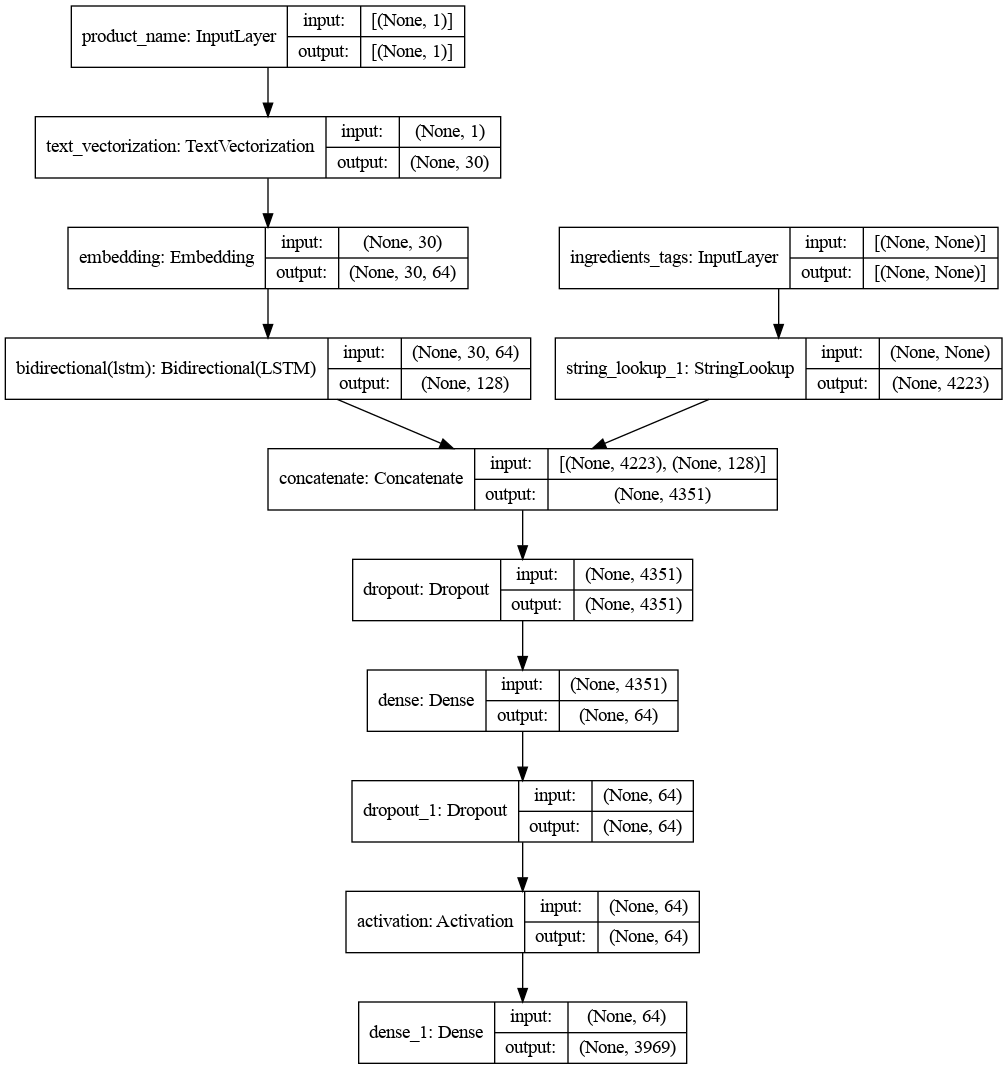

In [17]:
plot_model(model, show_shapes=True, show_layer_names=True)

# Train model

In [18]:
%%time

# Remember to clean obsolete dirs once in a while
MODEL_DIR = init_model_dir(MODEL_BASE_DIR)
CACHE_DIR = init_cache_dir(CACHE_DIR)


def load_dataset(split, features, batch_size):
    # ideally we'd use `tfds.load(... decoders=...)` but it fails with `as_supervised=True`
    feature_subset = partial(select_features, feature_names=features, supervised=True)
    return (
        tfds.load('off_categories', split=split, as_supervised=True)
        .apply(feature_subset)
        .apply(categories_encode)
        .padded_batch(batch_size)
    )

ds_train = (
    load_dataset(TRAIN_SPLIT, features, train_config.batch_size)
    .cache(str(CACHE_DIR / 'train'))
)

ds_val = (
    load_dataset(VAL_SPLIT, features, train_config.batch_size)
    .cache(str(CACHE_DIR / 'val'))
)

history = model.fit(
    ds_train,
    epochs = train_config.epochs,
    validation_data = ds_val,
    callbacks = [
        callbacks.TerminateOnNaN(),
        callbacks.ModelCheckpoint(
            filepath = str(MODEL_DIR / "weights.{epoch:02d}-{val_loss:.4f}"),
            monitor = 'val_loss',
            save_best_only = True,
            save_format = 'tf',
        ),
        callbacks.EarlyStopping(monitor='val_loss', patience=4),
        callbacks.CSVLogger(str(MODEL_DIR / 'training.log')),
        callbacks.History()
    ]
)

Model directory: ../model.20220520-191155
Cache directory: ../tensorflow_cache


2022-05-20 19:11:56.759401: W tensorflow/core/kernels/data/cache_dataset_ops.cc:233] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Epoch 1/50
     25/Unknown - 8s 151ms/step - loss: 0.5418 - binary_accuracy: 0.9264 - precision: 0.0011 - recall: 0.0618

[codecarbon INFO @ 19:12:04] Energy consumed for RAM : 0.000146 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:12:04] RAM : 11.65 W during 15.00 s [measurement time: 0.0045]
[codecarbon DEBUG @ 19:12:04] get_cpu_details {}
[codecarbon DEBUG @ 19:12:04] get_static_cpu_details {}
[codecarbon INFO @ 19:12:04] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:12:04] get_static_cpu_details {}
[codecarbon DEBUG @ 19:12:04] CPU : 0.00 W during 15.00 s [measurement time: 0.0037]
[codecarbon INFO @ 19:12:04] 0.000146 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:12:04] last_duration=15.004157066345215
------------------------


     50/Unknown - 12s 164ms/step - loss: 0.2793 - binary_accuracy: 0.9626 - precision: 0.0012 - recall: 0.0333

[codecarbon INFO @ 19:12:08] Energy consumed for RAM : 0.000921 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:12:08] RAM : 11.65 W during 14.99 s [measurement time: 0.0029]
[codecarbon DEBUG @ 19:12:08] get_cpu_details {}
[codecarbon DEBUG @ 19:12:08] get_static_cpu_details {}
[codecarbon INFO @ 19:12:08] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:12:08] get_static_cpu_details {}
[codecarbon DEBUG @ 19:12:08] CPU : 0.00 W during 15.00 s [measurement time: 0.0233]
[codecarbon INFO @ 19:12:08] 0.000921 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:12:08] last_duration=14.996013164520264
------------------------


    119/Unknown - 23s 159ms/step - loss: 0.1214 - binary_accuracy: 0.9835 - precision: 0.0012 - recall: 0.0142

[codecarbon INFO @ 19:12:19] Energy consumed for RAM : 0.000194 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:12:19] RAM : 11.65 W during 15.00 s [measurement time: 0.0021]
[codecarbon DEBUG @ 19:12:19] get_cpu_details {}
[codecarbon DEBUG @ 19:12:19] get_static_cpu_details {}
[codecarbon INFO @ 19:12:19] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:12:19] get_static_cpu_details {}
[codecarbon DEBUG @ 19:12:19] CPU : 0.00 W during 15.00 s [measurement time: 0.0039]
[codecarbon INFO @ 19:12:19] 0.000194 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:12:19] last_duration=15.003116130828857
------------------------


    148/Unknown - 27s 157ms/step - loss: 0.0989 - binary_accuracy: 0.9865 - precision: 0.0012 - recall: 0.0115

[codecarbon INFO @ 19:12:23] Energy consumed for RAM : 0.000970 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:12:23] RAM : 11.65 W during 14.96 s [measurement time: 0.0019]
[codecarbon DEBUG @ 19:12:23] get_cpu_details {}
[codecarbon DEBUG @ 19:12:23] get_static_cpu_details {}
[codecarbon INFO @ 19:12:23] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:12:23] get_static_cpu_details {}
[codecarbon DEBUG @ 19:12:23] CPU : 0.00 W during 14.96 s [measurement time: 0.0032]
[codecarbon INFO @ 19:12:23] 0.000970 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:12:23] last_duration=14.96412444114685
------------------------


    225/Unknown - 38s 150ms/step - loss: 0.0673 - binary_accuracy: 0.9907 - precision: 0.0012 - recall: 0.0076

[codecarbon INFO @ 19:12:34] Energy consumed for RAM : 0.000243 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:12:34] RAM : 11.65 W during 14.99 s [measurement time: 0.0009]
[codecarbon DEBUG @ 19:12:34] get_cpu_details {}
[codecarbon DEBUG @ 19:12:34] get_static_cpu_details {}
[codecarbon INFO @ 19:12:34] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:12:34] get_static_cpu_details {}
[codecarbon DEBUG @ 19:12:34] CPU : 0.00 W during 14.99 s [measurement time: 0.0037]
[codecarbon INFO @ 19:12:34] 0.000243 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:12:34] last_duration=14.990904569625854
------------------------


    255/Unknown - 42s 150ms/step - loss: 0.0601 - binary_accuracy: 0.9917 - precision: 0.0012 - recall: 0.0067

[codecarbon INFO @ 19:12:38] Energy consumed for RAM : 0.001018 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:12:38] RAM : 11.65 W during 15.00 s [measurement time: 0.0018]
[codecarbon DEBUG @ 19:12:38] get_cpu_details {}
[codecarbon DEBUG @ 19:12:38] get_static_cpu_details {}
[codecarbon INFO @ 19:12:38] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:12:38] get_static_cpu_details {}
[codecarbon DEBUG @ 19:12:38] CPU : 0.00 W during 15.00 s [measurement time: 0.0041]
[codecarbon INFO @ 19:12:38] 0.001018 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:12:38] last_duration=15.000458240509033
------------------------


    333/Unknown - 53s 147ms/step - loss: 0.0475 - binary_accuracy: 0.9933 - precision: 0.0012 - recall: 0.0051

[codecarbon INFO @ 19:12:49] Energy consumed for RAM : 0.000291 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:12:49] RAM : 11.65 W during 14.99 s [measurement time: 0.0024]
[codecarbon DEBUG @ 19:12:49] get_cpu_details {}
[codecarbon DEBUG @ 19:12:49] get_static_cpu_details {}
[codecarbon INFO @ 19:12:49] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:12:49] get_static_cpu_details {}
[codecarbon DEBUG @ 19:12:49] CPU : 0.00 W during 14.99 s [measurement time: 0.0028]
[codecarbon INFO @ 19:12:49] 0.000291 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:12:49] last_duration=14.988500833511353
------------------------


    363/Unknown - 57s 147ms/step - loss: 0.0441 - binary_accuracy: 0.9938 - precision: 0.0012 - recall: 0.0047

[codecarbon INFO @ 19:12:53] Energy consumed for RAM : 0.001067 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:12:53] RAM : 11.65 W during 14.99 s [measurement time: 0.0016]
[codecarbon DEBUG @ 19:12:53] get_cpu_details {}
[codecarbon DEBUG @ 19:12:53] get_static_cpu_details {}
[codecarbon INFO @ 19:12:53] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:12:53] get_static_cpu_details {}
[codecarbon DEBUG @ 19:12:53] CPU : 0.00 W during 14.99 s [measurement time: 0.0100]
[codecarbon INFO @ 19:12:53] 0.001067 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:12:53] last_duration=14.992537498474121
------------------------


    434/Unknown - 68s 147ms/step - loss: 0.0380 - binary_accuracy: 0.9946 - precision: 0.0012 - recall: 0.0039

[codecarbon INFO @ 19:13:04] Energy consumed for RAM : 0.000340 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:13:04] RAM : 11.65 W during 14.99 s [measurement time: 0.0020]
[codecarbon DEBUG @ 19:13:04] get_cpu_details {}
[codecarbon DEBUG @ 19:13:04] get_static_cpu_details {}
[codecarbon INFO @ 19:13:04] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:13:04] get_static_cpu_details {}
[codecarbon DEBUG @ 19:13:04] CPU : 0.00 W during 14.99 s [measurement time: 0.0030]
[codecarbon INFO @ 19:13:04] 0.000340 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:13:04] last_duration=14.99488115310669
------------------------


    464/Unknown - 72s 147ms/step - loss: 0.0359 - binary_accuracy: 0.9948 - precision: 0.0012 - recall: 0.0037

[codecarbon INFO @ 19:13:08] Energy consumed for RAM : 0.001115 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:13:08] RAM : 11.65 W during 14.98 s [measurement time: 0.0030]
[codecarbon DEBUG @ 19:13:08] get_cpu_details {}
[codecarbon DEBUG @ 19:13:08] get_static_cpu_details {}
[codecarbon INFO @ 19:13:08] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:13:08] get_static_cpu_details {}
[codecarbon DEBUG @ 19:13:08] CPU : 0.00 W during 14.98 s [measurement time: 0.0039]
[codecarbon INFO @ 19:13:08] 0.001115 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:13:08] last_duration=14.980311870574951
------------------------


    542/Unknown - 83s 145ms/step - loss: 0.0317 - binary_accuracy: 0.9954 - precision: 0.0012 - recall: 0.0031

[codecarbon INFO @ 19:13:19] Energy consumed for RAM : 0.000388 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:13:19] RAM : 11.65 W during 14.99 s [measurement time: 0.0018]
[codecarbon DEBUG @ 19:13:19] get_cpu_details {}
[codecarbon DEBUG @ 19:13:19] get_static_cpu_details {}
[codecarbon INFO @ 19:13:19] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:13:19] get_static_cpu_details {}
[codecarbon DEBUG @ 19:13:19] CPU : 0.00 W during 14.99 s [measurement time: 0.0029]
[codecarbon INFO @ 19:13:19] 0.000388 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:13:19] We apply an energy mix of 55 g.CO2eq/kWh for France
[codecarbon DEBUG @ 19:13:19] EmissionsData(timestamp='2022-05-20T19:13:19', project_name='codecarbon', run_id='88262eed-3106-4e63-a0dc-d693321ec90e', duration=120.04101228713989, emissions=2.1341132888976774e-05, emissions_rate=0.0001777820136831941, cpu_power=0.0, gpu_power=0.0, ram_power=11.6453661918

    543/Unknown - 83s 145ms/step - loss: 0.0316 - binary_accuracy: 0.9954 - precision: 0.0012 - recall: 0.0031

[codecarbon DEBUG @ 19:13:19] ApiClient - Successful upload emission {'timestamp': '2022-05-20T19:13:19.423577+02:00', 'run_id': '88262eed-3106-4e63-a0dc-d693321ec90e', 'duration': 120, 'emissions_sum': 2.1341132888976774e-05, 'emissions_rate': 0.0001777820136831941, 'cpu_power': 0.0, 'gpu_power': 0.0, 'ram_power': 11.645366191864014, 'cpu_energy': 0, 'gpu_energy': 0, 'ram_energy': 0.0003880205979813959, 'energy_consumed': 0.0003880205979813959} to https://api.codecarbon.io/emission
[codecarbon DEBUG @ 19:13:19] last_duration=14.994566202163696
------------------------


    574/Unknown - 87s 145ms/step - loss: 0.0303 - binary_accuracy: 0.9956 - precision: 0.0012 - recall: 0.0030

[codecarbon INFO @ 19:13:23] Energy consumed for RAM : 0.001163 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:13:23] RAM : 11.65 W during 14.99 s [measurement time: 0.0017]
[codecarbon DEBUG @ 19:13:23] get_cpu_details {}
[codecarbon DEBUG @ 19:13:23] get_static_cpu_details {}
[codecarbon INFO @ 19:13:23] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:13:23] get_static_cpu_details {}
[codecarbon DEBUG @ 19:13:23] CPU : 0.00 W during 15.00 s [measurement time: 0.0023]
[codecarbon INFO @ 19:13:23] 0.001163 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:13:23] We apply an energy mix of 55 g.CO2eq/kWh for France
[codecarbon DEBUG @ 19:13:23] EmissionsData(timestamp='2022-05-20T19:13:23', project_name='codecarbon', run_id='14eb81cf-c268-4483-ad88-e028017e5a32', duration=120.01853489875793, emissions=2.1329818057417148e-05, emissions_rate=0.00017772103346712232, cpu_power=0.0, gpu_power=0.0, ram_power=11.645366191

    575/Unknown - 87s 145ms/step - loss: 0.0302 - binary_accuracy: 0.9956 - precision: 0.0012 - recall: 0.0030

[codecarbon DEBUG @ 19:13:23] ApiClient - Successful upload emission {'timestamp': '2022-05-20T19:13:23.833016+02:00', 'run_id': '14eb81cf-c268-4483-ad88-e028017e5a32', 'duration': 120, 'emissions_sum': 2.1329818057417148e-05, 'emissions_rate': 0.00017772103346712232, 'cpu_power': 0.0, 'gpu_power': 0.0, 'ram_power': 11.645366191864014, 'cpu_energy': 0, 'gpu_energy': 0, 'ram_energy': 0.00038781487377122074, 'energy_consumed': 0.00038781487377122074} to https://api.codecarbon.io/emission
[codecarbon DEBUG @ 19:13:23] last_duration=14.99559736251831
------------------------


    651/Unknown - 98s 144ms/step - loss: 0.0275 - binary_accuracy: 0.9960 - precision: 0.0012 - recall: 0.0026

[codecarbon INFO @ 19:13:34] Energy consumed for RAM : 0.000437 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:13:34] RAM : 11.65 W during 14.99 s [measurement time: 0.0024]
[codecarbon DEBUG @ 19:13:34] get_cpu_details {}
[codecarbon DEBUG @ 19:13:34] get_static_cpu_details {}
[codecarbon INFO @ 19:13:34] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:13:34] get_static_cpu_details {}
[codecarbon DEBUG @ 19:13:34] CPU : 0.00 W during 15.00 s [measurement time: 0.0037]
[codecarbon INFO @ 19:13:34] 0.000437 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:13:34] last_duration=14.996954679489136
------------------------


    681/Unknown - 102s 144ms/step - loss: 0.0265 - binary_accuracy: 0.9961 - precision: 0.0012 - recall: 0.0025

[codecarbon INFO @ 19:13:38] Energy consumed for RAM : 0.001212 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:13:38] RAM : 11.65 W during 15.00 s [measurement time: 0.0049]
[codecarbon DEBUG @ 19:13:38] get_cpu_details {}
[codecarbon DEBUG @ 19:13:38] get_static_cpu_details {}
[codecarbon INFO @ 19:13:38] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:13:38] get_static_cpu_details {}
[codecarbon DEBUG @ 19:13:38] CPU : 0.00 W during 15.00 s [measurement time: 0.0053]
[codecarbon INFO @ 19:13:38] 0.001212 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:13:38] last_duration=15.00413727760315
------------------------


    760/Unknown - 113s 143ms/step - loss: 0.0244 - binary_accuracy: 0.9964 - precision: 0.0012 - recall: 0.0022

[codecarbon INFO @ 19:13:49] Energy consumed for RAM : 0.000485 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:13:49] RAM : 11.65 W during 14.99 s [measurement time: 0.0021]
[codecarbon DEBUG @ 19:13:49] get_cpu_details {}
[codecarbon DEBUG @ 19:13:49] get_static_cpu_details {}
[codecarbon INFO @ 19:13:49] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:13:49] get_static_cpu_details {}
[codecarbon DEBUG @ 19:13:49] CPU : 0.00 W during 15.00 s [measurement time: 0.0043]
[codecarbon INFO @ 19:13:49] 0.000485 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:13:49] last_duration=14.997500658035278
------------------------


    792/Unknown - 117s 143ms/step - loss: 0.0237 - binary_accuracy: 0.9965 - precision: 0.0012 - recall: 0.0022

[codecarbon INFO @ 19:13:53] Energy consumed for RAM : 0.001260 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:13:53] RAM : 11.65 W during 14.99 s [measurement time: 0.0043]
[codecarbon DEBUG @ 19:13:53] get_cpu_details {}
[codecarbon DEBUG @ 19:13:53] get_static_cpu_details {}
[codecarbon INFO @ 19:13:53] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:13:53] get_static_cpu_details {}
[codecarbon DEBUG @ 19:13:53] CPU : 0.00 W during 14.99 s [measurement time: 0.0025]
[codecarbon INFO @ 19:13:53] 0.001260 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:13:53] last_duration=14.993039608001709
------------------------


    869/Unknown - 128s 142ms/step - loss: 0.0222 - binary_accuracy: 0.9967 - precision: 0.0012 - recall: 0.0020

[codecarbon INFO @ 19:14:04] Energy consumed for RAM : 0.000533 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:14:04] RAM : 11.65 W during 14.98 s [measurement time: 0.0028]
[codecarbon DEBUG @ 19:14:04] get_cpu_details {}
[codecarbon DEBUG @ 19:14:04] get_static_cpu_details {}
[codecarbon INFO @ 19:14:04] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:14:04] get_static_cpu_details {}
[codecarbon DEBUG @ 19:14:04] CPU : 0.00 W during 14.99 s [measurement time: 0.0025]
[codecarbon INFO @ 19:14:04] 0.000533 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:14:04] last_duration=14.987979888916016
------------------------


    900/Unknown - 132s 142ms/step - loss: 0.0216 - binary_accuracy: 0.9967 - precision: 0.0012 - recall: 0.0019

[codecarbon INFO @ 19:14:08] Energy consumed for RAM : 0.001309 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:14:08] RAM : 11.65 W during 15.00 s [measurement time: 0.0033]
[codecarbon DEBUG @ 19:14:08] get_cpu_details {}
[codecarbon DEBUG @ 19:14:08] get_static_cpu_details {}
[codecarbon INFO @ 19:14:08] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:14:08] get_static_cpu_details {}
[codecarbon DEBUG @ 19:14:08] CPU : 0.00 W during 15.00 s [measurement time: 0.0030]
[codecarbon INFO @ 19:14:08] 0.001309 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:14:08] last_duration=15.000129222869873
------------------------


    977/Unknown - 143s 142ms/step - loss: 0.0204 - binary_accuracy: 0.9969 - precision: 0.0012 - recall: 0.0017

[codecarbon INFO @ 19:14:19] Energy consumed for RAM : 0.000582 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:14:19] RAM : 11.65 W during 14.99 s [measurement time: 0.0026]
[codecarbon DEBUG @ 19:14:19] get_cpu_details {}
[codecarbon DEBUG @ 19:14:19] get_static_cpu_details {}
[codecarbon INFO @ 19:14:19] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:14:19] get_static_cpu_details {}
[codecarbon DEBUG @ 19:14:19] CPU : 0.00 W during 14.99 s [measurement time: 0.0074]
[codecarbon INFO @ 19:14:19] 0.000582 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:14:19] last_duration=14.994243144989014
------------------------


   1009/Unknown - 147s 142ms/step - loss: 0.0200 - binary_accuracy: 0.9970 - precision: 0.0012 - recall: 0.0017

[codecarbon INFO @ 19:14:23] Energy consumed for RAM : 0.001357 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:14:23] RAM : 11.65 W during 14.99 s [measurement time: 0.0059]
[codecarbon DEBUG @ 19:14:23] get_cpu_details {}
[codecarbon DEBUG @ 19:14:23] get_static_cpu_details {}
[codecarbon INFO @ 19:14:23] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:14:23] get_static_cpu_details {}
[codecarbon DEBUG @ 19:14:23] CPU : 0.00 W during 15.00 s [measurement time: 0.0079]
[codecarbon INFO @ 19:14:23] 0.001357 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:14:23] last_duration=14.997589349746704
------------------------


   1087/Unknown - 158s 142ms/step - loss: 0.0190 - binary_accuracy: 0.9971 - precision: 0.0012 - recall: 0.0016

[codecarbon INFO @ 19:14:34] Energy consumed for RAM : 0.000630 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:14:34] RAM : 11.65 W during 14.99 s [measurement time: 0.0015]
[codecarbon DEBUG @ 19:14:34] get_cpu_details {}
[codecarbon DEBUG @ 19:14:34] get_static_cpu_details {}
[codecarbon INFO @ 19:14:34] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:14:34] get_static_cpu_details {}
[codecarbon DEBUG @ 19:14:34] CPU : 0.00 W during 14.99 s [measurement time: 0.0037]
[codecarbon INFO @ 19:14:34] 0.000630 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:14:34] last_duration=14.987765789031982
------------------------


   1119/Unknown - 162s 141ms/step - loss: 0.0186 - binary_accuracy: 0.9971 - precision: 0.0012 - recall: 0.0015

[codecarbon INFO @ 19:14:38] Energy consumed for RAM : 0.001406 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:14:38] RAM : 11.65 W during 14.98 s [measurement time: 0.0025]
[codecarbon DEBUG @ 19:14:38] get_cpu_details {}
[codecarbon DEBUG @ 19:14:38] get_static_cpu_details {}
[codecarbon INFO @ 19:14:38] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:14:38] get_static_cpu_details {}
[codecarbon DEBUG @ 19:14:38] CPU : 0.00 W during 14.98 s [measurement time: 0.0054]
[codecarbon INFO @ 19:14:38] 0.001406 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:14:38] last_duration=14.9826500415802
------------------------


   1195/Unknown - 173s 141ms/step - loss: 0.0178 - binary_accuracy: 0.9972 - precision: 0.0012 - recall: 0.0014

[codecarbon INFO @ 19:14:49] Energy consumed for RAM : 0.000679 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:14:49] RAM : 11.65 W during 14.99 s [measurement time: 0.0061]
[codecarbon DEBUG @ 19:14:49] get_cpu_details {}
[codecarbon DEBUG @ 19:14:49] get_static_cpu_details {}
[codecarbon INFO @ 19:14:49] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:14:49] get_static_cpu_details {}
[codecarbon DEBUG @ 19:14:49] CPU : 0.00 W during 15.00 s [measurement time: 0.0033]
[codecarbon INFO @ 19:14:49] 0.000679 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:14:49] last_duration=15.000336170196533
------------------------


   1227/Unknown - 177s 141ms/step - loss: 0.0175 - binary_accuracy: 0.9973 - precision: 0.0012 - recall: 0.0014

[codecarbon INFO @ 19:14:53] Energy consumed for RAM : 0.001454 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:14:53] RAM : 11.65 W during 14.99 s [measurement time: 0.0039]
[codecarbon DEBUG @ 19:14:53] get_cpu_details {}
[codecarbon DEBUG @ 19:14:53] get_static_cpu_details {}
[codecarbon INFO @ 19:14:53] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:14:53] get_static_cpu_details {}
[codecarbon DEBUG @ 19:14:53] CPU : 0.00 W during 14.99 s [measurement time: 0.0022]
[codecarbon INFO @ 19:14:53] 0.001454 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:14:53] last_duration=14.992450714111328
------------------------


   1300/Unknown - 188s 141ms/step - loss: 0.0169 - binary_accuracy: 0.9974 - precision: 0.0012 - recall: 0.0013

[codecarbon INFO @ 19:15:04] Energy consumed for RAM : 0.000727 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:15:04] RAM : 11.65 W during 14.99 s [measurement time: 0.0032]
[codecarbon DEBUG @ 19:15:04] get_cpu_details {}
[codecarbon DEBUG @ 19:15:04] get_static_cpu_details {}
[codecarbon INFO @ 19:15:04] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:15:04] get_static_cpu_details {}
[codecarbon DEBUG @ 19:15:04] CPU : 0.00 W during 14.99 s [measurement time: 0.0096]
[codecarbon INFO @ 19:15:04] 0.000727 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:15:04] last_duration=14.990406274795532
------------------------


   1331/Unknown - 192s 141ms/step - loss: 0.0167 - binary_accuracy: 0.9974 - precision: 0.0012 - recall: 0.0013

[codecarbon INFO @ 19:15:08] Energy consumed for RAM : 0.001503 kWh. RAM Power : 11.645366191864014 W


   1332/Unknown - 192s 141ms/step - loss: 0.0166 - binary_accuracy: 0.9974 - precision: 0.0012 - recall: 0.0013

[codecarbon DEBUG @ 19:15:08] RAM : 11.65 W during 14.99 s [measurement time: 0.0062]
[codecarbon DEBUG @ 19:15:08] get_cpu_details {}
[codecarbon DEBUG @ 19:15:08] get_static_cpu_details {}
[codecarbon INFO @ 19:15:08] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:15:08] get_static_cpu_details {}
[codecarbon DEBUG @ 19:15:08] CPU : 0.00 W during 15.00 s [measurement time: 0.0072]
[codecarbon INFO @ 19:15:08] 0.001503 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:15:08] last_duration=14.998686790466309
------------------------


   1408/Unknown - 203s 141ms/step - loss: 0.0161 - binary_accuracy: 0.9975 - precision: 0.0013 - recall: 0.0013

[codecarbon INFO @ 19:15:19] Energy consumed for RAM : 0.000776 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:15:19] RAM : 11.65 W during 14.98 s [measurement time: 0.0018]
[codecarbon DEBUG @ 19:15:19] get_cpu_details {}
[codecarbon DEBUG @ 19:15:19] get_static_cpu_details {}
[codecarbon INFO @ 19:15:19] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:15:19] get_static_cpu_details {}
[codecarbon DEBUG @ 19:15:19] CPU : 0.00 W during 14.99 s [measurement time: 0.0019]
[codecarbon INFO @ 19:15:19] 0.000776 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:15:19] We apply an energy mix of 55 g.CO2eq/kWh for France
[codecarbon DEBUG @ 19:15:19] EmissionsData(timestamp='2022-05-20T19:15:19', project_name='codecarbon', run_id='88262eed-3106-4e63-a0dc-d693321ec90e', duration=120.0084331035614, emissions=2.1331892313120237e-05, emissions_rate=0.00017775327751102173, cpu_power=0.0, gpu_power=0.0, ram_power=11.6453661918

   1409/Unknown - 203s 141ms/step - loss: 0.0161 - binary_accuracy: 0.9975 - precision: 0.0013 - recall: 0.0013

[codecarbon DEBUG @ 19:15:19] ApiClient - Successful upload emission {'timestamp': '2022-05-20T19:15:19.431445+02:00', 'run_id': '88262eed-3106-4e63-a0dc-d693321ec90e', 'duration': 120, 'emissions_sum': 2.1331892313120237e-05, 'emissions_rate': 0.00017775327751102173, 'cpu_power': 0.0, 'gpu_power': 0.0, 'ram_power': 11.645366191864014, 'cpu_energy': 0, 'gpu_energy': 0, 'ram_energy': 0.00038785258751127704, 'energy_consumed': 0.00038785258751127704} to https://api.codecarbon.io/emission
[codecarbon DEBUG @ 19:15:19] last_duration=14.985828161239624
------------------------


   1440/Unknown - 207s 141ms/step - loss: 0.0159 - binary_accuracy: 0.9975 - precision: 0.0013 - recall: 0.0013

[codecarbon INFO @ 19:15:23] Energy consumed for RAM : 0.001551 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:15:23] RAM : 11.65 W during 14.98 s [measurement time: 0.0014]
[codecarbon DEBUG @ 19:15:23] get_cpu_details {}
[codecarbon DEBUG @ 19:15:23] get_static_cpu_details {}
[codecarbon INFO @ 19:15:23] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:15:23] get_static_cpu_details {}
[codecarbon DEBUG @ 19:15:23] CPU : 0.00 W during 14.98 s [measurement time: 0.0028]
[codecarbon INFO @ 19:15:23] 0.001551 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:15:23] We apply an energy mix of 55 g.CO2eq/kWh for France
[codecarbon DEBUG @ 19:15:23] EmissionsData(timestamp='2022-05-20T19:15:23', project_name='codecarbon', run_id='14eb81cf-c268-4483-ad88-e028017e5a32', duration=120.0256097316742, emissions=2.133338378356555e-05, emissions_rate=0.0001777402658587434, cpu_power=0.0, gpu_power=0.0, ram_power=11.645366191864

   1518/Unknown - 218s 141ms/step - loss: 0.0154 - binary_accuracy: 0.9976 - precision: 0.0015 - recall: 0.0015

[codecarbon INFO @ 19:15:34] Energy consumed for RAM : 0.000824 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:15:34] RAM : 11.65 W during 14.99 s [measurement time: 0.0024]
[codecarbon DEBUG @ 19:15:34] get_cpu_details {}
[codecarbon DEBUG @ 19:15:34] get_static_cpu_details {}
[codecarbon INFO @ 19:15:34] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:15:34] get_static_cpu_details {}
[codecarbon DEBUG @ 19:15:34] CPU : 0.00 W during 15.00 s [measurement time: 0.0034]
[codecarbon INFO @ 19:15:34] 0.000824 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:15:34] last_duration=14.998800992965698
------------------------


   1550/Unknown - 222s 141ms/step - loss: 0.0152 - binary_accuracy: 0.9976 - precision: 0.0016 - recall: 0.0015

[codecarbon INFO @ 19:15:38] Energy consumed for RAM : 0.001600 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:15:38] RAM : 11.65 W during 14.99 s [measurement time: 0.0017]
[codecarbon DEBUG @ 19:15:38] get_cpu_details {}
[codecarbon DEBUG @ 19:15:38] get_static_cpu_details {}
[codecarbon INFO @ 19:15:38] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:15:38] get_static_cpu_details {}
[codecarbon DEBUG @ 19:15:38] CPU : 0.00 W during 15.00 s [measurement time: 0.0035]
[codecarbon INFO @ 19:15:38] 0.001600 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:15:38] last_duration=14.995883464813232
------------------------


   1626/Unknown - 233s 141ms/step - loss: 0.0148 - binary_accuracy: 0.9976 - precision: 0.0019 - recall: 0.0017

[codecarbon INFO @ 19:15:49] Energy consumed for RAM : 0.000873 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:15:49] RAM : 11.65 W during 14.99 s [measurement time: 0.0041]
[codecarbon DEBUG @ 19:15:49] get_cpu_details {}
[codecarbon DEBUG @ 19:15:49] get_static_cpu_details {}
[codecarbon INFO @ 19:15:49] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:15:49] get_static_cpu_details {}
[codecarbon DEBUG @ 19:15:49] CPU : 0.00 W during 15.00 s [measurement time: 0.0028]
[codecarbon INFO @ 19:15:49] 0.000873 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:15:49] last_duration=14.996777534484863
------------------------


   1659/Unknown - 237s 141ms/step - loss: 0.0146 - binary_accuracy: 0.9977 - precision: 0.0021 - recall: 0.0018

[codecarbon INFO @ 19:15:53] Energy consumed for RAM : 0.001648 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:15:53] RAM : 11.65 W during 14.98 s [measurement time: 0.0016]
[codecarbon DEBUG @ 19:15:53] get_cpu_details {}
[codecarbon DEBUG @ 19:15:53] get_static_cpu_details {}
[codecarbon INFO @ 19:15:53] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:15:53] get_static_cpu_details {}
[codecarbon DEBUG @ 19:15:53] CPU : 0.00 W during 14.99 s [measurement time: 0.0035]
[codecarbon INFO @ 19:15:53] 0.001648 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:15:53] last_duration=14.98579478263855
------------------------


   1736/Unknown - 248s 140ms/step - loss: 0.0142 - binary_accuracy: 0.9977 - precision: 0.0025 - recall: 0.0021

[codecarbon INFO @ 19:16:04] Energy consumed for RAM : 0.000921 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:16:04] RAM : 11.65 W during 14.99 s [measurement time: 0.0023]


   1737/Unknown - 248s 140ms/step - loss: 0.0142 - binary_accuracy: 0.9977 - precision: 0.0025 - recall: 0.0021

[codecarbon DEBUG @ 19:16:04] get_cpu_details {}
[codecarbon DEBUG @ 19:16:04] get_static_cpu_details {}
[codecarbon INFO @ 19:16:04] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:16:04] get_static_cpu_details {}
[codecarbon DEBUG @ 19:16:04] CPU : 0.00 W during 15.00 s [measurement time: 0.0043]
[codecarbon INFO @ 19:16:04] 0.000921 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:16:04] last_duration=15.00052261352539
------------------------


   1768/Unknown - 252s 140ms/step - loss: 0.0141 - binary_accuracy: 0.9977 - precision: 0.0027 - recall: 0.0023

[codecarbon INFO @ 19:16:08] Energy consumed for RAM : 0.001697 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:16:08] RAM : 11.65 W during 14.99 s [measurement time: 0.0017]
[codecarbon DEBUG @ 19:16:08] get_cpu_details {}
[codecarbon DEBUG @ 19:16:08] get_static_cpu_details {}
[codecarbon INFO @ 19:16:08] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:16:08] get_static_cpu_details {}
[codecarbon DEBUG @ 19:16:08] CPU : 0.00 W during 15.00 s [measurement time: 0.0029]
[codecarbon INFO @ 19:16:08] 0.001697 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:16:08] last_duration=15.004487991333008
------------------------


   1845/Unknown - 263s 140ms/step - loss: 0.0137 - binary_accuracy: 0.9978 - precision: 0.0033 - recall: 0.0026

[codecarbon INFO @ 19:16:19] Energy consumed for RAM : 0.000970 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:16:19] RAM : 11.65 W during 14.98 s [measurement time: 0.0023]
[codecarbon DEBUG @ 19:16:19] get_cpu_details {}
[codecarbon DEBUG @ 19:16:19] get_static_cpu_details {}
[codecarbon INFO @ 19:16:19] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:16:19] get_static_cpu_details {}
[codecarbon DEBUG @ 19:16:19] CPU : 0.00 W during 14.99 s [measurement time: 0.0022]
[codecarbon INFO @ 19:16:19] 0.000970 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:16:19] last_duration=14.985856294631958
------------------------


   1877/Unknown - 267s 140ms/step - loss: 0.0136 - binary_accuracy: 0.9978 - precision: 0.0035 - recall: 0.0028

[codecarbon INFO @ 19:16:23] Energy consumed for RAM : 0.001745 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:16:23] RAM : 11.65 W during 14.99 s [measurement time: 0.0029]
[codecarbon DEBUG @ 19:16:23] get_cpu_details {}
[codecarbon DEBUG @ 19:16:23] get_static_cpu_details {}
[codecarbon INFO @ 19:16:23] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:16:23] get_static_cpu_details {}
[codecarbon DEBUG @ 19:16:23] CPU : 0.00 W during 14.99 s [measurement time: 0.0042]
[codecarbon INFO @ 19:16:23] 0.001745 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:16:23] last_duration=14.992847681045532
------------------------


   1955/Unknown - 278s 140ms/step - loss: 0.0133 - binary_accuracy: 0.9978 - precision: 0.0043 - recall: 0.0032

[codecarbon INFO @ 19:16:34] Energy consumed for RAM : 0.001018 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:16:34] RAM : 11.65 W during 15.00 s [measurement time: 0.0030]
[codecarbon DEBUG @ 19:16:34] get_cpu_details {}
[codecarbon DEBUG @ 19:16:34] get_static_cpu_details {}
[codecarbon INFO @ 19:16:34] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:16:34] get_static_cpu_details {}
[codecarbon DEBUG @ 19:16:34] CPU : 0.00 W during 15.00 s [measurement time: 0.0014]
[codecarbon INFO @ 19:16:34] 0.001018 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:16:34] last_duration=14.999776363372803
------------------------


   1986/Unknown - 282s 140ms/step - loss: 0.0132 - binary_accuracy: 0.9978 - precision: 0.0046 - recall: 0.0034

[codecarbon INFO @ 19:16:38] Energy consumed for RAM : 0.001794 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:16:38] RAM : 11.65 W during 14.99 s [measurement time: 0.0028]
[codecarbon DEBUG @ 19:16:38] get_cpu_details {}
[codecarbon DEBUG @ 19:16:38] get_static_cpu_details {}
[codecarbon INFO @ 19:16:38] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:16:38] get_static_cpu_details {}
[codecarbon DEBUG @ 19:16:38] CPU : 0.00 W during 14.99 s [measurement time: 0.0028]
[codecarbon INFO @ 19:16:38] 0.001794 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:16:38] last_duration=14.98996901512146
------------------------


   2063/Unknown - 293s 140ms/step - loss: 0.0129 - binary_accuracy: 0.9979 - precision: 0.0054 - recall: 0.0039

[codecarbon INFO @ 19:16:49] Energy consumed for RAM : 0.001067 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:16:49] RAM : 11.65 W during 15.00 s [measurement time: 0.0023]
[codecarbon DEBUG @ 19:16:49] get_cpu_details {}
[codecarbon DEBUG @ 19:16:49] get_static_cpu_details {}
[codecarbon INFO @ 19:16:49] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:16:49] get_static_cpu_details {}
[codecarbon DEBUG @ 19:16:49] CPU : 0.00 W during 15.00 s [measurement time: 0.0092]
[codecarbon INFO @ 19:16:49] 0.001067 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:16:49] last_duration=14.998535394668579
------------------------


   2096/Unknown - 297s 140ms/step - loss: 0.0128 - binary_accuracy: 0.9979 - precision: 0.0058 - recall: 0.0041

[codecarbon INFO @ 19:16:53] Energy consumed for RAM : 0.001842 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:16:53] RAM : 11.65 W during 14.99 s [measurement time: 0.0029]
[codecarbon DEBUG @ 19:16:53] get_cpu_details {}
[codecarbon DEBUG @ 19:16:53] get_static_cpu_details {}
[codecarbon INFO @ 19:16:53] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:16:53] get_static_cpu_details {}
[codecarbon DEBUG @ 19:16:53] CPU : 0.00 W during 15.00 s [measurement time: 0.0044]
[codecarbon INFO @ 19:16:53] 0.001842 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:16:53] last_duration=14.996731758117676
------------------------


   2168/Unknown - 308s 140ms/step - loss: 0.0126 - binary_accuracy: 0.9979 - precision: 0.0067 - recall: 0.0045

[codecarbon INFO @ 19:17:04] Energy consumed for RAM : 0.001115 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:17:04] RAM : 11.65 W during 14.98 s [measurement time: 0.0016]
[codecarbon DEBUG @ 19:17:04] get_cpu_details {}
[codecarbon DEBUG @ 19:17:04] get_static_cpu_details {}
[codecarbon INFO @ 19:17:04] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:17:04] get_static_cpu_details {}
[codecarbon DEBUG @ 19:17:04] CPU : 0.00 W during 14.99 s [measurement time: 0.0016]
[codecarbon INFO @ 19:17:04] 0.001115 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:17:04] last_duration=14.986709117889404
------------------------


   2200/Unknown - 312s 140ms/step - loss: 0.0125 - binary_accuracy: 0.9979 - precision: 0.0071 - recall: 0.0048

[codecarbon INFO @ 19:17:08] Energy consumed for RAM : 0.001891 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:17:08] RAM : 11.65 W during 14.99 s [measurement time: 0.0016]
[codecarbon DEBUG @ 19:17:08] get_cpu_details {}
[codecarbon DEBUG @ 19:17:08] get_static_cpu_details {}
[codecarbon INFO @ 19:17:08] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:17:08] get_static_cpu_details {}
[codecarbon DEBUG @ 19:17:08] CPU : 0.00 W during 14.99 s [measurement time: 0.0020]
[codecarbon INFO @ 19:17:08] 0.001891 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:17:08] last_duration=14.993204116821289
------------------------


   2277/Unknown - 323s 140ms/step - loss: 0.0123 - binary_accuracy: 0.9980 - precision: 0.0082 - recall: 0.0053

[codecarbon INFO @ 19:17:19] Energy consumed for RAM : 0.001164 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:17:19] RAM : 11.65 W during 14.99 s [measurement time: 0.0030]
[codecarbon DEBUG @ 19:17:19] get_cpu_details {}
[codecarbon DEBUG @ 19:17:19] get_static_cpu_details {}
[codecarbon INFO @ 19:17:19] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:17:19] get_static_cpu_details {}
[codecarbon DEBUG @ 19:17:19] CPU : 0.00 W during 15.00 s [measurement time: 0.0057]
[codecarbon INFO @ 19:17:19] 0.001164 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:17:19] We apply an energy mix of 55 g.CO2eq/kWh for France
[codecarbon DEBUG @ 19:17:19] EmissionsData(timestamp='2022-05-20T19:17:19', project_name='codecarbon', run_id='88262eed-3106-4e63-a0dc-d693321ec90e', duration=120.02128028869629, emissions=2.1337112735397944e-05, emissions_rate=0.00017777774644691483, cpu_power=0.0, gpu_power=0.0, ram_power=11.645366191

   2305/Unknown - 327s 140ms/step - loss: 0.0122 - binary_accuracy: 0.9980 - precision: 0.0086 - recall: 0.0055

[codecarbon INFO @ 19:17:23] Energy consumed for RAM : 0.001939 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:17:23] RAM : 11.65 W during 14.99 s [measurement time: 0.0013]
[codecarbon DEBUG @ 19:17:23] get_cpu_details {}
[codecarbon DEBUG @ 19:17:23] get_static_cpu_details {}
[codecarbon INFO @ 19:17:23] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:17:23] get_static_cpu_details {}
[codecarbon DEBUG @ 19:17:23] CPU : 0.00 W during 15.00 s [measurement time: 0.0026]
[codecarbon INFO @ 19:17:23] 0.001939 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:17:23] We apply an energy mix of 55 g.CO2eq/kWh for France
[codecarbon DEBUG @ 19:17:23] EmissionsData(timestamp='2022-05-20T19:17:23', project_name='codecarbon', run_id='14eb81cf-c268-4483-ad88-e028017e5a32', duration=120.00754356384277, emissions=2.133483351438693e-05, emissions_rate=0.00017777910355307804, cpu_power=0.0, gpu_power=0.0, ram_power=11.6453661918

   2306/Unknown - 327s 140ms/step - loss: 0.0122 - binary_accuracy: 0.9980 - precision: 0.0086 - recall: 0.0055

[codecarbon DEBUG @ 19:17:24] ApiClient - Successful upload emission {'timestamp': '2022-05-20T19:17:23.881800+02:00', 'run_id': '14eb81cf-c268-4483-ad88-e028017e5a32', 'duration': 120, 'emissions_sum': 2.133483351438693e-05, 'emissions_rate': 0.00017777910355307804, 'cpu_power': 0.0, 'gpu_power': 0.0, 'ram_power': 11.645366191864014, 'cpu_energy': 0, 'gpu_energy': 0, 'ram_energy': 0.00038790606389794394, 'energy_consumed': 0.00038790606389794394} to https://api.codecarbon.io/emission
[codecarbon DEBUG @ 19:17:24] last_duration=14.995062112808228
------------------------


   2382/Unknown - 338s 140ms/step - loss: 0.0120 - binary_accuracy: 0.9980 - precision: 0.0100 - recall: 0.0062

[codecarbon INFO @ 19:17:34] Energy consumed for RAM : 0.001212 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:17:34] RAM : 11.65 W during 14.98 s [measurement time: 0.0019]
[codecarbon DEBUG @ 19:17:34] get_cpu_details {}
[codecarbon DEBUG @ 19:17:34] get_static_cpu_details {}
[codecarbon INFO @ 19:17:34] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:17:34] get_static_cpu_details {}
[codecarbon DEBUG @ 19:17:34] CPU : 0.00 W during 14.99 s [measurement time: 0.0057]
[codecarbon INFO @ 19:17:34] 0.001212 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:17:34] last_duration=14.988328456878662
------------------------


   2413/Unknown - 342s 140ms/step - loss: 0.0119 - binary_accuracy: 0.9980 - precision: 0.0106 - recall: 0.0065

[codecarbon INFO @ 19:17:38] Energy consumed for RAM : 0.001988 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:17:38] RAM : 11.65 W during 14.99 s [measurement time: 0.0033]
[codecarbon DEBUG @ 19:17:38] get_cpu_details {}
[codecarbon DEBUG @ 19:17:38] get_static_cpu_details {}
[codecarbon INFO @ 19:17:38] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:17:38] get_static_cpu_details {}
[codecarbon DEBUG @ 19:17:38] CPU : 0.00 W during 15.00 s [measurement time: 0.0028]
[codecarbon INFO @ 19:17:38] 0.001988 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:17:38] last_duration=14.998197078704834
------------------------


   2490/Unknown - 353s 140ms/step - loss: 0.0117 - binary_accuracy: 0.9980 - precision: 0.0122 - recall: 0.0072

[codecarbon INFO @ 19:17:49] Energy consumed for RAM : 0.001261 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:17:49] RAM : 11.65 W during 14.99 s [measurement time: 0.0042]
[codecarbon DEBUG @ 19:17:49] get_cpu_details {}
[codecarbon DEBUG @ 19:17:49] get_static_cpu_details {}


   2491/Unknown - 353s 140ms/step - loss: 0.0117 - binary_accuracy: 0.9980 - precision: 0.0122 - recall: 0.0072

[codecarbon INFO @ 19:17:49] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:17:49] get_static_cpu_details {}
[codecarbon DEBUG @ 19:17:49] CPU : 0.00 W during 14.99 s [measurement time: 0.0092]
[codecarbon INFO @ 19:17:49] 0.001261 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:17:49] last_duration=14.994866609573364
------------------------


   2523/Unknown - 357s 140ms/step - loss: 0.0116 - binary_accuracy: 0.9980 - precision: 0.0129 - recall: 0.0076

[codecarbon INFO @ 19:17:53] Energy consumed for RAM : 0.002036 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:17:53] RAM : 11.65 W during 15.00 s [measurement time: 0.0025]
[codecarbon DEBUG @ 19:17:53] get_cpu_details {}
[codecarbon DEBUG @ 19:17:53] get_static_cpu_details {}
[codecarbon INFO @ 19:17:53] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:17:53] get_static_cpu_details {}
[codecarbon DEBUG @ 19:17:53] CPU : 0.00 W during 15.01 s [measurement time: 0.0041]
[codecarbon INFO @ 19:17:53] 0.002036 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:17:53] last_duration=15.005969285964966
------------------------


   2600/Unknown - 368s 140ms/step - loss: 0.0115 - binary_accuracy: 0.9981 - precision: 0.0150 - recall: 0.0086

[codecarbon INFO @ 19:18:04] Energy consumed for RAM : 0.001309 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:18:04] RAM : 11.65 W during 14.98 s [measurement time: 0.0037]
[codecarbon DEBUG @ 19:18:04] get_cpu_details {}
[codecarbon DEBUG @ 19:18:04] get_static_cpu_details {}
[codecarbon INFO @ 19:18:04] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:18:04] get_static_cpu_details {}
[codecarbon DEBUG @ 19:18:04] CPU : 0.00 W during 14.99 s [measurement time: 0.0025]
[codecarbon INFO @ 19:18:04] 0.001309 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:18:04] last_duration=14.987351894378662
------------------------


   2632/Unknown - 372s 140ms/step - loss: 0.0114 - binary_accuracy: 0.9981 - precision: 0.0160 - recall: 0.0090

[codecarbon INFO @ 19:18:08] Energy consumed for RAM : 0.002085 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:18:08] RAM : 11.65 W during 14.99 s [measurement time: 0.0024]
[codecarbon DEBUG @ 19:18:08] get_cpu_details {}
[codecarbon DEBUG @ 19:18:08] get_static_cpu_details {}
[codecarbon INFO @ 19:18:08] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:18:08] get_static_cpu_details {}
[codecarbon DEBUG @ 19:18:08] CPU : 0.00 W during 15.00 s [measurement time: 0.0048]
[codecarbon INFO @ 19:18:08] 0.002085 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:18:08] last_duration=14.997535228729248
------------------------


   2710/Unknown - 383s 140ms/step - loss: 0.0112 - binary_accuracy: 0.9981 - precision: 0.0183 - recall: 0.0101

[codecarbon INFO @ 19:18:19] Energy consumed for RAM : 0.001358 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:18:19] RAM : 11.65 W during 14.99 s [measurement time: 0.0016]
[codecarbon DEBUG @ 19:18:19] get_cpu_details {}
[codecarbon DEBUG @ 19:18:19] get_static_cpu_details {}
[codecarbon INFO @ 19:18:19] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:18:19] get_static_cpu_details {}
[codecarbon DEBUG @ 19:18:19] CPU : 0.00 W during 15.00 s [measurement time: 0.0030]
[codecarbon INFO @ 19:18:19] 0.001358 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:18:19] last_duration=14.995104551315308
------------------------


   2741/Unknown - 387s 140ms/step - loss: 0.0112 - binary_accuracy: 0.9981 - precision: 0.0194 - recall: 0.0106

[codecarbon INFO @ 19:18:23] Energy consumed for RAM : 0.002133 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:18:23] RAM : 11.65 W during 14.98 s [measurement time: 0.0011]
[codecarbon DEBUG @ 19:18:23] get_cpu_details {}
[codecarbon DEBUG @ 19:18:23] get_static_cpu_details {}
[codecarbon INFO @ 19:18:23] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:18:23] get_static_cpu_details {}
[codecarbon DEBUG @ 19:18:23] CPU : 0.00 W during 14.98 s [measurement time: 0.0036]
[codecarbon INFO @ 19:18:23] 0.002133 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:18:23] last_duration=14.983962297439575
------------------------


   2818/Unknown - 398s 140ms/step - loss: 0.0110 - binary_accuracy: 0.9981 - precision: 0.0219 - recall: 0.0117

[codecarbon INFO @ 19:18:34] Energy consumed for RAM : 0.001406 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:18:34] RAM : 11.65 W during 15.00 s [measurement time: 0.0039]
[codecarbon DEBUG @ 19:18:34] get_cpu_details {}
[codecarbon DEBUG @ 19:18:34] get_static_cpu_details {}
[codecarbon INFO @ 19:18:34] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:18:34] get_static_cpu_details {}
[codecarbon DEBUG @ 19:18:34] CPU : 0.00 W during 15.00 s [measurement time: 0.0027]


   2819/Unknown - 398s 140ms/step - loss: 0.0110 - binary_accuracy: 0.9981 - precision: 0.0220 - recall: 0.0117

[codecarbon INFO @ 19:18:34] 0.001406 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:18:34] last_duration=15.000900983810425
------------------------


   2850/Unknown - 402s 140ms/step - loss: 0.0110 - binary_accuracy: 0.9981 - precision: 0.0231 - recall: 0.0122

[codecarbon INFO @ 19:18:38] Energy consumed for RAM : 0.002182 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:18:38] RAM : 11.65 W during 14.99 s [measurement time: 0.0024]
[codecarbon DEBUG @ 19:18:38] get_cpu_details {}
[codecarbon DEBUG @ 19:18:38] get_static_cpu_details {}
[codecarbon INFO @ 19:18:38] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:18:38] get_static_cpu_details {}
[codecarbon DEBUG @ 19:18:38] CPU : 0.00 W during 15.00 s [measurement time: 0.0034]
[codecarbon INFO @ 19:18:38] 0.002182 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:18:38] last_duration=14.996639728546143
------------------------


   2928/Unknown - 413s 140ms/step - loss: 0.0108 - binary_accuracy: 0.9981 - precision: 0.0261 - recall: 0.0135

[codecarbon INFO @ 19:18:49] Energy consumed for RAM : 0.001455 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:18:49] RAM : 11.65 W during 14.98 s [measurement time: 0.0038]
[codecarbon DEBUG @ 19:18:49] get_cpu_details {}
[codecarbon DEBUG @ 19:18:49] get_static_cpu_details {}
[codecarbon INFO @ 19:18:49] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:18:49] get_static_cpu_details {}
[codecarbon DEBUG @ 19:18:49] CPU : 0.00 W during 14.98 s [measurement time: 0.0035]
[codecarbon INFO @ 19:18:49] 0.001455 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:18:49] last_duration=14.983332395553589
------------------------


   2957/Unknown - 417s 140ms/step - loss: 0.0108 - binary_accuracy: 0.9981 - precision: 0.0274 - recall: 0.0140

[codecarbon INFO @ 19:18:53] Energy consumed for RAM : 0.002230 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:18:53] RAM : 11.65 W during 14.99 s [measurement time: 0.0028]
[codecarbon DEBUG @ 19:18:53] get_cpu_details {}
[codecarbon DEBUG @ 19:18:53] get_static_cpu_details {}
[codecarbon INFO @ 19:18:53] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:18:53] get_static_cpu_details {}
[codecarbon DEBUG @ 19:18:53] CPU : 0.00 W during 15.00 s [measurement time: 0.0016]
[codecarbon INFO @ 19:18:53] 0.002230 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:18:53] last_duration=15.001312732696533
------------------------


   3030/Unknown - 428s 140ms/step - loss: 0.0107 - binary_accuracy: 0.9982 - precision: 0.0306 - recall: 0.0153

[codecarbon INFO @ 19:19:04] Energy consumed for RAM : 0.001503 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:19:04] RAM : 11.65 W during 14.99 s [measurement time: 0.0015]
[codecarbon DEBUG @ 19:19:04] get_cpu_details {}
[codecarbon DEBUG @ 19:19:04] get_static_cpu_details {}
[codecarbon INFO @ 19:19:04] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:19:04] get_static_cpu_details {}
[codecarbon DEBUG @ 19:19:04] CPU : 0.00 W during 14.99 s [measurement time: 0.0027]
[codecarbon INFO @ 19:19:04] 0.001503 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:19:04] last_duration=14.99084758758545
------------------------


   3062/Unknown - 432s 140ms/step - loss: 0.0106 - binary_accuracy: 0.9982 - precision: 0.0321 - recall: 0.0160

[codecarbon INFO @ 19:19:08] Energy consumed for RAM : 0.002279 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:19:08] RAM : 11.65 W during 14.99 s [measurement time: 0.0016]
[codecarbon DEBUG @ 19:19:08] get_cpu_details {}
[codecarbon DEBUG @ 19:19:08] get_static_cpu_details {}
[codecarbon INFO @ 19:19:08] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:19:08] get_static_cpu_details {}
[codecarbon DEBUG @ 19:19:08] CPU : 0.00 W during 14.99 s [measurement time: 0.0022]
[codecarbon INFO @ 19:19:08] 0.002279 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:19:08] last_duration=14.990297317504883
------------------------


   3140/Unknown - 443s 140ms/step - loss: 0.0105 - binary_accuracy: 0.9982 - precision: 0.0354 - recall: 0.0173

[codecarbon INFO @ 19:19:19] Energy consumed for RAM : 0.001552 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:19:19] RAM : 11.65 W during 14.99 s [measurement time: 0.0017]
[codecarbon DEBUG @ 19:19:19] get_cpu_details {}
[codecarbon DEBUG @ 19:19:19] get_static_cpu_details {}
[codecarbon INFO @ 19:19:19] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:19:19] get_static_cpu_details {}
[codecarbon DEBUG @ 19:19:19] CPU : 0.00 W during 15.00 s [measurement time: 0.0027]
[codecarbon INFO @ 19:19:19] 0.001552 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:19:19] We apply an energy mix of 55 g.CO2eq/kWh for France
[codecarbon DEBUG @ 19:19:19] EmissionsData(timestamp='2022-05-20T19:19:19', project_name='codecarbon', run_id='88262eed-3106-4e63-a0dc-d693321ec90e', duration=120.00339865684509, emissions=2.133251429290296e-05, emissions_rate=0.00017776591772958206, cpu_power=0.0, gpu_power=0.0, ram_power=11.6453661918

   3170/Unknown - 447s 140ms/step - loss: 0.0104 - binary_accuracy: 0.9982 - precision: 0.0368 - recall: 0.0178

[codecarbon INFO @ 19:19:23] Energy consumed for RAM : 0.002327 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:19:23] RAM : 11.65 W during 14.99 s [measurement time: 0.0021]
[codecarbon DEBUG @ 19:19:23] get_cpu_details {}
[codecarbon DEBUG @ 19:19:23] get_static_cpu_details {}
[codecarbon INFO @ 19:19:23] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:19:23] get_static_cpu_details {}
[codecarbon DEBUG @ 19:19:23] CPU : 0.00 W during 15.00 s [measurement time: 0.0099]
[codecarbon INFO @ 19:19:23] 0.002327 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:19:23] We apply an energy mix of 55 g.CO2eq/kWh for France
[codecarbon DEBUG @ 19:19:23] EmissionsData(timestamp='2022-05-20T19:19:23', project_name='codecarbon', run_id='14eb81cf-c268-4483-ad88-e028017e5a32', duration=120.02604603767395, emissions=2.1336740514665917e-05, emissions_rate=0.00017776758644510134, cpu_power=0.0, gpu_power=0.0, ram_power=11.645366191

   3171/Unknown - 447s 140ms/step - loss: 0.0104 - binary_accuracy: 0.9982 - precision: 0.0368 - recall: 0.0178

[codecarbon DEBUG @ 19:19:24] ApiClient - Successful upload emission {'timestamp': '2022-05-20T19:19:23.894334+02:00', 'run_id': '14eb81cf-c268-4483-ad88-e028017e5a32', 'duration': 120, 'emissions_sum': 2.1336740514665917e-05, 'emissions_rate': 0.00017776758644510134, 'cpu_power': 0.0, 'gpu_power': 0.0, 'ram_power': 11.645366191864014, 'cpu_energy': 0, 'gpu_energy': 0, 'ram_energy': 0.00038794073663028956, 'energy_consumed': 0.00038794073663028956} to https://api.codecarbon.io/emission
[codecarbon DEBUG @ 19:19:24] last_duration=14.997156143188477
------------------------


   3248/Unknown - 458s 140ms/step - loss: 0.0103 - binary_accuracy: 0.9982 - precision: 0.0407 - recall: 0.0194

[codecarbon INFO @ 19:19:34] Energy consumed for RAM : 0.001600 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:19:34] RAM : 11.65 W during 15.00 s [measurement time: 0.0014]
[codecarbon DEBUG @ 19:19:34] get_cpu_details {}
[codecarbon DEBUG @ 19:19:34] get_static_cpu_details {}
[codecarbon INFO @ 19:19:34] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:19:34] get_static_cpu_details {}
[codecarbon DEBUG @ 19:19:34] CPU : 0.00 W during 15.00 s [measurement time: 0.0015]
[codecarbon INFO @ 19:19:34] 0.001600 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:19:34] last_duration=14.999986171722412
------------------------


   3279/Unknown - 462s 140ms/step - loss: 0.0103 - binary_accuracy: 0.9982 - precision: 0.0424 - recall: 0.0200

[codecarbon INFO @ 19:19:38] Energy consumed for RAM : 0.002376 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:19:38] RAM : 11.65 W during 14.98 s [measurement time: 0.0016]
[codecarbon DEBUG @ 19:19:38] get_cpu_details {}
[codecarbon DEBUG @ 19:19:38] get_static_cpu_details {}
[codecarbon INFO @ 19:19:38] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:19:38] get_static_cpu_details {}
[codecarbon DEBUG @ 19:19:38] CPU : 0.00 W during 14.99 s [measurement time: 0.0021]
[codecarbon INFO @ 19:19:38] 0.002376 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:19:38] last_duration=14.986376762390137
------------------------


   3357/Unknown - 473s 140ms/step - loss: 0.0102 - binary_accuracy: 0.9982 - precision: 0.0465 - recall: 0.0216

[codecarbon INFO @ 19:19:49] Energy consumed for RAM : 0.001649 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:19:49] RAM : 11.65 W during 15.00 s [measurement time: 0.0049]
[codecarbon DEBUG @ 19:19:49] get_cpu_details {}
[codecarbon DEBUG @ 19:19:49] get_static_cpu_details {}
[codecarbon INFO @ 19:19:49] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:19:49] get_static_cpu_details {}
[codecarbon DEBUG @ 19:19:49] CPU : 0.00 W during 15.01 s [measurement time: 0.0075]
[codecarbon INFO @ 19:19:49] 0.001649 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:19:49] last_duration=15.006561040878296
------------------------


   3387/Unknown - 477s 140ms/step - loss: 0.0101 - binary_accuracy: 0.9982 - precision: 0.0482 - recall: 0.0222

[codecarbon INFO @ 19:19:53] Energy consumed for RAM : 0.002424 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:19:53] RAM : 11.65 W during 15.00 s [measurement time: 0.0017]
[codecarbon DEBUG @ 19:19:53] get_cpu_details {}
[codecarbon DEBUG @ 19:19:53] get_static_cpu_details {}
[codecarbon INFO @ 19:19:53] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:19:53] get_static_cpu_details {}
[codecarbon DEBUG @ 19:19:53] CPU : 0.00 W during 15.00 s [measurement time: 0.0028]
[codecarbon INFO @ 19:19:53] 0.002424 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:19:53] last_duration=15.000345706939697
------------------------


   3464/Unknown - 488s 140ms/step - loss: 0.0100 - binary_accuracy: 0.9982 - precision: 0.0529 - recall: 0.0240

[codecarbon INFO @ 19:20:04] Energy consumed for RAM : 0.001697 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:20:04] RAM : 11.65 W during 14.98 s [measurement time: 0.0027]
[codecarbon DEBUG @ 19:20:04] get_cpu_details {}
[codecarbon DEBUG @ 19:20:04] get_static_cpu_details {}
[codecarbon INFO @ 19:20:04] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:20:04] get_static_cpu_details {}
[codecarbon DEBUG @ 19:20:04] CPU : 0.00 W during 14.99 s [measurement time: 0.0032]
[codecarbon INFO @ 19:20:04] 0.001697 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:20:04] last_duration=14.988534688949585
------------------------


   3495/Unknown - 492s 140ms/step - loss: 0.0100 - binary_accuracy: 0.9982 - precision: 0.0547 - recall: 0.0247

[codecarbon INFO @ 19:20:08] Energy consumed for RAM : 0.002473 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:20:08] RAM : 11.65 W during 14.99 s [measurement time: 0.0025]
[codecarbon DEBUG @ 19:20:08] get_cpu_details {}
[codecarbon DEBUG @ 19:20:08] get_static_cpu_details {}
[codecarbon INFO @ 19:20:08] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:20:08] get_static_cpu_details {}
[codecarbon DEBUG @ 19:20:08] CPU : 0.00 W during 15.00 s [measurement time: 0.0031]
[codecarbon INFO @ 19:20:08] 0.002473 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:20:08] last_duration=14.995039463043213
------------------------


   3573/Unknown - 503s 140ms/step - loss: 0.0099 - binary_accuracy: 0.9983 - precision: 0.0597 - recall: 0.0265

[codecarbon INFO @ 19:20:19] Energy consumed for RAM : 0.001746 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:20:19] RAM : 11.65 W during 14.99 s [measurement time: 0.0027]
[codecarbon DEBUG @ 19:20:19] get_cpu_details {}
[codecarbon DEBUG @ 19:20:19] get_static_cpu_details {}
[codecarbon INFO @ 19:20:19] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:20:19] get_static_cpu_details {}
[codecarbon DEBUG @ 19:20:19] CPU : 0.00 W during 15.00 s [measurement time: 0.0032]
[codecarbon INFO @ 19:20:19] 0.001746 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:20:19] last_duration=14.995775938034058
------------------------


   3604/Unknown - 507s 140ms/step - loss: 0.0098 - binary_accuracy: 0.9983 - precision: 0.0616 - recall: 0.0273

[codecarbon INFO @ 19:20:23] Energy consumed for RAM : 0.002521 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:20:23] RAM : 11.65 W during 14.99 s [measurement time: 0.0023]
[codecarbon DEBUG @ 19:20:23] get_cpu_details {}
[codecarbon DEBUG @ 19:20:23] get_static_cpu_details {}
[codecarbon INFO @ 19:20:23] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:20:23] get_static_cpu_details {}
[codecarbon DEBUG @ 19:20:23] CPU : 0.00 W during 14.99 s [measurement time: 0.0052]
[codecarbon INFO @ 19:20:23] 0.002521 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:20:23] last_duration=14.993489503860474
------------------------


   3680/Unknown - 518s 140ms/step - loss: 0.0097 - binary_accuracy: 0.9983 - precision: 0.0667 - recall: 0.0291

[codecarbon INFO @ 19:20:34] Energy consumed for RAM : 0.001794 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:20:34] RAM : 11.65 W during 14.99 s [measurement time: 0.0020]
[codecarbon DEBUG @ 19:20:34] get_cpu_details {}
[codecarbon DEBUG @ 19:20:34] get_static_cpu_details {}
[codecarbon INFO @ 19:20:34] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:20:34] get_static_cpu_details {}
[codecarbon DEBUG @ 19:20:34] CPU : 0.00 W during 15.00 s [measurement time: 0.0022]
[codecarbon INFO @ 19:20:34] 0.001794 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:20:34] last_duration=14.995099306106567
------------------------


   3711/Unknown - 522s 140ms/step - loss: 0.0097 - binary_accuracy: 0.9983 - precision: 0.0690 - recall: 0.0300

[codecarbon INFO @ 19:20:38] Energy consumed for RAM : 0.002570 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:20:38] RAM : 11.65 W during 14.99 s [measurement time: 0.0021]
[codecarbon DEBUG @ 19:20:38] get_cpu_details {}
[codecarbon DEBUG @ 19:20:38] get_static_cpu_details {}
[codecarbon INFO @ 19:20:38] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:20:38] get_static_cpu_details {}
[codecarbon DEBUG @ 19:20:38] CPU : 0.00 W during 14.99 s [measurement time: 0.0036]
[codecarbon INFO @ 19:20:38] 0.002570 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:20:38] last_duration=14.992130517959595
------------------------


   3789/Unknown - 533s 140ms/step - loss: 0.0096 - binary_accuracy: 0.9983 - precision: 0.0746 - recall: 0.0320

[codecarbon INFO @ 19:20:49] Energy consumed for RAM : 0.001843 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:20:49] RAM : 11.65 W during 14.99 s [measurement time: 0.0072]
[codecarbon DEBUG @ 19:20:49] get_cpu_details {}
[codecarbon DEBUG @ 19:20:49] get_static_cpu_details {}
[codecarbon INFO @ 19:20:49] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:20:49] get_static_cpu_details {}
[codecarbon DEBUG @ 19:20:49] CPU : 0.00 W during 15.00 s [measurement time: 0.0043]
[codecarbon INFO @ 19:20:49] 0.001843 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:20:49] last_duration=14.999727249145508
------------------------


   3820/Unknown - 537s 140ms/step - loss: 0.0096 - binary_accuracy: 0.9983 - precision: 0.0769 - recall: 0.0329

[codecarbon INFO @ 19:20:53] Energy consumed for RAM : 0.002618 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:20:53] RAM : 11.65 W during 14.99 s [measurement time: 0.0062]
[codecarbon DEBUG @ 19:20:53] get_cpu_details {}
[codecarbon DEBUG @ 19:20:53] get_static_cpu_details {}
[codecarbon INFO @ 19:20:53] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:20:53] get_static_cpu_details {}
[codecarbon DEBUG @ 19:20:53] CPU : 0.00 W during 15.00 s [measurement time: 0.0026]
[codecarbon INFO @ 19:20:53] 0.002618 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:20:53] last_duration=15.003142833709717
------------------------


   3891/Unknown - 548s 140ms/step - loss: 0.0095 - binary_accuracy: 0.9983 - precision: 0.0822 - recall: 0.0348

[codecarbon INFO @ 19:21:04] Energy consumed for RAM : 0.001891 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:21:04] RAM : 11.65 W during 14.98 s [measurement time: 0.0027]
[codecarbon DEBUG @ 19:21:04] get_cpu_details {}
[codecarbon DEBUG @ 19:21:04] get_static_cpu_details {}
[codecarbon INFO @ 19:21:04] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:21:04] get_static_cpu_details {}
[codecarbon DEBUG @ 19:21:04] CPU : 0.00 W during 14.99 s [measurement time: 0.0116]
[codecarbon INFO @ 19:21:04] 0.001891 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:21:04] last_duration=14.986239910125732
------------------------


   3923/Unknown - 552s 140ms/step - loss: 0.0095 - binary_accuracy: 0.9983 - precision: 0.0847 - recall: 0.0356

[codecarbon INFO @ 19:21:08] Energy consumed for RAM : 0.002667 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:21:08] RAM : 11.65 W during 14.99 s [measurement time: 0.0030]
[codecarbon DEBUG @ 19:21:08] get_cpu_details {}
[codecarbon DEBUG @ 19:21:08] get_static_cpu_details {}
[codecarbon INFO @ 19:21:08] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:21:08] get_static_cpu_details {}
[codecarbon DEBUG @ 19:21:08] CPU : 0.00 W during 14.99 s [measurement time: 0.0038]
[codecarbon INFO @ 19:21:08] 0.002667 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:21:08] last_duration=14.994605779647827
------------------------


   4000/Unknown - 563s 140ms/step - loss: 0.0094 - binary_accuracy: 0.9983 - precision: 0.0909 - recall: 0.0379

[codecarbon INFO @ 19:21:19] Energy consumed for RAM : 0.001940 kWh. RAM Power : 11.645366191864014 W


   4001/Unknown - 563s 140ms/step - loss: 0.0094 - binary_accuracy: 0.9983 - precision: 0.0910 - recall: 0.0379

[codecarbon DEBUG @ 19:21:19] RAM : 11.65 W during 14.98 s [measurement time: 0.0059]
[codecarbon DEBUG @ 19:21:19] get_cpu_details {}
[codecarbon DEBUG @ 19:21:19] get_static_cpu_details {}
[codecarbon INFO @ 19:21:19] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:21:19] get_static_cpu_details {}
[codecarbon DEBUG @ 19:21:19] CPU : 0.00 W during 14.99 s [measurement time: 0.0035]
[codecarbon INFO @ 19:21:19] 0.001940 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:21:19] We apply an energy mix of 55 g.CO2eq/kWh for France
[codecarbon DEBUG @ 19:21:19] EmissionsData(timestamp='2022-05-20T19:21:19', project_name='codecarbon', run_id='88262eed-3106-4e63-a0dc-d693321ec90e', duration=120.02771306037903, emissions=2.1335034704464615e-05, emissions_rate=0.00017775090569068986, cpu_power=0.0, gpu_power=0.0, ram_power=11.645366191864014, cpu_energy=0, gpu_energy=0, ram_energy=0.0003879097218993568, energy_consumed=0.00038790972189

   4032/Unknown - 567s 140ms/step - loss: 0.0093 - binary_accuracy: 0.9983 - precision: 0.0935 - recall: 0.0388

[codecarbon INFO @ 19:21:23] Energy consumed for RAM : 0.002715 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:21:23] RAM : 11.65 W during 15.00 s [measurement time: 0.0023]
[codecarbon DEBUG @ 19:21:23] get_cpu_details {}
[codecarbon DEBUG @ 19:21:23] get_static_cpu_details {}
[codecarbon INFO @ 19:21:23] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:21:23] get_static_cpu_details {}
[codecarbon DEBUG @ 19:21:23] CPU : 0.00 W during 15.00 s [measurement time: 0.0024]
[codecarbon INFO @ 19:21:23] 0.002715 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:21:23] We apply an energy mix of 55 g.CO2eq/kWh for France
[codecarbon DEBUG @ 19:21:23] EmissionsData(timestamp='2022-05-20T19:21:23', project_name='codecarbon', run_id='14eb81cf-c268-4483-ad88-e028017e5a32', duration=120.01604747772217, emissions=2.133754357824412e-05, emissions_rate=0.00017778908759851365, cpu_power=0.0, gpu_power=0.0, ram_power=11.6453661918

   4033/Unknown - 567s 140ms/step - loss: 0.0093 - binary_accuracy: 0.9983 - precision: 0.0936 - recall: 0.0389

[codecarbon DEBUG @ 19:21:24] ApiClient - Successful upload emission {'timestamp': '2022-05-20T19:21:23.913840+02:00', 'run_id': '14eb81cf-c268-4483-ad88-e028017e5a32', 'duration': 120, 'emissions_sum': 2.133754357824412e-05, 'emissions_rate': 0.00017778908759851365, 'cpu_power': 0.0, 'gpu_power': 0.0, 'ram_power': 11.645366191864014, 'cpu_energy': 0, 'gpu_energy': 0, 'ram_energy': 0.0003879553377862566, 'energy_consumed': 0.0003879553377862566} to https://api.codecarbon.io/emission
[codecarbon DEBUG @ 19:21:24] last_duration=15.00053858757019
------------------------


   4108/Unknown - 578s 140ms/step - loss: 0.0093 - binary_accuracy: 0.9983 - precision: 0.0998 - recall: 0.0411

[codecarbon INFO @ 19:21:34] Energy consumed for RAM : 0.001988 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:21:34] RAM : 11.65 W during 14.99 s [measurement time: 0.0014]
[codecarbon DEBUG @ 19:21:34] get_cpu_details {}
[codecarbon DEBUG @ 19:21:34] get_static_cpu_details {}
[codecarbon INFO @ 19:21:34] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:21:34] get_static_cpu_details {}
[codecarbon DEBUG @ 19:21:34] CPU : 0.00 W during 14.99 s [measurement time: 0.0034]
[codecarbon INFO @ 19:21:34] 0.001988 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:21:34] last_duration=14.98984980583191
------------------------


   4140/Unknown - 582s 140ms/step - loss: 0.0092 - binary_accuracy: 0.9983 - precision: 0.1024 - recall: 0.0420

[codecarbon INFO @ 19:21:38] Energy consumed for RAM : 0.002764 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:21:38] RAM : 11.65 W during 14.99 s [measurement time: 0.0013]
[codecarbon DEBUG @ 19:21:38] get_cpu_details {}
[codecarbon DEBUG @ 19:21:38] get_static_cpu_details {}
[codecarbon INFO @ 19:21:38] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:21:38] get_static_cpu_details {}
[codecarbon DEBUG @ 19:21:38] CPU : 0.00 W during 14.99 s [measurement time: 0.0050]
[codecarbon INFO @ 19:21:38] 0.002764 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:21:38] last_duration=14.994200468063354
------------------------


   4218/Unknown - 593s 140ms/step - loss: 0.0092 - binary_accuracy: 0.9984 - precision: 0.1089 - recall: 0.0443

[codecarbon INFO @ 19:21:49] Energy consumed for RAM : 0.002037 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:21:49] RAM : 11.65 W during 14.99 s [measurement time: 0.0083]
[codecarbon DEBUG @ 19:21:49] get_cpu_details {}
[codecarbon DEBUG @ 19:21:49] get_static_cpu_details {}
[codecarbon INFO @ 19:21:49] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:21:49] get_static_cpu_details {}
[codecarbon DEBUG @ 19:21:49] CPU : 0.00 W during 15.00 s [measurement time: 0.0049]
[codecarbon INFO @ 19:21:49] 0.002037 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:21:49] last_duration=15.001486778259277
------------------------


   4250/Unknown - 597s 140ms/step - loss: 0.0091 - binary_accuracy: 0.9984 - precision: 0.1116 - recall: 0.0452

[codecarbon INFO @ 19:21:53] Energy consumed for RAM : 0.002812 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:21:53] RAM : 11.65 W during 14.99 s [measurement time: 0.0052]
[codecarbon DEBUG @ 19:21:53] get_cpu_details {}
[codecarbon DEBUG @ 19:21:53] get_static_cpu_details {}
[codecarbon INFO @ 19:21:53] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:21:53] get_static_cpu_details {}
[codecarbon DEBUG @ 19:21:53] CPU : 0.00 W during 15.00 s [measurement time: 0.0147]
[codecarbon INFO @ 19:21:53] 0.002812 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:21:53] last_duration=15.001047134399414
------------------------


   4326/Unknown - 608s 140ms/step - loss: 0.0091 - binary_accuracy: 0.9984 - precision: 0.1182 - recall: 0.0475

[codecarbon INFO @ 19:22:04] Energy consumed for RAM : 0.002085 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:22:04] RAM : 11.65 W during 14.98 s [measurement time: 0.0023]
[codecarbon DEBUG @ 19:22:04] get_cpu_details {}
[codecarbon DEBUG @ 19:22:04] get_static_cpu_details {}
[codecarbon INFO @ 19:22:04] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:22:04] get_static_cpu_details {}
[codecarbon DEBUG @ 19:22:04] CPU : 0.00 W during 14.99 s [measurement time: 0.0022]
[codecarbon INFO @ 19:22:04] 0.002085 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:22:04] last_duration=14.987839221954346
------------------------


   4357/Unknown - 612s 140ms/step - loss: 0.0090 - binary_accuracy: 0.9984 - precision: 0.1209 - recall: 0.0485

[codecarbon INFO @ 19:22:08] Energy consumed for RAM : 0.002861 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:22:08] RAM : 11.65 W during 14.98 s [measurement time: 0.0045]
[codecarbon DEBUG @ 19:22:08] get_cpu_details {}
[codecarbon DEBUG @ 19:22:08] get_static_cpu_details {}
[codecarbon INFO @ 19:22:08] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:22:08] get_static_cpu_details {}
[codecarbon DEBUG @ 19:22:08] CPU : 0.00 W during 14.98 s [measurement time: 0.0027]
[codecarbon INFO @ 19:22:08] 0.002861 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:22:08] last_duration=14.98250126838684
------------------------


   4435/Unknown - 623s 140ms/step - loss: 0.0090 - binary_accuracy: 0.9984 - precision: 0.1275 - recall: 0.0508

[codecarbon INFO @ 19:22:19] Energy consumed for RAM : 0.002134 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:22:19] RAM : 11.65 W during 14.99 s [measurement time: 0.0030]
[codecarbon DEBUG @ 19:22:19] get_cpu_details {}
[codecarbon DEBUG @ 19:22:19] get_static_cpu_details {}
[codecarbon INFO @ 19:22:19] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:22:19] get_static_cpu_details {}
[codecarbon DEBUG @ 19:22:19] CPU : 0.00 W during 15.00 s [measurement time: 0.0025]
[codecarbon INFO @ 19:22:19] 0.002134 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:22:19] last_duration=14.996421337127686
------------------------


   4467/Unknown - 627s 140ms/step - loss: 0.0089 - binary_accuracy: 0.9984 - precision: 0.1301 - recall: 0.0517

[codecarbon INFO @ 19:22:23] Energy consumed for RAM : 0.002909 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:22:23] RAM : 11.65 W during 14.99 s [measurement time: 0.0031]
[codecarbon DEBUG @ 19:22:23] get_cpu_details {}
[codecarbon DEBUG @ 19:22:23] get_static_cpu_details {}
[codecarbon INFO @ 19:22:23] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:22:23] get_static_cpu_details {}
[codecarbon DEBUG @ 19:22:23] CPU : 0.00 W during 14.99 s [measurement time: 0.0033]
[codecarbon INFO @ 19:22:23] 0.002909 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:22:23] last_duration=14.9910888671875
------------------------


   4543/Unknown - 638s 140ms/step - loss: 0.0089 - binary_accuracy: 0.9984 - precision: 0.1368 - recall: 0.0540

[codecarbon INFO @ 19:22:34] Energy consumed for RAM : 0.002182 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:22:34] RAM : 11.65 W during 14.99 s [measurement time: 0.0028]
[codecarbon DEBUG @ 19:22:34] get_cpu_details {}
[codecarbon DEBUG @ 19:22:34] get_static_cpu_details {}
[codecarbon INFO @ 19:22:34] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:22:34] get_static_cpu_details {}
[codecarbon DEBUG @ 19:22:34] CPU : 0.00 W during 15.00 s [measurement time: 0.0038]
[codecarbon INFO @ 19:22:34] 0.002182 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:22:34] last_duration=14.998097896575928
------------------------


   4574/Unknown - 642s 140ms/step - loss: 0.0088 - binary_accuracy: 0.9984 - precision: 0.1396 - recall: 0.0550

[codecarbon INFO @ 19:22:38] Energy consumed for RAM : 0.002958 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:22:38] RAM : 11.65 W during 14.99 s [measurement time: 0.0019]
[codecarbon DEBUG @ 19:22:38] get_cpu_details {}
[codecarbon DEBUG @ 19:22:38] get_static_cpu_details {}
[codecarbon INFO @ 19:22:38] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:22:38] get_static_cpu_details {}
[codecarbon DEBUG @ 19:22:38] CPU : 0.00 W during 14.99 s [measurement time: 0.0027]
[codecarbon INFO @ 19:22:38] 0.002958 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:22:38] last_duration=14.9937584400177
------------------------


   4652/Unknown - 653s 139ms/step - loss: 0.0088 - binary_accuracy: 0.9984 - precision: 0.1465 - recall: 0.0574

[codecarbon INFO @ 19:22:49] Energy consumed for RAM : 0.002231 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:22:49] RAM : 11.65 W during 14.99 s [measurement time: 0.0026]
[codecarbon DEBUG @ 19:22:49] get_cpu_details {}
[codecarbon DEBUG @ 19:22:49] get_static_cpu_details {}
[codecarbon INFO @ 19:22:49] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:22:49] get_static_cpu_details {}
[codecarbon DEBUG @ 19:22:49] CPU : 0.00 W during 14.99 s [measurement time: 0.0036]
[codecarbon INFO @ 19:22:49] 0.002231 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:22:49] last_duration=14.993489027023315
------------------------


   4684/Unknown - 657s 139ms/step - loss: 0.0087 - binary_accuracy: 0.9984 - precision: 0.1495 - recall: 0.0584

[codecarbon INFO @ 19:22:53] Energy consumed for RAM : 0.003006 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:22:53] RAM : 11.65 W during 14.99 s [measurement time: 0.0025]
[codecarbon DEBUG @ 19:22:53] get_cpu_details {}
[codecarbon DEBUG @ 19:22:53] get_static_cpu_details {}
[codecarbon INFO @ 19:22:53] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:22:53] get_static_cpu_details {}
[codecarbon DEBUG @ 19:22:53] CPU : 0.00 W during 15.00 s [measurement time: 0.0026]
[codecarbon INFO @ 19:22:53] 0.003006 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:22:53] last_duration=14.995299816131592
------------------------


   4756/Unknown - 668s 140ms/step - loss: 0.0087 - binary_accuracy: 0.9984 - precision: 0.1559 - recall: 0.0606

[codecarbon INFO @ 19:23:04] Energy consumed for RAM : 0.002279 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:23:04] RAM : 11.65 W during 14.99 s [measurement time: 0.0022]
[codecarbon DEBUG @ 19:23:04] get_cpu_details {}
[codecarbon DEBUG @ 19:23:04] get_static_cpu_details {}
[codecarbon INFO @ 19:23:04] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:23:04] get_static_cpu_details {}
[codecarbon DEBUG @ 19:23:04] CPU : 0.00 W during 15.00 s [measurement time: 0.0032]
[codecarbon INFO @ 19:23:04] 0.002279 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:23:04] last_duration=14.997048377990723
------------------------


   4787/Unknown - 672s 140ms/step - loss: 0.0087 - binary_accuracy: 0.9984 - precision: 0.1586 - recall: 0.0616

[codecarbon INFO @ 19:23:08] Energy consumed for RAM : 0.003055 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:23:08] RAM : 11.65 W during 15.00 s [measurement time: 0.0032]
[codecarbon DEBUG @ 19:23:08] get_cpu_details {}
[codecarbon DEBUG @ 19:23:08] get_static_cpu_details {}
[codecarbon INFO @ 19:23:08] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:23:08] get_static_cpu_details {}
[codecarbon DEBUG @ 19:23:08] CPU : 0.00 W during 15.00 s [measurement time: 0.0033]
[codecarbon INFO @ 19:23:08] 0.003055 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:23:08] last_duration=15.002553224563599
------------------------


   4865/Unknown - 683s 140ms/step - loss: 0.0086 - binary_accuracy: 0.9984 - precision: 0.1655 - recall: 0.0639

[codecarbon INFO @ 19:23:19] Energy consumed for RAM : 0.002328 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:23:19] RAM : 11.65 W during 14.99 s [measurement time: 0.0021]
[codecarbon DEBUG @ 19:23:19] get_cpu_details {}
[codecarbon DEBUG @ 19:23:19] get_static_cpu_details {}
[codecarbon INFO @ 19:23:19] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:23:19] get_static_cpu_details {}
[codecarbon DEBUG @ 19:23:19] CPU : 0.00 W during 14.99 s [measurement time: 0.0015]
[codecarbon INFO @ 19:23:19] 0.002328 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:23:19] We apply an energy mix of 55 g.CO2eq/kWh for France
[codecarbon DEBUG @ 19:23:19] EmissionsData(timestamp='2022-05-20T19:23:19', project_name='codecarbon', run_id='88262eed-3106-4e63-a0dc-d693321ec90e', duration=120.00328731536865, emissions=2.133522312662888e-05, emissions_rate=0.00017778865566040627, cpu_power=0.0, gpu_power=0.0, ram_power=11.6453661918

   4866/Unknown - 683s 140ms/step - loss: 0.0086 - binary_accuracy: 0.9984 - precision: 0.1655 - recall: 0.0639

[codecarbon DEBUG @ 19:23:19] ApiClient - Successful upload emission {'timestamp': '2022-05-20T19:23:19.492263+02:00', 'run_id': '88262eed-3106-4e63-a0dc-d693321ec90e', 'duration': 120, 'emissions_sum': 2.133522312662888e-05, 'emissions_rate': 0.00017778865566040627, 'cpu_power': 0.0, 'gpu_power': 0.0, 'ram_power': 11.645366191864014, 'cpu_energy': 0, 'gpu_energy': 0, 'ram_energy': 0.0003879131477568889, 'energy_consumed': 0.0003879131477568889} to https://api.codecarbon.io/emission
[codecarbon DEBUG @ 19:23:19] last_duration=14.992882490158081
------------------------


   4896/Unknown - 687s 140ms/step - loss: 0.0086 - binary_accuracy: 0.9984 - precision: 0.1683 - recall: 0.0649

[codecarbon INFO @ 19:23:23] Energy consumed for RAM : 0.003103 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:23:23] RAM : 11.65 W during 14.99 s [measurement time: 0.0023]
[codecarbon DEBUG @ 19:23:23] get_cpu_details {}
[codecarbon DEBUG @ 19:23:23] get_static_cpu_details {}
[codecarbon INFO @ 19:23:23] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:23:23] get_static_cpu_details {}
[codecarbon DEBUG @ 19:23:23] CPU : 0.00 W during 14.99 s [measurement time: 0.0028]
[codecarbon INFO @ 19:23:23] 0.003103 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:23:23] We apply an energy mix of 55 g.CO2eq/kWh for France
[codecarbon DEBUG @ 19:23:23] EmissionsData(timestamp='2022-05-20T19:23:23', project_name='codecarbon', run_id='14eb81cf-c268-4483-ad88-e028017e5a32', duration=120.01154518127441, emissions=2.133419444002243e-05, emissions_rate=0.00017776785064968262, cpu_power=0.0, gpu_power=0.0, ram_power=11.6453661918

   4897/Unknown - 687s 140ms/step - loss: 0.0086 - binary_accuracy: 0.9984 - precision: 0.1683 - recall: 0.0649

[codecarbon DEBUG @ 19:23:24] ApiClient - Successful upload emission {'timestamp': '2022-05-20T19:23:23.923568+02:00', 'run_id': '14eb81cf-c268-4483-ad88-e028017e5a32', 'duration': 120, 'emissions_sum': 2.133419444002243e-05, 'emissions_rate': 0.00017776785064968262, 'cpu_power': 0.0, 'gpu_power': 0.0, 'ram_power': 11.645366191864014, 'cpu_energy': 0, 'gpu_energy': 0, 'ram_energy': 0.00038789444436404443, 'energy_consumed': 0.00038789444436404443} to https://api.codecarbon.io/emission
[codecarbon DEBUG @ 19:23:24] last_duration=14.992732763290405
------------------------


   4973/Unknown - 698s 140ms/step - loss: 0.0085 - binary_accuracy: 0.9985 - precision: 0.1753 - recall: 0.0673

[codecarbon INFO @ 19:23:34] Energy consumed for RAM : 0.002376 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:23:34] RAM : 11.65 W during 14.99 s [measurement time: 0.0021]
[codecarbon DEBUG @ 19:23:34] get_cpu_details {}
[codecarbon DEBUG @ 19:23:34] get_static_cpu_details {}
[codecarbon INFO @ 19:23:34] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:23:34] get_static_cpu_details {}
[codecarbon DEBUG @ 19:23:34] CPU : 0.00 W during 15.00 s [measurement time: 0.0039]
[codecarbon INFO @ 19:23:34] 0.002376 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:23:34] last_duration=14.997863292694092
------------------------


   5004/Unknown - 702s 140ms/step - loss: 0.0085 - binary_accuracy: 0.9985 - precision: 0.1782 - recall: 0.0683

[codecarbon INFO @ 19:23:38] Energy consumed for RAM : 0.003152 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:23:38] RAM : 11.65 W during 15.00 s [measurement time: 0.0037]
[codecarbon DEBUG @ 19:23:38] get_cpu_details {}
[codecarbon DEBUG @ 19:23:38] get_static_cpu_details {}
[codecarbon INFO @ 19:23:38] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:23:38] get_static_cpu_details {}
[codecarbon DEBUG @ 19:23:38] CPU : 0.00 W during 15.00 s [measurement time: 0.0027]
[codecarbon INFO @ 19:23:38] 0.003152 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:23:38] last_duration=15.000895023345947
------------------------


   5082/Unknown - 713s 139ms/step - loss: 0.0084 - binary_accuracy: 0.9985 - precision: 0.1851 - recall: 0.0707

[codecarbon INFO @ 19:23:49] Energy consumed for RAM : 0.002424 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:23:49] RAM : 11.65 W during 14.99 s [measurement time: 0.0016]
[codecarbon DEBUG @ 19:23:49] get_cpu_details {}
[codecarbon DEBUG @ 19:23:49] get_static_cpu_details {}
[codecarbon INFO @ 19:23:49] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:23:49] get_static_cpu_details {}
[codecarbon DEBUG @ 19:23:49] CPU : 0.00 W during 14.99 s [measurement time: 0.0022]
[codecarbon INFO @ 19:23:49] 0.002424 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:23:49] last_duration=14.989641904830933
------------------------


   5114/Unknown - 717s 139ms/step - loss: 0.0084 - binary_accuracy: 0.9985 - precision: 0.1880 - recall: 0.0717

[codecarbon INFO @ 19:23:53] Energy consumed for RAM : 0.003200 kWh. RAM Power : 11.645366191864014 W


   5115/Unknown - 717s 139ms/step - loss: 0.0084 - binary_accuracy: 0.9985 - precision: 0.1881 - recall: 0.0717

[codecarbon DEBUG @ 19:23:53] RAM : 11.65 W during 15.00 s [measurement time: 0.0057]
[codecarbon DEBUG @ 19:23:53] get_cpu_details {}
[codecarbon DEBUG @ 19:23:53] get_static_cpu_details {}
[codecarbon INFO @ 19:23:53] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:23:53] get_static_cpu_details {}
[codecarbon DEBUG @ 19:23:53] CPU : 0.00 W during 15.00 s [measurement time: 0.0030]
[codecarbon INFO @ 19:23:53] 0.003200 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:23:53] last_duration=15.003088474273682
------------------------


   5190/Unknown - 728s 139ms/step - loss: 0.0083 - binary_accuracy: 0.9985 - precision: 0.1947 - recall: 0.0741

[codecarbon INFO @ 19:24:04] Energy consumed for RAM : 0.002473 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:24:04] RAM : 11.65 W during 15.00 s [measurement time: 0.0072]
[codecarbon DEBUG @ 19:24:04] get_cpu_details {}
[codecarbon DEBUG @ 19:24:04] get_static_cpu_details {}
[codecarbon INFO @ 19:24:04] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:24:04] get_static_cpu_details {}
[codecarbon DEBUG @ 19:24:04] CPU : 0.00 W during 15.01 s [measurement time: 0.0151]
[codecarbon INFO @ 19:24:04] 0.002473 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:24:04] last_duration=15.005601406097412
------------------------


   5221/Unknown - 732s 139ms/step - loss: 0.0083 - binary_accuracy: 0.9985 - precision: 0.1976 - recall: 0.0751

[codecarbon INFO @ 19:24:08] Energy consumed for RAM : 0.003249 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:24:08] RAM : 11.65 W during 14.99 s [measurement time: 0.0029]
[codecarbon DEBUG @ 19:24:08] get_cpu_details {}
[codecarbon DEBUG @ 19:24:08] get_static_cpu_details {}
[codecarbon INFO @ 19:24:08] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:24:08] get_static_cpu_details {}
[codecarbon DEBUG @ 19:24:08] CPU : 0.00 W during 14.99 s [measurement time: 0.0023]
[codecarbon INFO @ 19:24:08] 0.003249 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:24:08] last_duration=14.99144458770752
------------------------


   5299/Unknown - 743s 139ms/step - loss: 0.0083 - binary_accuracy: 0.9985 - precision: 0.2045 - recall: 0.0775

[codecarbon INFO @ 19:24:19] Energy consumed for RAM : 0.002521 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:24:19] RAM : 11.65 W during 14.97 s [measurement time: 0.0064]
[codecarbon DEBUG @ 19:24:19] get_cpu_details {}
[codecarbon DEBUG @ 19:24:19] get_static_cpu_details {}
[codecarbon INFO @ 19:24:19] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:24:19] get_static_cpu_details {}
[codecarbon DEBUG @ 19:24:19] CPU : 0.00 W during 14.98 s [measurement time: 0.0037]
[codecarbon INFO @ 19:24:19] 0.002521 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:24:19] last_duration=14.981183767318726
------------------------


   5330/Unknown - 747s 139ms/step - loss: 0.0082 - binary_accuracy: 0.9985 - precision: 0.2073 - recall: 0.0785

[codecarbon INFO @ 19:24:23] Energy consumed for RAM : 0.003297 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:24:23] RAM : 11.65 W during 14.99 s [measurement time: 0.0034]
[codecarbon DEBUG @ 19:24:23] get_cpu_details {}
[codecarbon DEBUG @ 19:24:23] get_static_cpu_details {}
[codecarbon INFO @ 19:24:23] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:24:23] get_static_cpu_details {}
[codecarbon DEBUG @ 19:24:23] CPU : 0.00 W during 15.00 s [measurement time: 0.0061]
[codecarbon INFO @ 19:24:23] 0.003297 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:24:23] last_duration=14.997869491577148
------------------------


   5403/Unknown - 758s 140ms/step - loss: 0.0082 - binary_accuracy: 0.9985 - precision: 0.2139 - recall: 0.0808

[codecarbon INFO @ 19:24:34] Energy consumed for RAM : 0.002570 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:24:34] RAM : 11.65 W during 14.98 s [measurement time: 0.0052]
[codecarbon DEBUG @ 19:24:34] get_cpu_details {}
[codecarbon DEBUG @ 19:24:34] get_static_cpu_details {}
[codecarbon INFO @ 19:24:34] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:24:34] get_static_cpu_details {}
[codecarbon DEBUG @ 19:24:34] CPU : 0.00 W during 14.99 s [measurement time: 0.0092]
[codecarbon INFO @ 19:24:34] 0.002570 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:24:34] last_duration=14.990426540374756
------------------------


   5434/Unknown - 762s 140ms/step - loss: 0.0082 - binary_accuracy: 0.9985 - precision: 0.2167 - recall: 0.0818

[codecarbon INFO @ 19:24:38] Energy consumed for RAM : 0.003345 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:24:38] RAM : 11.65 W during 14.99 s [measurement time: 0.0028]
[codecarbon DEBUG @ 19:24:38] get_cpu_details {}
[codecarbon DEBUG @ 19:24:38] get_static_cpu_details {}
[codecarbon INFO @ 19:24:38] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:24:38] get_static_cpu_details {}
[codecarbon DEBUG @ 19:24:38] CPU : 0.00 W during 14.99 s [measurement time: 0.0029]
[codecarbon INFO @ 19:24:38] 0.003345 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:24:38] last_duration=14.991066932678223
------------------------


   5465/Unknown - 766s 140ms/step - loss: 0.0081 - binary_accuracy: 0.9985 - precision: 0.2193 - recall: 0.0827

2022-05-20 19:24:43.298734: W tensorflow/core/kernels/data/cache_dataset_ops.cc:233] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
[codecarbon INFO @ 19:24:49] Energy consumed for RAM : 0.002618 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:24:49] RAM : 11.65 W during 14.98 s [measurement time: 0.0014]
[codecarbon DEBUG @ 19:24:49] get_cpu_details {}
[codecarbon DEBUG @ 19:24:49] get_static_cpu_details {}
[codecarbon INFO @ 19:24:49] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:24:49] get_static_cpu_details {}
[codecarbon DEBUG @ 19:24:49] CPU : 0.00 W during 14.98 s [measurement time: 0.0030]
[codecarbon INFO @ 19:24:49] 0.002618 kWh of 

5465/5465 [==============================] - 788s 143ms/step - loss: 0.0081 - binary_accuracy: 0.9985 - precision: 0.2193 - recall: 0.0827 - val_loss: 0.0041 - val_binary_accuracy: 0.9990 - val_precision: 0.8503 - val_recall: 0.2543


2022-05-20 19:25:04.289532: W tensorflow/core/kernels/data/cache_dataset_ops.cc:233] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
[codecarbon INFO @ 19:25:04] Energy consumed for RAM : 0.002667 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:25:04] RAM : 11.65 W during 14.99 s [measurement time: 0.0020]
[codecarbon DEBUG @ 19:25:04] get_cpu_details {}
[codecarbon DEBUG @ 19:25:04] get_static_cpu_details {}
[codecarbon INFO @ 19:25:04] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:25:04] get_static_cpu_details {}
[codecarbon DEBUG @ 19:25:04] CPU : 0.00 W during 14.99 s [measurement time: 0.0050]
[codecarbon INFO @ 19:25:04] 0.002667 kWh of 

INFO:tensorflow:Assets written to: ../model.20220520-191155/weights.01-0.0041/assets


INFO:tensorflow:Assets written to: ../model.20220520-191155/weights.01-0.0041/assets


Epoch 2/50
   1/5465 [..............................] - ETA: 12:08 - loss: 0.0039 - binary_accuracy: 0.9991 - precision: 0.8077 - recall: 0.3048

2022-05-20 19:25:11.706539: W tensorflow/core/kernels/data/cache_dataset_ops.cc:233] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


  54/5465 [..............................] - ETA: 12:47 - loss: 0.0043 - binary_accuracy: 0.9990 - precision: 0.7799 - recall: 0.2598

[codecarbon INFO @ 19:25:19] Energy consumed for RAM : 0.002715 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:25:19] RAM : 11.65 W during 14.99 s [measurement time: 0.0042]
[codecarbon DEBUG @ 19:25:19] get_cpu_details {}
[codecarbon DEBUG @ 19:25:19] get_static_cpu_details {}
[codecarbon INFO @ 19:25:19] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:25:19] get_static_cpu_details {}
[codecarbon DEBUG @ 19:25:19] CPU : 0.00 W during 15.00 s [measurement time: 0.0039]
[codecarbon INFO @ 19:25:19] 0.002715 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:25:19] We apply an energy mix of 55 g.CO2eq/kWh for France
[codecarbon DEBUG @ 19:25:19] EmissionsData(timestamp='2022-05-20T19:25:19', project_name='codecarbon', run_id='88262eed-3106-4e63-a0dc-d693321ec90e', duration=120.0152370929718, emissions=2.132921919561725e-05, emissions_rate=0.00017772092704440698, cpu_power=0.0, gpu_power=0.0, ram_power=11.64536619186

  55/5465 [..............................] - ETA: 12:46 - loss: 0.0043 - binary_accuracy: 0.9990 - precision: 0.7804 - recall: 0.2590

[codecarbon DEBUG @ 19:25:19] ApiClient - Successful upload emission {'timestamp': '2022-05-20T19:25:19.503540+02:00', 'run_id': '88262eed-3106-4e63-a0dc-d693321ec90e', 'duration': 120, 'emissions_sum': 2.132921919561725e-05, 'emissions_rate': 0.00017772092704440698, 'cpu_power': 0.0, 'gpu_power': 0.0, 'ram_power': 11.645366191864014, 'cpu_energy': 0, 'gpu_energy': 0, 'ram_energy': 0.0003878039853748589, 'energy_consumed': 0.0003878039853748589} to https://api.codecarbon.io/emission
[codecarbon DEBUG @ 19:25:19] last_duration=14.995190143585205
------------------------


  87/5465 [..............................] - ETA: 12:28 - loss: 0.0043 - binary_accuracy: 0.9990 - precision: 0.7819 - recall: 0.2602

[codecarbon INFO @ 19:25:23] Energy consumed for RAM : 0.003491 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:25:23] RAM : 11.65 W during 14.99 s [measurement time: 0.0019]
[codecarbon DEBUG @ 19:25:23] get_cpu_details {}
[codecarbon DEBUG @ 19:25:23] get_static_cpu_details {}
[codecarbon INFO @ 19:25:23] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:25:23] get_static_cpu_details {}
[codecarbon DEBUG @ 19:25:23] CPU : 0.00 W during 15.00 s [measurement time: 0.0029]
[codecarbon INFO @ 19:25:23] 0.003491 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:25:23] We apply an energy mix of 55 g.CO2eq/kWh for France
[codecarbon DEBUG @ 19:25:23] EmissionsData(timestamp='2022-05-20T19:25:23', project_name='codecarbon', run_id='14eb81cf-c268-4483-ad88-e028017e5a32', duration=120.0257523059845, emissions=2.1337325378421244e-05, emissions_rate=0.00017777289430376153, cpu_power=0.0, gpu_power=0.0, ram_power=11.6453661918

  88/5465 [..............................] - ETA: 12:28 - loss: 0.0043 - binary_accuracy: 0.9990 - precision: 0.7819 - recall: 0.2609

[codecarbon DEBUG @ 19:25:24] ApiClient - Successful upload emission {'timestamp': '2022-05-20T19:25:23.944547+02:00', 'run_id': '14eb81cf-c268-4483-ad88-e028017e5a32', 'duration': 120, 'emissions_sum': 2.1337325378421244e-05, 'emissions_rate': 0.00017777289430376153, 'cpu_power': 0.0, 'gpu_power': 0.0, 'ram_power': 11.645366191864014, 'cpu_energy': 0, 'gpu_energy': 0, 'ram_energy': 0.00038795137051674975, 'energy_consumed': 0.00038795137051674975} to https://api.codecarbon.io/emission
[codecarbon DEBUG @ 19:25:24] last_duration=14.997161388397217
------------------------


 167/5465 [..............................] - ETA: 12:00 - loss: 0.0043 - binary_accuracy: 0.9990 - precision: 0.7837 - recall: 0.2653

[codecarbon INFO @ 19:25:34] Energy consumed for RAM : 0.002764 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:25:34] RAM : 11.65 W during 14.99 s [measurement time: 0.0016]
[codecarbon DEBUG @ 19:25:34] get_cpu_details {}
[codecarbon DEBUG @ 19:25:34] get_static_cpu_details {}
[codecarbon INFO @ 19:25:34] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:25:34] get_static_cpu_details {}
[codecarbon DEBUG @ 19:25:34] CPU : 0.00 W during 14.99 s [measurement time: 0.0020]
[codecarbon INFO @ 19:25:34] 0.002764 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:25:34] last_duration=14.990108728408813
------------------------


 200/5465 [>.............................] - ETA: 11:55 - loss: 0.0043 - binary_accuracy: 0.9990 - precision: 0.7820 - recall: 0.2654

[codecarbon INFO @ 19:25:38] Energy consumed for RAM : 0.003539 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:25:38] RAM : 11.65 W during 14.99 s [measurement time: 0.0020]
[codecarbon DEBUG @ 19:25:38] get_cpu_details {}
[codecarbon DEBUG @ 19:25:38] get_static_cpu_details {}
[codecarbon INFO @ 19:25:38] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:25:38] get_static_cpu_details {}
[codecarbon DEBUG @ 19:25:38] CPU : 0.00 W during 14.99 s [measurement time: 0.0038]
[codecarbon INFO @ 19:25:38] 0.003539 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:25:38] last_duration=14.99146318435669
------------------------


 279/5465 [>.............................] - ETA: 11:40 - loss: 0.0043 - binary_accuracy: 0.9990 - precision: 0.7813 - recall: 0.2664

[codecarbon INFO @ 19:25:49] Energy consumed for RAM : 0.002812 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:25:49] RAM : 11.65 W during 14.99 s [measurement time: 0.0017]
[codecarbon DEBUG @ 19:25:49] get_cpu_details {}
[codecarbon DEBUG @ 19:25:49] get_static_cpu_details {}
[codecarbon INFO @ 19:25:49] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:25:49] get_static_cpu_details {}
[codecarbon DEBUG @ 19:25:49] CPU : 0.00 W during 15.00 s [measurement time: 0.0020]
[codecarbon INFO @ 19:25:49] 0.002812 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:25:49] last_duration=14.99717903137207
------------------------


 312/5465 [>.............................] - ETA: 11:35 - loss: 0.0043 - binary_accuracy: 0.9990 - precision: 0.7807 - recall: 0.2663

[codecarbon INFO @ 19:25:53] Energy consumed for RAM : 0.003588 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:25:53] RAM : 11.65 W during 14.99 s [measurement time: 0.0021]
[codecarbon DEBUG @ 19:25:53] get_cpu_details {}
[codecarbon DEBUG @ 19:25:53] get_static_cpu_details {}
[codecarbon INFO @ 19:25:53] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:25:53] get_static_cpu_details {}
[codecarbon DEBUG @ 19:25:53] CPU : 0.00 W during 14.99 s [measurement time: 0.0032]
[codecarbon INFO @ 19:25:53] 0.003588 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:25:53] last_duration=14.994469404220581
------------------------


 391/5465 [=>............................] - ETA: 11:24 - loss: 0.0043 - binary_accuracy: 0.9990 - precision: 0.7810 - recall: 0.2694

[codecarbon INFO @ 19:26:04] Energy consumed for RAM : 0.002861 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:26:04] RAM : 11.65 W during 14.99 s [measurement time: 0.0017]
[codecarbon DEBUG @ 19:26:04] get_cpu_details {}
[codecarbon DEBUG @ 19:26:04] get_static_cpu_details {}
[codecarbon INFO @ 19:26:04] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:26:04] get_static_cpu_details {}
[codecarbon DEBUG @ 19:26:04] CPU : 0.00 W during 15.00 s [measurement time: 0.0044]
[codecarbon INFO @ 19:26:04] 0.002861 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:26:04] last_duration=14.99562692642212
------------------------


 423/5465 [=>............................] - ETA: 11:20 - loss: 0.0043 - binary_accuracy: 0.9990 - precision: 0.7811 - recall: 0.2703

[codecarbon INFO @ 19:26:08] Energy consumed for RAM : 0.003636 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:26:08] RAM : 11.65 W during 14.99 s [measurement time: 0.0016]
[codecarbon DEBUG @ 19:26:08] get_cpu_details {}
[codecarbon DEBUG @ 19:26:08] get_static_cpu_details {}
[codecarbon INFO @ 19:26:08] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:26:08] get_static_cpu_details {}
[codecarbon DEBUG @ 19:26:08] CPU : 0.00 W during 15.00 s [measurement time: 0.0026]
[codecarbon INFO @ 19:26:08] 0.003636 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:26:08] last_duration=14.997445344924927
------------------------


 503/5465 [=>............................] - ETA: 11:08 - loss: 0.0042 - binary_accuracy: 0.9990 - precision: 0.7822 - recall: 0.2735

[codecarbon INFO @ 19:26:19] Energy consumed for RAM : 0.002909 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:26:19] RAM : 11.65 W during 14.99 s [measurement time: 0.0027]
[codecarbon DEBUG @ 19:26:19] get_cpu_details {}
[codecarbon DEBUG @ 19:26:19] get_static_cpu_details {}
[codecarbon INFO @ 19:26:19] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:26:19] get_static_cpu_details {}
[codecarbon DEBUG @ 19:26:19] CPU : 0.00 W during 15.00 s [measurement time: 0.0045]
[codecarbon INFO @ 19:26:19] 0.002909 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:26:19] last_duration=14.995562553405762
------------------------


 535/5465 [=>............................] - ETA: 11:04 - loss: 0.0042 - binary_accuracy: 0.9990 - precision: 0.7819 - recall: 0.2742

[codecarbon INFO @ 19:26:23] Energy consumed for RAM : 0.003685 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:26:23] RAM : 11.65 W during 14.99 s [measurement time: 0.0024]
[codecarbon DEBUG @ 19:26:23] get_cpu_details {}
[codecarbon DEBUG @ 19:26:23] get_static_cpu_details {}
[codecarbon INFO @ 19:26:23] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:26:23] get_static_cpu_details {}
[codecarbon DEBUG @ 19:26:23] CPU : 0.00 W during 15.00 s [measurement time: 0.0017]
[codecarbon INFO @ 19:26:23] 0.003685 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:26:23] last_duration=14.995502471923828
------------------------


 614/5465 [==>...........................] - ETA: 10:53 - loss: 0.0042 - binary_accuracy: 0.9990 - precision: 0.7827 - recall: 0.2771

[codecarbon INFO @ 19:26:34] Energy consumed for RAM : 0.002958 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:26:34] RAM : 11.65 W during 14.99 s [measurement time: 0.0020]
[codecarbon DEBUG @ 19:26:34] get_cpu_details {}
[codecarbon DEBUG @ 19:26:34] get_static_cpu_details {}
[codecarbon INFO @ 19:26:34] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:26:34] get_static_cpu_details {}
[codecarbon DEBUG @ 19:26:34] CPU : 0.00 W during 14.99 s [measurement time: 0.0064]
[codecarbon INFO @ 19:26:34] 0.002958 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:26:34] last_duration=14.994480848312378
------------------------


 647/5465 [==>...........................] - ETA: 10:49 - loss: 0.0042 - binary_accuracy: 0.9990 - precision: 0.7831 - recall: 0.2785

[codecarbon INFO @ 19:26:38] Energy consumed for RAM : 0.003733 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:26:38] RAM : 11.65 W during 14.99 s [measurement time: 0.0015]
[codecarbon DEBUG @ 19:26:38] get_cpu_details {}
[codecarbon DEBUG @ 19:26:38] get_static_cpu_details {}
[codecarbon INFO @ 19:26:38] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:26:38] get_static_cpu_details {}
[codecarbon DEBUG @ 19:26:38] CPU : 0.00 W during 15.00 s [measurement time: 0.0027]
[codecarbon INFO @ 19:26:38] 0.003733 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:26:38] last_duration=14.995779514312744
------------------------


 726/5465 [==>...........................] - ETA: 10:37 - loss: 0.0042 - binary_accuracy: 0.9990 - precision: 0.7845 - recall: 0.2814

[codecarbon INFO @ 19:26:49] Energy consumed for RAM : 0.003006 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:26:49] RAM : 11.65 W during 14.99 s [measurement time: 0.0016]
[codecarbon DEBUG @ 19:26:49] get_cpu_details {}
[codecarbon DEBUG @ 19:26:49] get_static_cpu_details {}
[codecarbon INFO @ 19:26:49] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:26:49] get_static_cpu_details {}
[codecarbon DEBUG @ 19:26:49] CPU : 0.00 W during 14.99 s [measurement time: 0.0027]
[codecarbon INFO @ 19:26:49] 0.003006 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:26:49] last_duration=14.988893508911133
------------------------


 759/5465 [===>..........................] - ETA: 10:33 - loss: 0.0042 - binary_accuracy: 0.9990 - precision: 0.7843 - recall: 0.2821

[codecarbon INFO @ 19:26:53] Energy consumed for RAM : 0.003782 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:26:53] RAM : 11.65 W during 14.99 s [measurement time: 0.0016]
[codecarbon DEBUG @ 19:26:53] get_cpu_details {}
[codecarbon DEBUG @ 19:26:53] get_static_cpu_details {}
[codecarbon INFO @ 19:26:53] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:26:53] get_static_cpu_details {}
[codecarbon DEBUG @ 19:26:53] CPU : 0.00 W during 15.00 s [measurement time: 0.0031]
[codecarbon INFO @ 19:26:53] 0.003782 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:26:53] last_duration=14.99612021446228
------------------------


 833/5465 [===>..........................] - ETA: 10:26 - loss: 0.0041 - binary_accuracy: 0.9990 - precision: 0.7858 - recall: 0.2848

[codecarbon INFO @ 19:27:04] Energy consumed for RAM : 0.003055 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:27:04] RAM : 11.65 W during 14.99 s [measurement time: 0.0028]
[codecarbon DEBUG @ 19:27:04] get_cpu_details {}
[codecarbon DEBUG @ 19:27:04] get_static_cpu_details {}
[codecarbon INFO @ 19:27:04] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:27:04] get_static_cpu_details {}
[codecarbon DEBUG @ 19:27:04] CPU : 0.00 W during 15.00 s [measurement time: 0.0064]
[codecarbon INFO @ 19:27:04] 0.003055 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:27:04] last_duration=14.996634483337402
------------------------


 865/5465 [===>..........................] - ETA: 10:23 - loss: 0.0041 - binary_accuracy: 0.9990 - precision: 0.7861 - recall: 0.2857

[codecarbon INFO @ 19:27:08] Energy consumed for RAM : 0.003830 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:27:08] RAM : 11.65 W during 14.99 s [measurement time: 0.0027]
[codecarbon DEBUG @ 19:27:08] get_cpu_details {}
[codecarbon DEBUG @ 19:27:08] get_static_cpu_details {}
[codecarbon INFO @ 19:27:08] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:27:08] get_static_cpu_details {}
[codecarbon DEBUG @ 19:27:08] CPU : 0.00 W during 15.00 s [measurement time: 0.0032]
[codecarbon INFO @ 19:27:08] 0.003830 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:27:08] last_duration=14.997156620025635
------------------------


 944/5465 [====>.........................] - ETA: 10:11 - loss: 0.0041 - binary_accuracy: 0.9990 - precision: 0.7868 - recall: 0.2887

[codecarbon INFO @ 19:27:19] Energy consumed for RAM : 0.003103 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:27:19] RAM : 11.65 W during 14.99 s [measurement time: 0.0019]
[codecarbon DEBUG @ 19:27:19] get_cpu_details {}
[codecarbon DEBUG @ 19:27:19] get_static_cpu_details {}
[codecarbon INFO @ 19:27:19] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:27:19] get_static_cpu_details {}
[codecarbon DEBUG @ 19:27:19] CPU : 0.00 W during 14.99 s [measurement time: 0.0032]
[codecarbon INFO @ 19:27:19] 0.003103 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:27:19] We apply an energy mix of 55 g.CO2eq/kWh for France
[codecarbon DEBUG @ 19:27:19] EmissionsData(timestamp='2022-05-20T19:27:19', project_name='codecarbon', run_id='88262eed-3106-4e63-a0dc-d693321ec90e', duration=120.0053780078888, emissions=2.1335650448754765e-05, emissions_rate=0.00017778911914557882, cpu_power=0.0, gpu_power=0.0, ram_power=11.6453661918

 945/5465 [====>.........................] - ETA: 10:11 - loss: 0.0041 - binary_accuracy: 0.9990 - precision: 0.7868 - recall: 0.2887

[codecarbon DEBUG @ 19:27:19] ApiClient - Successful upload emission {'timestamp': '2022-05-20T19:27:19.506560+02:00', 'run_id': '88262eed-3106-4e63-a0dc-d693321ec90e', 'duration': 120, 'emissions_sum': 2.1335650448754765e-05, 'emissions_rate': 0.00017778911914557882, 'cpu_power': 0.0, 'gpu_power': 0.0, 'ram_power': 11.645366191864014, 'cpu_energy': 0, 'gpu_energy': 0, 'ram_energy': 0.0003879209172500866, 'energy_consumed': 0.0003879209172500866} to https://api.codecarbon.io/emission
[codecarbon DEBUG @ 19:27:19] last_duration=14.991471290588379
------------------------


 976/5465 [====>.........................] - ETA: 10:07 - loss: 0.0041 - binary_accuracy: 0.9990 - precision: 0.7868 - recall: 0.2896

[codecarbon INFO @ 19:27:23] Energy consumed for RAM : 0.003879 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:27:23] RAM : 11.65 W during 14.99 s [measurement time: 0.0017]
[codecarbon DEBUG @ 19:27:23] get_cpu_details {}
[codecarbon DEBUG @ 19:27:23] get_static_cpu_details {}
[codecarbon INFO @ 19:27:23] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:27:23] get_static_cpu_details {}
[codecarbon DEBUG @ 19:27:23] CPU : 0.00 W during 14.99 s [measurement time: 0.0033]
[codecarbon INFO @ 19:27:23] 0.003879 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:27:23] We apply an energy mix of 55 g.CO2eq/kWh for France
[codecarbon DEBUG @ 19:27:23] EmissionsData(timestamp='2022-05-20T19:27:23', project_name='codecarbon', run_id='14eb81cf-c268-4483-ad88-e028017e5a32', duration=120.00475525856018, emissions=2.133787172634469e-05, emissions_rate=0.00017780855167256064, cpu_power=0.0, gpu_power=0.0, ram_power=11.6453661918

 977/5465 [====>.........................] - ETA: 10:07 - loss: 0.0041 - binary_accuracy: 0.9990 - precision: 0.7869 - recall: 0.2896

[codecarbon DEBUG @ 19:27:24] ApiClient - Successful upload emission {'timestamp': '2022-05-20T19:27:23.949969+02:00', 'run_id': '14eb81cf-c268-4483-ad88-e028017e5a32', 'duration': 120, 'emissions_sum': 2.133787172634469e-05, 'emissions_rate': 0.00017780855167256064, 'cpu_power': 0.0, 'gpu_power': 0.0, 'ram_power': 11.645366191864014, 'cpu_energy': 0, 'gpu_energy': 0, 'ram_energy': 0.00038796130411535793, 'energy_consumed': 0.00038796130411535793} to https://api.codecarbon.io/emission
[codecarbon DEBUG @ 19:27:24] last_duration=14.993162870407104
------------------------


1055/5465 [====>.........................] - ETA: 9:56 - loss: 0.0041 - binary_accuracy: 0.9990 - precision: 0.7877 - recall: 0.2919

[codecarbon INFO @ 19:27:34] Energy consumed for RAM : 0.003152 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:27:34] RAM : 11.65 W during 14.99 s [measurement time: 0.0079]
[codecarbon DEBUG @ 19:27:34] get_cpu_details {}
[codecarbon DEBUG @ 19:27:34] get_static_cpu_details {}
[codecarbon INFO @ 19:27:34] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:27:34] get_static_cpu_details {}
[codecarbon DEBUG @ 19:27:34] CPU : 0.00 W during 15.00 s [measurement time: 0.0048]
[codecarbon INFO @ 19:27:34] 0.003152 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:27:34] last_duration=15.002424478530884
------------------------


1087/5465 [====>.........................] - ETA: 9:52 - loss: 0.0041 - binary_accuracy: 0.9990 - precision: 0.7882 - recall: 0.2930

[codecarbon INFO @ 19:27:38] Energy consumed for RAM : 0.003927 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:27:38] RAM : 11.65 W during 15.00 s [measurement time: 0.0013]


1088/5465 [====>.........................] - ETA: 9:52 - loss: 0.0041 - binary_accuracy: 0.9990 - precision: 0.7882 - recall: 0.2931

[codecarbon DEBUG @ 19:27:38] get_cpu_details {}
[codecarbon DEBUG @ 19:27:38] get_static_cpu_details {}
[codecarbon INFO @ 19:27:38] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:27:38] get_static_cpu_details {}
[codecarbon DEBUG @ 19:27:38] CPU : 0.00 W during 15.01 s [measurement time: 0.0044]
[codecarbon INFO @ 19:27:38] 0.003927 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:27:38] last_duration=15.0122652053833
------------------------


1166/5465 [=====>........................] - ETA: 9:41 - loss: 0.0041 - binary_accuracy: 0.9990 - precision: 0.7888 - recall: 0.2955

[codecarbon INFO @ 19:27:49] Energy consumed for RAM : 0.003200 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:27:49] RAM : 11.65 W during 14.98 s [measurement time: 0.0020]
[codecarbon DEBUG @ 19:27:49] get_cpu_details {}
[codecarbon DEBUG @ 19:27:49] get_static_cpu_details {}
[codecarbon INFO @ 19:27:49] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:27:49] get_static_cpu_details {}
[codecarbon DEBUG @ 19:27:49] CPU : 0.00 W during 14.99 s [measurement time: 0.0029]
[codecarbon INFO @ 19:27:49] 0.003200 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:27:49] last_duration=14.98585820198059
------------------------


1199/5465 [=====>........................] - ETA: 9:36 - loss: 0.0040 - binary_accuracy: 0.9990 - precision: 0.7891 - recall: 0.2966

[codecarbon INFO @ 19:27:53] Energy consumed for RAM : 0.003976 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:27:53] RAM : 11.65 W during 14.99 s [measurement time: 0.0063]
[codecarbon DEBUG @ 19:27:53] get_cpu_details {}
[codecarbon DEBUG @ 19:27:53] get_static_cpu_details {}
[codecarbon INFO @ 19:27:53] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:27:53] get_static_cpu_details {}
[codecarbon DEBUG @ 19:27:53] CPU : 0.00 W during 14.99 s [measurement time: 0.0028]
[codecarbon INFO @ 19:27:53] 0.003976 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:27:53] last_duration=14.994020223617554
------------------------


1278/5465 [======>.......................] - ETA: 9:25 - loss: 0.0040 - binary_accuracy: 0.9990 - precision: 0.7898 - recall: 0.2990

[codecarbon INFO @ 19:28:04] Energy consumed for RAM : 0.003249 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:28:04] RAM : 11.65 W during 14.99 s [measurement time: 0.0014]
[codecarbon DEBUG @ 19:28:04] get_cpu_details {}
[codecarbon DEBUG @ 19:28:04] get_static_cpu_details {}
[codecarbon INFO @ 19:28:04] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:28:04] get_static_cpu_details {}
[codecarbon DEBUG @ 19:28:04] CPU : 0.00 W during 14.99 s [measurement time: 0.0047]
[codecarbon INFO @ 19:28:04] 0.003249 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:28:04] last_duration=14.992089986801147
------------------------


1311/5465 [======>.......................] - ETA: 9:21 - loss: 0.0040 - binary_accuracy: 0.9990 - precision: 0.7900 - recall: 0.2999

[codecarbon INFO @ 19:28:08] Energy consumed for RAM : 0.004024 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:28:08] RAM : 11.65 W during 14.99 s [measurement time: 0.0034]
[codecarbon DEBUG @ 19:28:08] get_cpu_details {}
[codecarbon DEBUG @ 19:28:08] get_static_cpu_details {}
[codecarbon INFO @ 19:28:08] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:28:08] get_static_cpu_details {}
[codecarbon DEBUG @ 19:28:08] CPU : 0.00 W during 14.99 s [measurement time: 0.0050]
[codecarbon INFO @ 19:28:08] 0.004024 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:28:08] last_duration=14.993483066558838
------------------------


1389/5465 [======>.......................] - ETA: 9:10 - loss: 0.0040 - binary_accuracy: 0.9990 - precision: 0.7912 - recall: 0.3030

[codecarbon INFO @ 19:28:19] Energy consumed for RAM : 0.003297 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:28:19] RAM : 11.65 W during 14.99 s [measurement time: 0.0017]
[codecarbon DEBUG @ 19:28:19] get_cpu_details {}
[codecarbon DEBUG @ 19:28:19] get_static_cpu_details {}
[codecarbon INFO @ 19:28:19] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:28:19] get_static_cpu_details {}
[codecarbon DEBUG @ 19:28:19] CPU : 0.00 W during 14.99 s [measurement time: 0.0043]
[codecarbon INFO @ 19:28:19] 0.003297 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:28:19] last_duration=14.992918968200684
------------------------


1422/5465 [======>.......................] - ETA: 9:06 - loss: 0.0040 - binary_accuracy: 0.9990 - precision: 0.7916 - recall: 0.3041

[codecarbon INFO @ 19:28:23] Energy consumed for RAM : 0.004073 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:28:23] RAM : 11.65 W during 14.99 s [measurement time: 0.0014]
[codecarbon DEBUG @ 19:28:23] get_cpu_details {}
[codecarbon DEBUG @ 19:28:23] get_static_cpu_details {}
[codecarbon INFO @ 19:28:23] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:28:23] get_static_cpu_details {}
[codecarbon DEBUG @ 19:28:23] CPU : 0.00 W during 14.99 s [measurement time: 0.0026]
[codecarbon INFO @ 19:28:23] 0.004073 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:28:23] last_duration=14.990118503570557
------------------------


1501/5465 [=======>......................] - ETA: 8:55 - loss: 0.0040 - binary_accuracy: 0.9990 - precision: 0.7922 - recall: 0.3064

[codecarbon INFO @ 19:28:34] Energy consumed for RAM : 0.003346 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:28:34] RAM : 11.65 W during 15.00 s [measurement time: 0.0023]
[codecarbon DEBUG @ 19:28:34] get_cpu_details {}
[codecarbon DEBUG @ 19:28:34] get_static_cpu_details {}
[codecarbon INFO @ 19:28:34] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:28:34] get_static_cpu_details {}
[codecarbon DEBUG @ 19:28:34] CPU : 0.00 W during 15.01 s [measurement time: 0.0085]
[codecarbon INFO @ 19:28:34] 0.003346 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:28:34] last_duration=15.005451917648315
------------------------


1534/5465 [=======>......................] - ETA: 8:50 - loss: 0.0040 - binary_accuracy: 0.9990 - precision: 0.7926 - recall: 0.3074

[codecarbon INFO @ 19:28:38] Energy consumed for RAM : 0.004121 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:28:38] RAM : 11.65 W during 14.99 s [measurement time: 0.0038]
[codecarbon DEBUG @ 19:28:38] get_cpu_details {}
[codecarbon DEBUG @ 19:28:38] get_static_cpu_details {}
[codecarbon INFO @ 19:28:38] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:28:38] get_static_cpu_details {}
[codecarbon DEBUG @ 19:28:38] CPU : 0.00 W during 15.00 s [measurement time: 0.0033]
[codecarbon INFO @ 19:28:38] 0.004121 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:28:38] last_duration=14.995519876480103
------------------------


1613/5465 [=======>......................] - ETA: 8:39 - loss: 0.0039 - binary_accuracy: 0.9990 - precision: 0.7935 - recall: 0.3097

[codecarbon INFO @ 19:28:49] Energy consumed for RAM : 0.003394 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:28:49] RAM : 11.65 W during 14.99 s [measurement time: 0.0019]
[codecarbon DEBUG @ 19:28:49] get_cpu_details {}
[codecarbon DEBUG @ 19:28:49] get_static_cpu_details {}
[codecarbon INFO @ 19:28:49] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:28:49] get_static_cpu_details {}
[codecarbon DEBUG @ 19:28:49] CPU : 0.00 W during 14.99 s [measurement time: 0.0025]
[codecarbon INFO @ 19:28:49] 0.003394 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:28:49] last_duration=14.988891124725342
------------------------


1644/5465 [========>.....................] - ETA: 8:36 - loss: 0.0039 - binary_accuracy: 0.9990 - precision: 0.7938 - recall: 0.3107

[codecarbon INFO @ 19:28:53] Energy consumed for RAM : 0.004170 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:28:53] RAM : 11.65 W during 14.99 s [measurement time: 0.0102]
[codecarbon DEBUG @ 19:28:53] get_cpu_details {}
[codecarbon DEBUG @ 19:28:53] get_static_cpu_details {}
[codecarbon INFO @ 19:28:53] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:28:53] get_static_cpu_details {}
[codecarbon DEBUG @ 19:28:53] CPU : 0.00 W during 15.00 s [measurement time: 0.0068]
[codecarbon INFO @ 19:28:53] 0.004170 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:28:53] last_duration=15.002656698226929
------------------------


1710/5465 [========>.....................] - ETA: 8:30 - loss: 0.0039 - binary_accuracy: 0.9990 - precision: 0.7941 - recall: 0.3129

[codecarbon INFO @ 19:29:04] Energy consumed for RAM : 0.003443 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:29:04] RAM : 11.65 W during 14.99 s [measurement time: 0.0031]
[codecarbon DEBUG @ 19:29:04] get_cpu_details {}
[codecarbon DEBUG @ 19:29:04] get_static_cpu_details {}
[codecarbon INFO @ 19:29:04] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:29:04] get_static_cpu_details {}
[codecarbon DEBUG @ 19:29:04] CPU : 0.00 W during 14.99 s [measurement time: 0.0036]
[codecarbon INFO @ 19:29:04] 0.003443 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:29:04] last_duration=14.994094371795654
------------------------


1743/5465 [========>.....................] - ETA: 8:26 - loss: 0.0039 - binary_accuracy: 0.9990 - precision: 0.7945 - recall: 0.3139

[codecarbon INFO @ 19:29:08] Energy consumed for RAM : 0.004218 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:29:08] RAM : 11.65 W during 14.98 s [measurement time: 0.0030]
[codecarbon DEBUG @ 19:29:08] get_cpu_details {}
[codecarbon DEBUG @ 19:29:08] get_static_cpu_details {}
[codecarbon INFO @ 19:29:08] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:29:08] get_static_cpu_details {}
[codecarbon DEBUG @ 19:29:08] CPU : 0.00 W during 14.98 s [measurement time: 0.0043]
[codecarbon INFO @ 19:29:08] 0.004218 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:29:08] last_duration=14.980731725692749
------------------------


1821/5465 [========>.....................] - ETA: 8:15 - loss: 0.0039 - binary_accuracy: 0.9990 - precision: 0.7954 - recall: 0.3164

[codecarbon INFO @ 19:29:19] Energy consumed for RAM : 0.003491 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:29:19] RAM : 11.65 W during 15.00 s [measurement time: 0.0048]
[codecarbon DEBUG @ 19:29:19] get_cpu_details {}
[codecarbon DEBUG @ 19:29:19] get_static_cpu_details {}
[codecarbon INFO @ 19:29:19] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:29:19] get_static_cpu_details {}
[codecarbon DEBUG @ 19:29:19] CPU : 0.00 W during 15.00 s [measurement time: 0.0029]
[codecarbon INFO @ 19:29:19] 0.003491 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:29:19] We apply an energy mix of 55 g.CO2eq/kWh for France
[codecarbon DEBUG @ 19:29:19] EmissionsData(timestamp='2022-05-20T19:29:19', project_name='codecarbon', run_id='88262eed-3106-4e63-a0dc-d693321ec90e', duration=120.0253598690033, emissions=2.133717534483391e-05, emissions_rate=0.00017777222553734884, cpu_power=0.0, gpu_power=0.0, ram_power=11.64536619186

1853/5465 [=========>....................] - ETA: 8:11 - loss: 0.0039 - binary_accuracy: 0.9990 - precision: 0.7956 - recall: 0.3174

[codecarbon INFO @ 19:29:23] Energy consumed for RAM : 0.004267 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:29:23] RAM : 11.65 W during 14.99 s [measurement time: 0.0028]
[codecarbon DEBUG @ 19:29:23] get_cpu_details {}
[codecarbon DEBUG @ 19:29:23] get_static_cpu_details {}
[codecarbon INFO @ 19:29:23] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:29:23] get_static_cpu_details {}
[codecarbon DEBUG @ 19:29:23] CPU : 0.00 W during 14.99 s [measurement time: 0.0031]
[codecarbon INFO @ 19:29:23] 0.004267 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:29:23] We apply an energy mix of 55 g.CO2eq/kWh for France
[codecarbon DEBUG @ 19:29:23] EmissionsData(timestamp='2022-05-20T19:29:23', project_name='codecarbon', run_id='14eb81cf-c268-4483-ad88-e028017e5a32', duration=120.02648329734802, emissions=2.1333567879061518e-05, emissions_rate=0.00017774050603657803, cpu_power=0.0, gpu_power=0.0, ram_power=11.645366191

1854/5465 [=========>....................] - ETA: 8:11 - loss: 0.0039 - binary_accuracy: 0.9990 - precision: 0.7956 - recall: 0.3174

[codecarbon DEBUG @ 19:29:24] ApiClient - Successful upload emission {'timestamp': '2022-05-20T19:29:23.977620+02:00', 'run_id': '14eb81cf-c268-4483-ad88-e028017e5a32', 'duration': 120, 'emissions_sum': 2.1333567879061518e-05, 'emissions_rate': 0.00017774050603657803, 'cpu_power': 0.0, 'gpu_power': 0.0, 'ram_power': 11.645366191864014, 'cpu_energy': 0, 'gpu_energy': 0, 'ram_energy': 0.00038788305234657315, 'energy_consumed': 0.00038788305234657315} to https://api.codecarbon.io/emission
[codecarbon DEBUG @ 19:29:24] last_duration=14.994953870773315
------------------------


1933/5465 [=========>....................] - ETA: 8:00 - loss: 0.0039 - binary_accuracy: 0.9991 - precision: 0.7964 - recall: 0.3200

[codecarbon INFO @ 19:29:34] Energy consumed for RAM : 0.003540 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:29:34] RAM : 11.65 W during 14.99 s [measurement time: 0.0015]
[codecarbon DEBUG @ 19:29:34] get_cpu_details {}
[codecarbon DEBUG @ 19:29:34] get_static_cpu_details {}
[codecarbon INFO @ 19:29:34] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:29:34] get_static_cpu_details {}
[codecarbon DEBUG @ 19:29:34] CPU : 0.00 W during 14.99 s [measurement time: 0.0027]
[codecarbon INFO @ 19:29:34] 0.003540 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:29:34] last_duration=14.992285251617432
------------------------


1965/5465 [=========>....................] - ETA: 7:55 - loss: 0.0039 - binary_accuracy: 0.9991 - precision: 0.7969 - recall: 0.3209

[codecarbon INFO @ 19:29:38] Energy consumed for RAM : 0.004315 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:29:38] RAM : 11.65 W during 14.99 s [measurement time: 0.0021]
[codecarbon DEBUG @ 19:29:38] get_cpu_details {}
[codecarbon DEBUG @ 19:29:38] get_static_cpu_details {}
[codecarbon INFO @ 19:29:38] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:29:38] get_static_cpu_details {}
[codecarbon DEBUG @ 19:29:38] CPU : 0.00 W during 14.99 s [measurement time: 0.0023]
[codecarbon INFO @ 19:29:38] 0.004315 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:29:38] last_duration=14.991516828536987
------------------------


2045/5465 [==========>...................] - ETA: 7:44 - loss: 0.0039 - binary_accuracy: 0.9991 - precision: 0.7974 - recall: 0.3231

[codecarbon INFO @ 19:29:49] Energy consumed for RAM : 0.003588 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:29:49] RAM : 11.65 W during 14.99 s [measurement time: 0.0040]
[codecarbon DEBUG @ 19:29:49] get_cpu_details {}
[codecarbon DEBUG @ 19:29:49] get_static_cpu_details {}
[codecarbon INFO @ 19:29:49] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:29:49] get_static_cpu_details {}
[codecarbon DEBUG @ 19:29:49] CPU : 0.00 W during 15.00 s [measurement time: 0.0022]
[codecarbon INFO @ 19:29:49] 0.003588 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:29:49] last_duration=14.995965242385864
------------------------


2079/5465 [==========>...................] - ETA: 7:39 - loss: 0.0039 - binary_accuracy: 0.9991 - precision: 0.7975 - recall: 0.3243

[codecarbon INFO @ 19:29:53] Energy consumed for RAM : 0.004364 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:29:53] RAM : 11.65 W during 14.98 s [measurement time: 0.0073]
[codecarbon DEBUG @ 19:29:53] get_cpu_details {}
[codecarbon DEBUG @ 19:29:53] get_static_cpu_details {}
[codecarbon INFO @ 19:29:53] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:29:53] get_static_cpu_details {}
[codecarbon DEBUG @ 19:29:53] CPU : 0.00 W during 14.99 s [measurement time: 0.0030]
[codecarbon INFO @ 19:29:53] 0.004364 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:29:53] last_duration=14.993326187133789
------------------------


2157/5465 [==========>...................] - ETA: 7:28 - loss: 0.0038 - binary_accuracy: 0.9991 - precision: 0.7980 - recall: 0.3265

[codecarbon INFO @ 19:30:04] Energy consumed for RAM : 0.003637 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:30:04] RAM : 11.65 W during 14.99 s [measurement time: 0.0043]
[codecarbon DEBUG @ 19:30:04] get_cpu_details {}
[codecarbon DEBUG @ 19:30:04] get_static_cpu_details {}
[codecarbon INFO @ 19:30:04] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:30:04] get_static_cpu_details {}
[codecarbon DEBUG @ 19:30:04] CPU : 0.00 W during 15.00 s [measurement time: 0.0037]
[codecarbon INFO @ 19:30:04] 0.003637 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:30:04] last_duration=14.99770212173462
------------------------


2190/5465 [===========>..................] - ETA: 7:24 - loss: 0.0038 - binary_accuracy: 0.9991 - precision: 0.7980 - recall: 0.3273

[codecarbon INFO @ 19:30:08] Energy consumed for RAM : 0.004412 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:30:08] RAM : 11.65 W during 14.99 s [measurement time: 0.0024]
[codecarbon DEBUG @ 19:30:08] get_cpu_details {}
[codecarbon DEBUG @ 19:30:08] get_static_cpu_details {}
[codecarbon INFO @ 19:30:08] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:30:08] get_static_cpu_details {}
[codecarbon DEBUG @ 19:30:08] CPU : 0.00 W during 14.99 s [measurement time: 0.0026]
[codecarbon INFO @ 19:30:08] 0.004412 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:30:08] last_duration=14.992385387420654
------------------------


2267/5465 [===========>..................] - ETA: 7:14 - loss: 0.0038 - binary_accuracy: 0.9991 - precision: 0.7984 - recall: 0.3294

[codecarbon INFO @ 19:30:19] Energy consumed for RAM : 0.003685 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:30:19] RAM : 11.65 W during 14.99 s [measurement time: 0.0014]
[codecarbon DEBUG @ 19:30:19] get_cpu_details {}
[codecarbon DEBUG @ 19:30:19] get_static_cpu_details {}
[codecarbon INFO @ 19:30:19] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:30:19] get_static_cpu_details {}
[codecarbon DEBUG @ 19:30:19] CPU : 0.00 W during 14.99 s [measurement time: 0.0022]
[codecarbon INFO @ 19:30:19] 0.003685 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:30:19] last_duration=14.99052882194519
------------------------


2299/5465 [===========>..................] - ETA: 7:09 - loss: 0.0038 - binary_accuracy: 0.9991 - precision: 0.7988 - recall: 0.3304

[codecarbon INFO @ 19:30:23] Energy consumed for RAM : 0.004461 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:30:23] RAM : 11.65 W during 14.99 s [measurement time: 0.0042]
[codecarbon DEBUG @ 19:30:23] get_cpu_details {}
[codecarbon DEBUG @ 19:30:23] get_static_cpu_details {}
[codecarbon INFO @ 19:30:23] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:30:23] get_static_cpu_details {}
[codecarbon DEBUG @ 19:30:23] CPU : 0.00 W during 15.00 s [measurement time: 0.0063]


2300/5465 [===========>..................] - ETA: 7:09 - loss: 0.0038 - binary_accuracy: 0.9991 - precision: 0.7988 - recall: 0.3304

[codecarbon INFO @ 19:30:23] 0.004461 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:30:23] last_duration=14.999301433563232
------------------------


2379/5465 [============>.................] - ETA: 6:58 - loss: 0.0038 - binary_accuracy: 0.9991 - precision: 0.7995 - recall: 0.3327

[codecarbon INFO @ 19:30:34] Energy consumed for RAM : 0.003734 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:30:34] RAM : 11.65 W during 14.99 s [measurement time: 0.0070]
[codecarbon DEBUG @ 19:30:34] get_cpu_details {}
[codecarbon DEBUG @ 19:30:34] get_static_cpu_details {}
[codecarbon INFO @ 19:30:34] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:30:34] get_static_cpu_details {}
[codecarbon DEBUG @ 19:30:34] CPU : 0.00 W during 15.00 s [measurement time: 0.0044]
[codecarbon INFO @ 19:30:34] 0.003734 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:30:34] last_duration=15.001516103744507
------------------------


2411/5465 [============>.................] - ETA: 6:54 - loss: 0.0038 - binary_accuracy: 0.9991 - precision: 0.7997 - recall: 0.3337

[codecarbon INFO @ 19:30:38] Energy consumed for RAM : 0.004509 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:30:38] RAM : 11.65 W during 14.97 s [measurement time: 0.0017]
[codecarbon DEBUG @ 19:30:38] get_cpu_details {}
[codecarbon DEBUG @ 19:30:38] get_static_cpu_details {}
[codecarbon INFO @ 19:30:38] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:30:38] get_static_cpu_details {}
[codecarbon DEBUG @ 19:30:38] CPU : 0.00 W during 14.97 s [measurement time: 0.0028]
[codecarbon INFO @ 19:30:38] 0.004509 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:30:38] last_duration=14.97107744216919
------------------------


2490/5465 [============>.................] - ETA: 6:43 - loss: 0.0038 - binary_accuracy: 0.9991 - precision: 0.8002 - recall: 0.3359

[codecarbon INFO @ 19:30:49] Energy consumed for RAM : 0.003782 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:30:49] RAM : 11.65 W during 14.98 s [measurement time: 0.0030]
[codecarbon DEBUG @ 19:30:49] get_cpu_details {}
[codecarbon DEBUG @ 19:30:49] get_static_cpu_details {}
[codecarbon INFO @ 19:30:49] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:30:49] get_static_cpu_details {}
[codecarbon DEBUG @ 19:30:49] CPU : 0.00 W during 14.99 s [measurement time: 0.0030]
[codecarbon INFO @ 19:30:49] 0.003782 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:30:49] last_duration=14.988073587417603
------------------------


2522/5465 [============>.................] - ETA: 6:39 - loss: 0.0038 - binary_accuracy: 0.9991 - precision: 0.8006 - recall: 0.3368

[codecarbon INFO @ 19:30:53] Energy consumed for RAM : 0.004558 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:30:53] RAM : 11.65 W during 14.99 s [measurement time: 0.0033]


2523/5465 [============>.................] - ETA: 6:39 - loss: 0.0038 - binary_accuracy: 0.9991 - precision: 0.8005 - recall: 0.3368

[codecarbon DEBUG @ 19:30:53] get_cpu_details {}
[codecarbon DEBUG @ 19:30:53] get_static_cpu_details {}
[codecarbon INFO @ 19:30:53] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:30:53] get_static_cpu_details {}
[codecarbon DEBUG @ 19:30:53] CPU : 0.00 W during 15.00 s [measurement time: 0.0044]
[codecarbon INFO @ 19:30:53] 0.004558 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:30:53] last_duration=15.003648519515991
------------------------


2593/5465 [=============>................] - ETA: 6:30 - loss: 0.0038 - binary_accuracy: 0.9991 - precision: 0.8012 - recall: 0.3391

[codecarbon INFO @ 19:31:04] Energy consumed for RAM : 0.003831 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:31:04] RAM : 11.65 W during 14.99 s [measurement time: 0.0016]
[codecarbon DEBUG @ 19:31:04] get_cpu_details {}
[codecarbon DEBUG @ 19:31:04] get_static_cpu_details {}
[codecarbon INFO @ 19:31:04] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:31:04] get_static_cpu_details {}
[codecarbon DEBUG @ 19:31:04] CPU : 0.00 W during 15.00 s [measurement time: 0.0058]
[codecarbon INFO @ 19:31:04] 0.003831 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:31:04] last_duration=14.995633363723755
------------------------


2626/5465 [=============>................] - ETA: 6:26 - loss: 0.0037 - binary_accuracy: 0.9991 - precision: 0.8014 - recall: 0.3400

[codecarbon INFO @ 19:31:08] Energy consumed for RAM : 0.004606 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:31:08] RAM : 11.65 W during 14.98 s [measurement time: 0.0014]
[codecarbon DEBUG @ 19:31:08] get_cpu_details {}
[codecarbon DEBUG @ 19:31:08] get_static_cpu_details {}
[codecarbon INFO @ 19:31:08] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:31:08] get_static_cpu_details {}
[codecarbon DEBUG @ 19:31:08] CPU : 0.00 W during 14.99 s [measurement time: 0.0049]
[codecarbon INFO @ 19:31:08] 0.004606 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:31:08] last_duration=14.985939025878906
------------------------


2705/5465 [=============>................] - ETA: 6:15 - loss: 0.0037 - binary_accuracy: 0.9991 - precision: 0.8020 - recall: 0.3422

[codecarbon INFO @ 19:31:19] Energy consumed for RAM : 0.003879 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:31:19] RAM : 11.65 W during 14.99 s [measurement time: 0.0019]
[codecarbon DEBUG @ 19:31:19] get_cpu_details {}
[codecarbon DEBUG @ 19:31:19] get_static_cpu_details {}
[codecarbon INFO @ 19:31:19] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:31:19] get_static_cpu_details {}
[codecarbon DEBUG @ 19:31:19] CPU : 0.00 W during 14.99 s [measurement time: 0.0133]
[codecarbon INFO @ 19:31:19] 0.003879 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:31:19] We apply an energy mix of 55 g.CO2eq/kWh for France
[codecarbon DEBUG @ 19:31:19] EmissionsData(timestamp='2022-05-20T19:31:19', project_name='codecarbon', run_id='88262eed-3106-4e63-a0dc-d693321ec90e', duration=120.021888256073, emissions=2.133467397909654e-05, emissions_rate=0.0001777565266560204, cpu_power=0.0, gpu_power=0.0, ram_power=11.6453661918640

2706/5465 [=============>................] - ETA: 6:15 - loss: 0.0037 - binary_accuracy: 0.9991 - precision: 0.8020 - recall: 0.3423

[codecarbon DEBUG @ 19:31:19] ApiClient - Successful upload emission {'timestamp': '2022-05-20T19:31:19.583068+02:00', 'run_id': '88262eed-3106-4e63-a0dc-d693321ec90e', 'duration': 120, 'emissions_sum': 2.133467397909654e-05, 'emissions_rate': 0.0001777565266560204, 'cpu_power': 0.0, 'gpu_power': 0.0, 'ram_power': 11.645366191864014, 'cpu_energy': 0, 'gpu_energy': 0, 'ram_energy': 0.00038790316325630105, 'energy_consumed': 0.00038790316325630105} to https://api.codecarbon.io/emission
[codecarbon DEBUG @ 19:31:19] last_duration=14.992142915725708
------------------------


2738/5465 [==============>...............] - ETA: 6:10 - loss: 0.0037 - binary_accuracy: 0.9991 - precision: 0.8022 - recall: 0.3431

[codecarbon INFO @ 19:31:23] Energy consumed for RAM : 0.004655 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:31:23] RAM : 11.65 W during 14.99 s [measurement time: 0.0070]
[codecarbon DEBUG @ 19:31:23] get_cpu_details {}
[codecarbon DEBUG @ 19:31:23] get_static_cpu_details {}
[codecarbon INFO @ 19:31:23] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:31:23] get_static_cpu_details {}
[codecarbon DEBUG @ 19:31:23] CPU : 0.00 W during 15.00 s [measurement time: 0.0032]
[codecarbon INFO @ 19:31:23] 0.004655 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:31:23] We apply an energy mix of 55 g.CO2eq/kWh for France
[codecarbon DEBUG @ 19:31:23] EmissionsData(timestamp='2022-05-20T19:31:23', project_name='codecarbon', run_id='14eb81cf-c268-4483-ad88-e028017e5a32', duration=120.01469278335571, emissions=2.1329377585613084e-05, emissions_rate=0.00017772305282750476, cpu_power=0.0, gpu_power=0.0, ram_power=11.645366191

2817/5465 [==============>...............] - ETA: 5:59 - loss: 0.0037 - binary_accuracy: 0.9991 - precision: 0.8026 - recall: 0.3454

[codecarbon INFO @ 19:31:34] Energy consumed for RAM : 0.003928 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:31:34] RAM : 11.65 W during 14.98 s [measurement time: 0.0013]
[codecarbon DEBUG @ 19:31:34] get_cpu_details {}
[codecarbon DEBUG @ 19:31:34] get_static_cpu_details {}
[codecarbon INFO @ 19:31:34] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:31:34] get_static_cpu_details {}
[codecarbon DEBUG @ 19:31:34] CPU : 0.00 W during 14.98 s [measurement time: 0.0021]
[codecarbon INFO @ 19:31:34] 0.003928 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:31:34] last_duration=14.98161506652832
------------------------


2850/5465 [==============>...............] - ETA: 5:55 - loss: 0.0037 - binary_accuracy: 0.9991 - precision: 0.8028 - recall: 0.3463

[codecarbon INFO @ 19:31:38] Energy consumed for RAM : 0.004703 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:31:38] RAM : 11.65 W during 14.99 s [measurement time: 0.0039]
[codecarbon DEBUG @ 19:31:38] get_cpu_details {}
[codecarbon DEBUG @ 19:31:38] get_static_cpu_details {}
[codecarbon INFO @ 19:31:38] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:31:38] get_static_cpu_details {}
[codecarbon DEBUG @ 19:31:38] CPU : 0.00 W during 15.00 s [measurement time: 0.0082]
[codecarbon INFO @ 19:31:38] 0.004703 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:31:38] last_duration=15.00252652168274
------------------------


2930/5465 [===============>..............] - ETA: 5:44 - loss: 0.0037 - binary_accuracy: 0.9991 - precision: 0.8033 - recall: 0.3485

[codecarbon INFO @ 19:31:49] Energy consumed for RAM : 0.003976 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:31:49] RAM : 11.65 W during 14.99 s [measurement time: 0.0014]
[codecarbon DEBUG @ 19:31:49] get_cpu_details {}
[codecarbon DEBUG @ 19:31:49] get_static_cpu_details {}
[codecarbon INFO @ 19:31:49] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:31:49] get_static_cpu_details {}
[codecarbon DEBUG @ 19:31:49] CPU : 0.00 W during 15.00 s [measurement time: 0.0036]
[codecarbon INFO @ 19:31:49] 0.003976 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:31:49] last_duration=14.997350215911865
------------------------


2963/5465 [===============>..............] - ETA: 5:39 - loss: 0.0037 - binary_accuracy: 0.9991 - precision: 0.8035 - recall: 0.3494

[codecarbon INFO @ 19:31:53] Energy consumed for RAM : 0.004752 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:31:53] RAM : 11.65 W during 14.98 s [measurement time: 0.0044]
[codecarbon DEBUG @ 19:31:53] get_cpu_details {}
[codecarbon DEBUG @ 19:31:53] get_static_cpu_details {}
[codecarbon INFO @ 19:31:53] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:31:53] get_static_cpu_details {}
[codecarbon DEBUG @ 19:31:53] CPU : 0.00 W during 14.98 s [measurement time: 0.0029]
[codecarbon INFO @ 19:31:53] 0.004752 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:31:53] last_duration=14.981942653656006
------------------------


3042/5465 [===============>..............] - ETA: 5:28 - loss: 0.0037 - binary_accuracy: 0.9991 - precision: 0.8041 - recall: 0.3516

[codecarbon INFO @ 19:32:04] Energy consumed for RAM : 0.004025 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:32:04] RAM : 11.65 W during 14.99 s [measurement time: 0.0065]
[codecarbon DEBUG @ 19:32:04] get_cpu_details {}
[codecarbon DEBUG @ 19:32:04] get_static_cpu_details {}
[codecarbon INFO @ 19:32:04] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:32:04] get_static_cpu_details {}
[codecarbon DEBUG @ 19:32:04] CPU : 0.00 W during 15.00 s [measurement time: 0.0032]
[codecarbon INFO @ 19:32:04] 0.004025 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:32:04] last_duration=14.996931076049805
------------------------


3074/5465 [===============>..............] - ETA: 5:24 - loss: 0.0037 - binary_accuracy: 0.9991 - precision: 0.8044 - recall: 0.3526

[codecarbon INFO @ 19:32:08] Energy consumed for RAM : 0.004800 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:32:08] RAM : 11.65 W during 14.99 s [measurement time: 0.0030]
[codecarbon DEBUG @ 19:32:08] get_cpu_details {}
[codecarbon DEBUG @ 19:32:08] get_static_cpu_details {}
[codecarbon INFO @ 19:32:08] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:32:08] get_static_cpu_details {}
[codecarbon DEBUG @ 19:32:08] CPU : 0.00 W during 15.00 s [measurement time: 0.0046]
[codecarbon INFO @ 19:32:08] 0.004800 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:32:08] last_duration=14.99923586845398
------------------------


3154/5465 [================>.............] - ETA: 5:13 - loss: 0.0037 - binary_accuracy: 0.9991 - precision: 0.8047 - recall: 0.3547

[codecarbon INFO @ 19:32:19] Energy consumed for RAM : 0.004073 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:32:19] RAM : 11.65 W during 14.98 s [measurement time: 0.0020]
[codecarbon DEBUG @ 19:32:19] get_cpu_details {}
[codecarbon DEBUG @ 19:32:19] get_static_cpu_details {}
[codecarbon INFO @ 19:32:19] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:32:19] get_static_cpu_details {}
[codecarbon DEBUG @ 19:32:19] CPU : 0.00 W during 14.99 s [measurement time: 0.0042]
[codecarbon INFO @ 19:32:19] 0.004073 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:32:19] last_duration=14.985919713973999
------------------------


3187/5465 [================>.............] - ETA: 5:08 - loss: 0.0036 - binary_accuracy: 0.9991 - precision: 0.8050 - recall: 0.3556

[codecarbon INFO @ 19:32:23] Energy consumed for RAM : 0.004849 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:32:23] RAM : 11.65 W during 14.99 s [measurement time: 0.0027]
[codecarbon DEBUG @ 19:32:23] get_cpu_details {}
[codecarbon DEBUG @ 19:32:23] get_static_cpu_details {}
[codecarbon INFO @ 19:32:23] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:32:23] get_static_cpu_details {}
[codecarbon DEBUG @ 19:32:23] CPU : 0.00 W during 14.99 s [measurement time: 0.0105]
[codecarbon INFO @ 19:32:24] 0.004849 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:32:24] last_duration=14.993463516235352
------------------------


3267/5465 [================>.............] - ETA: 4:57 - loss: 0.0036 - binary_accuracy: 0.9991 - precision: 0.8055 - recall: 0.3578

[codecarbon INFO @ 19:32:34] Energy consumed for RAM : 0.004122 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:32:34] RAM : 11.65 W during 15.02 s [measurement time: 0.0014]
[codecarbon DEBUG @ 19:32:34] get_cpu_details {}
[codecarbon DEBUG @ 19:32:34] get_static_cpu_details {}
[codecarbon INFO @ 19:32:34] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:32:34] get_static_cpu_details {}
[codecarbon DEBUG @ 19:32:34] CPU : 0.00 W during 15.02 s [measurement time: 0.0022]
[codecarbon INFO @ 19:32:34] 0.004122 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:32:34] last_duration=15.019028425216675
------------------------


3299/5465 [=================>............] - ETA: 4:53 - loss: 0.0036 - binary_accuracy: 0.9991 - precision: 0.8058 - recall: 0.3587

[codecarbon INFO @ 19:32:38] Energy consumed for RAM : 0.004897 kWh. RAM Power : 11.645366191864014 W


3300/5465 [=================>............] - ETA: 4:53 - loss: 0.0036 - binary_accuracy: 0.9991 - precision: 0.8058 - recall: 0.3588

[codecarbon DEBUG @ 19:32:38] RAM : 11.65 W during 14.98 s [measurement time: 0.0058]
[codecarbon DEBUG @ 19:32:38] get_cpu_details {}
[codecarbon DEBUG @ 19:32:38] get_static_cpu_details {}
[codecarbon INFO @ 19:32:38] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:32:38] get_static_cpu_details {}
[codecarbon DEBUG @ 19:32:38] CPU : 0.00 W during 14.99 s [measurement time: 0.0034]
[codecarbon INFO @ 19:32:39] 0.004897 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:32:39] last_duration=14.989043235778809
------------------------


3379/5465 [=================>............] - ETA: 4:42 - loss: 0.0036 - binary_accuracy: 0.9991 - precision: 0.8064 - recall: 0.3611

[codecarbon INFO @ 19:32:49] Energy consumed for RAM : 0.004170 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:32:49] RAM : 11.65 W during 14.99 s [measurement time: 0.0020]
[codecarbon DEBUG @ 19:32:49] get_cpu_details {}
[codecarbon DEBUG @ 19:32:49] get_static_cpu_details {}
[codecarbon INFO @ 19:32:49] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:32:49] get_static_cpu_details {}
[codecarbon DEBUG @ 19:32:49] CPU : 0.00 W during 15.00 s [measurement time: 0.0084]
[codecarbon INFO @ 19:32:49] 0.004170 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:32:49] last_duration=14.996891975402832
------------------------


3412/5465 [=================>............] - ETA: 4:38 - loss: 0.0036 - binary_accuracy: 0.9991 - precision: 0.8066 - recall: 0.3620

[codecarbon INFO @ 19:32:53] Energy consumed for RAM : 0.004945 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:32:53] RAM : 11.65 W during 14.98 s [measurement time: 0.0037]
[codecarbon DEBUG @ 19:32:53] get_cpu_details {}
[codecarbon DEBUG @ 19:32:53] get_static_cpu_details {}
[codecarbon INFO @ 19:32:53] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:32:53] get_static_cpu_details {}
[codecarbon DEBUG @ 19:32:53] CPU : 0.00 W during 14.99 s [measurement time: 0.0023]
[codecarbon INFO @ 19:32:53] 0.004945 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:32:53] last_duration=14.989080905914307
------------------------


3487/5465 [==================>...........] - ETA: 4:28 - loss: 0.0036 - binary_accuracy: 0.9991 - precision: 0.8071 - recall: 0.3641

[codecarbon INFO @ 19:33:04] Energy consumed for RAM : 0.004219 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:33:04] RAM : 11.65 W during 14.98 s [measurement time: 0.0044]
[codecarbon DEBUG @ 19:33:04] get_cpu_details {}
[codecarbon DEBUG @ 19:33:04] get_static_cpu_details {}
[codecarbon INFO @ 19:33:04] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:33:04] get_static_cpu_details {}
[codecarbon DEBUG @ 19:33:04] CPU : 0.00 W during 14.99 s [measurement time: 0.0033]
[codecarbon INFO @ 19:33:04] 0.004219 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:33:04] last_duration=14.990094184875488
------------------------


3519/5465 [==================>...........] - ETA: 4:23 - loss: 0.0036 - binary_accuracy: 0.9991 - precision: 0.8072 - recall: 0.3650

[codecarbon INFO @ 19:33:08] Energy consumed for RAM : 0.004994 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:33:08] RAM : 11.65 W during 14.99 s [measurement time: 0.0025]
[codecarbon DEBUG @ 19:33:08] get_cpu_details {}
[codecarbon DEBUG @ 19:33:08] get_static_cpu_details {}
[codecarbon INFO @ 19:33:08] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:33:08] get_static_cpu_details {}
[codecarbon DEBUG @ 19:33:08] CPU : 0.00 W during 15.00 s [measurement time: 0.0036]
[codecarbon INFO @ 19:33:08] 0.004994 kWh of electricity used since the begining.


3520/5465 [==================>...........] - ETA: 4:23 - loss: 0.0036 - binary_accuracy: 0.9991 - precision: 0.8072 - recall: 0.3650

[codecarbon DEBUG @ 19:33:09] last_duration=14.996694803237915
------------------------


3599/5465 [==================>...........] - ETA: 4:12 - loss: 0.0036 - binary_accuracy: 0.9991 - precision: 0.8079 - recall: 0.3673

[codecarbon INFO @ 19:33:19] Energy consumed for RAM : 0.004267 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:33:19] RAM : 11.65 W during 15.00 s [measurement time: 0.0016]
[codecarbon DEBUG @ 19:33:19] get_cpu_details {}
[codecarbon DEBUG @ 19:33:19] get_static_cpu_details {}
[codecarbon INFO @ 19:33:19] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:33:19] get_static_cpu_details {}
[codecarbon DEBUG @ 19:33:19] CPU : 0.00 W during 15.00 s [measurement time: 0.0045]
[codecarbon INFO @ 19:33:19] 0.004267 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:33:19] We apply an energy mix of 55 g.CO2eq/kWh for France
[codecarbon DEBUG @ 19:33:19] EmissionsData(timestamp='2022-05-20T19:33:19', project_name='codecarbon', run_id='88262eed-3106-4e63-a0dc-d693321ec90e', duration=120.03945565223694, emissions=2.1338785247220334e-05, emissions_rate=0.00017776476185497167, cpu_power=0.0, gpu_power=0.0, ram_power=11.645366191

3600/5465 [==================>...........] - ETA: 4:12 - loss: 0.0036 - binary_accuracy: 0.9991 - precision: 0.8079 - recall: 0.3673

[codecarbon DEBUG @ 19:33:19] ApiClient - Successful upload emission {'timestamp': '2022-05-20T19:33:19.594566+02:00', 'run_id': '88262eed-3106-4e63-a0dc-d693321ec90e', 'duration': 120, 'emissions_sum': 2.1338785247220334e-05, 'emissions_rate': 0.00017776476185497167, 'cpu_power': 0.0, 'gpu_power': 0.0, 'ram_power': 11.645366191864014, 'cpu_energy': 0, 'gpu_energy': 0, 'ram_energy': 0.00038797791358582403, 'energy_consumed': 0.00038797791358582403} to https://api.codecarbon.io/emission
[codecarbon DEBUG @ 19:33:19] last_duration=15.003923892974854
------------------------


3632/5465 [==================>...........] - ETA: 4:08 - loss: 0.0036 - binary_accuracy: 0.9991 - precision: 0.8081 - recall: 0.3682

[codecarbon INFO @ 19:33:23] Energy consumed for RAM : 0.005042 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:33:23] RAM : 11.65 W during 14.98 s [measurement time: 0.0051]
[codecarbon DEBUG @ 19:33:23] get_cpu_details {}
[codecarbon DEBUG @ 19:33:23] get_static_cpu_details {}
[codecarbon INFO @ 19:33:24] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:33:24] get_static_cpu_details {}
[codecarbon DEBUG @ 19:33:24] CPU : 0.00 W during 14.99 s [measurement time: 0.0041]
[codecarbon INFO @ 19:33:24] 0.005042 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:33:24] We apply an energy mix of 55 g.CO2eq/kWh for France
[codecarbon DEBUG @ 19:33:24] EmissionsData(timestamp='2022-05-20T19:33:24', project_name='codecarbon', run_id='14eb81cf-c268-4483-ad88-e028017e5a32', duration=120.01787233352661, emissions=2.132984249036778e-05, emissions_rate=0.00017772221816341393, cpu_power=0.0, gpu_power=0.0, ram_power=11.6453661918

3633/5465 [==================>...........] - ETA: 4:08 - loss: 0.0036 - binary_accuracy: 0.9991 - precision: 0.8081 - recall: 0.3682

[codecarbon DEBUG @ 19:33:24] ApiClient - Successful upload emission {'timestamp': '2022-05-20T19:33:24.008759+02:00', 'run_id': '14eb81cf-c268-4483-ad88-e028017e5a32', 'duration': 120, 'emissions_sum': 2.132984249036778e-05, 'emissions_rate': 0.00017772221816341393, 'cpu_power': 0.0, 'gpu_power': 0.0, 'ram_power': 11.645366191864014, 'cpu_energy': 0, 'gpu_energy': 0, 'ram_energy': 0.00038781531800668664, 'energy_consumed': 0.00038781531800668664} to https://api.codecarbon.io/emission
[codecarbon DEBUG @ 19:33:24] last_duration=14.990327835083008
------------------------


3712/5465 [===================>..........] - ETA: 3:57 - loss: 0.0036 - binary_accuracy: 0.9991 - precision: 0.8084 - recall: 0.3705

[codecarbon INFO @ 19:33:34] Energy consumed for RAM : 0.004316 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:33:34] RAM : 11.65 W during 14.99 s [measurement time: 0.0034]
[codecarbon DEBUG @ 19:33:34] get_cpu_details {}
[codecarbon DEBUG @ 19:33:34] get_static_cpu_details {}
[codecarbon INFO @ 19:33:34] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:33:34] get_static_cpu_details {}
[codecarbon DEBUG @ 19:33:34] CPU : 0.00 W during 15.00 s [measurement time: 0.0042]
[codecarbon INFO @ 19:33:34] 0.004316 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:33:34] last_duration=14.996454238891602
------------------------


3744/5465 [===================>..........] - ETA: 3:53 - loss: 0.0036 - binary_accuracy: 0.9991 - precision: 0.8086 - recall: 0.3713

[codecarbon INFO @ 19:33:38] Energy consumed for RAM : 0.005091 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:33:38] RAM : 11.65 W during 14.99 s [measurement time: 0.0026]
[codecarbon DEBUG @ 19:33:38] get_cpu_details {}
[codecarbon DEBUG @ 19:33:38] get_static_cpu_details {}
[codecarbon INFO @ 19:33:39] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:33:39] get_static_cpu_details {}
[codecarbon DEBUG @ 19:33:39] CPU : 0.00 W during 14.99 s [measurement time: 0.0065]
[codecarbon INFO @ 19:33:39] 0.005091 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:33:39] last_duration=14.993513822555542
------------------------


3824/5465 [===================>..........] - ETA: 3:42 - loss: 0.0035 - binary_accuracy: 0.9991 - precision: 0.8091 - recall: 0.3734

[codecarbon INFO @ 19:33:49] Energy consumed for RAM : 0.004364 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:33:49] RAM : 11.65 W during 14.99 s [measurement time: 0.0084]
[codecarbon DEBUG @ 19:33:49] get_cpu_details {}
[codecarbon DEBUG @ 19:33:49] get_static_cpu_details {}
[codecarbon INFO @ 19:33:49] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:33:49] get_static_cpu_details {}
[codecarbon DEBUG @ 19:33:49] CPU : 0.00 W during 15.00 s [measurement time: 0.0018]
[codecarbon INFO @ 19:33:49] 0.004364 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:33:49] last_duration=14.998495817184448
------------------------


3857/5465 [====================>.........] - ETA: 3:37 - loss: 0.0035 - binary_accuracy: 0.9991 - precision: 0.8093 - recall: 0.3743

[codecarbon INFO @ 19:33:53] Energy consumed for RAM : 0.005139 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:33:53] RAM : 11.65 W during 14.99 s [measurement time: 0.0016]
[codecarbon DEBUG @ 19:33:53] get_cpu_details {}
[codecarbon DEBUG @ 19:33:53] get_static_cpu_details {}
[codecarbon INFO @ 19:33:53] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:33:53] get_static_cpu_details {}
[codecarbon DEBUG @ 19:33:53] CPU : 0.00 W during 14.99 s [measurement time: 0.0030]
[codecarbon INFO @ 19:33:54] 0.005139 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:33:54] last_duration=14.987667083740234
------------------------


3936/5465 [====================>.........] - ETA: 3:26 - loss: 0.0035 - binary_accuracy: 0.9991 - precision: 0.8097 - recall: 0.3763

[codecarbon INFO @ 19:34:04] Energy consumed for RAM : 0.004413 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:34:04] RAM : 11.65 W during 14.98 s [measurement time: 0.0028]
[codecarbon DEBUG @ 19:34:04] get_cpu_details {}
[codecarbon DEBUG @ 19:34:04] get_static_cpu_details {}
[codecarbon INFO @ 19:34:04] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:34:04] get_static_cpu_details {}
[codecarbon DEBUG @ 19:34:04] CPU : 0.00 W during 14.99 s [measurement time: 0.0069]
[codecarbon INFO @ 19:34:04] 0.004413 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:34:04] last_duration=14.988759279251099
------------------------


3969/5465 [====================>.........] - ETA: 3:22 - loss: 0.0035 - binary_accuracy: 0.9991 - precision: 0.8099 - recall: 0.3771

[codecarbon INFO @ 19:34:08] Energy consumed for RAM : 0.005188 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:34:08] RAM : 11.65 W during 14.99 s [measurement time: 0.0013]
[codecarbon DEBUG @ 19:34:08] get_cpu_details {}
[codecarbon DEBUG @ 19:34:08] get_static_cpu_details {}
[codecarbon INFO @ 19:34:08] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:34:08] get_static_cpu_details {}
[codecarbon DEBUG @ 19:34:08] CPU : 0.00 W during 14.99 s [measurement time: 0.0029]
[codecarbon INFO @ 19:34:09] 0.005188 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:34:09] last_duration=14.993500471115112
------------------------


4049/5465 [=====================>........] - ETA: 3:11 - loss: 0.0035 - binary_accuracy: 0.9991 - precision: 0.8103 - recall: 0.3791

[codecarbon INFO @ 19:34:19] Energy consumed for RAM : 0.004461 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:34:19] RAM : 11.65 W during 14.99 s [measurement time: 0.0021]
[codecarbon DEBUG @ 19:34:19] get_cpu_details {}
[codecarbon DEBUG @ 19:34:19] get_static_cpu_details {}
[codecarbon INFO @ 19:34:19] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:34:19] get_static_cpu_details {}
[codecarbon DEBUG @ 19:34:19] CPU : 0.00 W during 14.99 s [measurement time: 0.0032]
[codecarbon INFO @ 19:34:19] 0.004461 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:34:19] last_duration=14.990502119064331
------------------------


4081/5465 [=====================>........] - ETA: 3:07 - loss: 0.0035 - binary_accuracy: 0.9991 - precision: 0.8105 - recall: 0.3800

[codecarbon INFO @ 19:34:23] Energy consumed for RAM : 0.005236 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:34:24] RAM : 11.65 W during 14.99 s [measurement time: 0.0047]
[codecarbon DEBUG @ 19:34:24] get_cpu_details {}
[codecarbon DEBUG @ 19:34:24] get_static_cpu_details {}
[codecarbon INFO @ 19:34:24] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:34:24] get_static_cpu_details {}
[codecarbon DEBUG @ 19:34:24] CPU : 0.00 W during 15.00 s [measurement time: 0.0061]
[codecarbon INFO @ 19:34:24] 0.005236 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:34:24] last_duration=15.000744104385376
------------------------


4161/5465 [=====================>........] - ETA: 2:56 - loss: 0.0035 - binary_accuracy: 0.9991 - precision: 0.8109 - recall: 0.3819

[codecarbon INFO @ 19:34:34] Energy consumed for RAM : 0.004509 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:34:34] RAM : 11.65 W during 14.99 s [measurement time: 0.0039]
[codecarbon DEBUG @ 19:34:34] get_cpu_details {}
[codecarbon DEBUG @ 19:34:34] get_static_cpu_details {}
[codecarbon INFO @ 19:34:34] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:34:34] get_static_cpu_details {}
[codecarbon DEBUG @ 19:34:34] CPU : 0.00 W during 15.00 s [measurement time: 0.0073]
[codecarbon INFO @ 19:34:34] 0.004509 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:34:34] last_duration=14.995798110961914
------------------------


4193/5465 [======================>.......] - ETA: 2:52 - loss: 0.0035 - binary_accuracy: 0.9991 - precision: 0.8110 - recall: 0.3827

[codecarbon INFO @ 19:34:38] Energy consumed for RAM : 0.005285 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:34:39] RAM : 11.65 W during 14.99 s [measurement time: 0.0030]
[codecarbon DEBUG @ 19:34:39] get_cpu_details {}
[codecarbon DEBUG @ 19:34:39] get_static_cpu_details {}
[codecarbon INFO @ 19:34:39] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:34:39] get_static_cpu_details {}
[codecarbon DEBUG @ 19:34:39] CPU : 0.00 W during 14.99 s [measurement time: 0.0033]
[codecarbon INFO @ 19:34:39] 0.005285 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:34:39] last_duration=14.99325704574585
------------------------


4273/5465 [======================>.......] - ETA: 2:41 - loss: 0.0035 - binary_accuracy: 0.9991 - precision: 0.8114 - recall: 0.3845

[codecarbon INFO @ 19:34:49] Energy consumed for RAM : 0.004558 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:34:49] RAM : 11.65 W during 14.99 s [measurement time: 0.0028]
[codecarbon DEBUG @ 19:34:49] get_cpu_details {}
[codecarbon DEBUG @ 19:34:49] get_static_cpu_details {}
[codecarbon INFO @ 19:34:49] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:34:49] get_static_cpu_details {}
[codecarbon DEBUG @ 19:34:49] CPU : 0.00 W during 15.00 s [measurement time: 0.0067]
[codecarbon INFO @ 19:34:49] 0.004558 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:34:49] last_duration=14.995333671569824
------------------------


4306/5465 [======================>.......] - ETA: 2:36 - loss: 0.0035 - binary_accuracy: 0.9991 - precision: 0.8115 - recall: 0.3854

[codecarbon INFO @ 19:34:54] Energy consumed for RAM : 0.005333 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:34:54] RAM : 11.65 W during 14.99 s [measurement time: 0.0031]
[codecarbon DEBUG @ 19:34:54] get_cpu_details {}
[codecarbon DEBUG @ 19:34:54] get_static_cpu_details {}
[codecarbon INFO @ 19:34:54] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:34:54] get_static_cpu_details {}
[codecarbon DEBUG @ 19:34:54] CPU : 0.00 W during 15.00 s [measurement time: 0.0020]
[codecarbon INFO @ 19:34:54] 0.005333 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:34:54] last_duration=14.997000932693481
------------------------


4379/5465 [=======================>......] - ETA: 2:27 - loss: 0.0035 - binary_accuracy: 0.9991 - precision: 0.8118 - recall: 0.3871

[codecarbon INFO @ 19:35:04] Energy consumed for RAM : 0.004606 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:35:04] RAM : 11.65 W during 14.99 s [measurement time: 0.0072]
[codecarbon DEBUG @ 19:35:04] get_cpu_details {}
[codecarbon DEBUG @ 19:35:04] get_static_cpu_details {}
[codecarbon INFO @ 19:35:04] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:35:04] get_static_cpu_details {}
[codecarbon DEBUG @ 19:35:04] CPU : 0.00 W during 15.00 s [measurement time: 0.0037]
[codecarbon INFO @ 19:35:04] 0.004606 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:35:04] last_duration=14.998809337615967
------------------------


4411/5465 [=======================>......] - ETA: 2:22 - loss: 0.0034 - binary_accuracy: 0.9991 - precision: 0.8119 - recall: 0.3879

[codecarbon INFO @ 19:35:09] Energy consumed for RAM : 0.005382 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:35:09] RAM : 11.65 W during 14.99 s [measurement time: 0.0018]
[codecarbon DEBUG @ 19:35:09] get_cpu_details {}
[codecarbon DEBUG @ 19:35:09] get_static_cpu_details {}
[codecarbon INFO @ 19:35:09] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:35:09] get_static_cpu_details {}
[codecarbon DEBUG @ 19:35:09] CPU : 0.00 W during 14.99 s [measurement time: 0.0028]
[codecarbon INFO @ 19:35:09] 0.005382 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:35:09] last_duration=14.991637706756592
------------------------


4490/5465 [=======================>......] - ETA: 2:12 - loss: 0.0034 - binary_accuracy: 0.9991 - precision: 0.8123 - recall: 0.3897

[codecarbon INFO @ 19:35:19] Energy consumed for RAM : 0.004655 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:35:19] RAM : 11.65 W during 14.99 s [measurement time: 0.0036]
[codecarbon DEBUG @ 19:35:19] get_cpu_details {}
[codecarbon DEBUG @ 19:35:19] get_static_cpu_details {}
[codecarbon INFO @ 19:35:19] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:35:19] get_static_cpu_details {}
[codecarbon DEBUG @ 19:35:19] CPU : 0.00 W during 15.00 s [measurement time: 0.0032]
[codecarbon INFO @ 19:35:19] 0.004655 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:35:19] We apply an energy mix of 55 g.CO2eq/kWh for France
[codecarbon DEBUG @ 19:35:19] EmissionsData(timestamp='2022-05-20T19:35:19', project_name='codecarbon', run_id='88262eed-3106-4e63-a0dc-d693321ec90e', duration=120.02412986755371, emissions=2.13336806269482e-05, emissions_rate=0.00017774493054429854, cpu_power=0.0, gpu_power=0.0, ram_power=11.64536619186

4522/5465 [=======================>......] - ETA: 2:07 - loss: 0.0034 - binary_accuracy: 0.9991 - precision: 0.8123 - recall: 0.3904

[codecarbon INFO @ 19:35:24] Energy consumed for RAM : 0.005430 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:35:24] RAM : 11.65 W during 14.99 s [measurement time: 0.0012]
[codecarbon DEBUG @ 19:35:24] get_cpu_details {}
[codecarbon DEBUG @ 19:35:24] get_static_cpu_details {}
[codecarbon INFO @ 19:35:24] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:35:24] get_static_cpu_details {}
[codecarbon DEBUG @ 19:35:24] CPU : 0.00 W during 15.00 s [measurement time: 0.0027]
[codecarbon INFO @ 19:35:24] 0.005430 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:35:24] We apply an energy mix of 55 g.CO2eq/kWh for France
[codecarbon DEBUG @ 19:35:24] EmissionsData(timestamp='2022-05-20T19:35:24', project_name='codecarbon', run_id='14eb81cf-c268-4483-ad88-e028017e5a32', duration=120.00839185714722, emissions=2.133592387722628e-05, emissions_rate=0.0001777869326223756, cpu_power=0.0, gpu_power=0.0, ram_power=11.64536619186

4523/5465 [=======================>......] - ETA: 2:07 - loss: 0.0034 - binary_accuracy: 0.9991 - precision: 0.8123 - recall: 0.3905

[codecarbon DEBUG @ 19:35:24] ApiClient - Successful upload emission {'timestamp': '2022-05-20T19:35:24.015862+02:00', 'run_id': '14eb81cf-c268-4483-ad88-e028017e5a32', 'duration': 120, 'emissions_sum': 2.133592387722628e-05, 'emissions_rate': 0.0001777869326223756, 'cpu_power': 0.0, 'gpu_power': 0.0, 'ram_power': 11.645366191864014, 'cpu_energy': 0, 'gpu_energy': 0, 'ram_energy': 0.0003879258886768421, 'energy_consumed': 0.0003879258886768421} to https://api.codecarbon.io/emission
[codecarbon DEBUG @ 19:35:24] last_duration=14.997087955474854
------------------------


4601/5465 [========================>.....] - ETA: 1:56 - loss: 0.0034 - binary_accuracy: 0.9991 - precision: 0.8127 - recall: 0.3924

[codecarbon INFO @ 19:35:34] Energy consumed for RAM : 0.004703 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:35:34] RAM : 11.65 W during 14.98 s [measurement time: 0.0028]
[codecarbon DEBUG @ 19:35:34] get_cpu_details {}
[codecarbon DEBUG @ 19:35:34] get_static_cpu_details {}
[codecarbon INFO @ 19:35:34] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:35:34] get_static_cpu_details {}
[codecarbon DEBUG @ 19:35:34] CPU : 0.00 W during 14.99 s [measurement time: 0.0025]
[codecarbon INFO @ 19:35:34] 0.004703 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:35:34] last_duration=14.987708330154419
------------------------


4634/5465 [========================>.....] - ETA: 1:52 - loss: 0.0034 - binary_accuracy: 0.9991 - precision: 0.8129 - recall: 0.3932

[codecarbon INFO @ 19:35:39] Energy consumed for RAM : 0.005479 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:35:39] RAM : 11.65 W during 14.99 s [measurement time: 0.0017]
[codecarbon DEBUG @ 19:35:39] get_cpu_details {}
[codecarbon DEBUG @ 19:35:39] get_static_cpu_details {}
[codecarbon INFO @ 19:35:39] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:35:39] get_static_cpu_details {}
[codecarbon DEBUG @ 19:35:39] CPU : 0.00 W during 15.00 s [measurement time: 0.0039]
[codecarbon INFO @ 19:35:39] 0.005479 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:35:39] last_duration=14.99564814567566
------------------------


4713/5465 [========================>.....] - ETA: 1:41 - loss: 0.0034 - binary_accuracy: 0.9991 - precision: 0.8132 - recall: 0.3951

[codecarbon INFO @ 19:35:49] Energy consumed for RAM : 0.004752 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:35:49] RAM : 11.65 W during 14.99 s [measurement time: 0.0016]
[codecarbon DEBUG @ 19:35:49] get_cpu_details {}
[codecarbon DEBUG @ 19:35:49] get_static_cpu_details {}
[codecarbon INFO @ 19:35:49] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:35:49] get_static_cpu_details {}
[codecarbon DEBUG @ 19:35:49] CPU : 0.00 W during 14.99 s [measurement time: 0.0071]
[codecarbon INFO @ 19:35:49] 0.004752 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:35:49] last_duration=14.992971897125244
------------------------


4746/5465 [=========================>....] - ETA: 1:37 - loss: 0.0034 - binary_accuracy: 0.9991 - precision: 0.8133 - recall: 0.3958

[codecarbon INFO @ 19:35:54] Energy consumed for RAM : 0.005527 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:35:54] RAM : 11.65 W during 14.99 s [measurement time: 0.0030]
[codecarbon DEBUG @ 19:35:54] get_cpu_details {}
[codecarbon DEBUG @ 19:35:54] get_static_cpu_details {}
[codecarbon INFO @ 19:35:54] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:35:54] get_static_cpu_details {}
[codecarbon DEBUG @ 19:35:54] CPU : 0.00 W during 15.00 s [measurement time: 0.0018]
[codecarbon INFO @ 19:35:54] 0.005527 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:35:54] last_duration=14.995309352874756
------------------------


4825/5465 [=========================>....] - ETA: 1:26 - loss: 0.0034 - binary_accuracy: 0.9991 - precision: 0.8136 - recall: 0.3977

[codecarbon INFO @ 19:36:04] Energy consumed for RAM : 0.004800 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:36:04] RAM : 11.65 W during 14.99 s [measurement time: 0.0028]
[codecarbon DEBUG @ 19:36:04] get_cpu_details {}
[codecarbon DEBUG @ 19:36:04] get_static_cpu_details {}
[codecarbon INFO @ 19:36:04] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:36:04] get_static_cpu_details {}
[codecarbon DEBUG @ 19:36:04] CPU : 0.00 W during 15.00 s [measurement time: 0.0035]
[codecarbon INFO @ 19:36:04] 0.004800 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:36:04] last_duration=14.99575662612915
------------------------


4857/5465 [=========================>....] - ETA: 1:22 - loss: 0.0034 - binary_accuracy: 0.9991 - precision: 0.8138 - recall: 0.3984

[codecarbon INFO @ 19:36:09] Energy consumed for RAM : 0.005576 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:36:09] RAM : 11.65 W during 14.99 s [measurement time: 0.0051]
[codecarbon DEBUG @ 19:36:09] get_cpu_details {}
[codecarbon DEBUG @ 19:36:09] get_static_cpu_details {}
[codecarbon INFO @ 19:36:09] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:36:09] get_static_cpu_details {}
[codecarbon DEBUG @ 19:36:09] CPU : 0.00 W during 15.01 s [measurement time: 0.0038]
[codecarbon INFO @ 19:36:09] 0.005576 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:36:09] last_duration=15.006660223007202
------------------------


4937/5465 [==========================>...] - ETA: 1:11 - loss: 0.0034 - binary_accuracy: 0.9991 - precision: 0.8143 - recall: 0.4004

[codecarbon INFO @ 19:36:19] Energy consumed for RAM : 0.004849 kWh. RAM Power : 11.645366191864014 W


4938/5465 [==========================>...] - ETA: 1:11 - loss: 0.0034 - binary_accuracy: 0.9991 - precision: 0.8143 - recall: 0.4004

[codecarbon DEBUG @ 19:36:19] RAM : 11.65 W during 14.99 s [measurement time: 0.0065]
[codecarbon DEBUG @ 19:36:19] get_cpu_details {}
[codecarbon DEBUG @ 19:36:19] get_static_cpu_details {}
[codecarbon INFO @ 19:36:19] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:36:19] get_static_cpu_details {}
[codecarbon DEBUG @ 19:36:19] CPU : 0.00 W during 15.00 s [measurement time: 0.0027]
[codecarbon INFO @ 19:36:19] 0.004849 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:36:19] last_duration=15.000991582870483
------------------------


4970/5465 [==========================>...] - ETA: 1:06 - loss: 0.0034 - binary_accuracy: 0.9991 - precision: 0.8144 - recall: 0.4011

[codecarbon INFO @ 19:36:24] Energy consumed for RAM : 0.005624 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:36:24] RAM : 11.65 W during 14.97 s [measurement time: 0.0017]
[codecarbon DEBUG @ 19:36:24] get_cpu_details {}
[codecarbon DEBUG @ 19:36:24] get_static_cpu_details {}
[codecarbon INFO @ 19:36:24] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:36:24] get_static_cpu_details {}
[codecarbon DEBUG @ 19:36:24] CPU : 0.00 W during 14.97 s [measurement time: 0.0052]
[codecarbon INFO @ 19:36:24] 0.005624 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:36:24] last_duration=14.973150730133057
------------------------


5050/5465 [==========================>...] - ETA: 56s - loss: 0.0034 - binary_accuracy: 0.9991 - precision: 0.8147 - recall: 0.4030

[codecarbon INFO @ 19:36:34] Energy consumed for RAM : 0.004897 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:36:34] RAM : 11.65 W during 14.99 s [measurement time: 0.0020]
[codecarbon DEBUG @ 19:36:34] get_cpu_details {}
[codecarbon DEBUG @ 19:36:34] get_static_cpu_details {}
[codecarbon INFO @ 19:36:34] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:36:34] get_static_cpu_details {}
[codecarbon DEBUG @ 19:36:34] CPU : 0.00 W during 14.99 s [measurement time: 0.0032]
[codecarbon INFO @ 19:36:34] 0.004897 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:36:34] last_duration=14.991245985031128
------------------------


5083/5465 [==========================>...] - ETA: 51s - loss: 0.0034 - binary_accuracy: 0.9991 - precision: 0.8149 - recall: 0.4037

[codecarbon INFO @ 19:36:39] Energy consumed for RAM : 0.005673 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:36:39] RAM : 11.65 W during 14.99 s [measurement time: 0.0023]
[codecarbon DEBUG @ 19:36:39] get_cpu_details {}
[codecarbon DEBUG @ 19:36:39] get_static_cpu_details {}
[codecarbon INFO @ 19:36:39] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:36:39] get_static_cpu_details {}
[codecarbon DEBUG @ 19:36:39] CPU : 0.00 W during 14.99 s [measurement time: 0.0020]
[codecarbon INFO @ 19:36:39] 0.005673 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:36:39] last_duration=14.994879007339478
------------------------


5163/5465 [===========================>..] - ETA: 40s - loss: 0.0033 - binary_accuracy: 0.9991 - precision: 0.8153 - recall: 0.4054

[codecarbon INFO @ 19:36:49] Energy consumed for RAM : 0.004946 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:36:49] RAM : 11.65 W during 14.99 s [measurement time: 0.0031]
[codecarbon DEBUG @ 19:36:49] get_cpu_details {}
[codecarbon DEBUG @ 19:36:49] get_static_cpu_details {}
[codecarbon INFO @ 19:36:49] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:36:49] get_static_cpu_details {}
[codecarbon DEBUG @ 19:36:49] CPU : 0.00 W during 15.00 s [measurement time: 0.0032]
[codecarbon INFO @ 19:36:49] 0.004946 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:36:49] last_duration=14.996993780136108
------------------------


5196/5465 [===========================>..] - ETA: 36s - loss: 0.0033 - binary_accuracy: 0.9991 - precision: 0.8154 - recall: 0.4061

[codecarbon INFO @ 19:36:54] Energy consumed for RAM : 0.005721 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:36:54] RAM : 11.65 W during 14.99 s [measurement time: 0.0018]
[codecarbon DEBUG @ 19:36:54] get_cpu_details {}
[codecarbon DEBUG @ 19:36:54] get_static_cpu_details {}
[codecarbon INFO @ 19:36:54] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:36:54] get_static_cpu_details {}
[codecarbon DEBUG @ 19:36:54] CPU : 0.00 W during 15.00 s [measurement time: 0.0035]
[codecarbon INFO @ 19:36:54] 0.005721 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:36:54] last_duration=14.996262073516846
------------------------


5270/5465 [===========================>..] - ETA: 26s - loss: 0.0033 - binary_accuracy: 0.9991 - precision: 0.8157 - recall: 0.4078

[codecarbon INFO @ 19:37:04] Energy consumed for RAM : 0.004994 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:37:04] RAM : 11.65 W during 14.99 s [measurement time: 0.0018]
[codecarbon DEBUG @ 19:37:04] get_cpu_details {}
[codecarbon DEBUG @ 19:37:04] get_static_cpu_details {}
[codecarbon INFO @ 19:37:04] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:37:04] get_static_cpu_details {}
[codecarbon DEBUG @ 19:37:04] CPU : 0.00 W during 14.99 s [measurement time: 0.0026]
[codecarbon INFO @ 19:37:04] 0.004994 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:37:04] last_duration=14.989294528961182
------------------------


5302/5465 [============================>.] - ETA: 22s - loss: 0.0033 - binary_accuracy: 0.9991 - precision: 0.8158 - recall: 0.4084

[codecarbon INFO @ 19:37:09] Energy consumed for RAM : 0.005770 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:37:09] RAM : 11.65 W during 14.99 s [measurement time: 0.0034]
[codecarbon DEBUG @ 19:37:09] get_cpu_details {}
[codecarbon DEBUG @ 19:37:09] get_static_cpu_details {}
[codecarbon INFO @ 19:37:09] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:37:09] get_static_cpu_details {}
[codecarbon DEBUG @ 19:37:09] CPU : 0.00 W during 15.00 s [measurement time: 0.0051]
[codecarbon INFO @ 19:37:09] 0.005770 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:37:09] last_duration=14.99869990348816
------------------------


5382/5465 [============================>.] - ETA: 11s - loss: 0.0033 - binary_accuracy: 0.9992 - precision: 0.8161 - recall: 0.4102

[codecarbon INFO @ 19:37:19] Energy consumed for RAM : 0.005043 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:37:19] RAM : 11.65 W during 14.99 s [measurement time: 0.0015]
[codecarbon DEBUG @ 19:37:19] get_cpu_details {}
[codecarbon DEBUG @ 19:37:19] get_static_cpu_details {}
[codecarbon INFO @ 19:37:19] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:37:19] get_static_cpu_details {}
[codecarbon DEBUG @ 19:37:19] CPU : 0.00 W during 15.00 s [measurement time: 0.0178]
[codecarbon INFO @ 19:37:19] 0.005043 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:37:19] We apply an energy mix of 55 g.CO2eq/kWh for France
[codecarbon DEBUG @ 19:37:19] EmissionsData(timestamp='2022-05-20T19:37:19', project_name='codecarbon', run_id='88262eed-3106-4e63-a0dc-d693321ec90e', duration=120.02224159240723, emissions=2.1334649376472648e-05, emissions_rate=0.00017775579837047727, cpu_power=0.0, gpu_power=0.0, ram_power=11.645366191

5383/5465 [============================>.] - ETA: 11s - loss: 0.0033 - binary_accuracy: 0.9992 - precision: 0.8161 - recall: 0.4103

[codecarbon DEBUG @ 19:37:19] ApiClient - Successful upload emission {'timestamp': '2022-05-20T19:37:19.644376+02:00', 'run_id': '88262eed-3106-4e63-a0dc-d693321ec90e', 'duration': 120, 'emissions_sum': 2.1334649376472648e-05, 'emissions_rate': 0.00017775579837047727, 'cpu_power': 0.0, 'gpu_power': 0.0, 'ram_power': 11.645366191864014, 'cpu_energy': 0, 'gpu_energy': 0, 'ram_energy': 0.0003879027159358669, 'energy_consumed': 0.0003879027159358669} to https://api.codecarbon.io/emission
[codecarbon DEBUG @ 19:37:19] last_duration=14.995933294296265
------------------------


5415/5465 [============================>.] - ETA: 6s - loss: 0.0033 - binary_accuracy: 0.9992 - precision: 0.8162 - recall: 0.4109

[codecarbon INFO @ 19:37:24] Energy consumed for RAM : 0.005818 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:37:24] RAM : 11.65 W during 14.98 s [measurement time: 0.0039]
[codecarbon DEBUG @ 19:37:24] get_cpu_details {}
[codecarbon DEBUG @ 19:37:24] get_static_cpu_details {}
[codecarbon INFO @ 19:37:24] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:37:24] get_static_cpu_details {}
[codecarbon DEBUG @ 19:37:24] CPU : 0.00 W during 14.99 s [measurement time: 0.0033]
[codecarbon INFO @ 19:37:24] 0.005818 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:37:24] We apply an energy mix of 55 g.CO2eq/kWh for France
[codecarbon DEBUG @ 19:37:24] EmissionsData(timestamp='2022-05-20T19:37:24', project_name='codecarbon', run_id='14eb81cf-c268-4483-ad88-e028017e5a32', duration=120.01420092582703, emissions=2.133223047194366e-05, emissions_rate=0.00017774755243446335, cpu_power=0.0, gpu_power=0.0, ram_power=11.6453661918

5416/5465 [============================>.] - ETA: 6s - loss: 0.0033 - binary_accuracy: 0.9992 - precision: 0.8162 - recall: 0.4110

[codecarbon DEBUG @ 19:37:24] ApiClient - Successful upload emission {'timestamp': '2022-05-20T19:37:24.036512+02:00', 'run_id': '14eb81cf-c268-4483-ad88-e028017e5a32', 'duration': 120, 'emissions_sum': 2.133223047194366e-05, 'emissions_rate': 0.00017774755243446335, 'cpu_power': 0.0, 'gpu_power': 0.0, 'ram_power': 11.645366191864014, 'cpu_energy': 0, 'gpu_energy': 0, 'ram_energy': 0.00038785873585352095, 'energy_consumed': 0.00038785873585352095} to https://api.codecarbon.io/emission
[codecarbon DEBUG @ 19:37:24] last_duration=14.987925052642822
------------------------


5465/5465 [==============================] - ETA: 0s - loss: 0.0033 - binary_accuracy: 0.9992 - precision: 0.8164 - recall: 0.4120

[codecarbon INFO @ 19:37:34] Energy consumed for RAM : 0.005091 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:37:34] RAM : 11.65 W during 14.97 s [measurement time: 0.0013]
[codecarbon DEBUG @ 19:37:34] get_cpu_details {}
[codecarbon DEBUG @ 19:37:34] get_static_cpu_details {}
[codecarbon INFO @ 19:37:34] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:37:34] get_static_cpu_details {}
[codecarbon DEBUG @ 19:37:34] CPU : 0.00 W during 14.98 s [measurement time: 0.0022]
[codecarbon INFO @ 19:37:34] 0.005091 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:37:34] last_duration=14.976813793182373
------------------------
[codecarbon INFO @ 19:37:39] Energy consumed for RAM : 0.005867 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:37:39] RAM : 11.65 W during 14.99 s [measurement time: 0.0023]
[codecarbon DEBUG @ 19:37:39] get_cpu_details {}
[codecarbon DEBUG @ 19:37:39] get_static_cpu_details {}
[codec

5465/5465 [==============================] - 755s 138ms/step - loss: 0.0033 - binary_accuracy: 0.9992 - precision: 0.8164 - recall: 0.4120 - val_loss: 0.0023 - val_binary_accuracy: 0.9994 - val_precision: 0.8838 - val_recall: 0.5536


[codecarbon INFO @ 19:37:49] Energy consumed for RAM : 0.005140 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:37:49] RAM : 11.65 W during 14.99 s [measurement time: 0.0014]
[codecarbon DEBUG @ 19:37:49] get_cpu_details {}
[codecarbon DEBUG @ 19:37:49] get_static_cpu_details {}
[codecarbon INFO @ 19:37:49] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:37:49] get_static_cpu_details {}
[codecarbon DEBUG @ 19:37:49] CPU : 0.00 W during 15.00 s [measurement time: 0.0050]
[codecarbon INFO @ 19:37:49] 0.005140 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:37:49] last_duration=14.996994018554688
------------------------


INFO:tensorflow:Assets written to: ../model.20220520-191155/weights.02-0.0023/assets


INFO:tensorflow:Assets written to: ../model.20220520-191155/weights.02-0.0023/assets


Epoch 3/50
   4/5465 [..............................] - ETA: 12:00 - loss: 0.0026 - binary_accuracy: 0.9993 - precision: 0.8454 - recall: 0.5467

[codecarbon INFO @ 19:37:54] Energy consumed for RAM : 0.005915 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:37:54] RAM : 11.65 W during 14.99 s [measurement time: 0.0047]
[codecarbon DEBUG @ 19:37:54] get_cpu_details {}
[codecarbon DEBUG @ 19:37:54] get_static_cpu_details {}
[codecarbon INFO @ 19:37:54] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:37:54] get_static_cpu_details {}
[codecarbon DEBUG @ 19:37:54] CPU : 0.00 W during 15.00 s [measurement time: 0.0037]
[codecarbon INFO @ 19:37:54] 0.005915 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:37:54] last_duration=14.997182130813599
------------------------


  83/5465 [..............................] - ETA: 12:00 - loss: 0.0026 - binary_accuracy: 0.9993 - precision: 0.8354 - recall: 0.5321

[codecarbon INFO @ 19:38:04] Energy consumed for RAM : 0.005188 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:38:04] RAM : 11.65 W during 14.99 s [measurement time: 0.0039]
[codecarbon DEBUG @ 19:38:04] get_cpu_details {}
[codecarbon DEBUG @ 19:38:04] get_static_cpu_details {}
[codecarbon INFO @ 19:38:04] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:38:04] get_static_cpu_details {}
[codecarbon DEBUG @ 19:38:04] CPU : 0.00 W during 14.99 s [measurement time: 0.0045]
[codecarbon INFO @ 19:38:04] 0.005188 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:38:04] last_duration=14.994856119155884
------------------------


 115/5465 [..............................] - ETA: 12:01 - loss: 0.0026 - binary_accuracy: 0.9993 - precision: 0.8366 - recall: 0.5345

[codecarbon INFO @ 19:38:09] Energy consumed for RAM : 0.005964 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:38:09] RAM : 11.65 W during 14.99 s [measurement time: 0.0046]
[codecarbon DEBUG @ 19:38:09] get_cpu_details {}
[codecarbon DEBUG @ 19:38:09] get_static_cpu_details {}
[codecarbon INFO @ 19:38:09] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:38:09] get_static_cpu_details {}
[codecarbon DEBUG @ 19:38:09] CPU : 0.00 W during 14.99 s [measurement time: 0.0023]
[codecarbon INFO @ 19:38:09] 0.005964 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:38:09] last_duration=14.993465662002563
------------------------


 195/5465 [>.............................] - ETA: 11:45 - loss: 0.0026 - binary_accuracy: 0.9993 - precision: 0.8342 - recall: 0.5332

[codecarbon INFO @ 19:38:19] Energy consumed for RAM : 0.005237 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:38:19] RAM : 11.65 W during 14.99 s [measurement time: 0.0060]
[codecarbon DEBUG @ 19:38:19] get_cpu_details {}
[codecarbon DEBUG @ 19:38:19] get_static_cpu_details {}
[codecarbon INFO @ 19:38:19] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:38:19] get_static_cpu_details {}
[codecarbon DEBUG @ 19:38:19] CPU : 0.00 W during 15.00 s [measurement time: 0.0034]
[codecarbon INFO @ 19:38:19] 0.005237 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:38:19] last_duration=14.999675035476685
------------------------


 227/5465 [>.............................] - ETA: 11:42 - loss: 0.0026 - binary_accuracy: 0.9993 - precision: 0.8347 - recall: 0.5339

[codecarbon INFO @ 19:38:24] Energy consumed for RAM : 0.006012 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:38:24] RAM : 11.65 W during 14.99 s [measurement time: 0.0029]
[codecarbon DEBUG @ 19:38:24] get_cpu_details {}
[codecarbon DEBUG @ 19:38:24] get_static_cpu_details {}


 228/5465 [>.............................] - ETA: 11:42 - loss: 0.0026 - binary_accuracy: 0.9993 - precision: 0.8348 - recall: 0.5339

[codecarbon INFO @ 19:38:24] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:38:24] get_static_cpu_details {}
[codecarbon DEBUG @ 19:38:24] CPU : 0.00 W during 14.99 s [measurement time: 0.0082]
[codecarbon INFO @ 19:38:24] 0.006012 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:38:24] last_duration=14.992206573486328
------------------------


 307/5465 [>.............................] - ETA: 11:30 - loss: 0.0026 - binary_accuracy: 0.9993 - precision: 0.8352 - recall: 0.5345

[codecarbon INFO @ 19:38:34] Energy consumed for RAM : 0.005285 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:38:34] RAM : 11.65 W during 14.99 s [measurement time: 0.0024]
[codecarbon DEBUG @ 19:38:34] get_cpu_details {}
[codecarbon DEBUG @ 19:38:34] get_static_cpu_details {}
[codecarbon INFO @ 19:38:34] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:38:34] get_static_cpu_details {}
[codecarbon DEBUG @ 19:38:34] CPU : 0.00 W during 14.99 s [measurement time: 0.0026]
[codecarbon INFO @ 19:38:34] 0.005285 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:38:34] last_duration=14.989750862121582
------------------------


 339/5465 [>.............................] - ETA: 11:28 - loss: 0.0026 - binary_accuracy: 0.9993 - precision: 0.8357 - recall: 0.5342

[codecarbon INFO @ 19:38:39] Energy consumed for RAM : 0.006061 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:38:39] RAM : 11.65 W during 14.97 s [measurement time: 0.0013]
[codecarbon DEBUG @ 19:38:39] get_cpu_details {}
[codecarbon DEBUG @ 19:38:39] get_static_cpu_details {}
[codecarbon INFO @ 19:38:39] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:38:39] get_static_cpu_details {}
[codecarbon DEBUG @ 19:38:39] CPU : 0.00 W during 14.97 s [measurement time: 0.0020]
[codecarbon INFO @ 19:38:39] 0.006061 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:38:39] last_duration=14.971529483795166
------------------------


 419/5465 [=>............................] - ETA: 11:15 - loss: 0.0026 - binary_accuracy: 0.9993 - precision: 0.8354 - recall: 0.5358

[codecarbon INFO @ 19:38:49] Energy consumed for RAM : 0.005334 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:38:49] RAM : 11.65 W during 15.00 s [measurement time: 0.0019]
[codecarbon DEBUG @ 19:38:49] get_cpu_details {}
[codecarbon DEBUG @ 19:38:49] get_static_cpu_details {}
[codecarbon INFO @ 19:38:49] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:38:49] get_static_cpu_details {}
[codecarbon DEBUG @ 19:38:49] CPU : 0.00 W during 15.01 s [measurement time: 0.0090]
[codecarbon INFO @ 19:38:49] 0.005334 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:38:49] last_duration=15.005642175674438
------------------------


 452/5465 [=>............................] - ETA: 11:11 - loss: 0.0026 - binary_accuracy: 0.9993 - precision: 0.8356 - recall: 0.5359

[codecarbon INFO @ 19:38:54] Energy consumed for RAM : 0.006109 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:38:54] RAM : 11.65 W during 14.99 s [measurement time: 0.0013]
[codecarbon DEBUG @ 19:38:54] get_cpu_details {}
[codecarbon DEBUG @ 19:38:54] get_static_cpu_details {}
[codecarbon INFO @ 19:38:54] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:38:54] get_static_cpu_details {}
[codecarbon DEBUG @ 19:38:54] CPU : 0.00 W during 15.00 s [measurement time: 0.0025]
[codecarbon INFO @ 19:38:54] 0.006109 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:38:54] last_duration=14.996586322784424
------------------------


 526/5465 [=>............................] - ETA: 11:07 - loss: 0.0026 - binary_accuracy: 0.9993 - precision: 0.8356 - recall: 0.5369

[codecarbon INFO @ 19:39:04] Energy consumed for RAM : 0.005382 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:39:04] RAM : 11.65 W during 14.98 s [measurement time: 0.0015]
[codecarbon DEBUG @ 19:39:04] get_cpu_details {}
[codecarbon DEBUG @ 19:39:04] get_static_cpu_details {}
[codecarbon INFO @ 19:39:04] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:39:04] get_static_cpu_details {}
[codecarbon DEBUG @ 19:39:04] CPU : 0.00 W during 14.99 s [measurement time: 0.0035]
[codecarbon INFO @ 19:39:04] 0.005382 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:39:04] last_duration=14.987222671508789
------------------------


 558/5465 [==>...........................] - ETA: 11:03 - loss: 0.0026 - binary_accuracy: 0.9993 - precision: 0.8363 - recall: 0.5374

[codecarbon INFO @ 19:39:09] Energy consumed for RAM : 0.006158 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:39:09] RAM : 11.65 W during 14.99 s [measurement time: 0.0015]
[codecarbon DEBUG @ 19:39:09] get_cpu_details {}
[codecarbon DEBUG @ 19:39:09] get_static_cpu_details {}
[codecarbon INFO @ 19:39:09] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:39:09] get_static_cpu_details {}
[codecarbon DEBUG @ 19:39:09] CPU : 0.00 W during 15.00 s [measurement time: 0.0023]
[codecarbon INFO @ 19:39:09] 0.006158 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:39:09] last_duration=14.995893478393555
------------------------


 639/5465 [==>...........................] - ETA: 10:50 - loss: 0.0025 - binary_accuracy: 0.9993 - precision: 0.8364 - recall: 0.5392

[codecarbon INFO @ 19:39:19] Energy consumed for RAM : 0.005431 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:39:19] RAM : 11.65 W during 14.99 s [measurement time: 0.0021]
[codecarbon DEBUG @ 19:39:19] get_cpu_details {}
[codecarbon DEBUG @ 19:39:19] get_static_cpu_details {}
[codecarbon INFO @ 19:39:19] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:39:19] get_static_cpu_details {}
[codecarbon DEBUG @ 19:39:19] CPU : 0.00 W during 15.00 s [measurement time: 0.0053]
[codecarbon INFO @ 19:39:19] 0.005431 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:39:19] We apply an energy mix of 55 g.CO2eq/kWh for France
[codecarbon DEBUG @ 19:39:19] EmissionsData(timestamp='2022-05-20T19:39:19', project_name='codecarbon', run_id='88262eed-3106-4e63-a0dc-d693321ec90e', duration=120.01440191268921, emissions=2.1333735558668777e-05, emissions_rate=0.0001777597956467685, cpu_power=0.0, gpu_power=0.0, ram_power=11.6453661918

 640/5465 [==>...........................] - ETA: 10:50 - loss: 0.0025 - binary_accuracy: 0.9993 - precision: 0.8364 - recall: 0.5392

[codecarbon DEBUG @ 19:39:19] ApiClient - Successful upload emission {'timestamp': '2022-05-20T19:39:19.656426+02:00', 'run_id': '88262eed-3106-4e63-a0dc-d693321ec90e', 'duration': 120, 'emissions_sum': 2.1333735558668777e-05, 'emissions_rate': 0.0001777597956467685, 'cpu_power': 0.0, 'gpu_power': 0.0, 'ram_power': 11.645366191864014, 'cpu_energy': 0, 'gpu_energy': 0, 'ram_energy': 0.00038788610106670496, 'energy_consumed': 0.00038788610106670496} to https://api.codecarbon.io/emission
[codecarbon DEBUG @ 19:39:19] last_duration=14.998191833496094
------------------------


 672/5465 [==>...........................] - ETA: 10:45 - loss: 0.0025 - binary_accuracy: 0.9993 - precision: 0.8369 - recall: 0.5402

[codecarbon INFO @ 19:39:24] Energy consumed for RAM : 0.006206 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:39:24] RAM : 11.65 W during 15.00 s [measurement time: 0.0050]
[codecarbon DEBUG @ 19:39:24] get_cpu_details {}
[codecarbon DEBUG @ 19:39:24] get_static_cpu_details {}
[codecarbon INFO @ 19:39:24] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:39:24] get_static_cpu_details {}
[codecarbon DEBUG @ 19:39:24] CPU : 0.00 W during 15.01 s [measurement time: 0.0028]
[codecarbon INFO @ 19:39:24] 0.006206 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:39:24] We apply an energy mix of 55 g.CO2eq/kWh for France
[codecarbon DEBUG @ 19:39:24] EmissionsData(timestamp='2022-05-20T19:39:24', project_name='codecarbon', run_id='14eb81cf-c268-4483-ad88-e028017e5a32', duration=120.01435971260071, emissions=2.1333475449548608e-05, emissions_rate=0.00017775769083496376, cpu_power=0.0, gpu_power=0.0, ram_power=11.645366191

 673/5465 [==>...........................] - ETA: 10:45 - loss: 0.0025 - binary_accuracy: 0.9993 - precision: 0.8369 - recall: 0.5402

[codecarbon DEBUG @ 19:39:24] ApiClient - Successful upload emission {'timestamp': '2022-05-20T19:39:24.045758+02:00', 'run_id': '14eb81cf-c268-4483-ad88-e028017e5a32', 'duration': 120, 'emissions_sum': 2.1333475449548608e-05, 'emissions_rate': 0.00017775769083496376, 'cpu_power': 0.0, 'gpu_power': 0.0, 'ram_power': 11.645366191864014, 'cpu_energy': 0, 'gpu_energy': 0, 'ram_energy': 0.0003878813718099748, 'energy_consumed': 0.0003878813718099748} to https://api.codecarbon.io/emission
[codecarbon DEBUG @ 19:39:24] last_duration=15.005649089813232
------------------------


 752/5465 [===>..........................] - ETA: 10:33 - loss: 0.0025 - binary_accuracy: 0.9993 - precision: 0.8370 - recall: 0.5412

[codecarbon INFO @ 19:39:34] Energy consumed for RAM : 0.005479 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:39:34] RAM : 11.65 W during 14.98 s [measurement time: 0.0015]
[codecarbon DEBUG @ 19:39:34] get_cpu_details {}
[codecarbon DEBUG @ 19:39:34] get_static_cpu_details {}
[codecarbon INFO @ 19:39:34] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:39:34] get_static_cpu_details {}
[codecarbon DEBUG @ 19:39:34] CPU : 0.00 W during 14.98 s [measurement time: 0.0017]
[codecarbon INFO @ 19:39:34] 0.005479 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:39:34] last_duration=14.984228372573853
------------------------


 785/5465 [===>..........................] - ETA: 10:28 - loss: 0.0025 - binary_accuracy: 0.9993 - precision: 0.8375 - recall: 0.5416

[codecarbon INFO @ 19:39:39] Energy consumed for RAM : 0.006255 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:39:39] RAM : 11.65 W during 14.99 s [measurement time: 0.0015]
[codecarbon DEBUG @ 19:39:39] get_cpu_details {}
[codecarbon DEBUG @ 19:39:39] get_static_cpu_details {}
[codecarbon INFO @ 19:39:39] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:39:39] get_static_cpu_details {}
[codecarbon DEBUG @ 19:39:39] CPU : 0.00 W during 14.99 s [measurement time: 0.0025]
[codecarbon INFO @ 19:39:39] 0.006255 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:39:39] last_duration=14.992040395736694
------------------------


 866/5465 [===>..........................] - ETA: 10:16 - loss: 0.0025 - binary_accuracy: 0.9993 - precision: 0.8374 - recall: 0.5427

[codecarbon INFO @ 19:39:49] Energy consumed for RAM : 0.005528 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:39:49] RAM : 11.65 W during 14.99 s [measurement time: 0.0039]
[codecarbon DEBUG @ 19:39:49] get_cpu_details {}
[codecarbon DEBUG @ 19:39:49] get_static_cpu_details {}
[codecarbon INFO @ 19:39:49] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:39:49] get_static_cpu_details {}
[codecarbon DEBUG @ 19:39:49] CPU : 0.00 W during 15.00 s [measurement time: 0.0033]
[codecarbon INFO @ 19:39:49] 0.005528 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:39:49] last_duration=14.997951745986938
------------------------


 899/5465 [===>..........................] - ETA: 10:12 - loss: 0.0025 - binary_accuracy: 0.9993 - precision: 0.8376 - recall: 0.5433

[codecarbon INFO @ 19:39:54] Energy consumed for RAM : 0.006303 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:39:54] RAM : 11.65 W during 15.00 s [measurement time: 0.0024]
[codecarbon DEBUG @ 19:39:54] get_cpu_details {}
[codecarbon DEBUG @ 19:39:54] get_static_cpu_details {}
[codecarbon INFO @ 19:39:54] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:39:54] get_static_cpu_details {}
[codecarbon DEBUG @ 19:39:54] CPU : 0.00 W during 15.00 s [measurement time: 0.0042]
[codecarbon INFO @ 19:39:54] 0.006303 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:39:54] last_duration=15.000386238098145
------------------------


 978/5465 [====>.........................] - ETA: 10:01 - loss: 0.0025 - binary_accuracy: 0.9993 - precision: 0.8377 - recall: 0.5444

[codecarbon INFO @ 19:40:04] Energy consumed for RAM : 0.005576 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:40:04] RAM : 11.65 W during 14.99 s [measurement time: 0.0014]
[codecarbon DEBUG @ 19:40:04] get_cpu_details {}
[codecarbon DEBUG @ 19:40:04] get_static_cpu_details {}
[codecarbon INFO @ 19:40:04] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:40:04] get_static_cpu_details {}
[codecarbon DEBUG @ 19:40:04] CPU : 0.00 W during 14.99 s [measurement time: 0.0014]
[codecarbon INFO @ 19:40:04] 0.005576 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:40:04] last_duration=14.990742921829224
------------------------


1010/5465 [====>.........................] - ETA: 9:57 - loss: 0.0025 - binary_accuracy: 0.9993 - precision: 0.8380 - recall: 0.5449

[codecarbon INFO @ 19:40:09] Energy consumed for RAM : 0.006352 kWh. RAM Power : 11.645366191864014 W


1011/5465 [====>.........................] - ETA: 9:57 - loss: 0.0025 - binary_accuracy: 0.9993 - precision: 0.8380 - recall: 0.5449

[codecarbon DEBUG @ 19:40:09] RAM : 11.65 W during 14.99 s [measurement time: 0.0015]
[codecarbon DEBUG @ 19:40:09] get_cpu_details {}
[codecarbon DEBUG @ 19:40:09] get_static_cpu_details {}
[codecarbon INFO @ 19:40:09] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:40:09] get_static_cpu_details {}
[codecarbon DEBUG @ 19:40:09] CPU : 0.00 W during 15.00 s [measurement time: 0.0091]
[codecarbon INFO @ 19:40:09] 0.006352 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:40:09] last_duration=14.999471187591553
------------------------


1091/5465 [====>.........................] - ETA: 9:45 - loss: 0.0025 - binary_accuracy: 0.9993 - precision: 0.8383 - recall: 0.5459

[codecarbon INFO @ 19:40:19] Energy consumed for RAM : 0.005625 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:40:19] RAM : 11.65 W during 15.00 s [measurement time: 0.0013]
[codecarbon DEBUG @ 19:40:19] get_cpu_details {}
[codecarbon DEBUG @ 19:40:19] get_static_cpu_details {}
[codecarbon INFO @ 19:40:19] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:40:19] get_static_cpu_details {}
[codecarbon DEBUG @ 19:40:19] CPU : 0.00 W during 15.00 s [measurement time: 0.0093]
[codecarbon INFO @ 19:40:19] 0.005625 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:40:19] last_duration=14.998266458511353
------------------------


1124/5465 [=====>........................] - ETA: 9:41 - loss: 0.0025 - binary_accuracy: 0.9993 - precision: 0.8382 - recall: 0.5462

[codecarbon INFO @ 19:40:24] Energy consumed for RAM : 0.006400 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:40:24] RAM : 11.65 W during 14.98 s [measurement time: 0.0013]
[codecarbon DEBUG @ 19:40:24] get_cpu_details {}
[codecarbon DEBUG @ 19:40:24] get_static_cpu_details {}
[codecarbon INFO @ 19:40:24] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:40:24] get_static_cpu_details {}
[codecarbon DEBUG @ 19:40:24] CPU : 0.00 W during 14.98 s [measurement time: 0.0014]
[codecarbon INFO @ 19:40:24] 0.006400 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:40:24] last_duration=14.984039545059204
------------------------


1204/5465 [=====>........................] - ETA: 9:29 - loss: 0.0025 - binary_accuracy: 0.9993 - precision: 0.8382 - recall: 0.5472

[codecarbon INFO @ 19:40:34] Energy consumed for RAM : 0.005673 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:40:34] RAM : 11.65 W during 14.98 s [measurement time: 0.0015]
[codecarbon DEBUG @ 19:40:34] get_cpu_details {}
[codecarbon DEBUG @ 19:40:34] get_static_cpu_details {}
[codecarbon INFO @ 19:40:34] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:40:34] get_static_cpu_details {}
[codecarbon DEBUG @ 19:40:34] CPU : 0.00 W during 14.99 s [measurement time: 0.0036]


1205/5465 [=====>........................] - ETA: 9:29 - loss: 0.0025 - binary_accuracy: 0.9993 - precision: 0.8382 - recall: 0.5472

[codecarbon INFO @ 19:40:34] 0.005673 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:40:34] last_duration=14.986654996871948
------------------------


1237/5465 [=====>........................] - ETA: 9:25 - loss: 0.0025 - binary_accuracy: 0.9993 - precision: 0.8382 - recall: 0.5477

[codecarbon INFO @ 19:40:39] Energy consumed for RAM : 0.006449 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:40:39] RAM : 11.65 W during 14.99 s [measurement time: 0.0015]
[codecarbon DEBUG @ 19:40:39] get_cpu_details {}
[codecarbon DEBUG @ 19:40:39] get_static_cpu_details {}
[codecarbon INFO @ 19:40:39] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:40:39] get_static_cpu_details {}
[codecarbon DEBUG @ 19:40:39] CPU : 0.00 W during 15.00 s [measurement time: 0.0020]
[codecarbon INFO @ 19:40:39] 0.006449 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:40:39] last_duration=14.996868371963501
------------------------


1316/5465 [======>.......................] - ETA: 9:15 - loss: 0.0025 - binary_accuracy: 0.9993 - precision: 0.8385 - recall: 0.5489

[codecarbon INFO @ 19:40:49] Energy consumed for RAM : 0.005722 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:40:49] RAM : 11.65 W during 14.98 s [measurement time: 0.0035]
[codecarbon DEBUG @ 19:40:49] get_cpu_details {}
[codecarbon DEBUG @ 19:40:49] get_static_cpu_details {}
[codecarbon INFO @ 19:40:49] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:40:49] get_static_cpu_details {}
[codecarbon DEBUG @ 19:40:49] CPU : 0.00 W during 14.99 s [measurement time: 0.0037]
[codecarbon INFO @ 19:40:49] 0.005722 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:40:49] last_duration=14.989047288894653
------------------------


1349/5465 [======>.......................] - ETA: 9:10 - loss: 0.0025 - binary_accuracy: 0.9993 - precision: 0.8388 - recall: 0.5496

[codecarbon INFO @ 19:40:54] Energy consumed for RAM : 0.006497 kWh. RAM Power : 11.645366191864014 W


1350/5465 [======>.......................] - ETA: 9:10 - loss: 0.0025 - binary_accuracy: 0.9993 - precision: 0.8389 - recall: 0.5496

[codecarbon DEBUG @ 19:40:54] RAM : 11.65 W during 15.00 s [measurement time: 0.0082]
[codecarbon DEBUG @ 19:40:54] get_cpu_details {}
[codecarbon DEBUG @ 19:40:54] get_static_cpu_details {}
[codecarbon INFO @ 19:40:54] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:40:54] get_static_cpu_details {}
[codecarbon DEBUG @ 19:40:54] CPU : 0.00 W during 15.01 s [measurement time: 0.0039]
[codecarbon INFO @ 19:40:54] 0.006497 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:40:54] last_duration=15.005368709564209
------------------------


1422/5465 [======>.......................] - ETA: 9:03 - loss: 0.0025 - binary_accuracy: 0.9993 - precision: 0.8389 - recall: 0.5510

[codecarbon INFO @ 19:41:04] Energy consumed for RAM : 0.005770 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:41:04] RAM : 11.65 W during 14.99 s [measurement time: 0.0027]
[codecarbon DEBUG @ 19:41:04] get_cpu_details {}
[codecarbon DEBUG @ 19:41:04] get_static_cpu_details {}
[codecarbon INFO @ 19:41:04] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:41:04] get_static_cpu_details {}
[codecarbon DEBUG @ 19:41:04] CPU : 0.00 W during 14.99 s [measurement time: 0.0026]
[codecarbon INFO @ 19:41:04] 0.005770 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:41:04] last_duration=14.994398355484009
------------------------


1454/5465 [======>.......................] - ETA: 8:59 - loss: 0.0025 - binary_accuracy: 0.9993 - precision: 0.8389 - recall: 0.5512

[codecarbon INFO @ 19:41:09] Energy consumed for RAM : 0.006546 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:41:09] RAM : 11.65 W during 14.98 s [measurement time: 0.0024]
[codecarbon DEBUG @ 19:41:09] get_cpu_details {}
[codecarbon DEBUG @ 19:41:09] get_static_cpu_details {}
[codecarbon INFO @ 19:41:09] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:41:09] get_static_cpu_details {}
[codecarbon DEBUG @ 19:41:09] CPU : 0.00 W during 14.99 s [measurement time: 0.0021]
[codecarbon INFO @ 19:41:09] 0.006546 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:41:09] last_duration=14.986989736557007
------------------------


1534/5465 [=======>......................] - ETA: 8:48 - loss: 0.0025 - binary_accuracy: 0.9993 - precision: 0.8390 - recall: 0.5521

[codecarbon INFO @ 19:41:19] Energy consumed for RAM : 0.005819 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:41:19] RAM : 11.65 W during 14.99 s [measurement time: 0.0038]
[codecarbon DEBUG @ 19:41:19] get_cpu_details {}
[codecarbon DEBUG @ 19:41:19] get_static_cpu_details {}
[codecarbon INFO @ 19:41:19] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:41:19] get_static_cpu_details {}
[codecarbon DEBUG @ 19:41:19] CPU : 0.00 W during 15.00 s [measurement time: 0.0052]
[codecarbon INFO @ 19:41:19] 0.005819 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:41:19] We apply an energy mix of 55 g.CO2eq/kWh for France


1535/5465 [=======>......................] - ETA: 8:47 - loss: 0.0025 - binary_accuracy: 0.9993 - precision: 0.8390 - recall: 0.5521

[codecarbon DEBUG @ 19:41:19] EmissionsData(timestamp='2022-05-20T19:41:19', project_name='codecarbon', run_id='88262eed-3106-4e63-a0dc-d693321ec90e', duration=120.00428915023804, emissions=2.1333325203869754e-05, emissions_rate=0.00017777135596513334, cpu_power=0.0, gpu_power=0.0, ram_power=11.645366191864014, cpu_energy=0, gpu_energy=0, ram_energy=0.00038787864007035905, energy_consumed=0.00038787864007035905, country_name='France', country_iso_code='FRA', region='île-de-france', cloud_provider='', cloud_region='', os='Linux-5.13.0-41-generic-x86_64-with-glibc2.34', python_version='3.9.7', cpu_count=8, cpu_model='Intel(R) Core(TM) i7-10510U CPU @ 1.80GHz', gpu_count=None, gpu_model=None, longitude=2.4716, latitude=48.7926, ram_total_size=31.054309844970703, tracking_mode='machine', on_cloud='N')
[codecarbon INFO @ 19:41:19] 0.000178 g.CO2eq/s mean an estimation of 5.606197481716444 kg.CO2eq/year
[codecarbon DEBUG @ 19:41:19] ApiClient - Successful upload emission {'timestamp': '2022-

1567/5465 [=======>......................] - ETA: 8:43 - loss: 0.0025 - binary_accuracy: 0.9993 - precision: 0.8391 - recall: 0.5524

[codecarbon INFO @ 19:41:24] Energy consumed for RAM : 0.006594 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:41:24] RAM : 11.65 W during 14.99 s [measurement time: 0.0016]
[codecarbon DEBUG @ 19:41:24] get_cpu_details {}
[codecarbon DEBUG @ 19:41:24] get_static_cpu_details {}
[codecarbon INFO @ 19:41:24] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:41:24] get_static_cpu_details {}
[codecarbon DEBUG @ 19:41:24] CPU : 0.00 W during 15.00 s [measurement time: 0.0021]
[codecarbon INFO @ 19:41:24] 0.006594 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:41:24] We apply an energy mix of 55 g.CO2eq/kWh for France
[codecarbon DEBUG @ 19:41:24] EmissionsData(timestamp='2022-05-20T19:41:24', project_name='codecarbon', run_id='14eb81cf-c268-4483-ad88-e028017e5a32', duration=120.01184391975403, emissions=2.133634212183233e-05, emissions_rate=0.00017778530372467976, cpu_power=0.0, gpu_power=0.0, ram_power=11.6453661918

1568/5465 [=======>......................] - ETA: 8:43 - loss: 0.0025 - binary_accuracy: 0.9993 - precision: 0.8391 - recall: 0.5524

[codecarbon DEBUG @ 19:41:24] ApiClient - Successful upload emission {'timestamp': '2022-05-20T19:41:24.057814+02:00', 'run_id': '14eb81cf-c268-4483-ad88-e028017e5a32', 'duration': 120, 'emissions_sum': 2.133634212183233e-05, 'emissions_rate': 0.00017778530372467976, 'cpu_power': 0.0, 'gpu_power': 0.0, 'ram_power': 11.645366191864014, 'cpu_energy': 0, 'gpu_energy': 0, 'ram_energy': 0.0003879334931242238, 'energy_consumed': 0.0003879334931242238} to https://api.codecarbon.io/emission
[codecarbon DEBUG @ 19:41:24] last_duration=14.995166301727295
------------------------


1647/5465 [========>.....................] - ETA: 8:32 - loss: 0.0025 - binary_accuracy: 0.9993 - precision: 0.8393 - recall: 0.5532

[codecarbon INFO @ 19:41:34] Energy consumed for RAM : 0.005867 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:41:34] RAM : 11.65 W during 14.99 s [measurement time: 0.0014]
[codecarbon DEBUG @ 19:41:34] get_cpu_details {}
[codecarbon DEBUG @ 19:41:34] get_static_cpu_details {}
[codecarbon INFO @ 19:41:34] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:41:34] get_static_cpu_details {}
[codecarbon DEBUG @ 19:41:34] CPU : 0.00 W during 14.99 s [measurement time: 0.0019]
[codecarbon INFO @ 19:41:34] 0.005867 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:41:34] last_duration=14.990135192871094
------------------------


1680/5465 [========>.....................] - ETA: 8:28 - loss: 0.0025 - binary_accuracy: 0.9993 - precision: 0.8392 - recall: 0.5536

[codecarbon INFO @ 19:41:39] Energy consumed for RAM : 0.006643 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:41:39] RAM : 11.65 W during 15.01 s [measurement time: 0.0026]
[codecarbon DEBUG @ 19:41:39] get_cpu_details {}
[codecarbon DEBUG @ 19:41:39] get_static_cpu_details {}
[codecarbon INFO @ 19:41:39] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:41:39] get_static_cpu_details {}
[codecarbon DEBUG @ 19:41:39] CPU : 0.00 W during 15.01 s [measurement time: 0.0019]
[codecarbon INFO @ 19:41:39] 0.006643 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:41:39] last_duration=15.013075828552246
------------------------


1760/5465 [========>.....................] - ETA: 8:17 - loss: 0.0025 - binary_accuracy: 0.9993 - precision: 0.8394 - recall: 0.5547

[codecarbon INFO @ 19:41:49] Energy consumed for RAM : 0.005916 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:41:49] RAM : 11.65 W during 14.99 s [measurement time: 0.0032]
[codecarbon DEBUG @ 19:41:49] get_cpu_details {}
[codecarbon DEBUG @ 19:41:49] get_static_cpu_details {}
[codecarbon INFO @ 19:41:49] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:41:49] get_static_cpu_details {}
[codecarbon DEBUG @ 19:41:49] CPU : 0.00 W during 15.00 s [measurement time: 0.0051]
[codecarbon INFO @ 19:41:49] 0.005916 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:41:49] last_duration=14.9958975315094
------------------------


1793/5465 [========>.....................] - ETA: 8:12 - loss: 0.0025 - binary_accuracy: 0.9993 - precision: 0.8395 - recall: 0.5553

[codecarbon INFO @ 19:41:54] Energy consumed for RAM : 0.006691 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:41:54] RAM : 11.65 W during 14.99 s [measurement time: 0.0030]
[codecarbon DEBUG @ 19:41:54] get_cpu_details {}
[codecarbon DEBUG @ 19:41:54] get_static_cpu_details {}
[codecarbon INFO @ 19:41:54] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:41:54] get_static_cpu_details {}
[codecarbon DEBUG @ 19:41:54] CPU : 0.00 W during 15.00 s [measurement time: 0.0052]
[codecarbon INFO @ 19:41:54] 0.006691 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:41:54] last_duration=15.000438928604126
------------------------


1872/5465 [=========>....................] - ETA: 8:01 - loss: 0.0024 - binary_accuracy: 0.9993 - precision: 0.8396 - recall: 0.5563

[codecarbon INFO @ 19:42:04] Energy consumed for RAM : 0.005964 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:42:04] RAM : 11.65 W during 14.99 s [measurement time: 0.0037]
[codecarbon DEBUG @ 19:42:04] get_cpu_details {}
[codecarbon DEBUG @ 19:42:04] get_static_cpu_details {}
[codecarbon INFO @ 19:42:04] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:42:04] get_static_cpu_details {}
[codecarbon DEBUG @ 19:42:04] CPU : 0.00 W during 14.99 s [measurement time: 0.0039]
[codecarbon INFO @ 19:42:04] 0.005964 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:42:04] last_duration=14.991343259811401
------------------------


1905/5465 [=========>....................] - ETA: 7:57 - loss: 0.0024 - binary_accuracy: 0.9993 - precision: 0.8396 - recall: 0.5567

[codecarbon INFO @ 19:42:09] Energy consumed for RAM : 0.006740 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:42:09] RAM : 11.65 W during 14.98 s [measurement time: 0.0026]
[codecarbon DEBUG @ 19:42:09] get_cpu_details {}
[codecarbon DEBUG @ 19:42:09] get_static_cpu_details {}
[codecarbon INFO @ 19:42:09] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:42:09] get_static_cpu_details {}
[codecarbon DEBUG @ 19:42:09] CPU : 0.00 W during 14.99 s [measurement time: 0.0026]
[codecarbon INFO @ 19:42:09] 0.006740 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:42:09] last_duration=14.987712860107422
------------------------


1985/5465 [=========>....................] - ETA: 7:46 - loss: 0.0024 - binary_accuracy: 0.9993 - precision: 0.8398 - recall: 0.5579

[codecarbon INFO @ 19:42:19] Energy consumed for RAM : 0.006013 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:42:19] RAM : 11.65 W during 14.99 s [measurement time: 0.0039]
[codecarbon DEBUG @ 19:42:19] get_cpu_details {}
[codecarbon DEBUG @ 19:42:19] get_static_cpu_details {}
[codecarbon INFO @ 19:42:19] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:42:19] get_static_cpu_details {}
[codecarbon DEBUG @ 19:42:19] CPU : 0.00 W during 15.00 s [measurement time: 0.0033]


1986/5465 [=========>....................] - ETA: 7:46 - loss: 0.0024 - binary_accuracy: 0.9993 - precision: 0.8398 - recall: 0.5579

[codecarbon INFO @ 19:42:19] 0.006013 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:42:19] last_duration=14.998914241790771
------------------------


2018/5465 [==========>...................] - ETA: 7:42 - loss: 0.0024 - binary_accuracy: 0.9993 - precision: 0.8399 - recall: 0.5582

[codecarbon INFO @ 19:42:24] Energy consumed for RAM : 0.006788 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:42:24] RAM : 11.65 W during 14.99 s [measurement time: 0.0039]
[codecarbon DEBUG @ 19:42:24] get_cpu_details {}
[codecarbon DEBUG @ 19:42:24] get_static_cpu_details {}
[codecarbon INFO @ 19:42:24] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:42:24] get_static_cpu_details {}
[codecarbon DEBUG @ 19:42:24] CPU : 0.00 W during 15.00 s [measurement time: 0.0026]
[codecarbon INFO @ 19:42:24] 0.006788 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:42:24] last_duration=14.996937274932861
------------------------


2099/5465 [==========>...................] - ETA: 7:30 - loss: 0.0024 - binary_accuracy: 0.9993 - precision: 0.8400 - recall: 0.5592

[codecarbon INFO @ 19:42:34] Energy consumed for RAM : 0.006061 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:42:34] RAM : 11.65 W during 14.99 s [measurement time: 0.0068]
[codecarbon DEBUG @ 19:42:34] get_cpu_details {}
[codecarbon DEBUG @ 19:42:34] get_static_cpu_details {}
[codecarbon INFO @ 19:42:34] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:42:34] get_static_cpu_details {}
[codecarbon DEBUG @ 19:42:34] CPU : 0.00 W during 15.00 s [measurement time: 0.0047]
[codecarbon INFO @ 19:42:34] 0.006061 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:42:34] last_duration=14.996002197265625
------------------------


2131/5465 [==========>...................] - ETA: 7:26 - loss: 0.0024 - binary_accuracy: 0.9993 - precision: 0.8401 - recall: 0.5597

[codecarbon INFO @ 19:42:39] Energy consumed for RAM : 0.006837 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:42:39] RAM : 11.65 W during 14.98 s [measurement time: 0.0016]
[codecarbon DEBUG @ 19:42:39] get_cpu_details {}
[codecarbon DEBUG @ 19:42:39] get_static_cpu_details {}
[codecarbon INFO @ 19:42:39] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:42:39] get_static_cpu_details {}
[codecarbon DEBUG @ 19:42:39] CPU : 0.00 W during 14.98 s [measurement time: 0.0024]
[codecarbon INFO @ 19:42:39] 0.006837 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:42:39] last_duration=14.984492063522339
------------------------


2211/5465 [===========>..................] - ETA: 7:15 - loss: 0.0024 - binary_accuracy: 0.9993 - precision: 0.8402 - recall: 0.5606

[codecarbon INFO @ 19:42:49] Energy consumed for RAM : 0.006110 kWh. RAM Power : 11.645366191864014 W


2212/5465 [===========>..................] - ETA: 7:15 - loss: 0.0024 - binary_accuracy: 0.9993 - precision: 0.8402 - recall: 0.5606

[codecarbon DEBUG @ 19:42:49] RAM : 11.65 W during 14.99 s [measurement time: 0.0057]
[codecarbon DEBUG @ 19:42:49] get_cpu_details {}
[codecarbon DEBUG @ 19:42:49] get_static_cpu_details {}
[codecarbon INFO @ 19:42:49] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:42:49] get_static_cpu_details {}
[codecarbon DEBUG @ 19:42:49] CPU : 0.00 W during 15.00 s [measurement time: 0.0034]
[codecarbon INFO @ 19:42:49] 0.006110 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:42:49] last_duration=14.995316505432129
------------------------


2244/5465 [===========>..................] - ETA: 7:11 - loss: 0.0024 - binary_accuracy: 0.9993 - precision: 0.8401 - recall: 0.5608

[codecarbon INFO @ 19:42:54] Energy consumed for RAM : 0.006885 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:42:54] RAM : 11.65 W during 14.99 s [measurement time: 0.0032]
[codecarbon DEBUG @ 19:42:54] get_cpu_details {}
[codecarbon DEBUG @ 19:42:54] get_static_cpu_details {}
[codecarbon INFO @ 19:42:54] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:42:54] get_static_cpu_details {}
[codecarbon DEBUG @ 19:42:54] CPU : 0.00 W during 15.00 s [measurement time: 0.0048]
[codecarbon INFO @ 19:42:54] 0.006885 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:42:54] last_duration=14.998914241790771
------------------------


2319/5465 [===========>..................] - ETA: 7:02 - loss: 0.0024 - binary_accuracy: 0.9993 - precision: 0.8404 - recall: 0.5618

[codecarbon INFO @ 19:43:04] Energy consumed for RAM : 0.006158 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:43:04] RAM : 11.65 W during 14.98 s [measurement time: 0.0016]
[codecarbon DEBUG @ 19:43:04] get_cpu_details {}
[codecarbon DEBUG @ 19:43:04] get_static_cpu_details {}
[codecarbon INFO @ 19:43:04] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:43:04] get_static_cpu_details {}
[codecarbon DEBUG @ 19:43:04] CPU : 0.00 W during 14.99 s [measurement time: 0.0026]
[codecarbon INFO @ 19:43:04] 0.006158 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:43:04] last_duration=14.986085414886475
------------------------


2352/5465 [===========>..................] - ETA: 6:57 - loss: 0.0024 - binary_accuracy: 0.9993 - precision: 0.8404 - recall: 0.5622

[codecarbon INFO @ 19:43:09] Energy consumed for RAM : 0.006933 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:43:09] RAM : 11.65 W during 14.99 s [measurement time: 0.0020]
[codecarbon DEBUG @ 19:43:09] get_cpu_details {}
[codecarbon DEBUG @ 19:43:09] get_static_cpu_details {}
[codecarbon INFO @ 19:43:09] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:43:09] get_static_cpu_details {}
[codecarbon DEBUG @ 19:43:09] CPU : 0.00 W during 14.99 s [measurement time: 0.0060]
[codecarbon INFO @ 19:43:09] 0.006933 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:43:09] last_duration=14.993677616119385
------------------------


2431/5465 [============>.................] - ETA: 6:47 - loss: 0.0024 - binary_accuracy: 0.9993 - precision: 0.8406 - recall: 0.5629

[codecarbon INFO @ 19:43:19] Energy consumed for RAM : 0.006207 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:43:19] RAM : 11.65 W during 15.00 s [measurement time: 0.0015]
[codecarbon DEBUG @ 19:43:19] get_cpu_details {}
[codecarbon DEBUG @ 19:43:19] get_static_cpu_details {}
[codecarbon INFO @ 19:43:19] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:43:19] get_static_cpu_details {}
[codecarbon DEBUG @ 19:43:19] CPU : 0.00 W during 15.00 s [measurement time: 0.0033]
[codecarbon INFO @ 19:43:19] 0.006207 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:43:19] We apply an energy mix of 55 g.CO2eq/kWh for France
[codecarbon DEBUG @ 19:43:19] EmissionsData(timestamp='2022-05-20T19:43:19', project_name='codecarbon', run_id='88262eed-3106-4e63-a0dc-d693321ec90e', duration=120.01872992515564, emissions=2.133424517232962e-05, emissions_rate=0.0001777576315432914, cpu_power=0.0, gpu_power=0.0, ram_power=11.64536619186

2432/5465 [============>.................] - ETA: 6:46 - loss: 0.0024 - binary_accuracy: 0.9993 - precision: 0.8405 - recall: 0.5629

[codecarbon DEBUG @ 19:43:19] ApiClient - Successful upload emission {'timestamp': '2022-05-20T19:43:19.676205+02:00', 'run_id': '88262eed-3106-4e63-a0dc-d693321ec90e', 'duration': 120, 'emissions_sum': 2.133424517232962e-05, 'emissions_rate': 0.0001777576315432914, 'cpu_power': 0.0, 'gpu_power': 0.0, 'ram_power': 11.645366191864014, 'cpu_energy': 0, 'gpu_energy': 0, 'ram_energy': 0.0003878953667696295, 'energy_consumed': 0.0003878953667696295} to https://api.codecarbon.io/emission
[codecarbon DEBUG @ 19:43:19] last_duration=15.003364562988281
------------------------


2464/5465 [============>.................] - ETA: 6:42 - loss: 0.0024 - binary_accuracy: 0.9993 - precision: 0.8406 - recall: 0.5633

[codecarbon INFO @ 19:43:24] Energy consumed for RAM : 0.006982 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:43:24] RAM : 11.65 W during 14.99 s [measurement time: 0.0039]
[codecarbon DEBUG @ 19:43:24] get_cpu_details {}
[codecarbon DEBUG @ 19:43:24] get_static_cpu_details {}
[codecarbon INFO @ 19:43:24] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:43:24] get_static_cpu_details {}
[codecarbon DEBUG @ 19:43:24] CPU : 0.00 W during 15.00 s [measurement time: 0.0036]
[codecarbon INFO @ 19:43:24] 0.006982 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:43:24] We apply an energy mix of 55 g.CO2eq/kWh for France
[codecarbon DEBUG @ 19:43:24] EmissionsData(timestamp='2022-05-20T19:43:24', project_name='codecarbon', run_id='14eb81cf-c268-4483-ad88-e028017e5a32', duration=120.03686928749084, emissions=2.1337326905480675e-05, emissions_rate=0.00017775644293402325, cpu_power=0.0, gpu_power=0.0, ram_power=11.645366191

2544/5465 [============>.................] - ETA: 6:31 - loss: 0.0024 - binary_accuracy: 0.9993 - precision: 0.8408 - recall: 0.5642

[codecarbon INFO @ 19:43:34] Energy consumed for RAM : 0.006255 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:43:34] RAM : 11.65 W during 14.99 s [measurement time: 0.0023]
[codecarbon DEBUG @ 19:43:34] get_cpu_details {}
[codecarbon DEBUG @ 19:43:34] get_static_cpu_details {}
[codecarbon INFO @ 19:43:34] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:43:34] get_static_cpu_details {}
[codecarbon DEBUG @ 19:43:34] CPU : 0.00 W during 14.99 s [measurement time: 0.0027]
[codecarbon INFO @ 19:43:34] 0.006255 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:43:34] last_duration=14.991840362548828
------------------------


2577/5465 [=============>................] - ETA: 6:27 - loss: 0.0024 - binary_accuracy: 0.9993 - precision: 0.8409 - recall: 0.5648

[codecarbon INFO @ 19:43:39] Energy consumed for RAM : 0.007030 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:43:39] RAM : 11.65 W during 14.99 s [measurement time: 0.0038]
[codecarbon DEBUG @ 19:43:39] get_cpu_details {}
[codecarbon DEBUG @ 19:43:39] get_static_cpu_details {}
[codecarbon INFO @ 19:43:39] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:43:39] get_static_cpu_details {}
[codecarbon DEBUG @ 19:43:39] CPU : 0.00 W during 15.00 s [measurement time: 0.0030]
[codecarbon INFO @ 19:43:39] 0.007030 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:43:39] last_duration=14.997402429580688
------------------------


2656/5465 [=============>................] - ETA: 6:16 - loss: 0.0024 - binary_accuracy: 0.9993 - precision: 0.8411 - recall: 0.5656

[codecarbon INFO @ 19:43:49] Energy consumed for RAM : 0.006304 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:43:49] RAM : 11.65 W during 15.00 s [measurement time: 0.0031]
[codecarbon DEBUG @ 19:43:49] get_cpu_details {}
[codecarbon DEBUG @ 19:43:49] get_static_cpu_details {}
[codecarbon INFO @ 19:43:49] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:43:49] get_static_cpu_details {}
[codecarbon DEBUG @ 19:43:49] CPU : 0.00 W during 15.00 s [measurement time: 0.0027]
[codecarbon INFO @ 19:43:49] 0.006304 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:43:49] last_duration=15.001830816268921
------------------------


2689/5465 [=============>................] - ETA: 6:12 - loss: 0.0024 - binary_accuracy: 0.9993 - precision: 0.8411 - recall: 0.5659

[codecarbon INFO @ 19:43:54] Energy consumed for RAM : 0.007079 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:43:54] RAM : 11.65 W during 14.99 s [measurement time: 0.0031]
[codecarbon DEBUG @ 19:43:54] get_cpu_details {}
[codecarbon DEBUG @ 19:43:54] get_static_cpu_details {}
[codecarbon INFO @ 19:43:54] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:43:54] get_static_cpu_details {}
[codecarbon DEBUG @ 19:43:54] CPU : 0.00 W during 15.00 s [measurement time: 0.0027]
[codecarbon INFO @ 19:43:54] 0.007079 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:43:54] last_duration=14.995866298675537
------------------------


2768/5465 [==============>...............] - ETA: 6:01 - loss: 0.0024 - binary_accuracy: 0.9993 - precision: 0.8413 - recall: 0.5666

[codecarbon INFO @ 19:44:04] Energy consumed for RAM : 0.006352 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:44:04] RAM : 11.65 W during 14.99 s [measurement time: 0.0050]
[codecarbon DEBUG @ 19:44:04] get_cpu_details {}
[codecarbon DEBUG @ 19:44:04] get_static_cpu_details {}
[codecarbon INFO @ 19:44:04] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:44:04] get_static_cpu_details {}
[codecarbon DEBUG @ 19:44:04] CPU : 0.00 W during 15.00 s [measurement time: 0.0053]
[codecarbon INFO @ 19:44:04] 0.006352 kWh of electricity used since the begining.


2769/5465 [==============>...............] - ETA: 6:01 - loss: 0.0024 - binary_accuracy: 0.9993 - precision: 0.8413 - recall: 0.5666

[codecarbon DEBUG @ 19:44:04] last_duration=15.001357316970825
------------------------


2801/5465 [==============>...............] - ETA: 5:57 - loss: 0.0024 - binary_accuracy: 0.9993 - precision: 0.8413 - recall: 0.5670

[codecarbon INFO @ 19:44:09] Energy consumed for RAM : 0.007127 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:44:09] RAM : 11.65 W during 14.99 s [measurement time: 0.0022]
[codecarbon DEBUG @ 19:44:09] get_cpu_details {}
[codecarbon DEBUG @ 19:44:09] get_static_cpu_details {}
[codecarbon INFO @ 19:44:09] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:44:09] get_static_cpu_details {}
[codecarbon DEBUG @ 19:44:09] CPU : 0.00 W during 14.99 s [measurement time: 0.0022]
[codecarbon INFO @ 19:44:09] 0.007127 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:44:09] last_duration=14.992298603057861
------------------------


2879/5465 [==============>...............] - ETA: 5:46 - loss: 0.0024 - binary_accuracy: 0.9993 - precision: 0.8414 - recall: 0.5679

[codecarbon INFO @ 19:44:19] Energy consumed for RAM : 0.006400 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:44:19] RAM : 11.65 W during 14.98 s [measurement time: 0.0025]
[codecarbon DEBUG @ 19:44:19] get_cpu_details {}
[codecarbon DEBUG @ 19:44:19] get_static_cpu_details {}
[codecarbon INFO @ 19:44:19] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:44:19] get_static_cpu_details {}
[codecarbon DEBUG @ 19:44:19] CPU : 0.00 W during 14.99 s [measurement time: 0.0053]
[codecarbon INFO @ 19:44:19] 0.006400 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:44:19] last_duration=14.992216348648071
------------------------


2911/5465 [==============>...............] - ETA: 5:42 - loss: 0.0024 - binary_accuracy: 0.9993 - precision: 0.8414 - recall: 0.5682

[codecarbon INFO @ 19:44:24] Energy consumed for RAM : 0.007176 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:44:24] RAM : 11.65 W during 14.99 s [measurement time: 0.0016]
[codecarbon DEBUG @ 19:44:24] get_cpu_details {}
[codecarbon DEBUG @ 19:44:24] get_static_cpu_details {}
[codecarbon INFO @ 19:44:24] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:44:24] get_static_cpu_details {}
[codecarbon DEBUG @ 19:44:24] CPU : 0.00 W during 15.00 s [measurement time: 0.0014]
[codecarbon INFO @ 19:44:24] 0.007176 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:44:24] last_duration=14.996761560440063
------------------------


2992/5465 [===============>..............] - ETA: 5:31 - loss: 0.0024 - binary_accuracy: 0.9993 - precision: 0.8415 - recall: 0.5689

[codecarbon INFO @ 19:44:34] Energy consumed for RAM : 0.006449 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:44:34] RAM : 11.65 W during 14.98 s [measurement time: 0.0015]
[codecarbon DEBUG @ 19:44:34] get_cpu_details {}
[codecarbon DEBUG @ 19:44:34] get_static_cpu_details {}
[codecarbon INFO @ 19:44:34] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:44:34] get_static_cpu_details {}
[codecarbon DEBUG @ 19:44:34] CPU : 0.00 W during 14.98 s [measurement time: 0.0026]
[codecarbon INFO @ 19:44:34] 0.006449 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:44:34] last_duration=14.98184585571289
------------------------


3024/5465 [===============>..............] - ETA: 5:27 - loss: 0.0024 - binary_accuracy: 0.9993 - precision: 0.8416 - recall: 0.5693

[codecarbon INFO @ 19:44:39] Energy consumed for RAM : 0.007224 kWh. RAM Power : 11.645366191864014 W


3025/5465 [===============>..............] - ETA: 5:27 - loss: 0.0024 - binary_accuracy: 0.9993 - precision: 0.8416 - recall: 0.5694

[codecarbon DEBUG @ 19:44:39] RAM : 11.65 W during 14.99 s [measurement time: 0.0049]
[codecarbon DEBUG @ 19:44:39] get_cpu_details {}
[codecarbon DEBUG @ 19:44:39] get_static_cpu_details {}
[codecarbon INFO @ 19:44:39] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:44:39] get_static_cpu_details {}
[codecarbon DEBUG @ 19:44:39] CPU : 0.00 W during 15.01 s [measurement time: 0.0030]
[codecarbon INFO @ 19:44:39] 0.007224 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:44:39] last_duration=15.006242275238037
------------------------


3105/5465 [================>.............] - ETA: 5:16 - loss: 0.0024 - binary_accuracy: 0.9993 - precision: 0.8417 - recall: 0.5702

[codecarbon INFO @ 19:44:49] Energy consumed for RAM : 0.006497 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:44:49] RAM : 11.65 W during 14.99 s [measurement time: 0.0045]
[codecarbon DEBUG @ 19:44:49] get_cpu_details {}
[codecarbon DEBUG @ 19:44:49] get_static_cpu_details {}
[codecarbon INFO @ 19:44:49] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:44:49] get_static_cpu_details {}
[codecarbon DEBUG @ 19:44:49] CPU : 0.00 W during 15.00 s [measurement time: 0.0032]
[codecarbon INFO @ 19:44:49] 0.006497 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:44:49] last_duration=14.999905109405518
------------------------


3138/5465 [================>.............] - ETA: 5:11 - loss: 0.0024 - binary_accuracy: 0.9993 - precision: 0.8417 - recall: 0.5705

[codecarbon INFO @ 19:44:54] Energy consumed for RAM : 0.007273 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:44:54] RAM : 11.65 W during 14.98 s [measurement time: 0.0019]
[codecarbon DEBUG @ 19:44:54] get_cpu_details {}
[codecarbon DEBUG @ 19:44:54] get_static_cpu_details {}
[codecarbon INFO @ 19:44:54] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:44:54] get_static_cpu_details {}
[codecarbon DEBUG @ 19:44:54] CPU : 0.00 W during 14.99 s [measurement time: 0.0018]
[codecarbon INFO @ 19:44:54] 0.007273 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:44:54] last_duration=14.98592209815979
------------------------


3212/5465 [================>.............] - ETA: 5:02 - loss: 0.0024 - binary_accuracy: 0.9993 - precision: 0.8418 - recall: 0.5711

[codecarbon INFO @ 19:45:04] Energy consumed for RAM : 0.006546 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:45:04] RAM : 11.65 W during 14.98 s [measurement time: 0.0010]
[codecarbon DEBUG @ 19:45:04] get_cpu_details {}
[codecarbon DEBUG @ 19:45:04] get_static_cpu_details {}
[codecarbon INFO @ 19:45:04] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:45:04] get_static_cpu_details {}
[codecarbon DEBUG @ 19:45:04] CPU : 0.00 W during 14.99 s [measurement time: 0.0025]
[codecarbon INFO @ 19:45:04] 0.006546 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:45:04] last_duration=14.986690521240234
------------------------


3245/5465 [================>.............] - ETA: 4:58 - loss: 0.0024 - binary_accuracy: 0.9993 - precision: 0.8418 - recall: 0.5715

[codecarbon INFO @ 19:45:09] Energy consumed for RAM : 0.007321 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:45:09] RAM : 11.65 W during 14.98 s [measurement time: 0.0038]
[codecarbon DEBUG @ 19:45:09] get_cpu_details {}
[codecarbon DEBUG @ 19:45:09] get_static_cpu_details {}
[codecarbon INFO @ 19:45:09] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:45:09] get_static_cpu_details {}
[codecarbon DEBUG @ 19:45:09] CPU : 0.00 W during 15.00 s [measurement time: 0.0059]
[codecarbon INFO @ 19:45:09] 0.007321 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:45:09] last_duration=15.000967979431152
------------------------


3324/5465 [=================>............] - ETA: 4:47 - loss: 0.0024 - binary_accuracy: 0.9993 - precision: 0.8420 - recall: 0.5724

[codecarbon INFO @ 19:45:19] Energy consumed for RAM : 0.006594 kWh. RAM Power : 11.645366191864014 W


3325/5465 [=================>............] - ETA: 4:47 - loss: 0.0024 - binary_accuracy: 0.9993 - precision: 0.8420 - recall: 0.5725

[codecarbon DEBUG @ 19:45:19] RAM : 11.65 W during 15.00 s [measurement time: 0.0089]
[codecarbon DEBUG @ 19:45:19] get_cpu_details {}
[codecarbon DEBUG @ 19:45:19] get_static_cpu_details {}
[codecarbon INFO @ 19:45:19] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:45:19] get_static_cpu_details {}
[codecarbon DEBUG @ 19:45:19] CPU : 0.00 W during 15.01 s [measurement time: 0.0036]
[codecarbon INFO @ 19:45:19] 0.006594 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:45:19] We apply an energy mix of 55 g.CO2eq/kWh for France
[codecarbon DEBUG @ 19:45:19] EmissionsData(timestamp='2022-05-20T19:45:19', project_name='codecarbon', run_id='88262eed-3106-4e63-a0dc-d693321ec90e', duration=120.04849863052368, emissions=2.1333605631363697e-05, emissions_rate=0.00017770822521506643, cpu_power=0.0, gpu_power=0.0, ram_power=11.645366191864014, cpu_energy=0, gpu_energy=0, ram_energy=0.0003878837387520668, energy_consumed=0.00038788373875

3326/5465 [=================>............] - ETA: 4:47 - loss: 0.0024 - binary_accuracy: 0.9993 - precision: 0.8420 - recall: 0.5725

[codecarbon DEBUG @ 19:45:19] ApiClient - Successful upload emission {'timestamp': '2022-05-20T19:45:19.728126+02:00', 'run_id': '88262eed-3106-4e63-a0dc-d693321ec90e', 'duration': 120, 'emissions_sum': 2.1333605631363697e-05, 'emissions_rate': 0.00017770822521506643, 'cpu_power': 0.0, 'gpu_power': 0.0, 'ram_power': 11.645366191864014, 'cpu_energy': 0, 'gpu_energy': 0, 'ram_energy': 0.0003878837387520668, 'energy_consumed': 0.0003878837387520668} to https://api.codecarbon.io/emission
[codecarbon DEBUG @ 19:45:19] last_duration=15.007157564163208
------------------------


3357/5465 [=================>............] - ETA: 4:42 - loss: 0.0024 - binary_accuracy: 0.9993 - precision: 0.8420 - recall: 0.5728

[codecarbon INFO @ 19:45:24] Energy consumed for RAM : 0.007370 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:45:24] RAM : 11.65 W during 14.97 s [measurement time: 0.0026]
[codecarbon DEBUG @ 19:45:24] get_cpu_details {}
[codecarbon DEBUG @ 19:45:24] get_static_cpu_details {}
[codecarbon INFO @ 19:45:24] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:45:24] get_static_cpu_details {}
[codecarbon DEBUG @ 19:45:24] CPU : 0.00 W during 14.98 s [measurement time: 0.0027]
[codecarbon INFO @ 19:45:24] 0.007370 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:45:24] We apply an energy mix of 55 g.CO2eq/kWh for France
[codecarbon DEBUG @ 19:45:24] EmissionsData(timestamp='2022-05-20T19:45:24', project_name='codecarbon', run_id='14eb81cf-c268-4483-ad88-e028017e5a32', duration=120.00927472114563, emissions=2.133230907308515e-05, emissions_rate=0.0001777555036696376, cpu_power=0.0, gpu_power=0.0, ram_power=11.64536619186

3358/5465 [=================>............] - ETA: 4:42 - loss: 0.0024 - binary_accuracy: 0.9993 - precision: 0.8420 - recall: 0.5728

[codecarbon DEBUG @ 19:45:24] ApiClient - Successful upload emission {'timestamp': '2022-05-20T19:45:24.105246+02:00', 'run_id': '14eb81cf-c268-4483-ad88-e028017e5a32', 'duration': 120, 'emissions_sum': 2.133230907308515e-05, 'emissions_rate': 0.0001777555036696376, 'cpu_power': 0.0, 'gpu_power': 0.0, 'ram_power': 11.645366191864014, 'cpu_energy': 0, 'gpu_energy': 0, 'ram_energy': 0.00038786016496518416, 'energy_consumed': 0.00038786016496518416} to https://api.codecarbon.io/emission
[codecarbon DEBUG @ 19:45:24] last_duration=14.978631734848022
------------------------


3437/5465 [=================>............] - ETA: 4:32 - loss: 0.0024 - binary_accuracy: 0.9993 - precision: 0.8421 - recall: 0.5737

[codecarbon INFO @ 19:45:34] Energy consumed for RAM : 0.006643 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:45:34] RAM : 11.65 W during 14.96 s [measurement time: 0.0018]
[codecarbon DEBUG @ 19:45:34] get_cpu_details {}
[codecarbon DEBUG @ 19:45:34] get_static_cpu_details {}
[codecarbon INFO @ 19:45:34] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:45:34] get_static_cpu_details {}
[codecarbon DEBUG @ 19:45:34] CPU : 0.00 W during 14.97 s [measurement time: 0.0090]
[codecarbon INFO @ 19:45:34] 0.006643 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:45:34] last_duration=14.970272064208984
------------------------


3470/5465 [==================>...........] - ETA: 4:27 - loss: 0.0024 - binary_accuracy: 0.9993 - precision: 0.8422 - recall: 0.5741

[codecarbon INFO @ 19:45:39] Energy consumed for RAM : 0.007418 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:45:39] RAM : 11.65 W during 14.99 s [measurement time: 0.0020]
[codecarbon DEBUG @ 19:45:39] get_cpu_details {}
[codecarbon DEBUG @ 19:45:39] get_static_cpu_details {}
[codecarbon INFO @ 19:45:39] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:45:39] get_static_cpu_details {}
[codecarbon DEBUG @ 19:45:39] CPU : 0.00 W during 14.99 s [measurement time: 0.0030]
[codecarbon INFO @ 19:45:39] 0.007418 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:45:39] last_duration=14.99390721321106
------------------------


3550/5465 [==================>...........] - ETA: 4:16 - loss: 0.0024 - binary_accuracy: 0.9993 - precision: 0.8423 - recall: 0.5748

[codecarbon INFO @ 19:45:49] Energy consumed for RAM : 0.006691 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:45:49] RAM : 11.65 W during 14.98 s [measurement time: 0.0018]
[codecarbon DEBUG @ 19:45:49] get_cpu_details {}
[codecarbon DEBUG @ 19:45:49] get_static_cpu_details {}
[codecarbon INFO @ 19:45:49] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:45:49] get_static_cpu_details {}
[codecarbon DEBUG @ 19:45:49] CPU : 0.00 W during 14.98 s [measurement time: 0.0027]
[codecarbon INFO @ 19:45:49] 0.006691 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:45:49] last_duration=14.981725931167603
------------------------


3583/5465 [==================>...........] - ETA: 4:12 - loss: 0.0023 - binary_accuracy: 0.9993 - precision: 0.8423 - recall: 0.5752

[codecarbon INFO @ 19:45:54] Energy consumed for RAM : 0.007467 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:45:54] RAM : 11.65 W during 14.99 s [measurement time: 0.0013]
[codecarbon DEBUG @ 19:45:54] get_cpu_details {}
[codecarbon DEBUG @ 19:45:54] get_static_cpu_details {}
[codecarbon INFO @ 19:45:54] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:45:54] get_static_cpu_details {}
[codecarbon DEBUG @ 19:45:54] CPU : 0.00 W during 14.99 s [measurement time: 0.0026]
[codecarbon INFO @ 19:45:54] 0.007467 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:45:54] last_duration=14.993406057357788
------------------------


3663/5465 [===================>..........] - ETA: 4:01 - loss: 0.0023 - binary_accuracy: 0.9993 - precision: 0.8424 - recall: 0.5760

[codecarbon INFO @ 19:46:04] Energy consumed for RAM : 0.006740 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:46:04] RAM : 11.65 W during 14.99 s [measurement time: 0.0013]
[codecarbon DEBUG @ 19:46:04] get_cpu_details {}
[codecarbon DEBUG @ 19:46:04] get_static_cpu_details {}
[codecarbon INFO @ 19:46:04] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:46:04] get_static_cpu_details {}
[codecarbon DEBUG @ 19:46:04] CPU : 0.00 W during 15.00 s [measurement time: 0.0028]
[codecarbon INFO @ 19:46:04] 0.006740 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:46:04] last_duration=14.995606899261475
------------------------


3695/5465 [===================>..........] - ETA: 3:57 - loss: 0.0023 - binary_accuracy: 0.9993 - precision: 0.8425 - recall: 0.5764

[codecarbon INFO @ 19:46:09] Energy consumed for RAM : 0.007515 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:46:09] RAM : 11.65 W during 14.99 s [measurement time: 0.0016]
[codecarbon DEBUG @ 19:46:09] get_cpu_details {}
[codecarbon DEBUG @ 19:46:09] get_static_cpu_details {}
[codecarbon INFO @ 19:46:09] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W


3696/5465 [===================>..........] - ETA: 3:57 - loss: 0.0023 - binary_accuracy: 0.9993 - precision: 0.8425 - recall: 0.5764

[codecarbon DEBUG @ 19:46:09] get_static_cpu_details {}
[codecarbon DEBUG @ 19:46:09] CPU : 0.00 W during 15.00 s [measurement time: 0.0106]
[codecarbon INFO @ 19:46:09] 0.007515 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:46:09] last_duration=14.996177196502686
------------------------


3776/5465 [===================>..........] - ETA: 3:46 - loss: 0.0023 - binary_accuracy: 0.9993 - precision: 0.8426 - recall: 0.5772

[codecarbon INFO @ 19:46:19] Energy consumed for RAM : 0.006788 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:46:19] RAM : 11.65 W during 14.99 s [measurement time: 0.0018]
[codecarbon DEBUG @ 19:46:19] get_cpu_details {}
[codecarbon DEBUG @ 19:46:19] get_static_cpu_details {}
[codecarbon INFO @ 19:46:19] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:46:19] get_static_cpu_details {}
[codecarbon DEBUG @ 19:46:19] CPU : 0.00 W during 15.00 s [measurement time: 0.0059]
[codecarbon INFO @ 19:46:19] 0.006788 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:46:19] last_duration=14.996230363845825
------------------------


3808/5465 [===================>..........] - ETA: 3:42 - loss: 0.0023 - binary_accuracy: 0.9993 - precision: 0.8427 - recall: 0.5775

[codecarbon INFO @ 19:46:24] Energy consumed for RAM : 0.007564 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:46:24] RAM : 11.65 W during 14.98 s [measurement time: 0.0026]
[codecarbon DEBUG @ 19:46:24] get_cpu_details {}
[codecarbon DEBUG @ 19:46:24] get_static_cpu_details {}
[codecarbon INFO @ 19:46:24] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:46:24] get_static_cpu_details {}
[codecarbon DEBUG @ 19:46:24] CPU : 0.00 W during 14.98 s [measurement time: 0.0056]
[codecarbon INFO @ 19:46:24] 0.007564 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:46:24] last_duration=14.984182357788086
------------------------


3888/5465 [====================>.........] - ETA: 3:31 - loss: 0.0023 - binary_accuracy: 0.9993 - precision: 0.8428 - recall: 0.5782

[codecarbon INFO @ 19:46:34] Energy consumed for RAM : 0.006837 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:46:34] RAM : 11.65 W during 14.99 s [measurement time: 0.0013]
[codecarbon DEBUG @ 19:46:34] get_cpu_details {}
[codecarbon DEBUG @ 19:46:34] get_static_cpu_details {}
[codecarbon INFO @ 19:46:34] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:46:34] get_static_cpu_details {}
[codecarbon DEBUG @ 19:46:34] CPU : 0.00 W during 14.99 s [measurement time: 0.0025]
[codecarbon INFO @ 19:46:34] 0.006837 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:46:34] last_duration=14.989394187927246
------------------------


3920/5465 [====================>.........] - ETA: 3:27 - loss: 0.0023 - binary_accuracy: 0.9993 - precision: 0.8429 - recall: 0.5786

[codecarbon INFO @ 19:46:39] Energy consumed for RAM : 0.007612 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:46:39] RAM : 11.65 W during 14.98 s [measurement time: 0.0014]
[codecarbon DEBUG @ 19:46:39] get_cpu_details {}
[codecarbon DEBUG @ 19:46:39] get_static_cpu_details {}
[codecarbon INFO @ 19:46:39] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:46:39] get_static_cpu_details {}
[codecarbon DEBUG @ 19:46:39] CPU : 0.00 W during 14.98 s [measurement time: 0.0025]
[codecarbon INFO @ 19:46:39] 0.007612 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:46:39] last_duration=14.983451843261719
------------------------


4001/5465 [====================>.........] - ETA: 3:16 - loss: 0.0023 - binary_accuracy: 0.9993 - precision: 0.8430 - recall: 0.5794

[codecarbon INFO @ 19:46:49] Energy consumed for RAM : 0.006885 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:46:49] RAM : 11.65 W during 15.00 s [measurement time: 0.0017]
[codecarbon DEBUG @ 19:46:49] get_cpu_details {}
[codecarbon DEBUG @ 19:46:49] get_static_cpu_details {}
[codecarbon INFO @ 19:46:49] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:46:49] get_static_cpu_details {}
[codecarbon DEBUG @ 19:46:49] CPU : 0.00 W during 15.00 s [measurement time: 0.0072]
[codecarbon INFO @ 19:46:49] 0.006885 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:46:49] last_duration=15.001776456832886
------------------------


4033/5465 [=====================>........] - ETA: 3:11 - loss: 0.0023 - binary_accuracy: 0.9993 - precision: 0.8430 - recall: 0.5797

[codecarbon INFO @ 19:46:54] Energy consumed for RAM : 0.007661 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:46:54] RAM : 11.65 W during 14.99 s [measurement time: 0.0050]
[codecarbon DEBUG @ 19:46:54] get_cpu_details {}
[codecarbon DEBUG @ 19:46:54] get_static_cpu_details {}
[codecarbon INFO @ 19:46:54] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:46:54] get_static_cpu_details {}
[codecarbon DEBUG @ 19:46:54] CPU : 0.00 W during 15.00 s [measurement time: 0.0032]
[codecarbon INFO @ 19:46:54] 0.007661 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:46:54] last_duration=15.001046180725098
------------------------


4108/5465 [=====================>........] - ETA: 3:02 - loss: 0.0023 - binary_accuracy: 0.9993 - precision: 0.8431 - recall: 0.5804

[codecarbon INFO @ 19:47:04] Energy consumed for RAM : 0.006934 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:47:04] RAM : 11.65 W during 14.98 s [measurement time: 0.0058]
[codecarbon DEBUG @ 19:47:04] get_cpu_details {}
[codecarbon DEBUG @ 19:47:04] get_static_cpu_details {}
[codecarbon INFO @ 19:47:04] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:47:04] get_static_cpu_details {}
[codecarbon DEBUG @ 19:47:04] CPU : 0.00 W during 14.99 s [measurement time: 0.0020]
[codecarbon INFO @ 19:47:04] 0.006934 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:47:04] last_duration=14.992253065109253
------------------------


4140/5465 [=====================>........] - ETA: 2:57 - loss: 0.0023 - binary_accuracy: 0.9993 - precision: 0.8431 - recall: 0.5806

[codecarbon INFO @ 19:47:09] Energy consumed for RAM : 0.007709 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:47:09] RAM : 11.65 W during 14.99 s [measurement time: 0.0016]
[codecarbon DEBUG @ 19:47:09] get_cpu_details {}
[codecarbon DEBUG @ 19:47:09] get_static_cpu_details {}
[codecarbon INFO @ 19:47:09] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:47:09] get_static_cpu_details {}
[codecarbon DEBUG @ 19:47:09] CPU : 0.00 W during 14.99 s [measurement time: 0.0024]
[codecarbon INFO @ 19:47:09] 0.007709 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:47:09] last_duration=14.990786075592041
------------------------


4220/5465 [======================>.......] - ETA: 2:47 - loss: 0.0023 - binary_accuracy: 0.9993 - precision: 0.8433 - recall: 0.5814

[codecarbon INFO @ 19:47:19] Energy consumed for RAM : 0.006982 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:47:19] RAM : 11.65 W during 14.99 s [measurement time: 0.0018]
[codecarbon DEBUG @ 19:47:19] get_cpu_details {}
[codecarbon DEBUG @ 19:47:19] get_static_cpu_details {}
[codecarbon INFO @ 19:47:19] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:47:19] get_static_cpu_details {}
[codecarbon DEBUG @ 19:47:19] CPU : 0.00 W during 15.00 s [measurement time: 0.0024]
[codecarbon INFO @ 19:47:19] 0.006982 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:47:19] We apply an energy mix of 55 g.CO2eq/kWh for France
[codecarbon DEBUG @ 19:47:19] EmissionsData(timestamp='2022-05-20T19:47:19', project_name='codecarbon', run_id='88262eed-3106-4e63-a0dc-d693321ec90e', duration=119.98482704162598, emissions=2.132939998248436e-05, emissions_rate=0.00017776747700844387, cpu_power=0.0, gpu_power=0.0, ram_power=11.6453661918

4221/5465 [======================>.......] - ETA: 2:46 - loss: 0.0023 - binary_accuracy: 0.9993 - precision: 0.8433 - recall: 0.5814

[codecarbon DEBUG @ 19:47:19] ApiClient - Successful upload emission {'timestamp': '2022-05-20T19:47:19.723935+02:00', 'run_id': '88262eed-3106-4e63-a0dc-d693321ec90e', 'duration': 119, 'emissions_sum': 2.132939998248436e-05, 'emissions_rate': 0.00017776747700844387, 'cpu_power': 0.0, 'gpu_power': 0.0, 'ram_power': 11.645366191864014, 'cpu_energy': 0, 'gpu_energy': 0, 'ram_energy': 0.0003878072724088069, 'energy_consumed': 0.0003878072724088069} to https://api.codecarbon.io/emission
[codecarbon DEBUG @ 19:47:19] last_duration=15.001582622528076
------------------------


4253/5465 [======================>.......] - ETA: 2:42 - loss: 0.0023 - binary_accuracy: 0.9993 - precision: 0.8433 - recall: 0.5817

[codecarbon INFO @ 19:47:24] Energy consumed for RAM : 0.007758 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:47:24] RAM : 11.65 W during 15.00 s [measurement time: 0.0018]
[codecarbon DEBUG @ 19:47:24] get_cpu_details {}
[codecarbon DEBUG @ 19:47:24] get_static_cpu_details {}
[codecarbon INFO @ 19:47:24] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:47:24] get_static_cpu_details {}
[codecarbon DEBUG @ 19:47:24] CPU : 0.00 W during 15.00 s [measurement time: 0.0082]
[codecarbon INFO @ 19:47:24] 0.007758 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:47:24] We apply an energy mix of 55 g.CO2eq/kWh for France
[codecarbon DEBUG @ 19:47:24] EmissionsData(timestamp='2022-05-20T19:47:24', project_name='codecarbon', run_id='14eb81cf-c268-4483-ad88-e028017e5a32', duration=120.01691627502441, emissions=2.1333831042300467e-05, emissions_rate=0.0001777568671520687, cpu_power=0.0, gpu_power=0.0, ram_power=11.6453661918

4254/5465 [======================>.......] - ETA: 2:42 - loss: 0.0023 - binary_accuracy: 0.9993 - precision: 0.8433 - recall: 0.5817

[codecarbon DEBUG @ 19:47:24] ApiClient - Successful upload emission {'timestamp': '2022-05-20T19:47:24.125350+02:00', 'run_id': '14eb81cf-c268-4483-ad88-e028017e5a32', 'duration': 120, 'emissions_sum': 2.1333831042300467e-05, 'emissions_rate': 0.0001777568671520687, 'cpu_power': 0.0, 'gpu_power': 0.0, 'ram_power': 11.645366191864014, 'cpu_energy': 0, 'gpu_energy': 0, 'ram_energy': 0.0003878878371327355, 'energy_consumed': 0.0003878878371327355} to https://api.codecarbon.io/emission
[codecarbon DEBUG @ 19:47:24] last_duration=14.998792886734009
------------------------


4333/5465 [======================>.......] - ETA: 2:31 - loss: 0.0023 - binary_accuracy: 0.9993 - precision: 0.8435 - recall: 0.5824

[codecarbon INFO @ 19:47:34] Energy consumed for RAM : 0.007031 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:47:34] RAM : 11.65 W during 14.99 s [measurement time: 0.0024]
[codecarbon DEBUG @ 19:47:34] get_cpu_details {}
[codecarbon DEBUG @ 19:47:34] get_static_cpu_details {}
[codecarbon INFO @ 19:47:34] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:47:34] get_static_cpu_details {}
[codecarbon DEBUG @ 19:47:34] CPU : 0.00 W during 14.99 s [measurement time: 0.0036]
[codecarbon INFO @ 19:47:34] 0.007031 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:47:34] last_duration=14.994858741760254
------------------------


4365/5465 [======================>.......] - ETA: 2:27 - loss: 0.0023 - binary_accuracy: 0.9993 - precision: 0.8435 - recall: 0.5828

[codecarbon INFO @ 19:47:39] Energy consumed for RAM : 0.007806 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:47:39] RAM : 11.65 W during 14.98 s [measurement time: 0.0048]


4366/5465 [======================>.......] - ETA: 2:27 - loss: 0.0023 - binary_accuracy: 0.9993 - precision: 0.8435 - recall: 0.5828

[codecarbon DEBUG @ 19:47:39] get_cpu_details {}
[codecarbon DEBUG @ 19:47:39] get_static_cpu_details {}
[codecarbon INFO @ 19:47:39] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:47:39] get_static_cpu_details {}
[codecarbon DEBUG @ 19:47:39] CPU : 0.00 W during 14.99 s [measurement time: 0.0026]
[codecarbon INFO @ 19:47:39] 0.007806 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:47:39] last_duration=14.994272232055664
------------------------


4446/5465 [=======================>......] - ETA: 2:16 - loss: 0.0023 - binary_accuracy: 0.9993 - precision: 0.8435 - recall: 0.5834

[codecarbon INFO @ 19:47:49] Energy consumed for RAM : 0.007079 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:47:49] RAM : 11.65 W during 14.99 s [measurement time: 0.0015]
[codecarbon DEBUG @ 19:47:49] get_cpu_details {}
[codecarbon DEBUG @ 19:47:49] get_static_cpu_details {}
[codecarbon INFO @ 19:47:49] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:47:49] get_static_cpu_details {}
[codecarbon DEBUG @ 19:47:49] CPU : 0.00 W during 14.99 s [measurement time: 0.0019]
[codecarbon INFO @ 19:47:49] 0.007079 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:47:49] last_duration=14.994117736816406
------------------------


4479/5465 [=======================>......] - ETA: 2:12 - loss: 0.0023 - binary_accuracy: 0.9994 - precision: 0.8436 - recall: 0.5838

[codecarbon INFO @ 19:47:54] Energy consumed for RAM : 0.007855 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:47:54] RAM : 11.65 W during 14.98 s [measurement time: 0.0014]
[codecarbon DEBUG @ 19:47:54] get_cpu_details {}
[codecarbon DEBUG @ 19:47:54] get_static_cpu_details {}
[codecarbon INFO @ 19:47:54] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:47:54] get_static_cpu_details {}
[codecarbon DEBUG @ 19:47:54] CPU : 0.00 W during 14.98 s [measurement time: 0.0029]
[codecarbon INFO @ 19:47:54] 0.007855 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:47:54] last_duration=14.979731559753418
------------------------


4559/5465 [========================>.....] - ETA: 2:01 - loss: 0.0023 - binary_accuracy: 0.9994 - precision: 0.8436 - recall: 0.5844

[codecarbon INFO @ 19:48:04] Energy consumed for RAM : 0.007128 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:48:04] RAM : 11.65 W during 14.99 s [measurement time: 0.0014]
[codecarbon DEBUG @ 19:48:04] get_cpu_details {}
[codecarbon DEBUG @ 19:48:04] get_static_cpu_details {}
[codecarbon INFO @ 19:48:04] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:48:04] get_static_cpu_details {}
[codecarbon DEBUG @ 19:48:04] CPU : 0.00 W during 15.00 s [measurement time: 0.0018]
[codecarbon INFO @ 19:48:04] 0.007128 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:48:04] last_duration=14.996761798858643
------------------------


4591/5465 [========================>.....] - ETA: 1:57 - loss: 0.0023 - binary_accuracy: 0.9994 - precision: 0.8437 - recall: 0.5847

[codecarbon INFO @ 19:48:09] Energy consumed for RAM : 0.007903 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:48:09] RAM : 11.65 W during 14.99 s [measurement time: 0.0033]


4592/5465 [========================>.....] - ETA: 1:57 - loss: 0.0023 - binary_accuracy: 0.9994 - precision: 0.8437 - recall: 0.5847

[codecarbon DEBUG @ 19:48:09] get_cpu_details {}
[codecarbon DEBUG @ 19:48:09] get_static_cpu_details {}
[codecarbon INFO @ 19:48:09] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:48:09] get_static_cpu_details {}
[codecarbon DEBUG @ 19:48:09] CPU : 0.00 W during 15.01 s [measurement time: 0.0059]
[codecarbon INFO @ 19:48:09] 0.007903 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:48:09] last_duration=15.007416486740112
------------------------


4672/5465 [========================>.....] - ETA: 1:46 - loss: 0.0023 - binary_accuracy: 0.9994 - precision: 0.8439 - recall: 0.5855

[codecarbon INFO @ 19:48:19] Energy consumed for RAM : 0.007176 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:48:19] RAM : 11.65 W during 15.00 s [measurement time: 0.0023]
[codecarbon DEBUG @ 19:48:19] get_cpu_details {}
[codecarbon DEBUG @ 19:48:19] get_static_cpu_details {}
[codecarbon INFO @ 19:48:19] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:48:19] get_static_cpu_details {}
[codecarbon DEBUG @ 19:48:19] CPU : 0.00 W during 15.00 s [measurement time: 0.0034]
[codecarbon INFO @ 19:48:19] 0.007176 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:48:19] last_duration=15.000437021255493
------------------------


4705/5465 [========================>.....] - ETA: 1:41 - loss: 0.0023 - binary_accuracy: 0.9994 - precision: 0.8439 - recall: 0.5858

[codecarbon INFO @ 19:48:24] Energy consumed for RAM : 0.007952 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:48:24] RAM : 11.65 W during 14.98 s [measurement time: 0.0062]
[codecarbon DEBUG @ 19:48:24] get_cpu_details {}
[codecarbon DEBUG @ 19:48:24] get_static_cpu_details {}
[codecarbon INFO @ 19:48:24] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:48:24] get_static_cpu_details {}
[codecarbon DEBUG @ 19:48:24] CPU : 0.00 W during 14.99 s [measurement time: 0.0089]
[codecarbon INFO @ 19:48:24] 0.007952 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:48:24] last_duration=14.988076448440552
------------------------


4785/5465 [=========================>....] - ETA: 1:31 - loss: 0.0023 - binary_accuracy: 0.9994 - precision: 0.8440 - recall: 0.5865

[codecarbon INFO @ 19:48:34] Energy consumed for RAM : 0.007225 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:48:34] RAM : 11.65 W during 14.99 s [measurement time: 0.0013]
[codecarbon DEBUG @ 19:48:34] get_cpu_details {}
[codecarbon DEBUG @ 19:48:34] get_static_cpu_details {}
[codecarbon INFO @ 19:48:34] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:48:34] get_static_cpu_details {}
[codecarbon DEBUG @ 19:48:34] CPU : 0.00 W during 14.99 s [measurement time: 0.0048]
[codecarbon INFO @ 19:48:34] 0.007225 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:48:34] last_duration=14.993526697158813
------------------------


4817/5465 [=========================>....] - ETA: 1:26 - loss: 0.0023 - binary_accuracy: 0.9994 - precision: 0.8441 - recall: 0.5868

[codecarbon INFO @ 19:48:39] Energy consumed for RAM : 0.008000 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:48:39] RAM : 11.65 W during 14.98 s [measurement time: 0.0017]
[codecarbon DEBUG @ 19:48:39] get_cpu_details {}
[codecarbon DEBUG @ 19:48:39] get_static_cpu_details {}
[codecarbon INFO @ 19:48:39] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:48:39] get_static_cpu_details {}
[codecarbon DEBUG @ 19:48:39] CPU : 0.00 W during 14.98 s [measurement time: 0.0074]
[codecarbon INFO @ 19:48:39] 0.008000 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:48:39] last_duration=14.982103109359741
------------------------


4897/5465 [=========================>....] - ETA: 1:16 - loss: 0.0023 - binary_accuracy: 0.9994 - precision: 0.8443 - recall: 0.5875

[codecarbon INFO @ 19:48:49] Energy consumed for RAM : 0.007273 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:48:49] RAM : 11.65 W during 14.99 s [measurement time: 0.0039]
[codecarbon DEBUG @ 19:48:49] get_cpu_details {}
[codecarbon DEBUG @ 19:48:49] get_static_cpu_details {}
[codecarbon INFO @ 19:48:49] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:48:49] get_static_cpu_details {}
[codecarbon DEBUG @ 19:48:49] CPU : 0.00 W during 15.00 s [measurement time: 0.0031]


4898/5465 [=========================>....] - ETA: 1:15 - loss: 0.0023 - binary_accuracy: 0.9994 - precision: 0.8443 - recall: 0.5875

[codecarbon INFO @ 19:48:49] 0.007273 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:48:49] last_duration=14.996746301651001
------------------------


4930/5465 [==========================>...] - ETA: 1:11 - loss: 0.0023 - binary_accuracy: 0.9994 - precision: 0.8443 - recall: 0.5878

[codecarbon INFO @ 19:48:54] Energy consumed for RAM : 0.008049 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:48:54] RAM : 11.65 W during 14.99 s [measurement time: 0.0039]
[codecarbon DEBUG @ 19:48:54] get_cpu_details {}
[codecarbon DEBUG @ 19:48:54] get_static_cpu_details {}
[codecarbon INFO @ 19:48:54] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:48:54] get_static_cpu_details {}
[codecarbon DEBUG @ 19:48:54] CPU : 0.00 W during 15.00 s [measurement time: 0.0024]
[codecarbon INFO @ 19:48:54] 0.008049 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:48:54] last_duration=14.996718883514404
------------------------


5004/5465 [==========================>...] - ETA: 1:01 - loss: 0.0023 - binary_accuracy: 0.9994 - precision: 0.8445 - recall: 0.5885

[codecarbon INFO @ 19:49:04] Energy consumed for RAM : 0.007322 kWh. RAM Power : 11.645366191864014 W


5005/5465 [==========================>...] - ETA: 1:01 - loss: 0.0023 - binary_accuracy: 0.9994 - precision: 0.8445 - recall: 0.5886

[codecarbon DEBUG @ 19:49:04] RAM : 11.65 W during 14.98 s [measurement time: 0.0060]
[codecarbon DEBUG @ 19:49:04] get_cpu_details {}
[codecarbon DEBUG @ 19:49:04] get_static_cpu_details {}
[codecarbon INFO @ 19:49:04] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:49:04] get_static_cpu_details {}
[codecarbon DEBUG @ 19:49:04] CPU : 0.00 W during 14.99 s [measurement time: 0.0032]
[codecarbon INFO @ 19:49:04] 0.007322 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:49:04] last_duration=14.991705656051636
------------------------


5037/5465 [==========================>...] - ETA: 57s - loss: 0.0023 - binary_accuracy: 0.9994 - precision: 0.8445 - recall: 0.5888

[codecarbon INFO @ 19:49:09] Energy consumed for RAM : 0.008097 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:49:09] RAM : 11.65 W during 15.00 s [measurement time: 0.0027]
[codecarbon DEBUG @ 19:49:09] get_cpu_details {}
[codecarbon DEBUG @ 19:49:09] get_static_cpu_details {}
[codecarbon INFO @ 19:49:09] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:49:09] get_static_cpu_details {}
[codecarbon DEBUG @ 19:49:09] CPU : 0.00 W during 15.00 s [measurement time: 0.0023]
[codecarbon INFO @ 19:49:09] 0.008097 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:49:09] last_duration=15.001827239990234
------------------------


5117/5465 [===========================>..] - ETA: 46s - loss: 0.0023 - binary_accuracy: 0.9994 - precision: 0.8446 - recall: 0.5894

[codecarbon INFO @ 19:49:19] Energy consumed for RAM : 0.007370 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:49:19] RAM : 11.65 W during 14.99 s [measurement time: 0.0024]
[codecarbon DEBUG @ 19:49:19] get_cpu_details {}
[codecarbon DEBUG @ 19:49:19] get_static_cpu_details {}
[codecarbon INFO @ 19:49:19] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:49:19] get_static_cpu_details {}
[codecarbon DEBUG @ 19:49:19] CPU : 0.00 W during 15.00 s [measurement time: 0.0036]
[codecarbon INFO @ 19:49:19] 0.007370 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:49:19] We apply an energy mix of 55 g.CO2eq/kWh for France
[codecarbon DEBUG @ 19:49:19] EmissionsData(timestamp='2022-05-20T19:49:19', project_name='codecarbon', run_id='88262eed-3106-4e63-a0dc-d693321ec90e', duration=120.02095556259155, emissions=2.133693627519908e-05, emissions_rate=0.00017777675719363655, cpu_power=0.0, gpu_power=0.0, ram_power=11.6453661918

5118/5465 [===========================>..] - ETA: 46s - loss: 0.0023 - binary_accuracy: 0.9994 - precision: 0.8446 - recall: 0.5894

[codecarbon DEBUG @ 19:49:19] ApiClient - Successful upload emission {'timestamp': '2022-05-20T19:49:19.733524+02:00', 'run_id': '88262eed-3106-4e63-a0dc-d693321ec90e', 'duration': 120, 'emissions_sum': 2.133693627519908e-05, 'emissions_rate': 0.00017777675719363655, 'cpu_power': 0.0, 'gpu_power': 0.0, 'ram_power': 11.645366191864014, 'cpu_energy': 0, 'gpu_energy': 0, 'ram_energy': 0.00038794429591271044, 'energy_consumed': 0.00038794429591271044} to https://api.codecarbon.io/emission
[codecarbon DEBUG @ 19:49:19] last_duration=14.99667763710022
------------------------


5150/5465 [===========================>..] - ETA: 42s - loss: 0.0023 - binary_accuracy: 0.9994 - precision: 0.8446 - recall: 0.5897

[codecarbon INFO @ 19:49:24] Energy consumed for RAM : 0.008146 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:49:24] RAM : 11.65 W during 14.99 s [measurement time: 0.0016]
[codecarbon DEBUG @ 19:49:24] get_cpu_details {}
[codecarbon DEBUG @ 19:49:24] get_static_cpu_details {}
[codecarbon INFO @ 19:49:24] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:49:24] get_static_cpu_details {}
[codecarbon DEBUG @ 19:49:24] CPU : 0.00 W during 15.00 s [measurement time: 0.0024]
[codecarbon INFO @ 19:49:24] 0.008146 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:49:24] We apply an energy mix of 55 g.CO2eq/kWh for France
[codecarbon DEBUG @ 19:49:24] EmissionsData(timestamp='2022-05-20T19:49:24', project_name='codecarbon', run_id='14eb81cf-c268-4483-ad88-e028017e5a32', duration=120.00623679161072, emissions=2.1330710793317448e-05, emissions_rate=0.0001777466852023529, cpu_power=0.0, gpu_power=0.0, ram_power=11.6453661918

5151/5465 [===========================>..] - ETA: 42s - loss: 0.0023 - binary_accuracy: 0.9994 - precision: 0.8446 - recall: 0.5897

[codecarbon DEBUG @ 19:49:24] ApiClient - Successful upload emission {'timestamp': '2022-05-20T19:49:24.127255+02:00', 'run_id': '14eb81cf-c268-4483-ad88-e028017e5a32', 'duration': 120, 'emissions_sum': 2.1330710793317448e-05, 'emissions_rate': 0.0001777466852023529, 'cpu_power': 0.0, 'gpu_power': 0.0, 'ram_power': 11.645366191864014, 'cpu_energy': 0, 'gpu_energy': 0, 'ram_energy': 0.0003878311053330452, 'energy_consumed': 0.0003878311053330452} to https://api.codecarbon.io/emission
[codecarbon DEBUG @ 19:49:24] last_duration=14.995502233505249
------------------------


5230/5465 [===========================>..] - ETA: 31s - loss: 0.0023 - binary_accuracy: 0.9994 - precision: 0.8448 - recall: 0.5903

[codecarbon INFO @ 19:49:34] Energy consumed for RAM : 0.007419 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:49:34] RAM : 11.65 W during 14.99 s [measurement time: 0.0024]
[codecarbon DEBUG @ 19:49:34] get_cpu_details {}
[codecarbon DEBUG @ 19:49:34] get_static_cpu_details {}
[codecarbon INFO @ 19:49:34] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:49:34] get_static_cpu_details {}
[codecarbon DEBUG @ 19:49:34] CPU : 0.00 W during 15.00 s [measurement time: 0.0041]
[codecarbon INFO @ 19:49:34] 0.007419 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:49:34] last_duration=14.995855569839478
------------------------


5262/5465 [===========================>..] - ETA: 27s - loss: 0.0023 - binary_accuracy: 0.9994 - precision: 0.8448 - recall: 0.5906

[codecarbon INFO @ 19:49:39] Energy consumed for RAM : 0.008194 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:49:39] RAM : 11.65 W during 14.99 s [measurement time: 0.0026]
[codecarbon DEBUG @ 19:49:39] get_cpu_details {}
[codecarbon DEBUG @ 19:49:39] get_static_cpu_details {}
[codecarbon INFO @ 19:49:39] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:49:39] get_static_cpu_details {}
[codecarbon DEBUG @ 19:49:39] CPU : 0.00 W during 15.00 s [measurement time: 0.0032]
[codecarbon INFO @ 19:49:39] 0.008194 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:49:39] last_duration=14.997512578964233
------------------------


5343/5465 [============================>.] - ETA: 16s - loss: 0.0023 - binary_accuracy: 0.9994 - precision: 0.8450 - recall: 0.5913

[codecarbon INFO @ 19:49:49] Energy consumed for RAM : 0.007467 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:49:49] RAM : 11.65 W during 15.00 s [measurement time: 0.0036]
[codecarbon DEBUG @ 19:49:49] get_cpu_details {}
[codecarbon DEBUG @ 19:49:49] get_static_cpu_details {}
[codecarbon INFO @ 19:49:49] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:49:49] get_static_cpu_details {}
[codecarbon DEBUG @ 19:49:49] CPU : 0.00 W during 15.00 s [measurement time: 0.0032]
[codecarbon INFO @ 19:49:49] 0.007467 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:49:49] last_duration=15.001071691513062
------------------------


5376/5465 [============================>.] - ETA: 11s - loss: 0.0023 - binary_accuracy: 0.9994 - precision: 0.8450 - recall: 0.5916

[codecarbon INFO @ 19:49:54] Energy consumed for RAM : 0.008243 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:49:54] RAM : 11.65 W during 14.99 s [measurement time: 0.0042]
[codecarbon DEBUG @ 19:49:54] get_cpu_details {}
[codecarbon DEBUG @ 19:49:54] get_static_cpu_details {}
[codecarbon INFO @ 19:49:54] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:49:54] get_static_cpu_details {}
[codecarbon DEBUG @ 19:49:54] CPU : 0.00 W during 15.00 s [measurement time: 0.0035]
[codecarbon INFO @ 19:49:54] 0.008243 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:49:54] last_duration=14.997690916061401
------------------------


5456/5465 [============================>.] - ETA: 1s - loss: 0.0023 - binary_accuracy: 0.9994 - precision: 0.8451 - recall: 0.5922

[codecarbon INFO @ 19:50:04] Energy consumed for RAM : 0.007516 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:50:04] RAM : 11.65 W during 14.99 s [measurement time: 0.0023]
[codecarbon DEBUG @ 19:50:04] get_cpu_details {}
[codecarbon DEBUG @ 19:50:04] get_static_cpu_details {}
[codecarbon INFO @ 19:50:04] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:50:04] get_static_cpu_details {}
[codecarbon DEBUG @ 19:50:04] CPU : 0.00 W during 14.99 s [measurement time: 0.0015]
[codecarbon INFO @ 19:50:04] 0.007516 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:50:04] last_duration=14.99446702003479
------------------------


5465/5465 [==============================] - ETA: 0s - loss: 0.0023 - binary_accuracy: 0.9994 - precision: 0.8451 - recall: 0.5923

[codecarbon INFO @ 19:50:09] Energy consumed for RAM : 0.008291 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:50:09] RAM : 11.65 W during 14.99 s [measurement time: 0.0054]
[codecarbon DEBUG @ 19:50:09] get_cpu_details {}
[codecarbon DEBUG @ 19:50:09] get_static_cpu_details {}
[codecarbon INFO @ 19:50:09] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:50:09] get_static_cpu_details {}
[codecarbon DEBUG @ 19:50:09] CPU : 0.00 W during 15.00 s [measurement time: 0.0047]
[codecarbon INFO @ 19:50:09] 0.008291 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:50:09] last_duration=14.996906280517578
------------------------
[codecarbon INFO @ 19:50:19] Energy consumed for RAM : 0.007564 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:50:19] RAM : 11.65 W during 14.99 s [measurement time: 0.0014]
[codecarbon DEBUG @ 19:50:19] get_cpu_details {}
[codecarbon DEBUG @ 19:50:19] get_static_cpu_details {}
[codec

5465/5465 [==============================] - 746s 137ms/step - loss: 0.0023 - binary_accuracy: 0.9994 - precision: 0.8451 - recall: 0.5923 - val_loss: 0.0018 - val_binary_accuracy: 0.9995 - val_precision: 0.8858 - val_recall: 0.6698


[codecarbon INFO @ 19:50:24] Energy consumed for RAM : 0.008340 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:50:24] RAM : 11.65 W during 14.98 s [measurement time: 0.0027]
[codecarbon DEBUG @ 19:50:24] get_cpu_details {}
[codecarbon DEBUG @ 19:50:24] get_static_cpu_details {}
[codecarbon INFO @ 19:50:24] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:50:24] get_static_cpu_details {}
[codecarbon DEBUG @ 19:50:24] CPU : 0.00 W during 14.99 s [measurement time: 0.0035]
[codecarbon INFO @ 19:50:24] 0.008340 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:50:24] last_duration=14.989017724990845
------------------------


INFO:tensorflow:Assets written to: ../model.20220520-191155/weights.03-0.0018/assets


INFO:tensorflow:Assets written to: ../model.20220520-191155/weights.03-0.0018/assets


Epoch 4/50
  59/5465 [..............................] - ETA: 11:51 - loss: 0.0020 - binary_accuracy: 0.9994 - precision: 0.8520 - recall: 0.6427

[codecarbon INFO @ 19:50:34] Energy consumed for RAM : 0.007613 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:50:34] RAM : 11.65 W during 14.99 s [measurement time: 0.0017]
[codecarbon DEBUG @ 19:50:34] get_cpu_details {}
[codecarbon DEBUG @ 19:50:34] get_static_cpu_details {}
[codecarbon INFO @ 19:50:34] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:50:34] get_static_cpu_details {}
[codecarbon DEBUG @ 19:50:34] CPU : 0.00 W during 15.00 s [measurement time: 0.0033]
[codecarbon INFO @ 19:50:34] 0.007613 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:50:34] last_duration=14.996193885803223
------------------------


  91/5465 [..............................] - ETA: 11:56 - loss: 0.0020 - binary_accuracy: 0.9994 - precision: 0.8512 - recall: 0.6402

[codecarbon INFO @ 19:50:39] Energy consumed for RAM : 0.008388 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:50:39] RAM : 11.65 W during 15.00 s [measurement time: 0.0025]
[codecarbon DEBUG @ 19:50:39] get_cpu_details {}
[codecarbon DEBUG @ 19:50:39] get_static_cpu_details {}
[codecarbon INFO @ 19:50:39] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:50:39] get_static_cpu_details {}
[codecarbon DEBUG @ 19:50:39] CPU : 0.00 W during 15.00 s [measurement time: 0.0045]
[codecarbon INFO @ 19:50:39] 0.008388 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:50:39] last_duration=15.00212550163269
------------------------


 171/5465 [..............................] - ETA: 11:44 - loss: 0.0020 - binary_accuracy: 0.9994 - precision: 0.8527 - recall: 0.6417

[codecarbon INFO @ 19:50:49] Energy consumed for RAM : 0.007661 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:50:49] RAM : 11.65 W during 14.99 s [measurement time: 0.0025]
[codecarbon DEBUG @ 19:50:49] get_cpu_details {}
[codecarbon DEBUG @ 19:50:49] get_static_cpu_details {}
[codecarbon INFO @ 19:50:49] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:50:49] get_static_cpu_details {}
[codecarbon DEBUG @ 19:50:49] CPU : 0.00 W during 14.99 s [measurement time: 0.0035]
[codecarbon INFO @ 19:50:49] 0.007661 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:50:49] last_duration=14.992307662963867
------------------------


 204/5465 [>.............................] - ETA: 11:40 - loss: 0.0020 - binary_accuracy: 0.9994 - precision: 0.8511 - recall: 0.6396

[codecarbon INFO @ 19:50:54] Energy consumed for RAM : 0.008437 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:50:54] RAM : 11.65 W during 14.99 s [measurement time: 0.0028]
[codecarbon DEBUG @ 19:50:54] get_cpu_details {}
[codecarbon DEBUG @ 19:50:54] get_static_cpu_details {}
[codecarbon INFO @ 19:50:54] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:50:54] get_static_cpu_details {}
[codecarbon DEBUG @ 19:50:54] CPU : 0.00 W during 14.99 s [measurement time: 0.0059]
[codecarbon INFO @ 19:50:54] 0.008437 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:50:54] last_duration=14.9929940700531
------------------------


 278/5465 [>.............................] - ETA: 11:43 - loss: 0.0020 - binary_accuracy: 0.9994 - precision: 0.8512 - recall: 0.6391

[codecarbon INFO @ 19:51:04] Energy consumed for RAM : 0.007710 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:51:04] RAM : 11.65 W during 14.99 s [measurement time: 0.0024]
[codecarbon DEBUG @ 19:51:04] get_cpu_details {}
[codecarbon DEBUG @ 19:51:04] get_static_cpu_details {}
[codecarbon INFO @ 19:51:04] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:51:04] get_static_cpu_details {}
[codecarbon DEBUG @ 19:51:04] CPU : 0.00 W during 14.99 s [measurement time: 0.0051]
[codecarbon INFO @ 19:51:04] 0.007710 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:51:04] last_duration=14.989736795425415
------------------------


 310/5465 [>.............................] - ETA: 11:40 - loss: 0.0020 - binary_accuracy: 0.9994 - precision: 0.8518 - recall: 0.6390

[codecarbon INFO @ 19:51:09] Energy consumed for RAM : 0.008485 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:51:09] RAM : 11.65 W during 14.99 s [measurement time: 0.0014]
[codecarbon DEBUG @ 19:51:09] get_cpu_details {}
[codecarbon DEBUG @ 19:51:09] get_static_cpu_details {}
[codecarbon INFO @ 19:51:09] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:51:09] get_static_cpu_details {}
[codecarbon DEBUG @ 19:51:09] CPU : 0.00 W during 14.99 s [measurement time: 0.0051]
[codecarbon INFO @ 19:51:09] 0.008485 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:51:09] last_duration=14.989942073822021
------------------------


 391/5465 [=>............................] - ETA: 11:24 - loss: 0.0020 - binary_accuracy: 0.9994 - precision: 0.8526 - recall: 0.6402

[codecarbon INFO @ 19:51:19] Energy consumed for RAM : 0.007758 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:51:19] RAM : 11.65 W during 14.99 s [measurement time: 0.0027]
[codecarbon DEBUG @ 19:51:19] get_cpu_details {}
[codecarbon DEBUG @ 19:51:19] get_static_cpu_details {}
[codecarbon INFO @ 19:51:19] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:51:19] get_static_cpu_details {}
[codecarbon DEBUG @ 19:51:19] CPU : 0.00 W during 14.99 s [measurement time: 0.0034]
[codecarbon INFO @ 19:51:19] 0.007758 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:51:19] We apply an energy mix of 55 g.CO2eq/kWh for France
[codecarbon DEBUG @ 19:51:19] EmissionsData(timestamp='2022-05-20T19:51:19', project_name='codecarbon', run_id='88262eed-3106-4e63-a0dc-d693321ec90e', duration=120.01637387275696, emissions=2.133734985379016e-05, emissions_rate=0.00017778698993532597, cpu_power=0.0, gpu_power=0.0, ram_power=11.6453661918

 392/5465 [=>............................] - ETA: 11:24 - loss: 0.0020 - binary_accuracy: 0.9994 - precision: 0.8527 - recall: 0.6402

[codecarbon DEBUG @ 19:51:19] ApiClient - Successful upload emission {'timestamp': '2022-05-20T19:51:19.747409+02:00', 'run_id': '88262eed-3106-4e63-a0dc-d693321ec90e', 'duration': 120, 'emissions_sum': 2.133734985379016e-05, 'emissions_rate': 0.00017778698993532597, 'cpu_power': 0.0, 'gpu_power': 0.0, 'ram_power': 11.645366191864014, 'cpu_energy': 0, 'gpu_energy': 0, 'ram_energy': 0.0003879518155234579, 'energy_consumed': 0.0003879518155234579} to https://api.codecarbon.io/emission
[codecarbon DEBUG @ 19:51:19] last_duration=14.993991374969482
------------------------


 424/5465 [=>............................] - ETA: 11:19 - loss: 0.0020 - binary_accuracy: 0.9994 - precision: 0.8526 - recall: 0.6400

[codecarbon INFO @ 19:51:24] Energy consumed for RAM : 0.008534 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:51:24] RAM : 11.65 W during 14.99 s [measurement time: 0.0030]
[codecarbon DEBUG @ 19:51:24] get_cpu_details {}
[codecarbon DEBUG @ 19:51:24] get_static_cpu_details {}
[codecarbon INFO @ 19:51:24] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:51:24] get_static_cpu_details {}
[codecarbon DEBUG @ 19:51:24] CPU : 0.00 W during 15.00 s [measurement time: 0.0058]
[codecarbon INFO @ 19:51:24] 0.008534 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:51:24] We apply an energy mix of 55 g.CO2eq/kWh for France
[codecarbon DEBUG @ 19:51:24] EmissionsData(timestamp='2022-05-20T19:51:24', project_name='codecarbon', run_id='14eb81cf-c268-4483-ad88-e028017e5a32', duration=120.02632737159729, emissions=2.1336142373977462e-05, emissions_rate=0.00017776218635701078, cpu_power=0.0, gpu_power=0.0, ram_power=11.645366191

 425/5465 [=>............................] - ETA: 11:19 - loss: 0.0020 - binary_accuracy: 0.9994 - precision: 0.8527 - recall: 0.6400

[codecarbon DEBUG @ 19:51:24] ApiClient - Successful upload emission {'timestamp': '2022-05-20T19:51:24.163924+02:00', 'run_id': '14eb81cf-c268-4483-ad88-e028017e5a32', 'duration': 120, 'emissions_sum': 2.1336142373977462e-05, 'emissions_rate': 0.00017776218635701078, 'cpu_power': 0.0, 'gpu_power': 0.0, 'ram_power': 11.645366191864014, 'cpu_energy': 0, 'gpu_energy': 0, 'ram_energy': 0.0003879298613450443, 'energy_consumed': 0.0003879298613450443} to https://api.codecarbon.io/emission
[codecarbon DEBUG @ 19:51:24] last_duration=14.997698783874512
------------------------


 504/5465 [=>............................] - ETA: 11:06 - loss: 0.0020 - binary_accuracy: 0.9994 - precision: 0.8525 - recall: 0.6408

[codecarbon INFO @ 19:51:34] Energy consumed for RAM : 0.007807 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:51:34] RAM : 11.65 W during 14.99 s [measurement time: 0.0047]
[codecarbon DEBUG @ 19:51:34] get_cpu_details {}
[codecarbon DEBUG @ 19:51:34] get_static_cpu_details {}
[codecarbon INFO @ 19:51:34] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:51:34] get_static_cpu_details {}
[codecarbon DEBUG @ 19:51:34] CPU : 0.00 W during 15.00 s [measurement time: 0.0035]
[codecarbon INFO @ 19:51:34] 0.007807 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:51:34] last_duration=14.998718976974487
------------------------


 537/5465 [=>............................] - ETA: 11:02 - loss: 0.0020 - binary_accuracy: 0.9994 - precision: 0.8524 - recall: 0.6404

[codecarbon INFO @ 19:51:39] Energy consumed for RAM : 0.008582 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:51:39] RAM : 11.65 W during 14.99 s [measurement time: 0.0037]
[codecarbon DEBUG @ 19:51:39] get_cpu_details {}
[codecarbon DEBUG @ 19:51:39] get_static_cpu_details {}
[codecarbon INFO @ 19:51:39] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:51:39] get_static_cpu_details {}
[codecarbon DEBUG @ 19:51:39] CPU : 0.00 W during 14.99 s [measurement time: 0.0029]
[codecarbon INFO @ 19:51:39] 0.008582 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:51:39] last_duration=14.992750883102417
------------------------


 616/5465 [==>...........................] - ETA: 10:50 - loss: 0.0020 - binary_accuracy: 0.9994 - precision: 0.8528 - recall: 0.6413

[codecarbon INFO @ 19:51:49] Energy consumed for RAM : 0.007855 kWh. RAM Power : 11.645366191864014 W


 617/5465 [==>...........................] - ETA: 10:50 - loss: 0.0020 - binary_accuracy: 0.9994 - precision: 0.8528 - recall: 0.6413

[codecarbon DEBUG @ 19:51:49] RAM : 11.65 W during 14.99 s [measurement time: 0.0080]
[codecarbon DEBUG @ 19:51:49] get_cpu_details {}
[codecarbon DEBUG @ 19:51:49] get_static_cpu_details {}
[codecarbon INFO @ 19:51:49] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:51:49] get_static_cpu_details {}
[codecarbon DEBUG @ 19:51:49] CPU : 0.00 W during 15.00 s [measurement time: 0.0041]
[codecarbon INFO @ 19:51:49] 0.007855 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:51:49] last_duration=14.997169733047485
------------------------


 649/5465 [==>...........................] - ETA: 10:46 - loss: 0.0020 - binary_accuracy: 0.9994 - precision: 0.8528 - recall: 0.6419

[codecarbon INFO @ 19:51:54] Energy consumed for RAM : 0.008630 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:51:54] RAM : 11.65 W during 14.99 s [measurement time: 0.0033]
[codecarbon DEBUG @ 19:51:54] get_cpu_details {}
[codecarbon DEBUG @ 19:51:54] get_static_cpu_details {}
[codecarbon INFO @ 19:51:54] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:51:54] get_static_cpu_details {}
[codecarbon DEBUG @ 19:51:54] CPU : 0.00 W during 15.00 s [measurement time: 0.0028]
[codecarbon INFO @ 19:51:54] 0.008630 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:51:54] last_duration=14.998094320297241
------------------------


 729/5465 [===>..........................] - ETA: 10:34 - loss: 0.0020 - binary_accuracy: 0.9994 - precision: 0.8531 - recall: 0.6424

[codecarbon INFO @ 19:52:04] Energy consumed for RAM : 0.007904 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:52:04] RAM : 11.65 W during 14.98 s [measurement time: 0.0031]
[codecarbon DEBUG @ 19:52:04] get_cpu_details {}
[codecarbon DEBUG @ 19:52:04] get_static_cpu_details {}
[codecarbon INFO @ 19:52:04] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:52:04] get_static_cpu_details {}
[codecarbon DEBUG @ 19:52:04] CPU : 0.00 W during 14.98 s [measurement time: 0.0097]
[codecarbon INFO @ 19:52:04] 0.007904 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:52:04] last_duration=14.983759641647339
------------------------


 762/5465 [===>..........................] - ETA: 10:30 - loss: 0.0020 - binary_accuracy: 0.9994 - precision: 0.8532 - recall: 0.6424

[codecarbon INFO @ 19:52:09] Energy consumed for RAM : 0.008679 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:52:09] RAM : 11.65 W during 14.99 s [measurement time: 0.0026]
[codecarbon DEBUG @ 19:52:09] get_cpu_details {}
[codecarbon DEBUG @ 19:52:09] get_static_cpu_details {}
[codecarbon INFO @ 19:52:09] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:52:09] get_static_cpu_details {}
[codecarbon DEBUG @ 19:52:09] CPU : 0.00 W during 14.99 s [measurement time: 0.0093]
[codecarbon INFO @ 19:52:09] 0.008679 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:52:09] last_duration=14.99075984954834
------------------------


 843/5465 [===>..........................] - ETA: 10:18 - loss: 0.0020 - binary_accuracy: 0.9994 - precision: 0.8533 - recall: 0.6427

[codecarbon INFO @ 19:52:19] Energy consumed for RAM : 0.007952 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:52:19] RAM : 11.65 W during 14.98 s [measurement time: 0.0016]
[codecarbon DEBUG @ 19:52:19] get_cpu_details {}
[codecarbon DEBUG @ 19:52:19] get_static_cpu_details {}
[codecarbon INFO @ 19:52:19] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:52:19] get_static_cpu_details {}
[codecarbon DEBUG @ 19:52:19] CPU : 0.00 W during 14.99 s [measurement time: 0.0028]
[codecarbon INFO @ 19:52:19] 0.007952 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:52:19] last_duration=14.986189603805542
------------------------


 875/5465 [===>..........................] - ETA: 10:14 - loss: 0.0020 - binary_accuracy: 0.9994 - precision: 0.8533 - recall: 0.6427

[codecarbon INFO @ 19:52:24] Energy consumed for RAM : 0.008727 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:52:24] RAM : 11.65 W during 14.98 s [measurement time: 0.0034]
[codecarbon DEBUG @ 19:52:24] get_cpu_details {}


 876/5465 [===>..........................] - ETA: 10:13 - loss: 0.0020 - binary_accuracy: 0.9994 - precision: 0.8533 - recall: 0.6427

[codecarbon DEBUG @ 19:52:24] get_static_cpu_details {}
[codecarbon INFO @ 19:52:24] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:52:24] get_static_cpu_details {}
[codecarbon DEBUG @ 19:52:24] CPU : 0.00 W during 14.99 s [measurement time: 0.0176]
[codecarbon INFO @ 19:52:24] 0.008727 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:52:24] last_duration=14.99143648147583
------------------------


 956/5465 [====>.........................] - ETA: 10:02 - loss: 0.0020 - binary_accuracy: 0.9994 - precision: 0.8537 - recall: 0.6435

[codecarbon INFO @ 19:52:34] Energy consumed for RAM : 0.008000 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:52:34] RAM : 11.65 W during 14.99 s [measurement time: 0.0016]
[codecarbon DEBUG @ 19:52:34] get_cpu_details {}
[codecarbon DEBUG @ 19:52:34] get_static_cpu_details {}
[codecarbon INFO @ 19:52:34] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:52:34] get_static_cpu_details {}
[codecarbon DEBUG @ 19:52:34] CPU : 0.00 W during 14.99 s [measurement time: 0.0022]
[codecarbon INFO @ 19:52:34] 0.008000 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:52:34] last_duration=14.992160558700562
------------------------


 988/5465 [====>.........................] - ETA: 9:58 - loss: 0.0020 - binary_accuracy: 0.9994 - precision: 0.8537 - recall: 0.6434

[codecarbon INFO @ 19:52:39] Energy consumed for RAM : 0.008776 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:52:39] RAM : 11.65 W during 14.96 s [measurement time: 0.0026]
[codecarbon DEBUG @ 19:52:39] get_cpu_details {}
[codecarbon DEBUG @ 19:52:39] get_static_cpu_details {}
[codecarbon INFO @ 19:52:39] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:52:39] get_static_cpu_details {}
[codecarbon DEBUG @ 19:52:39] CPU : 0.00 W during 14.97 s [measurement time: 0.0022]
[codecarbon INFO @ 19:52:39] 0.008776 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:52:39] last_duration=14.966362476348877
------------------------


1069/5465 [====>.........................] - ETA: 9:46 - loss: 0.0020 - binary_accuracy: 0.9994 - precision: 0.8539 - recall: 0.6438

[codecarbon INFO @ 19:52:49] Energy consumed for RAM : 0.008049 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:52:49] RAM : 11.65 W during 14.99 s [measurement time: 0.0018]
[codecarbon DEBUG @ 19:52:49] get_cpu_details {}
[codecarbon DEBUG @ 19:52:49] get_static_cpu_details {}
[codecarbon INFO @ 19:52:49] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:52:49] get_static_cpu_details {}
[codecarbon DEBUG @ 19:52:49] CPU : 0.00 W during 15.00 s [measurement time: 0.0037]
[codecarbon INFO @ 19:52:49] 0.008049 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:52:49] last_duration=14.996490240097046
------------------------


1102/5465 [=====>........................] - ETA: 9:42 - loss: 0.0020 - binary_accuracy: 0.9994 - precision: 0.8541 - recall: 0.6441

[codecarbon INFO @ 19:52:54] Energy consumed for RAM : 0.008824 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:52:54] RAM : 11.65 W during 14.99 s [measurement time: 0.0020]
[codecarbon DEBUG @ 19:52:54] get_cpu_details {}
[codecarbon DEBUG @ 19:52:54] get_static_cpu_details {}
[codecarbon INFO @ 19:52:54] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:52:54] get_static_cpu_details {}
[codecarbon DEBUG @ 19:52:54] CPU : 0.00 W during 15.00 s [measurement time: 0.0157]
[codecarbon INFO @ 19:52:54] 0.008824 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:52:54] last_duration=14.995333671569824
------------------------


1176/5465 [=====>........................] - ETA: 9:35 - loss: 0.0020 - binary_accuracy: 0.9994 - precision: 0.8540 - recall: 0.6441

[codecarbon INFO @ 19:53:04] Energy consumed for RAM : 0.008097 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:53:04] RAM : 11.65 W during 14.99 s [measurement time: 0.0038]
[codecarbon DEBUG @ 19:53:04] get_cpu_details {}
[codecarbon DEBUG @ 19:53:04] get_static_cpu_details {}
[codecarbon INFO @ 19:53:04] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:53:04] get_static_cpu_details {}
[codecarbon DEBUG @ 19:53:04] CPU : 0.00 W during 15.00 s [measurement time: 0.0059]
[codecarbon INFO @ 19:53:04] 0.008097 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:53:04] last_duration=15.000030755996704
------------------------


1209/5465 [=====>........................] - ETA: 9:30 - loss: 0.0020 - binary_accuracy: 0.9994 - precision: 0.8540 - recall: 0.6443

[codecarbon INFO @ 19:53:09] Energy consumed for RAM : 0.008873 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:53:09] RAM : 11.65 W during 14.98 s [measurement time: 0.0016]
[codecarbon DEBUG @ 19:53:09] get_cpu_details {}
[codecarbon DEBUG @ 19:53:09] get_static_cpu_details {}
[codecarbon INFO @ 19:53:09] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:53:09] get_static_cpu_details {}
[codecarbon DEBUG @ 19:53:09] CPU : 0.00 W during 14.98 s [measurement time: 0.0024]
[codecarbon INFO @ 19:53:09] 0.008873 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:53:09] last_duration=14.981208324432373
------------------------


1289/5465 [======>.......................] - ETA: 9:19 - loss: 0.0020 - binary_accuracy: 0.9994 - precision: 0.8540 - recall: 0.6447

[codecarbon INFO @ 19:53:19] Energy consumed for RAM : 0.008146 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:53:19] RAM : 11.65 W during 14.98 s [measurement time: 0.0032]
[codecarbon DEBUG @ 19:53:19] get_cpu_details {}
[codecarbon DEBUG @ 19:53:19] get_static_cpu_details {}
[codecarbon INFO @ 19:53:19] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:53:19] get_static_cpu_details {}
[codecarbon DEBUG @ 19:53:19] CPU : 0.00 W during 14.99 s [measurement time: 0.0021]
[codecarbon INFO @ 19:53:19] 0.008146 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:53:19] We apply an energy mix of 55 g.CO2eq/kWh for France
[codecarbon DEBUG @ 19:53:19] EmissionsData(timestamp='2022-05-20T19:53:19', project_name='codecarbon', run_id='88262eed-3106-4e63-a0dc-d693321ec90e', duration=120.01405882835388, emissions=2.1332273993136927e-05, emissions_rate=0.00017774812552291645, cpu_power=0.0, gpu_power=0.0, ram_power=11.645366191

1290/5465 [======>.......................] - ETA: 9:19 - loss: 0.0020 - binary_accuracy: 0.9994 - precision: 0.8540 - recall: 0.6447

[codecarbon DEBUG @ 19:53:19] ApiClient - Successful upload emission {'timestamp': '2022-05-20T19:53:19.759777+02:00', 'run_id': '88262eed-3106-4e63-a0dc-d693321ec90e', 'duration': 120, 'emissions_sum': 2.1332273993136927e-05, 'emissions_rate': 0.00017774812552291645, 'cpu_power': 0.0, 'gpu_power': 0.0, 'ram_power': 11.645366191864014, 'cpu_energy': 0, 'gpu_energy': 0, 'ram_energy': 0.0003878595271479433, 'energy_consumed': 0.0003878595271479433} to https://api.codecarbon.io/emission
[codecarbon DEBUG @ 19:53:19] last_duration=14.988914966583252
------------------------


1322/5465 [======>.......................] - ETA: 9:14 - loss: 0.0020 - binary_accuracy: 0.9994 - precision: 0.8541 - recall: 0.6449

[codecarbon INFO @ 19:53:24] Energy consumed for RAM : 0.008921 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:53:24] RAM : 11.65 W during 14.99 s [measurement time: 0.0014]
[codecarbon DEBUG @ 19:53:24] get_cpu_details {}
[codecarbon DEBUG @ 19:53:24] get_static_cpu_details {}
[codecarbon INFO @ 19:53:24] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:53:24] get_static_cpu_details {}
[codecarbon DEBUG @ 19:53:24] CPU : 0.00 W during 14.99 s [measurement time: 0.0012]
[codecarbon INFO @ 19:53:24] 0.008921 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:53:24] We apply an energy mix of 55 g.CO2eq/kWh for France
[codecarbon DEBUG @ 19:53:24] EmissionsData(timestamp='2022-05-20T19:53:24', project_name='codecarbon', run_id='14eb81cf-c268-4483-ad88-e028017e5a32', duration=119.99956583976746, emissions=2.1326918850284385e-05, emissions_rate=0.00017772496676164403, cpu_power=0.0, gpu_power=0.0, ram_power=11.645366191

1323/5465 [======>.......................] - ETA: 9:14 - loss: 0.0020 - binary_accuracy: 0.9994 - precision: 0.8541 - recall: 0.6450

[codecarbon DEBUG @ 19:53:24] ApiClient - Successful upload emission {'timestamp': '2022-05-20T19:53:24.164985+02:00', 'run_id': '14eb81cf-c268-4483-ad88-e028017e5a32', 'duration': 119, 'emissions_sum': 2.1326918850284385e-05, 'emissions_rate': 0.00017772496676164403, 'cpu_power': 0.0, 'gpu_power': 0.0, 'ram_power': 11.645366191864014, 'cpu_energy': 0, 'gpu_energy': 0, 'ram_energy': 0.0003877621609142609, 'energy_consumed': 0.0003877621609142609} to https://api.codecarbon.io/emission
[codecarbon DEBUG @ 19:53:24] last_duration=14.994887590408325
------------------------


1402/5465 [======>.......................] - ETA: 9:03 - loss: 0.0020 - binary_accuracy: 0.9994 - precision: 0.8543 - recall: 0.6457

[codecarbon INFO @ 19:53:34] Energy consumed for RAM : 0.008194 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:53:34] RAM : 11.65 W during 14.99 s [measurement time: 0.0047]


1403/5465 [======>.......................] - ETA: 9:03 - loss: 0.0020 - binary_accuracy: 0.9994 - precision: 0.8543 - recall: 0.6457

[codecarbon DEBUG @ 19:53:34] get_cpu_details {}
[codecarbon DEBUG @ 19:53:34] get_static_cpu_details {}
[codecarbon INFO @ 19:53:34] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:53:34] get_static_cpu_details {}
[codecarbon DEBUG @ 19:53:34] CPU : 0.00 W during 15.00 s [measurement time: 0.0029]
[codecarbon INFO @ 19:53:34] 0.008194 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:53:34] last_duration=15.00126314163208
------------------------


1435/5465 [======>.......................] - ETA: 8:59 - loss: 0.0020 - binary_accuracy: 0.9994 - precision: 0.8542 - recall: 0.6457

[codecarbon INFO @ 19:53:39] Energy consumed for RAM : 0.008970 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:53:39] RAM : 11.65 W during 15.00 s [measurement time: 0.0015]
[codecarbon DEBUG @ 19:53:39] get_cpu_details {}
[codecarbon DEBUG @ 19:53:39] get_static_cpu_details {}
[codecarbon INFO @ 19:53:39] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:53:39] get_static_cpu_details {}
[codecarbon DEBUG @ 19:53:39] CPU : 0.00 W during 15.00 s [measurement time: 0.0016]
[codecarbon INFO @ 19:53:39] 0.008970 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:53:39] last_duration=14.998896837234497
------------------------


1516/5465 [=======>......................] - ETA: 8:47 - loss: 0.0020 - binary_accuracy: 0.9994 - precision: 0.8543 - recall: 0.6461

[codecarbon INFO @ 19:53:49] Energy consumed for RAM : 0.008243 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:53:49] RAM : 11.65 W during 14.98 s [measurement time: 0.0034]
[codecarbon DEBUG @ 19:53:49] get_cpu_details {}
[codecarbon DEBUG @ 19:53:49] get_static_cpu_details {}
[codecarbon INFO @ 19:53:49] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:53:49] get_static_cpu_details {}
[codecarbon DEBUG @ 19:53:49] CPU : 0.00 W during 14.98 s [measurement time: 0.0014]
[codecarbon INFO @ 19:53:49] 0.008243 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:53:49] last_duration=14.984825849533081
------------------------


1549/5465 [=======>......................] - ETA: 8:43 - loss: 0.0020 - binary_accuracy: 0.9994 - precision: 0.8542 - recall: 0.6459

[codecarbon INFO @ 19:53:54] Energy consumed for RAM : 0.009018 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:53:54] RAM : 11.65 W during 15.00 s [measurement time: 0.0058]
[codecarbon DEBUG @ 19:53:54] get_cpu_details {}
[codecarbon DEBUG @ 19:53:54] get_static_cpu_details {}
[codecarbon INFO @ 19:53:54] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:53:54] get_static_cpu_details {}
[codecarbon DEBUG @ 19:53:54] CPU : 0.00 W during 15.01 s [measurement time: 0.0033]
[codecarbon INFO @ 19:53:54] 0.009018 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:53:54] last_duration=15.005337953567505
------------------------


1629/5465 [=======>......................] - ETA: 8:32 - loss: 0.0020 - binary_accuracy: 0.9994 - precision: 0.8544 - recall: 0.6461

[codecarbon INFO @ 19:54:04] Energy consumed for RAM : 0.008291 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:54:04] RAM : 11.65 W during 14.99 s [measurement time: 0.0026]
[codecarbon DEBUG @ 19:54:04] get_cpu_details {}
[codecarbon DEBUG @ 19:54:04] get_static_cpu_details {}
[codecarbon INFO @ 19:54:04] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:54:04] get_static_cpu_details {}
[codecarbon DEBUG @ 19:54:04] CPU : 0.00 W during 15.00 s [measurement time: 0.0065]
[codecarbon INFO @ 19:54:04] 0.008291 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:54:04] last_duration=15.002276182174683
------------------------


1661/5465 [========>.....................] - ETA: 8:28 - loss: 0.0020 - binary_accuracy: 0.9994 - precision: 0.8543 - recall: 0.6463

[codecarbon INFO @ 19:54:09] Energy consumed for RAM : 0.009067 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:54:09] RAM : 11.65 W during 14.99 s [measurement time: 0.0030]
[codecarbon DEBUG @ 19:54:09] get_cpu_details {}
[codecarbon DEBUG @ 19:54:09] get_static_cpu_details {}
[codecarbon INFO @ 19:54:09] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:54:09] get_static_cpu_details {}
[codecarbon DEBUG @ 19:54:09] CPU : 0.00 W during 15.00 s [measurement time: 0.0025]
[codecarbon INFO @ 19:54:09] 0.009067 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:54:09] last_duration=14.995207071304321
------------------------


1741/5465 [========>.....................] - ETA: 8:17 - loss: 0.0020 - binary_accuracy: 0.9994 - precision: 0.8544 - recall: 0.6466

[codecarbon INFO @ 19:54:19] Energy consumed for RAM : 0.008340 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:54:19] RAM : 11.65 W during 14.98 s [measurement time: 0.0010]
[codecarbon DEBUG @ 19:54:19] get_cpu_details {}
[codecarbon DEBUG @ 19:54:19] get_static_cpu_details {}
[codecarbon INFO @ 19:54:19] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:54:19] get_static_cpu_details {}
[codecarbon DEBUG @ 19:54:19] CPU : 0.00 W during 14.98 s [measurement time: 0.0012]
[codecarbon INFO @ 19:54:19] 0.008340 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:54:19] last_duration=14.982800483703613
------------------------


1774/5465 [========>.....................] - ETA: 8:13 - loss: 0.0020 - binary_accuracy: 0.9994 - precision: 0.8545 - recall: 0.6469

[codecarbon INFO @ 19:54:24] Energy consumed for RAM : 0.009115 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:54:24] RAM : 11.65 W during 14.99 s [measurement time: 0.0015]
[codecarbon DEBUG @ 19:54:24] get_cpu_details {}
[codecarbon DEBUG @ 19:54:24] get_static_cpu_details {}
[codecarbon INFO @ 19:54:24] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:54:24] get_static_cpu_details {}
[codecarbon DEBUG @ 19:54:24] CPU : 0.00 W during 14.99 s [measurement time: 0.0033]
[codecarbon INFO @ 19:54:24] 0.009115 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:54:24] last_duration=14.994301319122314
------------------------


1852/5465 [=========>....................] - ETA: 8:03 - loss: 0.0020 - binary_accuracy: 0.9994 - precision: 0.8545 - recall: 0.6474

[codecarbon INFO @ 19:54:34] Energy consumed for RAM : 0.008388 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:54:34] RAM : 11.65 W during 14.99 s [measurement time: 0.0018]
[codecarbon DEBUG @ 19:54:34] get_cpu_details {}
[codecarbon DEBUG @ 19:54:34] get_static_cpu_details {}
[codecarbon INFO @ 19:54:34] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:54:34] get_static_cpu_details {}
[codecarbon DEBUG @ 19:54:34] CPU : 0.00 W during 15.00 s [measurement time: 0.0041]
[codecarbon INFO @ 19:54:34] 0.008388 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:54:34] last_duration=14.996000051498413
------------------------


1884/5465 [=========>....................] - ETA: 7:59 - loss: 0.0020 - binary_accuracy: 0.9994 - precision: 0.8545 - recall: 0.6474

[codecarbon INFO @ 19:54:39] Energy consumed for RAM : 0.009164 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:54:39] RAM : 11.65 W during 14.99 s [measurement time: 0.0014]
[codecarbon DEBUG @ 19:54:39] get_cpu_details {}
[codecarbon DEBUG @ 19:54:39] get_static_cpu_details {}
[codecarbon INFO @ 19:54:39] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:54:39] get_static_cpu_details {}
[codecarbon DEBUG @ 19:54:39] CPU : 0.00 W during 15.00 s [measurement time: 0.0025]
[codecarbon INFO @ 19:54:39] 0.009164 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:54:39] last_duration=14.995865106582642
------------------------


1964/5465 [=========>....................] - ETA: 7:48 - loss: 0.0020 - binary_accuracy: 0.9994 - precision: 0.8547 - recall: 0.6479

[codecarbon INFO @ 19:54:49] Energy consumed for RAM : 0.008437 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:54:49] RAM : 11.65 W during 14.99 s [measurement time: 0.0053]
[codecarbon DEBUG @ 19:54:49] get_cpu_details {}
[codecarbon DEBUG @ 19:54:49] get_static_cpu_details {}
[codecarbon INFO @ 19:54:49] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:54:49] get_static_cpu_details {}
[codecarbon DEBUG @ 19:54:49] CPU : 0.00 W during 15.00 s [measurement time: 0.0034]
[codecarbon INFO @ 19:54:49] 0.008437 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:54:49] last_duration=14.998095512390137
------------------------


1997/5465 [=========>....................] - ETA: 7:43 - loss: 0.0020 - binary_accuracy: 0.9994 - precision: 0.8547 - recall: 0.6480

[codecarbon INFO @ 19:54:54] Energy consumed for RAM : 0.009212 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:54:54] RAM : 11.65 W during 14.99 s [measurement time: 0.0030]
[codecarbon DEBUG @ 19:54:54] get_cpu_details {}
[codecarbon DEBUG @ 19:54:54] get_static_cpu_details {}


1998/5465 [=========>....................] - ETA: 7:43 - loss: 0.0020 - binary_accuracy: 0.9994 - precision: 0.8548 - recall: 0.6480

[codecarbon INFO @ 19:54:54] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:54:54] get_static_cpu_details {}
[codecarbon DEBUG @ 19:54:54] CPU : 0.00 W during 15.00 s [measurement time: 0.0081]
[codecarbon INFO @ 19:54:54] 0.009212 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:54:54] last_duration=14.998490810394287
------------------------


2072/5465 [==========>...................] - ETA: 7:34 - loss: 0.0020 - binary_accuracy: 0.9994 - precision: 0.8550 - recall: 0.6484

[codecarbon INFO @ 19:55:04] Energy consumed for RAM : 0.008485 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:55:04] RAM : 11.65 W during 14.99 s [measurement time: 0.0095]
[codecarbon DEBUG @ 19:55:04] get_cpu_details {}
[codecarbon DEBUG @ 19:55:04] get_static_cpu_details {}
[codecarbon INFO @ 19:55:04] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:55:04] get_static_cpu_details {}
[codecarbon DEBUG @ 19:55:04] CPU : 0.00 W during 15.00 s [measurement time: 0.0045]
[codecarbon INFO @ 19:55:04] 0.008485 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:55:04] last_duration=14.99997329711914
------------------------


2104/5465 [==========>...................] - ETA: 7:30 - loss: 0.0020 - binary_accuracy: 0.9994 - precision: 0.8550 - recall: 0.6485

[codecarbon INFO @ 19:55:09] Energy consumed for RAM : 0.009261 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:55:09] RAM : 11.65 W during 14.98 s [measurement time: 0.0023]
[codecarbon DEBUG @ 19:55:09] get_cpu_details {}
[codecarbon DEBUG @ 19:55:09] get_static_cpu_details {}
[codecarbon INFO @ 19:55:09] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:55:09] get_static_cpu_details {}
[codecarbon DEBUG @ 19:55:09] CPU : 0.00 W during 14.99 s [measurement time: 0.0025]
[codecarbon INFO @ 19:55:09] 0.009261 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:55:09] last_duration=14.985874652862549
------------------------


2183/5465 [==========>...................] - ETA: 7:20 - loss: 0.0020 - binary_accuracy: 0.9994 - precision: 0.8549 - recall: 0.6486

[codecarbon INFO @ 19:55:19] Energy consumed for RAM : 0.008534 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:55:19] RAM : 11.65 W during 14.98 s [measurement time: 0.0050]
[codecarbon DEBUG @ 19:55:19] get_cpu_details {}
[codecarbon DEBUG @ 19:55:19] get_static_cpu_details {}
[codecarbon INFO @ 19:55:19] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:55:19] get_static_cpu_details {}
[codecarbon DEBUG @ 19:55:19] CPU : 0.00 W during 14.99 s [measurement time: 0.0037]
[codecarbon INFO @ 19:55:19] 0.008534 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:55:19] We apply an energy mix of 55 g.CO2eq/kWh for France


2184/5465 [==========>...................] - ETA: 7:19 - loss: 0.0020 - binary_accuracy: 0.9994 - precision: 0.8549 - recall: 0.6486

[codecarbon DEBUG @ 19:55:19] EmissionsData(timestamp='2022-05-20T19:55:19', project_name='codecarbon', run_id='88262eed-3106-4e63-a0dc-d693321ec90e', duration=120.00880694389343, emissions=2.13313732401748e-05, emissions_rate=0.0001777483985000172, cpu_power=0.0, gpu_power=0.0, ram_power=11.645366191864014, cpu_energy=0, gpu_energy=0, ram_energy=0.00038784314982136074, energy_consumed=0.00038784314982136074, country_name='France', country_iso_code='FRA', region='île-de-france', cloud_provider='', cloud_region='', os='Linux-5.13.0-41-generic-x86_64-with-glibc2.34', python_version='3.9.7', cpu_count=8, cpu_model='Intel(R) Core(TM) i7-10510U CPU @ 1.80GHz', gpu_count=None, gpu_model=None, longitude=2.4716, latitude=48.7926, ram_total_size=31.054309844970703, tracking_mode='machine', on_cloud='N')
[codecarbon INFO @ 19:55:19] 0.000178 g.CO2eq/s mean an estimation of 5.605473495096542 kg.CO2eq/year


2185/5465 [==========>...................] - ETA: 7:19 - loss: 0.0020 - binary_accuracy: 0.9994 - precision: 0.8549 - recall: 0.6486

[codecarbon DEBUG @ 19:55:19] ApiClient - Successful upload emission {'timestamp': '2022-05-20T19:55:19.780562+02:00', 'run_id': '88262eed-3106-4e63-a0dc-d693321ec90e', 'duration': 120, 'emissions_sum': 2.13313732401748e-05, 'emissions_rate': 0.0001777483985000172, 'cpu_power': 0.0, 'gpu_power': 0.0, 'ram_power': 11.645366191864014, 'cpu_energy': 0, 'gpu_energy': 0, 'ram_energy': 0.00038784314982136074, 'energy_consumed': 0.00038784314982136074} to https://api.codecarbon.io/emission
[codecarbon DEBUG @ 19:55:19] last_duration=14.990013122558594
------------------------


2216/5465 [===========>..................] - ETA: 7:15 - loss: 0.0020 - binary_accuracy: 0.9994 - precision: 0.8549 - recall: 0.6488

[codecarbon INFO @ 19:55:24] Energy consumed for RAM : 0.009309 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:55:24] RAM : 11.65 W during 14.99 s [measurement time: 0.0027]
[codecarbon DEBUG @ 19:55:24] get_cpu_details {}
[codecarbon DEBUG @ 19:55:24] get_static_cpu_details {}
[codecarbon INFO @ 19:55:24] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:55:24] get_static_cpu_details {}
[codecarbon DEBUG @ 19:55:24] CPU : 0.00 W during 15.00 s [measurement time: 0.0024]
[codecarbon INFO @ 19:55:24] 0.009309 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:55:24] We apply an energy mix of 55 g.CO2eq/kWh for France
[codecarbon DEBUG @ 19:55:24] EmissionsData(timestamp='2022-05-20T19:55:24', project_name='codecarbon', run_id='14eb81cf-c268-4483-ad88-e028017e5a32', duration=120.01646494865417, emissions=2.133811864336822e-05, emissions_rate=0.00017779326072049498, cpu_power=0.0, gpu_power=0.0, ram_power=11.6453661918

2217/5465 [===========>..................] - ETA: 7:15 - loss: 0.0020 - binary_accuracy: 0.9994 - precision: 0.8549 - recall: 0.6487

[codecarbon DEBUG @ 19:55:24] ApiClient - Successful upload emission {'timestamp': '2022-05-20T19:55:24.177629+02:00', 'run_id': '14eb81cf-c268-4483-ad88-e028017e5a32', 'duration': 120, 'emissions_sum': 2.133811864336822e-05, 'emissions_rate': 0.00017779326072049498, 'cpu_power': 0.0, 'gpu_power': 0.0, 'ram_power': 11.645366191864014, 'cpu_energy': 0, 'gpu_energy': 0, 'ram_energy': 0.0003879657935157866, 'energy_consumed': 0.0003879657935157866} to https://api.codecarbon.io/emission
[codecarbon DEBUG @ 19:55:24] last_duration=14.995779037475586
------------------------


2297/5465 [===========>..................] - ETA: 7:04 - loss: 0.0020 - binary_accuracy: 0.9994 - precision: 0.8549 - recall: 0.6490

[codecarbon INFO @ 19:55:34] Energy consumed for RAM : 0.008582 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:55:34] RAM : 11.65 W during 14.99 s [measurement time: 0.0018]
[codecarbon DEBUG @ 19:55:34] get_cpu_details {}
[codecarbon DEBUG @ 19:55:34] get_static_cpu_details {}
[codecarbon INFO @ 19:55:34] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:55:34] get_static_cpu_details {}
[codecarbon DEBUG @ 19:55:34] CPU : 0.00 W during 14.99 s [measurement time: 0.0032]
[codecarbon INFO @ 19:55:34] 0.008582 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:55:34] last_duration=14.991586685180664
------------------------


2330/5465 [===========>..................] - ETA: 7:00 - loss: 0.0020 - binary_accuracy: 0.9994 - precision: 0.8550 - recall: 0.6491

[codecarbon INFO @ 19:55:39] Energy consumed for RAM : 0.009358 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:55:39] RAM : 11.65 W during 14.99 s [measurement time: 0.0032]
[codecarbon DEBUG @ 19:55:39] get_cpu_details {}
[codecarbon DEBUG @ 19:55:39] get_static_cpu_details {}
[codecarbon INFO @ 19:55:39] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:55:39] get_static_cpu_details {}
[codecarbon DEBUG @ 19:55:39] CPU : 0.00 W during 15.00 s [measurement time: 0.0040]
[codecarbon INFO @ 19:55:39] 0.009358 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:55:39] last_duration=15.003705501556396
------------------------


2409/5465 [============>.................] - ETA: 6:49 - loss: 0.0020 - binary_accuracy: 0.9994 - precision: 0.8549 - recall: 0.6492

[codecarbon INFO @ 19:55:49] Energy consumed for RAM : 0.008631 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:55:49] RAM : 11.65 W during 14.99 s [measurement time: 0.0053]
[codecarbon DEBUG @ 19:55:49] get_cpu_details {}
[codecarbon DEBUG @ 19:55:49] get_static_cpu_details {}
[codecarbon INFO @ 19:55:49] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:55:49] get_static_cpu_details {}
[codecarbon DEBUG @ 19:55:49] CPU : 0.00 W during 15.00 s [measurement time: 0.0025]
[codecarbon INFO @ 19:55:49] 0.008631 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:55:49] last_duration=14.99723219871521
------------------------


2442/5465 [============>.................] - ETA: 6:44 - loss: 0.0020 - binary_accuracy: 0.9994 - precision: 0.8549 - recall: 0.6493

[codecarbon INFO @ 19:55:54] Energy consumed for RAM : 0.009406 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:55:54] RAM : 11.65 W during 14.99 s [measurement time: 0.0021]
[codecarbon DEBUG @ 19:55:54] get_cpu_details {}
[codecarbon DEBUG @ 19:55:54] get_static_cpu_details {}
[codecarbon INFO @ 19:55:54] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:55:54] get_static_cpu_details {}
[codecarbon DEBUG @ 19:55:54] CPU : 0.00 W during 15.00 s [measurement time: 0.0027]
[codecarbon INFO @ 19:55:54] 0.009406 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:55:54] last_duration=14.995129823684692
------------------------


2522/5465 [============>.................] - ETA: 6:34 - loss: 0.0019 - binary_accuracy: 0.9994 - precision: 0.8550 - recall: 0.6496

[codecarbon INFO @ 19:56:04] Energy consumed for RAM : 0.008679 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:56:04] RAM : 11.65 W during 14.99 s [measurement time: 0.0022]
[codecarbon DEBUG @ 19:56:04] get_cpu_details {}
[codecarbon DEBUG @ 19:56:04] get_static_cpu_details {}
[codecarbon INFO @ 19:56:04] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:56:04] get_static_cpu_details {}
[codecarbon DEBUG @ 19:56:04] CPU : 0.00 W during 14.99 s [measurement time: 0.0054]
[codecarbon INFO @ 19:56:04] 0.008679 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:56:04] last_duration=14.99284839630127
------------------------


2555/5465 [=============>................] - ETA: 6:29 - loss: 0.0019 - binary_accuracy: 0.9994 - precision: 0.8551 - recall: 0.6499

[codecarbon INFO @ 19:56:09] Energy consumed for RAM : 0.009455 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:56:09] RAM : 11.65 W during 14.99 s [measurement time: 0.0033]
[codecarbon DEBUG @ 19:56:09] get_cpu_details {}
[codecarbon DEBUG @ 19:56:09] get_static_cpu_details {}
[codecarbon INFO @ 19:56:09] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:56:09] get_static_cpu_details {}
[codecarbon DEBUG @ 19:56:09] CPU : 0.00 W during 15.00 s [measurement time: 0.0043]
[codecarbon INFO @ 19:56:09] 0.009455 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:56:09] last_duration=14.998625040054321
------------------------


2635/5465 [=============>................] - ETA: 6:18 - loss: 0.0019 - binary_accuracy: 0.9994 - precision: 0.8553 - recall: 0.6503

[codecarbon INFO @ 19:56:19] Energy consumed for RAM : 0.008728 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:56:19] RAM : 11.65 W during 14.99 s [measurement time: 0.0034]
[codecarbon DEBUG @ 19:56:19] get_cpu_details {}
[codecarbon DEBUG @ 19:56:19] get_static_cpu_details {}
[codecarbon INFO @ 19:56:19] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:56:19] get_static_cpu_details {}
[codecarbon DEBUG @ 19:56:19] CPU : 0.00 W during 15.00 s [measurement time: 0.0036]
[codecarbon INFO @ 19:56:19] 0.008728 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:56:19] last_duration=14.996656894683838
------------------------


2669/5465 [=============>................] - ETA: 6:14 - loss: 0.0019 - binary_accuracy: 0.9994 - precision: 0.8553 - recall: 0.6505

[codecarbon INFO @ 19:56:24] Energy consumed for RAM : 0.009503 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:56:24] RAM : 11.65 W during 14.99 s [measurement time: 0.0018]
[codecarbon DEBUG @ 19:56:24] get_cpu_details {}
[codecarbon DEBUG @ 19:56:24] get_static_cpu_details {}
[codecarbon INFO @ 19:56:24] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:56:24] get_static_cpu_details {}
[codecarbon DEBUG @ 19:56:24] CPU : 0.00 W during 14.99 s [measurement time: 0.0105]
[codecarbon INFO @ 19:56:24] 0.009503 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:56:24] last_duration=14.992968797683716
------------------------


2748/5465 [==============>...............] - ETA: 6:03 - loss: 0.0019 - binary_accuracy: 0.9994 - precision: 0.8553 - recall: 0.6507

[codecarbon INFO @ 19:56:34] Energy consumed for RAM : 0.008776 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:56:34] RAM : 11.65 W during 14.99 s [measurement time: 0.0015]
[codecarbon DEBUG @ 19:56:34] get_cpu_details {}
[codecarbon DEBUG @ 19:56:34] get_static_cpu_details {}
[codecarbon INFO @ 19:56:34] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:56:34] get_static_cpu_details {}
[codecarbon DEBUG @ 19:56:34] CPU : 0.00 W during 14.99 s [measurement time: 0.0024]
[codecarbon INFO @ 19:56:34] 0.008776 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:56:34] last_duration=14.991207122802734
------------------------


2781/5465 [==============>...............] - ETA: 5:59 - loss: 0.0019 - binary_accuracy: 0.9994 - precision: 0.8554 - recall: 0.6509

[codecarbon INFO @ 19:56:39] Energy consumed for RAM : 0.009552 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:56:39] RAM : 11.65 W during 14.98 s [measurement time: 0.0014]
[codecarbon DEBUG @ 19:56:39] get_cpu_details {}
[codecarbon DEBUG @ 19:56:39] get_static_cpu_details {}
[codecarbon INFO @ 19:56:39] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:56:39] get_static_cpu_details {}
[codecarbon DEBUG @ 19:56:39] CPU : 0.00 W during 14.99 s [measurement time: 0.0074]
[codecarbon INFO @ 19:56:39] 0.009552 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:56:39] last_duration=14.985951662063599
------------------------


2862/5465 [==============>...............] - ETA: 5:48 - loss: 0.0019 - binary_accuracy: 0.9994 - precision: 0.8555 - recall: 0.6513

[codecarbon INFO @ 19:56:49] Energy consumed for RAM : 0.008825 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:56:49] RAM : 11.65 W during 15.00 s [measurement time: 0.0013]
[codecarbon DEBUG @ 19:56:49] get_cpu_details {}
[codecarbon DEBUG @ 19:56:49] get_static_cpu_details {}
[codecarbon INFO @ 19:56:49] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:56:49] get_static_cpu_details {}
[codecarbon DEBUG @ 19:56:49] CPU : 0.00 W during 15.00 s [measurement time: 0.0038]
[codecarbon INFO @ 19:56:49] 0.008825 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:56:49] last_duration=15.002297401428223
------------------------


2895/5465 [==============>...............] - ETA: 5:43 - loss: 0.0019 - binary_accuracy: 0.9994 - precision: 0.8555 - recall: 0.6515

[codecarbon INFO @ 19:56:54] Energy consumed for RAM : 0.009600 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:56:54] RAM : 11.65 W during 14.99 s [measurement time: 0.0032]
[codecarbon DEBUG @ 19:56:54] get_cpu_details {}
[codecarbon DEBUG @ 19:56:54] get_static_cpu_details {}
[codecarbon INFO @ 19:56:54] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:56:54] get_static_cpu_details {}
[codecarbon DEBUG @ 19:56:54] CPU : 0.00 W during 14.99 s [measurement time: 0.0069]
[codecarbon INFO @ 19:56:54] 0.009600 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:56:54] last_duration=14.993609428405762
------------------------


2968/5465 [===============>..............] - ETA: 5:34 - loss: 0.0019 - binary_accuracy: 0.9994 - precision: 0.8555 - recall: 0.6517

[codecarbon INFO @ 19:57:04] Energy consumed for RAM : 0.008873 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:57:04] RAM : 11.65 W during 14.98 s [measurement time: 0.0050]
[codecarbon DEBUG @ 19:57:04] get_cpu_details {}
[codecarbon DEBUG @ 19:57:04] get_static_cpu_details {}
[codecarbon INFO @ 19:57:04] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:57:04] get_static_cpu_details {}
[codecarbon DEBUG @ 19:57:04] CPU : 0.00 W during 14.98 s [measurement time: 0.0036]
[codecarbon INFO @ 19:57:04] 0.008873 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:57:04] last_duration=14.984318256378174
------------------------


3001/5465 [===============>..............] - ETA: 5:30 - loss: 0.0019 - binary_accuracy: 0.9994 - precision: 0.8555 - recall: 0.6519

[codecarbon INFO @ 19:57:09] Energy consumed for RAM : 0.009649 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:57:09] RAM : 11.65 W during 14.99 s [measurement time: 0.0022]
[codecarbon DEBUG @ 19:57:09] get_cpu_details {}
[codecarbon DEBUG @ 19:57:09] get_static_cpu_details {}
[codecarbon INFO @ 19:57:09] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:57:09] get_static_cpu_details {}
[codecarbon DEBUG @ 19:57:09] CPU : 0.00 W during 14.99 s [measurement time: 0.0034]
[codecarbon INFO @ 19:57:09] 0.009649 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:57:09] last_duration=14.988767147064209
------------------------


3081/5465 [===============>..............] - ETA: 5:19 - loss: 0.0019 - binary_accuracy: 0.9994 - precision: 0.8555 - recall: 0.6523

[codecarbon INFO @ 19:57:19] Energy consumed for RAM : 0.008922 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:57:19] RAM : 11.65 W during 14.98 s [measurement time: 0.0029]
[codecarbon DEBUG @ 19:57:19] get_cpu_details {}
[codecarbon DEBUG @ 19:57:19] get_static_cpu_details {}
[codecarbon INFO @ 19:57:19] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:57:19] get_static_cpu_details {}
[codecarbon DEBUG @ 19:57:19] CPU : 0.00 W during 14.99 s [measurement time: 0.0031]
[codecarbon INFO @ 19:57:19] 0.008922 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:57:19] We apply an energy mix of 55 g.CO2eq/kWh for France
[codecarbon DEBUG @ 19:57:19] EmissionsData(timestamp='2022-05-20T19:57:19', project_name='codecarbon', run_id='88262eed-3106-4e63-a0dc-d693321ec90e', duration=120.01024627685547, emissions=2.133253444160354e-05, emissions_rate=0.00017775594254169626, cpu_power=0.0, gpu_power=0.0, ram_power=11.6453661918

3082/5465 [===============>..............] - ETA: 5:19 - loss: 0.0019 - binary_accuracy: 0.9994 - precision: 0.8555 - recall: 0.6523

[codecarbon DEBUG @ 19:57:19] last_duration=14.986231088638306
------------------------


3114/5465 [================>.............] - ETA: 5:14 - loss: 0.0019 - binary_accuracy: 0.9994 - precision: 0.8555 - recall: 0.6525

[codecarbon INFO @ 19:57:24] Energy consumed for RAM : 0.009697 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:57:24] RAM : 11.65 W during 15.00 s [measurement time: 0.0020]
[codecarbon DEBUG @ 19:57:24] get_cpu_details {}
[codecarbon DEBUG @ 19:57:24] get_static_cpu_details {}
[codecarbon INFO @ 19:57:24] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:57:24] get_static_cpu_details {}
[codecarbon DEBUG @ 19:57:24] CPU : 0.00 W during 15.01 s [measurement time: 0.0034]
[codecarbon INFO @ 19:57:24] 0.009697 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:57:24] We apply an energy mix of 55 g.CO2eq/kWh for France
[codecarbon DEBUG @ 19:57:24] EmissionsData(timestamp='2022-05-20T19:57:24', project_name='codecarbon', run_id='14eb81cf-c268-4483-ad88-e028017e5a32', duration=120.03566122055054, emissions=2.1336816485871806e-05, emissions_rate=0.00017775397968332153, cpu_power=0.0, gpu_power=0.0, ram_power=11.645366191

3194/5465 [================>.............] - ETA: 5:04 - loss: 0.0019 - binary_accuracy: 0.9994 - precision: 0.8555 - recall: 0.6528

[codecarbon INFO @ 19:57:34] Energy consumed for RAM : 0.008970 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:57:34] RAM : 11.65 W during 14.99 s [measurement time: 0.0037]
[codecarbon DEBUG @ 19:57:34] get_cpu_details {}
[codecarbon DEBUG @ 19:57:34] get_static_cpu_details {}
[codecarbon INFO @ 19:57:34] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:57:34] get_static_cpu_details {}
[codecarbon DEBUG @ 19:57:34] CPU : 0.00 W during 15.00 s [measurement time: 0.0024]
[codecarbon INFO @ 19:57:34] 0.008970 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:57:34] last_duration=14.996429443359375
------------------------


3226/5465 [================>.............] - ETA: 4:59 - loss: 0.0019 - binary_accuracy: 0.9994 - precision: 0.8555 - recall: 0.6530

[codecarbon INFO @ 19:57:39] Energy consumed for RAM : 0.009746 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:57:39] RAM : 11.65 W during 14.99 s [measurement time: 0.0034]
[codecarbon DEBUG @ 19:57:39] get_cpu_details {}
[codecarbon DEBUG @ 19:57:39] get_static_cpu_details {}
[codecarbon INFO @ 19:57:39] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:57:39] get_static_cpu_details {}
[codecarbon DEBUG @ 19:57:39] CPU : 0.00 W during 14.99 s [measurement time: 0.0032]
[codecarbon INFO @ 19:57:39] 0.009746 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:57:39] last_duration=14.994945287704468
------------------------


3307/5465 [=================>............] - ETA: 4:48 - loss: 0.0019 - binary_accuracy: 0.9994 - precision: 0.8556 - recall: 0.6534

[codecarbon INFO @ 19:57:49] Energy consumed for RAM : 0.009019 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:57:49] RAM : 11.65 W during 14.99 s [measurement time: 0.0013]
[codecarbon DEBUG @ 19:57:49] get_cpu_details {}
[codecarbon DEBUG @ 19:57:49] get_static_cpu_details {}
[codecarbon INFO @ 19:57:49] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:57:49] get_static_cpu_details {}
[codecarbon DEBUG @ 19:57:49] CPU : 0.00 W during 14.99 s [measurement time: 0.0039]
[codecarbon INFO @ 19:57:49] 0.009019 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:57:49] last_duration=14.992380142211914
------------------------


3339/5465 [=================>............] - ETA: 4:44 - loss: 0.0019 - binary_accuracy: 0.9994 - precision: 0.8556 - recall: 0.6537

[codecarbon INFO @ 19:57:54] Energy consumed for RAM : 0.009794 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:57:54] RAM : 11.65 W during 14.99 s [measurement time: 0.0038]
[codecarbon DEBUG @ 19:57:54] get_cpu_details {}
[codecarbon DEBUG @ 19:57:54] get_static_cpu_details {}
[codecarbon INFO @ 19:57:54] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:57:54] get_static_cpu_details {}
[codecarbon DEBUG @ 19:57:54] CPU : 0.00 W during 15.00 s [measurement time: 0.0051]
[codecarbon INFO @ 19:57:54] 0.009794 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:57:54] last_duration=14.998970985412598
------------------------


3419/5465 [=================>............] - ETA: 4:33 - loss: 0.0019 - binary_accuracy: 0.9994 - precision: 0.8557 - recall: 0.6542

[codecarbon INFO @ 19:58:04] Energy consumed for RAM : 0.009067 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:58:04] RAM : 11.65 W during 14.99 s [measurement time: 0.0017]
[codecarbon DEBUG @ 19:58:04] get_cpu_details {}
[codecarbon DEBUG @ 19:58:04] get_static_cpu_details {}
[codecarbon INFO @ 19:58:04] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:58:04] get_static_cpu_details {}
[codecarbon DEBUG @ 19:58:04] CPU : 0.00 W during 15.00 s [measurement time: 0.0046]
[codecarbon INFO @ 19:58:04] 0.009067 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:58:04] last_duration=14.995522737503052
------------------------


3451/5465 [=================>............] - ETA: 4:29 - loss: 0.0019 - binary_accuracy: 0.9994 - precision: 0.8558 - recall: 0.6544

[codecarbon INFO @ 19:58:09] Energy consumed for RAM : 0.009843 kWh. RAM Power : 11.645366191864014 W


3452/5465 [=================>............] - ETA: 4:29 - loss: 0.0019 - binary_accuracy: 0.9994 - precision: 0.8558 - recall: 0.6544

[codecarbon DEBUG @ 19:58:09] RAM : 11.65 W during 14.98 s [measurement time: 0.0012]
[codecarbon DEBUG @ 19:58:09] get_cpu_details {}
[codecarbon DEBUG @ 19:58:09] get_static_cpu_details {}
[codecarbon INFO @ 19:58:09] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:58:09] get_static_cpu_details {}
[codecarbon DEBUG @ 19:58:09] CPU : 0.00 W during 14.99 s [measurement time: 0.0022]
[codecarbon INFO @ 19:58:09] 0.009843 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:58:09] last_duration=14.992549657821655
------------------------


3532/5465 [==================>...........] - ETA: 4:18 - loss: 0.0019 - binary_accuracy: 0.9994 - precision: 0.8558 - recall: 0.6548

[codecarbon INFO @ 19:58:19] Energy consumed for RAM : 0.009116 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:58:19] RAM : 11.65 W during 14.99 s [measurement time: 0.0024]
[codecarbon DEBUG @ 19:58:19] get_cpu_details {}
[codecarbon DEBUG @ 19:58:19] get_static_cpu_details {}
[codecarbon INFO @ 19:58:19] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:58:19] get_static_cpu_details {}
[codecarbon DEBUG @ 19:58:19] CPU : 0.00 W during 15.00 s [measurement time: 0.0037]
[codecarbon INFO @ 19:58:19] 0.009116 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:58:19] last_duration=14.995936155319214
------------------------


3565/5465 [==================>...........] - ETA: 4:14 - loss: 0.0019 - binary_accuracy: 0.9994 - precision: 0.8559 - recall: 0.6550

[codecarbon INFO @ 19:58:24] Energy consumed for RAM : 0.009891 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:58:24] RAM : 11.65 W during 14.99 s [measurement time: 0.0078]
[codecarbon DEBUG @ 19:58:24] get_cpu_details {}
[codecarbon DEBUG @ 19:58:24] get_static_cpu_details {}
[codecarbon INFO @ 19:58:24] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:58:24] get_static_cpu_details {}
[codecarbon DEBUG @ 19:58:24] CPU : 0.00 W during 15.00 s [measurement time: 0.0032]
[codecarbon INFO @ 19:58:24] 0.009891 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:58:24] last_duration=14.995646715164185
------------------------


3645/5465 [===================>..........] - ETA: 4:03 - loss: 0.0019 - binary_accuracy: 0.9994 - precision: 0.8560 - recall: 0.6554

[codecarbon INFO @ 19:58:34] Energy consumed for RAM : 0.009164 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:58:34] RAM : 11.65 W during 14.99 s [measurement time: 0.0033]
[codecarbon DEBUG @ 19:58:34] get_cpu_details {}
[codecarbon DEBUG @ 19:58:34] get_static_cpu_details {}
[codecarbon INFO @ 19:58:34] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:58:34] get_static_cpu_details {}
[codecarbon DEBUG @ 19:58:34] CPU : 0.00 W during 14.99 s [measurement time: 0.0053]
[codecarbon INFO @ 19:58:34] 0.009164 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:58:34] last_duration=14.993996381759644
------------------------


3678/5465 [===================>..........] - ETA: 3:59 - loss: 0.0019 - binary_accuracy: 0.9994 - precision: 0.8560 - recall: 0.6556

[codecarbon INFO @ 19:58:39] Energy consumed for RAM : 0.009940 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:58:39] RAM : 11.65 W during 14.99 s [measurement time: 0.0025]
[codecarbon DEBUG @ 19:58:39] get_cpu_details {}
[codecarbon DEBUG @ 19:58:39] get_static_cpu_details {}
[codecarbon INFO @ 19:58:39] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:58:39] get_static_cpu_details {}
[codecarbon DEBUG @ 19:58:39] CPU : 0.00 W during 14.99 s [measurement time: 0.0045]
[codecarbon INFO @ 19:58:39] 0.009940 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:58:39] last_duration=14.994605302810669
------------------------


3758/5465 [===================>..........] - ETA: 3:48 - loss: 0.0019 - binary_accuracy: 0.9995 - precision: 0.8561 - recall: 0.6560

[codecarbon INFO @ 19:58:49] Energy consumed for RAM : 0.009213 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:58:49] RAM : 11.65 W during 14.98 s [measurement time: 0.0038]
[codecarbon DEBUG @ 19:58:49] get_cpu_details {}
[codecarbon DEBUG @ 19:58:49] get_static_cpu_details {}


3759/5465 [===================>..........] - ETA: 3:48 - loss: 0.0019 - binary_accuracy: 0.9995 - precision: 0.8561 - recall: 0.6560

[codecarbon INFO @ 19:58:49] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:58:49] get_static_cpu_details {}
[codecarbon DEBUG @ 19:58:49] CPU : 0.00 W during 14.99 s [measurement time: 0.0144]
[codecarbon INFO @ 19:58:49] 0.009213 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:58:49] last_duration=14.991437196731567
------------------------


3790/5465 [===================>..........] - ETA: 3:44 - loss: 0.0019 - binary_accuracy: 0.9995 - precision: 0.8561 - recall: 0.6562

[codecarbon INFO @ 19:58:54] Energy consumed for RAM : 0.009988 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:58:54] RAM : 11.65 W during 14.99 s [measurement time: 0.0018]
[codecarbon DEBUG @ 19:58:54] get_cpu_details {}
[codecarbon DEBUG @ 19:58:54] get_static_cpu_details {}
[codecarbon INFO @ 19:58:54] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:58:54] get_static_cpu_details {}
[codecarbon DEBUG @ 19:58:54] CPU : 0.00 W during 14.99 s [measurement time: 0.0033]
[codecarbon INFO @ 19:58:54] 0.009988 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:58:54] last_duration=14.990432024002075
------------------------


3859/5465 [====================>.........] - ETA: 3:35 - loss: 0.0019 - binary_accuracy: 0.9995 - precision: 0.8561 - recall: 0.6565

[codecarbon INFO @ 19:59:04] Energy consumed for RAM : 0.009261 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:59:04] RAM : 11.65 W during 14.97 s [measurement time: 0.0079]


3860/5465 [====================>.........] - ETA: 3:35 - loss: 0.0019 - binary_accuracy: 0.9995 - precision: 0.8561 - recall: 0.6565

[codecarbon DEBUG @ 19:59:04] get_cpu_details {}
[codecarbon DEBUG @ 19:59:04] get_static_cpu_details {}
[codecarbon INFO @ 19:59:04] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:59:04] get_static_cpu_details {}
[codecarbon DEBUG @ 19:59:04] CPU : 0.00 W during 14.99 s [measurement time: 0.0053]
[codecarbon INFO @ 19:59:04] 0.009261 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:59:04] last_duration=14.989013671875
------------------------


3891/5465 [====================>.........] - ETA: 3:31 - loss: 0.0019 - binary_accuracy: 0.9995 - precision: 0.8561 - recall: 0.6566

[codecarbon INFO @ 19:59:09] Energy consumed for RAM : 0.010037 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:59:09] RAM : 11.65 W during 14.99 s [measurement time: 0.0027]
[codecarbon DEBUG @ 19:59:09] get_cpu_details {}


3892/5465 [====================>.........] - ETA: 3:31 - loss: 0.0019 - binary_accuracy: 0.9995 - precision: 0.8561 - recall: 0.6566

[codecarbon DEBUG @ 19:59:09] get_static_cpu_details {}
[codecarbon INFO @ 19:59:09] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:59:09] get_static_cpu_details {}
[codecarbon DEBUG @ 19:59:09] CPU : 0.00 W during 14.99 s [measurement time: 0.0086]
[codecarbon INFO @ 19:59:09] 0.010037 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:59:09] last_duration=14.994300365447998
------------------------


3972/5465 [====================>.........] - ETA: 3:20 - loss: 0.0019 - binary_accuracy: 0.9995 - precision: 0.8562 - recall: 0.6570

[codecarbon INFO @ 19:59:19] Energy consumed for RAM : 0.009309 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:59:19] RAM : 11.65 W during 14.98 s [measurement time: 0.0029]
[codecarbon DEBUG @ 19:59:19] get_cpu_details {}
[codecarbon DEBUG @ 19:59:19] get_static_cpu_details {}
[codecarbon INFO @ 19:59:19] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:59:19] get_static_cpu_details {}
[codecarbon DEBUG @ 19:59:19] CPU : 0.00 W during 14.98 s [measurement time: 0.0043]
[codecarbon INFO @ 19:59:19] 0.009309 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:59:19] We apply an energy mix of 55 g.CO2eq/kWh for France
[codecarbon DEBUG @ 19:59:19] EmissionsData(timestamp='2022-05-20T19:59:19', project_name='codecarbon', run_id='88262eed-3106-4e63-a0dc-d693321ec90e', duration=120.01782417297363, emissions=2.1329716635221053e-05, emissions_rate=0.00017772124084235993, cpu_power=0.0, gpu_power=0.0, ram_power=11.645366191

4005/5465 [====================>.........] - ETA: 3:15 - loss: 0.0019 - binary_accuracy: 0.9995 - precision: 0.8563 - recall: 0.6571

[codecarbon INFO @ 19:59:24] Energy consumed for RAM : 0.010085 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:59:24] RAM : 11.65 W during 14.98 s [measurement time: 0.0020]
[codecarbon DEBUG @ 19:59:24] get_cpu_details {}
[codecarbon DEBUG @ 19:59:24] get_static_cpu_details {}
[codecarbon INFO @ 19:59:24] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:59:24] get_static_cpu_details {}
[codecarbon DEBUG @ 19:59:24] CPU : 0.00 W during 14.98 s [measurement time: 0.0038]
[codecarbon INFO @ 19:59:24] 0.010085 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:59:24] We apply an energy mix of 55 g.CO2eq/kWh for France
[codecarbon DEBUG @ 19:59:24] EmissionsData(timestamp='2022-05-20T19:59:24', project_name='codecarbon', run_id='14eb81cf-c268-4483-ad88-e028017e5a32', duration=120.0081398487091, emissions=2.1331749490646713e-05, emissions_rate=0.0001777525217667656, cpu_power=0.0, gpu_power=0.0, ram_power=11.64536619186

4006/5465 [====================>.........] - ETA: 3:15 - loss: 0.0019 - binary_accuracy: 0.9995 - precision: 0.8563 - recall: 0.6571

[codecarbon DEBUG @ 19:59:24] ApiClient - Successful upload emission {'timestamp': '2022-05-20T19:59:24.213402+02:00', 'run_id': '14eb81cf-c268-4483-ad88-e028017e5a32', 'duration': 120, 'emissions_sum': 2.1331749490646713e-05, 'emissions_rate': 0.0001777525217667656, 'cpu_power': 0.0, 'gpu_power': 0.0, 'ram_power': 11.645366191864014, 'cpu_energy': 0, 'gpu_energy': 0, 'ram_energy': 0.0003878499907390316, 'energy_consumed': 0.0003878499907390316} to https://api.codecarbon.io/emission
[codecarbon DEBUG @ 19:59:24] last_duration=14.984493732452393
------------------------


4085/5465 [=====================>........] - ETA: 3:05 - loss: 0.0019 - binary_accuracy: 0.9995 - precision: 0.8563 - recall: 0.6575

[codecarbon INFO @ 19:59:34] Energy consumed for RAM : 0.009358 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:59:34] RAM : 11.65 W during 14.98 s [measurement time: 0.0021]
[codecarbon DEBUG @ 19:59:34] get_cpu_details {}
[codecarbon DEBUG @ 19:59:34] get_static_cpu_details {}
[codecarbon INFO @ 19:59:34] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:59:34] get_static_cpu_details {}
[codecarbon DEBUG @ 19:59:34] CPU : 0.00 W during 14.99 s [measurement time: 0.0018]
[codecarbon INFO @ 19:59:34] 0.009358 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:59:34] last_duration=14.987805604934692
------------------------


4118/5465 [=====================>........] - ETA: 3:00 - loss: 0.0019 - binary_accuracy: 0.9995 - precision: 0.8564 - recall: 0.6576

[codecarbon INFO @ 19:59:39] Energy consumed for RAM : 0.010134 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:59:39] RAM : 11.65 W during 14.99 s [measurement time: 0.0016]
[codecarbon DEBUG @ 19:59:39] get_cpu_details {}
[codecarbon DEBUG @ 19:59:39] get_static_cpu_details {}
[codecarbon INFO @ 19:59:39] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:59:39] get_static_cpu_details {}
[codecarbon DEBUG @ 19:59:39] CPU : 0.00 W during 14.99 s [measurement time: 0.0038]
[codecarbon INFO @ 19:59:39] 0.010134 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:59:39] last_duration=14.993802785873413
------------------------


4198/5465 [======================>.......] - ETA: 2:49 - loss: 0.0019 - binary_accuracy: 0.9995 - precision: 0.8563 - recall: 0.6578

[codecarbon INFO @ 19:59:49] Energy consumed for RAM : 0.009406 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:59:49] RAM : 11.65 W during 14.99 s [measurement time: 0.0029]
[codecarbon DEBUG @ 19:59:49] get_cpu_details {}
[codecarbon DEBUG @ 19:59:49] get_static_cpu_details {}
[codecarbon INFO @ 19:59:49] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:59:49] get_static_cpu_details {}


4199/5465 [======================>.......] - ETA: 2:49 - loss: 0.0019 - binary_accuracy: 0.9995 - precision: 0.8563 - recall: 0.6578

[codecarbon DEBUG @ 19:59:49] CPU : 0.00 W during 15.00 s [measurement time: 0.0111]
[codecarbon INFO @ 19:59:49] 0.009406 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:59:49] last_duration=14.997876167297363
------------------------


4231/5465 [======================>.......] - ETA: 2:45 - loss: 0.0019 - binary_accuracy: 0.9995 - precision: 0.8563 - recall: 0.6579

[codecarbon INFO @ 19:59:54] Energy consumed for RAM : 0.010182 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 19:59:54] RAM : 11.65 W during 14.99 s [measurement time: 0.0018]


4232/5465 [======================>.......] - ETA: 2:45 - loss: 0.0019 - binary_accuracy: 0.9995 - precision: 0.8563 - recall: 0.6579

[codecarbon DEBUG @ 19:59:54] get_cpu_details {}
[codecarbon DEBUG @ 19:59:54] get_static_cpu_details {}
[codecarbon INFO @ 19:59:54] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 19:59:54] get_static_cpu_details {}
[codecarbon DEBUG @ 19:59:54] CPU : 0.00 W during 15.00 s [measurement time: 0.0043]
[codecarbon INFO @ 19:59:54] 0.010182 kWh of electricity used since the begining.
[codecarbon DEBUG @ 19:59:54] last_duration=15.004406690597534
------------------------


4310/5465 [======================>.......] - ETA: 2:34 - loss: 0.0019 - binary_accuracy: 0.9995 - precision: 0.8564 - recall: 0.6583

[codecarbon INFO @ 20:00:04] Energy consumed for RAM : 0.009455 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:00:04] RAM : 11.65 W during 14.98 s [measurement time: 0.0013]
[codecarbon DEBUG @ 20:00:04] get_cpu_details {}
[codecarbon DEBUG @ 20:00:04] get_static_cpu_details {}
[codecarbon INFO @ 20:00:04] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:00:04] get_static_cpu_details {}
[codecarbon DEBUG @ 20:00:04] CPU : 0.00 W during 14.98 s [measurement time: 0.0026]
[codecarbon INFO @ 20:00:04] 0.009455 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:00:04] last_duration=14.982069253921509
------------------------


4343/5465 [======================>.......] - ETA: 2:30 - loss: 0.0019 - binary_accuracy: 0.9995 - precision: 0.8565 - recall: 0.6584

[codecarbon INFO @ 20:00:09] Energy consumed for RAM : 0.010230 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:00:09] RAM : 11.65 W during 14.98 s [measurement time: 0.0020]
[codecarbon DEBUG @ 20:00:09] get_cpu_details {}
[codecarbon DEBUG @ 20:00:09] get_static_cpu_details {}
[codecarbon INFO @ 20:00:09] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:00:09] get_static_cpu_details {}
[codecarbon DEBUG @ 20:00:09] CPU : 0.00 W during 14.98 s [measurement time: 0.0026]
[codecarbon INFO @ 20:00:09] 0.010230 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:00:09] last_duration=14.983336925506592
------------------------


4423/5465 [=======================>......] - ETA: 2:19 - loss: 0.0019 - binary_accuracy: 0.9995 - precision: 0.8565 - recall: 0.6587

[codecarbon INFO @ 20:00:19] Energy consumed for RAM : 0.009503 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:00:19] RAM : 11.65 W during 14.99 s [measurement time: 0.0021]
[codecarbon DEBUG @ 20:00:19] get_cpu_details {}
[codecarbon DEBUG @ 20:00:19] get_static_cpu_details {}
[codecarbon INFO @ 20:00:19] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:00:19] get_static_cpu_details {}
[codecarbon DEBUG @ 20:00:19] CPU : 0.00 W during 15.00 s [measurement time: 0.0034]
[codecarbon INFO @ 20:00:19] 0.009503 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:00:19] last_duration=14.998184204101562
------------------------


4456/5465 [=======================>......] - ETA: 2:15 - loss: 0.0019 - binary_accuracy: 0.9995 - precision: 0.8565 - recall: 0.6588

[codecarbon INFO @ 20:00:24] Energy consumed for RAM : 0.010279 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:00:24] RAM : 11.65 W during 14.99 s [measurement time: 0.0036]
[codecarbon DEBUG @ 20:00:24] get_cpu_details {}
[codecarbon DEBUG @ 20:00:24] get_static_cpu_details {}
[codecarbon INFO @ 20:00:24] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:00:24] get_static_cpu_details {}
[codecarbon DEBUG @ 20:00:24] CPU : 0.00 W during 15.00 s [measurement time: 0.0121]
[codecarbon INFO @ 20:00:24] 0.010279 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:00:24] last_duration=15.000426530838013
------------------------


4535/5465 [=======================>......] - ETA: 2:04 - loss: 0.0019 - binary_accuracy: 0.9995 - precision: 0.8564 - recall: 0.6590

[codecarbon INFO @ 20:00:34] Energy consumed for RAM : 0.009552 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:00:34] RAM : 11.65 W during 14.99 s [measurement time: 0.0021]
[codecarbon DEBUG @ 20:00:34] get_cpu_details {}
[codecarbon DEBUG @ 20:00:34] get_static_cpu_details {}
[codecarbon INFO @ 20:00:34] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:00:34] get_static_cpu_details {}
[codecarbon DEBUG @ 20:00:34] CPU : 0.00 W during 14.99 s [measurement time: 0.0025]
[codecarbon INFO @ 20:00:34] 0.009552 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:00:34] last_duration=14.994088888168335
------------------------


4568/5465 [========================>.....] - ETA: 2:00 - loss: 0.0019 - binary_accuracy: 0.9995 - precision: 0.8564 - recall: 0.6592

[codecarbon INFO @ 20:00:39] Energy consumed for RAM : 0.010327 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:00:39] RAM : 11.65 W during 14.97 s [measurement time: 0.0013]
[codecarbon DEBUG @ 20:00:39] get_cpu_details {}
[codecarbon DEBUG @ 20:00:39] get_static_cpu_details {}
[codecarbon INFO @ 20:00:39] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:00:39] get_static_cpu_details {}
[codecarbon DEBUG @ 20:00:39] CPU : 0.00 W during 14.98 s [measurement time: 0.0035]
[codecarbon INFO @ 20:00:39] 0.010327 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:00:39] last_duration=14.97846794128418
------------------------


4648/5465 [========================>.....] - ETA: 1:49 - loss: 0.0019 - binary_accuracy: 0.9995 - precision: 0.8565 - recall: 0.6596

[codecarbon INFO @ 20:00:49] Energy consumed for RAM : 0.009600 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:00:49] RAM : 11.65 W during 14.99 s [measurement time: 0.0020]
[codecarbon DEBUG @ 20:00:49] get_cpu_details {}
[codecarbon DEBUG @ 20:00:49] get_static_cpu_details {}
[codecarbon INFO @ 20:00:49] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:00:49] get_static_cpu_details {}
[codecarbon DEBUG @ 20:00:49] CPU : 0.00 W during 14.99 s [measurement time: 0.0020]
[codecarbon INFO @ 20:00:49] 0.009600 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:00:49] last_duration=14.994736433029175
------------------------


4682/5465 [========================>.....] - ETA: 1:44 - loss: 0.0019 - binary_accuracy: 0.9995 - precision: 0.8565 - recall: 0.6597

[codecarbon INFO @ 20:00:54] Energy consumed for RAM : 0.010376 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:00:54] RAM : 11.65 W during 14.99 s [measurement time: 0.0031]
[codecarbon DEBUG @ 20:00:54] get_cpu_details {}
[codecarbon DEBUG @ 20:00:54] get_static_cpu_details {}
[codecarbon INFO @ 20:00:54] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:00:54] get_static_cpu_details {}
[codecarbon DEBUG @ 20:00:54] CPU : 0.00 W during 14.99 s [measurement time: 0.0034]
[codecarbon INFO @ 20:00:54] 0.010376 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:00:54] last_duration=14.99289846420288
------------------------


4755/5465 [=========================>....] - ETA: 1:35 - loss: 0.0019 - binary_accuracy: 0.9995 - precision: 0.8566 - recall: 0.6600

[codecarbon INFO @ 20:01:04] Energy consumed for RAM : 0.009649 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:01:04] RAM : 11.65 W during 15.00 s [measurement time: 0.0015]
[codecarbon DEBUG @ 20:01:04] get_cpu_details {}
[codecarbon DEBUG @ 20:01:04] get_static_cpu_details {}
[codecarbon INFO @ 20:01:04] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:01:04] get_static_cpu_details {}
[codecarbon DEBUG @ 20:01:04] CPU : 0.00 W during 15.00 s [measurement time: 0.0036]
[codecarbon INFO @ 20:01:04] 0.009649 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:01:04] last_duration=15.000716209411621
------------------------


4788/5465 [=========================>....] - ETA: 1:30 - loss: 0.0019 - binary_accuracy: 0.9995 - precision: 0.8565 - recall: 0.6601

[codecarbon INFO @ 20:01:09] Energy consumed for RAM : 0.010424 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:01:09] RAM : 11.65 W during 14.99 s [measurement time: 0.0010]
[codecarbon DEBUG @ 20:01:09] get_cpu_details {}
[codecarbon DEBUG @ 20:01:09] get_static_cpu_details {}
[codecarbon INFO @ 20:01:09] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:01:09] get_static_cpu_details {}
[codecarbon DEBUG @ 20:01:09] CPU : 0.00 W during 15.00 s [measurement time: 0.0069]
[codecarbon INFO @ 20:01:09] 0.010424 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:01:09] last_duration=14.997395038604736
------------------------


4868/5465 [=========================>....] - ETA: 1:20 - loss: 0.0019 - binary_accuracy: 0.9995 - precision: 0.8567 - recall: 0.6605

[codecarbon INFO @ 20:01:19] Energy consumed for RAM : 0.009697 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:01:19] RAM : 11.65 W during 14.99 s [measurement time: 0.0045]
[codecarbon DEBUG @ 20:01:19] get_cpu_details {}
[codecarbon DEBUG @ 20:01:19] get_static_cpu_details {}
[codecarbon INFO @ 20:01:19] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:01:19] get_static_cpu_details {}
[codecarbon DEBUG @ 20:01:19] CPU : 0.00 W during 15.00 s [measurement time: 0.0066]
[codecarbon INFO @ 20:01:19] 0.009697 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:01:19] We apply an energy mix of 55 g.CO2eq/kWh for France
[codecarbon DEBUG @ 20:01:19] EmissionsData(timestamp='2022-05-20T20:01:19', project_name='codecarbon', run_id='88262eed-3106-4e63-a0dc-d693321ec90e', duration=120.01376104354858, emissions=2.1335967398419657e-05, emissions_rate=0.00017777934140967064, cpu_power=0.0, gpu_power=0.0, ram_power=11.645366191

4869/5465 [=========================>....] - ETA: 1:19 - loss: 0.0019 - binary_accuracy: 0.9995 - precision: 0.8567 - recall: 0.6605

[codecarbon DEBUG @ 20:01:19] ApiClient - Successful upload emission {'timestamp': '2022-05-20T20:01:19.813539+02:00', 'run_id': '88262eed-3106-4e63-a0dc-d693321ec90e', 'duration': 120, 'emissions_sum': 2.1335967398419657e-05, 'emissions_rate': 0.00017777934140967064, 'cpu_power': 0.0, 'gpu_power': 0.0, 'ram_power': 11.645366191864014, 'cpu_energy': 0, 'gpu_energy': 0, 'ram_energy': 0.00038792667997126704, 'energy_consumed': 0.00038792667997126704} to https://api.codecarbon.io/emission
[codecarbon DEBUG @ 20:01:19] last_duration=14.998902320861816
------------------------


4900/5465 [=========================>....] - ETA: 1:15 - loss: 0.0019 - binary_accuracy: 0.9995 - precision: 0.8567 - recall: 0.6607

[codecarbon INFO @ 20:01:24] Energy consumed for RAM : 0.010473 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:01:24] RAM : 11.65 W during 14.98 s [measurement time: 0.0010]
[codecarbon DEBUG @ 20:01:24] get_cpu_details {}
[codecarbon DEBUG @ 20:01:24] get_static_cpu_details {}
[codecarbon INFO @ 20:01:24] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:01:24] get_static_cpu_details {}
[codecarbon DEBUG @ 20:01:24] CPU : 0.00 W during 14.99 s [measurement time: 0.0021]
[codecarbon INFO @ 20:01:24] 0.010473 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:01:24] We apply an energy mix of 55 g.CO2eq/kWh for France
[codecarbon DEBUG @ 20:01:24] EmissionsData(timestamp='2022-05-20T20:01:24', project_name='codecarbon', run_id='14eb81cf-c268-4483-ad88-e028017e5a32', duration=120.00604677200317, emissions=2.1330720252602095e-05, emissions_rate=0.0001777470454728657, cpu_power=0.0, gpu_power=0.0, ram_power=11.6453661918

4901/5465 [=========================>....] - ETA: 1:15 - loss: 0.0019 - binary_accuracy: 0.9995 - precision: 0.8567 - recall: 0.6607

[codecarbon DEBUG @ 20:01:24] ApiClient - Successful upload emission {'timestamp': '2022-05-20T20:01:24.221124+02:00', 'run_id': '14eb81cf-c268-4483-ad88-e028017e5a32', 'duration': 120, 'emissions_sum': 2.1330720252602095e-05, 'emissions_rate': 0.0001777470454728657, 'cpu_power': 0.0, 'gpu_power': 0.0, 'ram_power': 11.645366191864014, 'cpu_energy': 0, 'gpu_energy': 0, 'ram_energy': 0.0003878312773200384, 'energy_consumed': 0.0003878312773200384} to https://api.codecarbon.io/emission
[codecarbon DEBUG @ 20:01:24] last_duration=14.986039638519287
------------------------


4980/5465 [==========================>...] - ETA: 1:05 - loss: 0.0019 - binary_accuracy: 0.9995 - precision: 0.8568 - recall: 0.6610

[codecarbon INFO @ 20:01:34] Energy consumed for RAM : 0.009746 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:01:34] RAM : 11.65 W during 14.98 s [measurement time: 0.0017]
[codecarbon DEBUG @ 20:01:34] get_cpu_details {}
[codecarbon DEBUG @ 20:01:34] get_static_cpu_details {}
[codecarbon INFO @ 20:01:34] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:01:34] get_static_cpu_details {}
[codecarbon DEBUG @ 20:01:34] CPU : 0.00 W during 14.99 s [measurement time: 0.0103]
[codecarbon INFO @ 20:01:34] 0.009746 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:01:34] last_duration=14.993036031723022
------------------------


5012/5465 [==========================>...] - ETA: 1:00 - loss: 0.0019 - binary_accuracy: 0.9995 - precision: 0.8568 - recall: 0.6612

[codecarbon INFO @ 20:01:39] Energy consumed for RAM : 0.010521 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:01:39] RAM : 11.65 W during 14.99 s [measurement time: 0.0015]
[codecarbon DEBUG @ 20:01:39] get_cpu_details {}
[codecarbon DEBUG @ 20:01:39] get_static_cpu_details {}
[codecarbon INFO @ 20:01:39] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:01:39] get_static_cpu_details {}
[codecarbon DEBUG @ 20:01:39] CPU : 0.00 W during 15.00 s [measurement time: 0.0028]
[codecarbon INFO @ 20:01:39] 0.010521 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:01:39] last_duration=14.995574712753296
------------------------


5093/5465 [==========================>...] - ETA: 49s - loss: 0.0019 - binary_accuracy: 0.9995 - precision: 0.8569 - recall: 0.6615

[codecarbon INFO @ 20:01:49] Energy consumed for RAM : 0.009794 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:01:49] RAM : 11.65 W during 14.98 s [measurement time: 0.0014]
[codecarbon DEBUG @ 20:01:49] get_cpu_details {}
[codecarbon DEBUG @ 20:01:49] get_static_cpu_details {}
[codecarbon INFO @ 20:01:49] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:01:49] get_static_cpu_details {}
[codecarbon DEBUG @ 20:01:49] CPU : 0.00 W during 14.98 s [measurement time: 0.0038]
[codecarbon INFO @ 20:01:49] 0.009794 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:01:49] last_duration=14.980800867080688
------------------------


5126/5465 [===========================>..] - ETA: 45s - loss: 0.0019 - binary_accuracy: 0.9995 - precision: 0.8569 - recall: 0.6616

[codecarbon INFO @ 20:01:54] Energy consumed for RAM : 0.010570 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:01:54] RAM : 11.65 W during 14.99 s [measurement time: 0.0015]
[codecarbon DEBUG @ 20:01:54] get_cpu_details {}
[codecarbon DEBUG @ 20:01:54] get_static_cpu_details {}
[codecarbon INFO @ 20:01:54] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:01:54] get_static_cpu_details {}
[codecarbon DEBUG @ 20:01:54] CPU : 0.00 W during 14.99 s [measurement time: 0.0035]
[codecarbon INFO @ 20:01:54] 0.010570 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:01:54] last_duration=14.990968465805054
------------------------


5206/5465 [===========================>..] - ETA: 34s - loss: 0.0019 - binary_accuracy: 0.9995 - precision: 0.8569 - recall: 0.6619

[codecarbon INFO @ 20:02:04] Energy consumed for RAM : 0.009843 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:02:04] RAM : 11.65 W during 14.99 s [measurement time: 0.0029]
[codecarbon DEBUG @ 20:02:04] get_cpu_details {}
[codecarbon DEBUG @ 20:02:04] get_static_cpu_details {}
[codecarbon INFO @ 20:02:04] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:02:04] get_static_cpu_details {}
[codecarbon DEBUG @ 20:02:04] CPU : 0.00 W during 15.00 s [measurement time: 0.0032]
[codecarbon INFO @ 20:02:04] 0.009843 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:02:04] last_duration=14.995638370513916
------------------------


5239/5465 [===========================>..] - ETA: 30s - loss: 0.0019 - binary_accuracy: 0.9995 - precision: 0.8569 - recall: 0.6620

[codecarbon INFO @ 20:02:09] Energy consumed for RAM : 0.010618 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:02:09] RAM : 11.65 W during 14.99 s [measurement time: 0.0050]
[codecarbon DEBUG @ 20:02:09] get_cpu_details {}
[codecarbon DEBUG @ 20:02:09] get_static_cpu_details {}
[codecarbon INFO @ 20:02:09] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:02:09] get_static_cpu_details {}
[codecarbon DEBUG @ 20:02:09] CPU : 0.00 W during 15.00 s [measurement time: 0.0046]
[codecarbon INFO @ 20:02:09] 0.010618 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:02:09] last_duration=14.997011661529541
------------------------


5319/5465 [============================>.] - ETA: 19s - loss: 0.0019 - binary_accuracy: 0.9995 - precision: 0.8570 - recall: 0.6622

[codecarbon INFO @ 20:02:19] Energy consumed for RAM : 0.009891 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:02:19] RAM : 11.65 W during 15.00 s [measurement time: 0.0068]
[codecarbon DEBUG @ 20:02:19] get_cpu_details {}
[codecarbon DEBUG @ 20:02:19] get_static_cpu_details {}
[codecarbon INFO @ 20:02:19] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:02:19] get_static_cpu_details {}
[codecarbon DEBUG @ 20:02:19] CPU : 0.00 W during 15.01 s [measurement time: 0.0128]
[codecarbon INFO @ 20:02:19] 0.009891 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:02:19] last_duration=15.007819652557373
------------------------


5352/5465 [============================>.] - ETA: 15s - loss: 0.0019 - binary_accuracy: 0.9995 - precision: 0.8571 - recall: 0.6624

[codecarbon INFO @ 20:02:24] Energy consumed for RAM : 0.010667 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:02:24] RAM : 11.65 W during 14.99 s [measurement time: 0.0034]
[codecarbon DEBUG @ 20:02:24] get_cpu_details {}
[codecarbon DEBUG @ 20:02:24] get_static_cpu_details {}
[codecarbon INFO @ 20:02:24] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:02:24] get_static_cpu_details {}
[codecarbon DEBUG @ 20:02:24] CPU : 0.00 W during 14.99 s [measurement time: 0.0035]
[codecarbon INFO @ 20:02:24] 0.010667 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:02:24] last_duration=14.991993427276611
------------------------


5433/5465 [============================>.] - ETA: 4s - loss: 0.0019 - binary_accuracy: 0.9995 - precision: 0.8571 - recall: 0.6627

[codecarbon INFO @ 20:02:34] Energy consumed for RAM : 0.009940 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:02:34] RAM : 11.65 W during 14.96 s [measurement time: 0.0035]
[codecarbon DEBUG @ 20:02:34] get_cpu_details {}
[codecarbon DEBUG @ 20:02:34] get_static_cpu_details {}
[codecarbon INFO @ 20:02:34] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:02:34] get_static_cpu_details {}
[codecarbon DEBUG @ 20:02:34] CPU : 0.00 W during 14.97 s [measurement time: 0.0137]
[codecarbon INFO @ 20:02:34] 0.009940 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:02:34] last_duration=14.97041940689087
------------------------


5465/5465 [==============================] - ETA: 0s - loss: 0.0019 - binary_accuracy: 0.9995 - precision: 0.8571 - recall: 0.6627

[codecarbon INFO @ 20:02:39] Energy consumed for RAM : 0.010715 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:02:39] RAM : 11.65 W during 14.99 s [measurement time: 0.0012]
[codecarbon DEBUG @ 20:02:39] get_cpu_details {}
[codecarbon DEBUG @ 20:02:39] get_static_cpu_details {}
[codecarbon INFO @ 20:02:39] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:02:39] get_static_cpu_details {}
[codecarbon DEBUG @ 20:02:39] CPU : 0.00 W during 14.99 s [measurement time: 0.0022]
[codecarbon INFO @ 20:02:39] 0.010715 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:02:39] last_duration=14.991323471069336
------------------------
[codecarbon INFO @ 20:02:49] Energy consumed for RAM : 0.009988 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:02:49] RAM : 11.65 W during 14.97 s [measurement time: 0.0018]
[codecarbon DEBUG @ 20:02:49] get_cpu_details {}
[codecarbon DEBUG @ 20:02:49] get_static_cpu_details {}
[codec

5465/5465 [==============================] - 746s 137ms/step - loss: 0.0019 - binary_accuracy: 0.9995 - precision: 0.8571 - recall: 0.6627 - val_loss: 0.0016 - val_binary_accuracy: 0.9995 - val_precision: 0.8898 - val_recall: 0.7092


[codecarbon INFO @ 20:02:54] Energy consumed for RAM : 0.010764 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:02:54] RAM : 11.65 W during 14.99 s [measurement time: 0.0032]
[codecarbon DEBUG @ 20:02:54] get_cpu_details {}
[codecarbon DEBUG @ 20:02:54] get_static_cpu_details {}
[codecarbon INFO @ 20:02:54] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:02:54] get_static_cpu_details {}
[codecarbon DEBUG @ 20:02:54] CPU : 0.00 W during 15.00 s [measurement time: 0.0028]
[codecarbon INFO @ 20:02:54] 0.010764 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:02:54] last_duration=15.003124713897705
------------------------


INFO:tensorflow:Assets written to: ../model.20220520-191155/weights.04-0.0016/assets


INFO:tensorflow:Assets written to: ../model.20220520-191155/weights.04-0.0016/assets


Epoch 5/50
  29/5465 [..............................] - ETA: 12:19 - loss: 0.0017 - binary_accuracy: 0.9995 - precision: 0.8666 - recall: 0.6882

[codecarbon INFO @ 20:03:04] Energy consumed for RAM : 0.010037 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:03:04] RAM : 11.65 W during 14.99 s [measurement time: 0.0015]
[codecarbon DEBUG @ 20:03:04] get_cpu_details {}
[codecarbon DEBUG @ 20:03:04] get_static_cpu_details {}
[codecarbon INFO @ 20:03:04] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:03:04] get_static_cpu_details {}
[codecarbon DEBUG @ 20:03:04] CPU : 0.00 W during 14.99 s [measurement time: 0.0027]
[codecarbon INFO @ 20:03:04] 0.010037 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:03:04] last_duration=14.991260766983032
------------------------


  61/5465 [..............................] - ETA: 12:13 - loss: 0.0018 - binary_accuracy: 0.9995 - precision: 0.8616 - recall: 0.6847

[codecarbon INFO @ 20:03:09] Energy consumed for RAM : 0.010812 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:03:09] RAM : 11.65 W during 14.99 s [measurement time: 0.0032]
[codecarbon DEBUG @ 20:03:09] get_cpu_details {}
[codecarbon DEBUG @ 20:03:09] get_static_cpu_details {}
[codecarbon INFO @ 20:03:09] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:03:09] get_static_cpu_details {}
[codecarbon DEBUG @ 20:03:09] CPU : 0.00 W during 14.99 s [measurement time: 0.0022]
[codecarbon INFO @ 20:03:09] 0.010812 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:03:09] last_duration=14.990274667739868
------------------------


 142/5465 [..............................] - ETA: 11:49 - loss: 0.0018 - binary_accuracy: 0.9995 - precision: 0.8606 - recall: 0.6852

[codecarbon INFO @ 20:03:19] Energy consumed for RAM : 0.010085 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:03:19] RAM : 11.65 W during 14.99 s [measurement time: 0.0019]
[codecarbon DEBUG @ 20:03:19] get_cpu_details {}
[codecarbon DEBUG @ 20:03:19] get_static_cpu_details {}
[codecarbon INFO @ 20:03:19] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:03:19] get_static_cpu_details {}
[codecarbon DEBUG @ 20:03:19] CPU : 0.00 W during 14.99 s [measurement time: 0.0047]
[codecarbon INFO @ 20:03:19] 0.010085 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:03:19] We apply an energy mix of 55 g.CO2eq/kWh for France
[codecarbon DEBUG @ 20:03:19] EmissionsData(timestamp='2022-05-20T20:03:19', project_name='codecarbon', run_id='88262eed-3106-4e63-a0dc-d693321ec90e', duration=120.00842213630676, emissions=2.1325745517216635e-05, emissions_rate=0.0001777020740510582, cpu_power=0.0, gpu_power=0.0, ram_power=11.6453661918

 143/5465 [..............................] - ETA: 11:50 - loss: 0.0018 - binary_accuracy: 0.9995 - precision: 0.8605 - recall: 0.6855

[codecarbon DEBUG @ 20:03:19] ApiClient - Successful upload emission {'timestamp': '2022-05-20T20:03:19.822653+02:00', 'run_id': '88262eed-3106-4e63-a0dc-d693321ec90e', 'duration': 120, 'emissions_sum': 2.1325745517216635e-05, 'emissions_rate': 0.0001777020740510582, 'cpu_power': 0.0, 'gpu_power': 0.0, 'ram_power': 11.645366191864014, 'cpu_energy': 0, 'gpu_energy': 0, 'ram_energy': 0.00038774082758575787, 'energy_consumed': 0.00038774082758575787} to https://api.codecarbon.io/emission
[codecarbon DEBUG @ 20:03:19] last_duration=14.992226123809814
------------------------


 175/5465 [..............................] - ETA: 11:45 - loss: 0.0018 - binary_accuracy: 0.9995 - precision: 0.8608 - recall: 0.6859

[codecarbon INFO @ 20:03:24] Energy consumed for RAM : 0.010861 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:03:24] RAM : 11.65 W during 14.99 s [measurement time: 0.0024]
[codecarbon DEBUG @ 20:03:24] get_cpu_details {}
[codecarbon DEBUG @ 20:03:24] get_static_cpu_details {}
[codecarbon INFO @ 20:03:24] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:03:24] get_static_cpu_details {}
[codecarbon DEBUG @ 20:03:24] CPU : 0.00 W during 15.00 s [measurement time: 0.0031]
[codecarbon INFO @ 20:03:24] 0.010861 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:03:24] We apply an energy mix of 55 g.CO2eq/kWh for France
[codecarbon DEBUG @ 20:03:24] EmissionsData(timestamp='2022-05-20T20:03:24', project_name='codecarbon', run_id='14eb81cf-c268-4483-ad88-e028017e5a32', duration=120.00670003890991, emissions=2.1335676154254804e-05, emissions_rate=0.0001777873747660515, cpu_power=0.0, gpu_power=0.0, ram_power=11.6453661918

 176/5465 [..............................] - ETA: 11:46 - loss: 0.0018 - binary_accuracy: 0.9995 - precision: 0.8609 - recall: 0.6858

[codecarbon DEBUG @ 20:03:24] ApiClient - Successful upload emission {'timestamp': '2022-05-20T20:03:24.227197+02:00', 'run_id': '14eb81cf-c268-4483-ad88-e028017e5a32', 'duration': 120, 'emissions_sum': 2.1335676154254804e-05, 'emissions_rate': 0.0001777873747660515, 'cpu_power': 0.0, 'gpu_power': 0.0, 'ram_power': 11.645366191864014, 'cpu_energy': 0, 'gpu_energy': 0, 'ram_energy': 0.00038792138462281564, 'energy_consumed': 0.00038792138462281564} to https://api.codecarbon.io/emission
[codecarbon DEBUG @ 20:03:24] last_duration=14.996012449264526
------------------------


 256/5465 [>.............................] - ETA: 11:31 - loss: 0.0018 - binary_accuracy: 0.9995 - precision: 0.8605 - recall: 0.6835

[codecarbon INFO @ 20:03:34] Energy consumed for RAM : 0.010134 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:03:34] RAM : 11.65 W during 14.99 s [measurement time: 0.0018]
[codecarbon DEBUG @ 20:03:34] get_cpu_details {}
[codecarbon DEBUG @ 20:03:34] get_static_cpu_details {}
[codecarbon INFO @ 20:03:34] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:03:34] get_static_cpu_details {}
[codecarbon DEBUG @ 20:03:34] CPU : 0.00 W during 15.00 s [measurement time: 0.0038]
[codecarbon INFO @ 20:03:34] 0.010134 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:03:34] last_duration=14.995566844940186
------------------------


 288/5465 [>.............................] - ETA: 11:28 - loss: 0.0018 - binary_accuracy: 0.9995 - precision: 0.8606 - recall: 0.6838

[codecarbon INFO @ 20:03:39] Energy consumed for RAM : 0.010909 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:03:39] RAM : 11.65 W during 14.99 s [measurement time: 0.0016]
[codecarbon DEBUG @ 20:03:39] get_cpu_details {}
[codecarbon DEBUG @ 20:03:39] get_static_cpu_details {}
[codecarbon INFO @ 20:03:39] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:03:39] get_static_cpu_details {}
[codecarbon DEBUG @ 20:03:39] CPU : 0.00 W during 15.01 s [measurement time: 0.0029]
[codecarbon INFO @ 20:03:39] 0.010909 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:03:39] last_duration=15.007738828659058
------------------------


 369/5465 [=>............................] - ETA: 11:15 - loss: 0.0018 - binary_accuracy: 0.9995 - precision: 0.8614 - recall: 0.6839

[codecarbon INFO @ 20:03:49] Energy consumed for RAM : 0.010182 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:03:49] RAM : 11.65 W during 14.99 s [measurement time: 0.0026]
[codecarbon DEBUG @ 20:03:49] get_cpu_details {}
[codecarbon DEBUG @ 20:03:49] get_static_cpu_details {}
[codecarbon INFO @ 20:03:49] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:03:49] get_static_cpu_details {}
[codecarbon DEBUG @ 20:03:49] CPU : 0.00 W during 15.00 s [measurement time: 0.0052]
[codecarbon INFO @ 20:03:49] 0.010182 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:03:49] last_duration=15.000022172927856
------------------------


 402/5465 [=>............................] - ETA: 11:11 - loss: 0.0018 - binary_accuracy: 0.9995 - precision: 0.8613 - recall: 0.6841

[codecarbon INFO @ 20:03:54] Energy consumed for RAM : 0.010958 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:03:54] RAM : 11.65 W during 14.98 s [measurement time: 0.0017]
[codecarbon DEBUG @ 20:03:54] get_cpu_details {}
[codecarbon DEBUG @ 20:03:54] get_static_cpu_details {}
[codecarbon INFO @ 20:03:54] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:03:54] get_static_cpu_details {}
[codecarbon DEBUG @ 20:03:54] CPU : 0.00 W during 14.98 s [measurement time: 0.0015]
[codecarbon INFO @ 20:03:54] 0.010958 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:03:54] last_duration=14.984398126602173
------------------------


 482/5465 [=>............................] - ETA: 11:01 - loss: 0.0018 - binary_accuracy: 0.9995 - precision: 0.8614 - recall: 0.6846

[codecarbon INFO @ 20:04:04] Energy consumed for RAM : 0.010231 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:04:04] RAM : 11.65 W during 14.98 s [measurement time: 0.0014]
[codecarbon DEBUG @ 20:04:04] get_cpu_details {}
[codecarbon DEBUG @ 20:04:04] get_static_cpu_details {}
[codecarbon INFO @ 20:04:04] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:04:04] get_static_cpu_details {}
[codecarbon DEBUG @ 20:04:04] CPU : 0.00 W during 14.99 s [measurement time: 0.0032]
[codecarbon INFO @ 20:04:04] 0.010231 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:04:04] last_duration=14.987040996551514
------------------------


 514/5465 [=>............................] - ETA: 10:57 - loss: 0.0018 - binary_accuracy: 0.9995 - precision: 0.8612 - recall: 0.6844

[codecarbon INFO @ 20:04:09] Energy consumed for RAM : 0.011006 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:04:09] RAM : 11.65 W during 14.99 s [measurement time: 0.0034]
[codecarbon DEBUG @ 20:04:09] get_cpu_details {}


 515/5465 [=>............................] - ETA: 10:57 - loss: 0.0018 - binary_accuracy: 0.9995 - precision: 0.8613 - recall: 0.6844

[codecarbon DEBUG @ 20:04:09] get_static_cpu_details {}
[codecarbon INFO @ 20:04:09] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:04:09] get_static_cpu_details {}
[codecarbon DEBUG @ 20:04:09] CPU : 0.00 W during 15.00 s [measurement time: 0.0099]
[codecarbon INFO @ 20:04:09] 0.011006 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:04:09] last_duration=15.001344442367554
------------------------


 594/5465 [==>...........................] - ETA: 10:46 - loss: 0.0018 - binary_accuracy: 0.9995 - precision: 0.8614 - recall: 0.6848

[codecarbon INFO @ 20:04:19] Energy consumed for RAM : 0.010279 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:04:19] RAM : 11.65 W during 14.99 s [measurement time: 0.0052]
[codecarbon DEBUG @ 20:04:19] get_cpu_details {}
[codecarbon DEBUG @ 20:04:19] get_static_cpu_details {}
[codecarbon INFO @ 20:04:19] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:04:19] get_static_cpu_details {}
[codecarbon DEBUG @ 20:04:19] CPU : 0.00 W during 15.00 s [measurement time: 0.0056]
[codecarbon INFO @ 20:04:19] 0.010279 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:04:19] last_duration=14.995337724685669
------------------------


 628/5465 [==>...........................] - ETA: 10:42 - loss: 0.0018 - binary_accuracy: 0.9995 - precision: 0.8614 - recall: 0.6848

[codecarbon INFO @ 20:04:24] Energy consumed for RAM : 0.011055 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:04:24] RAM : 11.65 W during 14.98 s [measurement time: 0.0023]
[codecarbon DEBUG @ 20:04:24] get_cpu_details {}
[codecarbon DEBUG @ 20:04:24] get_static_cpu_details {}
[codecarbon INFO @ 20:04:24] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:04:24] get_static_cpu_details {}
[codecarbon DEBUG @ 20:04:24] CPU : 0.00 W during 14.98 s [measurement time: 0.0032]
[codecarbon INFO @ 20:04:24] 0.011055 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:04:24] last_duration=14.982513904571533
------------------------


 707/5465 [==>...........................] - ETA: 10:32 - loss: 0.0018 - binary_accuracy: 0.9995 - precision: 0.8617 - recall: 0.6859

[codecarbon INFO @ 20:04:34] Energy consumed for RAM : 0.010328 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:04:34] RAM : 11.65 W during 14.99 s [measurement time: 0.0022]
[codecarbon DEBUG @ 20:04:34] get_cpu_details {}
[codecarbon DEBUG @ 20:04:34] get_static_cpu_details {}
[codecarbon INFO @ 20:04:34] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:04:34] get_static_cpu_details {}
[codecarbon DEBUG @ 20:04:34] CPU : 0.00 W during 14.99 s [measurement time: 0.0023]
[codecarbon INFO @ 20:04:34] 0.010328 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:04:34] last_duration=14.99252438545227
------------------------


 739/5465 [===>..........................] - ETA: 10:28 - loss: 0.0018 - binary_accuracy: 0.9995 - precision: 0.8619 - recall: 0.6857

[codecarbon INFO @ 20:04:39] Energy consumed for RAM : 0.011103 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:04:39] RAM : 11.65 W during 14.98 s [measurement time: 0.0025]
[codecarbon DEBUG @ 20:04:39] get_cpu_details {}
[codecarbon DEBUG @ 20:04:39] get_static_cpu_details {}
[codecarbon INFO @ 20:04:39] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:04:39] get_static_cpu_details {}
[codecarbon DEBUG @ 20:04:39] CPU : 0.00 W during 14.99 s [measurement time: 0.0023]
[codecarbon INFO @ 20:04:39] 0.011103 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:04:39] last_duration=14.988292932510376
------------------------


 819/5465 [===>..........................] - ETA: 10:17 - loss: 0.0018 - binary_accuracy: 0.9995 - precision: 0.8623 - recall: 0.6864

[codecarbon INFO @ 20:04:49] Energy consumed for RAM : 0.010376 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:04:49] RAM : 11.65 W during 14.99 s [measurement time: 0.0029]
[codecarbon DEBUG @ 20:04:49] get_cpu_details {}
[codecarbon DEBUG @ 20:04:49] get_static_cpu_details {}
[codecarbon INFO @ 20:04:49] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:04:49] get_static_cpu_details {}
[codecarbon DEBUG @ 20:04:49] CPU : 0.00 W during 15.00 s [measurement time: 0.0029]
[codecarbon INFO @ 20:04:49] 0.010376 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:04:49] last_duration=14.99693775177002
------------------------


 852/5465 [===>..........................] - ETA: 10:13 - loss: 0.0018 - binary_accuracy: 0.9995 - precision: 0.8620 - recall: 0.6861

[codecarbon INFO @ 20:04:54] Energy consumed for RAM : 0.011152 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:04:54] RAM : 11.65 W during 14.99 s [measurement time: 0.0024]
[codecarbon DEBUG @ 20:04:54] get_cpu_details {}
[codecarbon DEBUG @ 20:04:54] get_static_cpu_details {}
[codecarbon INFO @ 20:04:54] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:04:54] get_static_cpu_details {}
[codecarbon DEBUG @ 20:04:54] CPU : 0.00 W during 14.99 s [measurement time: 0.0019]
[codecarbon INFO @ 20:04:54] 0.011152 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:04:54] last_duration=14.99067735671997
------------------------


 925/5465 [====>.........................] - ETA: 10:08 - loss: 0.0018 - binary_accuracy: 0.9995 - precision: 0.8623 - recall: 0.6864

[codecarbon INFO @ 20:05:04] Energy consumed for RAM : 0.010425 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:05:04] RAM : 11.65 W during 14.99 s [measurement time: 0.0051]
[codecarbon DEBUG @ 20:05:04] get_cpu_details {}
[codecarbon DEBUG @ 20:05:04] get_static_cpu_details {}
[codecarbon INFO @ 20:05:04] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:05:04] get_static_cpu_details {}
[codecarbon DEBUG @ 20:05:04] CPU : 0.00 W during 15.00 s [measurement time: 0.0029]
[codecarbon INFO @ 20:05:04] 0.010425 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:05:04] last_duration=14.997832775115967
------------------------


 958/5465 [====>.........................] - ETA: 10:03 - loss: 0.0018 - binary_accuracy: 0.9995 - precision: 0.8624 - recall: 0.6866

[codecarbon INFO @ 20:05:09] Energy consumed for RAM : 0.011200 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:05:09] RAM : 11.65 W during 14.99 s [measurement time: 0.0107]
[codecarbon DEBUG @ 20:05:09] get_cpu_details {}
[codecarbon DEBUG @ 20:05:09] get_static_cpu_details {}
[codecarbon INFO @ 20:05:09] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:05:09] get_static_cpu_details {}
[codecarbon DEBUG @ 20:05:09] CPU : 0.00 W during 15.01 s [measurement time: 0.0034]
[codecarbon INFO @ 20:05:09] 0.011200 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:05:09] last_duration=15.005939483642578
------------------------


1038/5465 [====>.........................] - ETA: 9:52 - loss: 0.0018 - binary_accuracy: 0.9995 - precision: 0.8623 - recall: 0.6865

[codecarbon INFO @ 20:05:19] Energy consumed for RAM : 0.010473 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:05:19] RAM : 11.65 W during 14.99 s [measurement time: 0.0017]
[codecarbon DEBUG @ 20:05:19] get_cpu_details {}
[codecarbon DEBUG @ 20:05:19] get_static_cpu_details {}
[codecarbon INFO @ 20:05:19] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:05:19] get_static_cpu_details {}
[codecarbon DEBUG @ 20:05:19] CPU : 0.00 W during 14.99 s [measurement time: 0.0022]
[codecarbon INFO @ 20:05:19] 0.010473 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:05:19] We apply an energy mix of 55 g.CO2eq/kWh for France
[codecarbon DEBUG @ 20:05:19] EmissionsData(timestamp='2022-05-20T20:05:19', project_name='codecarbon', run_id='88262eed-3106-4e63-a0dc-d693321ec90e', duration=120.00611186027527, emissions=2.1334335735436654e-05, emissions_rate=0.00017777707655653826, cpu_power=0.0, gpu_power=0.0, ram_power=11.645366191

1070/5465 [====>.........................] - ETA: 9:48 - loss: 0.0018 - binary_accuracy: 0.9995 - precision: 0.8622 - recall: 0.6866

[codecarbon INFO @ 20:05:24] Energy consumed for RAM : 0.011249 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:05:24] RAM : 11.65 W during 14.98 s [measurement time: 0.0029]
[codecarbon DEBUG @ 20:05:24] get_cpu_details {}
[codecarbon DEBUG @ 20:05:24] get_static_cpu_details {}
[codecarbon INFO @ 20:05:24] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:05:24] get_static_cpu_details {}
[codecarbon DEBUG @ 20:05:24] CPU : 0.00 W during 14.99 s [measurement time: 0.0034]
[codecarbon INFO @ 20:05:24] 0.011249 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:05:24] We apply an energy mix of 55 g.CO2eq/kWh for France
[codecarbon DEBUG @ 20:05:24] EmissionsData(timestamp='2022-05-20T20:05:24', project_name='codecarbon', run_id='14eb81cf-c268-4483-ad88-e028017e5a32', duration=120.00881743431091, emissions=2.1330631767992915e-05, emissions_rate=0.00017774220448150518, cpu_power=0.0, gpu_power=0.0, ram_power=11.645366191

1071/5465 [====>.........................] - ETA: 9:48 - loss: 0.0018 - binary_accuracy: 0.9995 - precision: 0.8622 - recall: 0.6865

[codecarbon DEBUG @ 20:05:24] ApiClient - Successful upload emission {'timestamp': '2022-05-20T20:05:24.237455+02:00', 'run_id': '14eb81cf-c268-4483-ad88-e028017e5a32', 'duration': 120, 'emissions_sum': 2.1330631767992915e-05, 'emissions_rate': 0.00017774220448150518, 'cpu_power': 0.0, 'gpu_power': 0.0, 'ram_power': 11.645366191864014, 'cpu_energy': 0, 'gpu_energy': 0, 'ram_energy': 0.000387829668508961, 'energy_consumed': 0.000387829668508961} to https://api.codecarbon.io/emission
[codecarbon DEBUG @ 20:05:24] last_duration=14.985443353652954
------------------------


1150/5465 [=====>........................] - ETA: 9:37 - loss: 0.0018 - binary_accuracy: 0.9995 - precision: 0.8622 - recall: 0.6867

[codecarbon INFO @ 20:05:34] Energy consumed for RAM : 0.010522 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:05:34] RAM : 11.65 W during 14.99 s [measurement time: 0.0021]
[codecarbon DEBUG @ 20:05:34] get_cpu_details {}
[codecarbon DEBUG @ 20:05:34] get_static_cpu_details {}
[codecarbon INFO @ 20:05:34] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:05:34] get_static_cpu_details {}
[codecarbon DEBUG @ 20:05:34] CPU : 0.00 W during 15.00 s [measurement time: 0.0102]
[codecarbon INFO @ 20:05:34] 0.010522 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:05:34] last_duration=14.997009754180908
------------------------


1183/5465 [=====>........................] - ETA: 9:33 - loss: 0.0018 - binary_accuracy: 0.9995 - precision: 0.8619 - recall: 0.6867

[codecarbon INFO @ 20:05:39] Energy consumed for RAM : 0.011297 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:05:39] RAM : 11.65 W during 14.99 s [measurement time: 0.0015]
[codecarbon DEBUG @ 20:05:39] get_cpu_details {}
[codecarbon DEBUG @ 20:05:39] get_static_cpu_details {}
[codecarbon INFO @ 20:05:39] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:05:39] get_static_cpu_details {}
[codecarbon DEBUG @ 20:05:39] CPU : 0.00 W during 14.99 s [measurement time: 0.0029]
[codecarbon INFO @ 20:05:39] 0.011297 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:05:39] last_duration=14.991965770721436
------------------------


1262/5465 [=====>........................] - ETA: 9:22 - loss: 0.0018 - binary_accuracy: 0.9995 - precision: 0.8619 - recall: 0.6870

[codecarbon INFO @ 20:05:49] Energy consumed for RAM : 0.010570 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:05:49] RAM : 11.65 W during 14.98 s [measurement time: 0.0020]
[codecarbon DEBUG @ 20:05:49] get_cpu_details {}
[codecarbon DEBUG @ 20:05:49] get_static_cpu_details {}
[codecarbon INFO @ 20:05:49] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:05:49] get_static_cpu_details {}
[codecarbon DEBUG @ 20:05:49] CPU : 0.00 W during 14.99 s [measurement time: 0.0017]
[codecarbon INFO @ 20:05:49] 0.010570 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:05:49] last_duration=14.987686395645142
------------------------


1295/5465 [======>.......................] - ETA: 9:18 - loss: 0.0018 - binary_accuracy: 0.9995 - precision: 0.8618 - recall: 0.6869

[codecarbon INFO @ 20:05:54] Energy consumed for RAM : 0.011346 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:05:54] RAM : 11.65 W during 14.99 s [measurement time: 0.0015]
[codecarbon DEBUG @ 20:05:54] get_cpu_details {}
[codecarbon DEBUG @ 20:05:54] get_static_cpu_details {}
[codecarbon INFO @ 20:05:54] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:05:54] get_static_cpu_details {}
[codecarbon DEBUG @ 20:05:54] CPU : 0.00 W during 14.99 s [measurement time: 0.0024]
[codecarbon INFO @ 20:05:54] 0.011346 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:05:54] last_duration=14.993877649307251
------------------------


1375/5465 [======>.......................] - ETA: 9:07 - loss: 0.0018 - binary_accuracy: 0.9995 - precision: 0.8617 - recall: 0.6874

[codecarbon INFO @ 20:06:04] Energy consumed for RAM : 0.010619 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:06:04] RAM : 11.65 W during 14.99 s [measurement time: 0.0014]
[codecarbon DEBUG @ 20:06:04] get_cpu_details {}
[codecarbon DEBUG @ 20:06:04] get_static_cpu_details {}
[codecarbon INFO @ 20:06:04] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:06:04] get_static_cpu_details {}
[codecarbon DEBUG @ 20:06:04] CPU : 0.00 W during 15.00 s [measurement time: 0.0022]
[codecarbon INFO @ 20:06:04] 0.010619 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:06:04] last_duration=14.996144533157349
------------------------


1407/5465 [======>.......................] - ETA: 9:03 - loss: 0.0018 - binary_accuracy: 0.9995 - precision: 0.8618 - recall: 0.6875

[codecarbon INFO @ 20:06:09] Energy consumed for RAM : 0.011394 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:06:09] RAM : 11.65 W during 14.99 s [measurement time: 0.0023]
[codecarbon DEBUG @ 20:06:09] get_cpu_details {}
[codecarbon DEBUG @ 20:06:09] get_static_cpu_details {}
[codecarbon INFO @ 20:06:09] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:06:09] get_static_cpu_details {}
[codecarbon DEBUG @ 20:06:09] CPU : 0.00 W during 15.00 s [measurement time: 0.0091]
[codecarbon INFO @ 20:06:09] 0.011394 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:06:09] last_duration=14.997172355651855
------------------------


1487/5465 [=======>......................] - ETA: 8:52 - loss: 0.0018 - binary_accuracy: 0.9995 - precision: 0.8617 - recall: 0.6875

[codecarbon INFO @ 20:06:19] Energy consumed for RAM : 0.010667 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:06:19] RAM : 11.65 W during 14.99 s [measurement time: 0.0017]
[codecarbon DEBUG @ 20:06:19] get_cpu_details {}
[codecarbon DEBUG @ 20:06:19] get_static_cpu_details {}
[codecarbon INFO @ 20:06:19] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:06:19] get_static_cpu_details {}
[codecarbon DEBUG @ 20:06:19] CPU : 0.00 W during 15.00 s [measurement time: 0.0027]
[codecarbon INFO @ 20:06:19] 0.010667 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:06:19] last_duration=14.996358394622803
------------------------


1520/5465 [=======>......................] - ETA: 8:47 - loss: 0.0018 - binary_accuracy: 0.9995 - precision: 0.8616 - recall: 0.6874

[codecarbon INFO @ 20:06:24] Energy consumed for RAM : 0.011443 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:06:24] RAM : 11.65 W during 14.98 s [measurement time: 0.0030]
[codecarbon DEBUG @ 20:06:24] get_cpu_details {}
[codecarbon DEBUG @ 20:06:24] get_static_cpu_details {}
[codecarbon INFO @ 20:06:24] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:06:24] get_static_cpu_details {}
[codecarbon DEBUG @ 20:06:24] CPU : 0.00 W during 14.99 s [measurement time: 0.0035]
[codecarbon INFO @ 20:06:24] 0.011443 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:06:24] last_duration=14.990288496017456
------------------------


1598/5465 [=======>......................] - ETA: 8:37 - loss: 0.0018 - binary_accuracy: 0.9995 - precision: 0.8617 - recall: 0.6875

[codecarbon INFO @ 20:06:34] Energy consumed for RAM : 0.010716 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:06:34] RAM : 11.65 W during 14.99 s [measurement time: 0.0019]
[codecarbon DEBUG @ 20:06:34] get_cpu_details {}
[codecarbon DEBUG @ 20:06:34] get_static_cpu_details {}
[codecarbon INFO @ 20:06:34] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:06:34] get_static_cpu_details {}
[codecarbon DEBUG @ 20:06:34] CPU : 0.00 W during 15.00 s [measurement time: 0.0128]
[codecarbon INFO @ 20:06:34] 0.010716 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:06:34] last_duration=14.995930671691895
------------------------


1631/5465 [=======>......................] - ETA: 8:33 - loss: 0.0018 - binary_accuracy: 0.9995 - precision: 0.8618 - recall: 0.6874

[codecarbon INFO @ 20:06:39] Energy consumed for RAM : 0.011491 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:06:39] RAM : 11.65 W during 14.99 s [measurement time: 0.0024]
[codecarbon DEBUG @ 20:06:39] get_cpu_details {}
[codecarbon DEBUG @ 20:06:39] get_static_cpu_details {}
[codecarbon INFO @ 20:06:39] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:06:39] get_static_cpu_details {}
[codecarbon DEBUG @ 20:06:39] CPU : 0.00 W during 14.99 s [measurement time: 0.0045]
[codecarbon INFO @ 20:06:39] 0.011491 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:06:39] last_duration=14.991453647613525
------------------------


1711/5465 [========>.....................] - ETA: 8:22 - loss: 0.0018 - binary_accuracy: 0.9995 - precision: 0.8618 - recall: 0.6877

[codecarbon INFO @ 20:06:49] Energy consumed for RAM : 0.010764 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:06:49] RAM : 11.65 W during 14.99 s [measurement time: 0.0028]
[codecarbon DEBUG @ 20:06:49] get_cpu_details {}
[codecarbon DEBUG @ 20:06:49] get_static_cpu_details {}
[codecarbon INFO @ 20:06:49] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:06:49] get_static_cpu_details {}
[codecarbon DEBUG @ 20:06:49] CPU : 0.00 W during 14.99 s [measurement time: 0.0028]
[codecarbon INFO @ 20:06:49] 0.010764 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:06:49] last_duration=14.992156505584717
------------------------


1743/5465 [========>.....................] - ETA: 8:18 - loss: 0.0018 - binary_accuracy: 0.9995 - precision: 0.8619 - recall: 0.6879

[codecarbon INFO @ 20:06:54] Energy consumed for RAM : 0.011540 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:06:54] RAM : 11.65 W during 14.99 s [measurement time: 0.0026]
[codecarbon DEBUG @ 20:06:54] get_cpu_details {}
[codecarbon DEBUG @ 20:06:54] get_static_cpu_details {}
[codecarbon INFO @ 20:06:54] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:06:54] get_static_cpu_details {}
[codecarbon DEBUG @ 20:06:54] CPU : 0.00 W during 14.99 s [measurement time: 0.0014]
[codecarbon INFO @ 20:06:54] 0.011540 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:06:54] last_duration=14.992319583892822
------------------------


1817/5465 [========>.....................] - ETA: 8:09 - loss: 0.0017 - binary_accuracy: 0.9995 - precision: 0.8620 - recall: 0.6883

[codecarbon INFO @ 20:07:04] Energy consumed for RAM : 0.010812 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:07:04] RAM : 11.65 W during 14.99 s [measurement time: 0.0025]
[codecarbon DEBUG @ 20:07:04] get_cpu_details {}
[codecarbon DEBUG @ 20:07:04] get_static_cpu_details {}
[codecarbon INFO @ 20:07:04] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:07:04] get_static_cpu_details {}
[codecarbon DEBUG @ 20:07:04] CPU : 0.00 W during 15.00 s [measurement time: 0.0027]
[codecarbon INFO @ 20:07:04] 0.010812 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:07:04] last_duration=14.995806694030762
------------------------


1849/5465 [=========>....................] - ETA: 8:05 - loss: 0.0017 - binary_accuracy: 0.9995 - precision: 0.8620 - recall: 0.6885

[codecarbon INFO @ 20:07:09] Energy consumed for RAM : 0.011588 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:07:09] RAM : 11.65 W during 15.00 s [measurement time: 0.0030]
[codecarbon DEBUG @ 20:07:09] get_cpu_details {}
[codecarbon DEBUG @ 20:07:09] get_static_cpu_details {}
[codecarbon INFO @ 20:07:09] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:07:09] get_static_cpu_details {}
[codecarbon DEBUG @ 20:07:09] CPU : 0.00 W during 15.00 s [measurement time: 0.0034]
[codecarbon INFO @ 20:07:09] 0.011588 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:07:09] last_duration=15.00003457069397
------------------------


1929/5465 [=========>....................] - ETA: 7:54 - loss: 0.0017 - binary_accuracy: 0.9995 - precision: 0.8621 - recall: 0.6888

[codecarbon INFO @ 20:07:19] Energy consumed for RAM : 0.010861 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:07:19] RAM : 11.65 W during 14.99 s [measurement time: 0.0026]
[codecarbon DEBUG @ 20:07:19] get_cpu_details {}
[codecarbon DEBUG @ 20:07:19] get_static_cpu_details {}
[codecarbon INFO @ 20:07:19] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:07:19] get_static_cpu_details {}
[codecarbon DEBUG @ 20:07:19] CPU : 0.00 W during 15.00 s [measurement time: 0.0024]
[codecarbon INFO @ 20:07:19] 0.010861 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:07:19] We apply an energy mix of 55 g.CO2eq/kWh for France
[codecarbon DEBUG @ 20:07:19] EmissionsData(timestamp='2022-05-20T20:07:19', project_name='codecarbon', run_id='88262eed-3106-4e63-a0dc-d693321ec90e', duration=120.01693344116211, emissions=2.133738819994882e-05, emissions_rate=0.00017778648052534522, cpu_power=0.0, gpu_power=0.0, ram_power=11.6453661918

1962/5465 [=========>....................] - ETA: 7:50 - loss: 0.0017 - binary_accuracy: 0.9995 - precision: 0.8622 - recall: 0.6889

[codecarbon INFO @ 20:07:24] Energy consumed for RAM : 0.011637 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:07:24] RAM : 11.65 W during 14.99 s [measurement time: 0.0026]
[codecarbon DEBUG @ 20:07:24] get_cpu_details {}
[codecarbon DEBUG @ 20:07:24] get_static_cpu_details {}
[codecarbon INFO @ 20:07:24] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:07:24] get_static_cpu_details {}
[codecarbon DEBUG @ 20:07:24] CPU : 0.00 W during 15.00 s [measurement time: 0.0035]
[codecarbon INFO @ 20:07:24] 0.011637 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:07:24] We apply an energy mix of 55 g.CO2eq/kWh for France
[codecarbon DEBUG @ 20:07:24] EmissionsData(timestamp='2022-05-20T20:07:24', project_name='codecarbon', run_id='14eb81cf-c268-4483-ad88-e028017e5a32', duration=120.00829410552979, emissions=2.1335616386846334e-05, emissions_rate=0.00017778451519429793, cpu_power=0.0, gpu_power=0.0, ram_power=11.645366191

2041/5465 [==========>...................] - ETA: 7:39 - loss: 0.0017 - binary_accuracy: 0.9995 - precision: 0.8621 - recall: 0.6891

[codecarbon INFO @ 20:07:34] Energy consumed for RAM : 0.010909 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:07:34] RAM : 11.65 W during 14.99 s [measurement time: 0.0056]
[codecarbon DEBUG @ 20:07:34] get_cpu_details {}
[codecarbon DEBUG @ 20:07:34] get_static_cpu_details {}
[codecarbon INFO @ 20:07:34] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:07:34] get_static_cpu_details {}
[codecarbon DEBUG @ 20:07:34] CPU : 0.00 W during 15.00 s [measurement time: 0.0081]
[codecarbon INFO @ 20:07:34] 0.010909 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:07:34] last_duration=15.00059461593628
------------------------


2074/5465 [==========>...................] - ETA: 7:35 - loss: 0.0017 - binary_accuracy: 0.9995 - precision: 0.8622 - recall: 0.6892

[codecarbon INFO @ 20:07:39] Energy consumed for RAM : 0.011685 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:07:39] RAM : 11.65 W during 14.99 s [measurement time: 0.0039]
[codecarbon DEBUG @ 20:07:39] get_cpu_details {}
[codecarbon DEBUG @ 20:07:39] get_static_cpu_details {}
[codecarbon INFO @ 20:07:39] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:07:39] get_static_cpu_details {}
[codecarbon DEBUG @ 20:07:39] CPU : 0.00 W during 15.00 s [measurement time: 0.0025]
[codecarbon INFO @ 20:07:39] 0.011685 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:07:39] last_duration=14.999551057815552
------------------------


2154/5465 [==========>...................] - ETA: 7:24 - loss: 0.0017 - binary_accuracy: 0.9995 - precision: 0.8623 - recall: 0.6893

[codecarbon INFO @ 20:07:49] Energy consumed for RAM : 0.010958 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:07:49] RAM : 11.65 W during 14.99 s [measurement time: 0.0043]
[codecarbon DEBUG @ 20:07:49] get_cpu_details {}
[codecarbon DEBUG @ 20:07:49] get_static_cpu_details {}
[codecarbon INFO @ 20:07:49] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:07:49] get_static_cpu_details {}
[codecarbon DEBUG @ 20:07:49] CPU : 0.00 W during 15.00 s [measurement time: 0.0032]
[codecarbon INFO @ 20:07:49] 0.010958 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:07:49] last_duration=14.995070219039917
------------------------


2187/5465 [===========>..................] - ETA: 7:19 - loss: 0.0017 - binary_accuracy: 0.9995 - precision: 0.8622 - recall: 0.6892

[codecarbon INFO @ 20:07:54] Energy consumed for RAM : 0.011734 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:07:54] RAM : 11.65 W during 14.99 s [measurement time: 0.0016]
[codecarbon DEBUG @ 20:07:54] get_cpu_details {}
[codecarbon DEBUG @ 20:07:54] get_static_cpu_details {}
[codecarbon INFO @ 20:07:54] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:07:54] get_static_cpu_details {}
[codecarbon DEBUG @ 20:07:54] CPU : 0.00 W during 14.99 s [measurement time: 0.0028]
[codecarbon INFO @ 20:07:54] 0.011734 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:07:54] last_duration=14.990243673324585
------------------------


2267/5465 [===========>..................] - ETA: 7:08 - loss: 0.0017 - binary_accuracy: 0.9995 - precision: 0.8621 - recall: 0.6894

[codecarbon INFO @ 20:08:04] Energy consumed for RAM : 0.011006 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:08:04] RAM : 11.65 W during 14.99 s [measurement time: 0.0030]
[codecarbon DEBUG @ 20:08:04] get_cpu_details {}
[codecarbon DEBUG @ 20:08:04] get_static_cpu_details {}
[codecarbon INFO @ 20:08:04] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:08:04] get_static_cpu_details {}
[codecarbon DEBUG @ 20:08:04] CPU : 0.00 W during 14.99 s [measurement time: 0.0034]
[codecarbon INFO @ 20:08:04] 0.011006 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:08:04] last_duration=14.993067264556885
------------------------


2299/5465 [===========>..................] - ETA: 7:04 - loss: 0.0017 - binary_accuracy: 0.9995 - precision: 0.8622 - recall: 0.6896

[codecarbon INFO @ 20:08:09] Energy consumed for RAM : 0.011782 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:08:09] RAM : 11.65 W during 15.00 s [measurement time: 0.0018]
[codecarbon DEBUG @ 20:08:09] get_cpu_details {}
[codecarbon DEBUG @ 20:08:09] get_static_cpu_details {}
[codecarbon INFO @ 20:08:09] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:08:09] get_static_cpu_details {}
[codecarbon DEBUG @ 20:08:09] CPU : 0.00 W during 15.00 s [measurement time: 0.0037]
[codecarbon INFO @ 20:08:09] 0.011782 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:08:09] last_duration=14.99807357788086
------------------------


2379/5465 [============>.................] - ETA: 6:53 - loss: 0.0017 - binary_accuracy: 0.9995 - precision: 0.8621 - recall: 0.6898

[codecarbon INFO @ 20:08:19] Energy consumed for RAM : 0.011055 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:08:19] RAM : 11.65 W during 14.99 s [measurement time: 0.0026]
[codecarbon DEBUG @ 20:08:19] get_cpu_details {}
[codecarbon DEBUG @ 20:08:19] get_static_cpu_details {}
[codecarbon INFO @ 20:08:19] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:08:19] get_static_cpu_details {}
[codecarbon DEBUG @ 20:08:19] CPU : 0.00 W during 15.00 s [measurement time: 0.0056]
[codecarbon INFO @ 20:08:19] 0.011055 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:08:19] last_duration=14.996660947799683
------------------------


2411/5465 [============>.................] - ETA: 6:49 - loss: 0.0017 - binary_accuracy: 0.9995 - precision: 0.8621 - recall: 0.6898

[codecarbon INFO @ 20:08:24] Energy consumed for RAM : 0.011831 kWh. RAM Power : 11.645366191864014 W


2412/5465 [============>.................] - ETA: 6:49 - loss: 0.0017 - binary_accuracy: 0.9995 - precision: 0.8621 - recall: 0.6898

[codecarbon DEBUG @ 20:08:24] RAM : 11.65 W during 14.99 s [measurement time: 0.0066]
[codecarbon DEBUG @ 20:08:24] get_cpu_details {}
[codecarbon DEBUG @ 20:08:24] get_static_cpu_details {}
[codecarbon INFO @ 20:08:24] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:08:24] get_static_cpu_details {}
[codecarbon DEBUG @ 20:08:24] CPU : 0.00 W during 15.00 s [measurement time: 0.0026]
[codecarbon INFO @ 20:08:24] 0.011831 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:08:24] last_duration=14.999768495559692
------------------------


2492/5465 [============>.................] - ETA: 6:38 - loss: 0.0017 - binary_accuracy: 0.9995 - precision: 0.8622 - recall: 0.6899

[codecarbon INFO @ 20:08:34] Energy consumed for RAM : 0.011103 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:08:34] RAM : 11.65 W during 14.99 s [measurement time: 0.0032]
[codecarbon DEBUG @ 20:08:34] get_cpu_details {}
[codecarbon DEBUG @ 20:08:34] get_static_cpu_details {}
[codecarbon INFO @ 20:08:34] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:08:34] get_static_cpu_details {}
[codecarbon DEBUG @ 20:08:34] CPU : 0.00 W during 14.99 s [measurement time: 0.0042]
[codecarbon INFO @ 20:08:34] 0.011103 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:08:34] last_duration=14.989762544631958
------------------------


2524/5465 [============>.................] - ETA: 6:34 - loss: 0.0017 - binary_accuracy: 0.9995 - precision: 0.8623 - recall: 0.6900

[codecarbon INFO @ 20:08:39] Energy consumed for RAM : 0.011879 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:08:39] RAM : 11.65 W during 14.98 s [measurement time: 0.0009]
[codecarbon DEBUG @ 20:08:39] get_cpu_details {}
[codecarbon DEBUG @ 20:08:39] get_static_cpu_details {}
[codecarbon INFO @ 20:08:39] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:08:39] get_static_cpu_details {}
[codecarbon DEBUG @ 20:08:39] CPU : 0.00 W during 14.99 s [measurement time: 0.0016]
[codecarbon INFO @ 20:08:39] 0.011879 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:08:39] last_duration=14.988201141357422
------------------------


2605/5465 [=============>................] - ETA: 6:23 - loss: 0.0017 - binary_accuracy: 0.9995 - precision: 0.8625 - recall: 0.6904

[codecarbon INFO @ 20:08:49] Energy consumed for RAM : 0.011152 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:08:49] RAM : 11.65 W during 14.99 s [measurement time: 0.0014]
[codecarbon DEBUG @ 20:08:49] get_cpu_details {}
[codecarbon DEBUG @ 20:08:49] get_static_cpu_details {}
[codecarbon INFO @ 20:08:49] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:08:49] get_static_cpu_details {}
[codecarbon DEBUG @ 20:08:49] CPU : 0.00 W during 14.99 s [measurement time: 0.0024]
[codecarbon INFO @ 20:08:49] 0.011152 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:08:49] last_duration=14.988901138305664
------------------------


2638/5465 [=============>................] - ETA: 6:18 - loss: 0.0017 - binary_accuracy: 0.9995 - precision: 0.8625 - recall: 0.6905

[codecarbon INFO @ 20:08:54] Energy consumed for RAM : 0.011927 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:08:54] RAM : 11.65 W during 14.99 s [measurement time: 0.0024]
[codecarbon DEBUG @ 20:08:54] get_cpu_details {}
[codecarbon DEBUG @ 20:08:54] get_static_cpu_details {}
[codecarbon INFO @ 20:08:54] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:08:54] get_static_cpu_details {}
[codecarbon DEBUG @ 20:08:54] CPU : 0.00 W during 15.00 s [measurement time: 0.0032]
[codecarbon INFO @ 20:08:54] 0.011927 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:08:54] last_duration=14.99813199043274
------------------------


2712/5465 [=============>................] - ETA: 6:09 - loss: 0.0017 - binary_accuracy: 0.9995 - precision: 0.8625 - recall: 0.6906

[codecarbon INFO @ 20:09:04] Energy consumed for RAM : 0.011200 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:09:04] RAM : 11.65 W during 14.99 s [measurement time: 0.0069]
[codecarbon DEBUG @ 20:09:04] get_cpu_details {}
[codecarbon DEBUG @ 20:09:04] get_static_cpu_details {}
[codecarbon INFO @ 20:09:04] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:09:04] get_static_cpu_details {}
[codecarbon DEBUG @ 20:09:04] CPU : 0.00 W during 15.01 s [measurement time: 0.0040]
[codecarbon INFO @ 20:09:04] 0.011200 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:09:04] last_duration=15.005095720291138
------------------------


2744/5465 [==============>...............] - ETA: 6:05 - loss: 0.0017 - binary_accuracy: 0.9995 - precision: 0.8625 - recall: 0.6906

[codecarbon INFO @ 20:09:09] Energy consumed for RAM : 0.011976 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:09:09] RAM : 11.65 W during 14.99 s [measurement time: 0.0034]
[codecarbon DEBUG @ 20:09:09] get_cpu_details {}
[codecarbon DEBUG @ 20:09:09] get_static_cpu_details {}
[codecarbon INFO @ 20:09:09] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:09:09] get_static_cpu_details {}
[codecarbon DEBUG @ 20:09:09] CPU : 0.00 W during 15.00 s [measurement time: 0.0041]
[codecarbon INFO @ 20:09:09] 0.011976 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:09:09] last_duration=15.001519918441772
------------------------


2824/5465 [==============>...............] - ETA: 5:54 - loss: 0.0017 - binary_accuracy: 0.9995 - precision: 0.8625 - recall: 0.6907

[codecarbon INFO @ 20:09:19] Energy consumed for RAM : 0.011249 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:09:19] RAM : 11.65 W during 14.98 s [measurement time: 0.0025]
[codecarbon DEBUG @ 20:09:19] get_cpu_details {}
[codecarbon DEBUG @ 20:09:19] get_static_cpu_details {}
[codecarbon INFO @ 20:09:19] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:09:19] get_static_cpu_details {}
[codecarbon DEBUG @ 20:09:19] CPU : 0.00 W during 14.99 s [measurement time: 0.0074]
[codecarbon INFO @ 20:09:19] 0.011249 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:09:19] We apply an energy mix of 55 g.CO2eq/kWh for France
[codecarbon DEBUG @ 20:09:19] EmissionsData(timestamp='2022-05-20T20:09:19', project_name='codecarbon', run_id='88262eed-3106-4e63-a0dc-d693321ec90e', duration=120.02656722068787, emissions=2.1333911764357815e-05, emissions_rate=0.00017774324683577793, cpu_power=0.0, gpu_power=0.0, ram_power=11.645366191

2826/5465 [==============>...............] - ETA: 5:54 - loss: 0.0017 - binary_accuracy: 0.9995 - precision: 0.8625 - recall: 0.6907

[codecarbon DEBUG @ 20:09:20] ApiClient - Successful upload emission {'timestamp': '2022-05-20T20:09:19.871751+02:00', 'run_id': '88262eed-3106-4e63-a0dc-d693321ec90e', 'duration': 120, 'emissions_sum': 2.1333911764357815e-05, 'emissions_rate': 0.00017774324683577793, 'cpu_power': 0.0, 'gpu_power': 0.0, 'ram_power': 11.645366191864014, 'cpu_energy': 0, 'gpu_energy': 0, 'ram_energy': 0.0003878893048065053, 'energy_consumed': 0.0003878893048065053} to https://api.codecarbon.io/emission
[codecarbon DEBUG @ 20:09:20] last_duration=14.986409902572632
------------------------


2856/5465 [==============>...............] - ETA: 5:50 - loss: 0.0017 - binary_accuracy: 0.9995 - precision: 0.8626 - recall: 0.6908

[codecarbon INFO @ 20:09:24] Energy consumed for RAM : 0.012024 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:09:24] RAM : 11.65 W during 14.99 s [measurement time: 0.0044]


2857/5465 [==============>...............] - ETA: 5:50 - loss: 0.0017 - binary_accuracy: 0.9995 - precision: 0.8626 - recall: 0.6908

[codecarbon DEBUG @ 20:09:24] get_cpu_details {}
[codecarbon DEBUG @ 20:09:24] get_static_cpu_details {}
[codecarbon INFO @ 20:09:24] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:09:24] get_static_cpu_details {}
[codecarbon DEBUG @ 20:09:24] CPU : 0.00 W during 15.00 s [measurement time: 0.0044]
[codecarbon INFO @ 20:09:24] 0.012024 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:09:24] We apply an energy mix of 55 g.CO2eq/kWh for France
[codecarbon DEBUG @ 20:09:24] EmissionsData(timestamp='2022-05-20T20:09:24', project_name='codecarbon', run_id='14eb81cf-c268-4483-ad88-e028017e5a32', duration=120.02933859825134, emissions=2.1336938480951426e-05, emissions_rate=0.00017776435936523835, cpu_power=0.0, gpu_power=0.0, ram_power=11.645366191864014, cpu_energy=0, gpu_energy=0, ram_energy=0.00038794433601730023, energy_consumed=0.00038794433601730023, country_name='France', country_iso_code='FRA', region='île-de-france', cloud_

2936/5465 [===============>..............] - ETA: 5:39 - loss: 0.0017 - binary_accuracy: 0.9995 - precision: 0.8627 - recall: 0.6910

[codecarbon INFO @ 20:09:34] Energy consumed for RAM : 0.011297 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:09:34] RAM : 11.65 W during 14.98 s [measurement time: 0.0017]
[codecarbon DEBUG @ 20:09:34] get_cpu_details {}
[codecarbon DEBUG @ 20:09:34] get_static_cpu_details {}
[codecarbon INFO @ 20:09:34] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:09:34] get_static_cpu_details {}
[codecarbon DEBUG @ 20:09:34] CPU : 0.00 W during 14.99 s [measurement time: 0.0019]
[codecarbon INFO @ 20:09:34] 0.011297 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:09:34] last_duration=14.986920595169067
------------------------


2968/5465 [===============>..............] - ETA: 5:35 - loss: 0.0017 - binary_accuracy: 0.9995 - precision: 0.8627 - recall: 0.6911

[codecarbon INFO @ 20:09:39] Energy consumed for RAM : 0.012073 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:09:39] RAM : 11.65 W during 14.98 s [measurement time: 0.0017]
[codecarbon DEBUG @ 20:09:39] get_cpu_details {}
[codecarbon DEBUG @ 20:09:39] get_static_cpu_details {}
[codecarbon INFO @ 20:09:39] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:09:39] get_static_cpu_details {}
[codecarbon DEBUG @ 20:09:39] CPU : 0.00 W during 14.99 s [measurement time: 0.0034]
[codecarbon INFO @ 20:09:39] 0.012073 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:09:39] last_duration=14.9882333278656
------------------------


3045/5465 [===============>..............] - ETA: 5:24 - loss: 0.0017 - binary_accuracy: 0.9995 - precision: 0.8627 - recall: 0.6913

[codecarbon INFO @ 20:09:49] Energy consumed for RAM : 0.011346 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:09:49] RAM : 11.65 W during 15.00 s [measurement time: 0.0034]
[codecarbon DEBUG @ 20:09:49] get_cpu_details {}
[codecarbon DEBUG @ 20:09:49] get_static_cpu_details {}
[codecarbon INFO @ 20:09:49] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:09:49] get_static_cpu_details {}
[codecarbon DEBUG @ 20:09:49] CPU : 0.00 W during 15.01 s [measurement time: 0.0045]
[codecarbon INFO @ 20:09:49] 0.011346 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:09:49] last_duration=15.010135173797607
------------------------


3080/5465 [===============>..............] - ETA: 5:20 - loss: 0.0017 - binary_accuracy: 0.9995 - precision: 0.8627 - recall: 0.6914

[codecarbon INFO @ 20:09:54] Energy consumed for RAM : 0.012121 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:09:54] RAM : 11.65 W during 14.99 s [measurement time: 0.0022]
[codecarbon DEBUG @ 20:09:54] get_cpu_details {}
[codecarbon DEBUG @ 20:09:54] get_static_cpu_details {}
[codecarbon INFO @ 20:09:54] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:09:54] get_static_cpu_details {}
[codecarbon DEBUG @ 20:09:54] CPU : 0.00 W during 15.00 s [measurement time: 0.0048]
[codecarbon INFO @ 20:09:54] 0.012121 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:09:54] last_duration=14.996033430099487
------------------------


3160/5465 [================>.............] - ETA: 5:09 - loss: 0.0017 - binary_accuracy: 0.9995 - precision: 0.8626 - recall: 0.6916

[codecarbon INFO @ 20:10:04] Energy consumed for RAM : 0.011394 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:10:04] RAM : 11.65 W during 14.98 s [measurement time: 0.0020]
[codecarbon DEBUG @ 20:10:04] get_cpu_details {}
[codecarbon DEBUG @ 20:10:04] get_static_cpu_details {}
[codecarbon INFO @ 20:10:04] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:10:04] get_static_cpu_details {}
[codecarbon DEBUG @ 20:10:04] CPU : 0.00 W during 14.99 s [measurement time: 0.0085]
[codecarbon INFO @ 20:10:04] 0.011394 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:10:04] last_duration=14.987736463546753
------------------------


3190/5465 [================>.............] - ETA: 5:05 - loss: 0.0017 - binary_accuracy: 0.9995 - precision: 0.8626 - recall: 0.6917

[codecarbon INFO @ 20:10:09] Energy consumed for RAM : 0.012170 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:10:09] RAM : 11.65 W during 14.99 s [measurement time: 0.0042]
[codecarbon DEBUG @ 20:10:09] get_cpu_details {}
[codecarbon DEBUG @ 20:10:09] get_static_cpu_details {}
[codecarbon INFO @ 20:10:09] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W


3191/5465 [================>.............] - ETA: 5:05 - loss: 0.0017 - binary_accuracy: 0.9995 - precision: 0.8626 - recall: 0.6916

[codecarbon DEBUG @ 20:10:09] get_static_cpu_details {}
[codecarbon DEBUG @ 20:10:09] CPU : 0.00 W during 15.00 s [measurement time: 0.0097]
[codecarbon INFO @ 20:10:09] 0.012170 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:10:09] last_duration=14.996226072311401
------------------------


3254/5465 [================>.............] - ETA: 4:58 - loss: 0.0017 - binary_accuracy: 0.9995 - precision: 0.8627 - recall: 0.6919

[codecarbon INFO @ 20:10:19] Energy consumed for RAM : 0.011443 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:10:19] RAM : 11.65 W during 14.98 s [measurement time: 0.0036]
[codecarbon DEBUG @ 20:10:19] get_cpu_details {}
[codecarbon DEBUG @ 20:10:19] get_static_cpu_details {}
[codecarbon INFO @ 20:10:19] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:10:19] get_static_cpu_details {}
[codecarbon DEBUG @ 20:10:19] CPU : 0.00 W during 14.99 s [measurement time: 0.0084]
[codecarbon INFO @ 20:10:19] 0.011443 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:10:19] last_duration=14.992679357528687
------------------------


3275/5465 [================>.............] - ETA: 4:56 - loss: 0.0017 - binary_accuracy: 0.9995 - precision: 0.8628 - recall: 0.6920

[codecarbon INFO @ 20:10:24] Energy consumed for RAM : 0.012218 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:10:24] RAM : 11.65 W during 14.97 s [measurement time: 0.0022]
[codecarbon DEBUG @ 20:10:24] get_cpu_details {}
[codecarbon DEBUG @ 20:10:24] get_static_cpu_details {}
[codecarbon INFO @ 20:10:24] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:10:24] get_static_cpu_details {}
[codecarbon DEBUG @ 20:10:24] CPU : 0.00 W during 14.98 s [measurement time: 0.0078]
[codecarbon INFO @ 20:10:24] 0.012218 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:10:24] last_duration=14.97823715209961
------------------------


3348/5465 [=================>............] - ETA: 4:47 - loss: 0.0017 - binary_accuracy: 0.9995 - precision: 0.8628 - recall: 0.6924

[codecarbon INFO @ 20:10:34] Energy consumed for RAM : 0.011491 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:10:34] RAM : 11.65 W during 14.98 s [measurement time: 0.0035]
[codecarbon DEBUG @ 20:10:34] get_cpu_details {}
[codecarbon DEBUG @ 20:10:34] get_static_cpu_details {}
[codecarbon INFO @ 20:10:34] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:10:34] get_static_cpu_details {}
[codecarbon DEBUG @ 20:10:34] CPU : 0.00 W during 14.99 s [measurement time: 0.0033]
[codecarbon INFO @ 20:10:34] 0.011491 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:10:34] last_duration=14.987598180770874
------------------------


3378/5465 [=================>............] - ETA: 4:43 - loss: 0.0017 - binary_accuracy: 0.9995 - precision: 0.8628 - recall: 0.6925

[codecarbon INFO @ 20:10:39] Energy consumed for RAM : 0.012267 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:10:39] RAM : 11.65 W during 14.97 s [measurement time: 0.0016]
[codecarbon DEBUG @ 20:10:39] get_cpu_details {}
[codecarbon DEBUG @ 20:10:39] get_static_cpu_details {}
[codecarbon INFO @ 20:10:39] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:10:39] get_static_cpu_details {}
[codecarbon DEBUG @ 20:10:39] CPU : 0.00 W during 14.97 s [measurement time: 0.0018]
[codecarbon INFO @ 20:10:39] 0.012267 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:10:39] last_duration=14.968435049057007
------------------------


3453/5465 [=================>............] - ETA: 4:33 - loss: 0.0017 - binary_accuracy: 0.9995 - precision: 0.8629 - recall: 0.6927

[codecarbon INFO @ 20:10:49] Energy consumed for RAM : 0.011540 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:10:49] RAM : 11.65 W during 14.99 s [measurement time: 0.0028]
[codecarbon DEBUG @ 20:10:49] get_cpu_details {}
[codecarbon DEBUG @ 20:10:49] get_static_cpu_details {}
[codecarbon INFO @ 20:10:49] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:10:49] get_static_cpu_details {}
[codecarbon DEBUG @ 20:10:49] CPU : 0.00 W during 15.00 s [measurement time: 0.0032]
[codecarbon INFO @ 20:10:49] 0.011540 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:10:49] last_duration=14.996309041976929
------------------------


3482/5465 [==================>...........] - ETA: 4:29 - loss: 0.0017 - binary_accuracy: 0.9995 - precision: 0.8629 - recall: 0.6927

[codecarbon INFO @ 20:10:54] Energy consumed for RAM : 0.012315 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:10:54] RAM : 11.65 W during 15.01 s [measurement time: 0.0029]
[codecarbon DEBUG @ 20:10:54] get_cpu_details {}
[codecarbon DEBUG @ 20:10:54] get_static_cpu_details {}
[codecarbon INFO @ 20:10:54] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:10:54] get_static_cpu_details {}
[codecarbon DEBUG @ 20:10:54] CPU : 0.00 W during 15.01 s [measurement time: 0.0030]


3483/5465 [==================>...........] - ETA: 4:29 - loss: 0.0017 - binary_accuracy: 0.9995 - precision: 0.8629 - recall: 0.6927

[codecarbon INFO @ 20:10:54] 0.012315 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:10:54] last_duration=15.010881662368774
------------------------


3555/5465 [==================>...........] - ETA: 4:20 - loss: 0.0017 - binary_accuracy: 0.9995 - precision: 0.8629 - recall: 0.6929

[codecarbon INFO @ 20:11:04] Energy consumed for RAM : 0.011588 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:11:04] RAM : 11.65 W during 14.99 s [measurement time: 0.0011]
[codecarbon DEBUG @ 20:11:04] get_cpu_details {}
[codecarbon DEBUG @ 20:11:04] get_static_cpu_details {}
[codecarbon INFO @ 20:11:04] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:11:04] get_static_cpu_details {}
[codecarbon DEBUG @ 20:11:04] CPU : 0.00 W during 14.99 s [measurement time: 0.0011]
[codecarbon INFO @ 20:11:04] 0.011588 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:11:04] last_duration=14.993345975875854
------------------------


3585/5465 [==================>...........] - ETA: 4:16 - loss: 0.0017 - binary_accuracy: 0.9995 - precision: 0.8629 - recall: 0.6930

[codecarbon INFO @ 20:11:09] Energy consumed for RAM : 0.012364 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:11:09] RAM : 11.65 W during 14.98 s [measurement time: 0.0026]
[codecarbon DEBUG @ 20:11:09] get_cpu_details {}
[codecarbon DEBUG @ 20:11:09] get_static_cpu_details {}


3586/5465 [==================>...........] - ETA: 4:15 - loss: 0.0017 - binary_accuracy: 0.9995 - precision: 0.8629 - recall: 0.6930

[codecarbon INFO @ 20:11:09] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:11:09] get_static_cpu_details {}
[codecarbon DEBUG @ 20:11:09] CPU : 0.00 W during 14.99 s [measurement time: 0.0082]
[codecarbon INFO @ 20:11:09] 0.012364 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:11:09] last_duration=14.991536855697632
------------------------


3669/5465 [===================>..........] - ETA: 4:04 - loss: 0.0017 - binary_accuracy: 0.9995 - precision: 0.8629 - recall: 0.6933

[codecarbon INFO @ 20:11:19] Energy consumed for RAM : 0.011637 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:11:19] RAM : 11.65 W during 15.00 s [measurement time: 0.0019]
[codecarbon DEBUG @ 20:11:19] get_cpu_details {}
[codecarbon DEBUG @ 20:11:19] get_static_cpu_details {}
[codecarbon INFO @ 20:11:19] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:11:19] get_static_cpu_details {}
[codecarbon DEBUG @ 20:11:19] CPU : 0.00 W during 15.00 s [measurement time: 0.0033]
[codecarbon INFO @ 20:11:19] 0.011637 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:11:19] We apply an energy mix of 55 g.CO2eq/kWh for France
[codecarbon DEBUG @ 20:11:19] EmissionsData(timestamp='2022-05-20T20:11:19', project_name='codecarbon', run_id='88262eed-3106-4e63-a0dc-d693321ec90e', duration=120.01110053062439, emissions=2.1333983705823403e-05, emissions_rate=0.00017776675333778315, cpu_power=0.0, gpu_power=0.0, ram_power=11.645366191

3670/5465 [===================>..........] - ETA: 4:04 - loss: 0.0017 - binary_accuracy: 0.9995 - precision: 0.8629 - recall: 0.6933

[codecarbon DEBUG @ 20:11:20] ApiClient - Successful upload emission {'timestamp': '2022-05-20T20:11:19.882195+02:00', 'run_id': '88262eed-3106-4e63-a0dc-d693321ec90e', 'duration': 120, 'emissions_sum': 2.1333983705823403e-05, 'emissions_rate': 0.00017776675333778315, 'cpu_power': 0.0, 'gpu_power': 0.0, 'ram_power': 11.645366191864014, 'cpu_energy': 0, 'gpu_energy': 0, 'ram_energy': 0.0003878906128331524, 'energy_consumed': 0.0003878906128331524} to https://api.codecarbon.io/emission
[codecarbon DEBUG @ 20:11:20] last_duration=14.99952745437622
------------------------


3703/5465 [===================>..........] - ETA: 3:59 - loss: 0.0017 - binary_accuracy: 0.9995 - precision: 0.8630 - recall: 0.6934

[codecarbon INFO @ 20:11:24] Energy consumed for RAM : 0.012412 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:11:24] RAM : 11.65 W during 14.98 s [measurement time: 0.0025]
[codecarbon DEBUG @ 20:11:24] get_cpu_details {}
[codecarbon DEBUG @ 20:11:24] get_static_cpu_details {}


3704/5465 [===================>..........] - ETA: 3:59 - loss: 0.0017 - binary_accuracy: 0.9995 - precision: 0.8630 - recall: 0.6934

[codecarbon INFO @ 20:11:24] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:11:24] get_static_cpu_details {}
[codecarbon DEBUG @ 20:11:24] CPU : 0.00 W during 14.98 s [measurement time: 0.0089]
[codecarbon INFO @ 20:11:24] 0.012412 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:11:24] We apply an energy mix of 55 g.CO2eq/kWh for France
[codecarbon DEBUG @ 20:11:24] EmissionsData(timestamp='2022-05-20T20:11:24', project_name='codecarbon', run_id='14eb81cf-c268-4483-ad88-e028017e5a32', duration=120.02699303627014, emissions=2.1327770101070716e-05, emissions_rate=0.00017769144724491952, cpu_power=0.0, gpu_power=0.0, ram_power=11.645366191864014, cpu_energy=0, gpu_energy=0, ram_energy=0.00038777763820128583, energy_consumed=0.00038777763820128583, country_name='France', country_iso_code='FRA', region='île-de-france', cloud_provider='', cloud_region='', os='Linux-5.13.0-41-generic-x86_64-with-glibc2.34', python_version='3.9.7',

3705/5465 [===================>..........] - ETA: 3:59 - loss: 0.0017 - binary_accuracy: 0.9995 - precision: 0.8630 - recall: 0.6934

[codecarbon DEBUG @ 20:11:24] ApiClient - Successful upload emission {'timestamp': '2022-05-20T20:11:24.312261+02:00', 'run_id': '14eb81cf-c268-4483-ad88-e028017e5a32', 'duration': 120, 'emissions_sum': 2.1327770101070716e-05, 'emissions_rate': 0.00017769144724491952, 'cpu_power': 0.0, 'gpu_power': 0.0, 'ram_power': 11.645366191864014, 'cpu_energy': 0, 'gpu_energy': 0, 'ram_energy': 0.00038777763820128583, 'energy_consumed': 0.00038777763820128583} to https://api.codecarbon.io/emission
[codecarbon DEBUG @ 20:11:24] last_duration=14.982937335968018
------------------------


3788/5465 [===================>..........] - ETA: 3:47 - loss: 0.0017 - binary_accuracy: 0.9995 - precision: 0.8631 - recall: 0.6936

[codecarbon INFO @ 20:11:34] Energy consumed for RAM : 0.011685 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:11:34] RAM : 11.65 W during 14.99 s [measurement time: 0.0021]
[codecarbon DEBUG @ 20:11:34] get_cpu_details {}
[codecarbon DEBUG @ 20:11:34] get_static_cpu_details {}
[codecarbon INFO @ 20:11:34] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:11:34] get_static_cpu_details {}
[codecarbon DEBUG @ 20:11:34] CPU : 0.00 W during 14.99 s [measurement time: 0.0038]
[codecarbon INFO @ 20:11:34] 0.011685 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:11:34] last_duration=14.993358850479126
------------------------


3822/5465 [===================>..........] - ETA: 3:42 - loss: 0.0017 - binary_accuracy: 0.9995 - precision: 0.8631 - recall: 0.6937

[codecarbon INFO @ 20:11:39] Energy consumed for RAM : 0.012461 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:11:39] RAM : 11.65 W during 14.98 s [measurement time: 0.0023]
[codecarbon DEBUG @ 20:11:39] get_cpu_details {}
[codecarbon DEBUG @ 20:11:39] get_static_cpu_details {}
[codecarbon INFO @ 20:11:39] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:11:39] get_static_cpu_details {}
[codecarbon DEBUG @ 20:11:39] CPU : 0.00 W during 14.99 s [measurement time: 0.0028]
[codecarbon INFO @ 20:11:39] 0.012461 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:11:39] last_duration=14.98793649673462
------------------------


3906/5465 [====================>.........] - ETA: 3:31 - loss: 0.0017 - binary_accuracy: 0.9995 - precision: 0.8631 - recall: 0.6939

[codecarbon INFO @ 20:11:49] Energy consumed for RAM : 0.011734 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:11:49] RAM : 11.65 W during 14.99 s [measurement time: 0.0013]
[codecarbon DEBUG @ 20:11:49] get_cpu_details {}
[codecarbon DEBUG @ 20:11:49] get_static_cpu_details {}
[codecarbon INFO @ 20:11:49] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:11:49] get_static_cpu_details {}
[codecarbon DEBUG @ 20:11:49] CPU : 0.00 W during 14.99 s [measurement time: 0.0021]
[codecarbon INFO @ 20:11:49] 0.011734 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:11:49] last_duration=14.99195671081543
------------------------


3940/5465 [====================>.........] - ETA: 3:26 - loss: 0.0017 - binary_accuracy: 0.9995 - precision: 0.8631 - recall: 0.6940

[codecarbon INFO @ 20:11:54] Energy consumed for RAM : 0.012509 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:11:54] RAM : 11.65 W during 14.99 s [measurement time: 0.0020]
[codecarbon DEBUG @ 20:11:54] get_cpu_details {}
[codecarbon DEBUG @ 20:11:54] get_static_cpu_details {}
[codecarbon INFO @ 20:11:54] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:11:54] get_static_cpu_details {}
[codecarbon DEBUG @ 20:11:54] CPU : 0.00 W during 15.00 s [measurement time: 0.0014]
[codecarbon INFO @ 20:11:54] 0.012509 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:11:54] last_duration=14.99543285369873
------------------------


4024/5465 [=====================>........] - ETA: 3:14 - loss: 0.0017 - binary_accuracy: 0.9995 - precision: 0.8631 - recall: 0.6942

[codecarbon INFO @ 20:12:04] Energy consumed for RAM : 0.011782 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:12:04] RAM : 11.65 W during 14.99 s [measurement time: 0.0028]
[codecarbon DEBUG @ 20:12:04] get_cpu_details {}
[codecarbon DEBUG @ 20:12:04] get_static_cpu_details {}
[codecarbon INFO @ 20:12:04] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:12:04] get_static_cpu_details {}
[codecarbon DEBUG @ 20:12:04] CPU : 0.00 W during 15.00 s [measurement time: 0.0032]
[codecarbon INFO @ 20:12:04] 0.011782 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:12:04] last_duration=14.99867057800293
------------------------


4056/5465 [=====================>........] - ETA: 3:10 - loss: 0.0017 - binary_accuracy: 0.9995 - precision: 0.8632 - recall: 0.6943

[codecarbon INFO @ 20:12:09] Energy consumed for RAM : 0.012558 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:12:09] RAM : 11.65 W during 14.98 s [measurement time: 0.0010]
[codecarbon DEBUG @ 20:12:09] get_cpu_details {}
[codecarbon DEBUG @ 20:12:09] get_static_cpu_details {}
[codecarbon INFO @ 20:12:09] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:12:09] get_static_cpu_details {}
[codecarbon DEBUG @ 20:12:09] CPU : 0.00 W during 14.99 s [measurement time: 0.0012]
[codecarbon INFO @ 20:12:09] 0.012558 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:12:09] last_duration=14.986231088638306
------------------------


4140/5465 [=====================>........] - ETA: 2:58 - loss: 0.0017 - binary_accuracy: 0.9995 - precision: 0.8632 - recall: 0.6944

[codecarbon INFO @ 20:12:19] Energy consumed for RAM : 0.011831 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:12:19] RAM : 11.65 W during 14.99 s [measurement time: 0.0029]
[codecarbon DEBUG @ 20:12:19] get_cpu_details {}
[codecarbon DEBUG @ 20:12:19] get_static_cpu_details {}
[codecarbon INFO @ 20:12:19] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:12:19] get_static_cpu_details {}
[codecarbon DEBUG @ 20:12:19] CPU : 0.00 W during 15.00 s [measurement time: 0.0034]
[codecarbon INFO @ 20:12:19] 0.011831 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:12:19] last_duration=14.997750282287598
------------------------


4175/5465 [=====================>........] - ETA: 2:54 - loss: 0.0017 - binary_accuracy: 0.9995 - precision: 0.8632 - recall: 0.6945

[codecarbon INFO @ 20:12:24] Energy consumed for RAM : 0.012606 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:12:24] RAM : 11.65 W during 15.00 s [measurement time: 0.0025]
[codecarbon DEBUG @ 20:12:24] get_cpu_details {}
[codecarbon DEBUG @ 20:12:24] get_static_cpu_details {}
[codecarbon INFO @ 20:12:24] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:12:24] get_static_cpu_details {}
[codecarbon DEBUG @ 20:12:24] CPU : 0.00 W during 15.00 s [measurement time: 0.0029]
[codecarbon INFO @ 20:12:24] 0.012606 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:12:24] last_duration=15.002846240997314
------------------------


4259/5465 [======================>.......] - ETA: 2:42 - loss: 0.0017 - binary_accuracy: 0.9995 - precision: 0.8632 - recall: 0.6946

[codecarbon INFO @ 20:12:34] Energy consumed for RAM : 0.011879 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:12:34] RAM : 11.65 W during 14.99 s [measurement time: 0.0021]
[codecarbon DEBUG @ 20:12:34] get_cpu_details {}
[codecarbon DEBUG @ 20:12:34] get_static_cpu_details {}
[codecarbon INFO @ 20:12:34] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:12:34] get_static_cpu_details {}
[codecarbon DEBUG @ 20:12:34] CPU : 0.00 W during 14.99 s [measurement time: 0.0041]
[codecarbon INFO @ 20:12:34] 0.011879 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:12:34] last_duration=14.994133949279785
------------------------


4292/5465 [======================>.......] - ETA: 2:38 - loss: 0.0017 - binary_accuracy: 0.9995 - precision: 0.8632 - recall: 0.6947

[codecarbon INFO @ 20:12:39] Energy consumed for RAM : 0.012655 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:12:39] RAM : 11.65 W during 14.99 s [measurement time: 0.0041]
[codecarbon DEBUG @ 20:12:39] get_cpu_details {}
[codecarbon DEBUG @ 20:12:39] get_static_cpu_details {}


4293/5465 [======================>.......] - ETA: 2:37 - loss: 0.0017 - binary_accuracy: 0.9995 - precision: 0.8632 - recall: 0.6947

[codecarbon INFO @ 20:12:39] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:12:39] get_static_cpu_details {}
[codecarbon DEBUG @ 20:12:39] CPU : 0.00 W during 15.00 s [measurement time: 0.0118]
[codecarbon INFO @ 20:12:39] 0.012655 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:12:39] last_duration=14.999468088150024
------------------------


4375/5465 [=======================>......] - ETA: 2:26 - loss: 0.0017 - binary_accuracy: 0.9995 - precision: 0.8633 - recall: 0.6949

[codecarbon INFO @ 20:12:49] Energy consumed for RAM : 0.011928 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:12:49] RAM : 11.65 W during 14.99 s [measurement time: 0.0028]
[codecarbon DEBUG @ 20:12:49] get_cpu_details {}
[codecarbon DEBUG @ 20:12:49] get_static_cpu_details {}
[codecarbon INFO @ 20:12:49] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:12:49] get_static_cpu_details {}
[codecarbon DEBUG @ 20:12:49] CPU : 0.00 W during 15.00 s [measurement time: 0.0030]
[codecarbon INFO @ 20:12:49] 0.011928 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:12:49] last_duration=14.997464895248413
------------------------


4408/5465 [=======================>......] - ETA: 2:22 - loss: 0.0017 - binary_accuracy: 0.9995 - precision: 0.8632 - recall: 0.6949

[codecarbon INFO @ 20:12:54] Energy consumed for RAM : 0.012703 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:12:54] RAM : 11.65 W during 14.97 s [measurement time: 0.0074]
[codecarbon DEBUG @ 20:12:54] get_cpu_details {}
[codecarbon DEBUG @ 20:12:54] get_static_cpu_details {}
[codecarbon INFO @ 20:12:54] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:12:54] get_static_cpu_details {}
[codecarbon DEBUG @ 20:12:54] CPU : 0.00 W during 14.97 s [measurement time: 0.0023]
[codecarbon INFO @ 20:12:54] 0.012703 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:12:54] last_duration=14.974592685699463
------------------------


4473/5465 [=======================>......] - ETA: 2:13 - loss: 0.0017 - binary_accuracy: 0.9995 - precision: 0.8633 - recall: 0.6951

[codecarbon INFO @ 20:13:04] Energy consumed for RAM : 0.011976 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:13:04] RAM : 11.65 W during 14.99 s [measurement time: 0.0028]
[codecarbon DEBUG @ 20:13:04] get_cpu_details {}
[codecarbon DEBUG @ 20:13:04] get_static_cpu_details {}
[codecarbon INFO @ 20:13:04] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:13:04] get_static_cpu_details {}
[codecarbon DEBUG @ 20:13:04] CPU : 0.00 W during 14.99 s [measurement time: 0.0029]
[codecarbon INFO @ 20:13:04] 0.011976 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:13:04] last_duration=14.993330717086792
------------------------


4505/5465 [=======================>......] - ETA: 2:09 - loss: 0.0017 - binary_accuracy: 0.9995 - precision: 0.8632 - recall: 0.6951

[codecarbon INFO @ 20:13:09] Energy consumed for RAM : 0.012752 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:13:09] RAM : 11.65 W during 14.99 s [measurement time: 0.0019]
[codecarbon DEBUG @ 20:13:09] get_cpu_details {}
[codecarbon DEBUG @ 20:13:09] get_static_cpu_details {}
[codecarbon INFO @ 20:13:09] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:13:09] get_static_cpu_details {}
[codecarbon DEBUG @ 20:13:09] CPU : 0.00 W during 14.99 s [measurement time: 0.0031]
[codecarbon INFO @ 20:13:09] 0.012752 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:13:09] last_duration=14.992511749267578
------------------------


4572/5465 [========================>.....] - ETA: 2:00 - loss: 0.0017 - binary_accuracy: 0.9995 - precision: 0.8632 - recall: 0.6953

[codecarbon INFO @ 20:13:19] Energy consumed for RAM : 0.012025 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:13:19] RAM : 11.65 W during 15.01 s [measurement time: 0.0037]
[codecarbon DEBUG @ 20:13:19] get_cpu_details {}
[codecarbon DEBUG @ 20:13:19] get_static_cpu_details {}
[codecarbon INFO @ 20:13:19] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:13:19] get_static_cpu_details {}
[codecarbon DEBUG @ 20:13:19] CPU : 0.00 W during 15.02 s [measurement time: 0.0034]
[codecarbon INFO @ 20:13:19] 0.012025 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:13:19] We apply an energy mix of 55 g.CO2eq/kWh for France
[codecarbon DEBUG @ 20:13:19] EmissionsData(timestamp='2022-05-20T20:13:19', project_name='codecarbon', run_id='88262eed-3106-4e63-a0dc-d693321ec90e', duration=120.03736472129822, emissions=2.1340483719052778e-05, emissions_rate=0.000177782007865642, cpu_power=0.0, gpu_power=0.0, ram_power=11.64536619186

4606/5465 [========================>.....] - ETA: 1:56 - loss: 0.0017 - binary_accuracy: 0.9995 - precision: 0.8633 - recall: 0.6954

[codecarbon INFO @ 20:13:24] Energy consumed for RAM : 0.012800 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:13:24] RAM : 11.65 W during 15.00 s [measurement time: 0.0024]
[codecarbon DEBUG @ 20:13:24] get_cpu_details {}
[codecarbon DEBUG @ 20:13:24] get_static_cpu_details {}
[codecarbon INFO @ 20:13:24] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:13:24] get_static_cpu_details {}
[codecarbon DEBUG @ 20:13:24] CPU : 0.00 W during 15.00 s [measurement time: 0.0055]
[codecarbon INFO @ 20:13:24] 0.012800 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:13:24] We apply an energy mix of 55 g.CO2eq/kWh for France
[codecarbon DEBUG @ 20:13:24] EmissionsData(timestamp='2022-05-20T20:13:24', project_name='codecarbon', run_id='14eb81cf-c268-4483-ad88-e028017e5a32', duration=120.01795530319214, emissions=2.1333162996225248e-05, emissions_rate=0.00017774976204462838, cpu_power=0.0, gpu_power=0.0, ram_power=11.645366191

4607/5465 [========================>.....] - ETA: 1:56 - loss: 0.0017 - binary_accuracy: 0.9995 - precision: 0.8633 - recall: 0.6954

[codecarbon DEBUG @ 20:13:24] ApiClient - Successful upload emission {'timestamp': '2022-05-20T20:13:24.320638+02:00', 'run_id': '14eb81cf-c268-4483-ad88-e028017e5a32', 'duration': 120, 'emissions_sum': 2.1333162996225248e-05, 'emissions_rate': 0.00017774976204462838, 'cpu_power': 0.0, 'gpu_power': 0.0, 'ram_power': 11.645366191864014, 'cpu_energy': 0, 'gpu_energy': 0, 'ram_energy': 0.0003878756908404588, 'energy_consumed': 0.0003878756908404588} to https://api.codecarbon.io/emission
[codecarbon DEBUG @ 20:13:24] last_duration=15.004222631454468
------------------------


4680/5465 [========================>.....] - ETA: 1:46 - loss: 0.0017 - binary_accuracy: 0.9995 - precision: 0.8633 - recall: 0.6956

[codecarbon INFO @ 20:13:34] Energy consumed for RAM : 0.012073 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:13:34] RAM : 11.65 W during 14.99 s [measurement time: 0.0023]
[codecarbon DEBUG @ 20:13:34] get_cpu_details {}
[codecarbon DEBUG @ 20:13:34] get_static_cpu_details {}
[codecarbon INFO @ 20:13:34] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:13:34] get_static_cpu_details {}
[codecarbon DEBUG @ 20:13:34] CPU : 0.00 W during 14.99 s [measurement time: 0.0031]
[codecarbon INFO @ 20:13:34] 0.012073 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:13:34] last_duration=14.989254713058472
------------------------


4711/5465 [========================>.....] - ETA: 1:42 - loss: 0.0017 - binary_accuracy: 0.9995 - precision: 0.8634 - recall: 0.6958

[codecarbon INFO @ 20:13:39] Energy consumed for RAM : 0.012849 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:13:39] RAM : 11.65 W during 14.98 s [measurement time: 0.0012]
[codecarbon DEBUG @ 20:13:39] get_cpu_details {}
[codecarbon DEBUG @ 20:13:39] get_static_cpu_details {}
[codecarbon INFO @ 20:13:39] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:13:39] get_static_cpu_details {}
[codecarbon DEBUG @ 20:13:39] CPU : 0.00 W during 14.99 s [measurement time: 0.0022]
[codecarbon INFO @ 20:13:39] 0.012849 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:13:39] last_duration=14.987346887588501
------------------------


4783/5465 [=========================>....] - ETA: 1:32 - loss: 0.0017 - binary_accuracy: 0.9995 - precision: 0.8633 - recall: 0.6958

[codecarbon INFO @ 20:13:49] Energy consumed for RAM : 0.012122 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:13:49] RAM : 11.65 W during 14.99 s [measurement time: 0.0037]
[codecarbon DEBUG @ 20:13:49] get_cpu_details {}
[codecarbon DEBUG @ 20:13:49] get_static_cpu_details {}


4784/5465 [=========================>....] - ETA: 1:32 - loss: 0.0017 - binary_accuracy: 0.9995 - precision: 0.8633 - recall: 0.6958

[codecarbon INFO @ 20:13:49] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:13:49] get_static_cpu_details {}
[codecarbon DEBUG @ 20:13:49] CPU : 0.00 W during 15.00 s [measurement time: 0.0104]
[codecarbon INFO @ 20:13:49] 0.012122 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:13:49] last_duration=14.999581098556519
------------------------


4814/5465 [=========================>....] - ETA: 1:28 - loss: 0.0017 - binary_accuracy: 0.9995 - precision: 0.8634 - recall: 0.6959

[codecarbon INFO @ 20:13:54] Energy consumed for RAM : 0.012897 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:13:54] RAM : 11.65 W during 15.00 s [measurement time: 0.0085]
[codecarbon DEBUG @ 20:13:54] get_cpu_details {}
[codecarbon DEBUG @ 20:13:54] get_static_cpu_details {}
[codecarbon INFO @ 20:13:54] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:13:54] get_static_cpu_details {}
[codecarbon DEBUG @ 20:13:54] CPU : 0.00 W during 15.01 s [measurement time: 0.0043]
[codecarbon INFO @ 20:13:54] 0.012897 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:13:54] last_duration=15.006826400756836
------------------------


4886/5465 [=========================>....] - ETA: 1:18 - loss: 0.0017 - binary_accuracy: 0.9995 - precision: 0.8634 - recall: 0.6961

[codecarbon INFO @ 20:14:04] Energy consumed for RAM : 0.012170 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:14:04] RAM : 11.65 W during 14.98 s [measurement time: 0.0018]
[codecarbon DEBUG @ 20:14:04] get_cpu_details {}
[codecarbon DEBUG @ 20:14:04] get_static_cpu_details {}
[codecarbon INFO @ 20:14:04] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:14:04] get_static_cpu_details {}
[codecarbon DEBUG @ 20:14:04] CPU : 0.00 W during 14.98 s [measurement time: 0.0028]
[codecarbon INFO @ 20:14:04] 0.012170 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:14:04] last_duration=14.980715036392212
------------------------


4919/5465 [==========================>...] - ETA: 1:14 - loss: 0.0017 - binary_accuracy: 0.9995 - precision: 0.8635 - recall: 0.6962

[codecarbon INFO @ 20:14:09] Energy consumed for RAM : 0.012946 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:14:09] RAM : 11.65 W during 14.98 s [measurement time: 0.0018]
[codecarbon DEBUG @ 20:14:09] get_cpu_details {}
[codecarbon DEBUG @ 20:14:09] get_static_cpu_details {}
[codecarbon INFO @ 20:14:09] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:14:09] get_static_cpu_details {}
[codecarbon DEBUG @ 20:14:09] CPU : 0.00 W during 14.98 s [measurement time: 0.0032]
[codecarbon INFO @ 20:14:09] 0.012946 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:14:09] last_duration=14.984582901000977
------------------------


4996/5465 [==========================>...] - ETA: 1:03 - loss: 0.0017 - binary_accuracy: 0.9995 - precision: 0.8636 - recall: 0.6964

[codecarbon INFO @ 20:14:19] Energy consumed for RAM : 0.012219 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:14:19] RAM : 11.65 W during 14.99 s [measurement time: 0.0060]
[codecarbon DEBUG @ 20:14:19] get_cpu_details {}
[codecarbon DEBUG @ 20:14:19] get_static_cpu_details {}
[codecarbon INFO @ 20:14:19] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:14:19] get_static_cpu_details {}
[codecarbon DEBUG @ 20:14:19] CPU : 0.00 W during 15.00 s [measurement time: 0.0033]
[codecarbon INFO @ 20:14:19] 0.012219 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:14:19] last_duration=15.000980377197266
------------------------


5027/5465 [==========================>...] - ETA: 59s - loss: 0.0017 - binary_accuracy: 0.9995 - precision: 0.8636 - recall: 0.6965

[codecarbon INFO @ 20:14:24] Energy consumed for RAM : 0.012994 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:14:24] RAM : 11.65 W during 14.99 s [measurement time: 0.0014]
[codecarbon DEBUG @ 20:14:24] get_cpu_details {}
[codecarbon DEBUG @ 20:14:24] get_static_cpu_details {}
[codecarbon INFO @ 20:14:24] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:14:24] get_static_cpu_details {}
[codecarbon DEBUG @ 20:14:24] CPU : 0.00 W during 14.99 s [measurement time: 0.0043]
[codecarbon INFO @ 20:14:24] 0.012994 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:14:24] last_duration=14.990964412689209
------------------------


5108/5465 [===========================>..] - ETA: 48s - loss: 0.0017 - binary_accuracy: 0.9995 - precision: 0.8636 - recall: 0.6966

[codecarbon INFO @ 20:14:34] Energy consumed for RAM : 0.012267 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:14:34] RAM : 11.65 W during 14.99 s [measurement time: 0.0012]
[codecarbon DEBUG @ 20:14:34] get_cpu_details {}
[codecarbon DEBUG @ 20:14:34] get_static_cpu_details {}
[codecarbon INFO @ 20:14:34] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:14:34] get_static_cpu_details {}
[codecarbon DEBUG @ 20:14:34] CPU : 0.00 W during 14.99 s [measurement time: 0.0020]
[codecarbon INFO @ 20:14:34] 0.012267 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:14:34] last_duration=14.989108800888062
------------------------


5143/5465 [===========================>..] - ETA: 43s - loss: 0.0017 - binary_accuracy: 0.9995 - precision: 0.8636 - recall: 0.6967

[codecarbon INFO @ 20:14:39] Energy consumed for RAM : 0.013043 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:14:39] RAM : 11.65 W during 14.99 s [measurement time: 0.0017]
[codecarbon DEBUG @ 20:14:39] get_cpu_details {}
[codecarbon DEBUG @ 20:14:39] get_static_cpu_details {}
[codecarbon INFO @ 20:14:39] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:14:39] get_static_cpu_details {}
[codecarbon DEBUG @ 20:14:39] CPU : 0.00 W during 15.00 s [measurement time: 0.0038]
[codecarbon INFO @ 20:14:39] 0.013043 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:14:39] last_duration=14.997059106826782
------------------------


5232/5465 [===========================>..] - ETA: 31s - loss: 0.0017 - binary_accuracy: 0.9995 - precision: 0.8636 - recall: 0.6969

[codecarbon INFO @ 20:14:49] Energy consumed for RAM : 0.012316 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:14:49] RAM : 11.65 W during 15.00 s [measurement time: 0.0033]
[codecarbon DEBUG @ 20:14:49] get_cpu_details {}
[codecarbon DEBUG @ 20:14:49] get_static_cpu_details {}
[codecarbon INFO @ 20:14:49] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:14:49] get_static_cpu_details {}
[codecarbon DEBUG @ 20:14:49] CPU : 0.00 W during 15.00 s [measurement time: 0.0022]
[codecarbon INFO @ 20:14:49] 0.012316 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:14:49] last_duration=14.999526977539062
------------------------


5270/5465 [===========================>..] - ETA: 26s - loss: 0.0017 - binary_accuracy: 0.9995 - precision: 0.8637 - recall: 0.6970

[codecarbon INFO @ 20:14:54] Energy consumed for RAM : 0.013091 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:14:54] RAM : 11.65 W during 14.99 s [measurement time: 0.0028]
[codecarbon DEBUG @ 20:14:54] get_cpu_details {}
[codecarbon DEBUG @ 20:14:54] get_static_cpu_details {}
[codecarbon INFO @ 20:14:54] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:14:54] get_static_cpu_details {}
[codecarbon DEBUG @ 20:14:54] CPU : 0.00 W during 14.99 s [measurement time: 0.0039]
[codecarbon INFO @ 20:14:54] 0.013091 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:14:54] last_duration=14.994638442993164
------------------------


5354/5465 [============================>.] - ETA: 15s - loss: 0.0017 - binary_accuracy: 0.9995 - precision: 0.8638 - recall: 0.6971

[codecarbon INFO @ 20:15:04] Energy consumed for RAM : 0.012364 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:15:04] RAM : 11.65 W during 14.99 s [measurement time: 0.0011]
[codecarbon DEBUG @ 20:15:04] get_cpu_details {}
[codecarbon DEBUG @ 20:15:04] get_static_cpu_details {}
[codecarbon INFO @ 20:15:04] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:15:04] get_static_cpu_details {}
[codecarbon DEBUG @ 20:15:04] CPU : 0.00 W during 14.99 s [measurement time: 0.0038]
[codecarbon INFO @ 20:15:04] 0.012364 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:15:04] last_duration=14.99408483505249
------------------------


5391/5465 [============================>.] - ETA: 9s - loss: 0.0017 - binary_accuracy: 0.9995 - precision: 0.8638 - recall: 0.6973 

[codecarbon INFO @ 20:15:09] Energy consumed for RAM : 0.013140 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:15:09] RAM : 11.65 W during 14.98 s [measurement time: 0.0018]
[codecarbon DEBUG @ 20:15:09] get_cpu_details {}
[codecarbon DEBUG @ 20:15:09] get_static_cpu_details {}
[codecarbon INFO @ 20:15:09] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:15:09] get_static_cpu_details {}
[codecarbon DEBUG @ 20:15:09] CPU : 0.00 W during 14.99 s [measurement time: 0.0024]
[codecarbon INFO @ 20:15:09] 0.013140 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:15:09] last_duration=14.986763954162598
------------------------


5465/5465 [==============================] - ETA: 0s - loss: 0.0017 - binary_accuracy: 0.9995 - precision: 0.8638 - recall: 0.6974

[codecarbon INFO @ 20:15:19] Energy consumed for RAM : 0.012413 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:15:19] RAM : 11.65 W during 14.99 s [measurement time: 0.0042]
[codecarbon DEBUG @ 20:15:19] get_cpu_details {}
[codecarbon DEBUG @ 20:15:19] get_static_cpu_details {}
[codecarbon INFO @ 20:15:19] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:15:19] get_static_cpu_details {}
[codecarbon DEBUG @ 20:15:19] CPU : 0.00 W during 15.00 s [measurement time: 0.0082]
[codecarbon INFO @ 20:15:19] 0.012413 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:15:19] We apply an energy mix of 55 g.CO2eq/kWh for France
[codecarbon DEBUG @ 20:15:19] EmissionsData(timestamp='2022-05-20T20:15:19', project_name='codecarbon', run_id='88262eed-3106-4e63-a0dc-d693321ec90e', duration=120.01254296302795, emissions=2.1335105924818868e-05, emissions_rate=0.00017777396760429895, cpu_power=0.0, gpu_power=0.0, ram_power=11.645366191

5465/5465 [==============================] - 750s 137ms/step - loss: 0.0017 - binary_accuracy: 0.9995 - precision: 0.8638 - recall: 0.6974 - val_loss: 0.0015 - val_binary_accuracy: 0.9996 - val_precision: 0.8878 - val_recall: 0.7356


[codecarbon INFO @ 20:15:34] Energy consumed for RAM : 0.012461 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:15:34] RAM : 11.65 W during 14.99 s [measurement time: 0.0047]
[codecarbon DEBUG @ 20:15:34] get_cpu_details {}
[codecarbon DEBUG @ 20:15:34] get_static_cpu_details {}
[codecarbon INFO @ 20:15:34] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:15:34] get_static_cpu_details {}
[codecarbon DEBUG @ 20:15:34] CPU : 0.00 W during 14.99 s [measurement time: 0.0021]
[codecarbon INFO @ 20:15:34] 0.012461 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:15:34] last_duration=14.992284297943115
------------------------


INFO:tensorflow:Assets written to: ../model.20220520-191155/weights.05-0.0015/assets


INFO:tensorflow:Assets written to: ../model.20220520-191155/weights.05-0.0015/assets


Epoch 6/50
   6/5465 [..............................] - ETA: 10:30 - loss: 0.0017 - binary_accuracy: 0.9995 - precision: 0.8623 - recall: 0.7207

[codecarbon INFO @ 20:15:39] Energy consumed for RAM : 0.013237 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:15:39] RAM : 11.65 W during 14.99 s [measurement time: 0.0025]
[codecarbon DEBUG @ 20:15:39] get_cpu_details {}
[codecarbon DEBUG @ 20:15:39] get_static_cpu_details {}
[codecarbon INFO @ 20:15:39] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:15:39] get_static_cpu_details {}
[codecarbon DEBUG @ 20:15:39] CPU : 0.00 W during 14.99 s [measurement time: 0.0024]
[codecarbon INFO @ 20:15:39] 0.013237 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:15:39] last_duration=14.994285583496094
------------------------


  85/5465 [..............................] - ETA: 12:00 - loss: 0.0017 - binary_accuracy: 0.9995 - precision: 0.8646 - recall: 0.7112

[codecarbon INFO @ 20:15:49] Energy consumed for RAM : 0.012510 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:15:49] RAM : 11.65 W during 14.99 s [measurement time: 0.0021]
[codecarbon DEBUG @ 20:15:49] get_cpu_details {}
[codecarbon DEBUG @ 20:15:49] get_static_cpu_details {}
[codecarbon INFO @ 20:15:49] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:15:49] get_static_cpu_details {}
[codecarbon DEBUG @ 20:15:49] CPU : 0.00 W during 14.99 s [measurement time: 0.0026]
[codecarbon INFO @ 20:15:49] 0.012510 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:15:49] last_duration=14.991432189941406
------------------------


 117/5465 [..............................] - ETA: 11:57 - loss: 0.0016 - binary_accuracy: 0.9995 - precision: 0.8671 - recall: 0.7150

[codecarbon INFO @ 20:15:54] Energy consumed for RAM : 0.013285 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:15:54] RAM : 11.65 W during 14.99 s [measurement time: 0.0028]
[codecarbon DEBUG @ 20:15:54] get_cpu_details {}
[codecarbon DEBUG @ 20:15:54] get_static_cpu_details {}
[codecarbon INFO @ 20:15:54] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:15:54] get_static_cpu_details {}
[codecarbon DEBUG @ 20:15:54] CPU : 0.00 W during 15.00 s [measurement time: 0.0125]
[codecarbon INFO @ 20:15:54] 0.013285 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:15:54] last_duration=14.996999740600586
------------------------


 198/5465 [>.............................] - ETA: 11:42 - loss: 0.0016 - binary_accuracy: 0.9995 - precision: 0.8665 - recall: 0.7128

[codecarbon INFO @ 20:16:04] Energy consumed for RAM : 0.012558 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:16:04] RAM : 11.65 W during 14.99 s [measurement time: 0.0024]
[codecarbon DEBUG @ 20:16:04] get_cpu_details {}
[codecarbon DEBUG @ 20:16:04] get_static_cpu_details {}
[codecarbon INFO @ 20:16:04] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:16:04] get_static_cpu_details {}
[codecarbon DEBUG @ 20:16:04] CPU : 0.00 W during 14.99 s [measurement time: 0.0035]
[codecarbon INFO @ 20:16:04] 0.012558 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:16:04] last_duration=14.994569540023804
------------------------


 231/5465 [>.............................] - ETA: 11:38 - loss: 0.0016 - binary_accuracy: 0.9995 - precision: 0.8663 - recall: 0.7128

[codecarbon INFO @ 20:16:09] Energy consumed for RAM : 0.013333 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:16:09] RAM : 11.65 W during 14.98 s [measurement time: 0.0016]
[codecarbon DEBUG @ 20:16:09] get_cpu_details {}
[codecarbon DEBUG @ 20:16:09] get_static_cpu_details {}
[codecarbon INFO @ 20:16:09] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:16:09] get_static_cpu_details {}
[codecarbon DEBUG @ 20:16:09] CPU : 0.00 W during 14.98 s [measurement time: 0.0025]
[codecarbon INFO @ 20:16:09] 0.013333 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:16:09] last_duration=14.98434042930603
------------------------


 317/5465 [>.............................] - ETA: 11:12 - loss: 0.0016 - binary_accuracy: 0.9995 - precision: 0.8666 - recall: 0.7120

[codecarbon INFO @ 20:16:19] Energy consumed for RAM : 0.012607 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:16:19] RAM : 11.65 W during 15.00 s [measurement time: 0.0023]
[codecarbon DEBUG @ 20:16:19] get_cpu_details {}
[codecarbon DEBUG @ 20:16:19] get_static_cpu_details {}
[codecarbon INFO @ 20:16:19] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:16:19] get_static_cpu_details {}
[codecarbon DEBUG @ 20:16:19] CPU : 0.00 W during 15.00 s [measurement time: 0.0036]
[codecarbon INFO @ 20:16:19] 0.012607 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:16:19] last_duration=14.99971318244934
------------------------


 346/5465 [>.............................] - ETA: 11:17 - loss: 0.0016 - binary_accuracy: 0.9995 - precision: 0.8672 - recall: 0.7119

[codecarbon INFO @ 20:16:24] Energy consumed for RAM : 0.013382 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:16:24] RAM : 11.65 W during 14.99 s [measurement time: 0.0024]
[codecarbon DEBUG @ 20:16:24] get_cpu_details {}
[codecarbon DEBUG @ 20:16:24] get_static_cpu_details {}
[codecarbon INFO @ 20:16:24] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:16:24] get_static_cpu_details {}
[codecarbon DEBUG @ 20:16:24] CPU : 0.00 W during 15.00 s [measurement time: 0.0023]
[codecarbon INFO @ 20:16:24] 0.013382 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:16:24] last_duration=14.99630355834961
------------------------


 422/5465 [=>............................] - ETA: 11:12 - loss: 0.0016 - binary_accuracy: 0.9995 - precision: 0.8675 - recall: 0.7120

[codecarbon INFO @ 20:16:34] Energy consumed for RAM : 0.012655 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:16:34] RAM : 11.65 W during 14.99 s [measurement time: 0.0064]
[codecarbon DEBUG @ 20:16:34] get_cpu_details {}
[codecarbon DEBUG @ 20:16:34] get_static_cpu_details {}
[codecarbon INFO @ 20:16:34] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:16:34] get_static_cpu_details {}
[codecarbon DEBUG @ 20:16:34] CPU : 0.00 W during 15.00 s [measurement time: 0.0039]
[codecarbon INFO @ 20:16:34] 0.012655 kWh of electricity used since the begining.


 423/5465 [=>............................] - ETA: 11:12 - loss: 0.0016 - binary_accuracy: 0.9995 - precision: 0.8674 - recall: 0.7119

[codecarbon DEBUG @ 20:16:34] last_duration=14.997497797012329
------------------------


 447/5465 [=>............................] - ETA: 11:22 - loss: 0.0016 - binary_accuracy: 0.9995 - precision: 0.8671 - recall: 0.7120

[codecarbon INFO @ 20:16:39] Energy consumed for RAM : 0.013430 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:16:39] RAM : 11.65 W during 14.99 s [measurement time: 0.0025]
[codecarbon DEBUG @ 20:16:39] get_cpu_details {}
[codecarbon DEBUG @ 20:16:39] get_static_cpu_details {}
[codecarbon INFO @ 20:16:39] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:16:39] get_static_cpu_details {}
[codecarbon DEBUG @ 20:16:39] CPU : 0.00 W during 15.00 s [measurement time: 0.0044]
[codecarbon INFO @ 20:16:39] 0.013430 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:16:39] last_duration=14.995155334472656
------------------------


 528/5465 [=>............................] - ETA: 11:07 - loss: 0.0016 - binary_accuracy: 0.9995 - precision: 0.8671 - recall: 0.7117

[codecarbon INFO @ 20:16:49] Energy consumed for RAM : 0.012704 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:16:49] RAM : 11.65 W during 14.97 s [measurement time: 0.0049]
[codecarbon DEBUG @ 20:16:49] get_cpu_details {}
[codecarbon DEBUG @ 20:16:49] get_static_cpu_details {}
[codecarbon INFO @ 20:16:49] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:16:49] get_static_cpu_details {}
[codecarbon DEBUG @ 20:16:49] CPU : 0.00 W during 14.98 s [measurement time: 0.0033]
[codecarbon INFO @ 20:16:49] 0.012704 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:16:49] last_duration=14.981776714324951
------------------------


 564/5465 [==>...........................] - ETA: 10:58 - loss: 0.0016 - binary_accuracy: 0.9995 - precision: 0.8673 - recall: 0.7116

[codecarbon INFO @ 20:16:54] Energy consumed for RAM : 0.013479 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:16:54] RAM : 11.65 W during 14.99 s [measurement time: 0.0015]
[codecarbon DEBUG @ 20:16:54] get_cpu_details {}
[codecarbon DEBUG @ 20:16:54] get_static_cpu_details {}
[codecarbon INFO @ 20:16:54] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:16:54] get_static_cpu_details {}
[codecarbon DEBUG @ 20:16:54] CPU : 0.00 W during 15.00 s [measurement time: 0.0025]
[codecarbon INFO @ 20:16:54] 0.013479 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:16:54] last_duration=14.997352600097656
------------------------


 644/5465 [==>...........................] - ETA: 10:46 - loss: 0.0016 - binary_accuracy: 0.9995 - precision: 0.8675 - recall: 0.7126

[codecarbon INFO @ 20:17:04] Energy consumed for RAM : 0.012752 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:17:04] RAM : 11.65 W during 14.99 s [measurement time: 0.0015]
[codecarbon DEBUG @ 20:17:04] get_cpu_details {}
[codecarbon DEBUG @ 20:17:04] get_static_cpu_details {}
[codecarbon INFO @ 20:17:04] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:17:04] get_static_cpu_details {}
[codecarbon DEBUG @ 20:17:04] CPU : 0.00 W during 14.99 s [measurement time: 0.0023]
[codecarbon INFO @ 20:17:04] 0.012752 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:17:04] last_duration=14.991867542266846
------------------------


 679/5465 [==>...........................] - ETA: 10:39 - loss: 0.0016 - binary_accuracy: 0.9995 - precision: 0.8675 - recall: 0.7132

[codecarbon INFO @ 20:17:09] Energy consumed for RAM : 0.013527 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:17:09] RAM : 11.65 W during 14.99 s [measurement time: 0.0013]
[codecarbon DEBUG @ 20:17:09] get_cpu_details {}
[codecarbon DEBUG @ 20:17:09] get_static_cpu_details {}
[codecarbon INFO @ 20:17:09] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:17:09] get_static_cpu_details {}
[codecarbon DEBUG @ 20:17:09] CPU : 0.00 W during 15.00 s [measurement time: 0.0042]
[codecarbon INFO @ 20:17:09] 0.013527 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:17:09] last_duration=14.996521949768066
------------------------


 760/5465 [===>..........................] - ETA: 10:27 - loss: 0.0016 - binary_accuracy: 0.9995 - precision: 0.8676 - recall: 0.7132

[codecarbon INFO @ 20:17:19] Energy consumed for RAM : 0.012801 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:17:19] RAM : 11.65 W during 14.99 s [measurement time: 0.0014]
[codecarbon DEBUG @ 20:17:19] get_cpu_details {}
[codecarbon DEBUG @ 20:17:19] get_static_cpu_details {}
[codecarbon INFO @ 20:17:19] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:17:19] get_static_cpu_details {}
[codecarbon DEBUG @ 20:17:19] CPU : 0.00 W during 15.00 s [measurement time: 0.0044]
[codecarbon INFO @ 20:17:19] 0.012801 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:17:19] We apply an energy mix of 55 g.CO2eq/kWh for France
[codecarbon DEBUG @ 20:17:19] EmissionsData(timestamp='2022-05-20T20:17:19', project_name='codecarbon', run_id='88262eed-3106-4e63-a0dc-d693321ec90e', duration=120.00662899017334, emissions=2.1332502500610883e-05, emissions_rate=0.00017776103437050698, cpu_power=0.0, gpu_power=0.0, ram_power=11.645366191

 761/5465 [===>..........................] - ETA: 10:27 - loss: 0.0016 - binary_accuracy: 0.9995 - precision: 0.8676 - recall: 0.7131

[codecarbon DEBUG @ 20:17:20] ApiClient - Successful upload emission {'timestamp': '2022-05-20T20:17:19.938930+02:00', 'run_id': '88262eed-3106-4e63-a0dc-d693321ec90e', 'duration': 120, 'emissions_sum': 2.1332502500610883e-05, 'emissions_rate': 0.00017776103437050698, 'cpu_power': 0.0, 'gpu_power': 0.0, 'ram_power': 11.645366191864014, 'cpu_energy': 0, 'gpu_energy': 0, 'ram_energy': 0.00038786368182928965, 'energy_consumed': 0.00038786368182928965} to https://api.codecarbon.io/emission
[codecarbon DEBUG @ 20:17:20] last_duration=14.996901512145996
------------------------


 785/5465 [===>..........................] - ETA: 10:30 - loss: 0.0016 - binary_accuracy: 0.9995 - precision: 0.8678 - recall: 0.7130

[codecarbon INFO @ 20:17:24] Energy consumed for RAM : 0.013576 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:17:24] RAM : 11.65 W during 14.99 s [measurement time: 0.0012]
[codecarbon DEBUG @ 20:17:24] get_cpu_details {}
[codecarbon DEBUG @ 20:17:24] get_static_cpu_details {}
[codecarbon INFO @ 20:17:24] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:17:24] get_static_cpu_details {}
[codecarbon DEBUG @ 20:17:24] CPU : 0.00 W during 14.99 s [measurement time: 0.0032]
[codecarbon INFO @ 20:17:24] 0.013576 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:17:24] We apply an energy mix of 55 g.CO2eq/kWh for France
[codecarbon DEBUG @ 20:17:24] EmissionsData(timestamp='2022-05-20T20:17:24', project_name='codecarbon', run_id='14eb81cf-c268-4483-ad88-e028017e5a32', duration=120.01826572418213, emissions=2.133698628639484e-05, emissions_rate=0.00017778115820661882, cpu_power=0.0, gpu_power=0.0, ram_power=11.6453661918

 856/5465 [===>..........................] - ETA: 10:26 - loss: 0.0016 - binary_accuracy: 0.9995 - precision: 0.8676 - recall: 0.7130

[codecarbon INFO @ 20:17:34] Energy consumed for RAM : 0.012849 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:17:34] RAM : 11.65 W during 14.99 s [measurement time: 0.0028]
[codecarbon DEBUG @ 20:17:34] get_cpu_details {}
[codecarbon DEBUG @ 20:17:34] get_static_cpu_details {}
[codecarbon INFO @ 20:17:34] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:17:34] get_static_cpu_details {}
[codecarbon DEBUG @ 20:17:34] CPU : 0.00 W during 14.99 s [measurement time: 0.0025]
[codecarbon INFO @ 20:17:34] 0.012849 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:17:34] last_duration=14.990580081939697
------------------------


 888/5465 [===>..........................] - ETA: 10:22 - loss: 0.0016 - binary_accuracy: 0.9995 - precision: 0.8675 - recall: 0.7129

[codecarbon INFO @ 20:17:39] Energy consumed for RAM : 0.013624 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:17:39] RAM : 11.65 W during 14.99 s [measurement time: 0.0025]
[codecarbon DEBUG @ 20:17:39] get_cpu_details {}
[codecarbon DEBUG @ 20:17:39] get_static_cpu_details {}
[codecarbon INFO @ 20:17:39] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:17:39] get_static_cpu_details {}
[codecarbon DEBUG @ 20:17:39] CPU : 0.00 W during 15.00 s [measurement time: 0.0040]
[codecarbon INFO @ 20:17:39] 0.013624 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:17:39] last_duration=14.996159076690674
------------------------


 969/5465 [====>.........................] - ETA: 10:09 - loss: 0.0016 - binary_accuracy: 0.9995 - precision: 0.8673 - recall: 0.7132

[codecarbon INFO @ 20:17:49] Energy consumed for RAM : 0.012898 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:17:49] RAM : 11.65 W during 14.99 s [measurement time: 0.0074]
[codecarbon DEBUG @ 20:17:49] get_cpu_details {}
[codecarbon DEBUG @ 20:17:49] get_static_cpu_details {}
[codecarbon INFO @ 20:17:49] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:17:49] get_static_cpu_details {}
[codecarbon DEBUG @ 20:17:49] CPU : 0.00 W during 15.00 s [measurement time: 0.0029]
[codecarbon INFO @ 20:17:49] 0.012898 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:17:49] last_duration=14.999480247497559
------------------------


1004/5465 [====>.........................] - ETA: 10:03 - loss: 0.0016 - binary_accuracy: 0.9995 - precision: 0.8674 - recall: 0.7131

[codecarbon INFO @ 20:17:54] Energy consumed for RAM : 0.013673 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:17:54] RAM : 11.65 W during 15.01 s [measurement time: 0.0026]
[codecarbon DEBUG @ 20:17:54] get_cpu_details {}
[codecarbon DEBUG @ 20:17:54] get_static_cpu_details {}
[codecarbon INFO @ 20:17:54] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:17:54] get_static_cpu_details {}
[codecarbon DEBUG @ 20:17:54] CPU : 0.00 W during 15.01 s [measurement time: 0.0030]
[codecarbon INFO @ 20:17:54] 0.013673 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:17:54] last_duration=15.012037992477417
------------------------


1088/5465 [====>.........................] - ETA: 9:48 - loss: 0.0016 - binary_accuracy: 0.9995 - precision: 0.8672 - recall: 0.7131

[codecarbon INFO @ 20:18:04] Energy consumed for RAM : 0.012946 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:18:04] RAM : 11.65 W during 14.99 s [measurement time: 0.0017]
[codecarbon DEBUG @ 20:18:04] get_cpu_details {}
[codecarbon DEBUG @ 20:18:04] get_static_cpu_details {}
[codecarbon INFO @ 20:18:04] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:18:04] get_static_cpu_details {}
[codecarbon DEBUG @ 20:18:04] CPU : 0.00 W during 14.99 s [measurement time: 0.0046]
[codecarbon INFO @ 20:18:04] 0.012946 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:18:04] last_duration=14.990541219711304
------------------------


1122/5465 [=====>........................] - ETA: 9:43 - loss: 0.0016 - binary_accuracy: 0.9995 - precision: 0.8674 - recall: 0.7130

[codecarbon INFO @ 20:18:09] Energy consumed for RAM : 0.013722 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:18:09] RAM : 11.65 W during 14.99 s [measurement time: 0.0026]
[codecarbon DEBUG @ 20:18:09] get_cpu_details {}
[codecarbon DEBUG @ 20:18:09] get_static_cpu_details {}
[codecarbon INFO @ 20:18:09] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:18:09] get_static_cpu_details {}
[codecarbon DEBUG @ 20:18:09] CPU : 0.00 W during 15.00 s [measurement time: 0.0025]
[codecarbon INFO @ 20:18:09] 0.013722 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:18:09] last_duration=14.995530366897583
------------------------


1191/5465 [=====>........................] - ETA: 9:39 - loss: 0.0016 - binary_accuracy: 0.9995 - precision: 0.8672 - recall: 0.7130

[codecarbon INFO @ 20:18:19] Energy consumed for RAM : 0.012995 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:18:19] RAM : 11.65 W during 14.99 s [measurement time: 0.0013]
[codecarbon DEBUG @ 20:18:19] get_cpu_details {}
[codecarbon DEBUG @ 20:18:19] get_static_cpu_details {}
[codecarbon INFO @ 20:18:19] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:18:19] get_static_cpu_details {}
[codecarbon DEBUG @ 20:18:19] CPU : 0.00 W during 14.99 s [measurement time: 0.0022]
[codecarbon INFO @ 20:18:19] 0.012995 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:18:19] last_duration=14.992413997650146
------------------------


1216/5465 [=====>........................] - ETA: 9:39 - loss: 0.0016 - binary_accuracy: 0.9995 - precision: 0.8673 - recall: 0.7129

[codecarbon INFO @ 20:18:24] Energy consumed for RAM : 0.013770 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:18:24] RAM : 11.65 W during 14.99 s [measurement time: 0.0012]
[codecarbon DEBUG @ 20:18:24] get_cpu_details {}
[codecarbon DEBUG @ 20:18:24] get_static_cpu_details {}
[codecarbon INFO @ 20:18:24] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:18:24] get_static_cpu_details {}
[codecarbon DEBUG @ 20:18:24] CPU : 0.00 W during 15.00 s [measurement time: 0.0043]
[codecarbon INFO @ 20:18:24] 0.013770 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:18:24] last_duration=14.996504068374634
------------------------


1291/5465 [======>.......................] - ETA: 9:30 - loss: 0.0016 - binary_accuracy: 0.9995 - precision: 0.8672 - recall: 0.7131

[codecarbon INFO @ 20:18:34] Energy consumed for RAM : 0.013043 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:18:34] RAM : 11.65 W during 15.00 s [measurement time: 0.0050]
[codecarbon DEBUG @ 20:18:34] get_cpu_details {}
[codecarbon DEBUG @ 20:18:34] get_static_cpu_details {}
[codecarbon INFO @ 20:18:34] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:18:34] get_static_cpu_details {}
[codecarbon DEBUG @ 20:18:34] CPU : 0.00 W during 15.00 s [measurement time: 0.0054]
[codecarbon INFO @ 20:18:34] 0.013043 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:18:34] last_duration=15.003896951675415
------------------------


1321/5465 [======>.......................] - ETA: 9:27 - loss: 0.0016 - binary_accuracy: 0.9995 - precision: 0.8672 - recall: 0.7132

[codecarbon INFO @ 20:18:39] Energy consumed for RAM : 0.013819 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:18:39] RAM : 11.65 W during 14.99 s [measurement time: 0.0028]
[codecarbon DEBUG @ 20:18:39] get_cpu_details {}
[codecarbon DEBUG @ 20:18:39] get_static_cpu_details {}
[codecarbon INFO @ 20:18:39] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:18:39] get_static_cpu_details {}
[codecarbon DEBUG @ 20:18:39] CPU : 0.00 W during 15.00 s [measurement time: 0.0032]
[codecarbon INFO @ 20:18:39] 0.013819 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:18:39] last_duration=14.997246026992798
------------------------


1399/5465 [======>.......................] - ETA: 9:16 - loss: 0.0016 - binary_accuracy: 0.9995 - precision: 0.8673 - recall: 0.7136

[codecarbon INFO @ 20:18:49] Energy consumed for RAM : 0.013091 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:18:49] RAM : 11.65 W during 14.98 s [measurement time: 0.0022]
[codecarbon DEBUG @ 20:18:49] get_cpu_details {}
[codecarbon DEBUG @ 20:18:49] get_static_cpu_details {}
[codecarbon INFO @ 20:18:49] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:18:49] get_static_cpu_details {}
[codecarbon DEBUG @ 20:18:49] CPU : 0.00 W during 14.99 s [measurement time: 0.0048]
[codecarbon INFO @ 20:18:49] 0.013091 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:18:49] last_duration=14.987245559692383
------------------------


1429/5465 [======>.......................] - ETA: 9:13 - loss: 0.0016 - binary_accuracy: 0.9995 - precision: 0.8674 - recall: 0.7136

[codecarbon INFO @ 20:18:54] Energy consumed for RAM : 0.013867 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:18:54] RAM : 11.65 W during 14.99 s [measurement time: 0.0027]
[codecarbon DEBUG @ 20:18:54] get_cpu_details {}
[codecarbon DEBUG @ 20:18:54] get_static_cpu_details {}
[codecarbon INFO @ 20:18:54] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:18:54] get_static_cpu_details {}
[codecarbon DEBUG @ 20:18:54] CPU : 0.00 W during 15.00 s [measurement time: 0.0033]
[codecarbon INFO @ 20:18:54] 0.013867 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:18:54] last_duration=14.995024919509888
------------------------


1494/5465 [=======>......................] - ETA: 9:08 - loss: 0.0016 - binary_accuracy: 0.9995 - precision: 0.8674 - recall: 0.7138

[codecarbon INFO @ 20:19:04] Energy consumed for RAM : 0.013140 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:19:04] RAM : 11.65 W during 14.99 s [measurement time: 0.0034]
[codecarbon DEBUG @ 20:19:04] get_cpu_details {}
[codecarbon DEBUG @ 20:19:04] get_static_cpu_details {}
[codecarbon INFO @ 20:19:04] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:19:04] get_static_cpu_details {}
[codecarbon DEBUG @ 20:19:04] CPU : 0.00 W during 15.00 s [measurement time: 0.0043]
[codecarbon INFO @ 20:19:04] 0.013140 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:19:04] last_duration=14.996967792510986
------------------------


1524/5465 [=======>......................] - ETA: 9:05 - loss: 0.0016 - binary_accuracy: 0.9995 - precision: 0.8673 - recall: 0.7136

[codecarbon INFO @ 20:19:09] Energy consumed for RAM : 0.013916 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:19:09] RAM : 11.65 W during 14.99 s [measurement time: 0.0021]
[codecarbon DEBUG @ 20:19:09] get_cpu_details {}
[codecarbon DEBUG @ 20:19:09] get_static_cpu_details {}
[codecarbon INFO @ 20:19:09] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:19:09] get_static_cpu_details {}
[codecarbon DEBUG @ 20:19:09] CPU : 0.00 W during 15.00 s [measurement time: 0.0054]
[codecarbon INFO @ 20:19:09] 0.013916 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:19:09] last_duration=14.999470710754395
------------------------


1605/5465 [=======>......................] - ETA: 8:52 - loss: 0.0016 - binary_accuracy: 0.9995 - precision: 0.8675 - recall: 0.7137

[codecarbon INFO @ 20:19:19] Energy consumed for RAM : 0.013188 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:19:19] RAM : 11.65 W during 14.99 s [measurement time: 0.0021]
[codecarbon DEBUG @ 20:19:19] get_cpu_details {}
[codecarbon DEBUG @ 20:19:19] get_static_cpu_details {}
[codecarbon INFO @ 20:19:19] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:19:19] get_static_cpu_details {}
[codecarbon DEBUG @ 20:19:19] CPU : 0.00 W during 14.99 s [measurement time: 0.0036]
[codecarbon INFO @ 20:19:19] 0.013188 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:19:19] We apply an energy mix of 55 g.CO2eq/kWh for France
[codecarbon DEBUG @ 20:19:19] EmissionsData(timestamp='2022-05-20T20:19:19', project_name='codecarbon', run_id='88262eed-3106-4e63-a0dc-d693321ec90e', duration=120.00729179382324, emissions=2.13344832663432e-05, emissions_rate=0.00017777655796946568, cpu_power=0.0, gpu_power=0.0, ram_power=11.64536619186

1606/5465 [=======>......................] - ETA: 8:52 - loss: 0.0016 - binary_accuracy: 0.9995 - precision: 0.8674 - recall: 0.7137

[codecarbon DEBUG @ 20:19:20] ApiClient - Successful upload emission {'timestamp': '2022-05-20T20:19:19.952116+02:00', 'run_id': '88262eed-3106-4e63-a0dc-d693321ec90e', 'duration': 120, 'emissions_sum': 2.13344832663432e-05, 'emissions_rate': 0.00017777655796946568, 'cpu_power': 0.0, 'gpu_power': 0.0, 'ram_power': 11.645366191864014, 'cpu_energy': 0, 'gpu_energy': 0, 'ram_energy': 0.0003878996957516947, 'energy_consumed': 0.0003878996957516947} to https://api.codecarbon.io/emission
[codecarbon DEBUG @ 20:19:20] last_duration=14.990880489349365
------------------------


1633/5465 [=======>......................] - ETA: 8:50 - loss: 0.0016 - binary_accuracy: 0.9995 - precision: 0.8675 - recall: 0.7136

[codecarbon INFO @ 20:19:24] Energy consumed for RAM : 0.013964 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:19:24] RAM : 11.65 W during 14.99 s [measurement time: 0.0038]
[codecarbon DEBUG @ 20:19:24] get_cpu_details {}
[codecarbon DEBUG @ 20:19:24] get_static_cpu_details {}
[codecarbon INFO @ 20:19:24] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:19:24] get_static_cpu_details {}
[codecarbon DEBUG @ 20:19:24] CPU : 0.00 W during 14.99 s [measurement time: 0.0050]
[codecarbon INFO @ 20:19:24] 0.013964 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:19:24] We apply an energy mix of 55 g.CO2eq/kWh for France
[codecarbon DEBUG @ 20:19:24] EmissionsData(timestamp='2022-05-20T20:19:24', project_name='codecarbon', run_id='14eb81cf-c268-4483-ad88-e028017e5a32', duration=120.0508804321289, emissions=2.1340724739930188e-05, emissions_rate=0.00017776400025650146, cpu_power=0.0, gpu_power=0.0, ram_power=11.6453661918

1711/5465 [========>.....................] - ETA: 8:38 - loss: 0.0016 - binary_accuracy: 0.9995 - precision: 0.8674 - recall: 0.7139

[codecarbon INFO @ 20:19:34] Energy consumed for RAM : 0.013237 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:19:34] RAM : 11.65 W during 14.99 s [measurement time: 0.0041]
[codecarbon DEBUG @ 20:19:34] get_cpu_details {}
[codecarbon DEBUG @ 20:19:34] get_static_cpu_details {}
[codecarbon INFO @ 20:19:34] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:19:34] get_static_cpu_details {}
[codecarbon DEBUG @ 20:19:34] CPU : 0.00 W during 15.00 s [measurement time: 0.0169]
[codecarbon INFO @ 20:19:34] 0.013237 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:19:34] last_duration=14.999385356903076
------------------------


1744/5465 [========>.....................] - ETA: 8:33 - loss: 0.0016 - binary_accuracy: 0.9995 - precision: 0.8675 - recall: 0.7140

[codecarbon INFO @ 20:19:39] Energy consumed for RAM : 0.014012 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:19:39] RAM : 11.65 W during 14.98 s [measurement time: 0.0026]
[codecarbon DEBUG @ 20:19:39] get_cpu_details {}
[codecarbon DEBUG @ 20:19:39] get_static_cpu_details {}
[codecarbon INFO @ 20:19:39] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:19:39] get_static_cpu_details {}
[codecarbon DEBUG @ 20:19:39] CPU : 0.00 W during 14.99 s [measurement time: 0.0031]


1745/5465 [========>.....................] - ETA: 8:33 - loss: 0.0016 - binary_accuracy: 0.9995 - precision: 0.8675 - recall: 0.7140

[codecarbon INFO @ 20:19:39] 0.014012 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:19:39] last_duration=14.986959218978882
------------------------


1831/5465 [=========>....................] - ETA: 8:18 - loss: 0.0016 - binary_accuracy: 0.9995 - precision: 0.8674 - recall: 0.7142

[codecarbon INFO @ 20:19:49] Energy consumed for RAM : 0.013285 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:19:49] RAM : 11.65 W during 14.97 s [measurement time: 0.0029]
[codecarbon DEBUG @ 20:19:49] get_cpu_details {}
[codecarbon DEBUG @ 20:19:49] get_static_cpu_details {}
[codecarbon INFO @ 20:19:49] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:19:49] get_static_cpu_details {}
[codecarbon DEBUG @ 20:19:49] CPU : 0.00 W during 14.97 s [measurement time: 0.0031]
[codecarbon INFO @ 20:19:49] 0.013285 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:19:49] last_duration=14.973816394805908
------------------------


1867/5465 [=========>....................] - ETA: 8:13 - loss: 0.0016 - binary_accuracy: 0.9995 - precision: 0.8675 - recall: 0.7143

[codecarbon INFO @ 20:19:54] Energy consumed for RAM : 0.014061 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:19:54] RAM : 11.65 W during 14.99 s [measurement time: 0.0015]
[codecarbon DEBUG @ 20:19:54] get_cpu_details {}
[codecarbon DEBUG @ 20:19:54] get_static_cpu_details {}
[codecarbon INFO @ 20:19:54] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:19:54] get_static_cpu_details {}
[codecarbon DEBUG @ 20:19:54] CPU : 0.00 W during 14.99 s [measurement time: 0.0026]
[codecarbon INFO @ 20:19:54] 0.014061 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:19:54] last_duration=14.98805546760559
------------------------


1948/5465 [=========>....................] - ETA: 8:00 - loss: 0.0016 - binary_accuracy: 0.9995 - precision: 0.8675 - recall: 0.7146

[codecarbon INFO @ 20:20:04] Energy consumed for RAM : 0.013334 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:20:04] RAM : 11.65 W during 14.99 s [measurement time: 0.0013]
[codecarbon DEBUG @ 20:20:04] get_cpu_details {}
[codecarbon DEBUG @ 20:20:04] get_static_cpu_details {}
[codecarbon INFO @ 20:20:04] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:20:04] get_static_cpu_details {}
[codecarbon DEBUG @ 20:20:04] CPU : 0.00 W during 15.00 s [measurement time: 0.0040]
[codecarbon INFO @ 20:20:04] 0.013334 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:20:04] last_duration=14.996160745620728
------------------------


1977/5465 [=========>....................] - ETA: 7:57 - loss: 0.0016 - binary_accuracy: 0.9995 - precision: 0.8676 - recall: 0.7147

[codecarbon INFO @ 20:20:09] Energy consumed for RAM : 0.014109 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:20:09] RAM : 11.65 W during 14.99 s [measurement time: 0.0015]
[codecarbon DEBUG @ 20:20:09] get_cpu_details {}
[codecarbon DEBUG @ 20:20:09] get_static_cpu_details {}
[codecarbon INFO @ 20:20:09] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:20:09] get_static_cpu_details {}
[codecarbon DEBUG @ 20:20:09] CPU : 0.00 W during 15.00 s [measurement time: 0.0028]
[codecarbon INFO @ 20:20:09] 0.014109 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:20:09] last_duration=14.996073246002197
------------------------


2050/5465 [==========>...................] - ETA: 7:48 - loss: 0.0016 - binary_accuracy: 0.9995 - precision: 0.8675 - recall: 0.7146

[codecarbon INFO @ 20:20:19] Energy consumed for RAM : 0.013382 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:20:19] RAM : 11.65 W during 15.00 s [measurement time: 0.0019]
[codecarbon DEBUG @ 20:20:19] get_cpu_details {}
[codecarbon DEBUG @ 20:20:19] get_static_cpu_details {}
[codecarbon INFO @ 20:20:19] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:20:19] get_static_cpu_details {}
[codecarbon DEBUG @ 20:20:19] CPU : 0.00 W during 15.00 s [measurement time: 0.0037]
[codecarbon INFO @ 20:20:19] 0.013382 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:20:19] last_duration=15.000950574874878
------------------------


2075/5465 [==========>...................] - ETA: 7:46 - loss: 0.0016 - binary_accuracy: 0.9995 - precision: 0.8675 - recall: 0.7147

[codecarbon INFO @ 20:20:24] Energy consumed for RAM : 0.014158 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:20:24] RAM : 11.65 W during 15.00 s [measurement time: 0.0022]
[codecarbon DEBUG @ 20:20:24] get_cpu_details {}
[codecarbon DEBUG @ 20:20:24] get_static_cpu_details {}
[codecarbon INFO @ 20:20:24] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:20:24] get_static_cpu_details {}
[codecarbon DEBUG @ 20:20:24] CPU : 0.00 W during 15.00 s [measurement time: 0.0214]
[codecarbon INFO @ 20:20:24] 0.014158 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:20:24] last_duration=15.003523111343384
------------------------


2143/5465 [==========>...................] - ETA: 7:39 - loss: 0.0016 - binary_accuracy: 0.9995 - precision: 0.8675 - recall: 0.7148

[codecarbon INFO @ 20:20:34] Energy consumed for RAM : 0.013431 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:20:34] RAM : 11.65 W during 14.99 s [measurement time: 0.0032]
[codecarbon DEBUG @ 20:20:34] get_cpu_details {}
[codecarbon DEBUG @ 20:20:34] get_static_cpu_details {}
[codecarbon INFO @ 20:20:34] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:20:34] get_static_cpu_details {}
[codecarbon DEBUG @ 20:20:34] CPU : 0.00 W during 15.00 s [measurement time: 0.0026]
[codecarbon INFO @ 20:20:34] 0.013431 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:20:34] last_duration=14.996660232543945
------------------------


2170/5465 [==========>...................] - ETA: 7:36 - loss: 0.0016 - binary_accuracy: 0.9995 - precision: 0.8675 - recall: 0.7148

[codecarbon INFO @ 20:20:39] Energy consumed for RAM : 0.014206 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:20:39] RAM : 11.65 W during 14.97 s [measurement time: 0.0015]
[codecarbon DEBUG @ 20:20:39] get_cpu_details {}
[codecarbon DEBUG @ 20:20:39] get_static_cpu_details {}
[codecarbon INFO @ 20:20:39] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:20:39] get_static_cpu_details {}
[codecarbon DEBUG @ 20:20:39] CPU : 0.00 W during 14.97 s [measurement time: 0.0030]
[codecarbon INFO @ 20:20:39] 0.014206 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:20:39] last_duration=14.97360110282898
------------------------


2254/5465 [===========>..................] - ETA: 7:23 - loss: 0.0016 - binary_accuracy: 0.9995 - precision: 0.8673 - recall: 0.7147

[codecarbon INFO @ 20:20:49] Energy consumed for RAM : 0.013479 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:20:49] RAM : 11.65 W during 14.99 s [measurement time: 0.0015]
[codecarbon DEBUG @ 20:20:49] get_cpu_details {}
[codecarbon DEBUG @ 20:20:49] get_static_cpu_details {}
[codecarbon INFO @ 20:20:49] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:20:49] get_static_cpu_details {}
[codecarbon DEBUG @ 20:20:49] CPU : 0.00 W during 15.00 s [measurement time: 0.0026]
[codecarbon INFO @ 20:20:49] 0.013479 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:20:49] last_duration=14.995174407958984
------------------------


2289/5465 [===========>..................] - ETA: 7:18 - loss: 0.0016 - binary_accuracy: 0.9995 - precision: 0.8674 - recall: 0.7148

[codecarbon INFO @ 20:20:54] Energy consumed for RAM : 0.014255 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:20:54] RAM : 11.65 W during 14.99 s [measurement time: 0.0028]
[codecarbon DEBUG @ 20:20:54] get_cpu_details {}
[codecarbon DEBUG @ 20:20:54] get_static_cpu_details {}
[codecarbon INFO @ 20:20:54] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:20:54] get_static_cpu_details {}
[codecarbon DEBUG @ 20:20:54] CPU : 0.00 W during 15.00 s [measurement time: 0.0019]
[codecarbon INFO @ 20:20:54] 0.014255 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:20:54] last_duration=14.996789932250977
------------------------


2368/5465 [===========>..................] - ETA: 7:06 - loss: 0.0016 - binary_accuracy: 0.9995 - precision: 0.8674 - recall: 0.7150

[codecarbon INFO @ 20:21:04] Energy consumed for RAM : 0.013528 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:21:04] RAM : 11.65 W during 14.99 s [measurement time: 0.0044]
[codecarbon DEBUG @ 20:21:04] get_cpu_details {}
[codecarbon DEBUG @ 20:21:04] get_static_cpu_details {}
[codecarbon INFO @ 20:21:04] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:21:04] get_static_cpu_details {}
[codecarbon DEBUG @ 20:21:04] CPU : 0.00 W during 15.00 s [measurement time: 0.0033]
[codecarbon INFO @ 20:21:04] 0.013528 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:21:04] last_duration=14.99758005142212
------------------------


2399/5465 [============>.................] - ETA: 7:02 - loss: 0.0016 - binary_accuracy: 0.9995 - precision: 0.8673 - recall: 0.7149

[codecarbon INFO @ 20:21:09] Energy consumed for RAM : 0.014303 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:21:09] RAM : 11.65 W during 14.99 s [measurement time: 0.0016]
[codecarbon DEBUG @ 20:21:09] get_cpu_details {}
[codecarbon DEBUG @ 20:21:09] get_static_cpu_details {}
[codecarbon INFO @ 20:21:09] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:21:09] get_static_cpu_details {}
[codecarbon DEBUG @ 20:21:09] CPU : 0.00 W during 15.00 s [measurement time: 0.0032]
[codecarbon INFO @ 20:21:09] 0.014303 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:21:09] last_duration=14.995255947113037
------------------------


2482/5465 [============>.................] - ETA: 6:50 - loss: 0.0016 - binary_accuracy: 0.9995 - precision: 0.8673 - recall: 0.7150

[codecarbon INFO @ 20:21:19] Energy consumed for RAM : 0.013576 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:21:19] RAM : 11.65 W during 14.99 s [measurement time: 0.0017]
[codecarbon DEBUG @ 20:21:19] get_cpu_details {}
[codecarbon DEBUG @ 20:21:19] get_static_cpu_details {}
[codecarbon INFO @ 20:21:19] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:21:19] get_static_cpu_details {}
[codecarbon DEBUG @ 20:21:19] CPU : 0.00 W during 14.99 s [measurement time: 0.0020]
[codecarbon INFO @ 20:21:19] 0.013576 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:21:19] We apply an energy mix of 55 g.CO2eq/kWh for France
[codecarbon DEBUG @ 20:21:19] EmissionsData(timestamp='2022-05-20T20:21:19', project_name='codecarbon', run_id='88262eed-3106-4e63-a0dc-d693321ec90e', duration=120.01675057411194, emissions=2.1334957884892522e-05, emissions_rate=0.00017776650161610485, cpu_power=0.0, gpu_power=0.0, ram_power=11.645366191

2483/5465 [============>.................] - ETA: 6:50 - loss: 0.0016 - binary_accuracy: 0.9995 - precision: 0.8673 - recall: 0.7149

[codecarbon DEBUG @ 20:21:20] ApiClient - Successful upload emission {'timestamp': '2022-05-20T20:21:19.964073+02:00', 'run_id': '88262eed-3106-4e63-a0dc-d693321ec90e', 'duration': 120, 'emissions_sum': 2.1334957884892522e-05, 'emissions_rate': 0.00017776650161610485, 'cpu_power': 0.0, 'gpu_power': 0.0, 'ram_power': 11.645366191864014, 'cpu_energy': 0, 'gpu_energy': 0, 'ram_energy': 0.00038790832517986325, 'energy_consumed': 0.00038790832517986325} to https://api.codecarbon.io/emission
[codecarbon DEBUG @ 20:21:20] last_duration=14.991223335266113
------------------------


2518/5465 [============>.................] - ETA: 6:44 - loss: 0.0016 - binary_accuracy: 0.9995 - precision: 0.8674 - recall: 0.7150

[codecarbon INFO @ 20:21:24] Energy consumed for RAM : 0.014352 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:21:24] RAM : 11.65 W during 14.99 s [measurement time: 0.0067]
[codecarbon DEBUG @ 20:21:24] get_cpu_details {}
[codecarbon DEBUG @ 20:21:24] get_static_cpu_details {}
[codecarbon INFO @ 20:21:24] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:21:24] get_static_cpu_details {}
[codecarbon DEBUG @ 20:21:24] CPU : 0.00 W during 15.00 s [measurement time: 0.0068]
[codecarbon INFO @ 20:21:24] 0.014352 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:21:24] We apply an energy mix of 55 g.CO2eq/kWh for France
[codecarbon DEBUG @ 20:21:24] EmissionsData(timestamp='2022-05-20T20:21:24', project_name='codecarbon', run_id='14eb81cf-c268-4483-ad88-e028017e5a32', duration=120.01657915115356, emissions=2.1333567921479816e-05, emissions_rate=0.0001777551740965012, cpu_power=0.0, gpu_power=0.0, ram_power=11.6453661918

2519/5465 [============>.................] - ETA: 6:44 - loss: 0.0016 - binary_accuracy: 0.9995 - precision: 0.8674 - recall: 0.7150

[codecarbon DEBUG @ 20:21:24] ApiClient - Successful upload emission {'timestamp': '2022-05-20T20:21:24.411533+02:00', 'run_id': '14eb81cf-c268-4483-ad88-e028017e5a32', 'duration': 120, 'emissions_sum': 2.1333567921479816e-05, 'emissions_rate': 0.0001777551740965012, 'cpu_power': 0.0, 'gpu_power': 0.0, 'ram_power': 11.645366191864014, 'cpu_energy': 0, 'gpu_energy': 0, 'ram_energy': 0.000387883053117816, 'energy_consumed': 0.000387883053117816} to https://api.codecarbon.io/emission
[codecarbon DEBUG @ 20:21:24] last_duration=15.001400232315063
------------------------


2604/5465 [=============>................] - ETA: 6:31 - loss: 0.0016 - binary_accuracy: 0.9995 - precision: 0.8674 - recall: 0.7152

[codecarbon INFO @ 20:21:34] Energy consumed for RAM : 0.013625 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:21:34] RAM : 11.65 W during 14.99 s [measurement time: 0.0013]
[codecarbon DEBUG @ 20:21:34] get_cpu_details {}
[codecarbon DEBUG @ 20:21:34] get_static_cpu_details {}
[codecarbon INFO @ 20:21:34] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:21:34] get_static_cpu_details {}
[codecarbon DEBUG @ 20:21:34] CPU : 0.00 W during 15.00 s [measurement time: 0.0108]
[codecarbon INFO @ 20:21:34] 0.013625 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:21:34] last_duration=14.995665311813354
------------------------


2640/5465 [=============>................] - ETA: 6:26 - loss: 0.0016 - binary_accuracy: 0.9995 - precision: 0.8675 - recall: 0.7152

[codecarbon INFO @ 20:21:39] Energy consumed for RAM : 0.014400 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:21:39] RAM : 11.65 W during 14.99 s [measurement time: 0.0016]
[codecarbon DEBUG @ 20:21:39] get_cpu_details {}
[codecarbon DEBUG @ 20:21:39] get_static_cpu_details {}
[codecarbon INFO @ 20:21:39] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:21:39] get_static_cpu_details {}
[codecarbon DEBUG @ 20:21:39] CPU : 0.00 W during 14.99 s [measurement time: 0.0039]
[codecarbon INFO @ 20:21:39] 0.014400 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:21:39] last_duration=14.990137815475464
------------------------


2722/5465 [=============>................] - ETA: 6:14 - loss: 0.0016 - binary_accuracy: 0.9995 - precision: 0.8674 - recall: 0.7153

[codecarbon INFO @ 20:21:49] Energy consumed for RAM : 0.013673 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:21:49] RAM : 11.65 W during 14.98 s [measurement time: 0.0032]
[codecarbon DEBUG @ 20:21:49] get_cpu_details {}
[codecarbon DEBUG @ 20:21:49] get_static_cpu_details {}
[codecarbon INFO @ 20:21:49] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:21:49] get_static_cpu_details {}
[codecarbon DEBUG @ 20:21:49] CPU : 0.00 W during 14.99 s [measurement time: 0.0022]
[codecarbon INFO @ 20:21:49] 0.013673 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:21:49] last_duration=14.989898681640625
------------------------


2757/5465 [==============>...............] - ETA: 6:09 - loss: 0.0016 - binary_accuracy: 0.9995 - precision: 0.8674 - recall: 0.7153

[codecarbon INFO @ 20:21:54] Energy consumed for RAM : 0.014449 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:21:54] RAM : 11.65 W during 14.99 s [measurement time: 0.0027]
[codecarbon DEBUG @ 20:21:54] get_cpu_details {}
[codecarbon DEBUG @ 20:21:54] get_static_cpu_details {}
[codecarbon INFO @ 20:21:54] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:21:54] get_static_cpu_details {}
[codecarbon DEBUG @ 20:21:54] CPU : 0.00 W during 14.99 s [measurement time: 0.0028]
[codecarbon INFO @ 20:21:54] 0.014449 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:21:54] last_duration=14.994083881378174
------------------------


2818/5465 [==============>...............] - ETA: 6:02 - loss: 0.0016 - binary_accuracy: 0.9995 - precision: 0.8675 - recall: 0.7154

[codecarbon INFO @ 20:22:04] Energy consumed for RAM : 0.013722 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:22:04] RAM : 11.65 W during 14.99 s [measurement time: 0.0017]
[codecarbon DEBUG @ 20:22:04] get_cpu_details {}
[codecarbon DEBUG @ 20:22:04] get_static_cpu_details {}
[codecarbon INFO @ 20:22:04] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:22:04] get_static_cpu_details {}
[codecarbon DEBUG @ 20:22:04] CPU : 0.00 W during 14.99 s [measurement time: 0.0027]
[codecarbon INFO @ 20:22:04] 0.013722 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:22:04] last_duration=14.993986129760742
------------------------


2842/5465 [==============>...............] - ETA: 6:00 - loss: 0.0016 - binary_accuracy: 0.9995 - precision: 0.8675 - recall: 0.7155

[codecarbon INFO @ 20:22:09] Energy consumed for RAM : 0.014497 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:22:09] RAM : 11.65 W during 15.00 s [measurement time: 0.0018]
[codecarbon DEBUG @ 20:22:09] get_cpu_details {}
[codecarbon DEBUG @ 20:22:09] get_static_cpu_details {}
[codecarbon INFO @ 20:22:09] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:22:09] get_static_cpu_details {}
[codecarbon DEBUG @ 20:22:09] CPU : 0.00 W during 15.00 s [measurement time: 0.0088]
[codecarbon INFO @ 20:22:09] 0.014497 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:22:09] last_duration=15.002470016479492
------------------------


2908/5465 [==============>...............] - ETA: 5:52 - loss: 0.0016 - binary_accuracy: 0.9995 - precision: 0.8675 - recall: 0.7156

[codecarbon INFO @ 20:22:19] Energy consumed for RAM : 0.013770 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:22:19] RAM : 11.65 W during 14.98 s [measurement time: 0.0025]
[codecarbon DEBUG @ 20:22:19] get_cpu_details {}
[codecarbon DEBUG @ 20:22:19] get_static_cpu_details {}
[codecarbon INFO @ 20:22:19] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:22:19] get_static_cpu_details {}
[codecarbon DEBUG @ 20:22:19] CPU : 0.00 W during 14.99 s [measurement time: 0.0106]
[codecarbon INFO @ 20:22:19] 0.013770 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:22:19] last_duration=14.988512992858887
------------------------


2943/5465 [===============>..............] - ETA: 5:47 - loss: 0.0016 - binary_accuracy: 0.9995 - precision: 0.8675 - recall: 0.7156

[codecarbon INFO @ 20:22:24] Energy consumed for RAM : 0.014546 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:22:24] RAM : 11.65 W during 14.98 s [measurement time: 0.0017]
[codecarbon DEBUG @ 20:22:24] get_cpu_details {}
[codecarbon DEBUG @ 20:22:24] get_static_cpu_details {}
[codecarbon INFO @ 20:22:24] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:22:24] get_static_cpu_details {}
[codecarbon DEBUG @ 20:22:24] CPU : 0.00 W during 14.99 s [measurement time: 0.0033]
[codecarbon INFO @ 20:22:24] 0.014546 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:22:24] last_duration=14.988896131515503
------------------------


3018/5465 [===============>..............] - ETA: 5:37 - loss: 0.0016 - binary_accuracy: 0.9995 - precision: 0.8676 - recall: 0.7158

[codecarbon INFO @ 20:22:34] Energy consumed for RAM : 0.013819 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:22:34] RAM : 11.65 W during 14.98 s [measurement time: 0.0065]
[codecarbon DEBUG @ 20:22:34] get_cpu_details {}
[codecarbon DEBUG @ 20:22:34] get_static_cpu_details {}
[codecarbon INFO @ 20:22:34] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:22:34] get_static_cpu_details {}
[codecarbon DEBUG @ 20:22:34] CPU : 0.00 W during 14.99 s [measurement time: 0.0091]
[codecarbon INFO @ 20:22:34] 0.013819 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:22:34] last_duration=14.992671966552734
------------------------


3050/5465 [===============>..............] - ETA: 5:33 - loss: 0.0016 - binary_accuracy: 0.9995 - precision: 0.8676 - recall: 0.7158

[codecarbon INFO @ 20:22:39] Energy consumed for RAM : 0.014594 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:22:39] RAM : 11.65 W during 14.99 s [measurement time: 0.0014]
[codecarbon DEBUG @ 20:22:39] get_cpu_details {}
[codecarbon DEBUG @ 20:22:39] get_static_cpu_details {}
[codecarbon INFO @ 20:22:39] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:22:39] get_static_cpu_details {}
[codecarbon DEBUG @ 20:22:39] CPU : 0.00 W during 14.99 s [measurement time: 0.0021]
[codecarbon INFO @ 20:22:39] 0.014594 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:22:39] last_duration=14.99267315864563
------------------------


3119/5465 [================>.............] - ETA: 5:24 - loss: 0.0016 - binary_accuracy: 0.9995 - precision: 0.8677 - recall: 0.7160

[codecarbon INFO @ 20:22:49] Energy consumed for RAM : 0.013867 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:22:49] RAM : 11.65 W during 14.99 s [measurement time: 0.0028]
[codecarbon DEBUG @ 20:22:49] get_cpu_details {}
[codecarbon DEBUG @ 20:22:49] get_static_cpu_details {}
[codecarbon INFO @ 20:22:49] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:22:49] get_static_cpu_details {}
[codecarbon DEBUG @ 20:22:49] CPU : 0.00 W during 15.00 s [measurement time: 0.0064]
[codecarbon INFO @ 20:22:49] 0.013867 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:22:49] last_duration=14.996184349060059
------------------------


3142/5465 [================>.............] - ETA: 5:22 - loss: 0.0016 - binary_accuracy: 0.9995 - precision: 0.8677 - recall: 0.7161

[codecarbon INFO @ 20:22:54] Energy consumed for RAM : 0.014643 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:22:54] RAM : 11.65 W during 14.99 s [measurement time: 0.0016]
[codecarbon DEBUG @ 20:22:54] get_cpu_details {}
[codecarbon DEBUG @ 20:22:54] get_static_cpu_details {}
[codecarbon INFO @ 20:22:54] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:22:54] get_static_cpu_details {}
[codecarbon DEBUG @ 20:22:54] CPU : 0.00 W during 14.99 s [measurement time: 0.0035]
[codecarbon INFO @ 20:22:54] 0.014643 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:22:54] last_duration=14.992809534072876
------------------------


3205/5465 [================>.............] - ETA: 5:14 - loss: 0.0016 - binary_accuracy: 0.9995 - precision: 0.8677 - recall: 0.7161

[codecarbon INFO @ 20:23:04] Energy consumed for RAM : 0.013916 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:23:04] RAM : 11.65 W during 14.99 s [measurement time: 0.0022]
[codecarbon DEBUG @ 20:23:04] get_cpu_details {}
[codecarbon DEBUG @ 20:23:04] get_static_cpu_details {}
[codecarbon INFO @ 20:23:04] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:23:04] get_static_cpu_details {}
[codecarbon DEBUG @ 20:23:04] CPU : 0.00 W during 14.99 s [measurement time: 0.0026]
[codecarbon INFO @ 20:23:04] 0.013916 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:23:04] last_duration=14.99002456665039
------------------------


3233/5465 [================>.............] - ETA: 5:11 - loss: 0.0016 - binary_accuracy: 0.9995 - precision: 0.8677 - recall: 0.7162

[codecarbon INFO @ 20:23:09] Energy consumed for RAM : 0.014691 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:23:09] RAM : 11.65 W during 14.99 s [measurement time: 0.0016]
[codecarbon DEBUG @ 20:23:09] get_cpu_details {}
[codecarbon DEBUG @ 20:23:09] get_static_cpu_details {}
[codecarbon INFO @ 20:23:09] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:23:09] get_static_cpu_details {}
[codecarbon DEBUG @ 20:23:09] CPU : 0.00 W during 14.99 s [measurement time: 0.0019]
[codecarbon INFO @ 20:23:09] 0.014691 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:23:09] last_duration=14.994422912597656
------------------------


3298/5465 [=================>............] - ETA: 5:03 - loss: 0.0016 - binary_accuracy: 0.9995 - precision: 0.8678 - recall: 0.7164

[codecarbon INFO @ 20:23:19] Energy consumed for RAM : 0.013964 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:23:19] RAM : 11.65 W during 14.99 s [measurement time: 0.0015]
[codecarbon DEBUG @ 20:23:19] get_cpu_details {}
[codecarbon DEBUG @ 20:23:19] get_static_cpu_details {}
[codecarbon INFO @ 20:23:19] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:23:19] get_static_cpu_details {}
[codecarbon DEBUG @ 20:23:19] CPU : 0.00 W during 15.00 s [measurement time: 0.0023]
[codecarbon INFO @ 20:23:19] 0.013964 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:23:19] We apply an energy mix of 55 g.CO2eq/kWh for France
[codecarbon DEBUG @ 20:23:19] EmissionsData(timestamp='2022-05-20T20:23:19', project_name='codecarbon', run_id='88262eed-3106-4e63-a0dc-d693321ec90e', duration=120.02158117294312, emissions=2.133297368327636e-05, emissions_rate=0.0001777428148737431, cpu_power=0.0, gpu_power=0.0, ram_power=11.64536619186

3299/5465 [=================>............] - ETA: 5:03 - loss: 0.0016 - binary_accuracy: 0.9995 - precision: 0.8678 - recall: 0.7165

[codecarbon DEBUG @ 20:23:20] ApiClient - Successful upload emission {'timestamp': '2022-05-20T20:23:19.986855+02:00', 'run_id': '88262eed-3106-4e63-a0dc-d693321ec90e', 'duration': 120, 'emissions_sum': 2.133297368327636e-05, 'emissions_rate': 0.0001777428148737431, 'cpu_power': 0.0, 'gpu_power': 0.0, 'ram_power': 11.645366191864014, 'cpu_energy': 0, 'gpu_energy': 0, 'ram_energy': 0.00038787224878684273, 'energy_consumed': 0.00038787224878684273} to https://api.codecarbon.io/emission
[codecarbon DEBUG @ 20:23:20] last_duration=14.995214223861694
------------------------


3324/5465 [=================>............] - ETA: 5:00 - loss: 0.0016 - binary_accuracy: 0.9995 - precision: 0.8678 - recall: 0.7166

[codecarbon INFO @ 20:23:24] Energy consumed for RAM : 0.014740 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:23:24] RAM : 11.65 W during 14.99 s [measurement time: 0.0017]
[codecarbon DEBUG @ 20:23:24] get_cpu_details {}
[codecarbon DEBUG @ 20:23:24] get_static_cpu_details {}
[codecarbon INFO @ 20:23:24] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:23:24] get_static_cpu_details {}
[codecarbon DEBUG @ 20:23:24] CPU : 0.00 W during 15.00 s [measurement time: 0.0036]
[codecarbon INFO @ 20:23:24] 0.014740 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:23:24] We apply an energy mix of 55 g.CO2eq/kWh for France
[codecarbon DEBUG @ 20:23:24] EmissionsData(timestamp='2022-05-20T20:23:24', project_name='codecarbon', run_id='14eb81cf-c268-4483-ad88-e028017e5a32', duration=120.01199054718018, emissions=2.1335729940680855e-05, emissions_rate=0.00017777998551147406, cpu_power=0.0, gpu_power=0.0, ram_power=11.645366191

3325/5465 [=================>............] - ETA: 4:59 - loss: 0.0016 - binary_accuracy: 0.9995 - precision: 0.8678 - recall: 0.7166

[codecarbon DEBUG @ 20:23:24] ApiClient - Successful upload emission {'timestamp': '2022-05-20T20:23:24.430331+02:00', 'run_id': '14eb81cf-c268-4483-ad88-e028017e5a32', 'duration': 120, 'emissions_sum': 2.1335729940680855e-05, 'emissions_rate': 0.00017777998551147406, 'cpu_power': 0.0, 'gpu_power': 0.0, 'ram_power': 11.645366191864014, 'cpu_energy': 0, 'gpu_energy': 0, 'ram_energy': 0.00038792236255783333, 'energy_consumed': 0.00038792236255783333} to https://api.codecarbon.io/emission
[codecarbon DEBUG @ 20:23:24] last_duration=14.995811223983765
------------------------


3401/5465 [=================>............] - ETA: 4:49 - loss: 0.0016 - binary_accuracy: 0.9995 - precision: 0.8679 - recall: 0.7168

[codecarbon INFO @ 20:23:34] Energy consumed for RAM : 0.014013 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:23:34] RAM : 11.65 W during 14.99 s [measurement time: 0.0018]
[codecarbon DEBUG @ 20:23:34] get_cpu_details {}
[codecarbon DEBUG @ 20:23:34] get_static_cpu_details {}
[codecarbon INFO @ 20:23:34] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:23:34] get_static_cpu_details {}
[codecarbon DEBUG @ 20:23:34] CPU : 0.00 W during 15.00 s [measurement time: 0.0023]
[codecarbon INFO @ 20:23:34] 0.014013 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:23:34] last_duration=14.996679306030273
------------------------


3429/5465 [=================>............] - ETA: 4:45 - loss: 0.0016 - binary_accuracy: 0.9995 - precision: 0.8679 - recall: 0.7169

[codecarbon INFO @ 20:23:39] Energy consumed for RAM : 0.014788 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:23:39] RAM : 11.65 W during 14.99 s [measurement time: 0.0020]
[codecarbon DEBUG @ 20:23:39] get_cpu_details {}
[codecarbon DEBUG @ 20:23:39] get_static_cpu_details {}
[codecarbon INFO @ 20:23:39] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:23:39] get_static_cpu_details {}
[codecarbon DEBUG @ 20:23:39] CPU : 0.00 W during 14.99 s [measurement time: 0.0024]
[codecarbon INFO @ 20:23:39] 0.014788 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:23:39] last_duration=14.99324345588684
------------------------


3496/5465 [==================>...........] - ETA: 4:36 - loss: 0.0016 - binary_accuracy: 0.9995 - precision: 0.8679 - recall: 0.7170

[codecarbon INFO @ 20:23:49] Energy consumed for RAM : 0.014061 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:23:49] RAM : 11.65 W during 14.99 s [measurement time: 0.0030]
[codecarbon DEBUG @ 20:23:49] get_cpu_details {}
[codecarbon DEBUG @ 20:23:49] get_static_cpu_details {}
[codecarbon INFO @ 20:23:49] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:23:49] get_static_cpu_details {}
[codecarbon DEBUG @ 20:23:49] CPU : 0.00 W during 15.00 s [measurement time: 0.0022]
[codecarbon INFO @ 20:23:49] 0.014061 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:23:49] last_duration=14.997219324111938
------------------------


3523/5465 [==================>...........] - ETA: 4:33 - loss: 0.0016 - binary_accuracy: 0.9995 - precision: 0.8679 - recall: 0.7170

[codecarbon INFO @ 20:23:54] Energy consumed for RAM : 0.014837 kWh. RAM Power : 11.645366191864014 W


3524/5465 [==================>...........] - ETA: 4:33 - loss: 0.0016 - binary_accuracy: 0.9995 - precision: 0.8679 - recall: 0.7170

[codecarbon DEBUG @ 20:23:54] RAM : 11.65 W during 14.99 s [measurement time: 0.0113]
[codecarbon DEBUG @ 20:23:54] get_cpu_details {}
[codecarbon DEBUG @ 20:23:54] get_static_cpu_details {}
[codecarbon INFO @ 20:23:54] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:23:54] get_static_cpu_details {}
[codecarbon DEBUG @ 20:23:54] CPU : 0.00 W during 15.01 s [measurement time: 0.0036]
[codecarbon INFO @ 20:23:54] 0.014837 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:23:54] last_duration=15.008272647857666
------------------------


3595/5465 [==================>...........] - ETA: 4:23 - loss: 0.0016 - binary_accuracy: 0.9995 - precision: 0.8680 - recall: 0.7172

[codecarbon INFO @ 20:24:04] Energy consumed for RAM : 0.014110 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:24:04] RAM : 11.65 W during 14.99 s [measurement time: 0.0020]
[codecarbon DEBUG @ 20:24:04] get_cpu_details {}
[codecarbon DEBUG @ 20:24:04] get_static_cpu_details {}
[codecarbon INFO @ 20:24:04] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:24:04] get_static_cpu_details {}
[codecarbon DEBUG @ 20:24:04] CPU : 0.00 W during 15.00 s [measurement time: 0.0027]
[codecarbon INFO @ 20:24:04] 0.014110 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:24:04] last_duration=14.997039318084717
------------------------


3630/5465 [==================>...........] - ETA: 4:18 - loss: 0.0016 - binary_accuracy: 0.9995 - precision: 0.8680 - recall: 0.7173

[codecarbon INFO @ 20:24:09] Energy consumed for RAM : 0.014885 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:24:09] RAM : 11.65 W during 14.97 s [measurement time: 0.0014]
[codecarbon DEBUG @ 20:24:09] get_cpu_details {}
[codecarbon DEBUG @ 20:24:09] get_static_cpu_details {}
[codecarbon INFO @ 20:24:09] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:24:09] get_static_cpu_details {}
[codecarbon DEBUG @ 20:24:09] CPU : 0.00 W during 14.97 s [measurement time: 0.0028]
[codecarbon INFO @ 20:24:09] 0.014885 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:24:09] last_duration=14.97253966331482
------------------------


3713/5465 [===================>..........] - ETA: 4:06 - loss: 0.0016 - binary_accuracy: 0.9995 - precision: 0.8680 - recall: 0.7174

[codecarbon INFO @ 20:24:19] Energy consumed for RAM : 0.014158 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:24:19] RAM : 11.65 W during 14.99 s [measurement time: 0.0085]
[codecarbon DEBUG @ 20:24:19] get_cpu_details {}
[codecarbon DEBUG @ 20:24:19] get_static_cpu_details {}
[codecarbon INFO @ 20:24:19] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:24:19] get_static_cpu_details {}
[codecarbon DEBUG @ 20:24:19] CPU : 0.00 W during 15.00 s [measurement time: 0.0033]
[codecarbon INFO @ 20:24:19] 0.014158 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:24:19] last_duration=15.002465009689331
------------------------


3743/5465 [===================>..........] - ETA: 4:01 - loss: 0.0016 - binary_accuracy: 0.9995 - precision: 0.8680 - recall: 0.7174

[codecarbon INFO @ 20:24:24] Energy consumed for RAM : 0.014934 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:24:24] RAM : 11.65 W during 14.99 s [measurement time: 0.0033]
[codecarbon DEBUG @ 20:24:24] get_cpu_details {}
[codecarbon DEBUG @ 20:24:24] get_static_cpu_details {}
[codecarbon INFO @ 20:24:24] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:24:24] get_static_cpu_details {}
[codecarbon DEBUG @ 20:24:24] CPU : 0.00 W during 15.00 s [measurement time: 0.0034]
[codecarbon INFO @ 20:24:24] 0.014934 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:24:24] last_duration=14.99934697151184
------------------------


3814/5465 [===================>..........] - ETA: 3:52 - loss: 0.0016 - binary_accuracy: 0.9995 - precision: 0.8681 - recall: 0.7176

[codecarbon INFO @ 20:24:34] Energy consumed for RAM : 0.014207 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:24:34] RAM : 11.65 W during 14.99 s [measurement time: 0.0023]
[codecarbon DEBUG @ 20:24:34] get_cpu_details {}
[codecarbon DEBUG @ 20:24:34] get_static_cpu_details {}
[codecarbon INFO @ 20:24:34] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:24:34] get_static_cpu_details {}


3815/5465 [===================>..........] - ETA: 3:52 - loss: 0.0016 - binary_accuracy: 0.9995 - precision: 0.8681 - recall: 0.7176

[codecarbon DEBUG @ 20:24:34] CPU : 0.00 W during 14.99 s [measurement time: 0.0079]
[codecarbon INFO @ 20:24:35] 0.014207 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:24:35] last_duration=14.993684530258179
------------------------


3846/5465 [====================>.........] - ETA: 3:47 - loss: 0.0016 - binary_accuracy: 0.9995 - precision: 0.8681 - recall: 0.7177

[codecarbon INFO @ 20:24:39] Energy consumed for RAM : 0.014982 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:24:39] RAM : 11.65 W during 14.99 s [measurement time: 0.0031]
[codecarbon DEBUG @ 20:24:39] get_cpu_details {}
[codecarbon DEBUG @ 20:24:39] get_static_cpu_details {}
[codecarbon INFO @ 20:24:39] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:24:39] get_static_cpu_details {}
[codecarbon DEBUG @ 20:24:39] CPU : 0.00 W during 15.00 s [measurement time: 0.0043]
[codecarbon INFO @ 20:24:39] 0.014982 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:24:39] last_duration=15.000709056854248
------------------------


3929/5465 [====================>.........] - ETA: 3:35 - loss: 0.0016 - binary_accuracy: 0.9995 - precision: 0.8682 - recall: 0.7178

[codecarbon INFO @ 20:24:49] Energy consumed for RAM : 0.014255 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:24:49] RAM : 11.65 W during 14.98 s [measurement time: 0.0017]
[codecarbon DEBUG @ 20:24:49] get_cpu_details {}
[codecarbon DEBUG @ 20:24:49] get_static_cpu_details {}
[codecarbon INFO @ 20:24:49] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:24:49] get_static_cpu_details {}
[codecarbon DEBUG @ 20:24:49] CPU : 0.00 W during 14.98 s [measurement time: 0.0085]
[codecarbon INFO @ 20:24:49] 0.014255 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:24:50] last_duration=14.981186151504517
------------------------


3963/5465 [====================>.........] - ETA: 3:30 - loss: 0.0016 - binary_accuracy: 0.9995 - precision: 0.8682 - recall: 0.7179

[codecarbon INFO @ 20:24:54] Energy consumed for RAM : 0.015031 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:24:54] RAM : 11.65 W during 14.99 s [measurement time: 0.0011]
[codecarbon DEBUG @ 20:24:54] get_cpu_details {}
[codecarbon DEBUG @ 20:24:54] get_static_cpu_details {}
[codecarbon INFO @ 20:24:54] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:24:54] get_static_cpu_details {}
[codecarbon DEBUG @ 20:24:54] CPU : 0.00 W during 14.99 s [measurement time: 0.0045]
[codecarbon INFO @ 20:24:54] 0.015031 kWh of electricity used since the begining.


3964/5465 [====================>.........] - ETA: 3:30 - loss: 0.0016 - binary_accuracy: 0.9995 - precision: 0.8682 - recall: 0.7179

[codecarbon DEBUG @ 20:24:54] last_duration=14.987415313720703
------------------------


4042/5465 [=====================>........] - ETA: 3:19 - loss: 0.0016 - binary_accuracy: 0.9995 - precision: 0.8682 - recall: 0.7179

[codecarbon INFO @ 20:25:04] Energy consumed for RAM : 0.014304 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:25:04] RAM : 11.65 W during 14.98 s [measurement time: 0.0015]
[codecarbon DEBUG @ 20:25:04] get_cpu_details {}
[codecarbon DEBUG @ 20:25:04] get_static_cpu_details {}
[codecarbon INFO @ 20:25:04] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:25:04] get_static_cpu_details {}
[codecarbon DEBUG @ 20:25:04] CPU : 0.00 W during 14.98 s [measurement time: 0.0043]
[codecarbon INFO @ 20:25:04] 0.014304 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:25:04] last_duration=14.982477188110352
------------------------


4077/5465 [=====================>........] - ETA: 3:14 - loss: 0.0016 - binary_accuracy: 0.9995 - precision: 0.8682 - recall: 0.7180

[codecarbon INFO @ 20:25:09] Energy consumed for RAM : 0.015079 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:25:09] RAM : 11.65 W during 14.99 s [measurement time: 0.0020]
[codecarbon DEBUG @ 20:25:09] get_cpu_details {}
[codecarbon DEBUG @ 20:25:09] get_static_cpu_details {}
[codecarbon INFO @ 20:25:09] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:25:09] get_static_cpu_details {}
[codecarbon DEBUG @ 20:25:09] CPU : 0.00 W during 14.99 s [measurement time: 0.0027]
[codecarbon INFO @ 20:25:09] 0.015079 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:25:09] last_duration=14.990469217300415
------------------------


4162/5465 [=====================>........] - ETA: 3:02 - loss: 0.0016 - binary_accuracy: 0.9995 - precision: 0.8682 - recall: 0.7181

[codecarbon INFO @ 20:25:19] Energy consumed for RAM : 0.014352 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:25:19] RAM : 11.65 W during 14.99 s [measurement time: 0.0014]
[codecarbon DEBUG @ 20:25:19] get_cpu_details {}
[codecarbon DEBUG @ 20:25:19] get_static_cpu_details {}
[codecarbon INFO @ 20:25:19] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:25:19] get_static_cpu_details {}
[codecarbon DEBUG @ 20:25:19] CPU : 0.00 W during 14.99 s [measurement time: 0.0035]
[codecarbon INFO @ 20:25:19] 0.014352 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:25:19] We apply an energy mix of 55 g.CO2eq/kWh for France
[codecarbon DEBUG @ 20:25:19] EmissionsData(timestamp='2022-05-20T20:25:19', project_name='codecarbon', run_id='88262eed-3106-4e63-a0dc-d693321ec90e', duration=120.01306200027466, emissions=2.1333952782870403e-05, emissions_rate=0.00017776359029004343, cpu_power=0.0, gpu_power=0.0, ram_power=11.645366191

4163/5465 [=====================>........] - ETA: 3:01 - loss: 0.0016 - binary_accuracy: 0.9995 - precision: 0.8682 - recall: 0.7181

[codecarbon DEBUG @ 20:25:20] ApiClient - Successful upload emission {'timestamp': '2022-05-20T20:25:19.995537+02:00', 'run_id': '88262eed-3106-4e63-a0dc-d693321ec90e', 'duration': 120, 'emissions_sum': 2.1333952782870403e-05, 'emissions_rate': 0.00017776359029004343, 'cpu_power': 0.0, 'gpu_power': 0.0, 'ram_power': 11.645366191864014, 'cpu_energy': 0, 'gpu_energy': 0, 'ram_energy': 0.00038789005059764424, 'energy_consumed': 0.00038789005059764424} to https://api.codecarbon.io/emission
[codecarbon DEBUG @ 20:25:20] last_duration=14.994276762008667
------------------------


4197/5465 [======================>.......] - ETA: 2:57 - loss: 0.0016 - binary_accuracy: 0.9995 - precision: 0.8682 - recall: 0.7181

[codecarbon INFO @ 20:25:24] Energy consumed for RAM : 0.015128 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:25:24] RAM : 11.65 W during 14.99 s [measurement time: 0.0015]
[codecarbon DEBUG @ 20:25:24] get_cpu_details {}
[codecarbon DEBUG @ 20:25:24] get_static_cpu_details {}
[codecarbon INFO @ 20:25:24] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:25:24] get_static_cpu_details {}
[codecarbon DEBUG @ 20:25:24] CPU : 0.00 W during 15.00 s [measurement time: 0.0021]
[codecarbon INFO @ 20:25:24] 0.015128 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:25:24] We apply an energy mix of 55 g.CO2eq/kWh for France
[codecarbon DEBUG @ 20:25:24] EmissionsData(timestamp='2022-05-20T20:25:24', project_name='codecarbon', run_id='14eb81cf-c268-4483-ad88-e028017e5a32', duration=120.00747585296631, emissions=2.1332791072421536e-05, emissions_rate=0.00017776218457055598, cpu_power=0.0, gpu_power=0.0, ram_power=11.645366191

4198/5465 [======================>.......] - ETA: 2:56 - loss: 0.0016 - binary_accuracy: 0.9995 - precision: 0.8682 - recall: 0.7181

[codecarbon DEBUG @ 20:25:24] ApiClient - Successful upload emission {'timestamp': '2022-05-20T20:25:24.431392+02:00', 'run_id': '14eb81cf-c268-4483-ad88-e028017e5a32', 'duration': 120, 'emissions_sum': 2.1332791072421536e-05, 'emissions_rate': 0.00017776218457055598, 'cpu_power': 0.0, 'gpu_power': 0.0, 'ram_power': 11.645366191864014, 'cpu_energy': 0, 'gpu_energy': 0, 'ram_energy': 0.00038786892858948263, 'energy_consumed': 0.00038786892858948263} to https://api.codecarbon.io/emission
[codecarbon DEBUG @ 20:25:24] last_duration=14.995232343673706
------------------------


4282/5465 [======================>.......] - ETA: 2:44 - loss: 0.0016 - binary_accuracy: 0.9995 - precision: 0.8683 - recall: 0.7183

[codecarbon INFO @ 20:25:34] Energy consumed for RAM : 0.014401 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:25:34] RAM : 11.65 W during 15.00 s [measurement time: 0.0033]
[codecarbon DEBUG @ 20:25:34] get_cpu_details {}
[codecarbon DEBUG @ 20:25:34] get_static_cpu_details {}
[codecarbon INFO @ 20:25:34] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:25:34] get_static_cpu_details {}
[codecarbon DEBUG @ 20:25:34] CPU : 0.00 W during 15.00 s [measurement time: 0.0031]
[codecarbon INFO @ 20:25:34] 0.014401 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:25:34] last_duration=14.999815464019775
------------------------


4316/5465 [======================>.......] - ETA: 2:39 - loss: 0.0016 - binary_accuracy: 0.9995 - precision: 0.8683 - recall: 0.7184

[codecarbon INFO @ 20:25:39] Energy consumed for RAM : 0.015176 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:25:39] RAM : 11.65 W during 14.99 s [measurement time: 0.0042]
[codecarbon DEBUG @ 20:25:39] get_cpu_details {}
[codecarbon DEBUG @ 20:25:39] get_static_cpu_details {}
[codecarbon INFO @ 20:25:39] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:25:39] get_static_cpu_details {}
[codecarbon DEBUG @ 20:25:39] CPU : 0.00 W during 15.00 s [measurement time: 0.0030]
[codecarbon INFO @ 20:25:39] 0.015176 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:25:39] last_duration=14.998049974441528
------------------------


4402/5465 [=======================>......] - ETA: 2:27 - loss: 0.0016 - binary_accuracy: 0.9995 - precision: 0.8683 - recall: 0.7185

[codecarbon INFO @ 20:25:49] Energy consumed for RAM : 0.014449 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:25:49] RAM : 11.65 W during 14.99 s [measurement time: 0.0020]
[codecarbon DEBUG @ 20:25:49] get_cpu_details {}
[codecarbon DEBUG @ 20:25:49] get_static_cpu_details {}
[codecarbon INFO @ 20:25:49] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:25:49] get_static_cpu_details {}
[codecarbon DEBUG @ 20:25:49] CPU : 0.00 W during 15.00 s [measurement time: 0.0017]
[codecarbon INFO @ 20:25:49] 0.014449 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:25:49] last_duration=14.99578070640564
------------------------


4437/5465 [=======================>......] - ETA: 2:22 - loss: 0.0016 - binary_accuracy: 0.9995 - precision: 0.8683 - recall: 0.7185

[codecarbon INFO @ 20:25:54] Energy consumed for RAM : 0.015225 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:25:54] RAM : 11.65 W during 14.99 s [measurement time: 0.0035]


4438/5465 [=======================>......] - ETA: 2:22 - loss: 0.0016 - binary_accuracy: 0.9995 - precision: 0.8683 - recall: 0.7185

[codecarbon DEBUG @ 20:25:54] get_cpu_details {}
[codecarbon DEBUG @ 20:25:54] get_static_cpu_details {}
[codecarbon INFO @ 20:25:54] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:25:54] get_static_cpu_details {}
[codecarbon DEBUG @ 20:25:54] CPU : 0.00 W during 15.01 s [measurement time: 0.0042]
[codecarbon INFO @ 20:25:54] 0.015225 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:25:54] last_duration=15.00880765914917
------------------------


4523/5465 [=======================>......] - ETA: 2:10 - loss: 0.0016 - binary_accuracy: 0.9995 - precision: 0.8683 - recall: 0.7186

[codecarbon INFO @ 20:26:04] Energy consumed for RAM : 0.014498 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:26:04] RAM : 11.65 W during 14.99 s [measurement time: 0.0019]
[codecarbon DEBUG @ 20:26:04] get_cpu_details {}
[codecarbon DEBUG @ 20:26:04] get_static_cpu_details {}
[codecarbon INFO @ 20:26:04] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:26:04] get_static_cpu_details {}
[codecarbon DEBUG @ 20:26:04] CPU : 0.00 W during 15.00 s [measurement time: 0.0026]
[codecarbon INFO @ 20:26:04] 0.014498 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:26:04] last_duration=14.995103120803833
------------------------


4558/5465 [========================>.....] - ETA: 2:05 - loss: 0.0016 - binary_accuracy: 0.9995 - precision: 0.8683 - recall: 0.7187

[codecarbon INFO @ 20:26:09] Energy consumed for RAM : 0.015273 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:26:09] RAM : 11.65 W during 14.98 s [measurement time: 0.0014]
[codecarbon DEBUG @ 20:26:09] get_cpu_details {}
[codecarbon DEBUG @ 20:26:09] get_static_cpu_details {}
[codecarbon INFO @ 20:26:09] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:26:09] get_static_cpu_details {}
[codecarbon DEBUG @ 20:26:09] CPU : 0.00 W during 14.98 s [measurement time: 0.0038]
[codecarbon INFO @ 20:26:09] 0.015273 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:26:09] last_duration=14.979004383087158
------------------------


4643/5465 [========================>.....] - ETA: 1:53 - loss: 0.0016 - binary_accuracy: 0.9995 - precision: 0.8684 - recall: 0.7189

[codecarbon INFO @ 20:26:19] Energy consumed for RAM : 0.014546 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:26:19] RAM : 11.65 W during 14.99 s [measurement time: 0.0035]
[codecarbon DEBUG @ 20:26:19] get_cpu_details {}
[codecarbon DEBUG @ 20:26:19] get_static_cpu_details {}
[codecarbon INFO @ 20:26:19] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:26:19] get_static_cpu_details {}
[codecarbon DEBUG @ 20:26:20] CPU : 0.00 W during 15.00 s [measurement time: 0.0032]
[codecarbon INFO @ 20:26:20] 0.014546 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:26:20] last_duration=14.99659538269043
------------------------


4678/5465 [========================>.....] - ETA: 1:48 - loss: 0.0016 - binary_accuracy: 0.9995 - precision: 0.8683 - recall: 0.7189

[codecarbon INFO @ 20:26:24] Energy consumed for RAM : 0.015322 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:26:24] RAM : 11.65 W during 14.99 s [measurement time: 0.0025]
[codecarbon DEBUG @ 20:26:24] get_cpu_details {}
[codecarbon DEBUG @ 20:26:24] get_static_cpu_details {}
[codecarbon INFO @ 20:26:24] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:26:24] get_static_cpu_details {}
[codecarbon DEBUG @ 20:26:24] CPU : 0.00 W during 14.99 s [measurement time: 0.0040]
[codecarbon INFO @ 20:26:24] 0.015322 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:26:24] last_duration=14.993896007537842
------------------------


4763/5465 [=========================>....] - ETA: 1:36 - loss: 0.0016 - binary_accuracy: 0.9995 - precision: 0.8684 - recall: 0.7191

[codecarbon INFO @ 20:26:34] Energy consumed for RAM : 0.014595 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:26:34] RAM : 11.65 W during 14.99 s [measurement time: 0.0010]
[codecarbon DEBUG @ 20:26:34] get_cpu_details {}
[codecarbon DEBUG @ 20:26:34] get_static_cpu_details {}
[codecarbon INFO @ 20:26:34] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:26:34] get_static_cpu_details {}
[codecarbon DEBUG @ 20:26:34] CPU : 0.00 W during 14.99 s [measurement time: 0.0028]
[codecarbon INFO @ 20:26:34] 0.014595 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:26:34] last_duration=14.991597414016724
------------------------


4798/5465 [=========================>....] - ETA: 1:31 - loss: 0.0016 - binary_accuracy: 0.9995 - precision: 0.8684 - recall: 0.7191

[codecarbon INFO @ 20:26:39] Energy consumed for RAM : 0.015370 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:26:39] RAM : 11.65 W during 14.99 s [measurement time: 0.0014]
[codecarbon DEBUG @ 20:26:39] get_cpu_details {}
[codecarbon DEBUG @ 20:26:39] get_static_cpu_details {}
[codecarbon INFO @ 20:26:39] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:26:39] get_static_cpu_details {}
[codecarbon DEBUG @ 20:26:39] CPU : 0.00 W during 14.99 s [measurement time: 0.0018]
[codecarbon INFO @ 20:26:39] 0.015370 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:26:39] last_duration=14.993722677230835
------------------------


4882/5465 [=========================>....] - ETA: 1:20 - loss: 0.0016 - binary_accuracy: 0.9995 - precision: 0.8684 - recall: 0.7193

[codecarbon INFO @ 20:26:49] Energy consumed for RAM : 0.014643 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:26:49] RAM : 11.65 W during 14.99 s [measurement time: 0.0020]
[codecarbon DEBUG @ 20:26:49] get_cpu_details {}
[codecarbon DEBUG @ 20:26:49] get_static_cpu_details {}
[codecarbon INFO @ 20:26:49] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:26:49] get_static_cpu_details {}
[codecarbon DEBUG @ 20:26:49] CPU : 0.00 W during 15.00 s [measurement time: 0.0025]
[codecarbon INFO @ 20:26:49] 0.014643 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:26:49] last_duration=14.99659276008606
------------------------


4916/5465 [=========================>....] - ETA: 1:15 - loss: 0.0016 - binary_accuracy: 0.9995 - precision: 0.8684 - recall: 0.7194

[codecarbon INFO @ 20:26:54] Energy consumed for RAM : 0.015419 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:26:54] RAM : 11.65 W during 14.99 s [measurement time: 0.0025]
[codecarbon DEBUG @ 20:26:54] get_cpu_details {}
[codecarbon DEBUG @ 20:26:54] get_static_cpu_details {}
[codecarbon INFO @ 20:26:54] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:26:54] get_static_cpu_details {}
[codecarbon DEBUG @ 20:26:54] CPU : 0.00 W during 15.00 s [measurement time: 0.0023]
[codecarbon INFO @ 20:26:54] 0.015419 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:26:54] last_duration=14.997887372970581
------------------------


4995/5465 [==========================>...] - ETA: 1:04 - loss: 0.0016 - binary_accuracy: 0.9995 - precision: 0.8685 - recall: 0.7195

[codecarbon INFO @ 20:27:04] Energy consumed for RAM : 0.014692 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:27:04] RAM : 11.65 W during 14.99 s [measurement time: 0.0020]
[codecarbon DEBUG @ 20:27:05] get_cpu_details {}
[codecarbon DEBUG @ 20:27:05] get_static_cpu_details {}
[codecarbon INFO @ 20:27:05] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:27:05] get_static_cpu_details {}
[codecarbon DEBUG @ 20:27:05] CPU : 0.00 W during 15.00 s [measurement time: 0.0021]
[codecarbon INFO @ 20:27:05] 0.014692 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:27:05] last_duration=15.002292156219482
------------------------


5030/5465 [==========================>...] - ETA: 59s - loss: 0.0016 - binary_accuracy: 0.9995 - precision: 0.8685 - recall: 0.7196

[codecarbon INFO @ 20:27:09] Energy consumed for RAM : 0.015467 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:27:09] RAM : 11.65 W during 14.99 s [measurement time: 0.0025]
[codecarbon DEBUG @ 20:27:09] get_cpu_details {}
[codecarbon DEBUG @ 20:27:09] get_static_cpu_details {}
[codecarbon INFO @ 20:27:09] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:27:09] get_static_cpu_details {}
[codecarbon DEBUG @ 20:27:09] CPU : 0.00 W during 15.00 s [measurement time: 0.0061]
[codecarbon INFO @ 20:27:09] 0.015467 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:27:09] last_duration=14.997295618057251
------------------------


5116/5465 [===========================>..] - ETA: 47s - loss: 0.0016 - binary_accuracy: 0.9995 - precision: 0.8685 - recall: 0.7197

[codecarbon INFO @ 20:27:19] Energy consumed for RAM : 0.014740 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:27:19] RAM : 11.65 W during 14.99 s [measurement time: 0.0020]
[codecarbon DEBUG @ 20:27:19] get_cpu_details {}
[codecarbon DEBUG @ 20:27:19] get_static_cpu_details {}
[codecarbon INFO @ 20:27:19] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:27:19] get_static_cpu_details {}
[codecarbon DEBUG @ 20:27:19] CPU : 0.00 W during 14.99 s [measurement time: 0.0025]
[codecarbon INFO @ 20:27:19] 0.014740 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:27:20] We apply an energy mix of 55 g.CO2eq/kWh for France
[codecarbon DEBUG @ 20:27:20] EmissionsData(timestamp='2022-05-20T20:27:20', project_name='codecarbon', run_id='88262eed-3106-4e63-a0dc-d693321ec90e', duration=120.00955200195312, emissions=2.1337771831207958e-05, emissions_rate=0.00017780061232843108, cpu_power=0.0, gpu_power=0.0, ram_power=11.645366191

5117/5465 [===========================>..] - ETA: 47s - loss: 0.0016 - binary_accuracy: 0.9995 - precision: 0.8685 - recall: 0.7197

[codecarbon DEBUG @ 20:27:20] ApiClient - Successful upload emission {'timestamp': '2022-05-20T20:27:20.006484+02:00', 'run_id': '88262eed-3106-4e63-a0dc-d693321ec90e', 'duration': 120, 'emissions_sum': 2.1337771831207958e-05, 'emissions_rate': 0.00017780061232843108, 'cpu_power': 0.0, 'gpu_power': 0.0, 'ram_power': 11.645366191864014, 'cpu_energy': 0, 'gpu_energy': 0, 'ram_energy': 0.00038795948784014524, 'energy_consumed': 0.00038795948784014524} to https://api.codecarbon.io/emission
[codecarbon DEBUG @ 20:27:20] last_duration=14.98980450630188
------------------------


5150/5465 [===========================>..] - ETA: 43s - loss: 0.0016 - binary_accuracy: 0.9995 - precision: 0.8685 - recall: 0.7197

[codecarbon INFO @ 20:27:24] Energy consumed for RAM : 0.015516 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:27:24] RAM : 11.65 W during 14.99 s [measurement time: 0.0020]
[codecarbon DEBUG @ 20:27:24] get_cpu_details {}
[codecarbon DEBUG @ 20:27:24] get_static_cpu_details {}
[codecarbon INFO @ 20:27:24] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:27:24] get_static_cpu_details {}
[codecarbon DEBUG @ 20:27:24] CPU : 0.00 W during 14.99 s [measurement time: 0.0049]
[codecarbon INFO @ 20:27:24] 0.015516 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:27:24] We apply an energy mix of 55 g.CO2eq/kWh for France
[codecarbon DEBUG @ 20:27:24] EmissionsData(timestamp='2022-05-20T20:27:24', project_name='codecarbon', run_id='14eb81cf-c268-4483-ad88-e028017e5a32', duration=120.01110458374023, emissions=2.133482388542898e-05, emissions_rate=0.00017777374818296222, cpu_power=0.0, gpu_power=0.0, ram_power=11.6453661918

5151/5465 [===========================>..] - ETA: 43s - loss: 0.0016 - binary_accuracy: 0.9995 - precision: 0.8685 - recall: 0.7197

[codecarbon DEBUG @ 20:27:24] ApiClient - Successful upload emission {'timestamp': '2022-05-20T20:27:24.441195+02:00', 'run_id': '14eb81cf-c268-4483-ad88-e028017e5a32', 'duration': 120, 'emissions_sum': 2.133482388542898e-05, 'emissions_rate': 0.00017777374818296222, 'cpu_power': 0.0, 'gpu_power': 0.0, 'ram_power': 11.645366191864014, 'cpu_energy': 0, 'gpu_energy': 0, 'ram_energy': 0.0003879058888259807, 'energy_consumed': 0.0003879058888259807} to https://api.codecarbon.io/emission
[codecarbon DEBUG @ 20:27:24] last_duration=14.989185094833374
------------------------


5236/5465 [===========================>..] - ETA: 31s - loss: 0.0016 - binary_accuracy: 0.9995 - precision: 0.8685 - recall: 0.7199

[codecarbon INFO @ 20:27:34] Energy consumed for RAM : 0.014789 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:27:35] RAM : 11.65 W during 15.00 s [measurement time: 0.0024]
[codecarbon DEBUG @ 20:27:35] get_cpu_details {}
[codecarbon DEBUG @ 20:27:35] get_static_cpu_details {}
[codecarbon INFO @ 20:27:35] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:27:35] get_static_cpu_details {}
[codecarbon DEBUG @ 20:27:35] CPU : 0.00 W during 15.00 s [measurement time: 0.0032]
[codecarbon INFO @ 20:27:35] 0.014789 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:27:35] last_duration=15.002272844314575
------------------------


5271/5465 [===========================>..] - ETA: 26s - loss: 0.0016 - binary_accuracy: 0.9995 - precision: 0.8686 - recall: 0.7199

[codecarbon INFO @ 20:27:39] Energy consumed for RAM : 0.015564 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:27:39] RAM : 11.65 W during 14.99 s [measurement time: 0.0062]
[codecarbon DEBUG @ 20:27:39] get_cpu_details {}
[codecarbon DEBUG @ 20:27:39] get_static_cpu_details {}
[codecarbon INFO @ 20:27:39] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:27:39] get_static_cpu_details {}
[codecarbon DEBUG @ 20:27:39] CPU : 0.00 W during 15.00 s [measurement time: 0.0043]
[codecarbon INFO @ 20:27:39] 0.015564 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:27:39] last_duration=14.999726295471191
------------------------


5356/5465 [============================>.] - ETA: 14s - loss: 0.0016 - binary_accuracy: 0.9995 - precision: 0.8686 - recall: 0.7200

[codecarbon INFO @ 20:27:50] Energy consumed for RAM : 0.014837 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:27:50] RAM : 11.65 W during 14.99 s [measurement time: 0.0014]
[codecarbon DEBUG @ 20:27:50] get_cpu_details {}
[codecarbon DEBUG @ 20:27:50] get_static_cpu_details {}
[codecarbon INFO @ 20:27:50] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:27:50] get_static_cpu_details {}
[codecarbon DEBUG @ 20:27:50] CPU : 0.00 W during 14.99 s [measurement time: 0.0043]
[codecarbon INFO @ 20:27:50] 0.014837 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:27:50] last_duration=14.994336605072021
------------------------


5391/5465 [============================>.] - ETA: 10s - loss: 0.0016 - binary_accuracy: 0.9995 - precision: 0.8687 - recall: 0.7201

[codecarbon INFO @ 20:27:54] Energy consumed for RAM : 0.015613 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:27:54] RAM : 11.65 W during 14.98 s [measurement time: 0.0026]
[codecarbon DEBUG @ 20:27:54] get_cpu_details {}
[codecarbon DEBUG @ 20:27:54] get_static_cpu_details {}
[codecarbon INFO @ 20:27:54] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:27:54] get_static_cpu_details {}
[codecarbon DEBUG @ 20:27:54] CPU : 0.00 W during 14.99 s [measurement time: 0.0026]
[codecarbon INFO @ 20:27:54] 0.015613 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:27:54] last_duration=14.987593650817871
------------------------


5465/5465 [==============================] - ETA: 0s - loss: 0.0016 - binary_accuracy: 0.9995 - precision: 0.8687 - recall: 0.7202

[codecarbon INFO @ 20:28:05] Energy consumed for RAM : 0.014886 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:28:05] RAM : 11.65 W during 14.99 s [measurement time: 0.0014]
[codecarbon DEBUG @ 20:28:05] get_cpu_details {}
[codecarbon DEBUG @ 20:28:05] get_static_cpu_details {}
[codecarbon INFO @ 20:28:05] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:28:05] get_static_cpu_details {}
[codecarbon DEBUG @ 20:28:05] CPU : 0.00 W during 15.00 s [measurement time: 0.0019]
[codecarbon INFO @ 20:28:05] 0.014886 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:28:05] last_duration=14.9953773021698
------------------------
[codecarbon INFO @ 20:28:09] Energy consumed for RAM : 0.015661 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:28:09] RAM : 11.65 W during 14.99 s [measurement time: 0.0014]
[codecarbon DEBUG @ 20:28:09] get_cpu_details {}
[codecarbon DEBUG @ 20:28:09] get_static_cpu_details {}
[codecar

5465/5465 [==============================] - 758s 139ms/step - loss: 0.0016 - binary_accuracy: 0.9995 - precision: 0.8687 - recall: 0.7202 - val_loss: 0.0015 - val_binary_accuracy: 0.9996 - val_precision: 0.8917 - val_recall: 0.7465


[codecarbon INFO @ 20:28:20] Energy consumed for RAM : 0.014934 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:28:20] RAM : 11.65 W during 14.99 s [measurement time: 0.0017]
[codecarbon DEBUG @ 20:28:20] get_cpu_details {}
[codecarbon DEBUG @ 20:28:20] get_static_cpu_details {}
[codecarbon INFO @ 20:28:20] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:28:20] get_static_cpu_details {}
[codecarbon DEBUG @ 20:28:20] CPU : 0.00 W during 15.00 s [measurement time: 0.0060]
[codecarbon INFO @ 20:28:20] 0.014934 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:28:20] last_duration=14.998506546020508
------------------------


INFO:tensorflow:Assets written to: ../model.20220520-191155/weights.06-0.0015/assets


INFO:tensorflow:Assets written to: ../model.20220520-191155/weights.06-0.0015/assets


Epoch 7/50
   7/5465 [..............................] - ETA: 11:20 - loss: 0.0016 - binary_accuracy: 0.9995 - precision: 0.8678 - recall: 0.7277

[codecarbon INFO @ 20:28:24] Energy consumed for RAM : 0.015710 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:28:24] RAM : 11.65 W during 14.99 s [measurement time: 0.0021]
[codecarbon DEBUG @ 20:28:24] get_cpu_details {}
[codecarbon DEBUG @ 20:28:24] get_static_cpu_details {}
[codecarbon INFO @ 20:28:24] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:28:24] get_static_cpu_details {}
[codecarbon DEBUG @ 20:28:24] CPU : 0.00 W during 15.00 s [measurement time: 0.0092]
[codecarbon INFO @ 20:28:24] 0.015710 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:28:24] last_duration=14.997023344039917
------------------------


  92/5465 [..............................] - ETA: 11:04 - loss: 0.0016 - binary_accuracy: 0.9995 - precision: 0.8687 - recall: 0.7290

[codecarbon INFO @ 20:28:35] Energy consumed for RAM : 0.014983 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:28:35] RAM : 11.65 W during 14.99 s [measurement time: 0.0032]
[codecarbon DEBUG @ 20:28:35] get_cpu_details {}
[codecarbon DEBUG @ 20:28:35] get_static_cpu_details {}
[codecarbon INFO @ 20:28:35] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:28:35] get_static_cpu_details {}
[codecarbon DEBUG @ 20:28:35] CPU : 0.00 W during 14.99 s [measurement time: 0.0036]
[codecarbon INFO @ 20:28:35] 0.014983 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:28:35] last_duration=14.991667747497559
------------------------


 127/5465 [..............................] - ETA: 11:03 - loss: 0.0016 - binary_accuracy: 0.9995 - precision: 0.8711 - recall: 0.7283

[codecarbon INFO @ 20:28:39] Energy consumed for RAM : 0.015758 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:28:39] RAM : 11.65 W during 14.98 s [measurement time: 0.0018]
[codecarbon DEBUG @ 20:28:39] get_cpu_details {}
[codecarbon DEBUG @ 20:28:39] get_static_cpu_details {}
[codecarbon INFO @ 20:28:39] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:28:39] get_static_cpu_details {}
[codecarbon DEBUG @ 20:28:39] CPU : 0.00 W during 14.99 s [measurement time: 0.0022]
[codecarbon INFO @ 20:28:39] 0.015758 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:28:39] last_duration=14.985300064086914
------------------------


 214/5465 [>.............................] - ETA: 10:49 - loss: 0.0016 - binary_accuracy: 0.9995 - precision: 0.8698 - recall: 0.7283

[codecarbon INFO @ 20:28:50] Energy consumed for RAM : 0.015031 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:28:50] RAM : 11.65 W during 14.99 s [measurement time: 0.0020]
[codecarbon DEBUG @ 20:28:50] get_cpu_details {}
[codecarbon DEBUG @ 20:28:50] get_static_cpu_details {}
[codecarbon INFO @ 20:28:50] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:28:50] get_static_cpu_details {}
[codecarbon DEBUG @ 20:28:50] CPU : 0.00 W during 15.00 s [measurement time: 0.0057]
[codecarbon INFO @ 20:28:50] 0.015031 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:28:50] last_duration=14.996645450592041
------------------------


 247/5465 [>.............................] - ETA: 10:52 - loss: 0.0016 - binary_accuracy: 0.9995 - precision: 0.8694 - recall: 0.7275

[codecarbon INFO @ 20:28:54] Energy consumed for RAM : 0.015807 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:28:54] RAM : 11.65 W during 15.00 s [measurement time: 0.0038]
[codecarbon DEBUG @ 20:28:54] get_cpu_details {}
[codecarbon DEBUG @ 20:28:54] get_static_cpu_details {}
[codecarbon INFO @ 20:28:54] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:28:54] get_static_cpu_details {}
[codecarbon DEBUG @ 20:28:54] CPU : 0.00 W during 15.01 s [measurement time: 0.0028]
[codecarbon INFO @ 20:28:54] 0.015807 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:28:54] last_duration=15.009010791778564
------------------------


 318/5465 [>.............................] - ETA: 11:11 - loss: 0.0016 - binary_accuracy: 0.9995 - precision: 0.8694 - recall: 0.7270

[codecarbon INFO @ 20:29:05] Energy consumed for RAM : 0.015080 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:29:05] RAM : 11.65 W during 14.99 s [measurement time: 0.0023]
[codecarbon DEBUG @ 20:29:05] get_cpu_details {}
[codecarbon DEBUG @ 20:29:05] get_static_cpu_details {}
[codecarbon INFO @ 20:29:05] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:29:05] get_static_cpu_details {}
[codecarbon DEBUG @ 20:29:05] CPU : 0.00 W during 14.99 s [measurement time: 0.0071]
[codecarbon INFO @ 20:29:05] 0.015080 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:29:05] last_duration=14.994652509689331
------------------------


 352/5465 [>.............................] - ETA: 11:05 - loss: 0.0016 - binary_accuracy: 0.9995 - precision: 0.8701 - recall: 0.7277

[codecarbon INFO @ 20:29:09] Energy consumed for RAM : 0.015855 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:29:09] RAM : 11.65 W during 15.00 s [measurement time: 0.0026]
[codecarbon DEBUG @ 20:29:09] get_cpu_details {}
[codecarbon DEBUG @ 20:29:09] get_static_cpu_details {}
[codecarbon INFO @ 20:29:09] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:29:09] get_static_cpu_details {}
[codecarbon DEBUG @ 20:29:09] CPU : 0.00 W during 15.00 s [measurement time: 0.0029]
[codecarbon INFO @ 20:29:09] 0.015855 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:29:09] last_duration=14.99993085861206
------------------------


 437/5465 [=>............................] - ETA: 10:49 - loss: 0.0016 - binary_accuracy: 0.9995 - precision: 0.8702 - recall: 0.7277

[codecarbon INFO @ 20:29:20] Energy consumed for RAM : 0.015128 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:29:20] RAM : 11.65 W during 14.98 s [measurement time: 0.0015]
[codecarbon DEBUG @ 20:29:20] get_cpu_details {}
[codecarbon DEBUG @ 20:29:20] get_static_cpu_details {}
[codecarbon INFO @ 20:29:20] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:29:20] get_static_cpu_details {}
[codecarbon DEBUG @ 20:29:20] CPU : 0.00 W during 14.98 s [measurement time: 0.0032]
[codecarbon INFO @ 20:29:20] 0.015128 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:29:20] We apply an energy mix of 55 g.CO2eq/kWh for France
[codecarbon DEBUG @ 20:29:20] EmissionsData(timestamp='2022-05-20T20:29:20', project_name='codecarbon', run_id='88262eed-3106-4e63-a0dc-d693321ec90e', duration=120.01919603347778, emissions=2.1336155311564228e-05, emissions_rate=0.00017777285648216463, cpu_power=0.0, gpu_power=0.0, ram_power=11.645366191

 438/5465 [=>............................] - ETA: 10:49 - loss: 0.0016 - binary_accuracy: 0.9995 - precision: 0.8702 - recall: 0.7277

[codecarbon DEBUG @ 20:29:20] ApiClient - Successful upload emission {'timestamp': '2022-05-20T20:29:20.028254+02:00', 'run_id': '88262eed-3106-4e63-a0dc-d693321ec90e', 'duration': 120, 'emissions_sum': 2.1336155311564228e-05, 'emissions_rate': 0.00017777285648216463, 'cpu_power': 0.0, 'gpu_power': 0.0, 'ram_power': 11.645366191864014, 'cpu_energy': 0, 'gpu_energy': 0, 'ram_energy': 0.0003879300965738946, 'energy_consumed': 0.0003879300965738946} to https://api.codecarbon.io/emission
[codecarbon DEBUG @ 20:29:20] last_duration=14.981271743774414
------------------------


 472/5465 [=>............................] - ETA: 10:43 - loss: 0.0016 - binary_accuracy: 0.9995 - precision: 0.8703 - recall: 0.7285

[codecarbon INFO @ 20:29:24] Energy consumed for RAM : 0.015904 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:29:24] RAM : 11.65 W during 14.99 s [measurement time: 0.0017]
[codecarbon DEBUG @ 20:29:24] get_cpu_details {}
[codecarbon DEBUG @ 20:29:24] get_static_cpu_details {}
[codecarbon INFO @ 20:29:24] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:29:24] get_static_cpu_details {}
[codecarbon DEBUG @ 20:29:24] CPU : 0.00 W during 15.00 s [measurement time: 0.0035]
[codecarbon INFO @ 20:29:24] 0.015904 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:29:24] We apply an energy mix of 55 g.CO2eq/kWh for France
[codecarbon DEBUG @ 20:29:24] EmissionsData(timestamp='2022-05-20T20:29:24', project_name='codecarbon', run_id='14eb81cf-c268-4483-ad88-e028017e5a32', duration=120.02366757392883, emissions=2.1338415401914233e-05, emissions_rate=0.0001777850638397697, cpu_power=0.0, gpu_power=0.0, ram_power=11.6453661918

 473/5465 [=>............................] - ETA: 10:43 - loss: 0.0016 - binary_accuracy: 0.9995 - precision: 0.8703 - recall: 0.7285

[codecarbon DEBUG @ 20:29:24] ApiClient - Successful upload emission {'timestamp': '2022-05-20T20:29:24.465130+02:00', 'run_id': '14eb81cf-c268-4483-ad88-e028017e5a32', 'duration': 120, 'emissions_sum': 2.1338415401914233e-05, 'emissions_rate': 0.0001777850638397697, 'cpu_power': 0.0, 'gpu_power': 0.0, 'ram_power': 11.645366191864014, 'cpu_energy': 0, 'gpu_energy': 0, 'ram_energy': 0.0003879711891257142, 'energy_consumed': 0.0003879711891257142} to https://api.codecarbon.io/emission
[codecarbon DEBUG @ 20:29:24] last_duration=14.996411800384521
------------------------


 558/5465 [==>...........................] - ETA: 10:28 - loss: 0.0016 - binary_accuracy: 0.9995 - precision: 0.8707 - recall: 0.7282

[codecarbon INFO @ 20:29:35] Energy consumed for RAM : 0.015177 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:29:35] RAM : 11.65 W during 14.99 s [measurement time: 0.0024]
[codecarbon DEBUG @ 20:29:35] get_cpu_details {}
[codecarbon DEBUG @ 20:29:35] get_static_cpu_details {}
[codecarbon INFO @ 20:29:35] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:29:35] get_static_cpu_details {}
[codecarbon DEBUG @ 20:29:35] CPU : 0.00 W during 15.00 s [measurement time: 0.0065]
[codecarbon INFO @ 20:29:35] 0.015177 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:29:35] last_duration=14.996535778045654
------------------------


 593/5465 [==>...........................] - ETA: 10:23 - loss: 0.0015 - binary_accuracy: 0.9995 - precision: 0.8709 - recall: 0.7286

[codecarbon INFO @ 20:29:39] Energy consumed for RAM : 0.015952 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:29:39] RAM : 11.65 W during 15.00 s [measurement time: 0.0014]
[codecarbon DEBUG @ 20:29:39] get_cpu_details {}
[codecarbon DEBUG @ 20:29:39] get_static_cpu_details {}
[codecarbon INFO @ 20:29:39] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:29:39] get_static_cpu_details {}
[codecarbon DEBUG @ 20:29:39] CPU : 0.00 W during 15.01 s [measurement time: 0.0025]
[codecarbon INFO @ 20:29:39] 0.015952 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:29:39] last_duration=15.005820751190186
------------------------


 679/5465 [==>...........................] - ETA: 10:09 - loss: 0.0015 - binary_accuracy: 0.9995 - precision: 0.8710 - recall: 0.7295

[codecarbon INFO @ 20:29:50] Energy consumed for RAM : 0.015225 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:29:50] RAM : 11.65 W during 15.00 s [measurement time: 0.0015]
[codecarbon DEBUG @ 20:29:50] get_cpu_details {}
[codecarbon DEBUG @ 20:29:50] get_static_cpu_details {}
[codecarbon INFO @ 20:29:50] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:29:50] get_static_cpu_details {}
[codecarbon DEBUG @ 20:29:50] CPU : 0.00 W during 15.01 s [measurement time: 0.0022]
[codecarbon INFO @ 20:29:50] 0.015225 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:29:50] last_duration=15.007617950439453
------------------------


 714/5465 [==>...........................] - ETA: 10:04 - loss: 0.0015 - binary_accuracy: 0.9995 - precision: 0.8711 - recall: 0.7296

[codecarbon INFO @ 20:29:54] Energy consumed for RAM : 0.016001 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:29:54] RAM : 11.65 W during 14.99 s [measurement time: 0.0018]
[codecarbon DEBUG @ 20:29:54] get_cpu_details {}
[codecarbon DEBUG @ 20:29:54] get_static_cpu_details {}
[codecarbon INFO @ 20:29:54] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:29:54] get_static_cpu_details {}
[codecarbon DEBUG @ 20:29:54] CPU : 0.00 W during 15.00 s [measurement time: 0.0016]
[codecarbon INFO @ 20:29:54] 0.016001 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:29:54] last_duration=14.996612310409546
------------------------


 799/5465 [===>..........................] - ETA: 9:52 - loss: 0.0015 - binary_accuracy: 0.9995 - precision: 0.8715 - recall: 0.7297

[codecarbon INFO @ 20:30:05] Energy consumed for RAM : 0.015274 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:30:05] RAM : 11.65 W during 15.00 s [measurement time: 0.0016]
[codecarbon DEBUG @ 20:30:05] get_cpu_details {}
[codecarbon DEBUG @ 20:30:05] get_static_cpu_details {}
[codecarbon INFO @ 20:30:05] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:30:05] get_static_cpu_details {}
[codecarbon DEBUG @ 20:30:05] CPU : 0.00 W during 15.00 s [measurement time: 0.0022]
[codecarbon INFO @ 20:30:05] 0.015274 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:30:05] last_duration=14.99855923652649
------------------------


 834/5465 [===>..........................] - ETA: 9:47 - loss: 0.0015 - binary_accuracy: 0.9995 - precision: 0.8715 - recall: 0.7297

[codecarbon INFO @ 20:30:09] Energy consumed for RAM : 0.016049 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:30:09] RAM : 11.65 W during 14.99 s [measurement time: 0.0024]
[codecarbon DEBUG @ 20:30:09] get_cpu_details {}
[codecarbon DEBUG @ 20:30:09] get_static_cpu_details {}
[codecarbon INFO @ 20:30:09] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:30:09] get_static_cpu_details {}
[codecarbon DEBUG @ 20:30:09] CPU : 0.00 W during 15.00 s [measurement time: 0.0039]
[codecarbon INFO @ 20:30:09] 0.016049 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:30:09] last_duration=15.000859498977661
------------------------


 920/5465 [====>.........................] - ETA: 9:35 - loss: 0.0015 - binary_accuracy: 0.9995 - precision: 0.8714 - recall: 0.7299

[codecarbon INFO @ 20:30:20] Energy consumed for RAM : 0.015322 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:30:20] RAM : 11.65 W during 15.00 s [measurement time: 0.0026]
[codecarbon DEBUG @ 20:30:20] get_cpu_details {}
[codecarbon DEBUG @ 20:30:20] get_static_cpu_details {}
[codecarbon INFO @ 20:30:20] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:30:20] get_static_cpu_details {}
[codecarbon DEBUG @ 20:30:20] CPU : 0.00 W during 15.01 s [measurement time: 0.0021]
[codecarbon INFO @ 20:30:20] 0.015322 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:30:20] last_duration=15.007681846618652
------------------------


 955/5465 [====>.........................] - ETA: 9:30 - loss: 0.0015 - binary_accuracy: 0.9995 - precision: 0.8716 - recall: 0.7300

[codecarbon INFO @ 20:30:24] Energy consumed for RAM : 0.016098 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:30:24] RAM : 11.65 W during 14.99 s [measurement time: 0.0014]
[codecarbon DEBUG @ 20:30:24] get_cpu_details {}
[codecarbon DEBUG @ 20:30:24] get_static_cpu_details {}
[codecarbon INFO @ 20:30:24] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:30:24] get_static_cpu_details {}
[codecarbon DEBUG @ 20:30:24] CPU : 0.00 W during 14.99 s [measurement time: 0.0031]
[codecarbon INFO @ 20:30:24] 0.016098 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:30:24] last_duration=14.990952968597412
------------------------


1040/5465 [====>.........................] - ETA: 9:19 - loss: 0.0015 - binary_accuracy: 0.9995 - precision: 0.8716 - recall: 0.7300

[codecarbon INFO @ 20:30:35] Energy consumed for RAM : 0.015371 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:30:35] RAM : 11.65 W during 14.99 s [measurement time: 0.0043]
[codecarbon DEBUG @ 20:30:35] get_cpu_details {}
[codecarbon DEBUG @ 20:30:35] get_static_cpu_details {}
[codecarbon INFO @ 20:30:35] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:30:35] get_static_cpu_details {}


1041/5465 [====>.........................] - ETA: 9:18 - loss: 0.0015 - binary_accuracy: 0.9995 - precision: 0.8716 - recall: 0.7300

[codecarbon DEBUG @ 20:30:35] CPU : 0.00 W during 15.00 s [measurement time: 0.0030]
[codecarbon INFO @ 20:30:35] 0.015371 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:30:35] last_duration=14.999014377593994
------------------------


1075/5465 [====>.........................] - ETA: 9:14 - loss: 0.0015 - binary_accuracy: 0.9995 - precision: 0.8716 - recall: 0.7302

[codecarbon INFO @ 20:30:39] Energy consumed for RAM : 0.016146 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:30:39] RAM : 11.65 W during 14.99 s [measurement time: 0.0021]
[codecarbon DEBUG @ 20:30:39] get_cpu_details {}
[codecarbon DEBUG @ 20:30:39] get_static_cpu_details {}
[codecarbon INFO @ 20:30:39] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:30:39] get_static_cpu_details {}
[codecarbon DEBUG @ 20:30:39] CPU : 0.00 W during 14.99 s [measurement time: 0.0067]
[codecarbon INFO @ 20:30:39] 0.016146 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:30:39] last_duration=14.994153499603271
------------------------


1161/5465 [=====>........................] - ETA: 9:02 - loss: 0.0015 - binary_accuracy: 0.9995 - precision: 0.8716 - recall: 0.7301

[codecarbon INFO @ 20:30:50] Energy consumed for RAM : 0.015419 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:30:50] RAM : 11.65 W during 14.98 s [measurement time: 0.0027]
[codecarbon DEBUG @ 20:30:50] get_cpu_details {}
[codecarbon DEBUG @ 20:30:50] get_static_cpu_details {}
[codecarbon INFO @ 20:30:50] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:30:50] get_static_cpu_details {}
[codecarbon DEBUG @ 20:30:50] CPU : 0.00 W during 14.99 s [measurement time: 0.0072]
[codecarbon INFO @ 20:30:50] 0.015419 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:30:50] last_duration=14.99161982536316
------------------------


1196/5465 [=====>........................] - ETA: 8:58 - loss: 0.0015 - binary_accuracy: 0.9995 - precision: 0.8714 - recall: 0.7302

[codecarbon INFO @ 20:30:54] Energy consumed for RAM : 0.016195 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:30:54] RAM : 11.65 W during 14.99 s [measurement time: 0.0016]
[codecarbon DEBUG @ 20:30:54] get_cpu_details {}
[codecarbon DEBUG @ 20:30:54] get_static_cpu_details {}
[codecarbon INFO @ 20:30:54] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:30:54] get_static_cpu_details {}
[codecarbon DEBUG @ 20:30:54] CPU : 0.00 W during 14.99 s [measurement time: 0.0027]
[codecarbon INFO @ 20:30:54] 0.016195 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:30:54] last_duration=14.989423751831055
------------------------


1276/5465 [======>.......................] - ETA: 8:50 - loss: 0.0015 - binary_accuracy: 0.9995 - precision: 0.8715 - recall: 0.7303

[codecarbon INFO @ 20:31:05] Energy consumed for RAM : 0.015468 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:31:05] RAM : 11.65 W during 14.98 s [measurement time: 0.0018]
[codecarbon DEBUG @ 20:31:05] get_cpu_details {}
[codecarbon DEBUG @ 20:31:05] get_static_cpu_details {}
[codecarbon INFO @ 20:31:05] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:31:05] get_static_cpu_details {}
[codecarbon DEBUG @ 20:31:05] CPU : 0.00 W during 14.99 s [measurement time: 0.0031]
[codecarbon INFO @ 20:31:05] 0.015468 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:31:05] last_duration=14.985980033874512
------------------------


1311/5465 [======>.......................] - ETA: 8:45 - loss: 0.0015 - binary_accuracy: 0.9995 - precision: 0.8714 - recall: 0.7302

[codecarbon INFO @ 20:31:09] Energy consumed for RAM : 0.016243 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:31:09] RAM : 11.65 W during 14.99 s [measurement time: 0.0025]
[codecarbon DEBUG @ 20:31:09] get_cpu_details {}
[codecarbon DEBUG @ 20:31:09] get_static_cpu_details {}
[codecarbon INFO @ 20:31:09] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:31:09] get_static_cpu_details {}
[codecarbon DEBUG @ 20:31:09] CPU : 0.00 W during 15.00 s [measurement time: 0.0018]
[codecarbon INFO @ 20:31:09] 0.016243 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:31:09] last_duration=14.996365547180176
------------------------


1397/5465 [======>.......................] - ETA: 8:33 - loss: 0.0015 - binary_accuracy: 0.9995 - precision: 0.8715 - recall: 0.7307

[codecarbon INFO @ 20:31:20] Energy consumed for RAM : 0.015516 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:31:20] RAM : 11.65 W during 15.00 s [measurement time: 0.0047]
[codecarbon DEBUG @ 20:31:20] get_cpu_details {}
[codecarbon DEBUG @ 20:31:20] get_static_cpu_details {}
[codecarbon INFO @ 20:31:20] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:31:20] get_static_cpu_details {}
[codecarbon DEBUG @ 20:31:20] CPU : 0.00 W during 15.01 s [measurement time: 0.0024]
[codecarbon INFO @ 20:31:20] 0.015516 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:31:20] We apply an energy mix of 55 g.CO2eq/kWh for France
[codecarbon DEBUG @ 20:31:20] EmissionsData(timestamp='2022-05-20T20:31:20', project_name='codecarbon', run_id='88262eed-3106-4e63-a0dc-d693321ec90e', duration=120.05212903022766, emissions=2.1341778368507043e-05, emissions_rate=0.00017777092785362802, cpu_power=0.0, gpu_power=0.0, ram_power=11.645366191

1398/5465 [======>.......................] - ETA: 8:33 - loss: 0.0015 - binary_accuracy: 0.9995 - precision: 0.8715 - recall: 0.7307

[codecarbon DEBUG @ 20:31:20] last_duration=15.007009506225586
------------------------


1432/5465 [======>.......................] - ETA: 8:29 - loss: 0.0015 - binary_accuracy: 0.9995 - precision: 0.8715 - recall: 0.7306

[codecarbon INFO @ 20:31:24] Energy consumed for RAM : 0.016292 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:31:24] RAM : 11.65 W during 14.99 s [measurement time: 0.0020]
[codecarbon DEBUG @ 20:31:24] get_cpu_details {}
[codecarbon DEBUG @ 20:31:24] get_static_cpu_details {}
[codecarbon INFO @ 20:31:24] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:31:24] get_static_cpu_details {}
[codecarbon DEBUG @ 20:31:24] CPU : 0.00 W during 15.00 s [measurement time: 0.0035]
[codecarbon INFO @ 20:31:24] 0.016292 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:31:24] We apply an energy mix of 55 g.CO2eq/kWh for France
[codecarbon DEBUG @ 20:31:24] EmissionsData(timestamp='2022-05-20T20:31:24', project_name='codecarbon', run_id='14eb81cf-c268-4483-ad88-e028017e5a32', duration=120.02027654647827, emissions=2.1339378085619338e-05, emissions_rate=0.00017779810795016447, cpu_power=0.0, gpu_power=0.0, ram_power=11.645366191

1433/5465 [======>.......................] - ETA: 8:29 - loss: 0.0015 - binary_accuracy: 0.9995 - precision: 0.8715 - recall: 0.7306

[codecarbon DEBUG @ 20:31:24] ApiClient - Successful upload emission {'timestamp': '2022-05-20T20:31:24.487383+02:00', 'run_id': '14eb81cf-c268-4483-ad88-e028017e5a32', 'duration': 120, 'emissions_sum': 2.1339378085619338e-05, 'emissions_rate': 0.00017779810795016447, 'cpu_power': 0.0, 'gpu_power': 0.0, 'ram_power': 11.645366191864014, 'cpu_energy': 0, 'gpu_energy': 0, 'ram_energy': 0.00038798869246580575, 'energy_consumed': 0.00038798869246580575} to https://api.codecarbon.io/emission
[codecarbon DEBUG @ 20:31:24] last_duration=14.997696876525879
------------------------


1518/5465 [=======>......................] - ETA: 8:17 - loss: 0.0015 - binary_accuracy: 0.9995 - precision: 0.8714 - recall: 0.7306

[codecarbon INFO @ 20:31:35] Energy consumed for RAM : 0.015565 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:31:35] RAM : 11.65 W during 14.99 s [measurement time: 0.0017]
[codecarbon DEBUG @ 20:31:35] get_cpu_details {}
[codecarbon DEBUG @ 20:31:35] get_static_cpu_details {}
[codecarbon INFO @ 20:31:35] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:31:35] get_static_cpu_details {}
[codecarbon DEBUG @ 20:31:35] CPU : 0.00 W during 14.99 s [measurement time: 0.0031]
[codecarbon INFO @ 20:31:35] 0.015565 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:31:35] last_duration=14.993028402328491
------------------------


1553/5465 [=======>......................] - ETA: 8:13 - loss: 0.0015 - binary_accuracy: 0.9995 - precision: 0.8714 - recall: 0.7305

[codecarbon INFO @ 20:31:39] Energy consumed for RAM : 0.016340 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:31:39] RAM : 11.65 W during 15.00 s [measurement time: 0.0040]
[codecarbon DEBUG @ 20:31:39] get_cpu_details {}
[codecarbon DEBUG @ 20:31:39] get_static_cpu_details {}
[codecarbon INFO @ 20:31:39] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:31:39] get_static_cpu_details {}
[codecarbon DEBUG @ 20:31:39] CPU : 0.00 W during 15.00 s [measurement time: 0.0055]
[codecarbon INFO @ 20:31:39] 0.016340 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:31:39] last_duration=15.00496792793274
------------------------


1639/5465 [=======>......................] - ETA: 8:02 - loss: 0.0015 - binary_accuracy: 0.9995 - precision: 0.8715 - recall: 0.7305

[codecarbon INFO @ 20:31:50] Energy consumed for RAM : 0.015613 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:31:50] RAM : 11.65 W during 14.99 s [measurement time: 0.0015]
[codecarbon DEBUG @ 20:31:50] get_cpu_details {}
[codecarbon DEBUG @ 20:31:50] get_static_cpu_details {}
[codecarbon INFO @ 20:31:50] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:31:50] get_static_cpu_details {}
[codecarbon DEBUG @ 20:31:50] CPU : 0.00 W during 14.99 s [measurement time: 0.0033]
[codecarbon INFO @ 20:31:50] 0.015613 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:31:50] last_duration=14.994694471359253
------------------------


1674/5465 [========>.....................] - ETA: 7:57 - loss: 0.0015 - binary_accuracy: 0.9995 - precision: 0.8714 - recall: 0.7307

[codecarbon INFO @ 20:31:54] Energy consumed for RAM : 0.016389 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:31:54] RAM : 11.65 W during 14.98 s [measurement time: 0.0021]
[codecarbon DEBUG @ 20:31:54] get_cpu_details {}
[codecarbon DEBUG @ 20:31:54] get_static_cpu_details {}
[codecarbon INFO @ 20:31:54] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:31:54] get_static_cpu_details {}
[codecarbon DEBUG @ 20:31:54] CPU : 0.00 W during 14.99 s [measurement time: 0.0057]
[codecarbon INFO @ 20:31:54] 0.016389 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:31:54] last_duration=14.988369226455688
------------------------


1759/5465 [========>.....................] - ETA: 7:46 - loss: 0.0015 - binary_accuracy: 0.9995 - precision: 0.8715 - recall: 0.7308

[codecarbon INFO @ 20:32:05] Energy consumed for RAM : 0.015662 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:32:05] RAM : 11.65 W during 14.99 s [measurement time: 0.0016]
[codecarbon DEBUG @ 20:32:05] get_cpu_details {}
[codecarbon DEBUG @ 20:32:05] get_static_cpu_details {}
[codecarbon INFO @ 20:32:05] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:32:05] get_static_cpu_details {}
[codecarbon DEBUG @ 20:32:05] CPU : 0.00 W during 14.99 s [measurement time: 0.0030]
[codecarbon INFO @ 20:32:05] 0.015662 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:32:05] last_duration=14.993846654891968
------------------------


1794/5465 [========>.....................] - ETA: 7:42 - loss: 0.0015 - binary_accuracy: 0.9995 - precision: 0.8716 - recall: 0.7310

[codecarbon INFO @ 20:32:09] Energy consumed for RAM : 0.016437 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:32:09] RAM : 11.65 W during 14.98 s [measurement time: 0.0014]
[codecarbon DEBUG @ 20:32:09] get_cpu_details {}
[codecarbon DEBUG @ 20:32:09] get_static_cpu_details {}
[codecarbon INFO @ 20:32:09] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:32:09] get_static_cpu_details {}
[codecarbon DEBUG @ 20:32:09] CPU : 0.00 W during 14.99 s [measurement time: 0.0031]
[codecarbon INFO @ 20:32:09] 0.016437 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:32:09] last_duration=14.98556113243103
------------------------


1880/5465 [=========>....................] - ETA: 7:30 - loss: 0.0015 - binary_accuracy: 0.9995 - precision: 0.8715 - recall: 0.7310

[codecarbon INFO @ 20:32:20] Energy consumed for RAM : 0.015710 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:32:20] RAM : 11.65 W during 15.00 s [measurement time: 0.0050]
[codecarbon DEBUG @ 20:32:20] get_cpu_details {}
[codecarbon DEBUG @ 20:32:20] get_static_cpu_details {}
[codecarbon INFO @ 20:32:20] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:32:20] get_static_cpu_details {}
[codecarbon DEBUG @ 20:32:20] CPU : 0.00 W during 15.00 s [measurement time: 0.0048]
[codecarbon INFO @ 20:32:20] 0.015710 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:32:20] last_duration=15.002196788787842
------------------------


1915/5465 [=========>....................] - ETA: 7:26 - loss: 0.0015 - binary_accuracy: 0.9995 - precision: 0.8716 - recall: 0.7311

[codecarbon INFO @ 20:32:24] Energy consumed for RAM : 0.016485 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:32:24] RAM : 11.65 W during 14.99 s [measurement time: 0.0060]
[codecarbon DEBUG @ 20:32:24] get_cpu_details {}
[codecarbon DEBUG @ 20:32:24] get_static_cpu_details {}
[codecarbon INFO @ 20:32:24] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:32:24] get_static_cpu_details {}
[codecarbon DEBUG @ 20:32:24] CPU : 0.00 W during 15.00 s [measurement time: 0.0025]
[codecarbon INFO @ 20:32:24] 0.016485 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:32:24] last_duration=14.999599933624268
------------------------


2001/5465 [=========>....................] - ETA: 7:15 - loss: 0.0015 - binary_accuracy: 0.9995 - precision: 0.8716 - recall: 0.7312

[codecarbon INFO @ 20:32:35] Energy consumed for RAM : 0.015759 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:32:35] RAM : 11.65 W during 14.99 s [measurement time: 0.0011]
[codecarbon DEBUG @ 20:32:35] get_cpu_details {}
[codecarbon DEBUG @ 20:32:35] get_static_cpu_details {}
[codecarbon INFO @ 20:32:35] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:32:35] get_static_cpu_details {}
[codecarbon DEBUG @ 20:32:35] CPU : 0.00 W during 14.99 s [measurement time: 0.0046]
[codecarbon INFO @ 20:32:35] 0.015759 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:32:35] last_duration=14.98984432220459
------------------------


2036/5465 [==========>...................] - ETA: 7:10 - loss: 0.0015 - binary_accuracy: 0.9995 - precision: 0.8715 - recall: 0.7312

[codecarbon INFO @ 20:32:39] Energy consumed for RAM : 0.016534 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:32:39] RAM : 11.65 W during 14.99 s [measurement time: 0.0017]
[codecarbon DEBUG @ 20:32:39] get_cpu_details {}
[codecarbon DEBUG @ 20:32:39] get_static_cpu_details {}
[codecarbon INFO @ 20:32:39] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:32:39] get_static_cpu_details {}
[codecarbon DEBUG @ 20:32:39] CPU : 0.00 W during 14.99 s [measurement time: 0.0029]
[codecarbon INFO @ 20:32:39] 0.016534 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:32:39] last_duration=14.99473762512207
------------------------


2122/5465 [==========>...................] - ETA: 6:59 - loss: 0.0015 - binary_accuracy: 0.9995 - precision: 0.8716 - recall: 0.7313

[codecarbon INFO @ 20:32:50] Energy consumed for RAM : 0.015807 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:32:50] RAM : 11.65 W during 15.00 s [measurement time: 0.0023]
[codecarbon DEBUG @ 20:32:50] get_cpu_details {}
[codecarbon DEBUG @ 20:32:50] get_static_cpu_details {}
[codecarbon INFO @ 20:32:50] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:32:50] get_static_cpu_details {}
[codecarbon DEBUG @ 20:32:50] CPU : 0.00 W during 15.00 s [measurement time: 0.0030]
[codecarbon INFO @ 20:32:50] 0.015807 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:32:50] last_duration=15.003422498703003
------------------------


2157/5465 [==========>...................] - ETA: 6:55 - loss: 0.0015 - binary_accuracy: 0.9995 - precision: 0.8716 - recall: 0.7313

[codecarbon INFO @ 20:32:54] Energy consumed for RAM : 0.016582 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:32:54] RAM : 11.65 W during 14.99 s [measurement time: 0.0023]
[codecarbon DEBUG @ 20:32:54] get_cpu_details {}
[codecarbon DEBUG @ 20:32:54] get_static_cpu_details {}
[codecarbon INFO @ 20:32:54] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:32:54] get_static_cpu_details {}
[codecarbon DEBUG @ 20:32:54] CPU : 0.00 W during 15.00 s [measurement time: 0.0031]
[codecarbon INFO @ 20:32:54] 0.016582 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:32:54] last_duration=14.996731519699097
------------------------


2236/5465 [===========>..................] - ETA: 6:46 - loss: 0.0015 - binary_accuracy: 0.9995 - precision: 0.8715 - recall: 0.7314

[codecarbon INFO @ 20:33:05] Energy consumed for RAM : 0.015856 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:33:05] RAM : 11.65 W during 14.99 s [measurement time: 0.0028]
[codecarbon DEBUG @ 20:33:05] get_cpu_details {}
[codecarbon DEBUG @ 20:33:05] get_static_cpu_details {}
[codecarbon INFO @ 20:33:05] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:33:05] get_static_cpu_details {}
[codecarbon DEBUG @ 20:33:05] CPU : 0.00 W during 15.00 s [measurement time: 0.0020]
[codecarbon INFO @ 20:33:05] 0.015856 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:33:05] last_duration=14.99693775177002
------------------------


2270/5465 [===========>..................] - ETA: 6:42 - loss: 0.0015 - binary_accuracy: 0.9995 - precision: 0.8715 - recall: 0.7313

[codecarbon INFO @ 20:33:09] Energy consumed for RAM : 0.016631 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:33:09] RAM : 11.65 W during 14.99 s [measurement time: 0.0020]
[codecarbon DEBUG @ 20:33:09] get_cpu_details {}
[codecarbon DEBUG @ 20:33:09] get_static_cpu_details {}
[codecarbon INFO @ 20:33:09] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:33:09] get_static_cpu_details {}


2271/5465 [===========>..................] - ETA: 6:42 - loss: 0.0015 - binary_accuracy: 0.9995 - precision: 0.8715 - recall: 0.7313

[codecarbon DEBUG @ 20:33:09] CPU : 0.00 W during 15.00 s [measurement time: 0.0020]
[codecarbon INFO @ 20:33:09] 0.016631 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:33:09] last_duration=14.995401620864868
------------------------


2356/5465 [===========>..................] - ETA: 6:31 - loss: 0.0015 - binary_accuracy: 0.9995 - precision: 0.8715 - recall: 0.7314

[codecarbon INFO @ 20:33:20] Energy consumed for RAM : 0.015904 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:33:20] RAM : 11.65 W during 14.99 s [measurement time: 0.0021]
[codecarbon DEBUG @ 20:33:20] get_cpu_details {}
[codecarbon DEBUG @ 20:33:20] get_static_cpu_details {}
[codecarbon INFO @ 20:33:20] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:33:20] get_static_cpu_details {}
[codecarbon DEBUG @ 20:33:20] CPU : 0.00 W during 14.99 s [measurement time: 0.0036]
[codecarbon INFO @ 20:33:20] 0.015904 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:33:20] We apply an energy mix of 55 g.CO2eq/kWh for France
[codecarbon DEBUG @ 20:33:20] EmissionsData(timestamp='2022-05-20T20:33:20', project_name='codecarbon', run_id='88262eed-3106-4e63-a0dc-d693321ec90e', duration=120.02196311950684, emissions=2.1338647896709567e-05, emissions_rate=0.0001777895257009128, cpu_power=0.0, gpu_power=0.0, ram_power=11.6453661918

2357/5465 [===========>..................] - ETA: 6:31 - loss: 0.0015 - binary_accuracy: 0.9995 - precision: 0.8715 - recall: 0.7314

[codecarbon DEBUG @ 20:33:20] ApiClient - Successful upload emission {'timestamp': '2022-05-20T20:33:20.100251+02:00', 'run_id': '88262eed-3106-4e63-a0dc-d693321ec90e', 'duration': 120, 'emissions_sum': 2.1338647896709567e-05, 'emissions_rate': 0.0001777895257009128, 'cpu_power': 0.0, 'gpu_power': 0.0, 'ram_power': 11.645366191864014, 'cpu_energy': 0, 'gpu_energy': 0, 'ram_energy': 0.00038797541630381134, 'energy_consumed': 0.00038797541630381134} to https://api.codecarbon.io/emission
[codecarbon DEBUG @ 20:33:20] last_duration=14.993092775344849
------------------------


2391/5465 [============>.................] - ETA: 6:26 - loss: 0.0015 - binary_accuracy: 0.9995 - precision: 0.8715 - recall: 0.7314

[codecarbon INFO @ 20:33:24] Energy consumed for RAM : 0.016679 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:33:24] RAM : 11.65 W during 14.99 s [measurement time: 0.0015]
[codecarbon DEBUG @ 20:33:24] get_cpu_details {}
[codecarbon DEBUG @ 20:33:24] get_static_cpu_details {}
[codecarbon INFO @ 20:33:24] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:33:24] get_static_cpu_details {}
[codecarbon DEBUG @ 20:33:24] CPU : 0.00 W during 14.99 s [measurement time: 0.0022]
[codecarbon INFO @ 20:33:24] 0.016679 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:33:24] We apply an energy mix of 55 g.CO2eq/kWh for France
[codecarbon DEBUG @ 20:33:24] EmissionsData(timestamp='2022-05-20T20:33:24', project_name='codecarbon', run_id='14eb81cf-c268-4483-ad88-e028017e5a32', duration=120.01537251472473, emissions=2.1335615114296668e-05, emissions_rate=0.00017777401900476535, cpu_power=0.0, gpu_power=0.0, ram_power=11.645366191

2392/5465 [============>.................] - ETA: 6:26 - loss: 0.0015 - binary_accuracy: 0.9995 - precision: 0.8715 - recall: 0.7314

[codecarbon DEBUG @ 20:33:24] ApiClient - Successful upload emission {'timestamp': '2022-05-20T20:33:24.500767+02:00', 'run_id': '14eb81cf-c268-4483-ad88-e028017e5a32', 'duration': 120, 'emissions_sum': 2.1335615114296668e-05, 'emissions_rate': 0.00017777401900476535, 'cpu_power': 0.0, 'gpu_power': 0.0, 'ram_power': 11.645366191864014, 'cpu_energy': 0, 'gpu_energy': 0, 'ram_energy': 0.00038792027480539365, 'energy_consumed': 0.00038792027480539365} to https://api.codecarbon.io/emission
[codecarbon DEBUG @ 20:33:24] last_duration=14.990727186203003
------------------------


2477/5465 [============>.................] - ETA: 6:15 - loss: 0.0015 - binary_accuracy: 0.9995 - precision: 0.8714 - recall: 0.7314

[codecarbon INFO @ 20:33:35] Energy consumed for RAM : 0.015953 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:33:35] RAM : 11.65 W during 14.99 s [measurement time: 0.0025]
[codecarbon DEBUG @ 20:33:35] get_cpu_details {}
[codecarbon DEBUG @ 20:33:35] get_static_cpu_details {}
[codecarbon INFO @ 20:33:35] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:33:35] get_static_cpu_details {}
[codecarbon DEBUG @ 20:33:35] CPU : 0.00 W during 15.00 s [measurement time: 0.0030]
[codecarbon INFO @ 20:33:35] 0.015953 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:33:35] last_duration=14.995262861251831
------------------------


2512/5465 [============>.................] - ETA: 6:11 - loss: 0.0015 - binary_accuracy: 0.9995 - precision: 0.8714 - recall: 0.7314

[codecarbon INFO @ 20:33:39] Energy consumed for RAM : 0.016728 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:33:39] RAM : 11.65 W during 15.00 s [measurement time: 0.0029]
[codecarbon DEBUG @ 20:33:39] get_cpu_details {}
[codecarbon DEBUG @ 20:33:39] get_static_cpu_details {}
[codecarbon INFO @ 20:33:39] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:33:39] get_static_cpu_details {}
[codecarbon DEBUG @ 20:33:39] CPU : 0.00 W during 15.00 s [measurement time: 0.0062]
[codecarbon INFO @ 20:33:39] 0.016728 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:33:39] last_duration=15.002121925354004
------------------------


2597/5465 [=============>................] - ETA: 6:00 - loss: 0.0015 - binary_accuracy: 0.9995 - precision: 0.8715 - recall: 0.7316

[codecarbon INFO @ 20:33:50] Energy consumed for RAM : 0.016001 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:33:50] RAM : 11.65 W during 14.99 s [measurement time: 0.0014]
[codecarbon DEBUG @ 20:33:50] get_cpu_details {}
[codecarbon DEBUG @ 20:33:50] get_static_cpu_details {}
[codecarbon INFO @ 20:33:50] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:33:50] get_static_cpu_details {}
[codecarbon DEBUG @ 20:33:50] CPU : 0.00 W during 14.99 s [measurement time: 0.0012]
[codecarbon INFO @ 20:33:50] 0.016001 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:33:50] last_duration=14.993250370025635
------------------------


2633/5465 [=============>................] - ETA: 5:55 - loss: 0.0015 - binary_accuracy: 0.9995 - precision: 0.8715 - recall: 0.7316

[codecarbon INFO @ 20:33:54] Energy consumed for RAM : 0.016776 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:33:54] RAM : 11.65 W during 14.99 s [measurement time: 0.0018]
[codecarbon DEBUG @ 20:33:54] get_cpu_details {}
[codecarbon DEBUG @ 20:33:54] get_static_cpu_details {}
[codecarbon INFO @ 20:33:54] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:33:54] get_static_cpu_details {}
[codecarbon DEBUG @ 20:33:54] CPU : 0.00 W during 14.99 s [measurement time: 0.0037]
[codecarbon INFO @ 20:33:54] 0.016776 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:33:54] last_duration=14.988938808441162
------------------------


2718/5465 [=============>................] - ETA: 5:45 - loss: 0.0015 - binary_accuracy: 0.9995 - precision: 0.8715 - recall: 0.7316

[codecarbon INFO @ 20:34:05] Energy consumed for RAM : 0.016050 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:34:05] RAM : 11.65 W during 15.00 s [measurement time: 0.0028]
[codecarbon DEBUG @ 20:34:05] get_cpu_details {}
[codecarbon DEBUG @ 20:34:05] get_static_cpu_details {}
[codecarbon INFO @ 20:34:05] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:34:05] get_static_cpu_details {}
[codecarbon DEBUG @ 20:34:05] CPU : 0.00 W during 15.00 s [measurement time: 0.0031]
[codecarbon INFO @ 20:34:05] 0.016050 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:34:05] last_duration=15.000740766525269
------------------------


2753/5465 [==============>...............] - ETA: 5:40 - loss: 0.0015 - binary_accuracy: 0.9995 - precision: 0.8715 - recall: 0.7317

[codecarbon INFO @ 20:34:09] Energy consumed for RAM : 0.016825 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:34:09] RAM : 11.65 W during 14.99 s [measurement time: 0.0015]
[codecarbon DEBUG @ 20:34:09] get_cpu_details {}
[codecarbon DEBUG @ 20:34:09] get_static_cpu_details {}
[codecarbon INFO @ 20:34:09] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:34:09] get_static_cpu_details {}
[codecarbon DEBUG @ 20:34:09] CPU : 0.00 W during 14.99 s [measurement time: 0.0033]
[codecarbon INFO @ 20:34:09] 0.016825 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:34:09] last_duration=14.993993520736694
------------------------


2839/5465 [==============>...............] - ETA: 5:29 - loss: 0.0015 - binary_accuracy: 0.9995 - precision: 0.8716 - recall: 0.7319

[codecarbon INFO @ 20:34:20] Energy consumed for RAM : 0.016098 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:34:20] RAM : 11.65 W during 14.99 s [measurement time: 0.0028]
[codecarbon DEBUG @ 20:34:20] get_cpu_details {}
[codecarbon DEBUG @ 20:34:20] get_static_cpu_details {}
[codecarbon INFO @ 20:34:20] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:34:20] get_static_cpu_details {}
[codecarbon DEBUG @ 20:34:20] CPU : 0.00 W during 15.00 s [measurement time: 0.0028]
[codecarbon INFO @ 20:34:20] 0.016098 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:34:20] last_duration=15.003561973571777
------------------------


2874/5465 [==============>...............] - ETA: 5:25 - loss: 0.0015 - binary_accuracy: 0.9995 - precision: 0.8715 - recall: 0.7318

[codecarbon INFO @ 20:34:24] Energy consumed for RAM : 0.016873 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:34:24] RAM : 11.65 W during 14.99 s [measurement time: 0.0023]
[codecarbon DEBUG @ 20:34:24] get_cpu_details {}
[codecarbon DEBUG @ 20:34:24] get_static_cpu_details {}
[codecarbon INFO @ 20:34:24] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:34:24] get_static_cpu_details {}
[codecarbon DEBUG @ 20:34:24] CPU : 0.00 W during 15.00 s [measurement time: 0.0027]
[codecarbon INFO @ 20:34:24] 0.016873 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:34:24] last_duration=14.997230052947998
------------------------


2960/5465 [===============>..............] - ETA: 5:14 - loss: 0.0015 - binary_accuracy: 0.9995 - precision: 0.8716 - recall: 0.7319

[codecarbon INFO @ 20:34:35] Energy consumed for RAM : 0.016147 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:34:35] RAM : 11.65 W during 14.99 s [measurement time: 0.0015]
[codecarbon DEBUG @ 20:34:35] get_cpu_details {}
[codecarbon DEBUG @ 20:34:35] get_static_cpu_details {}
[codecarbon INFO @ 20:34:35] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:34:35] get_static_cpu_details {}
[codecarbon DEBUG @ 20:34:35] CPU : 0.00 W during 14.99 s [measurement time: 0.0027]
[codecarbon INFO @ 20:34:35] 0.016147 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:34:35] last_duration=14.990243434906006
------------------------


2995/5465 [===============>..............] - ETA: 5:09 - loss: 0.0015 - binary_accuracy: 0.9995 - precision: 0.8715 - recall: 0.7320

[codecarbon INFO @ 20:34:39] Energy consumed for RAM : 0.016922 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:34:39] RAM : 11.65 W during 14.99 s [measurement time: 0.0012]
[codecarbon DEBUG @ 20:34:39] get_cpu_details {}
[codecarbon DEBUG @ 20:34:39] get_static_cpu_details {}
[codecarbon INFO @ 20:34:39] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:34:39] get_static_cpu_details {}
[codecarbon DEBUG @ 20:34:39] CPU : 0.00 W during 14.99 s [measurement time: 0.0032]
[codecarbon INFO @ 20:34:39] 0.016922 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:34:39] last_duration=14.993713140487671
------------------------


3081/5465 [===============>..............] - ETA: 4:59 - loss: 0.0015 - binary_accuracy: 0.9995 - precision: 0.8716 - recall: 0.7322

[codecarbon INFO @ 20:34:50] Energy consumed for RAM : 0.016195 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:34:50] RAM : 11.65 W during 14.99 s [measurement time: 0.0018]
[codecarbon DEBUG @ 20:34:50] get_cpu_details {}
[codecarbon DEBUG @ 20:34:50] get_static_cpu_details {}
[codecarbon INFO @ 20:34:50] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:34:50] get_static_cpu_details {}
[codecarbon DEBUG @ 20:34:50] CPU : 0.00 W during 15.00 s [measurement time: 0.0016]
[codecarbon INFO @ 20:34:50] 0.016195 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:34:50] last_duration=14.995995044708252
------------------------


3116/5465 [================>.............] - ETA: 4:54 - loss: 0.0015 - binary_accuracy: 0.9995 - precision: 0.8716 - recall: 0.7323

[codecarbon INFO @ 20:34:54] Energy consumed for RAM : 0.016970 kWh. RAM Power : 11.645366191864014 W


3117/5465 [================>.............] - ETA: 4:54 - loss: 0.0015 - binary_accuracy: 0.9995 - precision: 0.8716 - recall: 0.7323

[codecarbon DEBUG @ 20:34:54] RAM : 11.65 W during 14.99 s [measurement time: 0.0022]
[codecarbon DEBUG @ 20:34:54] get_cpu_details {}
[codecarbon DEBUG @ 20:34:54] get_static_cpu_details {}
[codecarbon INFO @ 20:34:54] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:34:54] get_static_cpu_details {}
[codecarbon DEBUG @ 20:34:54] CPU : 0.00 W during 15.00 s [measurement time: 0.0027]
[codecarbon INFO @ 20:34:54] 0.016970 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:34:54] last_duration=14.996615648269653
------------------------


3195/5465 [================>.............] - ETA: 4:45 - loss: 0.0015 - binary_accuracy: 0.9995 - precision: 0.8716 - recall: 0.7324

[codecarbon INFO @ 20:35:05] Energy consumed for RAM : 0.016244 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:35:05] RAM : 11.65 W during 14.99 s [measurement time: 0.0085]
[codecarbon DEBUG @ 20:35:05] get_cpu_details {}
[codecarbon DEBUG @ 20:35:05] get_static_cpu_details {}
[codecarbon INFO @ 20:35:05] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:35:05] get_static_cpu_details {}
[codecarbon DEBUG @ 20:35:05] CPU : 0.00 W during 15.00 s [measurement time: 0.0016]
[codecarbon INFO @ 20:35:05] 0.016244 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:35:05] last_duration=15.003209590911865
------------------------


3230/5465 [================>.............] - ETA: 4:40 - loss: 0.0015 - binary_accuracy: 0.9995 - precision: 0.8716 - recall: 0.7324

[codecarbon INFO @ 20:35:09] Energy consumed for RAM : 0.017019 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:35:09] RAM : 11.65 W during 14.99 s [measurement time: 0.0021]
[codecarbon DEBUG @ 20:35:09] get_cpu_details {}
[codecarbon DEBUG @ 20:35:09] get_static_cpu_details {}
[codecarbon INFO @ 20:35:09] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:35:09] get_static_cpu_details {}
[codecarbon DEBUG @ 20:35:09] CPU : 0.00 W during 15.00 s [measurement time: 0.0044]
[codecarbon INFO @ 20:35:09] 0.017019 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:35:09] last_duration=14.997300148010254
------------------------


3308/5465 [=================>............] - ETA: 4:31 - loss: 0.0015 - binary_accuracy: 0.9995 - precision: 0.8717 - recall: 0.7326

[codecarbon INFO @ 20:35:20] Energy consumed for RAM : 0.016292 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:35:20] RAM : 11.65 W during 14.99 s [measurement time: 0.0018]
[codecarbon DEBUG @ 20:35:20] get_cpu_details {}
[codecarbon DEBUG @ 20:35:20] get_static_cpu_details {}
[codecarbon INFO @ 20:35:20] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:35:20] get_static_cpu_details {}
[codecarbon DEBUG @ 20:35:20] CPU : 0.00 W during 14.99 s [measurement time: 0.0063]
[codecarbon INFO @ 20:35:20] 0.016292 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:35:20] We apply an energy mix of 55 g.CO2eq/kWh for France
[codecarbon DEBUG @ 20:35:20] EmissionsData(timestamp='2022-05-20T20:35:20', project_name='codecarbon', run_id='88262eed-3106-4e63-a0dc-d693321ec90e', duration=120.01855325698853, emissions=2.133786413346581e-05, emissions_rate=0.00017778804655123882, cpu_power=0.0, gpu_power=0.0, ram_power=11.6453661918

3309/5465 [=================>............] - ETA: 4:31 - loss: 0.0015 - binary_accuracy: 0.9995 - precision: 0.8717 - recall: 0.7326

[codecarbon DEBUG @ 20:35:20] ApiClient - Successful upload emission {'timestamp': '2022-05-20T20:35:20.118245+02:00', 'run_id': '88262eed-3106-4e63-a0dc-d693321ec90e', 'duration': 120, 'emissions_sum': 2.133786413346581e-05, 'emissions_rate': 0.00017778804655123882, 'cpu_power': 0.0, 'gpu_power': 0.0, 'ram_power': 11.645366191864014, 'cpu_energy': 0, 'gpu_energy': 0, 'ram_energy': 0.0003879611660630132, 'energy_consumed': 0.0003879611660630132} to https://api.codecarbon.io/emission
[codecarbon DEBUG @ 20:35:20] last_duration=14.991686582565308
------------------------


3339/5465 [=================>............] - ETA: 4:28 - loss: 0.0015 - binary_accuracy: 0.9995 - precision: 0.8718 - recall: 0.7328

[codecarbon INFO @ 20:35:24] Energy consumed for RAM : 0.017067 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:35:24] RAM : 11.65 W during 14.99 s [measurement time: 0.0075]
[codecarbon DEBUG @ 20:35:24] get_cpu_details {}
[codecarbon DEBUG @ 20:35:24] get_static_cpu_details {}
[codecarbon INFO @ 20:35:24] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:35:24] get_static_cpu_details {}
[codecarbon DEBUG @ 20:35:24] CPU : 0.00 W during 15.01 s [measurement time: 0.0044]
[codecarbon INFO @ 20:35:24] 0.017067 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:35:24] We apply an energy mix of 55 g.CO2eq/kWh for France
[codecarbon DEBUG @ 20:35:24] EmissionsData(timestamp='2022-05-20T20:35:24', project_name='codecarbon', run_id='14eb81cf-c268-4483-ad88-e028017e5a32', duration=120.0531542301178, emissions=2.1339325826253016e-05, emissions_rate=0.00017774898096679586, cpu_power=0.0, gpu_power=0.0, ram_power=11.6453661918

3417/5465 [=================>............] - ETA: 4:18 - loss: 0.0015 - binary_accuracy: 0.9995 - precision: 0.8718 - recall: 0.7330

[codecarbon INFO @ 20:35:35] Energy consumed for RAM : 0.016340 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:35:35] RAM : 11.65 W during 14.98 s [measurement time: 0.0016]
[codecarbon DEBUG @ 20:35:35] get_cpu_details {}
[codecarbon DEBUG @ 20:35:35] get_static_cpu_details {}
[codecarbon INFO @ 20:35:35] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:35:35] get_static_cpu_details {}
[codecarbon DEBUG @ 20:35:35] CPU : 0.00 W during 14.99 s [measurement time: 0.0046]
[codecarbon INFO @ 20:35:35] 0.016340 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:35:35] last_duration=14.987139225006104
------------------------


3451/5465 [=================>............] - ETA: 4:14 - loss: 0.0015 - binary_accuracy: 0.9995 - precision: 0.8718 - recall: 0.7330

[codecarbon INFO @ 20:35:39] Energy consumed for RAM : 0.017116 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:35:39] RAM : 11.65 W during 14.97 s [measurement time: 0.0027]
[codecarbon DEBUG @ 20:35:39] get_cpu_details {}
[codecarbon DEBUG @ 20:35:39] get_static_cpu_details {}
[codecarbon INFO @ 20:35:39] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:35:39] get_static_cpu_details {}
[codecarbon DEBUG @ 20:35:39] CPU : 0.00 W during 14.97 s [measurement time: 0.0032]
[codecarbon INFO @ 20:35:39] 0.017116 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:35:39] last_duration=14.969573497772217
------------------------


3536/5465 [==================>...........] - ETA: 4:03 - loss: 0.0015 - binary_accuracy: 0.9995 - precision: 0.8718 - recall: 0.7331

[codecarbon INFO @ 20:35:50] Energy consumed for RAM : 0.016389 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:35:50] RAM : 11.65 W during 14.99 s [measurement time: 0.0015]
[codecarbon DEBUG @ 20:35:50] get_cpu_details {}
[codecarbon DEBUG @ 20:35:50] get_static_cpu_details {}
[codecarbon INFO @ 20:35:50] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:35:50] get_static_cpu_details {}
[codecarbon DEBUG @ 20:35:50] CPU : 0.00 W during 14.99 s [measurement time: 0.0029]
[codecarbon INFO @ 20:35:50] 0.016389 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:35:50] last_duration=14.993076086044312
------------------------


3571/5465 [==================>...........] - ETA: 3:59 - loss: 0.0015 - binary_accuracy: 0.9995 - precision: 0.8719 - recall: 0.7332

[codecarbon INFO @ 20:35:54] Energy consumed for RAM : 0.017164 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:35:54] RAM : 11.65 W during 14.99 s [measurement time: 0.0016]
[codecarbon DEBUG @ 20:35:54] get_cpu_details {}
[codecarbon DEBUG @ 20:35:54] get_static_cpu_details {}
[codecarbon INFO @ 20:35:54] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:35:54] get_static_cpu_details {}
[codecarbon DEBUG @ 20:35:54] CPU : 0.00 W during 14.99 s [measurement time: 0.0010]
[codecarbon INFO @ 20:35:54] 0.017164 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:35:54] last_duration=14.994309425354004
------------------------


3656/5465 [===================>..........] - ETA: 3:48 - loss: 0.0015 - binary_accuracy: 0.9995 - precision: 0.8718 - recall: 0.7332

[codecarbon INFO @ 20:36:05] Energy consumed for RAM : 0.016437 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:36:05] RAM : 11.65 W during 14.99 s [measurement time: 0.0034]
[codecarbon DEBUG @ 20:36:05] get_cpu_details {}
[codecarbon DEBUG @ 20:36:05] get_static_cpu_details {}
[codecarbon INFO @ 20:36:05] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:36:05] get_static_cpu_details {}
[codecarbon DEBUG @ 20:36:05] CPU : 0.00 W during 15.00 s [measurement time: 0.0095]
[codecarbon INFO @ 20:36:05] 0.016437 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:36:05] last_duration=14.99798059463501
------------------------


3691/5465 [===================>..........] - ETA: 3:43 - loss: 0.0015 - binary_accuracy: 0.9995 - precision: 0.8719 - recall: 0.7333

[codecarbon INFO @ 20:36:09] Energy consumed for RAM : 0.017213 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:36:09] RAM : 11.65 W during 15.00 s [measurement time: 0.0025]
[codecarbon DEBUG @ 20:36:09] get_cpu_details {}
[codecarbon DEBUG @ 20:36:09] get_static_cpu_details {}
[codecarbon INFO @ 20:36:09] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:36:09] get_static_cpu_details {}
[codecarbon DEBUG @ 20:36:09] CPU : 0.00 W during 15.00 s [measurement time: 0.0051]
[codecarbon INFO @ 20:36:09] 0.017213 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:36:09] last_duration=15.001414775848389
------------------------


3777/5465 [===================>..........] - ETA: 3:32 - loss: 0.0015 - binary_accuracy: 0.9995 - precision: 0.8719 - recall: 0.7334

[codecarbon INFO @ 20:36:20] Energy consumed for RAM : 0.016486 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:36:20] RAM : 11.65 W during 14.98 s [measurement time: 0.0059]
[codecarbon DEBUG @ 20:36:20] get_cpu_details {}
[codecarbon DEBUG @ 20:36:20] get_static_cpu_details {}
[codecarbon INFO @ 20:36:20] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:36:20] get_static_cpu_details {}
[codecarbon DEBUG @ 20:36:20] CPU : 0.00 W during 14.99 s [measurement time: 0.0033]
[codecarbon INFO @ 20:36:20] 0.016486 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:36:20] last_duration=14.991036653518677
------------------------


3812/5465 [===================>..........] - ETA: 3:28 - loss: 0.0015 - binary_accuracy: 0.9995 - precision: 0.8719 - recall: 0.7334

[codecarbon INFO @ 20:36:24] Energy consumed for RAM : 0.017261 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:36:24] RAM : 11.65 W during 14.99 s [measurement time: 0.0025]
[codecarbon DEBUG @ 20:36:24] get_cpu_details {}
[codecarbon DEBUG @ 20:36:24] get_static_cpu_details {}
[codecarbon INFO @ 20:36:24] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:36:24] get_static_cpu_details {}
[codecarbon DEBUG @ 20:36:24] CPU : 0.00 W during 14.99 s [measurement time: 0.0041]
[codecarbon INFO @ 20:36:24] 0.017261 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:36:24] last_duration=14.992172479629517
------------------------


3898/5465 [====================>.........] - ETA: 3:17 - loss: 0.0015 - binary_accuracy: 0.9995 - precision: 0.8719 - recall: 0.7335

[codecarbon INFO @ 20:36:35] Energy consumed for RAM : 0.016534 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:36:35] RAM : 11.65 W during 14.99 s [measurement time: 0.0014]
[codecarbon DEBUG @ 20:36:35] get_cpu_details {}
[codecarbon DEBUG @ 20:36:35] get_static_cpu_details {}
[codecarbon INFO @ 20:36:35] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:36:35] get_static_cpu_details {}
[codecarbon DEBUG @ 20:36:35] CPU : 0.00 W during 14.99 s [measurement time: 0.0028]
[codecarbon INFO @ 20:36:35] 0.016534 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:36:35] last_duration=14.990272521972656
------------------------


3933/5465 [====================>.........] - ETA: 3:13 - loss: 0.0015 - binary_accuracy: 0.9995 - precision: 0.8719 - recall: 0.7336

[codecarbon INFO @ 20:36:39] Energy consumed for RAM : 0.017310 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:36:39] RAM : 11.65 W during 14.99 s [measurement time: 0.0025]
[codecarbon DEBUG @ 20:36:39] get_cpu_details {}
[codecarbon DEBUG @ 20:36:39] get_static_cpu_details {}
[codecarbon INFO @ 20:36:39] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:36:39] get_static_cpu_details {}
[codecarbon DEBUG @ 20:36:39] CPU : 0.00 W during 14.99 s [measurement time: 0.0028]
[codecarbon INFO @ 20:36:39] 0.017310 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:36:39] last_duration=14.990389108657837
------------------------


4019/5465 [=====================>........] - ETA: 3:02 - loss: 0.0015 - binary_accuracy: 0.9995 - precision: 0.8719 - recall: 0.7337

[codecarbon INFO @ 20:36:50] Energy consumed for RAM : 0.016583 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:36:50] RAM : 11.65 W during 14.99 s [measurement time: 0.0019]
[codecarbon DEBUG @ 20:36:50] get_cpu_details {}
[codecarbon DEBUG @ 20:36:50] get_static_cpu_details {}
[codecarbon INFO @ 20:36:50] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:36:50] get_static_cpu_details {}
[codecarbon DEBUG @ 20:36:50] CPU : 0.00 W during 15.00 s [measurement time: 0.0086]
[codecarbon INFO @ 20:36:50] 0.016583 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:36:50] last_duration=14.995766162872314
------------------------


4054/5465 [=====================>........] - ETA: 2:57 - loss: 0.0015 - binary_accuracy: 0.9995 - precision: 0.8720 - recall: 0.7338

[codecarbon INFO @ 20:36:54] Energy consumed for RAM : 0.017358 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:36:54] RAM : 11.65 W during 14.99 s [measurement time: 0.0020]
[codecarbon DEBUG @ 20:36:54] get_cpu_details {}
[codecarbon DEBUG @ 20:36:54] get_static_cpu_details {}
[codecarbon INFO @ 20:36:54] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:36:54] get_static_cpu_details {}
[codecarbon DEBUG @ 20:36:54] CPU : 0.00 W during 14.99 s [measurement time: 0.0018]
[codecarbon INFO @ 20:36:54] 0.017358 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:36:54] last_duration=14.994773864746094
------------------------


4133/5465 [=====================>........] - ETA: 2:48 - loss: 0.0015 - binary_accuracy: 0.9995 - precision: 0.8720 - recall: 0.7338

[codecarbon INFO @ 20:37:05] Energy consumed for RAM : 0.016631 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:37:05] RAM : 11.65 W during 14.99 s [measurement time: 0.0030]
[codecarbon DEBUG @ 20:37:05] get_cpu_details {}
[codecarbon DEBUG @ 20:37:05] get_static_cpu_details {}
[codecarbon INFO @ 20:37:05] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:37:05] get_static_cpu_details {}
[codecarbon DEBUG @ 20:37:05] CPU : 0.00 W during 14.99 s [measurement time: 0.0029]
[codecarbon INFO @ 20:37:05] 0.016631 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:37:05] last_duration=14.990812540054321
------------------------


4168/5465 [=====================>........] - ETA: 2:43 - loss: 0.0015 - binary_accuracy: 0.9995 - precision: 0.8720 - recall: 0.7338

[codecarbon INFO @ 20:37:09] Energy consumed for RAM : 0.017407 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:37:09] RAM : 11.65 W during 14.98 s [measurement time: 0.0017]
[codecarbon DEBUG @ 20:37:09] get_cpu_details {}
[codecarbon DEBUG @ 20:37:09] get_static_cpu_details {}
[codecarbon INFO @ 20:37:09] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:37:09] get_static_cpu_details {}
[codecarbon DEBUG @ 20:37:09] CPU : 0.00 W during 14.98 s [measurement time: 0.0039]
[codecarbon INFO @ 20:37:09] 0.017407 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:37:09] last_duration=14.980422496795654
------------------------


4254/5465 [======================>.......] - ETA: 2:32 - loss: 0.0015 - binary_accuracy: 0.9995 - precision: 0.8719 - recall: 0.7339

[codecarbon INFO @ 20:37:20] Energy consumed for RAM : 0.016680 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:37:20] RAM : 11.65 W during 15.00 s [measurement time: 0.0013]
[codecarbon DEBUG @ 20:37:20] get_cpu_details {}
[codecarbon DEBUG @ 20:37:20] get_static_cpu_details {}
[codecarbon INFO @ 20:37:20] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:37:20] get_static_cpu_details {}
[codecarbon DEBUG @ 20:37:20] CPU : 0.00 W during 15.00 s [measurement time: 0.0030]
[codecarbon INFO @ 20:37:20] 0.016680 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:37:20] We apply an energy mix of 55 g.CO2eq/kWh for France
[codecarbon DEBUG @ 20:37:20] EmissionsData(timestamp='2022-05-20T20:37:20', project_name='codecarbon', run_id='88262eed-3106-4e63-a0dc-d693321ec90e', duration=120.0050458908081, emissions=2.1334859219886994e-05, emissions_rate=0.00017778301788492676, cpu_power=0.0, gpu_power=0.0, ram_power=11.6453661918

4289/5465 [======================>.......] - ETA: 2:28 - loss: 0.0015 - binary_accuracy: 0.9995 - precision: 0.8719 - recall: 0.7340

[codecarbon INFO @ 20:37:24] Energy consumed for RAM : 0.017455 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:37:24] RAM : 11.65 W during 14.99 s [measurement time: 0.0020]
[codecarbon DEBUG @ 20:37:24] get_cpu_details {}
[codecarbon DEBUG @ 20:37:24] get_static_cpu_details {}
[codecarbon INFO @ 20:37:24] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:37:24] get_static_cpu_details {}
[codecarbon DEBUG @ 20:37:24] CPU : 0.00 W during 15.00 s [measurement time: 0.0031]
[codecarbon INFO @ 20:37:24] 0.017455 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:37:24] We apply an energy mix of 55 g.CO2eq/kWh for France
[codecarbon DEBUG @ 20:37:24] EmissionsData(timestamp='2022-05-20T20:37:24', project_name='codecarbon', run_id='14eb81cf-c268-4483-ad88-e028017e5a32', duration=119.98699593544006, emissions=2.1330539338480195e-05, emissions_rate=0.00017777375933269684, cpu_power=0.0, gpu_power=0.0, ram_power=11.645366191

4290/5465 [======================>.......] - ETA: 2:28 - loss: 0.0015 - binary_accuracy: 0.9995 - precision: 0.8719 - recall: 0.7340

[codecarbon DEBUG @ 20:37:24] ApiClient - Successful upload emission {'timestamp': '2022-05-20T20:37:24.541691+02:00', 'run_id': '14eb81cf-c268-4483-ad88-e028017e5a32', 'duration': 119, 'emissions_sum': 2.1330539338480195e-05, 'emissions_rate': 0.00017777375933269684, 'cpu_power': 0.0, 'gpu_power': 0.0, 'ram_power': 11.645366191864014, 'cpu_energy': 0, 'gpu_energy': 0, 'ram_energy': 0.0003878279879723674, 'energy_consumed': 0.0003878279879723674} to https://api.codecarbon.io/emission
[codecarbon DEBUG @ 20:37:24] last_duration=14.99679708480835
------------------------


4375/5465 [=======================>......] - ETA: 2:17 - loss: 0.0015 - binary_accuracy: 0.9995 - precision: 0.8720 - recall: 0.7341

[codecarbon INFO @ 20:37:35] Energy consumed for RAM : 0.016728 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:37:35] RAM : 11.65 W during 14.99 s [measurement time: 0.0031]
[codecarbon DEBUG @ 20:37:35] get_cpu_details {}
[codecarbon DEBUG @ 20:37:35] get_static_cpu_details {}
[codecarbon INFO @ 20:37:35] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:37:35] get_static_cpu_details {}
[codecarbon DEBUG @ 20:37:35] CPU : 0.00 W during 15.00 s [measurement time: 0.0033]
[codecarbon INFO @ 20:37:35] 0.016728 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:37:35] last_duration=14.996952533721924
------------------------


4410/5465 [=======================>......] - ETA: 2:13 - loss: 0.0015 - binary_accuracy: 0.9995 - precision: 0.8719 - recall: 0.7341

[codecarbon INFO @ 20:37:39] Energy consumed for RAM : 0.017504 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:37:39] RAM : 11.65 W during 14.99 s [measurement time: 0.0017]
[codecarbon DEBUG @ 20:37:39] get_cpu_details {}
[codecarbon DEBUG @ 20:37:39] get_static_cpu_details {}
[codecarbon INFO @ 20:37:39] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:37:39] get_static_cpu_details {}
[codecarbon DEBUG @ 20:37:39] CPU : 0.00 W during 14.99 s [measurement time: 0.0054]
[codecarbon INFO @ 20:37:39] 0.017504 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:37:39] last_duration=14.992350339889526
------------------------


4495/5465 [=======================>......] - ETA: 2:02 - loss: 0.0015 - binary_accuracy: 0.9995 - precision: 0.8719 - recall: 0.7342

[codecarbon INFO @ 20:37:50] Energy consumed for RAM : 0.016777 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:37:50] RAM : 11.65 W during 14.99 s [measurement time: 0.0034]
[codecarbon DEBUG @ 20:37:50] get_cpu_details {}
[codecarbon DEBUG @ 20:37:50] get_static_cpu_details {}
[codecarbon INFO @ 20:37:50] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:37:50] get_static_cpu_details {}
[codecarbon DEBUG @ 20:37:50] CPU : 0.00 W during 14.99 s [measurement time: 0.0044]
[codecarbon INFO @ 20:37:50] 0.016777 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:37:50] last_duration=14.993698358535767
------------------------


4531/5465 [=======================>......] - ETA: 1:57 - loss: 0.0015 - binary_accuracy: 0.9995 - precision: 0.8719 - recall: 0.7342

[codecarbon INFO @ 20:37:54] Energy consumed for RAM : 0.017552 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:37:54] RAM : 11.65 W during 14.99 s [measurement time: 0.0034]
[codecarbon DEBUG @ 20:37:54] get_cpu_details {}
[codecarbon DEBUG @ 20:37:54] get_static_cpu_details {}
[codecarbon INFO @ 20:37:54] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:37:54] get_static_cpu_details {}
[codecarbon DEBUG @ 20:37:54] CPU : 0.00 W during 14.99 s [measurement time: 0.0031]
[codecarbon INFO @ 20:37:54] 0.017552 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:37:54] last_duration=14.992673873901367
------------------------


4616/5465 [========================>.....] - ETA: 1:46 - loss: 0.0015 - binary_accuracy: 0.9995 - precision: 0.8720 - recall: 0.7343

[codecarbon INFO @ 20:38:05] Energy consumed for RAM : 0.016825 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:38:05] RAM : 11.65 W during 14.99 s [measurement time: 0.0014]
[codecarbon DEBUG @ 20:38:05] get_cpu_details {}
[codecarbon DEBUG @ 20:38:05] get_static_cpu_details {}
[codecarbon INFO @ 20:38:05] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:38:05] get_static_cpu_details {}
[codecarbon DEBUG @ 20:38:05] CPU : 0.00 W during 14.99 s [measurement time: 0.0027]
[codecarbon INFO @ 20:38:05] 0.016825 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:38:05] last_duration=14.991589546203613
------------------------


4651/5465 [========================>.....] - ETA: 1:42 - loss: 0.0015 - binary_accuracy: 0.9995 - precision: 0.8720 - recall: 0.7344

[codecarbon INFO @ 20:38:09] Energy consumed for RAM : 0.017601 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:38:09] RAM : 11.65 W during 14.99 s [measurement time: 0.0040]
[codecarbon DEBUG @ 20:38:09] get_cpu_details {}
[codecarbon DEBUG @ 20:38:09] get_static_cpu_details {}
[codecarbon INFO @ 20:38:09] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:38:09] get_static_cpu_details {}
[codecarbon DEBUG @ 20:38:09] CPU : 0.00 W during 15.00 s [measurement time: 0.0028]
[codecarbon INFO @ 20:38:09] 0.017601 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:38:09] last_duration=14.995317459106445
------------------------


4737/5465 [=========================>....] - ETA: 1:31 - loss: 0.0015 - binary_accuracy: 0.9995 - precision: 0.8720 - recall: 0.7345

[codecarbon INFO @ 20:38:20] Energy consumed for RAM : 0.016874 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:38:20] RAM : 11.65 W during 15.00 s [measurement time: 0.0026]
[codecarbon DEBUG @ 20:38:20] get_cpu_details {}
[codecarbon DEBUG @ 20:38:20] get_static_cpu_details {}
[codecarbon INFO @ 20:38:20] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:38:20] get_static_cpu_details {}
[codecarbon DEBUG @ 20:38:20] CPU : 0.00 W during 15.00 s [measurement time: 0.0052]
[codecarbon INFO @ 20:38:20] 0.016874 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:38:20] last_duration=15.00008749961853
------------------------


4772/5465 [=========================>....] - ETA: 1:27 - loss: 0.0015 - binary_accuracy: 0.9995 - precision: 0.8720 - recall: 0.7345

[codecarbon INFO @ 20:38:24] Energy consumed for RAM : 0.017649 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:38:24] RAM : 11.65 W during 14.99 s [measurement time: 0.0033]
[codecarbon DEBUG @ 20:38:24] get_cpu_details {}
[codecarbon DEBUG @ 20:38:24] get_static_cpu_details {}
[codecarbon INFO @ 20:38:24] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:38:24] get_static_cpu_details {}
[codecarbon DEBUG @ 20:38:24] CPU : 0.00 W during 15.00 s [measurement time: 0.0036]
[codecarbon INFO @ 20:38:24] 0.017649 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:38:24] last_duration=14.999242544174194
------------------------


4858/5465 [=========================>....] - ETA: 1:16 - loss: 0.0015 - binary_accuracy: 0.9995 - precision: 0.8720 - recall: 0.7346

[codecarbon INFO @ 20:38:35] Energy consumed for RAM : 0.016922 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:38:35] RAM : 11.65 W during 14.98 s [measurement time: 0.0032]
[codecarbon DEBUG @ 20:38:35] get_cpu_details {}
[codecarbon DEBUG @ 20:38:35] get_static_cpu_details {}
[codecarbon INFO @ 20:38:35] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:38:35] get_static_cpu_details {}
[codecarbon DEBUG @ 20:38:35] CPU : 0.00 W during 14.99 s [measurement time: 0.0033]
[codecarbon INFO @ 20:38:35] 0.016922 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:38:35] last_duration=14.985713243484497
------------------------


4893/5465 [=========================>....] - ETA: 1:12 - loss: 0.0015 - binary_accuracy: 0.9995 - precision: 0.8721 - recall: 0.7347

[codecarbon INFO @ 20:38:39] Energy consumed for RAM : 0.017698 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:38:39] RAM : 11.65 W during 14.99 s [measurement time: 0.0017]
[codecarbon DEBUG @ 20:38:39] get_cpu_details {}
[codecarbon DEBUG @ 20:38:39] get_static_cpu_details {}
[codecarbon INFO @ 20:38:39] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:38:39] get_static_cpu_details {}
[codecarbon DEBUG @ 20:38:39] CPU : 0.00 W during 14.99 s [measurement time: 0.0024]
[codecarbon INFO @ 20:38:39] 0.017698 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:38:39] last_duration=14.993938446044922
------------------------


4979/5465 [==========================>...] - ETA: 1:01 - loss: 0.0015 - binary_accuracy: 0.9995 - precision: 0.8721 - recall: 0.7348

[codecarbon INFO @ 20:38:50] Energy consumed for RAM : 0.016971 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:38:50] RAM : 11.65 W during 14.99 s [measurement time: 0.0019]
[codecarbon DEBUG @ 20:38:50] get_cpu_details {}
[codecarbon DEBUG @ 20:38:50] get_static_cpu_details {}
[codecarbon INFO @ 20:38:50] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:38:50] get_static_cpu_details {}
[codecarbon DEBUG @ 20:38:50] CPU : 0.00 W during 15.00 s [measurement time: 0.0031]
[codecarbon INFO @ 20:38:50] 0.016971 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:38:50] last_duration=14.996512413024902
------------------------


5014/5465 [==========================>...] - ETA: 56s - loss: 0.0015 - binary_accuracy: 0.9995 - precision: 0.8722 - recall: 0.7349

[codecarbon INFO @ 20:38:54] Energy consumed for RAM : 0.017746 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:38:54] RAM : 11.65 W during 15.00 s [measurement time: 0.0046]
[codecarbon DEBUG @ 20:38:54] get_cpu_details {}
[codecarbon DEBUG @ 20:38:54] get_static_cpu_details {}
[codecarbon INFO @ 20:38:54] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:38:54] get_static_cpu_details {}
[codecarbon DEBUG @ 20:38:54] CPU : 0.00 W during 15.01 s [measurement time: 0.0034]
[codecarbon INFO @ 20:38:54] 0.017746 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:38:54] last_duration=15.00528860092163
------------------------


5093/5465 [==========================>...] - ETA: 46s - loss: 0.0015 - binary_accuracy: 0.9995 - precision: 0.8722 - recall: 0.7349

[codecarbon INFO @ 20:39:05] Energy consumed for RAM : 0.017019 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:39:05] RAM : 11.65 W during 14.99 s [measurement time: 0.0029]
[codecarbon DEBUG @ 20:39:05] get_cpu_details {}
[codecarbon DEBUG @ 20:39:05] get_static_cpu_details {}
[codecarbon INFO @ 20:39:05] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:39:05] get_static_cpu_details {}
[codecarbon DEBUG @ 20:39:05] CPU : 0.00 W during 15.00 s [measurement time: 0.0033]
[codecarbon INFO @ 20:39:05] 0.017019 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:39:05] last_duration=14.995891094207764
------------------------


5127/5465 [===========================>..] - ETA: 42s - loss: 0.0015 - binary_accuracy: 0.9995 - precision: 0.8722 - recall: 0.7349

[codecarbon INFO @ 20:39:09] Energy consumed for RAM : 0.017795 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:39:09] RAM : 11.65 W during 14.99 s [measurement time: 0.0016]
[codecarbon DEBUG @ 20:39:09] get_cpu_details {}
[codecarbon DEBUG @ 20:39:09] get_static_cpu_details {}
[codecarbon INFO @ 20:39:09] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:39:09] get_static_cpu_details {}
[codecarbon DEBUG @ 20:39:09] CPU : 0.00 W during 14.99 s [measurement time: 0.0028]
[codecarbon INFO @ 20:39:09] 0.017795 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:39:09] last_duration=14.988614797592163
------------------------


5213/5465 [===========================>..] - ETA: 31s - loss: 0.0015 - binary_accuracy: 0.9995 - precision: 0.8722 - recall: 0.7350

[codecarbon INFO @ 20:39:20] Energy consumed for RAM : 0.017068 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:39:20] RAM : 11.65 W during 15.00 s [measurement time: 0.0038]
[codecarbon DEBUG @ 20:39:20] get_cpu_details {}
[codecarbon DEBUG @ 20:39:20] get_static_cpu_details {}
[codecarbon INFO @ 20:39:20] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:39:20] get_static_cpu_details {}
[codecarbon DEBUG @ 20:39:20] CPU : 0.00 W during 15.01 s [measurement time: 0.0035]
[codecarbon INFO @ 20:39:20] 0.017068 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:39:20] We apply an energy mix of 55 g.CO2eq/kWh for France
[codecarbon DEBUG @ 20:39:20] EmissionsData(timestamp='2022-05-20T20:39:20', project_name='codecarbon', run_id='88262eed-3106-4e63-a0dc-d693321ec90e', duration=120.04183411598206, emissions=2.1337248728522224e-05, emissions_rate=0.00017774843983062267, cpu_power=0.0, gpu_power=0.0, ram_power=11.645366191

5214/5465 [===========================>..] - ETA: 31s - loss: 0.0015 - binary_accuracy: 0.9995 - precision: 0.8722 - recall: 0.7350

[codecarbon DEBUG @ 20:39:20] ApiClient - Successful upload emission {'timestamp': '2022-05-20T20:39:20.166406+02:00', 'run_id': '88262eed-3106-4e63-a0dc-d693321ec90e', 'duration': 120, 'emissions_sum': 2.1337248728522224e-05, 'emissions_rate': 0.00017774843983062267, 'cpu_power': 0.0, 'gpu_power': 0.0, 'ram_power': 11.645366191864014, 'cpu_energy': 0, 'gpu_energy': 0, 'ram_energy': 0.00038794997688222296, 'energy_consumed': 0.00038794997688222296} to https://api.codecarbon.io/emission
[codecarbon DEBUG @ 20:39:20] last_duration=15.007805109024048
------------------------


5247/5465 [===========================>..] - ETA: 27s - loss: 0.0015 - binary_accuracy: 0.9995 - precision: 0.8722 - recall: 0.7350

[codecarbon INFO @ 20:39:24] Energy consumed for RAM : 0.017843 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:39:24] RAM : 11.65 W during 14.99 s [measurement time: 0.0047]
[codecarbon DEBUG @ 20:39:24] get_cpu_details {}
[codecarbon DEBUG @ 20:39:24] get_static_cpu_details {}
[codecarbon INFO @ 20:39:24] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:39:24] get_static_cpu_details {}
[codecarbon DEBUG @ 20:39:24] CPU : 0.00 W during 15.00 s [measurement time: 0.0026]
[codecarbon INFO @ 20:39:24] 0.017843 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:39:24] We apply an energy mix of 55 g.CO2eq/kWh for France
[codecarbon DEBUG @ 20:39:24] EmissionsData(timestamp='2022-05-20T20:39:24', project_name='codecarbon', run_id='14eb81cf-c268-4483-ad88-e028017e5a32', duration=120.01998543739319, emissions=2.133731163488637e-05, emissions_rate=0.00017778132164510794, cpu_power=0.0, gpu_power=0.0, ram_power=11.6453661918

5333/5465 [============================>.] - ETA: 16s - loss: 0.0015 - binary_accuracy: 0.9995 - precision: 0.8722 - recall: 0.7351

[codecarbon INFO @ 20:39:35] Energy consumed for RAM : 0.017116 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:39:35] RAM : 11.65 W during 14.99 s [measurement time: 0.0063]
[codecarbon DEBUG @ 20:39:35] get_cpu_details {}
[codecarbon DEBUG @ 20:39:35] get_static_cpu_details {}
[codecarbon INFO @ 20:39:35] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:39:35] get_static_cpu_details {}
[codecarbon DEBUG @ 20:39:35] CPU : 0.00 W during 15.00 s [measurement time: 0.0046]
[codecarbon INFO @ 20:39:35] 0.017116 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:39:35] last_duration=15.001528978347778
------------------------


5368/5465 [============================>.] - ETA: 12s - loss: 0.0015 - binary_accuracy: 0.9995 - precision: 0.8722 - recall: 0.7351

[codecarbon INFO @ 20:39:39] Energy consumed for RAM : 0.017892 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:39:39] RAM : 11.65 W during 15.00 s [measurement time: 0.0037]
[codecarbon DEBUG @ 20:39:39] get_cpu_details {}
[codecarbon DEBUG @ 20:39:39] get_static_cpu_details {}
[codecarbon INFO @ 20:39:39] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:39:39] get_static_cpu_details {}
[codecarbon DEBUG @ 20:39:39] CPU : 0.00 W during 15.00 s [measurement time: 0.0034]
[codecarbon INFO @ 20:39:39] 0.017892 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:39:39] last_duration=15.001535892486572
------------------------


5454/5465 [============================>.] - ETA: 1s - loss: 0.0015 - binary_accuracy: 0.9995 - precision: 0.8722 - recall: 0.7352

[codecarbon INFO @ 20:39:50] Energy consumed for RAM : 0.017165 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:39:50] RAM : 11.65 W during 14.98 s [measurement time: 0.0023]
[codecarbon DEBUG @ 20:39:50] get_cpu_details {}
[codecarbon DEBUG @ 20:39:50] get_static_cpu_details {}
[codecarbon INFO @ 20:39:50] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:39:50] get_static_cpu_details {}
[codecarbon DEBUG @ 20:39:50] CPU : 0.00 W during 14.99 s [measurement time: 0.0031]
[codecarbon INFO @ 20:39:50] 0.017165 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:39:50] last_duration=14.988838911056519
------------------------


5465/5465 [==============================] - ETA: 0s - loss: 0.0015 - binary_accuracy: 0.9995 - precision: 0.8722 - recall: 0.7352

[codecarbon INFO @ 20:39:54] Energy consumed for RAM : 0.017940 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:39:54] RAM : 11.65 W during 14.99 s [measurement time: 0.0014]
[codecarbon DEBUG @ 20:39:54] get_cpu_details {}
[codecarbon DEBUG @ 20:39:54] get_static_cpu_details {}
[codecarbon INFO @ 20:39:54] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:39:54] get_static_cpu_details {}
[codecarbon DEBUG @ 20:39:54] CPU : 0.00 W during 14.99 s [measurement time: 0.0020]
[codecarbon INFO @ 20:39:54] 0.017940 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:39:54] last_duration=14.98831295967102
------------------------


5465/5465 [==============================] - 701s 128ms/step - loss: 0.0015 - binary_accuracy: 0.9995 - precision: 0.8722 - recall: 0.7352 - val_loss: 0.0014 - val_binary_accuracy: 0.9996 - val_precision: 0.8925 - val_recall: 0.7564


[codecarbon INFO @ 20:40:05] Energy consumed for RAM : 0.017213 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:40:05] RAM : 11.65 W during 14.99 s [measurement time: 0.0023]
[codecarbon DEBUG @ 20:40:05] get_cpu_details {}
[codecarbon DEBUG @ 20:40:05] get_static_cpu_details {}
[codecarbon INFO @ 20:40:05] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:40:05] get_static_cpu_details {}
[codecarbon DEBUG @ 20:40:05] CPU : 0.00 W during 15.00 s [measurement time: 0.0039]
[codecarbon INFO @ 20:40:05] 0.017213 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:40:05] last_duration=14.995496273040771
------------------------
[codecarbon INFO @ 20:40:09] Energy consumed for RAM : 0.017989 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:40:09] RAM : 11.65 W during 14.99 s [measurement time: 0.0022]
[codecarbon DEBUG @ 20:40:09] get_cpu_details {}
[codecarbon DEBUG @ 20:40:09] get_static_cpu_details {}
[codec

INFO:tensorflow:Assets written to: ../model.20220520-191155/weights.07-0.0014/assets


INFO:tensorflow:Assets written to: ../model.20220520-191155/weights.07-0.0014/assets


Epoch 8/50
  67/5465 [..............................] - ETA: 11:14 - loss: 0.0015 - binary_accuracy: 0.9995 - precision: 0.8740 - recall: 0.7410

[codecarbon INFO @ 20:40:20] Energy consumed for RAM : 0.017262 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:40:20] RAM : 11.65 W during 14.99 s [measurement time: 0.0025]
[codecarbon DEBUG @ 20:40:20] get_cpu_details {}
[codecarbon DEBUG @ 20:40:20] get_static_cpu_details {}
[codecarbon INFO @ 20:40:20] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:40:20] get_static_cpu_details {}
[codecarbon DEBUG @ 20:40:20] CPU : 0.00 W during 14.99 s [measurement time: 0.0060]
[codecarbon INFO @ 20:40:20] 0.017262 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:40:20] last_duration=14.993509531021118
------------------------


 102/5465 [..............................] - ETA: 11:13 - loss: 0.0015 - binary_accuracy: 0.9995 - precision: 0.8747 - recall: 0.7411

[codecarbon INFO @ 20:40:24] Energy consumed for RAM : 0.018037 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:40:24] RAM : 11.65 W during 14.99 s [measurement time: 0.0017]
[codecarbon DEBUG @ 20:40:24] get_cpu_details {}
[codecarbon DEBUG @ 20:40:24] get_static_cpu_details {}
[codecarbon INFO @ 20:40:24] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:40:24] get_static_cpu_details {}
[codecarbon DEBUG @ 20:40:24] CPU : 0.00 W during 14.99 s [measurement time: 0.0028]
[codecarbon INFO @ 20:40:24] 0.018037 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:40:24] last_duration=14.98869776725769
------------------------


 187/5465 [>.............................] - ETA: 10:58 - loss: 0.0015 - binary_accuracy: 0.9995 - precision: 0.8759 - recall: 0.7433

[codecarbon INFO @ 20:40:35] Energy consumed for RAM : 0.017310 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:40:35] RAM : 11.65 W during 14.98 s [measurement time: 0.0047]
[codecarbon DEBUG @ 20:40:35] get_cpu_details {}


 188/5465 [>.............................] - ETA: 10:58 - loss: 0.0015 - binary_accuracy: 0.9995 - precision: 0.8760 - recall: 0.7433

[codecarbon DEBUG @ 20:40:35] get_static_cpu_details {}
[codecarbon INFO @ 20:40:35] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:40:35] get_static_cpu_details {}
[codecarbon DEBUG @ 20:40:35] CPU : 0.00 W during 14.99 s [measurement time: 0.0119]
[codecarbon INFO @ 20:40:35] 0.017310 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:40:35] last_duration=14.98700475692749
------------------------


 222/5465 [>.............................] - ETA: 10:55 - loss: 0.0015 - binary_accuracy: 0.9995 - precision: 0.8745 - recall: 0.7426

[codecarbon INFO @ 20:40:39] Energy consumed for RAM : 0.018086 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:40:39] RAM : 11.65 W during 14.99 s [measurement time: 0.0020]
[codecarbon DEBUG @ 20:40:39] get_cpu_details {}
[codecarbon DEBUG @ 20:40:39] get_static_cpu_details {}
[codecarbon INFO @ 20:40:39] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:40:39] get_static_cpu_details {}
[codecarbon DEBUG @ 20:40:39] CPU : 0.00 W during 15.00 s [measurement time: 0.0023]
[codecarbon INFO @ 20:40:39] 0.018086 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:40:39] last_duration=14.997199296951294
------------------------


 308/5465 [>.............................] - ETA: 10:42 - loss: 0.0015 - binary_accuracy: 0.9995 - precision: 0.8742 - recall: 0.7416

[codecarbon INFO @ 20:40:50] Energy consumed for RAM : 0.017359 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:40:50] RAM : 11.65 W during 14.98 s [measurement time: 0.0019]
[codecarbon DEBUG @ 20:40:50] get_cpu_details {}
[codecarbon DEBUG @ 20:40:50] get_static_cpu_details {}
[codecarbon INFO @ 20:40:50] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:40:50] get_static_cpu_details {}
[codecarbon DEBUG @ 20:40:50] CPU : 0.00 W during 14.98 s [measurement time: 0.0033]
[codecarbon INFO @ 20:40:50] 0.017359 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:40:50] last_duration=14.979580402374268
------------------------


 343/5465 [>.............................] - ETA: 10:38 - loss: 0.0015 - binary_accuracy: 0.9995 - precision: 0.8744 - recall: 0.7417

[codecarbon INFO @ 20:40:54] Energy consumed for RAM : 0.018134 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:40:54] RAM : 11.65 W during 14.99 s [measurement time: 0.0061]
[codecarbon DEBUG @ 20:40:54] get_cpu_details {}
[codecarbon DEBUG @ 20:40:54] get_static_cpu_details {}
[codecarbon INFO @ 20:40:54] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:40:54] get_static_cpu_details {}
[codecarbon DEBUG @ 20:40:54] CPU : 0.00 W during 15.00 s [measurement time: 0.0033]
[codecarbon INFO @ 20:40:54] 0.018134 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:40:54] last_duration=14.999889373779297
------------------------


 422/5465 [=>............................] - ETA: 10:38 - loss: 0.0015 - binary_accuracy: 0.9995 - precision: 0.8743 - recall: 0.7419

[codecarbon INFO @ 20:41:05] Energy consumed for RAM : 0.017407 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:41:05] RAM : 11.65 W during 14.99 s [measurement time: 0.0028]
[codecarbon DEBUG @ 20:41:05] get_cpu_details {}
[codecarbon DEBUG @ 20:41:05] get_static_cpu_details {}
[codecarbon INFO @ 20:41:05] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:41:05] get_static_cpu_details {}
[codecarbon DEBUG @ 20:41:05] CPU : 0.00 W during 15.01 s [measurement time: 0.0059]
[codecarbon INFO @ 20:41:05] 0.017407 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:41:05] last_duration=15.005162000656128
------------------------


 456/5465 [=>............................] - ETA: 10:34 - loss: 0.0015 - binary_accuracy: 0.9995 - precision: 0.8739 - recall: 0.7418

[codecarbon INFO @ 20:41:09] Energy consumed for RAM : 0.018183 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:41:09] RAM : 11.65 W during 14.99 s [measurement time: 0.0050]
[codecarbon DEBUG @ 20:41:09] get_cpu_details {}
[codecarbon DEBUG @ 20:41:09] get_static_cpu_details {}
[codecarbon INFO @ 20:41:09] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:41:09] get_static_cpu_details {}
[codecarbon DEBUG @ 20:41:09] CPU : 0.00 W during 15.00 s [measurement time: 0.0033]
[codecarbon INFO @ 20:41:09] 0.018183 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:41:09] last_duration=14.995458602905273
------------------------


 542/5465 [=>............................] - ETA: 10:21 - loss: 0.0015 - binary_accuracy: 0.9995 - precision: 0.8739 - recall: 0.7420

[codecarbon INFO @ 20:41:20] Energy consumed for RAM : 0.017456 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:41:20] RAM : 11.65 W during 14.98 s [measurement time: 0.0013]
[codecarbon DEBUG @ 20:41:20] get_cpu_details {}
[codecarbon DEBUG @ 20:41:20] get_static_cpu_details {}
[codecarbon INFO @ 20:41:20] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:41:20] get_static_cpu_details {}
[codecarbon DEBUG @ 20:41:20] CPU : 0.00 W during 14.98 s [measurement time: 0.0029]
[codecarbon INFO @ 20:41:20] 0.017456 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:41:20] We apply an energy mix of 55 g.CO2eq/kWh for France
[codecarbon DEBUG @ 20:41:20] EmissionsData(timestamp='2022-05-20T20:41:20', project_name='codecarbon', run_id='88262eed-3106-4e63-a0dc-d693321ec90e', duration=120.00527763366699, emissions=2.13284118477892e-05, emissions_rate=0.00017772894882921048, cpu_power=0.0, gpu_power=0.0, ram_power=11.64536619186

 543/5465 [=>............................] - ETA: 10:21 - loss: 0.0015 - binary_accuracy: 0.9995 - precision: 0.8738 - recall: 0.7419

[codecarbon DEBUG @ 20:41:20] ApiClient - Successful upload emission {'timestamp': '2022-05-20T20:41:20.171979+02:00', 'run_id': '88262eed-3106-4e63-a0dc-d693321ec90e', 'duration': 120, 'emissions_sum': 2.13284118477892e-05, 'emissions_rate': 0.00017772894882921048, 'cpu_power': 0.0, 'gpu_power': 0.0, 'ram_power': 11.645366191864014, 'cpu_energy': 0, 'gpu_energy': 0, 'ram_energy': 0.00038778930632343833, 'energy_consumed': 0.00038778930632343833} to https://api.codecarbon.io/emission
[codecarbon DEBUG @ 20:41:20] last_duration=14.97882866859436
------------------------


 577/5465 [==>...........................] - ETA: 10:17 - loss: 0.0015 - binary_accuracy: 0.9995 - precision: 0.8738 - recall: 0.7415

[codecarbon INFO @ 20:41:24] Energy consumed for RAM : 0.018231 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:41:24] RAM : 11.65 W during 14.99 s [measurement time: 0.0035]
[codecarbon DEBUG @ 20:41:24] get_cpu_details {}
[codecarbon DEBUG @ 20:41:24] get_static_cpu_details {}
[codecarbon INFO @ 20:41:24] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:41:24] get_static_cpu_details {}
[codecarbon DEBUG @ 20:41:24] CPU : 0.00 W during 14.99 s [measurement time: 0.0031]
[codecarbon INFO @ 20:41:24] 0.018231 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:41:24] We apply an energy mix of 55 g.CO2eq/kWh for France
[codecarbon DEBUG @ 20:41:24] EmissionsData(timestamp='2022-05-20T20:41:24', project_name='codecarbon', run_id='14eb81cf-c268-4483-ad88-e028017e5a32', duration=120.02380704879761, emissions=2.1336470013058042e-05, emissions_rate=0.00017776864888466136, cpu_power=0.0, gpu_power=0.0, ram_power=11.645366191

 663/5465 [==>...........................] - ETA: 10:04 - loss: 0.0015 - binary_accuracy: 0.9995 - precision: 0.8741 - recall: 0.7425

[codecarbon INFO @ 20:41:35] Energy consumed for RAM : 0.017504 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:41:35] RAM : 11.65 W during 15.00 s [measurement time: 0.0023]
[codecarbon DEBUG @ 20:41:35] get_cpu_details {}
[codecarbon DEBUG @ 20:41:35] get_static_cpu_details {}
[codecarbon INFO @ 20:41:35] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:41:35] get_static_cpu_details {}
[codecarbon DEBUG @ 20:41:35] CPU : 0.00 W during 15.00 s [measurement time: 0.0036]
[codecarbon INFO @ 20:41:35] 0.017504 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:41:35] last_duration=14.998645544052124
------------------------


 698/5465 [==>...........................] - ETA: 9:59 - loss: 0.0015 - binary_accuracy: 0.9995 - precision: 0.8743 - recall: 0.7426 

[codecarbon INFO @ 20:41:39] Energy consumed for RAM : 0.018280 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:41:39] RAM : 11.65 W during 14.99 s [measurement time: 0.0034]
[codecarbon DEBUG @ 20:41:39] get_cpu_details {}
[codecarbon DEBUG @ 20:41:39] get_static_cpu_details {}
[codecarbon INFO @ 20:41:39] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:41:39] get_static_cpu_details {}
[codecarbon DEBUG @ 20:41:39] CPU : 0.00 W during 15.00 s [measurement time: 0.0076]
[codecarbon INFO @ 20:41:39] 0.018280 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:41:39] last_duration=14.995175838470459
------------------------


 784/5465 [===>..........................] - ETA: 9:47 - loss: 0.0015 - binary_accuracy: 0.9995 - precision: 0.8748 - recall: 0.7428

[codecarbon INFO @ 20:41:50] Energy consumed for RAM : 0.017553 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:41:50] RAM : 11.65 W during 14.99 s [measurement time: 0.0054]
[codecarbon DEBUG @ 20:41:50] get_cpu_details {}
[codecarbon DEBUG @ 20:41:50] get_static_cpu_details {}
[codecarbon INFO @ 20:41:50] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:41:50] get_static_cpu_details {}
[codecarbon DEBUG @ 20:41:50] CPU : 0.00 W during 15.00 s [measurement time: 0.0036]
[codecarbon INFO @ 20:41:50] 0.017553 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:41:50] last_duration=14.999136447906494
------------------------


 819/5465 [===>..........................] - ETA: 9:43 - loss: 0.0015 - binary_accuracy: 0.9995 - precision: 0.8748 - recall: 0.7432

[codecarbon INFO @ 20:41:54] Energy consumed for RAM : 0.018328 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:41:54] RAM : 11.65 W during 14.98 s [measurement time: 0.0022]
[codecarbon DEBUG @ 20:41:54] get_cpu_details {}
[codecarbon DEBUG @ 20:41:54] get_static_cpu_details {}
[codecarbon INFO @ 20:41:54] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:41:54] get_static_cpu_details {}
[codecarbon DEBUG @ 20:41:54] CPU : 0.00 W during 14.99 s [measurement time: 0.0027]
[codecarbon INFO @ 20:41:54] 0.018328 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:41:54] last_duration=14.98872447013855
------------------------


 904/5465 [===>..........................] - ETA: 9:32 - loss: 0.0015 - binary_accuracy: 0.9995 - precision: 0.8747 - recall: 0.7428

[codecarbon INFO @ 20:42:05] Energy consumed for RAM : 0.017601 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:42:05] RAM : 11.65 W during 14.99 s [measurement time: 0.0019]
[codecarbon DEBUG @ 20:42:05] get_cpu_details {}
[codecarbon DEBUG @ 20:42:05] get_static_cpu_details {}
[codecarbon INFO @ 20:42:05] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:42:05] get_static_cpu_details {}
[codecarbon DEBUG @ 20:42:05] CPU : 0.00 W during 14.99 s [measurement time: 0.0047]
[codecarbon INFO @ 20:42:05] 0.017601 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:42:05] last_duration=14.991479396820068
------------------------


 939/5465 [====>.........................] - ETA: 9:27 - loss: 0.0015 - binary_accuracy: 0.9995 - precision: 0.8746 - recall: 0.7430

[codecarbon INFO @ 20:42:09] Energy consumed for RAM : 0.018377 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:42:09] RAM : 11.65 W during 14.99 s [measurement time: 0.0042]
[codecarbon DEBUG @ 20:42:09] get_cpu_details {}
[codecarbon DEBUG @ 20:42:09] get_static_cpu_details {}
[codecarbon INFO @ 20:42:09] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:42:09] get_static_cpu_details {}
[codecarbon DEBUG @ 20:42:09] CPU : 0.00 W during 15.00 s [measurement time: 0.0028]
[codecarbon INFO @ 20:42:09] 0.018377 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:42:09] last_duration=14.999032497406006
------------------------


1021/5465 [====>.........................] - ETA: 9:18 - loss: 0.0015 - binary_accuracy: 0.9995 - precision: 0.8748 - recall: 0.7432

[codecarbon INFO @ 20:42:20] Energy consumed for RAM : 0.017650 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:42:20] RAM : 11.65 W during 14.99 s [measurement time: 0.0028]
[codecarbon DEBUG @ 20:42:20] get_cpu_details {}
[codecarbon DEBUG @ 20:42:20] get_static_cpu_details {}
[codecarbon INFO @ 20:42:20] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:42:20] get_static_cpu_details {}
[codecarbon DEBUG @ 20:42:20] CPU : 0.00 W during 14.99 s [measurement time: 0.0033]
[codecarbon INFO @ 20:42:20] 0.017650 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:42:20] last_duration=14.991324424743652
------------------------


1056/5465 [====>.........................] - ETA: 9:14 - loss: 0.0015 - binary_accuracy: 0.9995 - precision: 0.8747 - recall: 0.7429

[codecarbon INFO @ 20:42:24] Energy consumed for RAM : 0.018425 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:42:24] RAM : 11.65 W during 14.99 s [measurement time: 0.0016]
[codecarbon DEBUG @ 20:42:24] get_cpu_details {}
[codecarbon DEBUG @ 20:42:24] get_static_cpu_details {}
[codecarbon INFO @ 20:42:24] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:42:24] get_static_cpu_details {}
[codecarbon DEBUG @ 20:42:24] CPU : 0.00 W during 15.00 s [measurement time: 0.0029]
[codecarbon INFO @ 20:42:24] 0.018425 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:42:24] last_duration=14.9961838722229
------------------------


1141/5465 [=====>........................] - ETA: 9:03 - loss: 0.0015 - binary_accuracy: 0.9995 - precision: 0.8746 - recall: 0.7431

[codecarbon INFO @ 20:42:35] Energy consumed for RAM : 0.017698 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:42:35] RAM : 11.65 W during 14.99 s [measurement time: 0.0033]
[codecarbon DEBUG @ 20:42:35] get_cpu_details {}
[codecarbon DEBUG @ 20:42:35] get_static_cpu_details {}
[codecarbon INFO @ 20:42:35] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:42:35] get_static_cpu_details {}
[codecarbon DEBUG @ 20:42:35] CPU : 0.00 W during 14.99 s [measurement time: 0.0046]
[codecarbon INFO @ 20:42:35] 0.017698 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:42:35] last_duration=14.994711875915527
------------------------


1176/5465 [=====>........................] - ETA: 8:59 - loss: 0.0015 - binary_accuracy: 0.9995 - precision: 0.8745 - recall: 0.7431

[codecarbon INFO @ 20:42:39] Energy consumed for RAM : 0.018474 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:42:39] RAM : 11.65 W during 14.99 s [measurement time: 0.0021]
[codecarbon DEBUG @ 20:42:39] get_cpu_details {}
[codecarbon DEBUG @ 20:42:39] get_static_cpu_details {}
[codecarbon INFO @ 20:42:39] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:42:39] get_static_cpu_details {}
[codecarbon DEBUG @ 20:42:39] CPU : 0.00 W during 15.00 s [measurement time: 0.0028]
[codecarbon INFO @ 20:42:39] 0.018474 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:42:39] last_duration=14.996309995651245
------------------------


1262/5465 [=====>........................] - ETA: 8:47 - loss: 0.0015 - binary_accuracy: 0.9995 - precision: 0.8745 - recall: 0.7433

[codecarbon INFO @ 20:42:50] Energy consumed for RAM : 0.017747 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:42:50] RAM : 11.65 W during 14.99 s [measurement time: 0.0019]
[codecarbon DEBUG @ 20:42:50] get_cpu_details {}
[codecarbon DEBUG @ 20:42:50] get_static_cpu_details {}
[codecarbon INFO @ 20:42:50] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:42:50] get_static_cpu_details {}
[codecarbon DEBUG @ 20:42:50] CPU : 0.00 W during 15.00 s [measurement time: 0.0024]
[codecarbon INFO @ 20:42:50] 0.017747 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:42:50] last_duration=14.997098922729492
------------------------


1297/5465 [======>.......................] - ETA: 8:43 - loss: 0.0015 - binary_accuracy: 0.9995 - precision: 0.8744 - recall: 0.7432

[codecarbon INFO @ 20:42:54] Energy consumed for RAM : 0.018522 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:42:54] RAM : 11.65 W during 14.99 s [measurement time: 0.0033]
[codecarbon DEBUG @ 20:42:54] get_cpu_details {}
[codecarbon DEBUG @ 20:42:54] get_static_cpu_details {}
[codecarbon INFO @ 20:42:54] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:42:54] get_static_cpu_details {}
[codecarbon DEBUG @ 20:42:54] CPU : 0.00 W during 15.00 s [measurement time: 0.0052]
[codecarbon INFO @ 20:42:54] 0.018522 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:42:54] last_duration=14.997061252593994
------------------------


1376/5465 [======>.......................] - ETA: 8:35 - loss: 0.0015 - binary_accuracy: 0.9995 - precision: 0.8744 - recall: 0.7436

[codecarbon INFO @ 20:43:05] Energy consumed for RAM : 0.017795 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:43:05] RAM : 11.65 W during 14.99 s [measurement time: 0.0073]
[codecarbon DEBUG @ 20:43:05] get_cpu_details {}
[codecarbon DEBUG @ 20:43:05] get_static_cpu_details {}
[codecarbon INFO @ 20:43:05] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:43:05] get_static_cpu_details {}
[codecarbon DEBUG @ 20:43:05] CPU : 0.00 W during 15.00 s [measurement time: 0.0036]
[codecarbon INFO @ 20:43:05] 0.017795 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:43:05] last_duration=15.001471042633057
------------------------


1410/5465 [======>.......................] - ETA: 8:31 - loss: 0.0015 - binary_accuracy: 0.9995 - precision: 0.8747 - recall: 0.7437

[codecarbon INFO @ 20:43:09] Energy consumed for RAM : 0.018571 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:43:09] RAM : 11.65 W during 14.99 s [measurement time: 0.0012]
[codecarbon DEBUG @ 20:43:09] get_cpu_details {}
[codecarbon DEBUG @ 20:43:09] get_static_cpu_details {}
[codecarbon INFO @ 20:43:09] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:43:09] get_static_cpu_details {}
[codecarbon DEBUG @ 20:43:09] CPU : 0.00 W during 14.99 s [measurement time: 0.0018]
[codecarbon INFO @ 20:43:09] 0.018571 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:43:09] last_duration=14.990540981292725
------------------------


1496/5465 [=======>......................] - ETA: 8:19 - loss: 0.0015 - binary_accuracy: 0.9995 - precision: 0.8745 - recall: 0.7437

[codecarbon INFO @ 20:43:20] Energy consumed for RAM : 0.017844 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:43:20] RAM : 11.65 W during 14.98 s [measurement time: 0.0016]
[codecarbon DEBUG @ 20:43:20] get_cpu_details {}
[codecarbon DEBUG @ 20:43:20] get_static_cpu_details {}
[codecarbon INFO @ 20:43:20] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:43:20] get_static_cpu_details {}
[codecarbon DEBUG @ 20:43:20] CPU : 0.00 W during 14.99 s [measurement time: 0.0026]
[codecarbon INFO @ 20:43:20] 0.017844 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:43:20] We apply an energy mix of 55 g.CO2eq/kWh for France
[codecarbon DEBUG @ 20:43:20] EmissionsData(timestamp='2022-05-20T20:43:20', project_name='codecarbon', run_id='88262eed-3106-4e63-a0dc-d693321ec90e', duration=120.02080750465393, emissions=2.1336394338780543e-05, emissions_rate=0.00017777246114556597, cpu_power=0.0, gpu_power=0.0, ram_power=11.645366191

1497/5465 [=======>......................] - ETA: 8:19 - loss: 0.0015 - binary_accuracy: 0.9995 - precision: 0.8745 - recall: 0.7437

[codecarbon DEBUG @ 20:43:20] ApiClient - Successful upload emission {'timestamp': '2022-05-20T20:43:20.192524+02:00', 'run_id': '88262eed-3106-4e63-a0dc-d693321ec90e', 'duration': 120, 'emissions_sum': 2.1336394338780543e-05, 'emissions_rate': 0.00017777246114556597, 'cpu_power': 0.0, 'gpu_power': 0.0, 'ram_power': 11.645366191864014, 'cpu_energy': 0, 'gpu_energy': 0, 'ram_energy': 0.0003879344425232814, 'energy_consumed': 0.0003879344425232814} to https://api.codecarbon.io/emission
[codecarbon DEBUG @ 20:43:20] last_duration=14.987334728240967
------------------------


1530/5465 [=======>......................] - ETA: 8:15 - loss: 0.0015 - binary_accuracy: 0.9995 - precision: 0.8745 - recall: 0.7436

[codecarbon INFO @ 20:43:24] Energy consumed for RAM : 0.018619 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:43:24] RAM : 11.65 W during 15.00 s [measurement time: 0.0034]
[codecarbon DEBUG @ 20:43:24] get_cpu_details {}
[codecarbon DEBUG @ 20:43:24] get_static_cpu_details {}
[codecarbon INFO @ 20:43:24] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:43:24] get_static_cpu_details {}
[codecarbon DEBUG @ 20:43:24] CPU : 0.00 W during 15.00 s [measurement time: 0.0032]
[codecarbon INFO @ 20:43:24] 0.018619 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:43:24] We apply an energy mix of 55 g.CO2eq/kWh for France
[codecarbon DEBUG @ 20:43:24] EmissionsData(timestamp='2022-05-20T20:43:24', project_name='codecarbon', run_id='14eb81cf-c268-4483-ad88-e028017e5a32', duration=120.01126074790955, emissions=2.1336341612812528e-05, emissions_rate=0.00017778616339703923, cpu_power=0.0, gpu_power=0.0, ram_power=11.645366191

1531/5465 [=======>......................] - ETA: 8:15 - loss: 0.0015 - binary_accuracy: 0.9995 - precision: 0.8744 - recall: 0.7436

[codecarbon DEBUG @ 20:43:24] ApiClient - Successful upload emission {'timestamp': '2022-05-20T20:43:24.620889+02:00', 'run_id': '14eb81cf-c268-4483-ad88-e028017e5a32', 'duration': 120, 'emissions_sum': 2.1336341612812528e-05, 'emissions_rate': 0.00017778616339703923, 'cpu_power': 0.0, 'gpu_power': 0.0, 'ram_power': 11.645366191864014, 'cpu_energy': 0, 'gpu_energy': 0, 'ram_energy': 0.00038793348386931617, 'energy_consumed': 0.00038793348386931617} to https://api.codecarbon.io/emission
[codecarbon DEBUG @ 20:43:24] last_duration=14.999983072280884
------------------------


1616/5465 [=======>......................] - ETA: 8:04 - loss: 0.0015 - binary_accuracy: 0.9995 - precision: 0.8745 - recall: 0.7435

[codecarbon INFO @ 20:43:35] Energy consumed for RAM : 0.017892 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:43:35] RAM : 11.65 W during 14.99 s [measurement time: 0.0028]
[codecarbon DEBUG @ 20:43:35] get_cpu_details {}
[codecarbon DEBUG @ 20:43:35] get_static_cpu_details {}
[codecarbon INFO @ 20:43:35] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:43:35] get_static_cpu_details {}
[codecarbon DEBUG @ 20:43:35] CPU : 0.00 W during 14.99 s [measurement time: 0.0027]
[codecarbon INFO @ 20:43:35] 0.017892 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:43:35] last_duration=14.9937162399292
------------------------


1651/5465 [========>.....................] - ETA: 8:00 - loss: 0.0015 - binary_accuracy: 0.9995 - precision: 0.8745 - recall: 0.7436

[codecarbon INFO @ 20:43:39] Energy consumed for RAM : 0.018668 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:43:39] RAM : 11.65 W during 15.00 s [measurement time: 0.0028]
[codecarbon DEBUG @ 20:43:39] get_cpu_details {}
[codecarbon DEBUG @ 20:43:39] get_static_cpu_details {}
[codecarbon INFO @ 20:43:39] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:43:39] get_static_cpu_details {}
[codecarbon DEBUG @ 20:43:39] CPU : 0.00 W during 15.00 s [measurement time: 0.0029]
[codecarbon INFO @ 20:43:39] 0.018668 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:43:39] last_duration=15.002824068069458
------------------------


1737/5465 [========>.....................] - ETA: 7:48 - loss: 0.0015 - binary_accuracy: 0.9995 - precision: 0.8745 - recall: 0.7436

[codecarbon INFO @ 20:43:50] Energy consumed for RAM : 0.017941 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:43:50] RAM : 11.65 W during 15.00 s [measurement time: 0.0026]
[codecarbon DEBUG @ 20:43:50] get_cpu_details {}
[codecarbon DEBUG @ 20:43:50] get_static_cpu_details {}
[codecarbon INFO @ 20:43:50] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:43:50] get_static_cpu_details {}
[codecarbon DEBUG @ 20:43:50] CPU : 0.00 W during 15.00 s [measurement time: 0.0027]
[codecarbon INFO @ 20:43:50] 0.017941 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:43:50] last_duration=15.0002601146698
------------------------


1772/5465 [========>.....................] - ETA: 7:44 - loss: 0.0015 - binary_accuracy: 0.9995 - precision: 0.8745 - recall: 0.7437

[codecarbon INFO @ 20:43:54] Energy consumed for RAM : 0.018716 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:43:54] RAM : 11.65 W during 14.99 s [measurement time: 0.0014]
[codecarbon DEBUG @ 20:43:54] get_cpu_details {}
[codecarbon DEBUG @ 20:43:54] get_static_cpu_details {}
[codecarbon INFO @ 20:43:54] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:43:54] get_static_cpu_details {}
[codecarbon DEBUG @ 20:43:54] CPU : 0.00 W during 14.99 s [measurement time: 0.0048]
[codecarbon INFO @ 20:43:54] 0.018716 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:43:54] last_duration=14.989938974380493
------------------------


1857/5465 [=========>....................] - ETA: 7:33 - loss: 0.0015 - binary_accuracy: 0.9995 - precision: 0.8745 - recall: 0.7438

[codecarbon INFO @ 20:44:05] Energy consumed for RAM : 0.017989 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:44:05] RAM : 11.65 W during 14.99 s [measurement time: 0.0085]
[codecarbon DEBUG @ 20:44:05] get_cpu_details {}
[codecarbon DEBUG @ 20:44:05] get_static_cpu_details {}
[codecarbon INFO @ 20:44:05] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:44:05] get_static_cpu_details {}
[codecarbon DEBUG @ 20:44:05] CPU : 0.00 W during 15.00 s [measurement time: 0.0036]
[codecarbon INFO @ 20:44:05] 0.017989 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:44:05] last_duration=15.004702806472778
------------------------


1892/5465 [=========>....................] - ETA: 7:29 - loss: 0.0015 - binary_accuracy: 0.9995 - precision: 0.8746 - recall: 0.7438

[codecarbon INFO @ 20:44:09] Energy consumed for RAM : 0.018765 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:44:09] RAM : 11.65 W during 14.99 s [measurement time: 0.0017]
[codecarbon DEBUG @ 20:44:09] get_cpu_details {}
[codecarbon DEBUG @ 20:44:09] get_static_cpu_details {}
[codecarbon INFO @ 20:44:09] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:44:09] get_static_cpu_details {}
[codecarbon DEBUG @ 20:44:09] CPU : 0.00 W during 15.00 s [measurement time: 0.0022]
[codecarbon INFO @ 20:44:09] 0.018765 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:44:09] last_duration=14.995836734771729
------------------------


1978/5465 [=========>....................] - ETA: 7:18 - loss: 0.0015 - binary_accuracy: 0.9995 - precision: 0.8748 - recall: 0.7442

[codecarbon INFO @ 20:44:20] Energy consumed for RAM : 0.018038 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:44:20] RAM : 11.65 W during 14.99 s [measurement time: 0.0023]
[codecarbon DEBUG @ 20:44:20] get_cpu_details {}
[codecarbon DEBUG @ 20:44:20] get_static_cpu_details {}
[codecarbon INFO @ 20:44:20] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:44:20] get_static_cpu_details {}
[codecarbon DEBUG @ 20:44:20] CPU : 0.00 W during 14.99 s [measurement time: 0.0051]
[codecarbon INFO @ 20:44:20] 0.018038 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:44:20] last_duration=14.993203163146973
------------------------


2012/5465 [==========>...................] - ETA: 7:13 - loss: 0.0015 - binary_accuracy: 0.9995 - precision: 0.8747 - recall: 0.7441

[codecarbon INFO @ 20:44:24] Energy consumed for RAM : 0.018813 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:44:24] RAM : 11.65 W during 15.00 s [measurement time: 0.0017]
[codecarbon DEBUG @ 20:44:24] get_cpu_details {}
[codecarbon DEBUG @ 20:44:24] get_static_cpu_details {}
[codecarbon INFO @ 20:44:24] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:44:24] get_static_cpu_details {}
[codecarbon DEBUG @ 20:44:24] CPU : 0.00 W during 15.00 s [measurement time: 0.0024]
[codecarbon INFO @ 20:44:24] 0.018813 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:44:24] last_duration=14.998205184936523
------------------------


2097/5465 [==========>...................] - ETA: 7:02 - loss: 0.0015 - binary_accuracy: 0.9995 - precision: 0.8747 - recall: 0.7442

[codecarbon INFO @ 20:44:35] Energy consumed for RAM : 0.018086 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:44:35] RAM : 11.65 W during 14.99 s [measurement time: 0.0034]


2098/5465 [==========>...................] - ETA: 7:02 - loss: 0.0015 - binary_accuracy: 0.9995 - precision: 0.8747 - recall: 0.7442

[codecarbon DEBUG @ 20:44:35] get_cpu_details {}
[codecarbon DEBUG @ 20:44:35] get_static_cpu_details {}
[codecarbon INFO @ 20:44:35] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:44:35] get_static_cpu_details {}
[codecarbon DEBUG @ 20:44:35] CPU : 0.00 W during 15.00 s [measurement time: 0.0063]
[codecarbon INFO @ 20:44:35] 0.018086 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:44:35] last_duration=14.99853777885437
------------------------


2132/5465 [==========>...................] - ETA: 6:58 - loss: 0.0015 - binary_accuracy: 0.9995 - precision: 0.8747 - recall: 0.7443

[codecarbon INFO @ 20:44:39] Energy consumed for RAM : 0.018862 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:44:39] RAM : 11.65 W during 14.99 s [measurement time: 0.0026]
[codecarbon DEBUG @ 20:44:39] get_cpu_details {}
[codecarbon DEBUG @ 20:44:39] get_static_cpu_details {}
[codecarbon INFO @ 20:44:39] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:44:39] get_static_cpu_details {}
[codecarbon DEBUG @ 20:44:39] CPU : 0.00 W during 15.00 s [measurement time: 0.0027]
[codecarbon INFO @ 20:44:39] 0.018862 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:44:39] last_duration=14.998950481414795
------------------------


2218/5465 [===========>..................] - ETA: 6:47 - loss: 0.0015 - binary_accuracy: 0.9995 - precision: 0.8746 - recall: 0.7442

[codecarbon INFO @ 20:44:50] Energy consumed for RAM : 0.018135 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:44:50] RAM : 11.65 W during 14.98 s [measurement time: 0.0018]
[codecarbon DEBUG @ 20:44:50] get_cpu_details {}
[codecarbon DEBUG @ 20:44:50] get_static_cpu_details {}
[codecarbon INFO @ 20:44:50] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:44:50] get_static_cpu_details {}
[codecarbon DEBUG @ 20:44:50] CPU : 0.00 W during 14.98 s [measurement time: 0.0025]
[codecarbon INFO @ 20:44:50] 0.018135 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:44:50] last_duration=14.984575510025024
------------------------


2253/5465 [===========>..................] - ETA: 6:43 - loss: 0.0015 - binary_accuracy: 0.9995 - precision: 0.8746 - recall: 0.7441

[codecarbon INFO @ 20:44:54] Energy consumed for RAM : 0.018910 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:44:54] RAM : 11.65 W during 14.99 s [measurement time: 0.0033]
[codecarbon DEBUG @ 20:44:54] get_cpu_details {}
[codecarbon DEBUG @ 20:44:54] get_static_cpu_details {}
[codecarbon INFO @ 20:44:54] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:44:54] get_static_cpu_details {}
[codecarbon DEBUG @ 20:44:54] CPU : 0.00 W during 15.00 s [measurement time: 0.0023]
[codecarbon INFO @ 20:44:54] 0.018910 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:44:54] last_duration=14.99600625038147
------------------------


2332/5465 [===========>..................] - ETA: 6:34 - loss: 0.0015 - binary_accuracy: 0.9995 - precision: 0.8748 - recall: 0.7443

[codecarbon INFO @ 20:45:05] Energy consumed for RAM : 0.018183 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:45:05] RAM : 11.65 W during 15.00 s [measurement time: 0.0042]
[codecarbon DEBUG @ 20:45:05] get_cpu_details {}
[codecarbon DEBUG @ 20:45:05] get_static_cpu_details {}
[codecarbon INFO @ 20:45:05] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:45:05] get_static_cpu_details {}
[codecarbon DEBUG @ 20:45:05] CPU : 0.00 W during 15.00 s [measurement time: 0.0037]
[codecarbon INFO @ 20:45:05] 0.018183 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:45:05] last_duration=15.002776861190796
------------------------


2367/5465 [===========>..................] - ETA: 6:29 - loss: 0.0015 - binary_accuracy: 0.9995 - precision: 0.8748 - recall: 0.7442

[codecarbon INFO @ 20:45:09] Energy consumed for RAM : 0.018959 kWh. RAM Power : 11.645366191864014 W


2368/5465 [===========>..................] - ETA: 6:29 - loss: 0.0015 - binary_accuracy: 0.9995 - precision: 0.8747 - recall: 0.7443

[codecarbon DEBUG @ 20:45:09] RAM : 11.65 W during 14.99 s [measurement time: 0.0066]
[codecarbon DEBUG @ 20:45:09] get_cpu_details {}
[codecarbon DEBUG @ 20:45:09] get_static_cpu_details {}
[codecarbon INFO @ 20:45:09] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:45:09] get_static_cpu_details {}
[codecarbon DEBUG @ 20:45:09] CPU : 0.00 W during 15.01 s [measurement time: 0.0030]
[codecarbon INFO @ 20:45:09] 0.018959 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:45:09] last_duration=15.00896692276001
------------------------


2453/5465 [============>.................] - ETA: 6:18 - loss: 0.0015 - binary_accuracy: 0.9995 - precision: 0.8747 - recall: 0.7442

[codecarbon INFO @ 20:45:20] Energy consumed for RAM : 0.018231 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:45:20] RAM : 11.65 W during 14.99 s [measurement time: 0.0023]
[codecarbon DEBUG @ 20:45:20] get_cpu_details {}
[codecarbon DEBUG @ 20:45:20] get_static_cpu_details {}
[codecarbon INFO @ 20:45:20] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:45:20] get_static_cpu_details {}
[codecarbon DEBUG @ 20:45:20] CPU : 0.00 W during 14.99 s [measurement time: 0.0016]
[codecarbon INFO @ 20:45:20] 0.018231 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:45:20] We apply an energy mix of 55 g.CO2eq/kWh for France
[codecarbon DEBUG @ 20:45:20] EmissionsData(timestamp='2022-05-20T20:45:20', project_name='codecarbon', run_id='88262eed-3106-4e63-a0dc-d693321ec90e', duration=120.02484178543091, emissions=2.1336027590011276e-05, emissions_rate=0.00017776343024183123, cpu_power=0.0, gpu_power=0.0, ram_power=11.645366191

2454/5465 [============>.................] - ETA: 6:18 - loss: 0.0015 - binary_accuracy: 0.9995 - precision: 0.8747 - recall: 0.7442

[codecarbon DEBUG @ 20:45:20] ApiClient - Successful upload emission {'timestamp': '2022-05-20T20:45:20.217715+02:00', 'run_id': '88262eed-3106-4e63-a0dc-d693321ec90e', 'duration': 120, 'emissions_sum': 2.1336027590011276e-05, 'emissions_rate': 0.00017776343024183123, 'cpu_power': 0.0, 'gpu_power': 0.0, 'ram_power': 11.645366191864014, 'cpu_energy': 0, 'gpu_energy': 0, 'ram_energy': 0.0003879277743638436, 'energy_consumed': 0.0003879277743638436} to https://api.codecarbon.io/emission
[codecarbon DEBUG @ 20:45:20] last_duration=14.991613388061523
------------------------


2488/5465 [============>.................] - ETA: 6:14 - loss: 0.0015 - binary_accuracy: 0.9995 - precision: 0.8746 - recall: 0.7442

[codecarbon INFO @ 20:45:24] Energy consumed for RAM : 0.019007 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:45:24] RAM : 11.65 W during 14.98 s [measurement time: 0.0032]
[codecarbon DEBUG @ 20:45:24] get_cpu_details {}
[codecarbon DEBUG @ 20:45:24] get_static_cpu_details {}
[codecarbon INFO @ 20:45:24] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:45:24] get_static_cpu_details {}
[codecarbon DEBUG @ 20:45:24] CPU : 0.00 W during 14.98 s [measurement time: 0.0050]
[codecarbon INFO @ 20:45:24] 0.019007 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:45:24] We apply an energy mix of 55 g.CO2eq/kWh for France
[codecarbon DEBUG @ 20:45:24] EmissionsData(timestamp='2022-05-20T20:45:24', project_name='codecarbon', run_id='14eb81cf-c268-4483-ad88-e028017e5a32', duration=120.0167396068573, emissions=2.1336458263184182e-05, emissions_rate=0.00017777901926911783, cpu_power=0.0, gpu_power=0.0, ram_power=11.6453661918

2489/5465 [============>.................] - ETA: 6:14 - loss: 0.0015 - binary_accuracy: 0.9995 - precision: 0.8746 - recall: 0.7442

[codecarbon DEBUG @ 20:45:24] ApiClient - Successful upload emission {'timestamp': '2022-05-20T20:45:24.613367+02:00', 'run_id': '14eb81cf-c268-4483-ad88-e028017e5a32', 'duration': 120, 'emissions_sum': 2.1336458263184182e-05, 'emissions_rate': 0.00017777901926911783, 'cpu_power': 0.0, 'gpu_power': 0.0, 'ram_power': 11.645366191864014, 'cpu_energy': 0, 'gpu_energy': 0, 'ram_energy': 0.00038793560478516884, 'energy_consumed': 0.00038793560478516884} to https://api.codecarbon.io/emission
[codecarbon DEBUG @ 20:45:24] last_duration=14.980870485305786
------------------------


2573/5465 [=============>................] - ETA: 6:03 - loss: 0.0015 - binary_accuracy: 0.9995 - precision: 0.8748 - recall: 0.7444

[codecarbon INFO @ 20:45:35] Energy consumed for RAM : 0.018280 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:45:35] RAM : 11.65 W during 14.99 s [measurement time: 0.0027]
[codecarbon DEBUG @ 20:45:35] get_cpu_details {}
[codecarbon DEBUG @ 20:45:35] get_static_cpu_details {}
[codecarbon INFO @ 20:45:35] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:45:35] get_static_cpu_details {}
[codecarbon DEBUG @ 20:45:35] CPU : 0.00 W during 15.00 s [measurement time: 0.0019]
[codecarbon INFO @ 20:45:35] 0.018280 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:45:35] last_duration=14.996363639831543
------------------------


2607/5465 [=============>................] - ETA: 5:59 - loss: 0.0015 - binary_accuracy: 0.9995 - precision: 0.8747 - recall: 0.7444

[codecarbon INFO @ 20:45:39] Energy consumed for RAM : 0.019056 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:45:39] RAM : 11.65 W during 14.99 s [measurement time: 0.0024]
[codecarbon DEBUG @ 20:45:39] get_cpu_details {}
[codecarbon DEBUG @ 20:45:39] get_static_cpu_details {}
[codecarbon INFO @ 20:45:39] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:45:39] get_static_cpu_details {}
[codecarbon DEBUG @ 20:45:39] CPU : 0.00 W during 14.99 s [measurement time: 0.0099]
[codecarbon INFO @ 20:45:39] 0.019056 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:45:39] last_duration=14.994271278381348
------------------------


2693/5465 [=============>................] - ETA: 5:48 - loss: 0.0015 - binary_accuracy: 0.9995 - precision: 0.8747 - recall: 0.7445

[codecarbon INFO @ 20:45:50] Energy consumed for RAM : 0.018328 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:45:50] RAM : 11.65 W during 14.99 s [measurement time: 0.0018]
[codecarbon DEBUG @ 20:45:50] get_cpu_details {}
[codecarbon DEBUG @ 20:45:50] get_static_cpu_details {}
[codecarbon INFO @ 20:45:50] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:45:50] get_static_cpu_details {}
[codecarbon DEBUG @ 20:45:50] CPU : 0.00 W during 15.00 s [measurement time: 0.0046]
[codecarbon INFO @ 20:45:50] 0.018328 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:45:50] last_duration=14.995990514755249
------------------------


2728/5465 [=============>................] - ETA: 5:43 - loss: 0.0015 - binary_accuracy: 0.9995 - precision: 0.8747 - recall: 0.7445

[codecarbon INFO @ 20:45:54] Energy consumed for RAM : 0.019104 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:45:54] RAM : 11.65 W during 14.98 s [measurement time: 0.0012]
[codecarbon DEBUG @ 20:45:54] get_cpu_details {}
[codecarbon DEBUG @ 20:45:54] get_static_cpu_details {}
[codecarbon INFO @ 20:45:54] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:45:54] get_static_cpu_details {}
[codecarbon DEBUG @ 20:45:54] CPU : 0.00 W during 14.98 s [measurement time: 0.0014]
[codecarbon INFO @ 20:45:54] 0.019104 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:45:54] last_duration=14.984622716903687
------------------------


2813/5465 [==============>...............] - ETA: 5:33 - loss: 0.0015 - binary_accuracy: 0.9995 - precision: 0.8747 - recall: 0.7446

[codecarbon INFO @ 20:46:05] Energy consumed for RAM : 0.018377 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:46:05] RAM : 11.65 W during 14.99 s [measurement time: 0.0015]
[codecarbon DEBUG @ 20:46:05] get_cpu_details {}
[codecarbon DEBUG @ 20:46:05] get_static_cpu_details {}
[codecarbon INFO @ 20:46:05] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:46:05] get_static_cpu_details {}
[codecarbon DEBUG @ 20:46:05] CPU : 0.00 W during 14.99 s [measurement time: 0.0028]
[codecarbon INFO @ 20:46:05] 0.018377 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:46:05] last_duration=14.991077899932861
------------------------


2848/5465 [==============>...............] - ETA: 5:28 - loss: 0.0015 - binary_accuracy: 0.9995 - precision: 0.8748 - recall: 0.7446

[codecarbon INFO @ 20:46:09] Energy consumed for RAM : 0.019152 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:46:09] RAM : 11.65 W during 14.99 s [measurement time: 0.0017]
[codecarbon DEBUG @ 20:46:09] get_cpu_details {}
[codecarbon DEBUG @ 20:46:09] get_static_cpu_details {}
[codecarbon INFO @ 20:46:09] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:46:09] get_static_cpu_details {}
[codecarbon DEBUG @ 20:46:09] CPU : 0.00 W during 15.00 s [measurement time: 0.0033]
[codecarbon INFO @ 20:46:09] 0.019152 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:46:09] last_duration=14.997790575027466
------------------------


2933/5465 [===============>..............] - ETA: 5:18 - loss: 0.0015 - binary_accuracy: 0.9995 - precision: 0.8748 - recall: 0.7447

[codecarbon INFO @ 20:46:20] Energy consumed for RAM : 0.018425 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:46:20] RAM : 11.65 W during 14.99 s [measurement time: 0.0021]
[codecarbon DEBUG @ 20:46:20] get_cpu_details {}
[codecarbon DEBUG @ 20:46:20] get_static_cpu_details {}
[codecarbon INFO @ 20:46:20] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:46:20] get_static_cpu_details {}
[codecarbon DEBUG @ 20:46:20] CPU : 0.00 W during 15.00 s [measurement time: 0.0018]
[codecarbon INFO @ 20:46:20] 0.018425 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:46:20] last_duration=14.996482849121094
------------------------


2968/5465 [===============>..............] - ETA: 5:13 - loss: 0.0015 - binary_accuracy: 0.9995 - precision: 0.8748 - recall: 0.7447

[codecarbon INFO @ 20:46:24] Energy consumed for RAM : 0.019201 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:46:24] RAM : 11.65 W during 14.99 s [measurement time: 0.0018]
[codecarbon DEBUG @ 20:46:24] get_cpu_details {}
[codecarbon DEBUG @ 20:46:24] get_static_cpu_details {}
[codecarbon INFO @ 20:46:24] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:46:24] get_static_cpu_details {}
[codecarbon DEBUG @ 20:46:24] CPU : 0.00 W during 14.99 s [measurement time: 0.0071]
[codecarbon INFO @ 20:46:24] 0.019201 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:46:24] last_duration=14.994170904159546
------------------------


3054/5465 [===============>..............] - ETA: 5:02 - loss: 0.0015 - binary_accuracy: 0.9995 - precision: 0.8748 - recall: 0.7448

[codecarbon INFO @ 20:46:35] Energy consumed for RAM : 0.018474 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:46:35] RAM : 11.65 W during 14.99 s [measurement time: 0.0016]
[codecarbon DEBUG @ 20:46:35] get_cpu_details {}
[codecarbon DEBUG @ 20:46:35] get_static_cpu_details {}
[codecarbon INFO @ 20:46:35] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:46:35] get_static_cpu_details {}
[codecarbon DEBUG @ 20:46:35] CPU : 0.00 W during 15.00 s [measurement time: 0.0032]
[codecarbon INFO @ 20:46:35] 0.018474 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:46:35] last_duration=14.995313167572021
------------------------


3089/5465 [===============>..............] - ETA: 4:58 - loss: 0.0015 - binary_accuracy: 0.9995 - precision: 0.8748 - recall: 0.7449

[codecarbon INFO @ 20:46:39] Energy consumed for RAM : 0.019249 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:46:39] RAM : 11.65 W during 14.98 s [measurement time: 0.0026]
[codecarbon DEBUG @ 20:46:39] get_cpu_details {}
[codecarbon DEBUG @ 20:46:39] get_static_cpu_details {}
[codecarbon INFO @ 20:46:39] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:46:39] get_static_cpu_details {}
[codecarbon DEBUG @ 20:46:39] CPU : 0.00 W during 14.99 s [measurement time: 0.0042]
[codecarbon INFO @ 20:46:39] 0.019249 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:46:39] last_duration=14.988065719604492
------------------------


3174/5465 [================>.............] - ETA: 4:47 - loss: 0.0015 - binary_accuracy: 0.9995 - precision: 0.8748 - recall: 0.7449

[codecarbon INFO @ 20:46:50] Energy consumed for RAM : 0.018522 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:46:50] RAM : 11.65 W during 14.99 s [measurement time: 0.0018]
[codecarbon DEBUG @ 20:46:50] get_cpu_details {}
[codecarbon DEBUG @ 20:46:50] get_static_cpu_details {}
[codecarbon INFO @ 20:46:50] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:46:50] get_static_cpu_details {}
[codecarbon DEBUG @ 20:46:50] CPU : 0.00 W during 15.00 s [measurement time: 0.0026]
[codecarbon INFO @ 20:46:50] 0.018522 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:46:50] last_duration=14.996533632278442
------------------------


3209/5465 [================>.............] - ETA: 4:43 - loss: 0.0015 - binary_accuracy: 0.9995 - precision: 0.8748 - recall: 0.7450

[codecarbon INFO @ 20:46:54] Energy consumed for RAM : 0.019298 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:46:54] RAM : 11.65 W during 14.99 s [measurement time: 0.0017]
[codecarbon DEBUG @ 20:46:54] get_cpu_details {}
[codecarbon DEBUG @ 20:46:54] get_static_cpu_details {}
[codecarbon INFO @ 20:46:54] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:46:54] get_static_cpu_details {}
[codecarbon DEBUG @ 20:46:54] CPU : 0.00 W during 15.00 s [measurement time: 0.0017]
[codecarbon INFO @ 20:46:54] 0.019298 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:46:54] last_duration=14.99564790725708
------------------------


3289/5465 [=================>............] - ETA: 4:33 - loss: 0.0015 - binary_accuracy: 0.9995 - precision: 0.8750 - recall: 0.7452

[codecarbon INFO @ 20:47:05] Energy consumed for RAM : 0.018571 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:47:05] RAM : 11.65 W during 14.99 s [measurement time: 0.0015]
[codecarbon DEBUG @ 20:47:05] get_cpu_details {}
[codecarbon DEBUG @ 20:47:05] get_static_cpu_details {}
[codecarbon INFO @ 20:47:05] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:47:05] get_static_cpu_details {}
[codecarbon DEBUG @ 20:47:05] CPU : 0.00 W during 15.00 s [measurement time: 0.0053]
[codecarbon INFO @ 20:47:05] 0.018571 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:47:05] last_duration=14.996330738067627
------------------------


3324/5465 [=================>............] - ETA: 4:29 - loss: 0.0015 - binary_accuracy: 0.9995 - precision: 0.8749 - recall: 0.7454

[codecarbon INFO @ 20:47:09] Energy consumed for RAM : 0.019346 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:47:09] RAM : 11.65 W during 14.99 s [measurement time: 0.0021]
[codecarbon DEBUG @ 20:47:09] get_cpu_details {}
[codecarbon DEBUG @ 20:47:09] get_static_cpu_details {}
[codecarbon INFO @ 20:47:09] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:47:09] get_static_cpu_details {}
[codecarbon DEBUG @ 20:47:09] CPU : 0.00 W during 15.00 s [measurement time: 0.0066]
[codecarbon INFO @ 20:47:09] 0.019346 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:47:09] last_duration=14.997917413711548
------------------------


3409/5465 [=================>............] - ETA: 4:18 - loss: 0.0015 - binary_accuracy: 0.9995 - precision: 0.8750 - recall: 0.7456

[codecarbon INFO @ 20:47:20] Energy consumed for RAM : 0.018619 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:47:20] RAM : 11.65 W during 14.99 s [measurement time: 0.0011]
[codecarbon DEBUG @ 20:47:20] get_cpu_details {}
[codecarbon DEBUG @ 20:47:20] get_static_cpu_details {}
[codecarbon INFO @ 20:47:20] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:47:20] get_static_cpu_details {}
[codecarbon DEBUG @ 20:47:20] CPU : 0.00 W during 14.99 s [measurement time: 0.0037]
[codecarbon INFO @ 20:47:20] 0.018619 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:47:20] We apply an energy mix of 55 g.CO2eq/kWh for France
[codecarbon DEBUG @ 20:47:20] EmissionsData(timestamp='2022-05-20T20:47:20', project_name='codecarbon', run_id='88262eed-3106-4e63-a0dc-d693321ec90e', duration=120.00872039794922, emissions=2.133824687394043e-05, emissions_rate=0.00017780580280485244, cpu_power=0.0, gpu_power=0.0, ram_power=11.6453661918

3410/5465 [=================>............] - ETA: 4:18 - loss: 0.0015 - binary_accuracy: 0.9995 - precision: 0.8750 - recall: 0.7456

[codecarbon DEBUG @ 20:47:20] ApiClient - Successful upload emission {'timestamp': '2022-05-20T20:47:20.225265+02:00', 'run_id': '88262eed-3106-4e63-a0dc-d693321ec90e', 'duration': 120, 'emissions_sum': 2.133824687394043e-05, 'emissions_rate': 0.00017780580280485244, 'cpu_power': 0.0, 'gpu_power': 0.0, 'ram_power': 11.645366191864014, 'cpu_energy': 0, 'gpu_energy': 0, 'ram_energy': 0.0003879681249807365, 'energy_consumed': 0.0003879681249807365} to https://api.codecarbon.io/emission
[codecarbon DEBUG @ 20:47:20] last_duration=14.99408221244812
------------------------


3444/5465 [=================>............] - ETA: 4:14 - loss: 0.0015 - binary_accuracy: 0.9995 - precision: 0.8749 - recall: 0.7457

[codecarbon INFO @ 20:47:24] Energy consumed for RAM : 0.019395 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:47:24] RAM : 11.65 W during 14.99 s [measurement time: 0.0046]
[codecarbon DEBUG @ 20:47:24] get_cpu_details {}
[codecarbon DEBUG @ 20:47:24] get_static_cpu_details {}
[codecarbon INFO @ 20:47:24] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:47:24] get_static_cpu_details {}
[codecarbon DEBUG @ 20:47:24] CPU : 0.00 W during 14.99 s [measurement time: 0.0032]
[codecarbon INFO @ 20:47:24] 0.019395 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:47:24] We apply an energy mix of 55 g.CO2eq/kWh for France
[codecarbon DEBUG @ 20:47:24] EmissionsData(timestamp='2022-05-20T20:47:24', project_name='codecarbon', run_id='14eb81cf-c268-4483-ad88-e028017e5a32', duration=120.01074242591858, emissions=2.1334771710899416e-05, emissions_rate=0.0001777738499040547, cpu_power=0.0, gpu_power=0.0, ram_power=11.6453661918

3529/5465 [==================>...........] - ETA: 4:03 - loss: 0.0015 - binary_accuracy: 0.9995 - precision: 0.8748 - recall: 0.7457

[codecarbon INFO @ 20:47:35] Energy consumed for RAM : 0.018668 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:47:35] RAM : 11.65 W during 14.99 s [measurement time: 0.0023]
[codecarbon DEBUG @ 20:47:35] get_cpu_details {}
[codecarbon DEBUG @ 20:47:35] get_static_cpu_details {}
[codecarbon INFO @ 20:47:35] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:47:35] get_static_cpu_details {}
[codecarbon DEBUG @ 20:47:35] CPU : 0.00 W during 14.99 s [measurement time: 0.0022]
[codecarbon INFO @ 20:47:35] 0.018668 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:47:35] last_duration=14.9943208694458
------------------------


3564/5465 [==================>...........] - ETA: 3:58 - loss: 0.0015 - binary_accuracy: 0.9995 - precision: 0.8749 - recall: 0.7457

[codecarbon INFO @ 20:47:39] Energy consumed for RAM : 0.019443 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:47:39] RAM : 11.65 W during 14.99 s [measurement time: 0.0023]
[codecarbon DEBUG @ 20:47:39] get_cpu_details {}
[codecarbon DEBUG @ 20:47:39] get_static_cpu_details {}
[codecarbon INFO @ 20:47:39] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:47:39] get_static_cpu_details {}
[codecarbon DEBUG @ 20:47:39] CPU : 0.00 W during 14.99 s [measurement time: 0.0029]
[codecarbon INFO @ 20:47:39] 0.019443 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:47:39] last_duration=14.993589401245117
------------------------


3650/5465 [===================>..........] - ETA: 3:47 - loss: 0.0015 - binary_accuracy: 0.9995 - precision: 0.8748 - recall: 0.7458

[codecarbon INFO @ 20:47:50] Energy consumed for RAM : 0.018716 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:47:50] RAM : 11.65 W during 14.99 s [measurement time: 0.0030]
[codecarbon DEBUG @ 20:47:50] get_cpu_details {}
[codecarbon DEBUG @ 20:47:50] get_static_cpu_details {}
[codecarbon INFO @ 20:47:50] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:47:50] get_static_cpu_details {}
[codecarbon DEBUG @ 20:47:50] CPU : 0.00 W during 15.00 s [measurement time: 0.0036]
[codecarbon INFO @ 20:47:50] 0.018716 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:47:50] last_duration=14.99848198890686
------------------------


3685/5465 [===================>..........] - ETA: 3:43 - loss: 0.0015 - binary_accuracy: 0.9995 - precision: 0.8749 - recall: 0.7459

[codecarbon INFO @ 20:47:54] Energy consumed for RAM : 0.019492 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:47:54] RAM : 11.65 W during 14.99 s [measurement time: 0.0020]
[codecarbon DEBUG @ 20:47:54] get_cpu_details {}
[codecarbon DEBUG @ 20:47:54] get_static_cpu_details {}
[codecarbon INFO @ 20:47:54] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:47:54] get_static_cpu_details {}
[codecarbon DEBUG @ 20:47:54] CPU : 0.00 W during 15.00 s [measurement time: 0.0047]
[codecarbon INFO @ 20:47:54] 0.019492 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:47:54] last_duration=14.997873783111572
------------------------


3770/5465 [===================>..........] - ETA: 3:32 - loss: 0.0015 - binary_accuracy: 0.9995 - precision: 0.8748 - recall: 0.7460

[codecarbon INFO @ 20:48:05] Energy consumed for RAM : 0.018765 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:48:05] RAM : 11.65 W during 14.99 s [measurement time: 0.0032]
[codecarbon DEBUG @ 20:48:05] get_cpu_details {}
[codecarbon DEBUG @ 20:48:05] get_static_cpu_details {}
[codecarbon INFO @ 20:48:05] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:48:05] get_static_cpu_details {}
[codecarbon DEBUG @ 20:48:05] CPU : 0.00 W during 15.00 s [measurement time: 0.0029]
[codecarbon INFO @ 20:48:05] 0.018765 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:48:05] last_duration=14.995030879974365
------------------------


3805/5465 [===================>..........] - ETA: 3:28 - loss: 0.0015 - binary_accuracy: 0.9995 - precision: 0.8749 - recall: 0.7460

[codecarbon INFO @ 20:48:09] Energy consumed for RAM : 0.019540 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:48:09] RAM : 11.65 W during 14.99 s [measurement time: 0.0024]
[codecarbon DEBUG @ 20:48:09] get_cpu_details {}
[codecarbon DEBUG @ 20:48:09] get_static_cpu_details {}
[codecarbon INFO @ 20:48:09] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:48:09] get_static_cpu_details {}
[codecarbon DEBUG @ 20:48:09] CPU : 0.00 W during 14.99 s [measurement time: 0.0021]
[codecarbon INFO @ 20:48:09] 0.019540 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:48:09] last_duration=14.991556167602539
------------------------


3890/5465 [====================>.........] - ETA: 3:17 - loss: 0.0014 - binary_accuracy: 0.9995 - precision: 0.8749 - recall: 0.7460

[codecarbon INFO @ 20:48:20] Energy consumed for RAM : 0.018813 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:48:20] RAM : 11.65 W during 14.99 s [measurement time: 0.0022]


3891/5465 [====================>.........] - ETA: 3:17 - loss: 0.0014 - binary_accuracy: 0.9995 - precision: 0.8749 - recall: 0.7460

[codecarbon DEBUG @ 20:48:20] get_cpu_details {}
[codecarbon DEBUG @ 20:48:20] get_static_cpu_details {}
[codecarbon INFO @ 20:48:20] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:48:20] get_static_cpu_details {}
[codecarbon DEBUG @ 20:48:20] CPU : 0.00 W during 15.00 s [measurement time: 0.0049]
[codecarbon INFO @ 20:48:20] 0.018813 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:48:20] last_duration=15.000817060470581
------------------------


3925/5465 [====================>.........] - ETA: 3:13 - loss: 0.0014 - binary_accuracy: 0.9995 - precision: 0.8749 - recall: 0.7461

[codecarbon INFO @ 20:48:24] Energy consumed for RAM : 0.019589 kWh. RAM Power : 11.645366191864014 W


3926/5465 [====================>.........] - ETA: 3:13 - loss: 0.0014 - binary_accuracy: 0.9995 - precision: 0.8749 - recall: 0.7461

[codecarbon DEBUG @ 20:48:24] RAM : 11.65 W during 14.99 s [measurement time: 0.0065]
[codecarbon DEBUG @ 20:48:24] get_cpu_details {}
[codecarbon DEBUG @ 20:48:24] get_static_cpu_details {}
[codecarbon INFO @ 20:48:24] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:48:24] get_static_cpu_details {}
[codecarbon DEBUG @ 20:48:24] CPU : 0.00 W during 15.00 s [measurement time: 0.0032]
[codecarbon INFO @ 20:48:24] 0.019589 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:48:24] last_duration=15.001686096191406
------------------------


4011/5465 [=====================>........] - ETA: 3:02 - loss: 0.0014 - binary_accuracy: 0.9995 - precision: 0.8749 - recall: 0.7462

[codecarbon INFO @ 20:48:35] Energy consumed for RAM : 0.018862 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:48:35] RAM : 11.65 W during 14.98 s [measurement time: 0.0029]
[codecarbon DEBUG @ 20:48:35] get_cpu_details {}
[codecarbon DEBUG @ 20:48:35] get_static_cpu_details {}
[codecarbon INFO @ 20:48:35] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:48:35] get_static_cpu_details {}
[codecarbon DEBUG @ 20:48:35] CPU : 0.00 W during 14.99 s [measurement time: 0.0029]
[codecarbon INFO @ 20:48:35] 0.018862 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:48:35] last_duration=14.985275030136108
------------------------


4046/5465 [=====================>........] - ETA: 2:58 - loss: 0.0014 - binary_accuracy: 0.9995 - precision: 0.8749 - recall: 0.7462

[codecarbon INFO @ 20:48:39] Energy consumed for RAM : 0.019637 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:48:39] RAM : 11.65 W during 14.98 s [measurement time: 0.0021]
[codecarbon DEBUG @ 20:48:39] get_cpu_details {}
[codecarbon DEBUG @ 20:48:39] get_static_cpu_details {}
[codecarbon INFO @ 20:48:39] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:48:39] get_static_cpu_details {}
[codecarbon DEBUG @ 20:48:39] CPU : 0.00 W during 14.99 s [measurement time: 0.0038]
[codecarbon INFO @ 20:48:39] 0.019637 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:48:39] last_duration=14.991422891616821
------------------------


4131/5465 [=====================>........] - ETA: 2:47 - loss: 0.0014 - binary_accuracy: 0.9995 - precision: 0.8749 - recall: 0.7463

[codecarbon INFO @ 20:48:50] Energy consumed for RAM : 0.018910 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:48:50] RAM : 11.65 W during 14.99 s [measurement time: 0.0036]
[codecarbon DEBUG @ 20:48:50] get_cpu_details {}
[codecarbon DEBUG @ 20:48:50] get_static_cpu_details {}
[codecarbon INFO @ 20:48:50] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:48:50] get_static_cpu_details {}


4132/5465 [=====================>........] - ETA: 2:47 - loss: 0.0014 - binary_accuracy: 0.9995 - precision: 0.8749 - recall: 0.7463

[codecarbon DEBUG @ 20:48:50] CPU : 0.00 W during 15.00 s [measurement time: 0.0080]
[codecarbon INFO @ 20:48:50] 0.018910 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:48:50] last_duration=14.997522115707397
------------------------


4166/5465 [=====================>........] - ETA: 2:43 - loss: 0.0014 - binary_accuracy: 0.9995 - precision: 0.8749 - recall: 0.7463

[codecarbon INFO @ 20:48:54] Energy consumed for RAM : 0.019686 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:48:54] RAM : 11.65 W during 14.98 s [measurement time: 0.0032]
[codecarbon DEBUG @ 20:48:54] get_cpu_details {}
[codecarbon DEBUG @ 20:48:54] get_static_cpu_details {}
[codecarbon INFO @ 20:48:54] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:48:54] get_static_cpu_details {}
[codecarbon DEBUG @ 20:48:54] CPU : 0.00 W during 14.99 s [measurement time: 0.0030]
[codecarbon INFO @ 20:48:54] 0.019686 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:48:54] last_duration=14.992981433868408
------------------------


4245/5465 [======================>.......] - ETA: 2:33 - loss: 0.0014 - binary_accuracy: 0.9995 - precision: 0.8749 - recall: 0.7464

[codecarbon INFO @ 20:49:05] Energy consumed for RAM : 0.018959 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:49:05] RAM : 11.65 W during 14.98 s [measurement time: 0.0014]
[codecarbon DEBUG @ 20:49:05] get_cpu_details {}
[codecarbon DEBUG @ 20:49:05] get_static_cpu_details {}
[codecarbon INFO @ 20:49:05] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:49:05] get_static_cpu_details {}
[codecarbon DEBUG @ 20:49:05] CPU : 0.00 W during 14.99 s [measurement time: 0.0025]
[codecarbon INFO @ 20:49:05] 0.018959 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:49:05] last_duration=14.985328912734985
------------------------


4279/5465 [======================>.......] - ETA: 2:29 - loss: 0.0014 - binary_accuracy: 0.9995 - precision: 0.8750 - recall: 0.7464

[codecarbon INFO @ 20:49:09] Energy consumed for RAM : 0.019734 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:49:09] RAM : 11.65 W during 14.99 s [measurement time: 0.0015]
[codecarbon DEBUG @ 20:49:09] get_cpu_details {}
[codecarbon DEBUG @ 20:49:09] get_static_cpu_details {}
[codecarbon INFO @ 20:49:09] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:49:09] get_static_cpu_details {}
[codecarbon DEBUG @ 20:49:09] CPU : 0.00 W during 14.99 s [measurement time: 0.0117]
[codecarbon INFO @ 20:49:09] 0.019734 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:49:09] last_duration=14.988988161087036
------------------------


4364/5465 [======================>.......] - ETA: 2:18 - loss: 0.0014 - binary_accuracy: 0.9995 - precision: 0.8750 - recall: 0.7465

[codecarbon INFO @ 20:49:20] Energy consumed for RAM : 0.019007 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:49:20] RAM : 11.65 W during 14.99 s [measurement time: 0.0020]
[codecarbon DEBUG @ 20:49:20] get_cpu_details {}
[codecarbon DEBUG @ 20:49:20] get_static_cpu_details {}
[codecarbon INFO @ 20:49:20] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:49:20] get_static_cpu_details {}
[codecarbon DEBUG @ 20:49:20] CPU : 0.00 W during 15.00 s [measurement time: 0.0020]
[codecarbon INFO @ 20:49:20] 0.019007 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:49:20] We apply an energy mix of 55 g.CO2eq/kWh for France
[codecarbon DEBUG @ 20:49:20] EmissionsData(timestamp='2022-05-20T20:49:20', project_name='codecarbon', run_id='88262eed-3106-4e63-a0dc-d693321ec90e', duration=120.00734615325928, emissions=2.1334337517005687e-05, emissions_rate=0.0001777752629389869, cpu_power=0.0, gpu_power=0.0, ram_power=11.6453661918

4365/5465 [======================>.......] - ETA: 2:18 - loss: 0.0014 - binary_accuracy: 0.9995 - precision: 0.8750 - recall: 0.7465

[codecarbon DEBUG @ 20:49:20] ApiClient - Successful upload emission {'timestamp': '2022-05-20T20:49:20.231342+02:00', 'run_id': '88262eed-3106-4e63-a0dc-d693321ec90e', 'duration': 120, 'emissions_sum': 2.1334337517005687e-05, 'emissions_rate': 0.0001777752629389869, 'cpu_power': 0.0, 'gpu_power': 0.0, 'ram_power': 11.645366191864014, 'cpu_energy': 0, 'gpu_energy': 0, 'ram_energy': 0.0003878970457637382, 'energy_consumed': 0.0003878970457637382} to https://api.codecarbon.io/emission
[codecarbon DEBUG @ 20:49:20] last_duration=14.996085166931152
------------------------


4398/5465 [=======================>......] - ETA: 2:14 - loss: 0.0014 - binary_accuracy: 0.9995 - precision: 0.8749 - recall: 0.7465

[codecarbon INFO @ 20:49:24] Energy consumed for RAM : 0.019783 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:49:24] RAM : 11.65 W during 14.98 s [measurement time: 0.0023]
[codecarbon DEBUG @ 20:49:24] get_cpu_details {}
[codecarbon DEBUG @ 20:49:24] get_static_cpu_details {}
[codecarbon INFO @ 20:49:24] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:49:24] get_static_cpu_details {}
[codecarbon DEBUG @ 20:49:24] CPU : 0.00 W during 14.99 s [measurement time: 0.0027]
[codecarbon INFO @ 20:49:24] 0.019783 kWh of electricity used since the begining.


4399/5465 [=======================>......] - ETA: 2:13 - loss: 0.0014 - binary_accuracy: 0.9995 - precision: 0.8749 - recall: 0.7465

[codecarbon DEBUG @ 20:49:24] We apply an energy mix of 55 g.CO2eq/kWh for France
[codecarbon DEBUG @ 20:49:24] EmissionsData(timestamp='2022-05-20T20:49:24', project_name='codecarbon', run_id='14eb81cf-c268-4483-ad88-e028017e5a32', duration=120.00570607185364, emissions=2.133222194586207e-05, emissions_rate=0.000177760063618053, cpu_power=0.0, gpu_power=0.0, ram_power=11.645366191864014, cpu_energy=0, gpu_energy=0, ram_energy=0.0003878585808338546, energy_consumed=0.0003878585808338546, country_name='France', country_iso_code='FRA', region='île-de-france', cloud_provider='', cloud_region='', os='Linux-5.13.0-41-generic-x86_64-with-glibc2.34', python_version='3.9.7', cpu_count=8, cpu_model='Intel(R) Core(TM) i7-10510U CPU @ 1.80GHz', gpu_count=None, gpu_model=None, longitude=2.4716, latitude=48.7926, ram_total_size=31.054309844970703, tracking_mode='machine', on_cloud='N')
[codecarbon INFO @ 20:49:24] 0.000178 g.CO2eq/s mean an estimation of 5.605841366258919 kg.CO2eq/year
[codecarbon 

4484/5465 [=======================>......] - ETA: 2:03 - loss: 0.0014 - binary_accuracy: 0.9995 - precision: 0.8749 - recall: 0.7465

[codecarbon INFO @ 20:49:35] Energy consumed for RAM : 0.019056 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:49:35] RAM : 11.65 W during 14.99 s [measurement time: 0.0036]
[codecarbon DEBUG @ 20:49:35] get_cpu_details {}
[codecarbon DEBUG @ 20:49:35] get_static_cpu_details {}
[codecarbon INFO @ 20:49:35] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:49:35] get_static_cpu_details {}
[codecarbon DEBUG @ 20:49:35] CPU : 0.00 W during 15.00 s [measurement time: 0.0025]
[codecarbon INFO @ 20:49:35] 0.019056 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:49:35] last_duration=14.997755527496338
------------------------


4518/5465 [=======================>......] - ETA: 1:59 - loss: 0.0014 - binary_accuracy: 0.9995 - precision: 0.8749 - recall: 0.7465

[codecarbon INFO @ 20:49:39] Energy consumed for RAM : 0.019831 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:49:39] RAM : 11.65 W during 15.00 s [measurement time: 0.0022]
[codecarbon DEBUG @ 20:49:39] get_cpu_details {}
[codecarbon DEBUG @ 20:49:39] get_static_cpu_details {}
[codecarbon INFO @ 20:49:39] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:49:39] get_static_cpu_details {}
[codecarbon DEBUG @ 20:49:39] CPU : 0.00 W during 15.01 s [measurement time: 0.0035]
[codecarbon INFO @ 20:49:39] 0.019831 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:49:39] last_duration=15.007824659347534
------------------------


4600/5465 [========================>.....] - ETA: 1:48 - loss: 0.0014 - binary_accuracy: 0.9995 - precision: 0.8749 - recall: 0.7466

[codecarbon INFO @ 20:49:50] Energy consumed for RAM : 0.019104 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:49:50] RAM : 11.65 W during 14.99 s [measurement time: 0.0022]
[codecarbon DEBUG @ 20:49:50] get_cpu_details {}
[codecarbon DEBUG @ 20:49:50] get_static_cpu_details {}
[codecarbon INFO @ 20:49:50] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:49:50] get_static_cpu_details {}
[codecarbon DEBUG @ 20:49:50] CPU : 0.00 W during 15.00 s [measurement time: 0.0026]
[codecarbon INFO @ 20:49:50] 0.019104 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:49:50] last_duration=14.998580694198608
------------------------


4635/5465 [========================>.....] - ETA: 1:44 - loss: 0.0014 - binary_accuracy: 0.9995 - precision: 0.8749 - recall: 0.7467

[codecarbon INFO @ 20:49:54] Energy consumed for RAM : 0.019880 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:49:54] RAM : 11.65 W during 14.99 s [measurement time: 0.0016]
[codecarbon DEBUG @ 20:49:54] get_cpu_details {}
[codecarbon DEBUG @ 20:49:54] get_static_cpu_details {}
[codecarbon INFO @ 20:49:54] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:49:54] get_static_cpu_details {}
[codecarbon DEBUG @ 20:49:54] CPU : 0.00 W during 14.99 s [measurement time: 0.0048]
[codecarbon INFO @ 20:49:54] 0.019880 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:49:54] last_duration=14.991761445999146
------------------------


4720/5465 [========================>.....] - ETA: 1:33 - loss: 0.0014 - binary_accuracy: 0.9995 - precision: 0.8750 - recall: 0.7468

[codecarbon INFO @ 20:50:05] Energy consumed for RAM : 0.019153 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:50:05] RAM : 11.65 W during 15.00 s [measurement time: 0.0020]
[codecarbon DEBUG @ 20:50:05] get_cpu_details {}
[codecarbon DEBUG @ 20:50:05] get_static_cpu_details {}
[codecarbon INFO @ 20:50:05] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:50:05] get_static_cpu_details {}
[codecarbon DEBUG @ 20:50:05] CPU : 0.00 W during 15.00 s [measurement time: 0.0034]
[codecarbon INFO @ 20:50:05] 0.019153 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:50:05] last_duration=15.00178575515747
------------------------


4754/5465 [=========================>....] - ETA: 1:29 - loss: 0.0014 - binary_accuracy: 0.9995 - precision: 0.8750 - recall: 0.7468

[codecarbon INFO @ 20:50:09] Energy consumed for RAM : 0.019928 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:50:09] RAM : 11.65 W during 14.99 s [measurement time: 0.0036]
[codecarbon DEBUG @ 20:50:09] get_cpu_details {}
[codecarbon DEBUG @ 20:50:09] get_static_cpu_details {}
[codecarbon INFO @ 20:50:09] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:50:09] get_static_cpu_details {}
[codecarbon DEBUG @ 20:50:09] CPU : 0.00 W during 14.99 s [measurement time: 0.0031]
[codecarbon INFO @ 20:50:09] 0.019928 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:50:09] last_duration=14.992592811584473
------------------------


4840/5465 [=========================>....] - ETA: 1:18 - loss: 0.0014 - binary_accuracy: 0.9995 - precision: 0.8750 - recall: 0.7469

[codecarbon INFO @ 20:50:20] Energy consumed for RAM : 0.019201 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:50:20] RAM : 11.65 W during 14.99 s [measurement time: 0.0029]
[codecarbon DEBUG @ 20:50:20] get_cpu_details {}
[codecarbon DEBUG @ 20:50:20] get_static_cpu_details {}
[codecarbon INFO @ 20:50:20] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:50:20] get_static_cpu_details {}
[codecarbon DEBUG @ 20:50:20] CPU : 0.00 W during 14.99 s [measurement time: 0.0032]
[codecarbon INFO @ 20:50:20] 0.019201 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:50:20] last_duration=14.994524717330933
------------------------


4875/5465 [=========================>....] - ETA: 1:14 - loss: 0.0014 - binary_accuracy: 0.9995 - precision: 0.8750 - recall: 0.7469

[codecarbon INFO @ 20:50:24] Energy consumed for RAM : 0.019977 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:50:24] RAM : 11.65 W during 14.99 s [measurement time: 0.0029]
[codecarbon DEBUG @ 20:50:24] get_cpu_details {}
[codecarbon DEBUG @ 20:50:24] get_static_cpu_details {}
[codecarbon INFO @ 20:50:24] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:50:24] get_static_cpu_details {}
[codecarbon DEBUG @ 20:50:24] CPU : 0.00 W during 15.00 s [measurement time: 0.0025]
[codecarbon INFO @ 20:50:24] 0.019977 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:50:24] last_duration=14.995285034179688
------------------------


4960/5465 [==========================>...] - ETA: 1:03 - loss: 0.0014 - binary_accuracy: 0.9995 - precision: 0.8751 - recall: 0.7471

[codecarbon INFO @ 20:50:35] Energy consumed for RAM : 0.019250 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:50:35] RAM : 11.65 W during 14.99 s [measurement time: 0.0021]
[codecarbon DEBUG @ 20:50:35] get_cpu_details {}
[codecarbon DEBUG @ 20:50:35] get_static_cpu_details {}
[codecarbon INFO @ 20:50:35] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:50:35] get_static_cpu_details {}
[codecarbon DEBUG @ 20:50:35] CPU : 0.00 W during 14.99 s [measurement time: 0.0060]
[codecarbon INFO @ 20:50:35] 0.019250 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:50:35] last_duration=14.993462800979614
------------------------


4995/5465 [==========================>...] - ETA: 59s - loss: 0.0014 - binary_accuracy: 0.9995 - precision: 0.8751 - recall: 0.7471

[codecarbon INFO @ 20:50:39] Energy consumed for RAM : 0.020025 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:50:39] RAM : 11.65 W during 14.99 s [measurement time: 0.0014]
[codecarbon DEBUG @ 20:50:39] get_cpu_details {}
[codecarbon DEBUG @ 20:50:39] get_static_cpu_details {}
[codecarbon INFO @ 20:50:39] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:50:39] get_static_cpu_details {}
[codecarbon DEBUG @ 20:50:39] CPU : 0.00 W during 15.00 s [measurement time: 0.0026]
[codecarbon INFO @ 20:50:39] 0.020025 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:50:39] last_duration=14.995270252227783
------------------------


5081/5465 [==========================>...] - ETA: 48s - loss: 0.0014 - binary_accuracy: 0.9995 - precision: 0.8750 - recall: 0.7472

[codecarbon INFO @ 20:50:50] Energy consumed for RAM : 0.019298 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:50:50] RAM : 11.65 W during 14.99 s [measurement time: 0.0078]
[codecarbon DEBUG @ 20:50:50] get_cpu_details {}
[codecarbon DEBUG @ 20:50:50] get_static_cpu_details {}
[codecarbon INFO @ 20:50:50] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:50:50] get_static_cpu_details {}
[codecarbon DEBUG @ 20:50:50] CPU : 0.00 W during 15.00 s [measurement time: 0.0062]
[codecarbon INFO @ 20:50:50] 0.019298 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:50:50] last_duration=15.000010251998901
------------------------


5116/5465 [===========================>..] - ETA: 43s - loss: 0.0014 - binary_accuracy: 0.9995 - precision: 0.8750 - recall: 0.7472

[codecarbon INFO @ 20:50:54] Energy consumed for RAM : 0.020074 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:50:54] RAM : 11.65 W during 15.00 s [measurement time: 0.0019]
[codecarbon DEBUG @ 20:50:54] get_cpu_details {}
[codecarbon DEBUG @ 20:50:54] get_static_cpu_details {}
[codecarbon INFO @ 20:50:54] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:50:54] get_static_cpu_details {}
[codecarbon DEBUG @ 20:50:54] CPU : 0.00 W during 15.00 s [measurement time: 0.0055]
[codecarbon INFO @ 20:50:54] 0.020074 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:50:54] last_duration=14.998977661132812
------------------------


5194/5465 [===========================>..] - ETA: 34s - loss: 0.0014 - binary_accuracy: 0.9995 - precision: 0.8751 - recall: 0.7472

[codecarbon INFO @ 20:51:05] Energy consumed for RAM : 0.019347 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:51:05] RAM : 11.65 W during 14.98 s [measurement time: 0.0032]
[codecarbon DEBUG @ 20:51:05] get_cpu_details {}
[codecarbon DEBUG @ 20:51:05] get_static_cpu_details {}
[codecarbon INFO @ 20:51:05] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:51:05] get_static_cpu_details {}
[codecarbon DEBUG @ 20:51:05] CPU : 0.00 W during 14.99 s [measurement time: 0.0041]
[codecarbon INFO @ 20:51:05] 0.019347 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:51:05] last_duration=14.988298892974854
------------------------


5229/5465 [===========================>..] - ETA: 29s - loss: 0.0014 - binary_accuracy: 0.9995 - precision: 0.8751 - recall: 0.7473

[codecarbon INFO @ 20:51:09] Energy consumed for RAM : 0.020122 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:51:09] RAM : 11.65 W during 14.99 s [measurement time: 0.0022]
[codecarbon DEBUG @ 20:51:09] get_cpu_details {}
[codecarbon DEBUG @ 20:51:09] get_static_cpu_details {}
[codecarbon INFO @ 20:51:09] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:51:09] get_static_cpu_details {}
[codecarbon DEBUG @ 20:51:09] CPU : 0.00 W during 14.99 s [measurement time: 0.0034]
[codecarbon INFO @ 20:51:09] 0.020122 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:51:09] last_duration=14.99209976196289
------------------------


5314/5465 [============================>.] - ETA: 18s - loss: 0.0014 - binary_accuracy: 0.9995 - precision: 0.8751 - recall: 0.7473

[codecarbon INFO @ 20:51:20] Energy consumed for RAM : 0.019395 kWh. RAM Power : 11.645366191864014 W


5315/5465 [============================>.] - ETA: 18s - loss: 0.0014 - binary_accuracy: 0.9995 - precision: 0.8751 - recall: 0.7473

[codecarbon DEBUG @ 20:51:20] RAM : 11.65 W during 14.99 s [measurement time: 0.0014]
[codecarbon DEBUG @ 20:51:20] get_cpu_details {}
[codecarbon DEBUG @ 20:51:20] get_static_cpu_details {}
[codecarbon INFO @ 20:51:20] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:51:20] get_static_cpu_details {}
[codecarbon DEBUG @ 20:51:20] CPU : 0.00 W during 15.00 s [measurement time: 0.0047]
[codecarbon INFO @ 20:51:20] 0.019395 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:51:20] We apply an energy mix of 55 g.CO2eq/kWh for France
[codecarbon DEBUG @ 20:51:20] EmissionsData(timestamp='2022-05-20T20:51:20', project_name='codecarbon', run_id='88262eed-3106-4e63-a0dc-d693321ec90e', duration=120.05889201164246, emissions=2.1336343903401687e-05, emissions_rate=0.00017771564892779987, cpu_power=0.0, gpu_power=0.0, ram_power=11.645366191864014, cpu_energy=0, gpu_energy=0, ram_energy=0.0003879335255163943, energy_consumed=0.00038793352551

5349/5465 [============================>.] - ETA: 14s - loss: 0.0014 - binary_accuracy: 0.9995 - precision: 0.8751 - recall: 0.7474

[codecarbon INFO @ 20:51:24] Energy consumed for RAM : 0.020171 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:51:24] RAM : 11.65 W during 14.99 s [measurement time: 0.0100]
[codecarbon DEBUG @ 20:51:24] get_cpu_details {}
[codecarbon DEBUG @ 20:51:24] get_static_cpu_details {}
[codecarbon INFO @ 20:51:24] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:51:24] get_static_cpu_details {}
[codecarbon DEBUG @ 20:51:24] CPU : 0.00 W during 15.01 s [measurement time: 0.0032]
[codecarbon INFO @ 20:51:24] 0.020171 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:51:24] We apply an energy mix of 55 g.CO2eq/kWh for France
[codecarbon DEBUG @ 20:51:24] EmissionsData(timestamp='2022-05-20T20:51:24', project_name='codecarbon', run_id='14eb81cf-c268-4483-ad88-e028017e5a32', duration=120.02995085716248, emissions=2.1338318009458046e-05, emissions_rate=0.0001777749458120747, cpu_power=0.0, gpu_power=0.0, ram_power=11.6453661918

5350/5465 [============================>.] - ETA: 14s - loss: 0.0014 - binary_accuracy: 0.9995 - precision: 0.8751 - recall: 0.7474

[codecarbon DEBUG @ 20:51:24] ApiClient - Successful upload emission {'timestamp': '2022-05-20T20:51:24.658104+02:00', 'run_id': '14eb81cf-c268-4483-ad88-e028017e5a32', 'duration': 120, 'emissions_sum': 2.1338318009458046e-05, 'emissions_rate': 0.0001777749458120747, 'cpu_power': 0.0, 'gpu_power': 0.0, 'ram_power': 11.645366191864014, 'cpu_energy': 0, 'gpu_energy': 0, 'ram_energy': 0.00038796941835378407, 'energy_consumed': 0.00038796941835378407} to https://api.codecarbon.io/emission
[codecarbon DEBUG @ 20:51:24] last_duration=15.005440711975098
------------------------


5435/5465 [============================>.] - ETA: 3s - loss: 0.0014 - binary_accuracy: 0.9995 - precision: 0.8752 - recall: 0.7474

[codecarbon INFO @ 20:51:35] Energy consumed for RAM : 0.019444 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:51:35] RAM : 11.65 W during 14.96 s [measurement time: 0.0032]
[codecarbon DEBUG @ 20:51:35] get_cpu_details {}
[codecarbon DEBUG @ 20:51:35] get_static_cpu_details {}
[codecarbon INFO @ 20:51:35] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:51:35] get_static_cpu_details {}
[codecarbon DEBUG @ 20:51:35] CPU : 0.00 W during 14.97 s [measurement time: 0.0036]
[codecarbon INFO @ 20:51:35] 0.019444 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:51:35] last_duration=14.967525720596313
------------------------


5465/5465 [==============================] - ETA: 0s - loss: 0.0014 - binary_accuracy: 0.9995 - precision: 0.8751 - recall: 0.7474

[codecarbon INFO @ 20:51:39] Energy consumed for RAM : 0.020219 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:51:39] RAM : 11.65 W during 14.98 s [measurement time: 0.0021]
[codecarbon DEBUG @ 20:51:39] get_cpu_details {}
[codecarbon DEBUG @ 20:51:39] get_static_cpu_details {}
[codecarbon INFO @ 20:51:39] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:51:39] get_static_cpu_details {}
[codecarbon DEBUG @ 20:51:39] CPU : 0.00 W during 14.98 s [measurement time: 0.0027]
[codecarbon INFO @ 20:51:39] 0.020219 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:51:39] last_duration=14.984071969985962
------------------------
[codecarbon INFO @ 20:51:50] Energy consumed for RAM : 0.019492 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:51:50] RAM : 11.65 W during 14.99 s [measurement time: 0.0049]
[codecarbon DEBUG @ 20:51:50] get_cpu_details {}
[codecarbon DEBUG @ 20:51:50] get_static_cpu_details {}
[codec

5465/5465 [==============================] - 700s 128ms/step - loss: 0.0014 - binary_accuracy: 0.9995 - precision: 0.8751 - recall: 0.7474 - val_loss: 0.0014 - val_binary_accuracy: 0.9996 - val_precision: 0.8918 - val_recall: 0.7645


[codecarbon INFO @ 20:51:54] Energy consumed for RAM : 0.020268 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:51:54] RAM : 11.65 W during 14.99 s [measurement time: 0.0013]
[codecarbon DEBUG @ 20:51:54] get_cpu_details {}
[codecarbon DEBUG @ 20:51:54] get_static_cpu_details {}
[codecarbon INFO @ 20:51:54] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:51:54] get_static_cpu_details {}
[codecarbon DEBUG @ 20:51:54] CPU : 0.00 W during 15.00 s [measurement time: 0.0029]
[codecarbon INFO @ 20:51:54] 0.020268 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:51:54] last_duration=14.995895147323608
------------------------


INFO:tensorflow:Assets written to: ../model.20220520-191155/weights.08-0.0014/assets


INFO:tensorflow:Assets written to: ../model.20220520-191155/weights.08-0.0014/assets


Epoch 9/50
  50/5465 [..............................] - ETA: 11:23 - loss: 0.0014 - binary_accuracy: 0.9996 - precision: 0.8784 - recall: 0.7523

[codecarbon INFO @ 20:52:05] Energy consumed for RAM : 0.019541 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:52:05] RAM : 11.65 W during 14.99 s [measurement time: 0.0032]
[codecarbon DEBUG @ 20:52:05] get_cpu_details {}
[codecarbon DEBUG @ 20:52:05] get_static_cpu_details {}
[codecarbon INFO @ 20:52:05] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:52:05] get_static_cpu_details {}
[codecarbon DEBUG @ 20:52:05] CPU : 0.00 W during 15.00 s [measurement time: 0.0024]
[codecarbon INFO @ 20:52:05] 0.019541 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:52:05] last_duration=14.996168851852417
------------------------


  84/5465 [..............................] - ETA: 11:21 - loss: 0.0014 - binary_accuracy: 0.9996 - precision: 0.8767 - recall: 0.7513

[codecarbon INFO @ 20:52:09] Energy consumed for RAM : 0.020316 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:52:09] RAM : 11.65 W during 14.99 s [measurement time: 0.0017]
[codecarbon DEBUG @ 20:52:09] get_cpu_details {}
[codecarbon DEBUG @ 20:52:09] get_static_cpu_details {}
[codecarbon INFO @ 20:52:09] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:52:09] get_static_cpu_details {}
[codecarbon DEBUG @ 20:52:09] CPU : 0.00 W during 15.00 s [measurement time: 0.0038]
[codecarbon INFO @ 20:52:09] 0.020316 kWh of electricity used since the begining.


  85/5465 [..............................] - ETA: 11:21 - loss: 0.0014 - binary_accuracy: 0.9996 - precision: 0.8767 - recall: 0.7516

[codecarbon DEBUG @ 20:52:09] last_duration=14.997918367385864
------------------------


 170/5465 [..............................] - ETA: 11:01 - loss: 0.0014 - binary_accuracy: 0.9996 - precision: 0.8786 - recall: 0.7540

[codecarbon INFO @ 20:52:20] Energy consumed for RAM : 0.019589 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:52:20] RAM : 11.65 W during 14.99 s [measurement time: 0.0035]
[codecarbon DEBUG @ 20:52:20] get_cpu_details {}
[codecarbon DEBUG @ 20:52:20] get_static_cpu_details {}
[codecarbon INFO @ 20:52:20] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:52:20] get_static_cpu_details {}
[codecarbon DEBUG @ 20:52:20] CPU : 0.00 W during 15.00 s [measurement time: 0.0025]
[codecarbon INFO @ 20:52:20] 0.019589 kWh of electricity used since the begining.


 171/5465 [..............................] - ETA: 11:01 - loss: 0.0014 - binary_accuracy: 0.9996 - precision: 0.8784 - recall: 0.7540

[codecarbon DEBUG @ 20:52:20] last_duration=14.999844789505005
------------------------


 205/5465 [>.............................] - ETA: 10:58 - loss: 0.0014 - binary_accuracy: 0.9996 - precision: 0.8765 - recall: 0.7527

[codecarbon INFO @ 20:52:24] Energy consumed for RAM : 0.020365 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:52:24] RAM : 11.65 W during 14.98 s [measurement time: 0.0023]
[codecarbon DEBUG @ 20:52:24] get_cpu_details {}
[codecarbon DEBUG @ 20:52:24] get_static_cpu_details {}
[codecarbon INFO @ 20:52:24] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:52:24] get_static_cpu_details {}
[codecarbon DEBUG @ 20:52:24] CPU : 0.00 W during 14.99 s [measurement time: 0.0016]
[codecarbon INFO @ 20:52:24] 0.020365 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:52:24] last_duration=14.987972497940063
------------------------


 291/5465 [>.............................] - ETA: 10:45 - loss: 0.0014 - binary_accuracy: 0.9996 - precision: 0.8761 - recall: 0.7520

[codecarbon INFO @ 20:52:35] Energy consumed for RAM : 0.019638 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:52:35] RAM : 11.65 W during 14.99 s [measurement time: 0.0015]
[codecarbon DEBUG @ 20:52:35] get_cpu_details {}
[codecarbon DEBUG @ 20:52:35] get_static_cpu_details {}
[codecarbon INFO @ 20:52:35] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:52:35] get_static_cpu_details {}
[codecarbon DEBUG @ 20:52:35] CPU : 0.00 W during 14.99 s [measurement time: 0.0023]
[codecarbon INFO @ 20:52:35] 0.019638 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:52:35] last_duration=14.993132829666138
------------------------


 325/5465 [>.............................] - ETA: 10:42 - loss: 0.0014 - binary_accuracy: 0.9996 - precision: 0.8768 - recall: 0.7519

[codecarbon INFO @ 20:52:39] Energy consumed for RAM : 0.020413 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:52:39] RAM : 11.65 W during 14.99 s [measurement time: 0.0027]
[codecarbon DEBUG @ 20:52:39] get_cpu_details {}
[codecarbon DEBUG @ 20:52:39] get_static_cpu_details {}
[codecarbon INFO @ 20:52:39] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:52:39] get_static_cpu_details {}
[codecarbon DEBUG @ 20:52:39] CPU : 0.00 W during 15.00 s [measurement time: 0.0022]
[codecarbon INFO @ 20:52:39] 0.020413 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:52:39] last_duration=14.997387170791626
------------------------


 404/5465 [=>............................] - ETA: 10:43 - loss: 0.0014 - binary_accuracy: 0.9996 - precision: 0.8764 - recall: 0.7521

[codecarbon INFO @ 20:52:50] Energy consumed for RAM : 0.019686 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:52:50] RAM : 11.65 W during 15.00 s [measurement time: 0.0021]
[codecarbon DEBUG @ 20:52:50] get_cpu_details {}
[codecarbon DEBUG @ 20:52:50] get_static_cpu_details {}
[codecarbon INFO @ 20:52:50] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:52:50] get_static_cpu_details {}
[codecarbon DEBUG @ 20:52:50] CPU : 0.00 W during 15.01 s [measurement time: 0.0027]
[codecarbon INFO @ 20:52:50] 0.019686 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:52:50] last_duration=15.005802392959595
------------------------


 435/5465 [=>............................] - ETA: 10:44 - loss: 0.0014 - binary_accuracy: 0.9996 - precision: 0.8762 - recall: 0.7519

[codecarbon INFO @ 20:52:54] Energy consumed for RAM : 0.020462 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:52:54] RAM : 11.65 W during 14.98 s [measurement time: 0.0036]
[codecarbon DEBUG @ 20:52:54] get_cpu_details {}
[codecarbon DEBUG @ 20:52:54] get_static_cpu_details {}
[codecarbon INFO @ 20:52:54] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:52:54] get_static_cpu_details {}
[codecarbon DEBUG @ 20:52:54] CPU : 0.00 W during 14.99 s [measurement time: 0.0040]
[codecarbon INFO @ 20:52:54] 0.020462 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:52:54] last_duration=14.987764835357666
------------------------


 505/5465 [=>............................] - ETA: 10:51 - loss: 0.0014 - binary_accuracy: 0.9996 - precision: 0.8764 - recall: 0.7525

[codecarbon INFO @ 20:53:05] Energy consumed for RAM : 0.019735 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:53:05] RAM : 11.65 W during 14.99 s [measurement time: 0.0031]
[codecarbon DEBUG @ 20:53:05] get_cpu_details {}
[codecarbon DEBUG @ 20:53:05] get_static_cpu_details {}
[codecarbon INFO @ 20:53:05] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:53:05] get_static_cpu_details {}
[codecarbon DEBUG @ 20:53:05] CPU : 0.00 W during 15.00 s [measurement time: 0.0108]
[codecarbon INFO @ 20:53:05] 0.019735 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:53:05] last_duration=14.997941732406616
------------------------


 536/5465 [=>............................] - ETA: 10:50 - loss: 0.0014 - binary_accuracy: 0.9996 - precision: 0.8761 - recall: 0.7520

[codecarbon INFO @ 20:53:09] Energy consumed for RAM : 0.020510 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:53:09] RAM : 11.65 W during 15.00 s [measurement time: 0.0023]
[codecarbon DEBUG @ 20:53:09] get_cpu_details {}
[codecarbon DEBUG @ 20:53:09] get_static_cpu_details {}
[codecarbon INFO @ 20:53:09] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:53:09] get_static_cpu_details {}
[codecarbon DEBUG @ 20:53:09] CPU : 0.00 W during 15.01 s [measurement time: 0.0028]
[codecarbon INFO @ 20:53:09] 0.020510 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:53:09] last_duration=15.007821321487427
------------------------


 616/5465 [==>...........................] - ETA: 10:40 - loss: 0.0014 - binary_accuracy: 0.9996 - precision: 0.8762 - recall: 0.7525

[codecarbon INFO @ 20:53:20] Energy consumed for RAM : 0.019783 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:53:20] RAM : 11.65 W during 14.99 s [measurement time: 0.0041]
[codecarbon DEBUG @ 20:53:20] get_cpu_details {}
[codecarbon DEBUG @ 20:53:20] get_static_cpu_details {}
[codecarbon INFO @ 20:53:20] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:53:20] get_static_cpu_details {}
[codecarbon DEBUG @ 20:53:20] CPU : 0.00 W during 15.00 s [measurement time: 0.0035]
[codecarbon INFO @ 20:53:20] 0.019783 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:53:20] We apply an energy mix of 55 g.CO2eq/kWh for France
[codecarbon DEBUG @ 20:53:20] EmissionsData(timestamp='2022-05-20T20:53:20', project_name='codecarbon', run_id='88262eed-3106-4e63-a0dc-d693321ec90e', duration=120.01146411895752, emissions=2.1335216170024953e-05, emissions_rate=0.00017777648432717313, cpu_power=0.0, gpu_power=0.0, ram_power=11.645366191

 617/5465 [==>...........................] - ETA: 10:40 - loss: 0.0014 - binary_accuracy: 0.9996 - precision: 0.8762 - recall: 0.7525

[codecarbon DEBUG @ 20:53:20] ApiClient - Successful upload emission {'timestamp': '2022-05-20T20:53:20.304113+02:00', 'run_id': '88262eed-3106-4e63-a0dc-d693321ec90e', 'duration': 120, 'emissions_sum': 2.1335216170024953e-05, 'emissions_rate': 0.00017777648432717313, 'cpu_power': 0.0, 'gpu_power': 0.0, 'ram_power': 11.645366191864014, 'cpu_energy': 0, 'gpu_energy': 0, 'ram_energy': 0.0003879130212731813, 'energy_consumed': 0.0003879130212731813} to https://api.codecarbon.io/emission
[codecarbon DEBUG @ 20:53:20] last_duration=15.000213623046875
------------------------


 649/5465 [==>...........................] - ETA: 10:36 - loss: 0.0014 - binary_accuracy: 0.9996 - precision: 0.8762 - recall: 0.7529

[codecarbon INFO @ 20:53:24] Energy consumed for RAM : 0.020559 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:53:24] RAM : 11.65 W during 14.99 s [measurement time: 0.0013]
[codecarbon DEBUG @ 20:53:24] get_cpu_details {}
[codecarbon DEBUG @ 20:53:24] get_static_cpu_details {}
[codecarbon INFO @ 20:53:24] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:53:24] get_static_cpu_details {}
[codecarbon DEBUG @ 20:53:24] CPU : 0.00 W during 14.99 s [measurement time: 0.0030]
[codecarbon INFO @ 20:53:24] 0.020559 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:53:24] We apply an energy mix of 55 g.CO2eq/kWh for France
[codecarbon DEBUG @ 20:53:24] EmissionsData(timestamp='2022-05-20T20:53:24', project_name='codecarbon', run_id='14eb81cf-c268-4483-ad88-e028017e5a32', duration=120.01305842399597, emissions=2.133530083698568e-05, emissions_rate=0.0001777748281491991, cpu_power=0.0, gpu_power=0.0, ram_power=11.64536619186

 650/5465 [==>...........................] - ETA: 10:36 - loss: 0.0014 - binary_accuracy: 0.9996 - precision: 0.8762 - recall: 0.7529

[codecarbon DEBUG @ 20:53:24] ApiClient - Successful upload emission {'timestamp': '2022-05-20T20:53:24.675180+02:00', 'run_id': '14eb81cf-c268-4483-ad88-e028017e5a32', 'duration': 120, 'emissions_sum': 2.133530083698568e-05, 'emissions_rate': 0.0001777748281491991, 'cpu_power': 0.0, 'gpu_power': 0.0, 'ram_power': 11.645366191864014, 'cpu_energy': 0, 'gpu_energy': 0, 'ram_energy': 0.0003879145606724664, 'energy_consumed': 0.0003879145606724664} to https://api.codecarbon.io/emission
[codecarbon DEBUG @ 20:53:24] last_duration=14.994691848754883
------------------------


 732/5465 [===>..........................] - ETA: 10:22 - loss: 0.0014 - binary_accuracy: 0.9996 - precision: 0.8765 - recall: 0.7531

[codecarbon INFO @ 20:53:35] Energy consumed for RAM : 0.019832 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:53:35] RAM : 11.65 W during 14.99 s [measurement time: 0.0026]
[codecarbon DEBUG @ 20:53:35] get_cpu_details {}
[codecarbon DEBUG @ 20:53:35] get_static_cpu_details {}
[codecarbon INFO @ 20:53:35] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:53:35] get_static_cpu_details {}
[codecarbon DEBUG @ 20:53:35] CPU : 0.00 W during 14.99 s [measurement time: 0.0073]
[codecarbon INFO @ 20:53:35] 0.019832 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:53:35] last_duration=14.992572546005249
------------------------


 766/5465 [===>..........................] - ETA: 10:17 - loss: 0.0014 - binary_accuracy: 0.9996 - precision: 0.8765 - recall: 0.7532

[codecarbon INFO @ 20:53:39] Energy consumed for RAM : 0.020607 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:53:39] RAM : 11.65 W during 14.99 s [measurement time: 0.0029]
[codecarbon DEBUG @ 20:53:39] get_cpu_details {}
[codecarbon DEBUG @ 20:53:39] get_static_cpu_details {}
[codecarbon INFO @ 20:53:39] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:53:39] get_static_cpu_details {}
[codecarbon DEBUG @ 20:53:39] CPU : 0.00 W during 15.00 s [measurement time: 0.0029]
[codecarbon INFO @ 20:53:39] 0.020607 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:53:39] last_duration=14.99881100654602
------------------------


 844/5465 [===>..........................] - ETA: 10:09 - loss: 0.0014 - binary_accuracy: 0.9996 - precision: 0.8769 - recall: 0.7535

[codecarbon INFO @ 20:53:50] Energy consumed for RAM : 0.019880 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:53:50] RAM : 11.65 W during 14.99 s [measurement time: 0.0018]
[codecarbon DEBUG @ 20:53:50] get_cpu_details {}
[codecarbon DEBUG @ 20:53:50] get_static_cpu_details {}
[codecarbon INFO @ 20:53:50] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:53:50] get_static_cpu_details {}
[codecarbon DEBUG @ 20:53:50] CPU : 0.00 W during 14.99 s [measurement time: 0.0013]
[codecarbon INFO @ 20:53:50] 0.019880 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:53:50] last_duration=14.987849712371826
------------------------


 876/5465 [===>..........................] - ETA: 10:06 - loss: 0.0014 - binary_accuracy: 0.9996 - precision: 0.8769 - recall: 0.7535

[codecarbon INFO @ 20:53:54] Energy consumed for RAM : 0.020656 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:53:54] RAM : 11.65 W during 15.00 s [measurement time: 0.0021]
[codecarbon DEBUG @ 20:53:54] get_cpu_details {}
[codecarbon DEBUG @ 20:53:54] get_static_cpu_details {}
[codecarbon INFO @ 20:53:54] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:53:54] get_static_cpu_details {}
[codecarbon DEBUG @ 20:53:54] CPU : 0.00 W during 15.00 s [measurement time: 0.0031]
[codecarbon INFO @ 20:53:54] 0.020656 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:53:54] last_duration=14.99884295463562
------------------------


 955/5465 [====>.........................] - ETA: 9:56 - loss: 0.0014 - binary_accuracy: 0.9996 - precision: 0.8773 - recall: 0.7539

[codecarbon INFO @ 20:54:05] Energy consumed for RAM : 0.019929 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:54:05] RAM : 11.65 W during 14.99 s [measurement time: 0.0016]
[codecarbon DEBUG @ 20:54:05] get_cpu_details {}
[codecarbon DEBUG @ 20:54:05] get_static_cpu_details {}
[codecarbon INFO @ 20:54:05] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:54:05] get_static_cpu_details {}
[codecarbon DEBUG @ 20:54:05] CPU : 0.00 W during 15.00 s [measurement time: 0.0037]
[codecarbon INFO @ 20:54:05] 0.019929 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:54:05] last_duration=14.998313903808594
------------------------


 987/5465 [====>.........................] - ETA: 9:53 - loss: 0.0014 - binary_accuracy: 0.9996 - precision: 0.8773 - recall: 0.7539

[codecarbon INFO @ 20:54:09] Energy consumed for RAM : 0.020704 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:54:09] RAM : 11.65 W during 14.99 s [measurement time: 0.0035]
[codecarbon DEBUG @ 20:54:09] get_cpu_details {}
[codecarbon DEBUG @ 20:54:09] get_static_cpu_details {}
[codecarbon INFO @ 20:54:09] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:54:09] get_static_cpu_details {}
[codecarbon DEBUG @ 20:54:09] CPU : 0.00 W during 15.00 s [measurement time: 0.0031]
[codecarbon INFO @ 20:54:09] 0.020704 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:54:09] last_duration=14.998574018478394
------------------------


1072/5465 [====>.........................] - ETA: 9:39 - loss: 0.0014 - binary_accuracy: 0.9996 - precision: 0.8772 - recall: 0.7539

[codecarbon INFO @ 20:54:20] Energy consumed for RAM : 0.019977 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:54:20] RAM : 11.65 W during 14.99 s [measurement time: 0.0022]
[codecarbon DEBUG @ 20:54:20] get_cpu_details {}
[codecarbon DEBUG @ 20:54:20] get_static_cpu_details {}
[codecarbon INFO @ 20:54:20] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:54:20] get_static_cpu_details {}
[codecarbon DEBUG @ 20:54:20] CPU : 0.00 W during 15.00 s [measurement time: 0.0038]
[codecarbon INFO @ 20:54:20] 0.019977 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:54:20] last_duration=14.995378017425537
------------------------


1106/5465 [=====>........................] - ETA: 9:34 - loss: 0.0014 - binary_accuracy: 0.9996 - precision: 0.8773 - recall: 0.7540

[codecarbon INFO @ 20:54:24] Energy consumed for RAM : 0.020753 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:54:24] RAM : 11.65 W during 14.99 s [measurement time: 0.0101]
[codecarbon DEBUG @ 20:54:24] get_cpu_details {}
[codecarbon DEBUG @ 20:54:24] get_static_cpu_details {}
[codecarbon INFO @ 20:54:24] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W


1107/5465 [=====>........................] - ETA: 9:34 - loss: 0.0014 - binary_accuracy: 0.9996 - precision: 0.8773 - recall: 0.7540

[codecarbon DEBUG @ 20:54:24] get_static_cpu_details {}
[codecarbon DEBUG @ 20:54:24] CPU : 0.00 W during 15.01 s [measurement time: 0.0111]
[codecarbon INFO @ 20:54:24] 0.020753 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:54:24] last_duration=15.005898714065552
------------------------


1190/5465 [=====>........................] - ETA: 9:21 - loss: 0.0014 - binary_accuracy: 0.9996 - precision: 0.8770 - recall: 0.7537

[codecarbon INFO @ 20:54:35] Energy consumed for RAM : 0.020026 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:54:35] RAM : 11.65 W during 14.99 s [measurement time: 0.0014]
[codecarbon DEBUG @ 20:54:35] get_cpu_details {}
[codecarbon DEBUG @ 20:54:35] get_static_cpu_details {}
[codecarbon INFO @ 20:54:35] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:54:35] get_static_cpu_details {}
[codecarbon DEBUG @ 20:54:35] CPU : 0.00 W during 14.99 s [measurement time: 0.0028]
[codecarbon INFO @ 20:54:35] 0.020026 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:54:35] last_duration=14.988703966140747
------------------------


1224/5465 [=====>........................] - ETA: 9:16 - loss: 0.0014 - binary_accuracy: 0.9996 - precision: 0.8770 - recall: 0.7537

[codecarbon INFO @ 20:54:39] Energy consumed for RAM : 0.020801 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:54:39] RAM : 11.65 W during 14.97 s [measurement time: 0.0052]


1225/5465 [=====>........................] - ETA: 9:16 - loss: 0.0014 - binary_accuracy: 0.9996 - precision: 0.8770 - recall: 0.7537

[codecarbon DEBUG @ 20:54:39] get_cpu_details {}
[codecarbon DEBUG @ 20:54:39] get_static_cpu_details {}
[codecarbon INFO @ 20:54:39] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:54:39] get_static_cpu_details {}
[codecarbon DEBUG @ 20:54:39] CPU : 0.00 W during 14.98 s [measurement time: 0.0033]
[codecarbon INFO @ 20:54:39] 0.020801 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:54:39] last_duration=14.98284101486206
------------------------


1310/5465 [======>.......................] - ETA: 9:03 - loss: 0.0014 - binary_accuracy: 0.9996 - precision: 0.8770 - recall: 0.7536

[codecarbon INFO @ 20:54:50] Energy consumed for RAM : 0.020074 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:54:50] RAM : 11.65 W during 14.99 s [measurement time: 0.0044]


1311/5465 [======>.......................] - ETA: 9:03 - loss: 0.0014 - binary_accuracy: 0.9996 - precision: 0.8769 - recall: 0.7536

[codecarbon DEBUG @ 20:54:50] get_cpu_details {}
[codecarbon DEBUG @ 20:54:50] get_static_cpu_details {}
[codecarbon INFO @ 20:54:50] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:54:50] get_static_cpu_details {}
[codecarbon DEBUG @ 20:54:50] CPU : 0.00 W during 15.00 s [measurement time: 0.0026]
[codecarbon INFO @ 20:54:50] 0.020074 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:54:50] last_duration=15.002356052398682
------------------------


1345/5465 [======>.......................] - ETA: 8:58 - loss: 0.0014 - binary_accuracy: 0.9996 - precision: 0.8769 - recall: 0.7537

[codecarbon INFO @ 20:54:54] Energy consumed for RAM : 0.020850 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:54:54] RAM : 11.65 W during 14.98 s [measurement time: 0.0041]
[codecarbon DEBUG @ 20:54:54] get_cpu_details {}
[codecarbon DEBUG @ 20:54:54] get_static_cpu_details {}
[codecarbon INFO @ 20:54:54] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:54:54] get_static_cpu_details {}
[codecarbon DEBUG @ 20:54:54] CPU : 0.00 W during 14.99 s [measurement time: 0.0033]
[codecarbon INFO @ 20:54:54] 0.020850 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:54:54] last_duration=14.988078355789185
------------------------


1425/5465 [======>.......................] - ETA: 8:48 - loss: 0.0014 - binary_accuracy: 0.9996 - precision: 0.8770 - recall: 0.7538

[codecarbon INFO @ 20:55:05] Energy consumed for RAM : 0.020123 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:55:05] RAM : 11.65 W during 14.99 s [measurement time: 0.0021]
[codecarbon DEBUG @ 20:55:05] get_cpu_details {}
[codecarbon DEBUG @ 20:55:05] get_static_cpu_details {}
[codecarbon INFO @ 20:55:05] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:55:05] get_static_cpu_details {}
[codecarbon DEBUG @ 20:55:05] CPU : 0.00 W during 14.99 s [measurement time: 0.0037]
[codecarbon INFO @ 20:55:05] 0.020123 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:55:05] last_duration=14.994311809539795
------------------------


1459/5465 [=======>......................] - ETA: 8:43 - loss: 0.0014 - binary_accuracy: 0.9996 - precision: 0.8771 - recall: 0.7539

[codecarbon INFO @ 20:55:09] Energy consumed for RAM : 0.020898 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:55:09] RAM : 11.65 W during 14.99 s [measurement time: 0.0016]
[codecarbon DEBUG @ 20:55:09] get_cpu_details {}
[codecarbon DEBUG @ 20:55:09] get_static_cpu_details {}
[codecarbon INFO @ 20:55:09] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:55:09] get_static_cpu_details {}
[codecarbon DEBUG @ 20:55:09] CPU : 0.00 W during 14.99 s [measurement time: 0.0013]
[codecarbon INFO @ 20:55:09] 0.020898 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:55:09] last_duration=14.991206169128418
------------------------


1544/5465 [=======>......................] - ETA: 8:31 - loss: 0.0014 - binary_accuracy: 0.9996 - precision: 0.8770 - recall: 0.7538

[codecarbon INFO @ 20:55:20] Energy consumed for RAM : 0.020171 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:55:20] RAM : 11.65 W during 14.99 s [measurement time: 0.0031]
[codecarbon DEBUG @ 20:55:20] get_cpu_details {}
[codecarbon DEBUG @ 20:55:20] get_static_cpu_details {}


1545/5465 [=======>......................] - ETA: 8:31 - loss: 0.0014 - binary_accuracy: 0.9996 - precision: 0.8770 - recall: 0.7538

[codecarbon INFO @ 20:55:20] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:55:20] get_static_cpu_details {}
[codecarbon DEBUG @ 20:55:20] CPU : 0.00 W during 15.00 s [measurement time: 0.0129]
[codecarbon INFO @ 20:55:20] 0.020171 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:55:20] We apply an energy mix of 55 g.CO2eq/kWh for France
[codecarbon DEBUG @ 20:55:20] EmissionsData(timestamp='2022-05-20T20:55:20', project_name='codecarbon', run_id='88262eed-3106-4e63-a0dc-d693321ec90e', duration=120.02313709259033, emissions=2.1335861013280352e-05, emissions_rate=0.00017776456715025765, cpu_power=0.0, gpu_power=0.0, ram_power=11.645366191864014, cpu_energy=0, gpu_energy=0, ram_energy=0.00038792474569600624, energy_consumed=0.00038792474569600624, country_name='France', country_iso_code='FRA', region='île-de-france', cloud_provider='', cloud_region='', os='Linux-5.13.0-41-generic-x86_64-with-glibc2.34', python_version='3.9.7',

1579/5465 [=======>......................] - ETA: 8:26 - loss: 0.0014 - binary_accuracy: 0.9996 - precision: 0.8770 - recall: 0.7537

[codecarbon INFO @ 20:55:24] Energy consumed for RAM : 0.020947 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:55:24] RAM : 11.65 W during 15.00 s [measurement time: 0.0030]
[codecarbon DEBUG @ 20:55:24] get_cpu_details {}
[codecarbon DEBUG @ 20:55:24] get_static_cpu_details {}
[codecarbon INFO @ 20:55:24] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:55:24] get_static_cpu_details {}
[codecarbon DEBUG @ 20:55:24] CPU : 0.00 W during 15.00 s [measurement time: 0.0029]
[codecarbon INFO @ 20:55:24] 0.020947 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:55:24] We apply an energy mix of 55 g.CO2eq/kWh for France
[codecarbon DEBUG @ 20:55:24] EmissionsData(timestamp='2022-05-20T20:55:24', project_name='codecarbon', run_id='14eb81cf-c268-4483-ad88-e028017e5a32', duration=120.01712942123413, emissions=2.1333741751743043e-05, emissions_rate=0.0001777558074803325, cpu_power=0.0, gpu_power=0.0, ram_power=11.6453661918

1580/5465 [=======>......................] - ETA: 8:26 - loss: 0.0014 - binary_accuracy: 0.9996 - precision: 0.8770 - recall: 0.7537

[codecarbon DEBUG @ 20:55:24] ApiClient - Successful upload emission {'timestamp': '2022-05-20T20:55:24.688140+02:00', 'run_id': '14eb81cf-c268-4483-ad88-e028017e5a32', 'duration': 120, 'emissions_sum': 2.1333741751743043e-05, 'emissions_rate': 0.0001777558074803325, 'cpu_power': 0.0, 'gpu_power': 0.0, 'ram_power': 11.645366191864014, 'cpu_energy': 0, 'gpu_energy': 0, 'ram_energy': 0.00038788621366805595, 'energy_consumed': 0.00038788621366805595} to https://api.codecarbon.io/emission
[codecarbon DEBUG @ 20:55:24] last_duration=15.000669240951538
------------------------


1664/5465 [========>.....................] - ETA: 8:14 - loss: 0.0014 - binary_accuracy: 0.9996 - precision: 0.8769 - recall: 0.7535

[codecarbon INFO @ 20:55:35] Energy consumed for RAM : 0.020220 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:55:35] RAM : 11.65 W during 14.98 s [measurement time: 0.0021]
[codecarbon DEBUG @ 20:55:35] get_cpu_details {}
[codecarbon DEBUG @ 20:55:35] get_static_cpu_details {}
[codecarbon INFO @ 20:55:35] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:55:35] get_static_cpu_details {}
[codecarbon DEBUG @ 20:55:35] CPU : 0.00 W during 14.99 s [measurement time: 0.0048]
[codecarbon INFO @ 20:55:35] 0.020220 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:55:35] last_duration=14.993515968322754
------------------------


1699/5465 [========>.....................] - ETA: 8:09 - loss: 0.0014 - binary_accuracy: 0.9996 - precision: 0.8768 - recall: 0.7536

[codecarbon INFO @ 20:55:39] Energy consumed for RAM : 0.020995 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:55:39] RAM : 11.65 W during 14.99 s [measurement time: 0.0088]
[codecarbon DEBUG @ 20:55:39] get_cpu_details {}
[codecarbon DEBUG @ 20:55:39] get_static_cpu_details {}
[codecarbon INFO @ 20:55:39] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:55:39] get_static_cpu_details {}
[codecarbon DEBUG @ 20:55:39] CPU : 0.00 W during 15.00 s [measurement time: 0.0039]
[codecarbon INFO @ 20:55:39] 0.020995 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:55:39] last_duration=15.003759860992432
------------------------


1785/5465 [========>.....................] - ETA: 7:57 - loss: 0.0014 - binary_accuracy: 0.9996 - precision: 0.8769 - recall: 0.7538

[codecarbon INFO @ 20:55:50] Energy consumed for RAM : 0.020268 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:55:50] RAM : 11.65 W during 14.98 s [measurement time: 0.0012]
[codecarbon DEBUG @ 20:55:50] get_cpu_details {}
[codecarbon DEBUG @ 20:55:50] get_static_cpu_details {}
[codecarbon INFO @ 20:55:50] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:55:50] get_static_cpu_details {}
[codecarbon DEBUG @ 20:55:50] CPU : 0.00 W during 14.99 s [measurement time: 0.0028]
[codecarbon INFO @ 20:55:50] 0.020268 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:55:50] last_duration=14.988947868347168
------------------------


1819/5465 [========>.....................] - ETA: 7:52 - loss: 0.0014 - binary_accuracy: 0.9996 - precision: 0.8768 - recall: 0.7537

[codecarbon INFO @ 20:55:54] Energy consumed for RAM : 0.021044 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:55:54] RAM : 11.65 W during 14.98 s [measurement time: 0.0032]
[codecarbon DEBUG @ 20:55:54] get_cpu_details {}
[codecarbon DEBUG @ 20:55:54] get_static_cpu_details {}


1820/5465 [========>.....................] - ETA: 7:52 - loss: 0.0014 - binary_accuracy: 0.9996 - precision: 0.8768 - recall: 0.7537

[codecarbon INFO @ 20:55:54] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:55:54] get_static_cpu_details {}
[codecarbon DEBUG @ 20:55:54] CPU : 0.00 W during 14.99 s [measurement time: 0.0081]
[codecarbon INFO @ 20:55:54] 0.021044 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:55:54] last_duration=14.992692947387695
------------------------


1905/5465 [=========>....................] - ETA: 7:40 - loss: 0.0014 - binary_accuracy: 0.9996 - precision: 0.8767 - recall: 0.7538

[codecarbon INFO @ 20:56:05] Energy consumed for RAM : 0.020317 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:56:05] RAM : 11.65 W during 14.99 s [measurement time: 0.0014]
[codecarbon DEBUG @ 20:56:05] get_cpu_details {}
[codecarbon DEBUG @ 20:56:05] get_static_cpu_details {}
[codecarbon INFO @ 20:56:05] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:56:05] get_static_cpu_details {}
[codecarbon DEBUG @ 20:56:05] CPU : 0.00 W during 14.99 s [measurement time: 0.0028]
[codecarbon INFO @ 20:56:05] 0.020317 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:56:05] last_duration=14.992320775985718
------------------------


1939/5465 [=========>....................] - ETA: 7:35 - loss: 0.0014 - binary_accuracy: 0.9996 - precision: 0.8769 - recall: 0.7539

[codecarbon INFO @ 20:56:09] Energy consumed for RAM : 0.021092 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:56:09] RAM : 11.65 W during 14.98 s [measurement time: 0.0055]


1940/5465 [=========>....................] - ETA: 7:35 - loss: 0.0014 - binary_accuracy: 0.9996 - precision: 0.8769 - recall: 0.7539

[codecarbon DEBUG @ 20:56:09] get_cpu_details {}
[codecarbon DEBUG @ 20:56:09] get_static_cpu_details {}
[codecarbon INFO @ 20:56:09] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:56:09] get_static_cpu_details {}
[codecarbon DEBUG @ 20:56:09] CPU : 0.00 W during 14.99 s [measurement time: 0.0034]
[codecarbon INFO @ 20:56:09] 0.021092 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:56:09] last_duration=14.991416692733765
------------------------


2025/5465 [==========>...................] - ETA: 7:24 - loss: 0.0014 - binary_accuracy: 0.9996 - precision: 0.8768 - recall: 0.7540

[codecarbon INFO @ 20:56:20] Energy consumed for RAM : 0.020365 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:56:20] RAM : 11.65 W during 14.99 s [measurement time: 0.0044]
[codecarbon DEBUG @ 20:56:20] get_cpu_details {}
[codecarbon DEBUG @ 20:56:20] get_static_cpu_details {}
[codecarbon INFO @ 20:56:20] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:56:20] get_static_cpu_details {}
[codecarbon DEBUG @ 20:56:20] CPU : 0.00 W during 15.00 s [measurement time: 0.0043]
[codecarbon INFO @ 20:56:20] 0.020365 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:56:20] last_duration=15.003624439239502
------------------------


2059/5465 [==========>...................] - ETA: 7:19 - loss: 0.0014 - binary_accuracy: 0.9996 - precision: 0.8769 - recall: 0.7541

[codecarbon INFO @ 20:56:24] Energy consumed for RAM : 0.021140 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:56:24] RAM : 11.65 W during 14.98 s [measurement time: 0.0015]
[codecarbon DEBUG @ 20:56:24] get_cpu_details {}
[codecarbon DEBUG @ 20:56:24] get_static_cpu_details {}
[codecarbon INFO @ 20:56:24] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:56:24] get_static_cpu_details {}
[codecarbon DEBUG @ 20:56:24] CPU : 0.00 W during 14.98 s [measurement time: 0.0023]
[codecarbon INFO @ 20:56:24] 0.021140 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:56:24] last_duration=14.983134746551514
------------------------


2145/5465 [==========>...................] - ETA: 7:07 - loss: 0.0014 - binary_accuracy: 0.9996 - precision: 0.8769 - recall: 0.7541

[codecarbon INFO @ 20:56:35] Energy consumed for RAM : 0.020414 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:56:35] RAM : 11.65 W during 14.98 s [measurement time: 0.0014]
[codecarbon DEBUG @ 20:56:35] get_cpu_details {}
[codecarbon DEBUG @ 20:56:35] get_static_cpu_details {}
[codecarbon INFO @ 20:56:35] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:56:35] get_static_cpu_details {}
[codecarbon DEBUG @ 20:56:35] CPU : 0.00 W during 14.98 s [measurement time: 0.0019]
[codecarbon INFO @ 20:56:35] 0.020414 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:56:35] last_duration=14.981725692749023
------------------------


2179/5465 [==========>...................] - ETA: 7:03 - loss: 0.0014 - binary_accuracy: 0.9996 - precision: 0.8768 - recall: 0.7540

[codecarbon INFO @ 20:56:39] Energy consumed for RAM : 0.021189 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:56:39] RAM : 11.65 W during 14.99 s [measurement time: 0.0060]
[codecarbon DEBUG @ 20:56:39] get_cpu_details {}
[codecarbon DEBUG @ 20:56:39] get_static_cpu_details {}
[codecarbon INFO @ 20:56:39] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:56:39] get_static_cpu_details {}
[codecarbon DEBUG @ 20:56:39] CPU : 0.00 W during 15.00 s [measurement time: 0.0036]
[codecarbon INFO @ 20:56:39] 0.021189 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:56:39] last_duration=15.002216577529907
------------------------


2265/5465 [===========>..................] - ETA: 6:51 - loss: 0.0014 - binary_accuracy: 0.9996 - precision: 0.8768 - recall: 0.7539

[codecarbon INFO @ 20:56:50] Energy consumed for RAM : 0.020462 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:56:50] RAM : 11.65 W during 15.00 s [measurement time: 0.0027]
[codecarbon DEBUG @ 20:56:50] get_cpu_details {}
[codecarbon DEBUG @ 20:56:50] get_static_cpu_details {}
[codecarbon INFO @ 20:56:50] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:56:50] get_static_cpu_details {}
[codecarbon DEBUG @ 20:56:50] CPU : 0.00 W during 15.00 s [measurement time: 0.0061]
[codecarbon INFO @ 20:56:50] 0.020462 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:56:50] last_duration=14.999037027359009
------------------------


2300/5465 [===========>..................] - ETA: 6:47 - loss: 0.0014 - binary_accuracy: 0.9996 - precision: 0.8768 - recall: 0.7540

[codecarbon INFO @ 20:56:54] Energy consumed for RAM : 0.021237 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:56:54] RAM : 11.65 W during 14.99 s [measurement time: 0.0022]
[codecarbon DEBUG @ 20:56:54] get_cpu_details {}
[codecarbon DEBUG @ 20:56:54] get_static_cpu_details {}
[codecarbon INFO @ 20:56:54] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:56:54] get_static_cpu_details {}
[codecarbon DEBUG @ 20:56:54] CPU : 0.00 W during 14.99 s [measurement time: 0.0029]
[codecarbon INFO @ 20:56:54] 0.021237 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:56:54] last_duration=14.992275476455688
------------------------


2378/5465 [============>.................] - ETA: 6:37 - loss: 0.0014 - binary_accuracy: 0.9996 - precision: 0.8768 - recall: 0.7540

[codecarbon INFO @ 20:57:05] Energy consumed for RAM : 0.020510 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:57:05] RAM : 11.65 W during 14.99 s [measurement time: 0.0014]
[codecarbon DEBUG @ 20:57:05] get_cpu_details {}
[codecarbon DEBUG @ 20:57:05] get_static_cpu_details {}
[codecarbon INFO @ 20:57:05] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:57:05] get_static_cpu_details {}
[codecarbon DEBUG @ 20:57:05] CPU : 0.00 W during 15.00 s [measurement time: 0.0034]
[codecarbon INFO @ 20:57:05] 0.020510 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:57:05] last_duration=14.996014595031738
------------------------


2413/5465 [============>.................] - ETA: 6:33 - loss: 0.0014 - binary_accuracy: 0.9996 - precision: 0.8767 - recall: 0.7540

[codecarbon INFO @ 20:57:09] Energy consumed for RAM : 0.021286 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:57:09] RAM : 11.65 W during 14.99 s [measurement time: 0.0019]
[codecarbon DEBUG @ 20:57:09] get_cpu_details {}
[codecarbon DEBUG @ 20:57:09] get_static_cpu_details {}
[codecarbon INFO @ 20:57:09] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:57:09] get_static_cpu_details {}
[codecarbon DEBUG @ 20:57:09] CPU : 0.00 W during 14.99 s [measurement time: 0.0068]
[codecarbon INFO @ 20:57:09] 0.021286 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:57:09] last_duration=14.994478464126587
------------------------


2498/5465 [============>.................] - ETA: 6:21 - loss: 0.0014 - binary_accuracy: 0.9996 - precision: 0.8767 - recall: 0.7539

[codecarbon INFO @ 20:57:20] Energy consumed for RAM : 0.020559 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:57:20] RAM : 11.65 W during 14.99 s [measurement time: 0.0020]
[codecarbon DEBUG @ 20:57:20] get_cpu_details {}
[codecarbon DEBUG @ 20:57:20] get_static_cpu_details {}
[codecarbon INFO @ 20:57:20] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:57:20] get_static_cpu_details {}
[codecarbon DEBUG @ 20:57:20] CPU : 0.00 W during 14.99 s [measurement time: 0.0027]
[codecarbon INFO @ 20:57:20] 0.020559 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:57:20] We apply an energy mix of 55 g.CO2eq/kWh for France
[codecarbon DEBUG @ 20:57:20] EmissionsData(timestamp='2022-05-20T20:57:20', project_name='codecarbon', run_id='88262eed-3106-4e63-a0dc-d693321ec90e', duration=119.99784922599792, emissions=2.133098345825945e-05, emissions_rate=0.00017776138152347836, cpu_power=0.0, gpu_power=0.0, ram_power=11.6453661918

2499/5465 [============>.................] - ETA: 6:21 - loss: 0.0014 - binary_accuracy: 0.9996 - precision: 0.8767 - recall: 0.7539

[codecarbon DEBUG @ 20:57:20] ApiClient - Successful upload emission {'timestamp': '2022-05-20T20:57:20.323719+02:00', 'run_id': '88262eed-3106-4e63-a0dc-d693321ec90e', 'duration': 119, 'emissions_sum': 2.133098345825945e-05, 'emissions_rate': 0.00017776138152347836, 'cpu_power': 0.0, 'gpu_power': 0.0, 'ram_power': 11.645366191864014, 'cpu_energy': 0, 'gpu_energy': 0, 'ram_energy': 0.00038783606287744535, 'energy_consumed': 0.00038783606287744535} to https://api.codecarbon.io/emission
[codecarbon DEBUG @ 20:57:20] last_duration=14.988058090209961
------------------------


2533/5465 [============>.................] - ETA: 6:17 - loss: 0.0014 - binary_accuracy: 0.9996 - precision: 0.8767 - recall: 0.7539

[codecarbon INFO @ 20:57:24] Energy consumed for RAM : 0.021334 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:57:24] RAM : 11.65 W during 14.98 s [measurement time: 0.0031]
[codecarbon DEBUG @ 20:57:24] get_cpu_details {}
[codecarbon DEBUG @ 20:57:24] get_static_cpu_details {}
[codecarbon INFO @ 20:57:24] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:57:24] get_static_cpu_details {}
[codecarbon DEBUG @ 20:57:24] CPU : 0.00 W during 14.99 s [measurement time: 0.0085]
[codecarbon INFO @ 20:57:24] 0.021334 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:57:24] We apply an energy mix of 55 g.CO2eq/kWh for France
[codecarbon DEBUG @ 20:57:24] EmissionsData(timestamp='2022-05-20T20:57:24', project_name='codecarbon', run_id='14eb81cf-c268-4483-ad88-e028017e5a32', duration=120.02414226531982, emissions=2.1330245549216337e-05, emissions_rate=0.00017771629229446756, cpu_power=0.0, gpu_power=0.0, ram_power=11.645366191

2534/5465 [============>.................] - ETA: 6:17 - loss: 0.0014 - binary_accuracy: 0.9996 - precision: 0.8767 - recall: 0.7539

[codecarbon DEBUG @ 20:57:24] ApiClient - Successful upload emission {'timestamp': '2022-05-20T20:57:24.717873+02:00', 'run_id': '14eb81cf-c268-4483-ad88-e028017e5a32', 'duration': 120, 'emissions_sum': 2.1330245549216337e-05, 'emissions_rate': 0.00017771629229446756, 'cpu_power': 0.0, 'gpu_power': 0.0, 'ram_power': 11.645366191864014, 'cpu_energy': 0, 'gpu_energy': 0, 'ram_energy': 0.0003878226463493867, 'energy_consumed': 0.0003878226463493867} to https://api.codecarbon.io/emission
[codecarbon DEBUG @ 20:57:24] last_duration=14.986441850662231
------------------------


2618/5465 [=============>................] - ETA: 6:05 - loss: 0.0014 - binary_accuracy: 0.9996 - precision: 0.8768 - recall: 0.7541

[codecarbon INFO @ 20:57:35] Energy consumed for RAM : 0.020607 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:57:35] RAM : 11.65 W during 14.99 s [measurement time: 0.0031]
[codecarbon DEBUG @ 20:57:35] get_cpu_details {}
[codecarbon DEBUG @ 20:57:35] get_static_cpu_details {}
[codecarbon INFO @ 20:57:35] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:57:35] get_static_cpu_details {}
[codecarbon DEBUG @ 20:57:35] CPU : 0.00 W during 15.00 s [measurement time: 0.0043]
[codecarbon INFO @ 20:57:35] 0.020607 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:57:35] last_duration=14.99683403968811
------------------------


2653/5465 [=============>................] - ETA: 6:01 - loss: 0.0014 - binary_accuracy: 0.9996 - precision: 0.8768 - recall: 0.7542

[codecarbon INFO @ 20:57:39] Energy consumed for RAM : 0.021383 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:57:39] RAM : 11.65 W during 14.98 s [measurement time: 0.0018]
[codecarbon DEBUG @ 20:57:39] get_cpu_details {}
[codecarbon DEBUG @ 20:57:39] get_static_cpu_details {}
[codecarbon INFO @ 20:57:39] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:57:39] get_static_cpu_details {}
[codecarbon DEBUG @ 20:57:39] CPU : 0.00 W during 14.98 s [measurement time: 0.0041]
[codecarbon INFO @ 20:57:39] 0.021383 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:57:39] last_duration=14.984566926956177
------------------------


2738/5465 [==============>...............] - ETA: 5:49 - loss: 0.0014 - binary_accuracy: 0.9996 - precision: 0.8768 - recall: 0.7543

[codecarbon INFO @ 20:57:50] Energy consumed for RAM : 0.020656 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:57:50] RAM : 11.65 W during 14.99 s [measurement time: 0.0039]
[codecarbon DEBUG @ 20:57:50] get_cpu_details {}
[codecarbon DEBUG @ 20:57:50] get_static_cpu_details {}
[codecarbon INFO @ 20:57:50] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:57:50] get_static_cpu_details {}
[codecarbon DEBUG @ 20:57:50] CPU : 0.00 W during 14.99 s [measurement time: 0.0023]
[codecarbon INFO @ 20:57:50] 0.020656 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:57:50] last_duration=14.9933180809021
------------------------


2773/5465 [==============>...............] - ETA: 5:45 - loss: 0.0014 - binary_accuracy: 0.9996 - precision: 0.8768 - recall: 0.7543

[codecarbon INFO @ 20:57:54] Energy consumed for RAM : 0.021431 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:57:54] RAM : 11.65 W during 14.99 s [measurement time: 0.0039]
[codecarbon DEBUG @ 20:57:54] get_cpu_details {}
[codecarbon DEBUG @ 20:57:54] get_static_cpu_details {}
[codecarbon INFO @ 20:57:54] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:57:54] get_static_cpu_details {}
[codecarbon DEBUG @ 20:57:54] CPU : 0.00 W during 14.99 s [measurement time: 0.0038]
[codecarbon INFO @ 20:57:54] 0.021431 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:57:54] last_duration=14.993415594100952
------------------------


2857/5465 [==============>...............] - ETA: 5:34 - loss: 0.0014 - binary_accuracy: 0.9996 - precision: 0.8768 - recall: 0.7544

[codecarbon INFO @ 20:58:05] Energy consumed for RAM : 0.020704 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:58:05] RAM : 11.65 W during 15.00 s [measurement time: 0.0024]
[codecarbon DEBUG @ 20:58:05] get_cpu_details {}
[codecarbon DEBUG @ 20:58:05] get_static_cpu_details {}
[codecarbon INFO @ 20:58:05] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:58:05] get_static_cpu_details {}
[codecarbon DEBUG @ 20:58:05] CPU : 0.00 W during 15.00 s [measurement time: 0.0037]
[codecarbon INFO @ 20:58:05] 0.020704 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:58:05] last_duration=15.003170251846313
------------------------


2892/5465 [==============>...............] - ETA: 5:29 - loss: 0.0014 - binary_accuracy: 0.9996 - precision: 0.8768 - recall: 0.7546

[codecarbon INFO @ 20:58:09] Energy consumed for RAM : 0.021480 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:58:09] RAM : 11.65 W during 14.99 s [measurement time: 0.0019]
[codecarbon DEBUG @ 20:58:09] get_cpu_details {}
[codecarbon DEBUG @ 20:58:09] get_static_cpu_details {}
[codecarbon INFO @ 20:58:09] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:58:09] get_static_cpu_details {}
[codecarbon DEBUG @ 20:58:09] CPU : 0.00 W during 14.99 s [measurement time: 0.0049]
[codecarbon INFO @ 20:58:09] 0.021480 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:58:09] last_duration=14.992090940475464
------------------------


2978/5465 [===============>..............] - ETA: 5:18 - loss: 0.0014 - binary_accuracy: 0.9996 - precision: 0.8768 - recall: 0.7545

[codecarbon INFO @ 20:58:20] Energy consumed for RAM : 0.020753 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:58:20] RAM : 11.65 W during 14.99 s [measurement time: 0.0017]
[codecarbon DEBUG @ 20:58:20] get_cpu_details {}
[codecarbon DEBUG @ 20:58:20] get_static_cpu_details {}
[codecarbon INFO @ 20:58:20] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:58:20] get_static_cpu_details {}
[codecarbon DEBUG @ 20:58:20] CPU : 0.00 W during 14.99 s [measurement time: 0.0027]
[codecarbon INFO @ 20:58:20] 0.020753 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:58:20] last_duration=14.989257097244263
------------------------


3013/5465 [===============>..............] - ETA: 5:13 - loss: 0.0014 - binary_accuracy: 0.9996 - precision: 0.8768 - recall: 0.7546

[codecarbon INFO @ 20:58:24] Energy consumed for RAM : 0.021528 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:58:24] RAM : 11.65 W during 14.99 s [measurement time: 0.0017]
[codecarbon DEBUG @ 20:58:24] get_cpu_details {}
[codecarbon DEBUG @ 20:58:24] get_static_cpu_details {}
[codecarbon INFO @ 20:58:24] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:58:24] get_static_cpu_details {}
[codecarbon DEBUG @ 20:58:24] CPU : 0.00 W during 14.99 s [measurement time: 0.0022]
[codecarbon INFO @ 20:58:24] 0.021528 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:58:24] last_duration=14.992213249206543
------------------------


3098/5465 [================>.............] - ETA: 5:02 - loss: 0.0014 - binary_accuracy: 0.9996 - precision: 0.8768 - recall: 0.7548

[codecarbon INFO @ 20:58:35] Energy consumed for RAM : 0.020801 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:58:35] RAM : 11.65 W during 14.99 s [measurement time: 0.0019]
[codecarbon DEBUG @ 20:58:35] get_cpu_details {}
[codecarbon DEBUG @ 20:58:35] get_static_cpu_details {}
[codecarbon INFO @ 20:58:35] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:58:35] get_static_cpu_details {}
[codecarbon DEBUG @ 20:58:35] CPU : 0.00 W during 15.00 s [measurement time: 0.0033]
[codecarbon INFO @ 20:58:35] 0.020801 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:58:35] last_duration=14.996301174163818
------------------------


3132/5465 [================>.............] - ETA: 4:58 - loss: 0.0014 - binary_accuracy: 0.9996 - precision: 0.8768 - recall: 0.7548

[codecarbon INFO @ 20:58:39] Energy consumed for RAM : 0.021577 kWh. RAM Power : 11.645366191864014 W


3133/5465 [================>.............] - ETA: 4:58 - loss: 0.0014 - binary_accuracy: 0.9996 - precision: 0.8768 - recall: 0.7548

[codecarbon DEBUG @ 20:58:39] RAM : 11.65 W during 14.99 s [measurement time: 0.0058]
[codecarbon DEBUG @ 20:58:39] get_cpu_details {}
[codecarbon DEBUG @ 20:58:39] get_static_cpu_details {}
[codecarbon INFO @ 20:58:39] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:58:39] get_static_cpu_details {}
[codecarbon DEBUG @ 20:58:39] CPU : 0.00 W during 15.00 s [measurement time: 0.0044]
[codecarbon INFO @ 20:58:39] 0.021577 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:58:39] last_duration=15.001971960067749
------------------------


3218/5465 [================>.............] - ETA: 4:47 - loss: 0.0014 - binary_accuracy: 0.9995 - precision: 0.8768 - recall: 0.7548

[codecarbon INFO @ 20:58:50] Energy consumed for RAM : 0.020850 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:58:50] RAM : 11.65 W during 14.99 s [measurement time: 0.0017]
[codecarbon DEBUG @ 20:58:50] get_cpu_details {}
[codecarbon DEBUG @ 20:58:50] get_static_cpu_details {}
[codecarbon INFO @ 20:58:50] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:58:50] get_static_cpu_details {}
[codecarbon DEBUG @ 20:58:50] CPU : 0.00 W during 14.99 s [measurement time: 0.0022]
[codecarbon INFO @ 20:58:50] 0.020850 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:58:50] last_duration=14.993905067443848
------------------------


3250/5465 [================>.............] - ETA: 4:43 - loss: 0.0014 - binary_accuracy: 0.9995 - precision: 0.8768 - recall: 0.7548

[codecarbon INFO @ 20:58:54] Energy consumed for RAM : 0.021625 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:58:54] RAM : 11.65 W during 14.99 s [measurement time: 0.0054]
[codecarbon DEBUG @ 20:58:54] get_cpu_details {}
[codecarbon DEBUG @ 20:58:54] get_static_cpu_details {}
[codecarbon INFO @ 20:58:54] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:58:54] get_static_cpu_details {}
[codecarbon DEBUG @ 20:58:54] CPU : 0.00 W during 14.99 s [measurement time: 0.0071]
[codecarbon INFO @ 20:58:54] 0.021625 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:58:54] last_duration=14.992883443832397
------------------------


3325/5465 [=================>............] - ETA: 4:34 - loss: 0.0014 - binary_accuracy: 0.9995 - precision: 0.8769 - recall: 0.7551

[codecarbon INFO @ 20:59:05] Energy consumed for RAM : 0.020898 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:59:05] RAM : 11.65 W during 14.99 s [measurement time: 0.0016]
[codecarbon DEBUG @ 20:59:05] get_cpu_details {}
[codecarbon DEBUG @ 20:59:05] get_static_cpu_details {}
[codecarbon INFO @ 20:59:05] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:59:05] get_static_cpu_details {}
[codecarbon DEBUG @ 20:59:05] CPU : 0.00 W during 15.00 s [measurement time: 0.0019]
[codecarbon INFO @ 20:59:05] 0.020898 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:59:05] last_duration=14.999772787094116
------------------------


3359/5465 [=================>............] - ETA: 4:30 - loss: 0.0014 - binary_accuracy: 0.9995 - precision: 0.8770 - recall: 0.7552

[codecarbon INFO @ 20:59:09] Energy consumed for RAM : 0.021674 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:59:09] RAM : 11.65 W during 14.98 s [measurement time: 0.0029]
[codecarbon DEBUG @ 20:59:09] get_cpu_details {}
[codecarbon DEBUG @ 20:59:09] get_static_cpu_details {}
[codecarbon INFO @ 20:59:09] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:59:09] get_static_cpu_details {}
[codecarbon DEBUG @ 20:59:09] CPU : 0.00 W during 14.98 s [measurement time: 0.0033]
[codecarbon INFO @ 20:59:09] 0.021674 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:59:09] last_duration=14.981842279434204
------------------------


3443/5465 [=================>............] - ETA: 4:19 - loss: 0.0014 - binary_accuracy: 0.9995 - precision: 0.8769 - recall: 0.7553

[codecarbon INFO @ 20:59:20] Energy consumed for RAM : 0.020947 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:59:20] RAM : 11.65 W during 14.99 s [measurement time: 0.0019]
[codecarbon DEBUG @ 20:59:20] get_cpu_details {}
[codecarbon DEBUG @ 20:59:20] get_static_cpu_details {}
[codecarbon INFO @ 20:59:20] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:59:20] get_static_cpu_details {}
[codecarbon DEBUG @ 20:59:20] CPU : 0.00 W during 14.99 s [measurement time: 0.0029]
[codecarbon INFO @ 20:59:20] 0.020947 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:59:20] We apply an energy mix of 55 g.CO2eq/kWh for France
[codecarbon DEBUG @ 20:59:20] EmissionsData(timestamp='2022-05-20T20:59:20', project_name='codecarbon', run_id='88262eed-3106-4e63-a0dc-d693321ec90e', duration=120.01039958000183, emissions=2.1337484956129903e-05, emissions_rate=0.0001777969661862997, cpu_power=0.0, gpu_power=0.0, ram_power=11.6453661918

3444/5465 [=================>............] - ETA: 4:19 - loss: 0.0014 - binary_accuracy: 0.9995 - precision: 0.8770 - recall: 0.7553

[codecarbon DEBUG @ 20:59:20] ApiClient - Successful upload emission {'timestamp': '2022-05-20T20:59:20.334501+02:00', 'run_id': '88262eed-3106-4e63-a0dc-d693321ec90e', 'duration': 120, 'emissions_sum': 2.1337484956129903e-05, 'emissions_rate': 0.0001777969661862997, 'cpu_power': 0.0, 'gpu_power': 0.0, 'ram_power': 11.645366191864014, 'cpu_energy': 0, 'gpu_energy': 0, 'ram_energy': 0.00038795427192963444, 'energy_consumed': 0.00038795427192963444} to https://api.codecarbon.io/emission
[codecarbon DEBUG @ 20:59:20] last_duration=14.994343280792236
------------------------


3478/5465 [==================>...........] - ETA: 4:14 - loss: 0.0014 - binary_accuracy: 0.9995 - precision: 0.8770 - recall: 0.7554

[codecarbon INFO @ 20:59:24] Energy consumed for RAM : 0.021722 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:59:24] RAM : 11.65 W during 14.99 s [measurement time: 0.0052]
[codecarbon DEBUG @ 20:59:24] get_cpu_details {}
[codecarbon DEBUG @ 20:59:24] get_static_cpu_details {}
[codecarbon INFO @ 20:59:24] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:59:24] get_static_cpu_details {}
[codecarbon DEBUG @ 20:59:24] CPU : 0.00 W during 15.00 s [measurement time: 0.0034]
[codecarbon INFO @ 20:59:24] 0.021722 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:59:24] We apply an energy mix of 55 g.CO2eq/kWh for France
[codecarbon DEBUG @ 20:59:24] EmissionsData(timestamp='2022-05-20T20:59:24', project_name='codecarbon', run_id='14eb81cf-c268-4483-ad88-e028017e5a32', duration=120.00421977043152, emissions=2.133127436307748e-05, emissions_rate=0.00017775436900372573, cpu_power=0.0, gpu_power=0.0, ram_power=11.6453661918

3479/5465 [==================>...........] - ETA: 4:14 - loss: 0.0014 - binary_accuracy: 0.9995 - precision: 0.8770 - recall: 0.7554

[codecarbon DEBUG @ 20:59:24] last_duration=15.000286102294922
------------------------


3563/5465 [==================>...........] - ETA: 4:03 - loss: 0.0014 - binary_accuracy: 0.9995 - precision: 0.8769 - recall: 0.7554

[codecarbon INFO @ 20:59:35] Energy consumed for RAM : 0.020995 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:59:35] RAM : 11.65 W during 14.99 s [measurement time: 0.0048]
[codecarbon DEBUG @ 20:59:35] get_cpu_details {}
[codecarbon DEBUG @ 20:59:35] get_static_cpu_details {}
[codecarbon INFO @ 20:59:35] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:59:35] get_static_cpu_details {}
[codecarbon DEBUG @ 20:59:35] CPU : 0.00 W during 15.00 s [measurement time: 0.0031]
[codecarbon INFO @ 20:59:35] 0.020995 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:59:35] last_duration=15.001468658447266
------------------------


3597/5465 [==================>...........] - ETA: 3:59 - loss: 0.0014 - binary_accuracy: 0.9995 - precision: 0.8770 - recall: 0.7554

[codecarbon INFO @ 20:59:39] Energy consumed for RAM : 0.021771 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:59:39] RAM : 11.65 W during 14.99 s [measurement time: 0.0043]
[codecarbon DEBUG @ 20:59:39] get_cpu_details {}
[codecarbon DEBUG @ 20:59:39] get_static_cpu_details {}
[codecarbon INFO @ 20:59:39] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:59:39] get_static_cpu_details {}
[codecarbon DEBUG @ 20:59:39] CPU : 0.00 W during 14.99 s [measurement time: 0.0041]
[codecarbon INFO @ 20:59:39] 0.021771 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:59:39] last_duration=14.99422836303711
------------------------


3683/5465 [===================>..........] - ETA: 3:48 - loss: 0.0014 - binary_accuracy: 0.9995 - precision: 0.8770 - recall: 0.7555

[codecarbon INFO @ 20:59:50] Energy consumed for RAM : 0.021044 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:59:50] RAM : 11.65 W during 14.99 s [measurement time: 0.0014]
[codecarbon DEBUG @ 20:59:50] get_cpu_details {}
[codecarbon DEBUG @ 20:59:50] get_static_cpu_details {}
[codecarbon INFO @ 20:59:50] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:59:50] get_static_cpu_details {}
[codecarbon DEBUG @ 20:59:50] CPU : 0.00 W during 14.99 s [measurement time: 0.0034]
[codecarbon INFO @ 20:59:50] 0.021044 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:59:50] last_duration=14.992082118988037
------------------------


3718/5465 [===================>..........] - ETA: 3:43 - loss: 0.0014 - binary_accuracy: 0.9995 - precision: 0.8770 - recall: 0.7556

[codecarbon INFO @ 20:59:54] Energy consumed for RAM : 0.021819 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 20:59:54] RAM : 11.65 W during 15.00 s [measurement time: 0.0027]
[codecarbon DEBUG @ 20:59:54] get_cpu_details {}
[codecarbon DEBUG @ 20:59:54] get_static_cpu_details {}
[codecarbon INFO @ 20:59:54] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 20:59:54] get_static_cpu_details {}
[codecarbon DEBUG @ 20:59:54] CPU : 0.00 W during 15.01 s [measurement time: 0.0021]
[codecarbon INFO @ 20:59:54] 0.021819 kWh of electricity used since the begining.
[codecarbon DEBUG @ 20:59:54] last_duration=15.00567102432251
------------------------


3802/5465 [===================>..........] - ETA: 3:32 - loss: 0.0014 - binary_accuracy: 0.9995 - precision: 0.8770 - recall: 0.7557

[codecarbon INFO @ 21:00:05] Energy consumed for RAM : 0.021092 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:00:05] RAM : 11.65 W during 14.98 s [measurement time: 0.0017]
[codecarbon DEBUG @ 21:00:05] get_cpu_details {}
[codecarbon DEBUG @ 21:00:05] get_static_cpu_details {}
[codecarbon INFO @ 21:00:05] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:00:05] get_static_cpu_details {}
[codecarbon DEBUG @ 21:00:05] CPU : 0.00 W during 14.99 s [measurement time: 0.0025]
[codecarbon INFO @ 21:00:05] 0.021092 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:00:05] last_duration=14.987287521362305
------------------------


3837/5465 [====================>.........] - ETA: 3:28 - loss: 0.0014 - binary_accuracy: 0.9995 - precision: 0.8770 - recall: 0.7557

[codecarbon INFO @ 21:00:09] Energy consumed for RAM : 0.021868 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:00:09] RAM : 11.65 W during 14.99 s [measurement time: 0.0044]
[codecarbon DEBUG @ 21:00:09] get_cpu_details {}
[codecarbon DEBUG @ 21:00:09] get_static_cpu_details {}
[codecarbon INFO @ 21:00:09] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:00:09] get_static_cpu_details {}
[codecarbon DEBUG @ 21:00:09] CPU : 0.00 W during 15.00 s [measurement time: 0.0051]
[codecarbon INFO @ 21:00:09] 0.021868 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:00:09] last_duration=14.998488426208496
------------------------


3922/5465 [====================>.........] - ETA: 3:17 - loss: 0.0014 - binary_accuracy: 0.9995 - precision: 0.8770 - recall: 0.7558

[codecarbon INFO @ 21:00:20] Energy consumed for RAM : 0.021141 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:00:20] RAM : 11.65 W during 14.99 s [measurement time: 0.0017]
[codecarbon DEBUG @ 21:00:20] get_cpu_details {}
[codecarbon DEBUG @ 21:00:20] get_static_cpu_details {}
[codecarbon INFO @ 21:00:20] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:00:20] get_static_cpu_details {}
[codecarbon DEBUG @ 21:00:20] CPU : 0.00 W during 15.00 s [measurement time: 0.0026]
[codecarbon INFO @ 21:00:20] 0.021141 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:00:20] last_duration=14.99575400352478
------------------------


3957/5465 [====================>.........] - ETA: 3:12 - loss: 0.0014 - binary_accuracy: 0.9995 - precision: 0.8771 - recall: 0.7559

[codecarbon INFO @ 21:00:24] Energy consumed for RAM : 0.021916 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:00:24] RAM : 11.65 W during 15.00 s [measurement time: 0.0047]
[codecarbon DEBUG @ 21:00:24] get_cpu_details {}
[codecarbon DEBUG @ 21:00:24] get_static_cpu_details {}
[codecarbon INFO @ 21:00:24] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:00:24] get_static_cpu_details {}
[codecarbon DEBUG @ 21:00:24] CPU : 0.00 W during 15.00 s [measurement time: 0.0026]
[codecarbon INFO @ 21:00:24] 0.021916 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:00:24] last_duration=15.002063512802124
------------------------


4042/5465 [=====================>........] - ETA: 3:01 - loss: 0.0014 - binary_accuracy: 0.9995 - precision: 0.8770 - recall: 0.7559

[codecarbon INFO @ 21:00:35] Energy consumed for RAM : 0.021189 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:00:35] RAM : 11.65 W during 15.00 s [measurement time: 0.0018]
[codecarbon DEBUG @ 21:00:35] get_cpu_details {}
[codecarbon DEBUG @ 21:00:35] get_static_cpu_details {}
[codecarbon INFO @ 21:00:35] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:00:35] get_static_cpu_details {}
[codecarbon DEBUG @ 21:00:35] CPU : 0.00 W during 15.00 s [measurement time: 0.0041]
[codecarbon INFO @ 21:00:35] 0.021189 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:00:35] last_duration=14.99844241142273
------------------------


4076/5465 [=====================>........] - ETA: 2:57 - loss: 0.0014 - binary_accuracy: 0.9995 - precision: 0.8770 - recall: 0.7559

[codecarbon INFO @ 21:00:39] Energy consumed for RAM : 0.021965 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:00:39] RAM : 11.65 W during 14.99 s [measurement time: 0.0010]
[codecarbon DEBUG @ 21:00:39] get_cpu_details {}
[codecarbon DEBUG @ 21:00:39] get_static_cpu_details {}
[codecarbon INFO @ 21:00:39] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:00:39] get_static_cpu_details {}
[codecarbon DEBUG @ 21:00:39] CPU : 0.00 W during 14.99 s [measurement time: 0.0033]
[codecarbon INFO @ 21:00:39] 0.021965 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:00:39] last_duration=14.991672277450562
------------------------


4161/5465 [=====================>........] - ETA: 2:46 - loss: 0.0014 - binary_accuracy: 0.9995 - precision: 0.8771 - recall: 0.7559

[codecarbon INFO @ 21:00:50] Energy consumed for RAM : 0.021238 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:00:50] RAM : 11.65 W during 14.99 s [measurement time: 0.0016]
[codecarbon DEBUG @ 21:00:50] get_cpu_details {}
[codecarbon DEBUG @ 21:00:50] get_static_cpu_details {}
[codecarbon INFO @ 21:00:50] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:00:50] get_static_cpu_details {}
[codecarbon DEBUG @ 21:00:50] CPU : 0.00 W during 15.00 s [measurement time: 0.0038]
[codecarbon INFO @ 21:00:50] 0.021238 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:00:50] last_duration=14.99563479423523
------------------------


4196/5465 [======================>.......] - ETA: 2:42 - loss: 0.0014 - binary_accuracy: 0.9995 - precision: 0.8771 - recall: 0.7559

[codecarbon INFO @ 21:00:54] Energy consumed for RAM : 0.022013 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:00:54] RAM : 11.65 W during 14.99 s [measurement time: 0.0015]
[codecarbon DEBUG @ 21:00:54] get_cpu_details {}
[codecarbon DEBUG @ 21:00:54] get_static_cpu_details {}
[codecarbon INFO @ 21:00:54] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:00:54] get_static_cpu_details {}
[codecarbon DEBUG @ 21:00:54] CPU : 0.00 W during 14.99 s [measurement time: 0.0033]
[codecarbon INFO @ 21:00:54] 0.022013 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:00:54] last_duration=14.994442224502563
------------------------


4274/5465 [======================>.......] - ETA: 2:32 - loss: 0.0014 - binary_accuracy: 0.9995 - precision: 0.8770 - recall: 0.7561

[codecarbon INFO @ 21:01:05] Energy consumed for RAM : 0.021286 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:01:05] RAM : 11.65 W during 15.00 s [measurement time: 0.0016]
[codecarbon DEBUG @ 21:01:05] get_cpu_details {}
[codecarbon DEBUG @ 21:01:05] get_static_cpu_details {}
[codecarbon INFO @ 21:01:05] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:01:05] get_static_cpu_details {}
[codecarbon DEBUG @ 21:01:05] CPU : 0.00 W during 15.00 s [measurement time: 0.0028]
[codecarbon INFO @ 21:01:05] 0.021286 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:01:05] last_duration=14.998151540756226
------------------------


4309/5465 [======================>.......] - ETA: 2:27 - loss: 0.0014 - binary_accuracy: 0.9995 - precision: 0.8770 - recall: 0.7561

[codecarbon INFO @ 21:01:09] Energy consumed for RAM : 0.022062 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:01:09] RAM : 11.65 W during 14.99 s [measurement time: 0.0034]
[codecarbon DEBUG @ 21:01:09] get_cpu_details {}
[codecarbon DEBUG @ 21:01:09] get_static_cpu_details {}
[codecarbon INFO @ 21:01:09] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:01:09] get_static_cpu_details {}
[codecarbon DEBUG @ 21:01:09] CPU : 0.00 W during 15.00 s [measurement time: 0.0033]
[codecarbon INFO @ 21:01:09] 0.022062 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:01:09] last_duration=14.995520114898682
------------------------


4394/5465 [=======================>......] - ETA: 2:16 - loss: 0.0014 - binary_accuracy: 0.9995 - precision: 0.8770 - recall: 0.7561

[codecarbon INFO @ 21:01:20] Energy consumed for RAM : 0.021335 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:01:20] RAM : 11.65 W during 14.99 s [measurement time: 0.0013]
[codecarbon DEBUG @ 21:01:20] get_cpu_details {}
[codecarbon DEBUG @ 21:01:20] get_static_cpu_details {}
[codecarbon INFO @ 21:01:20] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:01:20] get_static_cpu_details {}
[codecarbon DEBUG @ 21:01:20] CPU : 0.00 W during 14.99 s [measurement time: 0.0022]
[codecarbon INFO @ 21:01:20] 0.021335 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:01:20] We apply an energy mix of 55 g.CO2eq/kWh for France
[codecarbon DEBUG @ 21:01:20] EmissionsData(timestamp='2022-05-20T21:01:20', project_name='codecarbon', run_id='88262eed-3106-4e63-a0dc-d693321ec90e', duration=120.01955008506775, emissions=2.1337883094453645e-05, emissions_rate=0.0001777867279066596, cpu_power=0.0, gpu_power=0.0, ram_power=11.6453661918

4395/5465 [=======================>......] - ETA: 2:16 - loss: 0.0014 - binary_accuracy: 0.9995 - precision: 0.8770 - recall: 0.7561

[codecarbon DEBUG @ 21:01:20] ApiClient - Successful upload emission {'timestamp': '2022-05-20T21:01:20.351306+02:00', 'run_id': '88262eed-3106-4e63-a0dc-d693321ec90e', 'duration': 120, 'emissions_sum': 2.1337883094453645e-05, 'emissions_rate': 0.0001777867279066596, 'cpu_power': 0.0, 'gpu_power': 0.0, 'ram_power': 11.645366191864014, 'cpu_energy': 0, 'gpu_energy': 0, 'ram_energy': 0.00038796151080824556, 'energy_consumed': 0.00038796151080824556} to https://api.codecarbon.io/emission
[codecarbon DEBUG @ 21:01:20] last_duration=14.993205785751343
------------------------


4429/5465 [=======================>......] - ETA: 2:12 - loss: 0.0014 - binary_accuracy: 0.9995 - precision: 0.8770 - recall: 0.7562

[codecarbon INFO @ 21:01:24] Energy consumed for RAM : 0.022110 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:01:24] RAM : 11.65 W during 14.99 s [measurement time: 0.0027]
[codecarbon DEBUG @ 21:01:24] get_cpu_details {}
[codecarbon DEBUG @ 21:01:24] get_static_cpu_details {}
[codecarbon INFO @ 21:01:24] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:01:24] get_static_cpu_details {}
[codecarbon DEBUG @ 21:01:24] CPU : 0.00 W during 15.00 s [measurement time: 0.0032]
[codecarbon INFO @ 21:01:24] 0.022110 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:01:24] We apply an energy mix of 55 g.CO2eq/kWh for France
[codecarbon DEBUG @ 21:01:24] EmissionsData(timestamp='2022-05-20T21:01:24', project_name='codecarbon', run_id='14eb81cf-c268-4483-ad88-e028017e5a32', duration=120.02748131752014, emissions=2.1339081327073324e-05, emissions_rate=0.00017778496301711953, cpu_power=0.0, gpu_power=0.0, ram_power=11.645366191

4514/5465 [=======================>......] - ETA: 2:01 - loss: 0.0014 - binary_accuracy: 0.9995 - precision: 0.8769 - recall: 0.7561

[codecarbon INFO @ 21:01:35] Energy consumed for RAM : 0.021383 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:01:35] RAM : 11.65 W during 15.00 s [measurement time: 0.0030]
[codecarbon DEBUG @ 21:01:35] get_cpu_details {}
[codecarbon DEBUG @ 21:01:35] get_static_cpu_details {}
[codecarbon INFO @ 21:01:35] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:01:35] get_static_cpu_details {}
[codecarbon DEBUG @ 21:01:35] CPU : 0.00 W during 15.00 s [measurement time: 0.0031]
[codecarbon INFO @ 21:01:35] 0.021383 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:01:35] last_duration=15.001267910003662
------------------------


4548/5465 [=======================>......] - ETA: 1:57 - loss: 0.0014 - binary_accuracy: 0.9995 - precision: 0.8769 - recall: 0.7562

[codecarbon INFO @ 21:01:39] Energy consumed for RAM : 0.022159 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:01:39] RAM : 11.65 W during 14.99 s [measurement time: 0.0030]
[codecarbon DEBUG @ 21:01:39] get_cpu_details {}
[codecarbon DEBUG @ 21:01:39] get_static_cpu_details {}
[codecarbon INFO @ 21:01:39] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:01:39] get_static_cpu_details {}
[codecarbon DEBUG @ 21:01:39] CPU : 0.00 W during 14.99 s [measurement time: 0.0028]


4549/5465 [=======================>......] - ETA: 1:56 - loss: 0.0014 - binary_accuracy: 0.9995 - precision: 0.8769 - recall: 0.7562

[codecarbon INFO @ 21:01:39] 0.022159 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:01:39] last_duration=14.993872880935669
------------------------


4634/5465 [========================>.....] - ETA: 1:46 - loss: 0.0014 - binary_accuracy: 0.9995 - precision: 0.8770 - recall: 0.7563

[codecarbon INFO @ 21:01:50] Energy consumed for RAM : 0.021432 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:01:50] RAM : 11.65 W during 14.99 s [measurement time: 0.0018]
[codecarbon DEBUG @ 21:01:50] get_cpu_details {}
[codecarbon DEBUG @ 21:01:50] get_static_cpu_details {}
[codecarbon INFO @ 21:01:50] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:01:50] get_static_cpu_details {}
[codecarbon DEBUG @ 21:01:50] CPU : 0.00 W during 14.99 s [measurement time: 0.0026]
[codecarbon INFO @ 21:01:50] 0.021432 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:01:50] last_duration=14.993570327758789
------------------------


4668/5465 [========================>.....] - ETA: 1:41 - loss: 0.0014 - binary_accuracy: 0.9995 - precision: 0.8770 - recall: 0.7563

[codecarbon INFO @ 21:01:54] Energy consumed for RAM : 0.022207 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:01:54] RAM : 11.65 W during 14.98 s [measurement time: 0.0030]


4669/5465 [========================>.....] - ETA: 1:41 - loss: 0.0014 - binary_accuracy: 0.9995 - precision: 0.8770 - recall: 0.7563

[codecarbon DEBUG @ 21:01:54] get_cpu_details {}
[codecarbon DEBUG @ 21:01:54] get_static_cpu_details {}
[codecarbon INFO @ 21:01:54] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:01:54] get_static_cpu_details {}
[codecarbon DEBUG @ 21:01:54] CPU : 0.00 W during 14.99 s [measurement time: 0.0028]
[codecarbon INFO @ 21:01:54] 0.022207 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:01:54] last_duration=14.994223833084106
------------------------


4753/5465 [=========================>....] - ETA: 1:30 - loss: 0.0014 - binary_accuracy: 0.9995 - precision: 0.8770 - recall: 0.7564

[codecarbon INFO @ 21:02:05] Energy consumed for RAM : 0.021480 kWh. RAM Power : 11.645366191864014 W


4754/5465 [=========================>....] - ETA: 1:30 - loss: 0.0014 - binary_accuracy: 0.9995 - precision: 0.8770 - recall: 0.7564

[codecarbon DEBUG @ 21:02:05] RAM : 11.65 W during 14.99 s [measurement time: 0.0056]
[codecarbon DEBUG @ 21:02:05] get_cpu_details {}
[codecarbon DEBUG @ 21:02:05] get_static_cpu_details {}
[codecarbon INFO @ 21:02:05] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:02:05] get_static_cpu_details {}
[codecarbon DEBUG @ 21:02:05] CPU : 0.00 W during 15.00 s [measurement time: 0.0018]
[codecarbon INFO @ 21:02:05] 0.021480 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:02:05] last_duration=14.999713659286499
------------------------


4788/5465 [=========================>....] - ETA: 1:26 - loss: 0.0014 - binary_accuracy: 0.9995 - precision: 0.8769 - recall: 0.7564

[codecarbon INFO @ 21:02:09] Energy consumed for RAM : 0.022256 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:02:09] RAM : 11.65 W during 14.98 s [measurement time: 0.0026]
[codecarbon DEBUG @ 21:02:09] get_cpu_details {}
[codecarbon DEBUG @ 21:02:09] get_static_cpu_details {}
[codecarbon INFO @ 21:02:09] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:02:09] get_static_cpu_details {}
[codecarbon DEBUG @ 21:02:09] CPU : 0.00 W during 14.99 s [measurement time: 0.0022]
[codecarbon INFO @ 21:02:09] 0.022256 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:02:09] last_duration=14.98818850517273
------------------------


4874/5465 [=========================>....] - ETA: 1:15 - loss: 0.0014 - binary_accuracy: 0.9995 - precision: 0.8770 - recall: 0.7565

[codecarbon INFO @ 21:02:20] Energy consumed for RAM : 0.021529 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:02:20] RAM : 11.65 W during 14.99 s [measurement time: 0.0016]
[codecarbon DEBUG @ 21:02:20] get_cpu_details {}
[codecarbon DEBUG @ 21:02:20] get_static_cpu_details {}
[codecarbon INFO @ 21:02:20] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:02:20] get_static_cpu_details {}
[codecarbon DEBUG @ 21:02:20] CPU : 0.00 W during 14.99 s [measurement time: 0.0032]
[codecarbon INFO @ 21:02:20] 0.021529 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:02:20] last_duration=14.991820812225342
------------------------


4909/5465 [=========================>....] - ETA: 1:10 - loss: 0.0014 - binary_accuracy: 0.9995 - precision: 0.8771 - recall: 0.7565

[codecarbon INFO @ 21:02:24] Energy consumed for RAM : 0.022304 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:02:24] RAM : 11.65 W during 14.99 s [measurement time: 0.0023]
[codecarbon DEBUG @ 21:02:24] get_cpu_details {}
[codecarbon DEBUG @ 21:02:24] get_static_cpu_details {}
[codecarbon INFO @ 21:02:24] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:02:24] get_static_cpu_details {}
[codecarbon DEBUG @ 21:02:24] CPU : 0.00 W during 14.99 s [measurement time: 0.0016]
[codecarbon INFO @ 21:02:24] 0.022304 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:02:24] last_duration=14.994760274887085
------------------------


4994/5465 [==========================>...] - ETA: 1:00 - loss: 0.0014 - binary_accuracy: 0.9995 - precision: 0.8771 - recall: 0.7566

[codecarbon INFO @ 21:02:35] Energy consumed for RAM : 0.021577 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:02:35] RAM : 11.65 W during 14.98 s [measurement time: 0.0015]
[codecarbon DEBUG @ 21:02:35] get_cpu_details {}
[codecarbon DEBUG @ 21:02:35] get_static_cpu_details {}
[codecarbon INFO @ 21:02:35] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:02:35] get_static_cpu_details {}
[codecarbon DEBUG @ 21:02:35] CPU : 0.00 W during 14.99 s [measurement time: 0.0067]
[codecarbon INFO @ 21:02:35] 0.021577 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:02:35] last_duration=14.986835956573486
------------------------


5029/5465 [==========================>...] - ETA: 55s - loss: 0.0014 - binary_accuracy: 0.9995 - precision: 0.8771 - recall: 0.7567

[codecarbon INFO @ 21:02:39] Energy consumed for RAM : 0.022353 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:02:39] RAM : 11.65 W during 14.99 s [measurement time: 0.0021]
[codecarbon DEBUG @ 21:02:39] get_cpu_details {}
[codecarbon DEBUG @ 21:02:39] get_static_cpu_details {}
[codecarbon INFO @ 21:02:39] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:02:39] get_static_cpu_details {}
[codecarbon DEBUG @ 21:02:39] CPU : 0.00 W during 15.00 s [measurement time: 0.0038]
[codecarbon INFO @ 21:02:39] 0.022353 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:02:39] last_duration=14.998620510101318
------------------------


5115/5465 [===========================>..] - ETA: 44s - loss: 0.0014 - binary_accuracy: 0.9995 - precision: 0.8771 - recall: 0.7567

[codecarbon INFO @ 21:02:50] Energy consumed for RAM : 0.021626 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:02:50] RAM : 11.65 W during 14.99 s [measurement time: 0.0025]
[codecarbon DEBUG @ 21:02:50] get_cpu_details {}
[codecarbon DEBUG @ 21:02:50] get_static_cpu_details {}
[codecarbon INFO @ 21:02:50] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:02:50] get_static_cpu_details {}
[codecarbon DEBUG @ 21:02:50] CPU : 0.00 W during 14.99 s [measurement time: 0.0032]
[codecarbon INFO @ 21:02:50] 0.021626 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:02:50] last_duration=14.992329120635986
------------------------


5150/5465 [===========================>..] - ETA: 40s - loss: 0.0014 - binary_accuracy: 0.9995 - precision: 0.8772 - recall: 0.7567

[codecarbon INFO @ 21:02:54] Energy consumed for RAM : 0.022401 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:02:54] RAM : 11.65 W during 15.00 s [measurement time: 0.0081]
[codecarbon DEBUG @ 21:02:54] get_cpu_details {}
[codecarbon DEBUG @ 21:02:54] get_static_cpu_details {}
[codecarbon INFO @ 21:02:54] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:02:54] get_static_cpu_details {}
[codecarbon DEBUG @ 21:02:54] CPU : 0.00 W during 15.01 s [measurement time: 0.0041]
[codecarbon INFO @ 21:02:54] 0.022401 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:02:54] last_duration=15.011102437973022
------------------------


5229/5465 [===========================>..] - ETA: 30s - loss: 0.0014 - binary_accuracy: 0.9995 - precision: 0.8772 - recall: 0.7567

[codecarbon INFO @ 21:03:05] Energy consumed for RAM : 0.021674 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:03:05] RAM : 11.65 W during 14.99 s [measurement time: 0.0018]
[codecarbon DEBUG @ 21:03:05] get_cpu_details {}
[codecarbon DEBUG @ 21:03:05] get_static_cpu_details {}
[codecarbon INFO @ 21:03:05] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:03:05] get_static_cpu_details {}
[codecarbon DEBUG @ 21:03:05] CPU : 0.00 W during 15.00 s [measurement time: 0.0040]
[codecarbon INFO @ 21:03:05] 0.021674 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:03:05] last_duration=14.996217489242554
------------------------


5263/5465 [===========================>..] - ETA: 25s - loss: 0.0014 - binary_accuracy: 0.9995 - precision: 0.8772 - recall: 0.7568

[codecarbon INFO @ 21:03:09] Energy consumed for RAM : 0.022450 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:03:09] RAM : 11.65 W during 14.98 s [measurement time: 0.0013]
[codecarbon DEBUG @ 21:03:09] get_cpu_details {}
[codecarbon DEBUG @ 21:03:09] get_static_cpu_details {}
[codecarbon INFO @ 21:03:09] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:03:09] get_static_cpu_details {}
[codecarbon DEBUG @ 21:03:09] CPU : 0.00 W during 14.99 s [measurement time: 0.0025]
[codecarbon INFO @ 21:03:09] 0.022450 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:03:09] last_duration=14.986311912536621
------------------------


5348/5465 [============================>.] - ETA: 14s - loss: 0.0014 - binary_accuracy: 0.9995 - precision: 0.8772 - recall: 0.7568

[codecarbon INFO @ 21:03:20] Energy consumed for RAM : 0.021723 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:03:20] RAM : 11.65 W during 14.98 s [measurement time: 0.0021]
[codecarbon DEBUG @ 21:03:20] get_cpu_details {}
[codecarbon DEBUG @ 21:03:20] get_static_cpu_details {}
[codecarbon INFO @ 21:03:20] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:03:20] get_static_cpu_details {}
[codecarbon DEBUG @ 21:03:20] CPU : 0.00 W during 14.98 s [measurement time: 0.0046]
[codecarbon INFO @ 21:03:20] 0.021723 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:03:20] We apply an energy mix of 55 g.CO2eq/kWh for France
[codecarbon DEBUG @ 21:03:20] EmissionsData(timestamp='2022-05-20T21:03:20', project_name='codecarbon', run_id='88262eed-3106-4e63-a0dc-d693321ec90e', duration=120.01499390602112, emissions=2.1333980439613076e-05, emissions_rate=0.00017776095923746705, cpu_power=0.0, gpu_power=0.0, ram_power=11.645366191

5349/5465 [============================>.] - ETA: 14s - loss: 0.0014 - binary_accuracy: 0.9995 - precision: 0.8772 - recall: 0.7568

[codecarbon DEBUG @ 21:03:20] ApiClient - Successful upload emission {'timestamp': '2022-05-20T21:03:20.370289+02:00', 'run_id': '88262eed-3106-4e63-a0dc-d693321ec90e', 'duration': 120, 'emissions_sum': 2.1333980439613076e-05, 'emissions_rate': 0.00017776095923746705, 'cpu_power': 0.0, 'gpu_power': 0.0, 'ram_power': 11.645366191864014, 'cpu_energy': 0, 'gpu_energy': 0, 'ram_energy': 0.0003878905534475119, 'energy_consumed': 0.0003878905534475119} to https://api.codecarbon.io/emission
[codecarbon DEBUG @ 21:03:20] last_duration=14.981057405471802
------------------------


5383/5465 [============================>.] - ETA: 10s - loss: 0.0014 - binary_accuracy: 0.9995 - precision: 0.8772 - recall: 0.7568

[codecarbon INFO @ 21:03:24] Energy consumed for RAM : 0.022498 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:03:24] RAM : 11.65 W during 14.99 s [measurement time: 0.0043]
[codecarbon DEBUG @ 21:03:24] get_cpu_details {}
[codecarbon DEBUG @ 21:03:24] get_static_cpu_details {}
[codecarbon INFO @ 21:03:24] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:03:24] get_static_cpu_details {}
[codecarbon DEBUG @ 21:03:24] CPU : 0.00 W during 15.00 s [measurement time: 0.0043]
[codecarbon INFO @ 21:03:24] 0.022498 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:03:24] We apply an energy mix of 55 g.CO2eq/kWh for France
[codecarbon DEBUG @ 21:03:24] EmissionsData(timestamp='2022-05-20T21:03:24', project_name='codecarbon', run_id='14eb81cf-c268-4483-ad88-e028017e5a32', duration=120.02079248428345, emissions=2.1335802179074615e-05, emissions_rate=0.00017776754958411485, cpu_power=0.0, gpu_power=0.0, ram_power=11.645366191

5384/5465 [============================>.] - ETA: 10s - loss: 0.0014 - binary_accuracy: 0.9995 - precision: 0.8772 - recall: 0.7568

[codecarbon DEBUG @ 21:03:24] ApiClient - Successful upload emission {'timestamp': '2022-05-20T21:03:24.769272+02:00', 'run_id': '14eb81cf-c268-4483-ad88-e028017e5a32', 'duration': 120, 'emissions_sum': 2.1335802179074615e-05, 'emissions_rate': 0.00017776754958411485, 'cpu_power': 0.0, 'gpu_power': 0.0, 'ram_power': 11.645366191864014, 'cpu_energy': 0, 'gpu_energy': 0, 'ram_energy': 0.0003879236759831775, 'energy_consumed': 0.0003879236759831775} to https://api.codecarbon.io/emission
[codecarbon DEBUG @ 21:03:24] last_duration=15.000152349472046
------------------------


5465/5465 [==============================] - ETA: 0s - loss: 0.0014 - binary_accuracy: 0.9995 - precision: 0.8772 - recall: 0.7569

[codecarbon INFO @ 21:03:35] Energy consumed for RAM : 0.021771 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:03:35] RAM : 11.65 W during 14.99 s [measurement time: 0.0016]
[codecarbon DEBUG @ 21:03:35] get_cpu_details {}
[codecarbon DEBUG @ 21:03:35] get_static_cpu_details {}
[codecarbon INFO @ 21:03:35] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:03:35] get_static_cpu_details {}
[codecarbon DEBUG @ 21:03:35] CPU : 0.00 W during 14.99 s [measurement time: 0.0026]
[codecarbon INFO @ 21:03:35] 0.021771 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:03:35] last_duration=14.993448495864868
------------------------
[codecarbon INFO @ 21:03:39] Energy consumed for RAM : 0.022547 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:03:39] RAM : 11.65 W during 14.99 s [measurement time: 0.0016]
[codecarbon DEBUG @ 21:03:39] get_cpu_details {}
[codecarbon DEBUG @ 21:03:39] get_static_cpu_details {}
[codec

5465/5465 [==============================] - 709s 130ms/step - loss: 0.0014 - binary_accuracy: 0.9995 - precision: 0.8772 - recall: 0.7569 - val_loss: 0.0014 - val_binary_accuracy: 0.9996 - val_precision: 0.8917 - val_recall: 0.7700


[codecarbon INFO @ 21:03:50] Energy consumed for RAM : 0.021820 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:03:50] RAM : 11.65 W during 14.99 s [measurement time: 0.0014]
[codecarbon DEBUG @ 21:03:50] get_cpu_details {}
[codecarbon DEBUG @ 21:03:50] get_static_cpu_details {}
[codecarbon INFO @ 21:03:50] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:03:50] get_static_cpu_details {}
[codecarbon DEBUG @ 21:03:50] CPU : 0.00 W during 15.00 s [measurement time: 0.0039]
[codecarbon INFO @ 21:03:50] 0.021820 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:03:50] last_duration=14.998862743377686
------------------------
[codecarbon INFO @ 21:03:54] Energy consumed for RAM : 0.022595 kWh. RAM Power : 11.645366191864014 W


INFO:tensorflow:Assets written to: ../model.20220520-191155/weights.09-0.0014/assets


[codecarbon DEBUG @ 21:03:54] RAM : 11.65 W during 15.00 s [measurement time: 0.0011]
INFO:tensorflow:Assets written to: ../model.20220520-191155/weights.09-0.0014/assets
[codecarbon DEBUG @ 21:03:54] get_cpu_details {}
[codecarbon DEBUG @ 21:03:54] get_static_cpu_details {}
[codecarbon INFO @ 21:03:54] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:03:54] get_static_cpu_details {}
[codecarbon DEBUG @ 21:03:54] CPU : 0.00 W during 15.00 s [measurement time: 0.1411]
[codecarbon INFO @ 21:03:54] 0.022595 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:03:54] last_duration=14.997410774230957
------------------------


Epoch 10/50
  82/5465 [..............................] - ETA: 11:11 - loss: 0.0014 - binary_accuracy: 0.9996 - precision: 0.8757 - recall: 0.7544

[codecarbon INFO @ 21:04:05] Energy consumed for RAM : 0.021868 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:04:05] RAM : 11.65 W during 14.99 s [measurement time: 0.0031]
[codecarbon DEBUG @ 21:04:05] get_cpu_details {}
[codecarbon DEBUG @ 21:04:05] get_static_cpu_details {}
[codecarbon INFO @ 21:04:05] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:04:05] get_static_cpu_details {}
[codecarbon DEBUG @ 21:04:05] CPU : 0.00 W during 14.99 s [measurement time: 0.0014]
[codecarbon INFO @ 21:04:05] 0.021868 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:04:05] last_duration=14.992911338806152
------------------------


 117/5465 [..............................] - ETA: 11:10 - loss: 0.0014 - binary_accuracy: 0.9996 - precision: 0.8768 - recall: 0.7588

[codecarbon INFO @ 21:04:09] Energy consumed for RAM : 0.022643 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:04:09] RAM : 11.65 W during 14.86 s [measurement time: 0.0019]
[codecarbon DEBUG @ 21:04:09] get_cpu_details {}
[codecarbon DEBUG @ 21:04:09] get_static_cpu_details {}
[codecarbon INFO @ 21:04:09] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:04:09] get_static_cpu_details {}
[codecarbon DEBUG @ 21:04:09] CPU : 0.00 W during 14.86 s [measurement time: 0.0028]
[codecarbon INFO @ 21:04:09] 0.022643 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:04:09] last_duration=14.861018419265747
------------------------


 202/5465 [>.............................] - ETA: 10:56 - loss: 0.0014 - binary_accuracy: 0.9996 - precision: 0.8773 - recall: 0.7599

[codecarbon INFO @ 21:04:20] Energy consumed for RAM : 0.021917 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:04:20] RAM : 11.65 W during 15.00 s [measurement time: 0.0018]
[codecarbon DEBUG @ 21:04:20] get_cpu_details {}
[codecarbon DEBUG @ 21:04:20] get_static_cpu_details {}
[codecarbon INFO @ 21:04:20] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:04:20] get_static_cpu_details {}
[codecarbon DEBUG @ 21:04:20] CPU : 0.00 W during 15.00 s [measurement time: 0.0041]
[codecarbon INFO @ 21:04:20] 0.021917 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:04:20] last_duration=14.998156309127808
------------------------


 238/5465 [>.............................] - ETA: 10:52 - loss: 0.0014 - binary_accuracy: 0.9996 - precision: 0.8773 - recall: 0.7595

[codecarbon INFO @ 21:04:24] Energy consumed for RAM : 0.022692 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:04:24] RAM : 11.65 W during 14.99 s [measurement time: 0.0065]
[codecarbon DEBUG @ 21:04:24] get_cpu_details {}
[codecarbon DEBUG @ 21:04:24] get_static_cpu_details {}
[codecarbon INFO @ 21:04:24] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:04:24] get_static_cpu_details {}
[codecarbon DEBUG @ 21:04:24] CPU : 0.00 W during 15.00 s [measurement time: 0.0041]
[codecarbon INFO @ 21:04:24] 0.022692 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:04:24] last_duration=15.000487089157104
------------------------


 323/5465 [>.............................] - ETA: 10:40 - loss: 0.0014 - binary_accuracy: 0.9996 - precision: 0.8778 - recall: 0.7590

[codecarbon INFO @ 21:04:35] Energy consumed for RAM : 0.021965 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:04:35] RAM : 11.65 W during 14.99 s [measurement time: 0.0016]
[codecarbon DEBUG @ 21:04:35] get_cpu_details {}
[codecarbon DEBUG @ 21:04:35] get_static_cpu_details {}
[codecarbon INFO @ 21:04:35] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:04:35] get_static_cpu_details {}
[codecarbon DEBUG @ 21:04:35] CPU : 0.00 W during 15.00 s [measurement time: 0.0025]
[codecarbon INFO @ 21:04:35] 0.021965 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:04:35] last_duration=14.997300624847412
------------------------


 358/5465 [>.............................] - ETA: 10:37 - loss: 0.0014 - binary_accuracy: 0.9996 - precision: 0.8782 - recall: 0.7597

[codecarbon INFO @ 21:04:39] Energy consumed for RAM : 0.022740 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:04:39] RAM : 11.65 W during 14.99 s [measurement time: 0.0023]
[codecarbon DEBUG @ 21:04:39] get_cpu_details {}
[codecarbon DEBUG @ 21:04:39] get_static_cpu_details {}
[codecarbon INFO @ 21:04:39] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:04:39] get_static_cpu_details {}
[codecarbon DEBUG @ 21:04:39] CPU : 0.00 W during 14.99 s [measurement time: 0.0032]
[codecarbon INFO @ 21:04:39] 0.022740 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:04:39] last_duration=14.9944748878479
------------------------


 444/5465 [=>............................] - ETA: 10:25 - loss: 0.0014 - binary_accuracy: 0.9996 - precision: 0.8784 - recall: 0.7594

[codecarbon INFO @ 21:04:50] Energy consumed for RAM : 0.022014 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:04:50] RAM : 11.65 W during 14.99 s [measurement time: 0.0019]
[codecarbon DEBUG @ 21:04:50] get_cpu_details {}
[codecarbon DEBUG @ 21:04:50] get_static_cpu_details {}
[codecarbon INFO @ 21:04:50] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:04:50] get_static_cpu_details {}
[codecarbon DEBUG @ 21:04:50] CPU : 0.00 W during 15.00 s [measurement time: 0.0028]
[codecarbon INFO @ 21:04:50] 0.022014 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:04:50] last_duration=14.997007369995117
------------------------


 475/5465 [=>............................] - ETA: 10:26 - loss: 0.0014 - binary_accuracy: 0.9996 - precision: 0.8785 - recall: 0.7601

[codecarbon INFO @ 21:04:54] Energy consumed for RAM : 0.022789 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:04:54] RAM : 11.65 W during 14.99 s [measurement time: 0.0036]
[codecarbon DEBUG @ 21:04:54] get_cpu_details {}
[codecarbon DEBUG @ 21:04:54] get_static_cpu_details {}
[codecarbon INFO @ 21:04:54] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:04:54] get_static_cpu_details {}
[codecarbon DEBUG @ 21:04:54] CPU : 0.00 W during 14.99 s [measurement time: 0.0023]
[codecarbon INFO @ 21:04:54] 0.022789 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:04:54] last_duration=14.992564916610718
------------------------


 550/5465 [==>...........................] - ETA: 10:27 - loss: 0.0014 - binary_accuracy: 0.9996 - precision: 0.8789 - recall: 0.7601

[codecarbon INFO @ 21:05:05] Energy consumed for RAM : 0.022062 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:05:05] RAM : 11.65 W during 14.99 s [measurement time: 0.0027]
[codecarbon DEBUG @ 21:05:05] get_cpu_details {}
[codecarbon DEBUG @ 21:05:05] get_static_cpu_details {}
[codecarbon INFO @ 21:05:05] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:05:05] get_static_cpu_details {}
[codecarbon DEBUG @ 21:05:05] CPU : 0.00 W during 15.00 s [measurement time: 0.0074]
[codecarbon INFO @ 21:05:05] 0.022062 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:05:05] last_duration=14.99606204032898
------------------------


 585/5465 [==>...........................] - ETA: 10:22 - loss: 0.0014 - binary_accuracy: 0.9996 - precision: 0.8787 - recall: 0.7600

[codecarbon INFO @ 21:05:09] Energy consumed for RAM : 0.022837 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:05:09] RAM : 11.65 W during 14.99 s [measurement time: 0.0014]
[codecarbon DEBUG @ 21:05:09] get_cpu_details {}
[codecarbon DEBUG @ 21:05:09] get_static_cpu_details {}
[codecarbon INFO @ 21:05:09] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:05:09] get_static_cpu_details {}
[codecarbon DEBUG @ 21:05:09] CPU : 0.00 W during 14.99 s [measurement time: 0.0027]
[codecarbon INFO @ 21:05:09] 0.022837 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:05:09] last_duration=14.994747638702393
------------------------


 670/5465 [==>...........................] - ETA: 10:10 - loss: 0.0014 - binary_accuracy: 0.9996 - precision: 0.8790 - recall: 0.7611

[codecarbon INFO @ 21:05:20] Energy consumed for RAM : 0.022111 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:05:20] RAM : 11.65 W during 14.99 s [measurement time: 0.0019]
[codecarbon DEBUG @ 21:05:20] get_cpu_details {}
[codecarbon DEBUG @ 21:05:20] get_static_cpu_details {}
[codecarbon INFO @ 21:05:20] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:05:20] get_static_cpu_details {}
[codecarbon DEBUG @ 21:05:20] CPU : 0.00 W during 14.99 s [measurement time: 0.0031]
[codecarbon INFO @ 21:05:20] 0.022111 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:05:20] We apply an energy mix of 55 g.CO2eq/kWh for France
[codecarbon DEBUG @ 21:05:20] EmissionsData(timestamp='2022-05-20T21:05:20', project_name='codecarbon', run_id='88262eed-3106-4e63-a0dc-d693321ec90e', duration=120.0160653591156, emissions=2.133899390292164e-05, emissions_rate=0.00017780114553056273, cpu_power=0.0, gpu_power=0.0, ram_power=11.64536619186

 704/5465 [==>...........................] - ETA: 10:06 - loss: 0.0014 - binary_accuracy: 0.9996 - precision: 0.8789 - recall: 0.7613

[codecarbon INFO @ 21:05:24] Energy consumed for RAM : 0.022886 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:05:24] RAM : 11.65 W during 14.99 s [measurement time: 0.0016]
[codecarbon DEBUG @ 21:05:24] get_cpu_details {}
[codecarbon DEBUG @ 21:05:24] get_static_cpu_details {}
[codecarbon INFO @ 21:05:24] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:05:24] get_static_cpu_details {}
[codecarbon DEBUG @ 21:05:24] CPU : 0.00 W during 14.99 s [measurement time: 0.0025]
[codecarbon INFO @ 21:05:24] 0.022886 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:05:24] We apply an energy mix of 55 g.CO2eq/kWh for France
[codecarbon DEBUG @ 21:05:24] EmissionsData(timestamp='2022-05-20T21:05:24', project_name='codecarbon', run_id='14eb81cf-c268-4483-ad88-e028017e5a32', duration=120.00659346580505, emissions=2.131283159994158e-05, emissions_rate=0.0001775971718255173, cpu_power=0.0, gpu_power=0.0, ram_power=11.64536619186

 705/5465 [==>...........................] - ETA: 10:05 - loss: 0.0014 - binary_accuracy: 0.9996 - precision: 0.8789 - recall: 0.7613

[codecarbon DEBUG @ 21:05:24] ApiClient - Successful upload emission {'timestamp': '2022-05-20T21:05:24.772157+02:00', 'run_id': '14eb81cf-c268-4483-ad88-e028017e5a32', 'duration': 120, 'emissions_sum': 2.131283159994158e-05, 'emissions_rate': 0.0001775971718255173, 'cpu_power': 0.0, 'gpu_power': 0.0, 'ram_power': 11.645366191864014, 'cpu_energy': 0, 'gpu_energy': 0, 'ram_energy': 0.00038750602908984785, 'energy_consumed': 0.00038750602908984785} to https://api.codecarbon.io/emission
[codecarbon DEBUG @ 21:05:24] last_duration=14.991976261138916
------------------------


 789/5465 [===>..........................] - ETA: 9:53 - loss: 0.0014 - binary_accuracy: 0.9996 - precision: 0.8792 - recall: 0.7611

[codecarbon INFO @ 21:05:35] Energy consumed for RAM : 0.022159 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:05:35] RAM : 11.65 W during 14.99 s [measurement time: 0.0027]
[codecarbon DEBUG @ 21:05:35] get_cpu_details {}
[codecarbon DEBUG @ 21:05:35] get_static_cpu_details {}
[codecarbon INFO @ 21:05:35] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:05:35] get_static_cpu_details {}
[codecarbon DEBUG @ 21:05:35] CPU : 0.00 W during 15.00 s [measurement time: 0.0032]
[codecarbon INFO @ 21:05:35] 0.022159 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:05:35] last_duration=14.995100975036621
------------------------


 824/5465 [===>..........................] - ETA: 9:49 - loss: 0.0014 - binary_accuracy: 0.9996 - precision: 0.8793 - recall: 0.7617

[codecarbon INFO @ 21:05:39] Energy consumed for RAM : 0.022934 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:05:39] RAM : 11.65 W during 14.99 s [measurement time: 0.0015]
[codecarbon DEBUG @ 21:05:39] get_cpu_details {}
[codecarbon DEBUG @ 21:05:39] get_static_cpu_details {}
[codecarbon INFO @ 21:05:39] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:05:39] get_static_cpu_details {}
[codecarbon DEBUG @ 21:05:39] CPU : 0.00 W during 15.00 s [measurement time: 0.0028]
[codecarbon INFO @ 21:05:39] 0.022934 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:05:39] last_duration=14.99563479423523
------------------------


 910/5465 [===>..........................] - ETA: 9:37 - loss: 0.0014 - binary_accuracy: 0.9996 - precision: 0.8792 - recall: 0.7616

[codecarbon INFO @ 21:05:50] Energy consumed for RAM : 0.022208 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:05:50] RAM : 11.65 W during 14.99 s [measurement time: 0.0015]
[codecarbon DEBUG @ 21:05:50] get_cpu_details {}
[codecarbon DEBUG @ 21:05:50] get_static_cpu_details {}
[codecarbon INFO @ 21:05:50] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:05:50] get_static_cpu_details {}
[codecarbon DEBUG @ 21:05:50] CPU : 0.00 W during 14.99 s [measurement time: 0.0057]
[codecarbon INFO @ 21:05:50] 0.022208 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:05:50] last_duration=14.993208169937134
------------------------


 945/5465 [====>.........................] - ETA: 9:32 - loss: 0.0014 - binary_accuracy: 0.9996 - precision: 0.8794 - recall: 0.7616

[codecarbon INFO @ 21:05:54] Energy consumed for RAM : 0.022983 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:05:54] RAM : 11.65 W during 15.00 s [measurement time: 0.0014]
[codecarbon DEBUG @ 21:05:54] get_cpu_details {}
[codecarbon DEBUG @ 21:05:54] get_static_cpu_details {}
[codecarbon INFO @ 21:05:54] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:05:54] get_static_cpu_details {}
[codecarbon DEBUG @ 21:05:54] CPU : 0.00 W during 15.00 s [measurement time: 0.0043]
[codecarbon INFO @ 21:05:54] 0.022983 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:05:54] last_duration=14.9985191822052
------------------------


1029/5465 [====>.........................] - ETA: 9:21 - loss: 0.0014 - binary_accuracy: 0.9996 - precision: 0.8793 - recall: 0.7617

[codecarbon INFO @ 21:06:05] Energy consumed for RAM : 0.022256 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:06:05] RAM : 11.65 W during 14.99 s [measurement time: 0.0017]
[codecarbon DEBUG @ 21:06:05] get_cpu_details {}
[codecarbon DEBUG @ 21:06:05] get_static_cpu_details {}
[codecarbon INFO @ 21:06:05] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:06:05] get_static_cpu_details {}
[codecarbon DEBUG @ 21:06:05] CPU : 0.00 W during 14.99 s [measurement time: 0.0034]
[codecarbon INFO @ 21:06:05] 0.022256 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:06:05] last_duration=14.994581699371338
------------------------


1064/5465 [====>.........................] - ETA: 9:17 - loss: 0.0014 - binary_accuracy: 0.9996 - precision: 0.8791 - recall: 0.7617

[codecarbon INFO @ 21:06:09] Energy consumed for RAM : 0.023031 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:06:09] RAM : 11.65 W during 14.99 s [measurement time: 0.0037]
[codecarbon DEBUG @ 21:06:09] get_cpu_details {}
[codecarbon DEBUG @ 21:06:09] get_static_cpu_details {}
[codecarbon INFO @ 21:06:09] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:06:09] get_static_cpu_details {}
[codecarbon DEBUG @ 21:06:09] CPU : 0.00 W during 14.99 s [measurement time: 0.0047]
[codecarbon INFO @ 21:06:09] 0.023031 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:06:09] last_duration=14.994569063186646
------------------------


1149/5465 [=====>........................] - ETA: 9:05 - loss: 0.0014 - binary_accuracy: 0.9996 - precision: 0.8794 - recall: 0.7618

[codecarbon INFO @ 21:06:20] Energy consumed for RAM : 0.022305 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:06:20] RAM : 11.65 W during 14.99 s [measurement time: 0.0015]
[codecarbon DEBUG @ 21:06:20] get_cpu_details {}
[codecarbon DEBUG @ 21:06:20] get_static_cpu_details {}
[codecarbon INFO @ 21:06:20] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:06:20] get_static_cpu_details {}
[codecarbon DEBUG @ 21:06:20] CPU : 0.00 W during 14.99 s [measurement time: 0.0055]
[codecarbon INFO @ 21:06:20] 0.022305 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:06:20] last_duration=14.994518041610718
------------------------


1183/5465 [=====>........................] - ETA: 9:01 - loss: 0.0014 - binary_accuracy: 0.9996 - precision: 0.8791 - recall: 0.7616

[codecarbon INFO @ 21:06:24] Energy consumed for RAM : 0.023080 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:06:24] RAM : 11.65 W during 14.99 s [measurement time: 0.0071]
[codecarbon DEBUG @ 21:06:24] get_cpu_details {}
[codecarbon DEBUG @ 21:06:24] get_static_cpu_details {}
[codecarbon INFO @ 21:06:24] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:06:24] get_static_cpu_details {}
[codecarbon DEBUG @ 21:06:24] CPU : 0.00 W during 15.00 s [measurement time: 0.0035]
[codecarbon INFO @ 21:06:24] 0.023080 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:06:24] last_duration=14.99717378616333
------------------------


1268/5465 [=====>........................] - ETA: 8:50 - loss: 0.0014 - binary_accuracy: 0.9996 - precision: 0.8790 - recall: 0.7617

[codecarbon INFO @ 21:06:35] Energy consumed for RAM : 0.022353 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:06:35] RAM : 11.65 W during 14.99 s [measurement time: 0.0013]
[codecarbon DEBUG @ 21:06:35] get_cpu_details {}
[codecarbon DEBUG @ 21:06:35] get_static_cpu_details {}
[codecarbon INFO @ 21:06:35] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:06:35] get_static_cpu_details {}
[codecarbon DEBUG @ 21:06:35] CPU : 0.00 W during 14.99 s [measurement time: 0.0019]
[codecarbon INFO @ 21:06:35] 0.022353 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:06:35] last_duration=14.991771697998047
------------------------


1303/5465 [======>.......................] - ETA: 8:46 - loss: 0.0014 - binary_accuracy: 0.9996 - precision: 0.8789 - recall: 0.7615

[codecarbon INFO @ 21:06:39] Energy consumed for RAM : 0.023128 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:06:39] RAM : 11.65 W during 14.99 s [measurement time: 0.0037]
[codecarbon DEBUG @ 21:06:39] get_cpu_details {}
[codecarbon DEBUG @ 21:06:39] get_static_cpu_details {}
[codecarbon INFO @ 21:06:39] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:06:39] get_static_cpu_details {}
[codecarbon DEBUG @ 21:06:39] CPU : 0.00 W during 14.99 s [measurement time: 0.0028]
[codecarbon INFO @ 21:06:39] 0.023128 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:06:39] last_duration=14.994510173797607
------------------------


1388/5465 [======>.......................] - ETA: 8:34 - loss: 0.0014 - binary_accuracy: 0.9996 - precision: 0.8791 - recall: 0.7620

[codecarbon INFO @ 21:06:50] Energy consumed for RAM : 0.022402 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:06:50] RAM : 11.65 W during 14.99 s [measurement time: 0.0017]
[codecarbon DEBUG @ 21:06:50] get_cpu_details {}
[codecarbon DEBUG @ 21:06:50] get_static_cpu_details {}
[codecarbon INFO @ 21:06:50] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:06:50] get_static_cpu_details {}
[codecarbon DEBUG @ 21:06:50] CPU : 0.00 W during 15.00 s [measurement time: 0.0073]
[codecarbon INFO @ 21:06:50] 0.022402 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:06:50] last_duration=14.99709963798523
------------------------


1423/5465 [======>.......................] - ETA: 8:30 - loss: 0.0014 - binary_accuracy: 0.9996 - precision: 0.8791 - recall: 0.7618

[codecarbon INFO @ 21:06:54] Energy consumed for RAM : 0.023177 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:06:54] RAM : 11.65 W during 15.00 s [measurement time: 0.0075]
[codecarbon DEBUG @ 21:06:54] get_cpu_details {}
[codecarbon DEBUG @ 21:06:54] get_static_cpu_details {}
[codecarbon INFO @ 21:06:54] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:06:54] get_static_cpu_details {}
[codecarbon DEBUG @ 21:06:54] CPU : 0.00 W during 15.01 s [measurement time: 0.0049]
[codecarbon INFO @ 21:06:54] 0.023177 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:06:54] last_duration=15.007339715957642
------------------------


1503/5465 [=======>......................] - ETA: 8:21 - loss: 0.0014 - binary_accuracy: 0.9996 - precision: 0.8790 - recall: 0.7619

[codecarbon INFO @ 21:07:05] Energy consumed for RAM : 0.022450 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:07:05] RAM : 11.65 W during 14.98 s [measurement time: 0.0017]
[codecarbon DEBUG @ 21:07:05] get_cpu_details {}
[codecarbon DEBUG @ 21:07:05] get_static_cpu_details {}
[codecarbon INFO @ 21:07:05] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:07:05] get_static_cpu_details {}
[codecarbon DEBUG @ 21:07:05] CPU : 0.00 W during 14.99 s [measurement time: 0.0040]
[codecarbon INFO @ 21:07:05] 0.022450 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:07:05] last_duration=14.986621856689453
------------------------


1537/5465 [=======>......................] - ETA: 8:17 - loss: 0.0014 - binary_accuracy: 0.9996 - precision: 0.8790 - recall: 0.7617

[codecarbon INFO @ 21:07:09] Energy consumed for RAM : 0.023225 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:07:09] RAM : 11.65 W during 14.98 s [measurement time: 0.0025]
[codecarbon DEBUG @ 21:07:09] get_cpu_details {}
[codecarbon DEBUG @ 21:07:09] get_static_cpu_details {}
[codecarbon INFO @ 21:07:09] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:07:09] get_static_cpu_details {}
[codecarbon DEBUG @ 21:07:09] CPU : 0.00 W during 14.99 s [measurement time: 0.0033]
[codecarbon INFO @ 21:07:09] 0.023225 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:07:09] last_duration=14.988406658172607
------------------------


1622/5465 [=======>......................] - ETA: 8:06 - loss: 0.0014 - binary_accuracy: 0.9996 - precision: 0.8790 - recall: 0.7613

[codecarbon INFO @ 21:07:20] Energy consumed for RAM : 0.022499 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:07:20] RAM : 11.65 W during 14.99 s [measurement time: 0.0032]
[codecarbon DEBUG @ 21:07:20] get_cpu_details {}
[codecarbon DEBUG @ 21:07:20] get_static_cpu_details {}
[codecarbon INFO @ 21:07:20] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:07:20] get_static_cpu_details {}
[codecarbon DEBUG @ 21:07:20] CPU : 0.00 W during 15.00 s [measurement time: 0.0034]
[codecarbon INFO @ 21:07:20] 0.022499 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:07:20] We apply an energy mix of 55 g.CO2eq/kWh for France
[codecarbon DEBUG @ 21:07:20] EmissionsData(timestamp='2022-05-20T21:07:20', project_name='codecarbon', run_id='88262eed-3106-4e63-a0dc-d693321ec90e', duration=120.0089955329895, emissions=2.1336324730322547e-05, emissions_rate=0.00017778937850085886, cpu_power=0.0, gpu_power=0.0, ram_power=11.6453661918

1623/5465 [=======>......................] - ETA: 8:06 - loss: 0.0014 - binary_accuracy: 0.9996 - precision: 0.8790 - recall: 0.7613

[codecarbon DEBUG @ 21:07:20] ApiClient - Successful upload emission {'timestamp': '2022-05-20T21:07:20.400363+02:00', 'run_id': '88262eed-3106-4e63-a0dc-d693321ec90e', 'duration': 120, 'emissions_sum': 2.1336324730322547e-05, 'emissions_rate': 0.00017778937850085886, 'cpu_power': 0.0, 'gpu_power': 0.0, 'ram_power': 11.645366191864014, 'cpu_energy': 0, 'gpu_energy': 0, 'ram_energy': 0.00038793317691495494, 'energy_consumed': 0.00038793317691495494} to https://api.codecarbon.io/emission
[codecarbon DEBUG @ 21:07:20] last_duration=14.99659514427185
------------------------


1658/5465 [========>.....................] - ETA: 8:01 - loss: 0.0014 - binary_accuracy: 0.9996 - precision: 0.8790 - recall: 0.7614

[codecarbon INFO @ 21:07:24] Energy consumed for RAM : 0.023274 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:07:24] RAM : 11.65 W during 14.99 s [measurement time: 0.0018]
[codecarbon DEBUG @ 21:07:24] get_cpu_details {}
[codecarbon DEBUG @ 21:07:24] get_static_cpu_details {}
[codecarbon INFO @ 21:07:24] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:07:24] get_static_cpu_details {}
[codecarbon DEBUG @ 21:07:24] CPU : 0.00 W during 14.99 s [measurement time: 0.0026]
[codecarbon INFO @ 21:07:24] 0.023274 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:07:24] We apply an energy mix of 55 g.CO2eq/kWh for France
[codecarbon DEBUG @ 21:07:24] EmissionsData(timestamp='2022-05-20T21:07:24', project_name='codecarbon', run_id='14eb81cf-c268-4483-ad88-e028017e5a32', duration=120.02775001525879, emissions=2.1337263108332175e-05, emissions_rate=0.0001777694167025511, cpu_power=0.0, gpu_power=0.0, ram_power=11.6453661918

1742/5465 [========>.....................] - ETA: 7:50 - loss: 0.0014 - binary_accuracy: 0.9996 - precision: 0.8790 - recall: 0.7614

[codecarbon INFO @ 21:07:35] Energy consumed for RAM : 0.022547 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:07:35] RAM : 11.65 W during 14.99 s [measurement time: 0.0063]
[codecarbon DEBUG @ 21:07:35] get_cpu_details {}
[codecarbon DEBUG @ 21:07:35] get_static_cpu_details {}
[codecarbon INFO @ 21:07:35] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:07:35] get_static_cpu_details {}
[codecarbon DEBUG @ 21:07:35] CPU : 0.00 W during 15.00 s [measurement time: 0.0051]
[codecarbon INFO @ 21:07:35] 0.022547 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:07:35] last_duration=14.996605396270752
------------------------


1777/5465 [========>.....................] - ETA: 7:46 - loss: 0.0014 - binary_accuracy: 0.9996 - precision: 0.8790 - recall: 0.7616

[codecarbon INFO @ 21:07:39] Energy consumed for RAM : 0.023322 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:07:39] RAM : 11.65 W during 14.99 s [measurement time: 0.0018]
[codecarbon DEBUG @ 21:07:39] get_cpu_details {}
[codecarbon DEBUG @ 21:07:39] get_static_cpu_details {}
[codecarbon INFO @ 21:07:39] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:07:39] get_static_cpu_details {}
[codecarbon DEBUG @ 21:07:39] CPU : 0.00 W during 15.00 s [measurement time: 0.0068]
[codecarbon INFO @ 21:07:39] 0.023322 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:07:39] last_duration=14.995376348495483
------------------------


1862/5465 [=========>....................] - ETA: 7:35 - loss: 0.0014 - binary_accuracy: 0.9996 - precision: 0.8790 - recall: 0.7617

[codecarbon INFO @ 21:07:50] Energy consumed for RAM : 0.022596 kWh. RAM Power : 11.645366191864014 W


1863/5465 [=========>....................] - ETA: 7:34 - loss: 0.0014 - binary_accuracy: 0.9996 - precision: 0.8791 - recall: 0.7617

[codecarbon DEBUG @ 21:07:50] RAM : 11.65 W during 14.98 s [measurement time: 0.0078]
[codecarbon DEBUG @ 21:07:50] get_cpu_details {}
[codecarbon DEBUG @ 21:07:50] get_static_cpu_details {}
[codecarbon INFO @ 21:07:50] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:07:50] get_static_cpu_details {}
[codecarbon DEBUG @ 21:07:50] CPU : 0.00 W during 14.99 s [measurement time: 0.0021]
[codecarbon INFO @ 21:07:50] 0.022596 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:07:50] last_duration=14.992953777313232
------------------------


1898/5465 [=========>....................] - ETA: 7:30 - loss: 0.0014 - binary_accuracy: 0.9996 - precision: 0.8790 - recall: 0.7616

[codecarbon INFO @ 21:07:54] Energy consumed for RAM : 0.023371 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:07:54] RAM : 11.65 W during 14.99 s [measurement time: 0.0025]
[codecarbon DEBUG @ 21:07:54] get_cpu_details {}
[codecarbon DEBUG @ 21:07:54] get_static_cpu_details {}
[codecarbon INFO @ 21:07:54] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:07:54] get_static_cpu_details {}
[codecarbon DEBUG @ 21:07:54] CPU : 0.00 W during 14.99 s [measurement time: 0.0086]
[codecarbon INFO @ 21:07:54] 0.023371 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:07:54] last_duration=14.989495515823364
------------------------


1982/5465 [=========>....................] - ETA: 7:19 - loss: 0.0014 - binary_accuracy: 0.9996 - precision: 0.8790 - recall: 0.7618

[codecarbon INFO @ 21:08:05] Energy consumed for RAM : 0.022644 kWh. RAM Power : 11.645366191864014 W


1983/5465 [=========>....................] - ETA: 7:19 - loss: 0.0014 - binary_accuracy: 0.9996 - precision: 0.8790 - recall: 0.7618

[codecarbon DEBUG @ 21:08:05] RAM : 11.65 W during 14.99 s [measurement time: 0.0064]
[codecarbon DEBUG @ 21:08:05] get_cpu_details {}
[codecarbon DEBUG @ 21:08:05] get_static_cpu_details {}
[codecarbon INFO @ 21:08:05] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:08:05] get_static_cpu_details {}
[codecarbon DEBUG @ 21:08:05] CPU : 0.00 W during 15.00 s [measurement time: 0.0036]
[codecarbon INFO @ 21:08:05] 0.022644 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:08:05] last_duration=14.998117685317993
------------------------


2017/5465 [==========>...................] - ETA: 7:15 - loss: 0.0014 - binary_accuracy: 0.9996 - precision: 0.8790 - recall: 0.7618

[codecarbon INFO @ 21:08:09] Energy consumed for RAM : 0.023419 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:08:09] RAM : 11.65 W during 14.98 s [measurement time: 0.0025]
[codecarbon DEBUG @ 21:08:09] get_cpu_details {}
[codecarbon DEBUG @ 21:08:09] get_static_cpu_details {}
[codecarbon INFO @ 21:08:09] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:08:09] get_static_cpu_details {}
[codecarbon DEBUG @ 21:08:09] CPU : 0.00 W during 14.99 s [measurement time: 0.0016]
[codecarbon INFO @ 21:08:09] 0.023419 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:08:09] last_duration=14.988320112228394
------------------------


2103/5465 [==========>...................] - ETA: 7:04 - loss: 0.0014 - binary_accuracy: 0.9996 - precision: 0.8790 - recall: 0.7619

[codecarbon INFO @ 21:08:20] Energy consumed for RAM : 0.022693 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:08:20] RAM : 11.65 W during 15.00 s [measurement time: 0.0032]
[codecarbon DEBUG @ 21:08:20] get_cpu_details {}
[codecarbon DEBUG @ 21:08:20] get_static_cpu_details {}
[codecarbon INFO @ 21:08:20] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:08:20] get_static_cpu_details {}
[codecarbon DEBUG @ 21:08:20] CPU : 0.00 W during 15.01 s [measurement time: 0.0029]
[codecarbon INFO @ 21:08:20] 0.022693 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:08:20] last_duration=15.006978273391724
------------------------


2137/5465 [==========>...................] - ETA: 6:59 - loss: 0.0014 - binary_accuracy: 0.9996 - precision: 0.8791 - recall: 0.7619

[codecarbon INFO @ 21:08:24] Energy consumed for RAM : 0.023468 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:08:24] RAM : 11.65 W during 15.00 s [measurement time: 0.0031]
[codecarbon DEBUG @ 21:08:24] get_cpu_details {}
[codecarbon DEBUG @ 21:08:24] get_static_cpu_details {}
[codecarbon INFO @ 21:08:24] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:08:24] get_static_cpu_details {}
[codecarbon DEBUG @ 21:08:24] CPU : 0.00 W during 15.00 s [measurement time: 0.0029]


2138/5465 [==========>...................] - ETA: 6:59 - loss: 0.0014 - binary_accuracy: 0.9996 - precision: 0.8791 - recall: 0.7619

[codecarbon INFO @ 21:08:24] 0.023468 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:08:24] last_duration=14.999783992767334
------------------------


2223/5465 [===========>..................] - ETA: 6:48 - loss: 0.0014 - binary_accuracy: 0.9996 - precision: 0.8790 - recall: 0.7618

[codecarbon INFO @ 21:08:35] Energy consumed for RAM : 0.022741 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:08:35] RAM : 11.65 W during 14.99 s [measurement time: 0.0022]
[codecarbon DEBUG @ 21:08:35] get_cpu_details {}
[codecarbon DEBUG @ 21:08:35] get_static_cpu_details {}
[codecarbon INFO @ 21:08:35] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:08:35] get_static_cpu_details {}
[codecarbon DEBUG @ 21:08:35] CPU : 0.00 W during 14.99 s [measurement time: 0.0030]
[codecarbon INFO @ 21:08:35] 0.022741 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:08:35] last_duration=14.991913318634033
------------------------


2258/5465 [===========>..................] - ETA: 6:44 - loss: 0.0014 - binary_accuracy: 0.9996 - precision: 0.8788 - recall: 0.7617

[codecarbon INFO @ 21:08:39] Energy consumed for RAM : 0.023516 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:08:39] RAM : 11.65 W during 14.99 s [measurement time: 0.0016]
[codecarbon DEBUG @ 21:08:39] get_cpu_details {}
[codecarbon DEBUG @ 21:08:39] get_static_cpu_details {}
[codecarbon INFO @ 21:08:39] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:08:39] get_static_cpu_details {}
[codecarbon DEBUG @ 21:08:39] CPU : 0.00 W during 14.99 s [measurement time: 0.0041]
[codecarbon INFO @ 21:08:39] 0.023516 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:08:39] last_duration=14.988958835601807
------------------------


2344/5465 [===========>..................] - ETA: 6:33 - loss: 0.0014 - binary_accuracy: 0.9996 - precision: 0.8789 - recall: 0.7619

[codecarbon INFO @ 21:08:50] Energy consumed for RAM : 0.022790 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:08:50] RAM : 11.65 W during 14.99 s [measurement time: 0.0032]
[codecarbon DEBUG @ 21:08:50] get_cpu_details {}
[codecarbon DEBUG @ 21:08:50] get_static_cpu_details {}
[codecarbon INFO @ 21:08:50] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:08:50] get_static_cpu_details {}
[codecarbon DEBUG @ 21:08:50] CPU : 0.00 W during 15.00 s [measurement time: 0.0033]
[codecarbon INFO @ 21:08:50] 0.022790 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:08:50] last_duration=15.001878499984741
------------------------


2379/5465 [============>.................] - ETA: 6:28 - loss: 0.0014 - binary_accuracy: 0.9996 - precision: 0.8789 - recall: 0.7619

[codecarbon INFO @ 21:08:54] Energy consumed for RAM : 0.023564 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:08:54] RAM : 11.65 W during 14.99 s [measurement time: 0.0013]
[codecarbon DEBUG @ 21:08:54] get_cpu_details {}
[codecarbon DEBUG @ 21:08:54] get_static_cpu_details {}
[codecarbon INFO @ 21:08:54] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:08:54] get_static_cpu_details {}
[codecarbon DEBUG @ 21:08:54] CPU : 0.00 W during 14.99 s [measurement time: 0.0026]
[codecarbon INFO @ 21:08:54] 0.023564 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:08:54] last_duration=14.99425196647644
------------------------


2457/5465 [============>.................] - ETA: 6:19 - loss: 0.0014 - binary_accuracy: 0.9996 - precision: 0.8788 - recall: 0.7618

[codecarbon INFO @ 21:09:05] Energy consumed for RAM : 0.022838 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:09:05] RAM : 11.65 W during 14.98 s [measurement time: 0.0029]
[codecarbon DEBUG @ 21:09:05] get_cpu_details {}
[codecarbon DEBUG @ 21:09:05] get_static_cpu_details {}
[codecarbon INFO @ 21:09:05] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:09:05] get_static_cpu_details {}
[codecarbon DEBUG @ 21:09:05] CPU : 0.00 W during 14.99 s [measurement time: 0.0025]
[codecarbon INFO @ 21:09:05] 0.022838 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:09:05] last_duration=14.988514184951782
------------------------


2492/5465 [============>.................] - ETA: 6:15 - loss: 0.0014 - binary_accuracy: 0.9996 - precision: 0.8787 - recall: 0.7618

[codecarbon INFO @ 21:09:09] Energy consumed for RAM : 0.023613 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:09:09] RAM : 11.65 W during 14.99 s [measurement time: 0.0023]
[codecarbon DEBUG @ 21:09:09] get_cpu_details {}
[codecarbon DEBUG @ 21:09:09] get_static_cpu_details {}
[codecarbon INFO @ 21:09:09] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:09:09] get_static_cpu_details {}
[codecarbon DEBUG @ 21:09:09] CPU : 0.00 W during 14.99 s [measurement time: 0.0031]
[codecarbon INFO @ 21:09:09] 0.023613 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:09:09] last_duration=14.993494510650635
------------------------


2576/5465 [=============>................] - ETA: 6:04 - loss: 0.0014 - binary_accuracy: 0.9996 - precision: 0.8790 - recall: 0.7620

[codecarbon INFO @ 21:09:20] Energy consumed for RAM : 0.022887 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:09:20] RAM : 11.65 W during 14.99 s [measurement time: 0.0015]
[codecarbon DEBUG @ 21:09:20] get_cpu_details {}
[codecarbon DEBUG @ 21:09:20] get_static_cpu_details {}
[codecarbon INFO @ 21:09:20] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:09:20] get_static_cpu_details {}
[codecarbon DEBUG @ 21:09:20] CPU : 0.00 W during 14.99 s [measurement time: 0.0030]
[codecarbon INFO @ 21:09:20] 0.022887 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:09:20] We apply an energy mix of 55 g.CO2eq/kWh for France
[codecarbon DEBUG @ 21:09:20] EmissionsData(timestamp='2022-05-20T21:09:20', project_name='codecarbon', run_id='88262eed-3106-4e63-a0dc-d693321ec90e', duration=120.0222978591919, emissions=2.1335577531667602e-05, emissions_rate=0.00017776344822774626, cpu_power=0.0, gpu_power=0.0, ram_power=11.6453661918

2578/5465 [=============>................] - ETA: 6:04 - loss: 0.0014 - binary_accuracy: 0.9996 - precision: 0.8790 - recall: 0.7621

[codecarbon DEBUG @ 21:09:20] ApiClient - Successful upload emission {'timestamp': '2022-05-20T21:09:20.413977+02:00', 'run_id': '88262eed-3106-4e63-a0dc-d693321ec90e', 'duration': 120, 'emissions_sum': 2.1335577531667602e-05, 'emissions_rate': 0.00017776344822774626, 'cpu_power': 0.0, 'gpu_power': 0.0, 'ram_power': 11.645366191864014, 'cpu_energy': 0, 'gpu_energy': 0, 'ram_energy': 0.000387919591484865, 'energy_consumed': 0.000387919591484865} to https://api.codecarbon.io/emission
[codecarbon DEBUG @ 21:09:20] last_duration=14.993524074554443
------------------------


2611/5465 [=============>................] - ETA: 6:00 - loss: 0.0014 - binary_accuracy: 0.9996 - precision: 0.8789 - recall: 0.7620

[codecarbon INFO @ 21:09:24] Energy consumed for RAM : 0.023661 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:09:24] RAM : 11.65 W during 14.99 s [measurement time: 0.0027]
[codecarbon DEBUG @ 21:09:24] get_cpu_details {}
[codecarbon DEBUG @ 21:09:24] get_static_cpu_details {}
[codecarbon INFO @ 21:09:24] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:09:24] get_static_cpu_details {}
[codecarbon DEBUG @ 21:09:24] CPU : 0.00 W during 15.00 s [measurement time: 0.0056]
[codecarbon INFO @ 21:09:24] 0.023661 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:09:24] We apply an energy mix of 55 g.CO2eq/kWh for France
[codecarbon DEBUG @ 21:09:24] EmissionsData(timestamp='2022-05-20T21:09:24', project_name='codecarbon', run_id='14eb81cf-c268-4483-ad88-e028017e5a32', duration=120.01563000679016, emissions=2.133447995771422e-05, emissions_rate=0.00017776417918655406, cpu_power=0.0, gpu_power=0.0, ram_power=11.6453661918

2612/5465 [=============>................] - ETA: 6:00 - loss: 0.0014 - binary_accuracy: 0.9996 - precision: 0.8789 - recall: 0.7621

[codecarbon DEBUG @ 21:09:24] ApiClient - Successful upload emission {'timestamp': '2022-05-20T21:09:24.819895+02:00', 'run_id': '14eb81cf-c268-4483-ad88-e028017e5a32', 'duration': 120, 'emissions_sum': 2.133447995771422e-05, 'emissions_rate': 0.00017776417918655406, 'cpu_power': 0.0, 'gpu_power': 0.0, 'ram_power': 11.645366191864014, 'cpu_energy': 0, 'gpu_energy': 0, 'ram_energy': 0.00038789963559480306, 'energy_consumed': 0.00038789963559480306} to https://api.codecarbon.io/emission
[codecarbon DEBUG @ 21:09:24] last_duration=14.996195316314697
------------------------


2696/5465 [=============>................] - ETA: 5:49 - loss: 0.0014 - binary_accuracy: 0.9996 - precision: 0.8789 - recall: 0.7622

[codecarbon INFO @ 21:09:35] Energy consumed for RAM : 0.022935 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:09:35] RAM : 11.65 W during 14.99 s [measurement time: 0.0033]
[codecarbon DEBUG @ 21:09:35] get_cpu_details {}
[codecarbon DEBUG @ 21:09:35] get_static_cpu_details {}
[codecarbon INFO @ 21:09:35] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:09:35] get_static_cpu_details {}
[codecarbon DEBUG @ 21:09:35] CPU : 0.00 W during 15.01 s [measurement time: 0.0035]
[codecarbon INFO @ 21:09:35] 0.022935 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:09:35] last_duration=15.006383657455444
------------------------


2731/5465 [=============>................] - ETA: 5:45 - loss: 0.0014 - binary_accuracy: 0.9996 - precision: 0.8788 - recall: 0.7621

[codecarbon INFO @ 21:09:39] Energy consumed for RAM : 0.023710 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:09:39] RAM : 11.65 W during 14.99 s [measurement time: 0.0017]
[codecarbon DEBUG @ 21:09:39] get_cpu_details {}
[codecarbon DEBUG @ 21:09:39] get_static_cpu_details {}
[codecarbon INFO @ 21:09:39] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:09:39] get_static_cpu_details {}
[codecarbon DEBUG @ 21:09:39] CPU : 0.00 W during 14.99 s [measurement time: 0.0050]
[codecarbon INFO @ 21:09:39] 0.023710 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:09:39] last_duration=14.990273237228394
------------------------


2817/5465 [==============>...............] - ETA: 5:34 - loss: 0.0014 - binary_accuracy: 0.9996 - precision: 0.8788 - recall: 0.7622

[codecarbon INFO @ 21:09:50] Energy consumed for RAM : 0.022984 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:09:50] RAM : 11.65 W during 14.98 s [measurement time: 0.0038]
[codecarbon DEBUG @ 21:09:50] get_cpu_details {}
[codecarbon DEBUG @ 21:09:50] get_static_cpu_details {}
[codecarbon INFO @ 21:09:50] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:09:50] get_static_cpu_details {}
[codecarbon DEBUG @ 21:09:50] CPU : 0.00 W during 14.99 s [measurement time: 0.0036]
[codecarbon INFO @ 21:09:50] 0.022984 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:09:50] last_duration=14.989819288253784
------------------------


2851/5465 [==============>...............] - ETA: 5:29 - loss: 0.0014 - binary_accuracy: 0.9996 - precision: 0.8789 - recall: 0.7622

[codecarbon INFO @ 21:09:54] Energy consumed for RAM : 0.023758 kWh. RAM Power : 11.645366191864014 W


2852/5465 [==============>...............] - ETA: 5:29 - loss: 0.0014 - binary_accuracy: 0.9996 - precision: 0.8789 - recall: 0.7622

[codecarbon DEBUG @ 21:09:54] RAM : 11.65 W during 14.99 s [measurement time: 0.0057]
[codecarbon DEBUG @ 21:09:54] get_cpu_details {}
[codecarbon DEBUG @ 21:09:54] get_static_cpu_details {}
[codecarbon INFO @ 21:09:54] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:09:54] get_static_cpu_details {}
[codecarbon DEBUG @ 21:09:54] CPU : 0.00 W during 15.00 s [measurement time: 0.0039]
[codecarbon INFO @ 21:09:54] 0.023758 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:09:54] last_duration=14.997230052947998
------------------------


2937/5465 [===============>..............] - ETA: 5:18 - loss: 0.0014 - binary_accuracy: 0.9996 - precision: 0.8789 - recall: 0.7622

[codecarbon INFO @ 21:10:05] Energy consumed for RAM : 0.023032 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:10:05] RAM : 11.65 W during 14.99 s [measurement time: 0.0023]
[codecarbon DEBUG @ 21:10:05] get_cpu_details {}
[codecarbon DEBUG @ 21:10:05] get_static_cpu_details {}
[codecarbon INFO @ 21:10:05] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:10:05] get_static_cpu_details {}
[codecarbon DEBUG @ 21:10:05] CPU : 0.00 W during 14.99 s [measurement time: 0.0034]
[codecarbon INFO @ 21:10:05] 0.023032 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:10:05] last_duration=14.992781400680542
------------------------


2971/5465 [===============>..............] - ETA: 5:14 - loss: 0.0014 - binary_accuracy: 0.9996 - precision: 0.8789 - recall: 0.7622

[codecarbon INFO @ 21:10:09] Energy consumed for RAM : 0.023807 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:10:09] RAM : 11.65 W during 14.99 s [measurement time: 0.0020]
[codecarbon DEBUG @ 21:10:09] get_cpu_details {}
[codecarbon DEBUG @ 21:10:09] get_static_cpu_details {}
[codecarbon INFO @ 21:10:09] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:10:09] get_static_cpu_details {}
[codecarbon DEBUG @ 21:10:09] CPU : 0.00 W during 14.99 s [measurement time: 0.0102]
[codecarbon INFO @ 21:10:09] 0.023807 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:10:09] last_duration=14.990019798278809
------------------------


3056/5465 [===============>..............] - ETA: 5:03 - loss: 0.0014 - binary_accuracy: 0.9996 - precision: 0.8789 - recall: 0.7623

[codecarbon INFO @ 21:10:20] Energy consumed for RAM : 0.023081 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:10:20] RAM : 11.65 W during 14.99 s [measurement time: 0.0015]
[codecarbon DEBUG @ 21:10:20] get_cpu_details {}
[codecarbon DEBUG @ 21:10:20] get_static_cpu_details {}
[codecarbon INFO @ 21:10:20] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:10:20] get_static_cpu_details {}
[codecarbon DEBUG @ 21:10:20] CPU : 0.00 W during 15.00 s [measurement time: 0.0033]
[codecarbon INFO @ 21:10:20] 0.023081 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:10:20] last_duration=14.99550747871399
------------------------


3091/5465 [===============>..............] - ETA: 4:59 - loss: 0.0014 - binary_accuracy: 0.9996 - precision: 0.8788 - recall: 0.7623

[codecarbon INFO @ 21:10:24] Energy consumed for RAM : 0.023855 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:10:24] RAM : 11.65 W during 14.98 s [measurement time: 0.0022]
[codecarbon DEBUG @ 21:10:24] get_cpu_details {}
[codecarbon DEBUG @ 21:10:24] get_static_cpu_details {}
[codecarbon INFO @ 21:10:24] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:10:24] get_static_cpu_details {}
[codecarbon DEBUG @ 21:10:24] CPU : 0.00 W during 14.98 s [measurement time: 0.0031]
[codecarbon INFO @ 21:10:24] 0.023855 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:10:24] last_duration=14.982689619064331
------------------------


3177/5465 [================>.............] - ETA: 4:48 - loss: 0.0014 - binary_accuracy: 0.9996 - precision: 0.8788 - recall: 0.7623

[codecarbon INFO @ 21:10:35] Energy consumed for RAM : 0.023129 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:10:35] RAM : 11.65 W during 15.00 s [measurement time: 0.0037]
[codecarbon DEBUG @ 21:10:35] get_cpu_details {}
[codecarbon DEBUG @ 21:10:35] get_static_cpu_details {}
[codecarbon INFO @ 21:10:35] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:10:35] get_static_cpu_details {}
[codecarbon DEBUG @ 21:10:35] CPU : 0.00 W during 15.00 s [measurement time: 0.0034]
[codecarbon INFO @ 21:10:35] 0.023129 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:10:35] last_duration=15.004557132720947
------------------------


3211/5465 [================>.............] - ETA: 4:44 - loss: 0.0014 - binary_accuracy: 0.9996 - precision: 0.8788 - recall: 0.7623

[codecarbon INFO @ 21:10:39] Energy consumed for RAM : 0.023904 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:10:39] RAM : 11.65 W during 14.99 s [measurement time: 0.0017]
[codecarbon DEBUG @ 21:10:39] get_cpu_details {}
[codecarbon DEBUG @ 21:10:39] get_static_cpu_details {}
[codecarbon INFO @ 21:10:39] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:10:39] get_static_cpu_details {}
[codecarbon DEBUG @ 21:10:39] CPU : 0.00 W during 14.99 s [measurement time: 0.0023]
[codecarbon INFO @ 21:10:39] 0.023904 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:10:39] last_duration=14.993226528167725
------------------------


3297/5465 [=================>............] - ETA: 4:33 - loss: 0.0014 - binary_accuracy: 0.9996 - precision: 0.8789 - recall: 0.7625

[codecarbon INFO @ 21:10:50] Energy consumed for RAM : 0.023178 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:10:50] RAM : 11.65 W during 14.99 s [measurement time: 0.0014]
[codecarbon DEBUG @ 21:10:50] get_cpu_details {}
[codecarbon DEBUG @ 21:10:50] get_static_cpu_details {}
[codecarbon INFO @ 21:10:50] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:10:50] get_static_cpu_details {}
[codecarbon DEBUG @ 21:10:50] CPU : 0.00 W during 15.00 s [measurement time: 0.0028]
[codecarbon INFO @ 21:10:50] 0.023178 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:10:50] last_duration=14.99713683128357
------------------------


3331/5465 [=================>............] - ETA: 4:28 - loss: 0.0014 - binary_accuracy: 0.9996 - precision: 0.8789 - recall: 0.7626

[codecarbon INFO @ 21:10:54] Energy consumed for RAM : 0.023952 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:10:54] RAM : 11.65 W during 14.99 s [measurement time: 0.0028]
[codecarbon DEBUG @ 21:10:54] get_cpu_details {}
[codecarbon DEBUG @ 21:10:54] get_static_cpu_details {}
[codecarbon INFO @ 21:10:54] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:10:54] get_static_cpu_details {}
[codecarbon DEBUG @ 21:10:54] CPU : 0.00 W during 15.00 s [measurement time: 0.0024]
[codecarbon INFO @ 21:10:54] 0.023952 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:10:54] last_duration=14.998445987701416
------------------------


3410/5465 [=================>............] - ETA: 4:19 - loss: 0.0014 - binary_accuracy: 0.9996 - precision: 0.8789 - recall: 0.7627

[codecarbon INFO @ 21:11:05] Energy consumed for RAM : 0.023226 kWh. RAM Power : 11.645366191864014 W


3411/5465 [=================>............] - ETA: 4:19 - loss: 0.0014 - binary_accuracy: 0.9996 - precision: 0.8789 - recall: 0.7627

[codecarbon DEBUG @ 21:11:05] RAM : 11.65 W during 15.00 s [measurement time: 0.0068]
[codecarbon DEBUG @ 21:11:05] get_cpu_details {}
[codecarbon DEBUG @ 21:11:05] get_static_cpu_details {}
[codecarbon INFO @ 21:11:05] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:11:05] get_static_cpu_details {}
[codecarbon DEBUG @ 21:11:05] CPU : 0.00 W during 15.00 s [measurement time: 0.0033]
[codecarbon INFO @ 21:11:05] 0.023226 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:11:05] last_duration=15.004724979400635
------------------------


3445/5465 [=================>............] - ETA: 4:14 - loss: 0.0014 - binary_accuracy: 0.9996 - precision: 0.8789 - recall: 0.7628

[codecarbon INFO @ 21:11:09] Energy consumed for RAM : 0.024001 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:11:09] RAM : 11.65 W during 14.99 s [measurement time: 0.0017]
[codecarbon DEBUG @ 21:11:09] get_cpu_details {}
[codecarbon DEBUG @ 21:11:09] get_static_cpu_details {}
[codecarbon INFO @ 21:11:09] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:11:09] get_static_cpu_details {}
[codecarbon DEBUG @ 21:11:09] CPU : 0.00 W during 14.99 s [measurement time: 0.0032]
[codecarbon INFO @ 21:11:09] 0.024001 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:11:09] last_duration=14.994393110275269
------------------------


3530/5465 [==================>...........] - ETA: 4:04 - loss: 0.0014 - binary_accuracy: 0.9996 - precision: 0.8789 - recall: 0.7628

[codecarbon INFO @ 21:11:20] Energy consumed for RAM : 0.023275 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:11:20] RAM : 11.65 W during 14.99 s [measurement time: 0.0031]
[codecarbon DEBUG @ 21:11:20] get_cpu_details {}
[codecarbon DEBUG @ 21:11:20] get_static_cpu_details {}
[codecarbon INFO @ 21:11:20] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:11:20] get_static_cpu_details {}
[codecarbon DEBUG @ 21:11:20] CPU : 0.00 W during 14.99 s [measurement time: 0.0032]
[codecarbon INFO @ 21:11:20] 0.023275 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:11:20] We apply an energy mix of 55 g.CO2eq/kWh for France
[codecarbon DEBUG @ 21:11:20] EmissionsData(timestamp='2022-05-20T21:11:20', project_name='codecarbon', run_id='88262eed-3106-4e63-a0dc-d693321ec90e', duration=120.03162407875061, emissions=2.133882745344591e-05, emissions_rate=0.0001777767119059048, cpu_power=0.0, gpu_power=0.0, ram_power=11.64536619186

3531/5465 [==================>...........] - ETA: 4:03 - loss: 0.0014 - binary_accuracy: 0.9996 - precision: 0.8789 - recall: 0.7628

[codecarbon DEBUG @ 21:11:20] ApiClient - Successful upload emission {'timestamp': '2022-05-20T21:11:20.450804+02:00', 'run_id': '88262eed-3106-4e63-a0dc-d693321ec90e', 'duration': 120, 'emissions_sum': 2.133882745344591e-05, 'emissions_rate': 0.0001777767119059048, 'cpu_power': 0.0, 'gpu_power': 0.0, 'ram_power': 11.645366191864014, 'cpu_energy': 0, 'gpu_energy': 0, 'ram_energy': 0.00038797868097174143, 'energy_consumed': 0.00038797868097174143} to https://api.codecarbon.io/emission
[codecarbon DEBUG @ 21:11:20] last_duration=14.992082357406616
------------------------


3565/5465 [==================>...........] - ETA: 3:59 - loss: 0.0014 - binary_accuracy: 0.9996 - precision: 0.8789 - recall: 0.7628

[codecarbon INFO @ 21:11:24] Energy consumed for RAM : 0.024049 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:11:24] RAM : 11.65 W during 14.99 s [measurement time: 0.0016]
[codecarbon DEBUG @ 21:11:24] get_cpu_details {}
[codecarbon DEBUG @ 21:11:24] get_static_cpu_details {}
[codecarbon INFO @ 21:11:24] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:11:24] get_static_cpu_details {}
[codecarbon DEBUG @ 21:11:24] CPU : 0.00 W during 14.99 s [measurement time: 0.0031]
[codecarbon INFO @ 21:11:24] 0.024049 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:11:24] We apply an energy mix of 55 g.CO2eq/kWh for France
[codecarbon DEBUG @ 21:11:24] EmissionsData(timestamp='2022-05-20T21:11:24', project_name='codecarbon', run_id='14eb81cf-c268-4483-ad88-e028017e5a32', duration=120.0001015663147, emissions=2.1333777934567357e-05, emissions_rate=0.00017778133231643846, cpu_power=0.0, gpu_power=0.0, ram_power=11.6453661918

3566/5465 [==================>...........] - ETA: 3:59 - loss: 0.0014 - binary_accuracy: 0.9996 - precision: 0.8789 - recall: 0.7628

[codecarbon DEBUG @ 21:11:24] ApiClient - Successful upload emission {'timestamp': '2022-05-20T21:11:24.815560+02:00', 'run_id': '14eb81cf-c268-4483-ad88-e028017e5a32', 'duration': 120, 'emissions_sum': 2.1333777934567357e-05, 'emissions_rate': 0.00017778133231643846, 'cpu_power': 0.0, 'gpu_power': 0.0, 'ram_power': 11.645366191864014, 'cpu_energy': 0, 'gpu_energy': 0, 'ram_energy': 0.0003878868715375891, 'energy_consumed': 0.0003878868715375891} to https://api.codecarbon.io/emission
[codecarbon DEBUG @ 21:11:24] last_duration=14.994601488113403
------------------------


3650/5465 [===================>..........] - ETA: 3:48 - loss: 0.0014 - binary_accuracy: 0.9996 - precision: 0.8789 - recall: 0.7629

[codecarbon INFO @ 21:11:35] Energy consumed for RAM : 0.023323 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:11:35] RAM : 11.65 W during 14.99 s [measurement time: 0.0020]
[codecarbon DEBUG @ 21:11:35] get_cpu_details {}
[codecarbon DEBUG @ 21:11:35] get_static_cpu_details {}
[codecarbon INFO @ 21:11:35] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:11:35] get_static_cpu_details {}
[codecarbon DEBUG @ 21:11:35] CPU : 0.00 W during 15.00 s [measurement time: 0.0050]
[codecarbon INFO @ 21:11:35] 0.023323 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:11:35] last_duration=14.996331691741943
------------------------


3685/5465 [===================>..........] - ETA: 3:44 - loss: 0.0014 - binary_accuracy: 0.9996 - precision: 0.8790 - recall: 0.7630

[codecarbon INFO @ 21:11:39] Energy consumed for RAM : 0.024098 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:11:39] RAM : 11.65 W during 15.00 s [measurement time: 0.0025]
[codecarbon DEBUG @ 21:11:39] get_cpu_details {}
[codecarbon DEBUG @ 21:11:39] get_static_cpu_details {}
[codecarbon INFO @ 21:11:39] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:11:39] get_static_cpu_details {}
[codecarbon DEBUG @ 21:11:39] CPU : 0.00 W during 15.00 s [measurement time: 0.0032]
[codecarbon INFO @ 21:11:39] 0.024098 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:11:39] last_duration=15.000444889068604
------------------------


3771/5465 [===================>..........] - ETA: 3:33 - loss: 0.0014 - binary_accuracy: 0.9996 - precision: 0.8790 - recall: 0.7631

[codecarbon INFO @ 21:11:50] Energy consumed for RAM : 0.023372 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:11:50] RAM : 11.65 W during 14.99 s [measurement time: 0.0021]
[codecarbon DEBUG @ 21:11:50] get_cpu_details {}
[codecarbon DEBUG @ 21:11:50] get_static_cpu_details {}
[codecarbon INFO @ 21:11:50] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:11:50] get_static_cpu_details {}
[codecarbon DEBUG @ 21:11:50] CPU : 0.00 W during 14.99 s [measurement time: 0.0029]
[codecarbon INFO @ 21:11:50] 0.023372 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:11:50] last_duration=14.993579149246216
------------------------


3805/5465 [===================>..........] - ETA: 3:29 - loss: 0.0014 - binary_accuracy: 0.9996 - precision: 0.8790 - recall: 0.7631

[codecarbon INFO @ 21:11:54] Energy consumed for RAM : 0.024146 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:11:54] RAM : 11.65 W during 14.99 s [measurement time: 0.0018]
[codecarbon DEBUG @ 21:11:54] get_cpu_details {}
[codecarbon DEBUG @ 21:11:54] get_static_cpu_details {}
[codecarbon INFO @ 21:11:54] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:11:54] get_static_cpu_details {}
[codecarbon DEBUG @ 21:11:54] CPU : 0.00 W during 14.99 s [measurement time: 0.0078]
[codecarbon INFO @ 21:11:54] 0.024146 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:11:54] last_duration=14.993713617324829
------------------------


3890/5465 [====================>.........] - ETA: 3:18 - loss: 0.0014 - binary_accuracy: 0.9996 - precision: 0.8790 - recall: 0.7632

[codecarbon INFO @ 21:12:05] Energy consumed for RAM : 0.023420 kWh. RAM Power : 11.645366191864014 W


3891/5465 [====================>.........] - ETA: 3:18 - loss: 0.0014 - binary_accuracy: 0.9996 - precision: 0.8790 - recall: 0.7632

[codecarbon DEBUG @ 21:12:05] RAM : 11.65 W during 14.99 s [measurement time: 0.0077]
[codecarbon DEBUG @ 21:12:05] get_cpu_details {}
[codecarbon DEBUG @ 21:12:05] get_static_cpu_details {}
[codecarbon INFO @ 21:12:05] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:12:05] get_static_cpu_details {}
[codecarbon DEBUG @ 21:12:05] CPU : 0.00 W during 15.00 s [measurement time: 0.0024]
[codecarbon INFO @ 21:12:05] 0.023420 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:12:05] last_duration=15.000802755355835
------------------------


3925/5465 [====================>.........] - ETA: 3:14 - loss: 0.0014 - binary_accuracy: 0.9996 - precision: 0.8790 - recall: 0.7633

[codecarbon INFO @ 21:12:09] Energy consumed for RAM : 0.024195 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:12:09] RAM : 11.65 W during 14.99 s [measurement time: 0.0065]
[codecarbon DEBUG @ 21:12:09] get_cpu_details {}
[codecarbon DEBUG @ 21:12:09] get_static_cpu_details {}
[codecarbon INFO @ 21:12:09] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:12:09] get_static_cpu_details {}
[codecarbon DEBUG @ 21:12:09] CPU : 0.00 W during 15.00 s [measurement time: 0.0038]
[codecarbon INFO @ 21:12:09] 0.024195 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:12:09] last_duration=14.995869874954224
------------------------


4010/5465 [=====================>........] - ETA: 3:03 - loss: 0.0014 - binary_accuracy: 0.9996 - precision: 0.8790 - recall: 0.7633

[codecarbon INFO @ 21:12:20] Energy consumed for RAM : 0.023469 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:12:20] RAM : 11.65 W during 14.98 s [measurement time: 0.0022]
[codecarbon DEBUG @ 21:12:20] get_cpu_details {}
[codecarbon DEBUG @ 21:12:20] get_static_cpu_details {}
[codecarbon INFO @ 21:12:20] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:12:20] get_static_cpu_details {}
[codecarbon DEBUG @ 21:12:20] CPU : 0.00 W during 14.98 s [measurement time: 0.0018]
[codecarbon INFO @ 21:12:20] 0.023469 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:12:20] last_duration=14.983411073684692
------------------------


4044/5465 [=====================>........] - ETA: 2:59 - loss: 0.0014 - binary_accuracy: 0.9996 - precision: 0.8789 - recall: 0.7633

[codecarbon INFO @ 21:12:24] Energy consumed for RAM : 0.024243 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:12:24] RAM : 11.65 W during 14.99 s [measurement time: 0.0037]
[codecarbon DEBUG @ 21:12:24] get_cpu_details {}
[codecarbon DEBUG @ 21:12:24] get_static_cpu_details {}
[codecarbon INFO @ 21:12:24] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:12:24] get_static_cpu_details {}
[codecarbon DEBUG @ 21:12:24] CPU : 0.00 W during 14.99 s [measurement time: 0.0040]
[codecarbon INFO @ 21:12:24] 0.024243 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:12:24] last_duration=14.99066686630249
------------------------


4130/5465 [=====================>........] - ETA: 2:48 - loss: 0.0014 - binary_accuracy: 0.9996 - precision: 0.8789 - recall: 0.7633

[codecarbon INFO @ 21:12:35] Energy consumed for RAM : 0.023517 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:12:35] RAM : 11.65 W during 14.98 s [measurement time: 0.0025]
[codecarbon DEBUG @ 21:12:35] get_cpu_details {}
[codecarbon DEBUG @ 21:12:35] get_static_cpu_details {}
[codecarbon INFO @ 21:12:35] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:12:35] get_static_cpu_details {}
[codecarbon DEBUG @ 21:12:35] CPU : 0.00 W during 14.99 s [measurement time: 0.0024]
[codecarbon INFO @ 21:12:35] 0.023517 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:12:35] last_duration=14.988428831100464
------------------------


4165/5465 [=====================>........] - ETA: 2:43 - loss: 0.0014 - binary_accuracy: 0.9996 - precision: 0.8790 - recall: 0.7634

[codecarbon INFO @ 21:12:39] Energy consumed for RAM : 0.024292 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:12:39] RAM : 11.65 W during 14.99 s [measurement time: 0.0035]
[codecarbon DEBUG @ 21:12:39] get_cpu_details {}
[codecarbon DEBUG @ 21:12:39] get_static_cpu_details {}
[codecarbon INFO @ 21:12:39] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:12:39] get_static_cpu_details {}
[codecarbon DEBUG @ 21:12:39] CPU : 0.00 W during 14.99 s [measurement time: 0.0060]
[codecarbon INFO @ 21:12:39] 0.024292 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:12:39] last_duration=14.994915962219238
------------------------


4250/5465 [======================>.......] - ETA: 2:33 - loss: 0.0014 - binary_accuracy: 0.9996 - precision: 0.8789 - recall: 0.7634

[codecarbon INFO @ 21:12:50] Energy consumed for RAM : 0.023565 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:12:50] RAM : 11.65 W during 14.99 s [measurement time: 0.0016]
[codecarbon DEBUG @ 21:12:50] get_cpu_details {}
[codecarbon DEBUG @ 21:12:50] get_static_cpu_details {}
[codecarbon INFO @ 21:12:50] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:12:50] get_static_cpu_details {}
[codecarbon DEBUG @ 21:12:50] CPU : 0.00 W during 15.00 s [measurement time: 0.0032]
[codecarbon INFO @ 21:12:50] 0.023565 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:12:50] last_duration=14.99500298500061
------------------------


4285/5465 [======================>.......] - ETA: 2:28 - loss: 0.0014 - binary_accuracy: 0.9996 - precision: 0.8789 - recall: 0.7634

[codecarbon INFO @ 21:12:54] Energy consumed for RAM : 0.024340 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:12:54] RAM : 11.65 W during 14.98 s [measurement time: 0.0017]
[codecarbon DEBUG @ 21:12:54] get_cpu_details {}
[codecarbon DEBUG @ 21:12:54] get_static_cpu_details {}
[codecarbon INFO @ 21:12:54] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:12:54] get_static_cpu_details {}
[codecarbon DEBUG @ 21:12:54] CPU : 0.00 W during 14.99 s [measurement time: 0.0028]
[codecarbon INFO @ 21:12:54] 0.024340 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:12:54] last_duration=14.987622737884521
------------------------


4363/5465 [======================>.......] - ETA: 2:19 - loss: 0.0014 - binary_accuracy: 0.9996 - precision: 0.8789 - recall: 0.7635

[codecarbon INFO @ 21:13:05] Energy consumed for RAM : 0.023614 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:13:05] RAM : 11.65 W during 14.99 s [measurement time: 0.0016]
[codecarbon DEBUG @ 21:13:05] get_cpu_details {}
[codecarbon DEBUG @ 21:13:05] get_static_cpu_details {}
[codecarbon INFO @ 21:13:05] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:13:05] get_static_cpu_details {}
[codecarbon DEBUG @ 21:13:05] CPU : 0.00 W during 14.99 s [measurement time: 0.0025]
[codecarbon INFO @ 21:13:05] 0.023614 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:13:05] last_duration=14.992028951644897
------------------------


4397/5465 [=======================>......] - ETA: 2:14 - loss: 0.0014 - binary_accuracy: 0.9996 - precision: 0.8789 - recall: 0.7635

[codecarbon INFO @ 21:13:09] Energy consumed for RAM : 0.024389 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:13:09] RAM : 11.65 W during 14.99 s [measurement time: 0.0024]
[codecarbon DEBUG @ 21:13:09] get_cpu_details {}
[codecarbon DEBUG @ 21:13:09] get_static_cpu_details {}
[codecarbon INFO @ 21:13:09] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:13:09] get_static_cpu_details {}
[codecarbon DEBUG @ 21:13:09] CPU : 0.00 W during 15.00 s [measurement time: 0.0024]
[codecarbon INFO @ 21:13:09] 0.024389 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:13:09] last_duration=14.995524406433105
------------------------


4483/5465 [=======================>......] - ETA: 2:03 - loss: 0.0014 - binary_accuracy: 0.9996 - precision: 0.8789 - recall: 0.7636

[codecarbon INFO @ 21:13:20] Energy consumed for RAM : 0.023663 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:13:20] RAM : 11.65 W during 15.00 s [measurement time: 0.0022]
[codecarbon DEBUG @ 21:13:20] get_cpu_details {}
[codecarbon DEBUG @ 21:13:20] get_static_cpu_details {}
[codecarbon INFO @ 21:13:20] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:13:20] get_static_cpu_details {}
[codecarbon DEBUG @ 21:13:20] CPU : 0.00 W during 15.00 s [measurement time: 0.0028]
[codecarbon INFO @ 21:13:20] 0.023663 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:13:20] We apply an energy mix of 55 g.CO2eq/kWh for France
[codecarbon DEBUG @ 21:13:20] EmissionsData(timestamp='2022-05-20T21:13:20', project_name='codecarbon', run_id='88262eed-3106-4e63-a0dc-d693321ec90e', duration=120.01503729820251, emissions=2.133526232115388e-05, emissions_rate=0.0001777715759746168, cpu_power=0.0, gpu_power=0.0, ram_power=11.64536619186

4484/5465 [=======================>......] - ETA: 2:03 - loss: 0.0014 - binary_accuracy: 0.9996 - precision: 0.8789 - recall: 0.7636

[codecarbon DEBUG @ 21:13:20] ApiClient - Successful upload emission {'timestamp': '2022-05-20T21:13:20.463823+02:00', 'run_id': '88262eed-3106-4e63-a0dc-d693321ec90e', 'duration': 120, 'emissions_sum': 2.133526232115388e-05, 'emissions_rate': 0.0001777715759746168, 'cpu_power': 0.0, 'gpu_power': 0.0, 'ram_power': 11.645366191864014, 'cpu_energy': 0, 'gpu_energy': 0, 'ram_energy': 0.00038791386038461786, 'energy_consumed': 0.00038791386038461786} to https://api.codecarbon.io/emission
[codecarbon DEBUG @ 21:13:20] last_duration=15.001878261566162
------------------------


4517/5465 [=======================>......] - ETA: 1:59 - loss: 0.0014 - binary_accuracy: 0.9996 - precision: 0.8788 - recall: 0.7635

[codecarbon INFO @ 21:13:24] Energy consumed for RAM : 0.024437 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:13:24] RAM : 11.65 W during 14.99 s [measurement time: 0.0020]
[codecarbon DEBUG @ 21:13:24] get_cpu_details {}
[codecarbon DEBUG @ 21:13:24] get_static_cpu_details {}
[codecarbon INFO @ 21:13:24] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:13:24] get_static_cpu_details {}
[codecarbon DEBUG @ 21:13:24] CPU : 0.00 W during 15.00 s [measurement time: 0.0017]
[codecarbon INFO @ 21:13:24] 0.024437 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:13:24] We apply an energy mix of 55 g.CO2eq/kWh for France
[codecarbon DEBUG @ 21:13:24] EmissionsData(timestamp='2022-05-20T21:13:24', project_name='codecarbon', run_id='14eb81cf-c268-4483-ad88-e028017e5a32', duration=120.01187872886658, emissions=2.1334884543622182e-05, emissions_rate=0.0001777731068757153, cpu_power=0.0, gpu_power=0.0, ram_power=11.6453661918

4518/5465 [=======================>......] - ETA: 1:59 - loss: 0.0014 - binary_accuracy: 0.9996 - precision: 0.8788 - recall: 0.7635

[codecarbon INFO @ 21:13:24] 0.000178 g.CO2eq/s mean an estimation of 5.606252698432558 kg.CO2eq/year
[codecarbon DEBUG @ 21:13:24] ApiClient - Successful upload emission {'timestamp': '2022-05-20T21:13:24.836340+02:00', 'run_id': '14eb81cf-c268-4483-ad88-e028017e5a32', 'duration': 120, 'emissions_sum': 2.1334884543622182e-05, 'emissions_rate': 0.0001777731068757153, 'cpu_power': 0.0, 'gpu_power': 0.0, 'ram_power': 11.645366191864014, 'cpu_energy': 0, 'gpu_energy': 0, 'ram_energy': 0.0003879069917022242, 'energy_consumed': 0.0003879069917022242} to https://api.codecarbon.io/emission
[codecarbon DEBUG @ 21:13:24] last_duration=14.996052980422974
------------------------


4603/5465 [========================>.....] - ETA: 1:48 - loss: 0.0014 - binary_accuracy: 0.9996 - precision: 0.8789 - recall: 0.7636

[codecarbon INFO @ 21:13:35] Energy consumed for RAM : 0.023711 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:13:35] RAM : 11.65 W during 14.99 s [measurement time: 0.0064]
[codecarbon DEBUG @ 21:13:35] get_cpu_details {}
[codecarbon DEBUG @ 21:13:35] get_static_cpu_details {}
[codecarbon INFO @ 21:13:35] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:13:35] get_static_cpu_details {}
[codecarbon DEBUG @ 21:13:35] CPU : 0.00 W during 15.00 s [measurement time: 0.0054]
[codecarbon INFO @ 21:13:35] 0.023711 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:13:35] last_duration=15.001108884811401
------------------------


4636/5465 [========================>.....] - ETA: 1:44 - loss: 0.0014 - binary_accuracy: 0.9996 - precision: 0.8789 - recall: 0.7637

[codecarbon INFO @ 21:13:39] Energy consumed for RAM : 0.024486 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:13:39] RAM : 11.65 W during 14.99 s [measurement time: 0.0027]
[codecarbon DEBUG @ 21:13:39] get_cpu_details {}
[codecarbon DEBUG @ 21:13:39] get_static_cpu_details {}
[codecarbon INFO @ 21:13:39] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W


4637/5465 [========================>.....] - ETA: 1:44 - loss: 0.0014 - binary_accuracy: 0.9996 - precision: 0.8789 - recall: 0.7637

[codecarbon DEBUG @ 21:13:39] get_static_cpu_details {}
[codecarbon DEBUG @ 21:13:39] CPU : 0.00 W during 15.00 s [measurement time: 0.0084]
[codecarbon INFO @ 21:13:39] 0.024486 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:13:39] last_duration=14.9986252784729
------------------------


4722/5465 [========================>.....] - ETA: 1:33 - loss: 0.0014 - binary_accuracy: 0.9996 - precision: 0.8789 - recall: 0.7638

[codecarbon INFO @ 21:13:50] Energy consumed for RAM : 0.023759 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:13:50] RAM : 11.65 W during 14.98 s [measurement time: 0.0031]
[codecarbon DEBUG @ 21:13:50] get_cpu_details {}
[codecarbon DEBUG @ 21:13:50] get_static_cpu_details {}
[codecarbon INFO @ 21:13:50] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:13:50] get_static_cpu_details {}
[codecarbon DEBUG @ 21:13:50] CPU : 0.00 W during 14.99 s [measurement time: 0.0107]
[codecarbon INFO @ 21:13:50] 0.023759 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:13:50] last_duration=14.987732410430908
------------------------


4757/5465 [=========================>....] - ETA: 1:29 - loss: 0.0014 - binary_accuracy: 0.9996 - precision: 0.8790 - recall: 0.7638

[codecarbon INFO @ 21:13:54] Energy consumed for RAM : 0.024534 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:13:54] RAM : 11.65 W during 14.99 s [measurement time: 0.0018]
[codecarbon DEBUG @ 21:13:54] get_cpu_details {}
[codecarbon DEBUG @ 21:13:54] get_static_cpu_details {}
[codecarbon INFO @ 21:13:54] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:13:54] get_static_cpu_details {}
[codecarbon DEBUG @ 21:13:54] CPU : 0.00 W during 14.99 s [measurement time: 0.0023]
[codecarbon INFO @ 21:13:54] 0.024534 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:13:54] last_duration=14.990911483764648
------------------------


4842/5465 [=========================>....] - ETA: 1:18 - loss: 0.0014 - binary_accuracy: 0.9995 - precision: 0.8790 - recall: 0.7639

[codecarbon INFO @ 21:14:05] Energy consumed for RAM : 0.023808 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:14:05] RAM : 11.65 W during 14.98 s [measurement time: 0.0021]
[codecarbon DEBUG @ 21:14:05] get_cpu_details {}
[codecarbon DEBUG @ 21:14:05] get_static_cpu_details {}
[codecarbon INFO @ 21:14:05] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:14:05] get_static_cpu_details {}
[codecarbon DEBUG @ 21:14:05] CPU : 0.00 W during 14.99 s [measurement time: 0.0024]
[codecarbon INFO @ 21:14:05] 0.023808 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:14:05] last_duration=14.986921310424805
------------------------


4874/5465 [=========================>....] - ETA: 1:14 - loss: 0.0014 - binary_accuracy: 0.9995 - precision: 0.8790 - recall: 0.7639

[codecarbon INFO @ 21:14:09] Energy consumed for RAM : 0.024583 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:14:09] RAM : 11.65 W during 14.99 s [measurement time: 0.0015]
[codecarbon DEBUG @ 21:14:09] get_cpu_details {}
[codecarbon DEBUG @ 21:14:09] get_static_cpu_details {}
[codecarbon INFO @ 21:14:09] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:14:09] get_static_cpu_details {}
[codecarbon DEBUG @ 21:14:09] CPU : 0.00 W during 14.99 s [measurement time: 0.0019]
[codecarbon INFO @ 21:14:09] 0.024583 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:14:09] last_duration=14.994413375854492
------------------------


4951/5465 [==========================>...] - ETA: 1:04 - loss: 0.0014 - binary_accuracy: 0.9995 - precision: 0.8790 - recall: 0.7640

[codecarbon INFO @ 21:14:20] Energy consumed for RAM : 0.023856 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:14:20] RAM : 11.65 W during 14.99 s [measurement time: 0.0023]
[codecarbon DEBUG @ 21:14:20] get_cpu_details {}
[codecarbon DEBUG @ 21:14:20] get_static_cpu_details {}
[codecarbon INFO @ 21:14:20] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:14:20] get_static_cpu_details {}
[codecarbon DEBUG @ 21:14:20] CPU : 0.00 W during 15.00 s [measurement time: 0.0031]
[codecarbon INFO @ 21:14:20] 0.023856 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:14:20] last_duration=14.996689319610596
------------------------


4983/5465 [==========================>...] - ETA: 1:00 - loss: 0.0014 - binary_accuracy: 0.9995 - precision: 0.8790 - recall: 0.7640

[codecarbon INFO @ 21:14:24] Energy consumed for RAM : 0.024631 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:14:24] RAM : 11.65 W during 15.01 s [measurement time: 0.0052]
[codecarbon DEBUG @ 21:14:24] get_cpu_details {}
[codecarbon DEBUG @ 21:14:24] get_static_cpu_details {}
[codecarbon INFO @ 21:14:24] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:14:24] get_static_cpu_details {}
[codecarbon DEBUG @ 21:14:24] CPU : 0.00 W during 15.02 s [measurement time: 0.0033]
[codecarbon INFO @ 21:14:24] 0.024631 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:14:24] last_duration=15.0204336643219
------------------------


5060/5465 [==========================>...] - ETA: 51s - loss: 0.0014 - binary_accuracy: 0.9995 - precision: 0.8791 - recall: 0.7641

[codecarbon INFO @ 21:14:35] Energy consumed for RAM : 0.023905 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:14:35] RAM : 11.65 W during 14.99 s [measurement time: 0.0016]
[codecarbon DEBUG @ 21:14:35] get_cpu_details {}
[codecarbon DEBUG @ 21:14:35] get_static_cpu_details {}
[codecarbon INFO @ 21:14:35] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:14:35] get_static_cpu_details {}
[codecarbon DEBUG @ 21:14:35] CPU : 0.00 W during 14.99 s [measurement time: 0.0051]
[codecarbon INFO @ 21:14:35] 0.023905 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:14:35] last_duration=14.993552207946777
------------------------


5093/5465 [==========================>...] - ETA: 47s - loss: 0.0014 - binary_accuracy: 0.9995 - precision: 0.8790 - recall: 0.7641

[codecarbon INFO @ 21:14:39] Energy consumed for RAM : 0.024680 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:14:39] RAM : 11.65 W during 14.99 s [measurement time: 0.0041]
[codecarbon DEBUG @ 21:14:39] get_cpu_details {}
[codecarbon DEBUG @ 21:14:39] get_static_cpu_details {}
[codecarbon INFO @ 21:14:39] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:14:39] get_static_cpu_details {}
[codecarbon DEBUG @ 21:14:39] CPU : 0.00 W during 15.00 s [measurement time: 0.0036]
[codecarbon INFO @ 21:14:39] 0.024680 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:14:39] last_duration=14.996302127838135
------------------------


5179/5465 [===========================>..] - ETA: 36s - loss: 0.0014 - binary_accuracy: 0.9995 - precision: 0.8790 - recall: 0.7641

[codecarbon INFO @ 21:14:50] Energy consumed for RAM : 0.023953 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:14:50] RAM : 11.65 W during 14.99 s [measurement time: 0.0015]
[codecarbon DEBUG @ 21:14:50] get_cpu_details {}
[codecarbon DEBUG @ 21:14:50] get_static_cpu_details {}
[codecarbon INFO @ 21:14:50] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:14:50] get_static_cpu_details {}
[codecarbon DEBUG @ 21:14:50] CPU : 0.00 W during 14.99 s [measurement time: 0.0028]
[codecarbon INFO @ 21:14:50] 0.023953 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:14:50] last_duration=14.993867874145508
------------------------


5214/5465 [===========================>..] - ETA: 31s - loss: 0.0014 - binary_accuracy: 0.9995 - precision: 0.8790 - recall: 0.7641

[codecarbon INFO @ 21:14:54] Energy consumed for RAM : 0.024728 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:14:54] RAM : 11.65 W during 14.99 s [measurement time: 0.0030]
[codecarbon DEBUG @ 21:14:54] get_cpu_details {}
[codecarbon DEBUG @ 21:14:54] get_static_cpu_details {}
[codecarbon INFO @ 21:14:54] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:14:54] get_static_cpu_details {}
[codecarbon DEBUG @ 21:14:54] CPU : 0.00 W during 14.99 s [measurement time: 0.0015]
[codecarbon INFO @ 21:14:54] 0.024728 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:14:54] last_duration=14.993217468261719
------------------------


5293/5465 [============================>.] - ETA: 21s - loss: 0.0014 - binary_accuracy: 0.9995 - precision: 0.8790 - recall: 0.7641

[codecarbon INFO @ 21:15:05] Energy consumed for RAM : 0.024002 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:15:05] RAM : 11.65 W during 14.99 s [measurement time: 0.0012]
[codecarbon DEBUG @ 21:15:05] get_cpu_details {}
[codecarbon DEBUG @ 21:15:05] get_static_cpu_details {}
[codecarbon INFO @ 21:15:05] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:15:05] get_static_cpu_details {}
[codecarbon DEBUG @ 21:15:05] CPU : 0.00 W during 15.00 s [measurement time: 0.0027]
[codecarbon INFO @ 21:15:05] 0.024002 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:15:05] last_duration=14.995025157928467
------------------------


5328/5465 [============================>.] - ETA: 17s - loss: 0.0014 - binary_accuracy: 0.9995 - precision: 0.8791 - recall: 0.7641

[codecarbon INFO @ 21:15:09] Energy consumed for RAM : 0.024777 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:15:09] RAM : 11.65 W during 15.00 s [measurement time: 0.0030]
[codecarbon DEBUG @ 21:15:09] get_cpu_details {}
[codecarbon DEBUG @ 21:15:09] get_static_cpu_details {}
[codecarbon INFO @ 21:15:09] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:15:09] get_static_cpu_details {}
[codecarbon DEBUG @ 21:15:09] CPU : 0.00 W during 15.00 s [measurement time: 0.0041]
[codecarbon INFO @ 21:15:09] 0.024777 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:15:09] last_duration=15.002267122268677
------------------------


5413/5465 [============================>.] - ETA: 6s - loss: 0.0014 - binary_accuracy: 0.9995 - precision: 0.8791 - recall: 0.7642

[codecarbon INFO @ 21:15:20] Energy consumed for RAM : 0.024050 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:15:20] RAM : 11.65 W during 14.99 s [measurement time: 0.0019]
[codecarbon DEBUG @ 21:15:20] get_cpu_details {}
[codecarbon DEBUG @ 21:15:20] get_static_cpu_details {}
[codecarbon INFO @ 21:15:20] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:15:20] get_static_cpu_details {}
[codecarbon DEBUG @ 21:15:20] CPU : 0.00 W during 15.00 s [measurement time: 0.0021]
[codecarbon INFO @ 21:15:20] 0.024050 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:15:20] We apply an energy mix of 55 g.CO2eq/kWh for France
[codecarbon DEBUG @ 21:15:20] EmissionsData(timestamp='2022-05-20T21:15:20', project_name='codecarbon', run_id='88262eed-3106-4e63-a0dc-d693321ec90e', duration=120.00517702102661, emissions=2.133583153255043e-05, emissions_rate=0.00017779092587657353, cpu_power=0.0, gpu_power=0.0, ram_power=11.6453661918

5414/5465 [============================>.] - ETA: 6s - loss: 0.0014 - binary_accuracy: 0.9995 - precision: 0.8791 - recall: 0.7642

[codecarbon DEBUG @ 21:15:20] ApiClient - Successful upload emission {'timestamp': '2022-05-20T21:15:20.467754+02:00', 'run_id': '88262eed-3106-4e63-a0dc-d693321ec90e', 'duration': 120, 'emissions_sum': 2.133583153255043e-05, 'emissions_rate': 0.00017779092587657353, 'cpu_power': 0.0, 'gpu_power': 0.0, 'ram_power': 11.645366191864014, 'cpu_energy': 0, 'gpu_energy': 0, 'ram_energy': 0.0003879242096827343, 'energy_consumed': 0.0003879242096827343} to https://api.codecarbon.io/emission
[codecarbon DEBUG @ 21:15:20] last_duration=14.99776840209961
------------------------


5448/5465 [============================>.] - ETA: 2s - loss: 0.0014 - binary_accuracy: 0.9995 - precision: 0.8791 - recall: 0.7642

[codecarbon INFO @ 21:15:24] Energy consumed for RAM : 0.024825 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:15:24] RAM : 11.65 W during 14.99 s [measurement time: 0.0025]
[codecarbon DEBUG @ 21:15:24] get_cpu_details {}
[codecarbon DEBUG @ 21:15:24] get_static_cpu_details {}
[codecarbon INFO @ 21:15:24] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:15:24] get_static_cpu_details {}
[codecarbon DEBUG @ 21:15:24] CPU : 0.00 W during 15.00 s [measurement time: 0.0031]
[codecarbon INFO @ 21:15:24] 0.024825 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:15:24] We apply an energy mix of 55 g.CO2eq/kWh for France
[codecarbon DEBUG @ 21:15:24] EmissionsData(timestamp='2022-05-20T21:15:24', project_name='codecarbon', run_id='14eb81cf-c268-4483-ad88-e028017e5a32', duration=120.04387736320496, emissions=2.1342333454603922e-05, emissions_rate=0.00017778777163312146, cpu_power=0.0, gpu_power=0.0, ram_power=11.645366191

5465/5465 [==============================] - ETA: 0s - loss: 0.0014 - binary_accuracy: 0.9995 - precision: 0.8791 - recall: 0.7642

[codecarbon INFO @ 21:15:35] Energy consumed for RAM : 0.024099 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:15:35] RAM : 11.65 W during 14.99 s [measurement time: 0.0023]
[codecarbon DEBUG @ 21:15:35] get_cpu_details {}
[codecarbon DEBUG @ 21:15:35] get_static_cpu_details {}
[codecarbon INFO @ 21:15:35] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:15:35] get_static_cpu_details {}
[codecarbon DEBUG @ 21:15:35] CPU : 0.00 W during 15.00 s [measurement time: 0.0012]
[codecarbon INFO @ 21:15:35] 0.024099 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:15:35] last_duration=14.997336626052856
------------------------
[codecarbon INFO @ 21:15:39] Energy consumed for RAM : 0.024874 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:15:39] RAM : 11.65 W during 15.01 s [measurement time: 0.0022]
[codecarbon DEBUG @ 21:15:39] get_cpu_details {}
[codecarbon DEBUG @ 21:15:39] get_static_cpu_details {}
[codec

5465/5465 [==============================] - 705s 129ms/step - loss: 0.0014 - binary_accuracy: 0.9995 - precision: 0.8791 - recall: 0.7642 - val_loss: 0.0014 - val_binary_accuracy: 0.9996 - val_precision: 0.8908 - val_recall: 0.7759
INFO:tensorflow:Assets written to: ../model.20220520-191155/weights.10-0.0014/assets


INFO:tensorflow:Assets written to: ../model.20220520-191155/weights.10-0.0014/assets


Epoch 11/50
  23/5465 [..............................] - ETA: 11:21 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8810 - recall: 0.7698

[codecarbon INFO @ 21:15:50] Energy consumed for RAM : 0.024147 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:15:50] RAM : 11.65 W during 15.00 s [measurement time: 0.0020]
[codecarbon DEBUG @ 21:15:50] get_cpu_details {}
[codecarbon DEBUG @ 21:15:50] get_static_cpu_details {}
[codecarbon INFO @ 21:15:50] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:15:50] get_static_cpu_details {}
[codecarbon DEBUG @ 21:15:50] CPU : 0.00 W during 15.00 s [measurement time: 0.0030]
[codecarbon INFO @ 21:15:50] 0.024147 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:15:50] last_duration=15.003246307373047
------------------------


  59/5465 [..............................] - ETA: 11:15 - loss: 0.0014 - binary_accuracy: 0.9996 - precision: 0.8792 - recall: 0.7654

[codecarbon INFO @ 21:15:54] Energy consumed for RAM : 0.024922 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:15:54] RAM : 11.65 W during 14.99 s [measurement time: 0.0026]
[codecarbon DEBUG @ 21:15:54] get_cpu_details {}
[codecarbon DEBUG @ 21:15:54] get_static_cpu_details {}
[codecarbon INFO @ 21:15:54] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:15:54] get_static_cpu_details {}
[codecarbon DEBUG @ 21:15:54] CPU : 0.00 W during 15.00 s [measurement time: 0.0028]
[codecarbon INFO @ 21:15:54] 0.024922 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:15:54] last_duration=14.997153520584106
------------------------


 144/5465 [..............................] - ETA: 11:02 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8794 - recall: 0.7675

[codecarbon INFO @ 21:16:05] Energy consumed for RAM : 0.024196 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:16:05] RAM : 11.65 W during 15.00 s [measurement time: 0.0028]
[codecarbon DEBUG @ 21:16:05] get_cpu_details {}
[codecarbon DEBUG @ 21:16:05] get_static_cpu_details {}
[codecarbon INFO @ 21:16:05] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:16:05] get_static_cpu_details {}
[codecarbon DEBUG @ 21:16:05] CPU : 0.00 W during 15.01 s [measurement time: 0.0030]
[codecarbon INFO @ 21:16:05] 0.024196 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:16:05] last_duration=15.006383180618286
------------------------


 179/5465 [..............................] - ETA: 10:59 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8790 - recall: 0.7683

[codecarbon INFO @ 21:16:09] Energy consumed for RAM : 0.024971 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:16:09] RAM : 11.65 W during 14.99 s [measurement time: 0.0015]
[codecarbon DEBUG @ 21:16:09] get_cpu_details {}
[codecarbon DEBUG @ 21:16:09] get_static_cpu_details {}
[codecarbon INFO @ 21:16:09] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:16:09] get_static_cpu_details {}
[codecarbon DEBUG @ 21:16:09] CPU : 0.00 W during 15.00 s [measurement time: 0.0018]
[codecarbon INFO @ 21:16:09] 0.024971 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:16:09] last_duration=14.996451616287231
------------------------


 264/5465 [>.............................] - ETA: 10:48 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8787 - recall: 0.7675

[codecarbon INFO @ 21:16:20] Energy consumed for RAM : 0.024244 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:16:20] RAM : 11.65 W during 14.99 s [measurement time: 0.0024]
[codecarbon DEBUG @ 21:16:20] get_cpu_details {}
[codecarbon DEBUG @ 21:16:20] get_static_cpu_details {}
[codecarbon INFO @ 21:16:20] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:16:20] get_static_cpu_details {}
[codecarbon DEBUG @ 21:16:20] CPU : 0.00 W during 14.99 s [measurement time: 0.0029]
[codecarbon INFO @ 21:16:20] 0.024244 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:16:20] last_duration=14.992659091949463
------------------------


 299/5465 [>.............................] - ETA: 10:44 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8793 - recall: 0.7670

[codecarbon INFO @ 21:16:24] Energy consumed for RAM : 0.025019 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:16:24] RAM : 11.65 W during 14.99 s [measurement time: 0.0050]
[codecarbon DEBUG @ 21:16:24] get_cpu_details {}
[codecarbon DEBUG @ 21:16:24] get_static_cpu_details {}
[codecarbon INFO @ 21:16:24] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:16:24] get_static_cpu_details {}
[codecarbon DEBUG @ 21:16:24] CPU : 0.00 W during 15.00 s [measurement time: 0.0040]
[codecarbon INFO @ 21:16:24] 0.025019 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:16:24] last_duration=14.99832820892334
------------------------


 384/5465 [=>............................] - ETA: 10:33 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8797 - recall: 0.7681

[codecarbon INFO @ 21:16:35] Energy consumed for RAM : 0.024293 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:16:35] RAM : 11.65 W during 14.99 s [measurement time: 0.0017]
[codecarbon DEBUG @ 21:16:35] get_cpu_details {}
[codecarbon DEBUG @ 21:16:35] get_static_cpu_details {}
[codecarbon INFO @ 21:16:35] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:16:35] get_static_cpu_details {}
[codecarbon DEBUG @ 21:16:35] CPU : 0.00 W during 15.00 s [measurement time: 0.0029]
[codecarbon INFO @ 21:16:35] 0.024293 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:16:35] last_duration=14.996732711791992
------------------------


 416/5465 [=>............................] - ETA: 10:34 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8796 - recall: 0.7683

[codecarbon INFO @ 21:16:39] Energy consumed for RAM : 0.025068 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:16:39] RAM : 11.65 W during 14.99 s [measurement time: 0.0034]
[codecarbon DEBUG @ 21:16:39] get_cpu_details {}
[codecarbon DEBUG @ 21:16:39] get_static_cpu_details {}
[codecarbon INFO @ 21:16:39] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:16:39] get_static_cpu_details {}
[codecarbon DEBUG @ 21:16:39] CPU : 0.00 W during 14.99 s [measurement time: 0.0026]
[codecarbon INFO @ 21:16:39] 0.025068 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:16:39] last_duration=14.994008541107178
------------------------


 493/5465 [=>............................] - ETA: 10:34 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8802 - recall: 0.7689

[codecarbon INFO @ 21:16:50] Energy consumed for RAM : 0.024341 kWh. RAM Power : 11.645366191864014 W


 494/5465 [=>............................] - ETA: 10:33 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8802 - recall: 0.7689

[codecarbon DEBUG @ 21:16:50] RAM : 11.65 W during 15.00 s [measurement time: 0.0044]
[codecarbon DEBUG @ 21:16:50] get_cpu_details {}
[codecarbon DEBUG @ 21:16:50] get_static_cpu_details {}
[codecarbon INFO @ 21:16:50] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:16:50] get_static_cpu_details {}
[codecarbon DEBUG @ 21:16:50] CPU : 0.00 W during 15.01 s [measurement time: 0.0036]
[codecarbon INFO @ 21:16:50] 0.024341 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:16:50] last_duration=15.008865594863892
------------------------


 527/5465 [=>............................] - ETA: 10:31 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8799 - recall: 0.7685

[codecarbon INFO @ 21:16:54] Energy consumed for RAM : 0.025116 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:16:54] RAM : 11.65 W during 14.99 s [measurement time: 0.0039]
[codecarbon DEBUG @ 21:16:54] get_cpu_details {}
[codecarbon DEBUG @ 21:16:54] get_static_cpu_details {}
[codecarbon INFO @ 21:16:54] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:16:54] get_static_cpu_details {}
[codecarbon DEBUG @ 21:16:54] CPU : 0.00 W during 15.00 s [measurement time: 0.0029]
[codecarbon INFO @ 21:16:54] 0.025116 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:16:54] last_duration=14.99597978591919
------------------------


 604/5465 [==>...........................] - ETA: 10:26 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8798 - recall: 0.7683

[codecarbon INFO @ 21:17:05] Energy consumed for RAM : 0.024390 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:17:05] RAM : 11.65 W during 14.98 s [measurement time: 0.0017]
[codecarbon DEBUG @ 21:17:05] get_cpu_details {}
[codecarbon DEBUG @ 21:17:05] get_static_cpu_details {}
[codecarbon INFO @ 21:17:05] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:17:05] get_static_cpu_details {}
[codecarbon DEBUG @ 21:17:05] CPU : 0.00 W during 14.99 s [measurement time: 0.0033]
[codecarbon INFO @ 21:17:05] 0.024390 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:17:05] last_duration=14.985353946685791
------------------------


 639/5465 [==>...........................] - ETA: 10:21 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8801 - recall: 0.7685

[codecarbon INFO @ 21:17:09] Energy consumed for RAM : 0.025165 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:17:09] RAM : 11.65 W during 14.99 s [measurement time: 0.0026]
[codecarbon DEBUG @ 21:17:09] get_cpu_details {}
[codecarbon DEBUG @ 21:17:09] get_static_cpu_details {}
[codecarbon INFO @ 21:17:09] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:17:09] get_static_cpu_details {}
[codecarbon DEBUG @ 21:17:09] CPU : 0.00 W during 14.99 s [measurement time: 0.0033]
[codecarbon INFO @ 21:17:09] 0.025165 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:17:09] last_duration=14.993944644927979
------------------------


 723/5465 [==>...........................] - ETA: 10:09 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8806 - recall: 0.7690

[codecarbon INFO @ 21:17:20] Energy consumed for RAM : 0.024438 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:17:20] RAM : 11.65 W during 15.00 s [measurement time: 0.0035]
[codecarbon DEBUG @ 21:17:20] get_cpu_details {}
[codecarbon DEBUG @ 21:17:20] get_static_cpu_details {}
[codecarbon INFO @ 21:17:20] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:17:20] get_static_cpu_details {}
[codecarbon DEBUG @ 21:17:20] CPU : 0.00 W during 15.00 s [measurement time: 0.0080]
[codecarbon INFO @ 21:17:20] 0.024438 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:17:20] We apply an energy mix of 55 g.CO2eq/kWh for France
[codecarbon DEBUG @ 21:17:20] EmissionsData(timestamp='2022-05-20T21:17:20', project_name='codecarbon', run_id='88262eed-3106-4e63-a0dc-d693321ec90e', duration=120.04793095588684, emissions=2.1341635927798726e-05, emissions_rate=0.00017777595796833004, cpu_power=0.0, gpu_power=0.0, ram_power=11.645366191

 724/5465 [==>...........................] - ETA: 10:09 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8806 - recall: 0.7690

[codecarbon DEBUG @ 21:17:20] ApiClient - Successful upload emission {'timestamp': '2022-05-20T21:17:20.520573+02:00', 'run_id': '88262eed-3106-4e63-a0dc-d693321ec90e', 'duration': 120, 'emissions_sum': 2.1341635927798726e-05, 'emissions_rate': 0.00017777595796833004, 'cpu_power': 0.0, 'gpu_power': 0.0, 'ram_power': 11.645366191864014, 'cpu_energy': 0, 'gpu_energy': 0, 'ram_energy': 0.00038802974414179486, 'energy_consumed': 0.00038802974414179486} to https://api.codecarbon.io/emission
[codecarbon DEBUG @ 21:17:20] last_duration=15.002278089523315
------------------------


 758/5465 [===>..........................] - ETA: 10:04 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8808 - recall: 0.7688

[codecarbon INFO @ 21:17:24] Energy consumed for RAM : 0.025213 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:17:24] RAM : 11.65 W during 14.99 s [measurement time: 0.0023]
[codecarbon DEBUG @ 21:17:24] get_cpu_details {}
[codecarbon DEBUG @ 21:17:24] get_static_cpu_details {}
[codecarbon INFO @ 21:17:24] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:17:24] get_static_cpu_details {}
[codecarbon DEBUG @ 21:17:24] CPU : 0.00 W during 14.99 s [measurement time: 0.0124]
[codecarbon INFO @ 21:17:24] 0.025213 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:17:24] We apply an energy mix of 55 g.CO2eq/kWh for France
[codecarbon DEBUG @ 21:17:24] EmissionsData(timestamp='2022-05-20T21:17:24', project_name='codecarbon', run_id='14eb81cf-c268-4483-ad88-e028017e5a32', duration=120.04264664649963, emissions=2.1340801686757678e-05, emissions_rate=0.0001777768341746234, cpu_power=0.0, gpu_power=0.0, ram_power=11.6453661918

 759/5465 [===>..........................] - ETA: 10:04 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8808 - recall: 0.7688

[codecarbon DEBUG @ 21:17:25] ApiClient - Successful upload emission {'timestamp': '2022-05-20T21:17:24.915108+02:00', 'run_id': '14eb81cf-c268-4483-ad88-e028017e5a32', 'duration': 120, 'emissions_sum': 2.1340801686757678e-05, 'emissions_rate': 0.0001777768341746234, 'cpu_power': 0.0, 'gpu_power': 0.0, 'ram_power': 11.645366191864014, 'cpu_energy': 0, 'gpu_energy': 0, 'ram_energy': 0.0003880145761228637, 'energy_consumed': 0.0003880145761228637} to https://api.codecarbon.io/emission
[codecarbon DEBUG @ 21:17:25] last_duration=14.994057178497314
------------------------


 843/5465 [===>..........................] - ETA: 9:51 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8808 - recall: 0.7691

[codecarbon INFO @ 21:17:35] Energy consumed for RAM : 0.024487 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:17:35] RAM : 11.65 W during 14.98 s [measurement time: 0.0012]
[codecarbon DEBUG @ 21:17:35] get_cpu_details {}
[codecarbon DEBUG @ 21:17:35] get_static_cpu_details {}
[codecarbon INFO @ 21:17:35] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:17:35] get_static_cpu_details {}
[codecarbon DEBUG @ 21:17:35] CPU : 0.00 W during 14.98 s [measurement time: 0.0029]
[codecarbon INFO @ 21:17:35] 0.024487 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:17:35] last_duration=14.981904029846191
------------------------


 878/5465 [===>..........................] - ETA: 9:47 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8808 - recall: 0.7690

[codecarbon INFO @ 21:17:39] Energy consumed for RAM : 0.025262 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:17:39] RAM : 11.65 W during 14.98 s [measurement time: 0.0023]
[codecarbon DEBUG @ 21:17:39] get_cpu_details {}
[codecarbon DEBUG @ 21:17:39] get_static_cpu_details {}
[codecarbon INFO @ 21:17:39] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:17:39] get_static_cpu_details {}
[codecarbon DEBUG @ 21:17:39] CPU : 0.00 W during 14.98 s [measurement time: 0.0022]
[codecarbon INFO @ 21:17:39] 0.025262 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:17:39] last_duration=14.984562635421753
------------------------


 963/5465 [====>.........................] - ETA: 9:34 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8809 - recall: 0.7691

[codecarbon INFO @ 21:17:50] Energy consumed for RAM : 0.024535 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:17:50] RAM : 11.65 W during 14.99 s [measurement time: 0.0014]
[codecarbon DEBUG @ 21:17:50] get_cpu_details {}
[codecarbon DEBUG @ 21:17:50] get_static_cpu_details {}
[codecarbon INFO @ 21:17:50] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:17:50] get_static_cpu_details {}
[codecarbon DEBUG @ 21:17:50] CPU : 0.00 W during 15.00 s [measurement time: 0.0027]
[codecarbon INFO @ 21:17:50] 0.024535 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:17:50] last_duration=14.9967782497406
------------------------


 998/5465 [====>.........................] - ETA: 9:30 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8809 - recall: 0.7690

[codecarbon INFO @ 21:17:54] Energy consumed for RAM : 0.025310 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:17:54] RAM : 11.65 W during 15.00 s [measurement time: 0.0014]
[codecarbon DEBUG @ 21:17:54] get_cpu_details {}
[codecarbon DEBUG @ 21:17:54] get_static_cpu_details {}
[codecarbon INFO @ 21:17:54] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:17:54] get_static_cpu_details {}
[codecarbon DEBUG @ 21:17:54] CPU : 0.00 W during 15.00 s [measurement time: 0.0041]
[codecarbon INFO @ 21:17:54] 0.025310 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:17:54] last_duration=14.997750997543335
------------------------


1083/5465 [====>.........................] - ETA: 9:18 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8808 - recall: 0.7689

[codecarbon INFO @ 21:18:05] Energy consumed for RAM : 0.024584 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:18:05] RAM : 11.65 W during 14.99 s [measurement time: 0.0020]
[codecarbon DEBUG @ 21:18:05] get_cpu_details {}
[codecarbon DEBUG @ 21:18:05] get_static_cpu_details {}
[codecarbon INFO @ 21:18:05] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:18:05] get_static_cpu_details {}
[codecarbon DEBUG @ 21:18:05] CPU : 0.00 W during 15.00 s [measurement time: 0.0033]
[codecarbon INFO @ 21:18:05] 0.024584 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:18:05] last_duration=14.995863437652588
------------------------


1117/5465 [=====>........................] - ETA: 9:13 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8810 - recall: 0.7690

[codecarbon INFO @ 21:18:09] Energy consumed for RAM : 0.025359 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:18:09] RAM : 11.65 W during 14.99 s [measurement time: 0.0026]
[codecarbon DEBUG @ 21:18:09] get_cpu_details {}
[codecarbon DEBUG @ 21:18:09] get_static_cpu_details {}
[codecarbon INFO @ 21:18:09] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:18:09] get_static_cpu_details {}
[codecarbon DEBUG @ 21:18:09] CPU : 0.00 W during 15.00 s [measurement time: 0.0037]
[codecarbon INFO @ 21:18:09] 0.025359 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:18:09] last_duration=14.996961832046509
------------------------


1203/5465 [=====>........................] - ETA: 9:01 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8808 - recall: 0.7687

[codecarbon INFO @ 21:18:20] Energy consumed for RAM : 0.024632 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:18:20] RAM : 11.65 W during 14.99 s [measurement time: 0.0027]
[codecarbon DEBUG @ 21:18:20] get_cpu_details {}
[codecarbon DEBUG @ 21:18:20] get_static_cpu_details {}
[codecarbon INFO @ 21:18:20] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:18:20] get_static_cpu_details {}
[codecarbon DEBUG @ 21:18:20] CPU : 0.00 W during 15.00 s [measurement time: 0.0041]
[codecarbon INFO @ 21:18:20] 0.024632 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:18:20] last_duration=14.995565414428711
------------------------


1237/5465 [=====>........................] - ETA: 8:57 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8807 - recall: 0.7688

[codecarbon INFO @ 21:18:24] Energy consumed for RAM : 0.025407 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:18:24] RAM : 11.65 W during 14.99 s [measurement time: 0.0043]
[codecarbon DEBUG @ 21:18:24] get_cpu_details {}
[codecarbon DEBUG @ 21:18:24] get_static_cpu_details {}
[codecarbon INFO @ 21:18:24] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:18:24] get_static_cpu_details {}
[codecarbon DEBUG @ 21:18:24] CPU : 0.00 W during 15.00 s [measurement time: 0.0016]
[codecarbon INFO @ 21:18:24] 0.025407 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:18:24] last_duration=14.995490550994873
------------------------


1323/5465 [======>.......................] - ETA: 8:45 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8808 - recall: 0.7689

[codecarbon INFO @ 21:18:35] Energy consumed for RAM : 0.024681 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:18:35] RAM : 11.65 W during 14.99 s [measurement time: 0.0020]
[codecarbon DEBUG @ 21:18:35] get_cpu_details {}
[codecarbon DEBUG @ 21:18:35] get_static_cpu_details {}
[codecarbon INFO @ 21:18:35] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:18:35] get_static_cpu_details {}
[codecarbon DEBUG @ 21:18:35] CPU : 0.00 W during 15.00 s [measurement time: 0.0061]
[codecarbon INFO @ 21:18:35] 0.024681 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:18:35] last_duration=14.99581265449524
------------------------


1358/5465 [======>.......................] - ETA: 8:41 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8807 - recall: 0.7691

[codecarbon INFO @ 21:18:39] Energy consumed for RAM : 0.025456 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:18:39] RAM : 11.65 W during 15.00 s [measurement time: 0.0037]
[codecarbon DEBUG @ 21:18:39] get_cpu_details {}
[codecarbon DEBUG @ 21:18:39] get_static_cpu_details {}
[codecarbon INFO @ 21:18:39] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:18:39] get_static_cpu_details {}
[codecarbon DEBUG @ 21:18:39] CPU : 0.00 W during 15.01 s [measurement time: 0.0030]
[codecarbon INFO @ 21:18:39] 0.025456 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:18:39] last_duration=15.005324125289917
------------------------


1443/5465 [======>.......................] - ETA: 8:29 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8808 - recall: 0.7691

[codecarbon INFO @ 21:18:50] Energy consumed for RAM : 0.024729 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:18:50] RAM : 11.65 W during 14.98 s [measurement time: 0.0023]
[codecarbon DEBUG @ 21:18:50] get_cpu_details {}
[codecarbon DEBUG @ 21:18:50] get_static_cpu_details {}
[codecarbon INFO @ 21:18:50] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:18:50] get_static_cpu_details {}
[codecarbon DEBUG @ 21:18:50] CPU : 0.00 W during 14.99 s [measurement time: 0.0056]
[codecarbon INFO @ 21:18:50] 0.024729 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:18:50] last_duration=14.991437673568726
------------------------


1478/5465 [=======>......................] - ETA: 8:25 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8808 - recall: 0.7691

[codecarbon INFO @ 21:18:54] Energy consumed for RAM : 0.025504 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:18:54] RAM : 11.65 W during 15.00 s [measurement time: 0.0011]
[codecarbon DEBUG @ 21:18:54] get_cpu_details {}
[codecarbon DEBUG @ 21:18:54] get_static_cpu_details {}
[codecarbon INFO @ 21:18:54] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:18:54] get_static_cpu_details {}
[codecarbon DEBUG @ 21:18:54] CPU : 0.00 W during 15.00 s [measurement time: 0.0035]
[codecarbon INFO @ 21:18:54] 0.025504 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:18:54] last_duration=15.001426696777344
------------------------


1556/5465 [=======>......................] - ETA: 8:17 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8808 - recall: 0.7689

[codecarbon INFO @ 21:19:05] Energy consumed for RAM : 0.024778 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:19:05] RAM : 11.65 W during 14.98 s [measurement time: 0.0014]
[codecarbon DEBUG @ 21:19:05] get_cpu_details {}
[codecarbon DEBUG @ 21:19:05] get_static_cpu_details {}
[codecarbon INFO @ 21:19:05] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:19:05] get_static_cpu_details {}
[codecarbon DEBUG @ 21:19:05] CPU : 0.00 W during 14.99 s [measurement time: 0.0021]
[codecarbon INFO @ 21:19:05] 0.024778 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:19:05] last_duration=14.98747730255127
------------------------


1590/5465 [=======>......................] - ETA: 8:13 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8807 - recall: 0.7689

[codecarbon INFO @ 21:19:09] Energy consumed for RAM : 0.025553 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:19:09] RAM : 11.65 W during 14.99 s [measurement time: 0.0016]
[codecarbon DEBUG @ 21:19:09] get_cpu_details {}
[codecarbon DEBUG @ 21:19:09] get_static_cpu_details {}
[codecarbon INFO @ 21:19:09] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:19:09] get_static_cpu_details {}
[codecarbon DEBUG @ 21:19:09] CPU : 0.00 W during 15.00 s [measurement time: 0.0027]
[codecarbon INFO @ 21:19:09] 0.025553 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:19:09] last_duration=14.995379447937012
------------------------


1675/5465 [========>.....................] - ETA: 8:01 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8809 - recall: 0.7688

[codecarbon INFO @ 21:19:20] Energy consumed for RAM : 0.024826 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:19:20] RAM : 11.65 W during 14.99 s [measurement time: 0.0031]
[codecarbon DEBUG @ 21:19:20] get_cpu_details {}
[codecarbon DEBUG @ 21:19:20] get_static_cpu_details {}
[codecarbon INFO @ 21:19:20] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:19:20] get_static_cpu_details {}
[codecarbon DEBUG @ 21:19:20] CPU : 0.00 W during 14.99 s [measurement time: 0.0030]
[codecarbon INFO @ 21:19:20] 0.024826 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:19:20] We apply an energy mix of 55 g.CO2eq/kWh for France
[codecarbon DEBUG @ 21:19:20] EmissionsData(timestamp='2022-05-20T21:19:20', project_name='codecarbon', run_id='88262eed-3106-4e63-a0dc-d693321ec90e', duration=119.9954514503479, emissions=2.133249147184802e-05, emissions_rate=0.0001777775008469804, cpu_power=0.0, gpu_power=0.0, ram_power=11.645366191864

1676/5465 [========>.....................] - ETA: 8:01 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8809 - recall: 0.7688

[codecarbon DEBUG @ 21:19:20] ApiClient - Successful upload emission {'timestamp': '2022-05-20T21:19:20.527077+02:00', 'run_id': '88262eed-3106-4e63-a0dc-d693321ec90e', 'duration': 119, 'emissions_sum': 2.133249147184802e-05, 'emissions_rate': 0.0001777775008469804, 'cpu_power': 0.0, 'gpu_power': 0.0, 'ram_power': 11.645366191864014, 'cpu_energy': 0, 'gpu_energy': 0, 'ram_energy': 0.0003878634813063303, 'energy_consumed': 0.0003878634813063303} to https://api.codecarbon.io/emission
[codecarbon DEBUG @ 21:19:20] last_duration=14.99465799331665
------------------------


1710/5465 [========>.....................] - ETA: 7:57 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8809 - recall: 0.7688

[codecarbon INFO @ 21:19:24] Energy consumed for RAM : 0.025601 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:19:24] RAM : 11.65 W during 14.99 s [measurement time: 0.0015]
[codecarbon DEBUG @ 21:19:24] get_cpu_details {}
[codecarbon DEBUG @ 21:19:24] get_static_cpu_details {}
[codecarbon INFO @ 21:19:24] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:19:24] get_static_cpu_details {}
[codecarbon DEBUG @ 21:19:24] CPU : 0.00 W during 15.00 s [measurement time: 0.0029]
[codecarbon INFO @ 21:19:24] 0.025601 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:19:24] We apply an energy mix of 55 g.CO2eq/kWh for France
[codecarbon DEBUG @ 21:19:24] EmissionsData(timestamp='2022-05-20T21:19:24', project_name='codecarbon', run_id='14eb81cf-c268-4483-ad88-e028017e5a32', duration=120.02054643630981, emissions=2.133980863153694e-05, emissions_rate=0.0001778012954045426, cpu_power=0.0, gpu_power=0.0, ram_power=11.64536619186

1711/5465 [========>.....................] - ETA: 7:57 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8809 - recall: 0.7688

[codecarbon DEBUG @ 21:19:25] ApiClient - Successful upload emission {'timestamp': '2022-05-20T21:19:24.936562+02:00', 'run_id': '14eb81cf-c268-4483-ad88-e028017e5a32', 'duration': 120, 'emissions_sum': 2.133980863153694e-05, 'emissions_rate': 0.0001778012954045426, 'cpu_power': 0.0, 'gpu_power': 0.0, 'ram_power': 11.645366191864014, 'cpu_energy': 0, 'gpu_energy': 0, 'ram_energy': 0.0003879965205734019, 'energy_consumed': 0.0003879965205734019} to https://api.codecarbon.io/emission
[codecarbon DEBUG @ 21:19:25] last_duration=14.996536016464233
------------------------


1795/5465 [========>.....................] - ETA: 7:46 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8810 - recall: 0.7690

[codecarbon INFO @ 21:19:35] Energy consumed for RAM : 0.024875 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:19:35] RAM : 11.65 W during 14.99 s [measurement time: 0.0015]
[codecarbon DEBUG @ 21:19:35] get_cpu_details {}
[codecarbon DEBUG @ 21:19:35] get_static_cpu_details {}
[codecarbon INFO @ 21:19:35] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:19:35] get_static_cpu_details {}
[codecarbon DEBUG @ 21:19:35] CPU : 0.00 W during 14.99 s [measurement time: 0.0031]
[codecarbon INFO @ 21:19:35] 0.024875 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:19:35] last_duration=14.9930899143219
------------------------


1830/5465 [=========>....................] - ETA: 7:41 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8809 - recall: 0.7691

[codecarbon INFO @ 21:19:39] Energy consumed for RAM : 0.025650 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:19:39] RAM : 11.65 W during 14.99 s [measurement time: 0.0018]
[codecarbon DEBUG @ 21:19:39] get_cpu_details {}
[codecarbon DEBUG @ 21:19:39] get_static_cpu_details {}
[codecarbon INFO @ 21:19:39] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:19:39] get_static_cpu_details {}
[codecarbon DEBUG @ 21:19:39] CPU : 0.00 W during 14.99 s [measurement time: 0.0028]
[codecarbon INFO @ 21:19:39] 0.025650 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:19:39] last_duration=14.992904901504517
------------------------


1916/5465 [=========>....................] - ETA: 7:30 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8809 - recall: 0.7693

[codecarbon INFO @ 21:19:50] Energy consumed for RAM : 0.024923 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:19:50] RAM : 11.65 W during 14.99 s [measurement time: 0.0011]
[codecarbon DEBUG @ 21:19:50] get_cpu_details {}
[codecarbon DEBUG @ 21:19:50] get_static_cpu_details {}
[codecarbon INFO @ 21:19:50] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:19:50] get_static_cpu_details {}
[codecarbon DEBUG @ 21:19:50] CPU : 0.00 W during 14.99 s [measurement time: 0.0021]
[codecarbon INFO @ 21:19:50] 0.024923 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:19:50] last_duration=14.994420766830444
------------------------


1951/5465 [=========>....................] - ETA: 7:25 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8810 - recall: 0.7692

[codecarbon INFO @ 21:19:54] Energy consumed for RAM : 0.025698 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:19:54] RAM : 11.65 W during 14.99 s [measurement time: 0.0030]
[codecarbon DEBUG @ 21:19:54] get_cpu_details {}
[codecarbon DEBUG @ 21:19:54] get_static_cpu_details {}
[codecarbon INFO @ 21:19:54] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:19:54] get_static_cpu_details {}
[codecarbon DEBUG @ 21:19:54] CPU : 0.00 W during 15.00 s [measurement time: 0.0029]
[codecarbon INFO @ 21:19:54] 0.025698 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:19:54] last_duration=15.001413106918335
------------------------


2035/5465 [==========>...................] - ETA: 7:14 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8809 - recall: 0.7692

[codecarbon INFO @ 21:20:05] Energy consumed for RAM : 0.024972 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:20:05] RAM : 11.65 W during 15.00 s [measurement time: 0.0039]
[codecarbon DEBUG @ 21:20:05] get_cpu_details {}
[codecarbon DEBUG @ 21:20:05] get_static_cpu_details {}
[codecarbon INFO @ 21:20:05] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:20:05] get_static_cpu_details {}
[codecarbon DEBUG @ 21:20:05] CPU : 0.00 W during 15.00 s [measurement time: 0.0018]
[codecarbon INFO @ 21:20:05] 0.024972 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:20:05] last_duration=15.00129222869873
------------------------


2070/5465 [==========>...................] - ETA: 7:10 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8810 - recall: 0.7693

[codecarbon INFO @ 21:20:09] Energy consumed for RAM : 0.025747 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:20:09] RAM : 11.65 W during 14.99 s [measurement time: 0.0029]
[codecarbon DEBUG @ 21:20:09] get_cpu_details {}
[codecarbon DEBUG @ 21:20:09] get_static_cpu_details {}
[codecarbon INFO @ 21:20:09] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:20:09] get_static_cpu_details {}
[codecarbon DEBUG @ 21:20:09] CPU : 0.00 W during 14.99 s [measurement time: 0.0047]
[codecarbon INFO @ 21:20:09] 0.025747 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:20:09] last_duration=14.993353843688965
------------------------


2155/5465 [==========>...................] - ETA: 6:59 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8810 - recall: 0.7693

[codecarbon INFO @ 21:20:20] Energy consumed for RAM : 0.025020 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:20:20] RAM : 11.65 W during 14.99 s [measurement time: 0.0015]
[codecarbon DEBUG @ 21:20:20] get_cpu_details {}
[codecarbon DEBUG @ 21:20:20] get_static_cpu_details {}
[codecarbon INFO @ 21:20:20] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:20:20] get_static_cpu_details {}
[codecarbon DEBUG @ 21:20:20] CPU : 0.00 W during 14.99 s [measurement time: 0.0025]
[codecarbon INFO @ 21:20:20] 0.025020 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:20:20] last_duration=14.994054079055786
------------------------


2190/5465 [===========>..................] - ETA: 6:54 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8809 - recall: 0.7692

[codecarbon INFO @ 21:20:24] Energy consumed for RAM : 0.025795 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:20:24] RAM : 11.65 W during 14.99 s [measurement time: 0.0030]
[codecarbon DEBUG @ 21:20:24] get_cpu_details {}
[codecarbon DEBUG @ 21:20:24] get_static_cpu_details {}
[codecarbon INFO @ 21:20:24] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:20:24] get_static_cpu_details {}
[codecarbon DEBUG @ 21:20:24] CPU : 0.00 W during 14.99 s [measurement time: 0.0023]
[codecarbon INFO @ 21:20:24] 0.025795 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:20:24] last_duration=14.993289470672607
------------------------


2276/5465 [===========>..................] - ETA: 6:43 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8810 - recall: 0.7692

[codecarbon INFO @ 21:20:35] Energy consumed for RAM : 0.025069 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:20:35] RAM : 11.65 W during 14.99 s [measurement time: 0.0021]
[codecarbon DEBUG @ 21:20:35] get_cpu_details {}
[codecarbon DEBUG @ 21:20:35] get_static_cpu_details {}
[codecarbon INFO @ 21:20:35] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:20:35] get_static_cpu_details {}
[codecarbon DEBUG @ 21:20:35] CPU : 0.00 W during 15.00 s [measurement time: 0.0070]
[codecarbon INFO @ 21:20:35] 0.025069 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:20:35] last_duration=14.99730110168457
------------------------


2310/5465 [===========>..................] - ETA: 6:39 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8809 - recall: 0.7692

[codecarbon INFO @ 21:20:39] Energy consumed for RAM : 0.025844 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:20:39] RAM : 11.65 W during 14.99 s [measurement time: 0.0025]
[codecarbon DEBUG @ 21:20:39] get_cpu_details {}
[codecarbon DEBUG @ 21:20:39] get_static_cpu_details {}
[codecarbon INFO @ 21:20:39] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:20:39] get_static_cpu_details {}
[codecarbon DEBUG @ 21:20:39] CPU : 0.00 W during 14.99 s [measurement time: 0.0031]
[codecarbon INFO @ 21:20:39] 0.025844 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:20:39] last_duration=14.990371227264404
------------------------


2391/5465 [============>.................] - ETA: 6:29 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8808 - recall: 0.7692

[codecarbon INFO @ 21:20:50] Energy consumed for RAM : 0.025117 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:20:50] RAM : 11.65 W during 14.99 s [measurement time: 0.0024]
[codecarbon DEBUG @ 21:20:50] get_cpu_details {}
[codecarbon DEBUG @ 21:20:50] get_static_cpu_details {}
[codecarbon INFO @ 21:20:50] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:20:50] get_static_cpu_details {}
[codecarbon DEBUG @ 21:20:50] CPU : 0.00 W during 14.99 s [measurement time: 0.0056]
[codecarbon INFO @ 21:20:50] 0.025117 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:20:50] last_duration=14.992990016937256
------------------------


2423/5465 [============>.................] - ETA: 6:25 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8808 - recall: 0.7692

[codecarbon INFO @ 21:20:54] Energy consumed for RAM : 0.025892 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:20:54] RAM : 11.65 W during 14.99 s [measurement time: 0.0029]
[codecarbon DEBUG @ 21:20:54] get_cpu_details {}
[codecarbon DEBUG @ 21:20:54] get_static_cpu_details {}
[codecarbon INFO @ 21:20:54] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:20:54] get_static_cpu_details {}
[codecarbon DEBUG @ 21:20:54] CPU : 0.00 W during 14.99 s [measurement time: 0.0025]
[codecarbon INFO @ 21:20:54] 0.025892 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:20:54] last_duration=14.99388313293457
------------------------


2492/5465 [============>.................] - ETA: 6:19 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8808 - recall: 0.7692

[codecarbon INFO @ 21:21:05] Energy consumed for RAM : 0.025166 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:21:05] RAM : 11.65 W during 14.99 s [measurement time: 0.0018]
[codecarbon DEBUG @ 21:21:05] get_cpu_details {}
[codecarbon DEBUG @ 21:21:05] get_static_cpu_details {}
[codecarbon INFO @ 21:21:05] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:21:05] get_static_cpu_details {}
[codecarbon DEBUG @ 21:21:05] CPU : 0.00 W during 14.99 s [measurement time: 0.0028]
[codecarbon INFO @ 21:21:05] 0.025166 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:21:05] last_duration=14.992185592651367
------------------------


2525/5465 [============>.................] - ETA: 6:15 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8808 - recall: 0.7692

[codecarbon INFO @ 21:21:09] Energy consumed for RAM : 0.025941 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:21:09] RAM : 11.65 W during 14.99 s [measurement time: 0.0017]
[codecarbon DEBUG @ 21:21:09] get_cpu_details {}
[codecarbon DEBUG @ 21:21:09] get_static_cpu_details {}
[codecarbon INFO @ 21:21:09] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:21:09] get_static_cpu_details {}
[codecarbon DEBUG @ 21:21:09] CPU : 0.00 W during 14.99 s [measurement time: 0.0051]
[codecarbon INFO @ 21:21:09] 0.025941 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:21:09] last_duration=14.9948890209198
------------------------


2610/5465 [=============>................] - ETA: 6:04 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8809 - recall: 0.7693

[codecarbon INFO @ 21:21:20] Energy consumed for RAM : 0.025214 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:21:20] RAM : 11.65 W during 14.99 s [measurement time: 0.0035]
[codecarbon DEBUG @ 21:21:20] get_cpu_details {}
[codecarbon DEBUG @ 21:21:20] get_static_cpu_details {}
[codecarbon INFO @ 21:21:20] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:21:20] get_static_cpu_details {}
[codecarbon DEBUG @ 21:21:20] CPU : 0.00 W during 14.99 s [measurement time: 0.0026]
[codecarbon INFO @ 21:21:20] 0.025214 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:21:20] We apply an energy mix of 55 g.CO2eq/kWh for France
[codecarbon DEBUG @ 21:21:20] EmissionsData(timestamp='2022-05-20T21:21:20', project_name='codecarbon', run_id='88262eed-3106-4e63-a0dc-d693321ec90e', duration=120.01161646842957, emissions=2.1337435750881954e-05, emissions_rate=0.0001777947533645213, cpu_power=0.0, gpu_power=0.0, ram_power=11.6453661918

2611/5465 [=============>................] - ETA: 6:04 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8809 - recall: 0.7693

[codecarbon DEBUG @ 21:21:20] ApiClient - Successful upload emission {'timestamp': '2022-05-20T21:21:20.523566+02:00', 'run_id': '88262eed-3106-4e63-a0dc-d693321ec90e', 'duration': 120, 'emissions_sum': 2.1337435750881954e-05, 'emissions_rate': 0.0001777947533645213, 'cpu_power': 0.0, 'gpu_power': 0.0, 'ram_power': 11.645366191864014, 'cpu_energy': 0, 'gpu_energy': 0, 'ram_energy': 0.00038795337728876264, 'energy_consumed': 0.00038795337728876264} to https://api.codecarbon.io/emission
[codecarbon DEBUG @ 21:21:20] last_duration=14.9948091506958
------------------------


2645/5465 [=============>................] - ETA: 5:59 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8809 - recall: 0.7693

[codecarbon INFO @ 21:21:24] Energy consumed for RAM : 0.025989 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:21:24] RAM : 11.65 W during 14.99 s [measurement time: 0.0025]
[codecarbon DEBUG @ 21:21:24] get_cpu_details {}
[codecarbon DEBUG @ 21:21:24] get_static_cpu_details {}
[codecarbon INFO @ 21:21:24] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:21:24] get_static_cpu_details {}
[codecarbon DEBUG @ 21:21:24] CPU : 0.00 W during 15.00 s [measurement time: 0.0038]
[codecarbon INFO @ 21:21:24] 0.025989 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:21:24] We apply an energy mix of 55 g.CO2eq/kWh for France
[codecarbon DEBUG @ 21:21:24] EmissionsData(timestamp='2022-05-20T21:21:24', project_name='codecarbon', run_id='14eb81cf-c268-4483-ad88-e028017e5a32', duration=120.01525139808655, emissions=2.133549799732343e-05, emissions_rate=0.0001777732225594754, cpu_power=0.0, gpu_power=0.0, ram_power=11.64536619186

2646/5465 [=============>................] - ETA: 5:59 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8809 - recall: 0.7693

[codecarbon DEBUG @ 21:21:25] ApiClient - Successful upload emission {'timestamp': '2022-05-20T21:21:24.952695+02:00', 'run_id': '14eb81cf-c268-4483-ad88-e028017e5a32', 'duration': 120, 'emissions_sum': 2.133549799732343e-05, 'emissions_rate': 0.0001777732225594754, 'cpu_power': 0.0, 'gpu_power': 0.0, 'ram_power': 11.645366191864014, 'cpu_energy': 0, 'gpu_energy': 0, 'ram_energy': 0.0003879181454058793, 'energy_consumed': 0.0003879181454058793} to https://api.codecarbon.io/emission
[codecarbon DEBUG @ 21:21:25] last_duration=14.995636463165283
------------------------


2730/5465 [=============>................] - ETA: 5:48 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8808 - recall: 0.7693

[codecarbon INFO @ 21:21:35] Energy consumed for RAM : 0.025263 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:21:35] RAM : 11.65 W during 14.99 s [measurement time: 0.0021]
[codecarbon DEBUG @ 21:21:35] get_cpu_details {}
[codecarbon DEBUG @ 21:21:35] get_static_cpu_details {}
[codecarbon INFO @ 21:21:35] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:21:35] get_static_cpu_details {}
[codecarbon DEBUG @ 21:21:35] CPU : 0.00 W during 15.00 s [measurement time: 0.0032]
[codecarbon INFO @ 21:21:35] 0.025263 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:21:35] last_duration=14.996709108352661
------------------------


2764/5465 [==============>...............] - ETA: 5:44 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8808 - recall: 0.7693

[codecarbon INFO @ 21:21:39] Energy consumed for RAM : 0.026038 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:21:39] RAM : 11.65 W during 15.00 s [measurement time: 0.0018]
[codecarbon DEBUG @ 21:21:39] get_cpu_details {}
[codecarbon DEBUG @ 21:21:39] get_static_cpu_details {}
[codecarbon INFO @ 21:21:39] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:21:39] get_static_cpu_details {}
[codecarbon DEBUG @ 21:21:39] CPU : 0.00 W during 15.00 s [measurement time: 0.0023]
[codecarbon INFO @ 21:21:39] 0.026038 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:21:39] last_duration=14.998244762420654
------------------------


2849/5465 [==============>...............] - ETA: 5:33 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8808 - recall: 0.7694

[codecarbon INFO @ 21:21:50] Energy consumed for RAM : 0.025311 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:21:50] RAM : 11.65 W during 14.99 s [measurement time: 0.0019]
[codecarbon DEBUG @ 21:21:50] get_cpu_details {}
[codecarbon DEBUG @ 21:21:50] get_static_cpu_details {}
[codecarbon INFO @ 21:21:50] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:21:50] get_static_cpu_details {}
[codecarbon DEBUG @ 21:21:50] CPU : 0.00 W during 14.99 s [measurement time: 0.0025]
[codecarbon INFO @ 21:21:50] 0.025311 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:21:50] last_duration=14.990005016326904
------------------------


2884/5465 [==============>...............] - ETA: 5:28 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8808 - recall: 0.7694

[codecarbon INFO @ 21:21:54] Energy consumed for RAM : 0.026086 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:21:54] RAM : 11.65 W during 15.00 s [measurement time: 0.0020]
[codecarbon DEBUG @ 21:21:54] get_cpu_details {}
[codecarbon DEBUG @ 21:21:54] get_static_cpu_details {}
[codecarbon INFO @ 21:21:54] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:21:54] get_static_cpu_details {}
[codecarbon DEBUG @ 21:21:54] CPU : 0.00 W during 15.00 s [measurement time: 0.0027]
[codecarbon INFO @ 21:21:54] 0.026086 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:21:54] last_duration=15.003973245620728
------------------------


2969/5465 [===============>..............] - ETA: 5:17 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8808 - recall: 0.7694

[codecarbon INFO @ 21:22:05] Energy consumed for RAM : 0.025360 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:22:05] RAM : 11.65 W during 14.99 s [measurement time: 0.0055]
[codecarbon DEBUG @ 21:22:05] get_cpu_details {}
[codecarbon DEBUG @ 21:22:05] get_static_cpu_details {}
[codecarbon INFO @ 21:22:05] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:22:05] get_static_cpu_details {}
[codecarbon DEBUG @ 21:22:05] CPU : 0.00 W during 15.00 s [measurement time: 0.0116]
[codecarbon INFO @ 21:22:05] 0.025360 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:22:05] last_duration=15.000028133392334
------------------------


3003/5465 [===============>..............] - ETA: 5:13 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8808 - recall: 0.7694

[codecarbon INFO @ 21:22:09] Energy consumed for RAM : 0.026135 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:22:09] RAM : 11.65 W during 14.99 s [measurement time: 0.0028]
[codecarbon DEBUG @ 21:22:09] get_cpu_details {}
[codecarbon DEBUG @ 21:22:09] get_static_cpu_details {}
[codecarbon INFO @ 21:22:09] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:22:09] get_static_cpu_details {}
[codecarbon DEBUG @ 21:22:09] CPU : 0.00 W during 15.00 s [measurement time: 0.0040]
[codecarbon INFO @ 21:22:09] 0.026135 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:22:09] last_duration=15.001692295074463
------------------------


3088/5465 [===============>..............] - ETA: 5:02 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8808 - recall: 0.7695

[codecarbon INFO @ 21:22:20] Energy consumed for RAM : 0.025408 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:22:20] RAM : 11.65 W during 14.97 s [measurement time: 0.0016]
[codecarbon DEBUG @ 21:22:20] get_cpu_details {}
[codecarbon DEBUG @ 21:22:20] get_static_cpu_details {}
[codecarbon INFO @ 21:22:20] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:22:20] get_static_cpu_details {}
[codecarbon DEBUG @ 21:22:20] CPU : 0.00 W during 14.98 s [measurement time: 0.0020]
[codecarbon INFO @ 21:22:20] 0.025408 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:22:20] last_duration=14.97508430480957
------------------------


3124/5465 [================>.............] - ETA: 4:57 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8809 - recall: 0.7696

[codecarbon INFO @ 21:22:24] Energy consumed for RAM : 0.026183 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:22:24] RAM : 11.65 W during 14.99 s [measurement time: 0.0034]
[codecarbon DEBUG @ 21:22:24] get_cpu_details {}
[codecarbon DEBUG @ 21:22:24] get_static_cpu_details {}
[codecarbon INFO @ 21:22:24] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:22:24] get_static_cpu_details {}
[codecarbon DEBUG @ 21:22:24] CPU : 0.00 W during 14.99 s [measurement time: 0.0028]
[codecarbon INFO @ 21:22:24] 0.026183 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:22:24] last_duration=14.9945228099823
------------------------


3209/5465 [================>.............] - ETA: 4:46 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8808 - recall: 0.7695

[codecarbon INFO @ 21:22:35] Energy consumed for RAM : 0.025457 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:22:35] RAM : 11.65 W during 15.00 s [measurement time: 0.0037]
[codecarbon DEBUG @ 21:22:35] get_cpu_details {}
[codecarbon DEBUG @ 21:22:35] get_static_cpu_details {}
[codecarbon INFO @ 21:22:35] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:22:35] get_static_cpu_details {}
[codecarbon DEBUG @ 21:22:35] CPU : 0.00 W during 15.00 s [measurement time: 0.0031]
[codecarbon INFO @ 21:22:35] 0.025457 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:22:35] last_duration=15.002418518066406
------------------------


3244/5465 [================>.............] - ETA: 4:42 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8808 - recall: 0.7695

[codecarbon INFO @ 21:22:39] Energy consumed for RAM : 0.026232 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:22:39] RAM : 11.65 W during 14.99 s [measurement time: 0.0021]
[codecarbon DEBUG @ 21:22:39] get_cpu_details {}
[codecarbon DEBUG @ 21:22:39] get_static_cpu_details {}
[codecarbon INFO @ 21:22:39] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:22:39] get_static_cpu_details {}
[codecarbon DEBUG @ 21:22:39] CPU : 0.00 W during 15.00 s [measurement time: 0.0073]
[codecarbon INFO @ 21:22:39] 0.026232 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:22:39] last_duration=14.995464563369751
------------------------


3328/5465 [=================>............] - ETA: 4:31 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8809 - recall: 0.7698

[codecarbon INFO @ 21:22:50] Energy consumed for RAM : 0.025505 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:22:50] RAM : 11.65 W during 14.99 s [measurement time: 0.0017]
[codecarbon DEBUG @ 21:22:50] get_cpu_details {}
[codecarbon DEBUG @ 21:22:50] get_static_cpu_details {}
[codecarbon INFO @ 21:22:50] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:22:50] get_static_cpu_details {}
[codecarbon DEBUG @ 21:22:50] CPU : 0.00 W during 15.00 s [measurement time: 0.0078]
[codecarbon INFO @ 21:22:50] 0.025505 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:22:50] last_duration=14.99526071548462
------------------------


3364/5465 [=================>............] - ETA: 4:26 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8809 - recall: 0.7699

[codecarbon INFO @ 21:22:54] Energy consumed for RAM : 0.026280 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:22:54] RAM : 11.65 W during 14.99 s [measurement time: 0.0025]
[codecarbon DEBUG @ 21:22:54] get_cpu_details {}
[codecarbon DEBUG @ 21:22:54] get_static_cpu_details {}
[codecarbon INFO @ 21:22:54] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:22:54] get_static_cpu_details {}
[codecarbon DEBUG @ 21:22:54] CPU : 0.00 W during 15.00 s [measurement time: 0.0029]
[codecarbon INFO @ 21:22:54] 0.026280 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:22:54] last_duration=14.995558977127075
------------------------


3442/5465 [=================>............] - ETA: 4:17 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8809 - recall: 0.7699

[codecarbon INFO @ 21:23:05] Energy consumed for RAM : 0.025554 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:23:05] RAM : 11.65 W during 14.98 s [measurement time: 0.0023]
[codecarbon DEBUG @ 21:23:05] get_cpu_details {}
[codecarbon DEBUG @ 21:23:05] get_static_cpu_details {}
[codecarbon INFO @ 21:23:05] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:23:05] get_static_cpu_details {}
[codecarbon DEBUG @ 21:23:05] CPU : 0.00 W during 14.98 s [measurement time: 0.0024]
[codecarbon INFO @ 21:23:05] 0.025554 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:23:05] last_duration=14.984286546707153
------------------------


3477/5465 [==================>...........] - ETA: 4:12 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8809 - recall: 0.7699

[codecarbon INFO @ 21:23:09] Energy consumed for RAM : 0.026329 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:23:09] RAM : 11.65 W during 15.00 s [measurement time: 0.0027]
[codecarbon DEBUG @ 21:23:09] get_cpu_details {}
[codecarbon DEBUG @ 21:23:09] get_static_cpu_details {}
[codecarbon INFO @ 21:23:09] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:23:09] get_static_cpu_details {}
[codecarbon DEBUG @ 21:23:09] CPU : 0.00 W during 15.01 s [measurement time: 0.0080]
[codecarbon INFO @ 21:23:09] 0.026329 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:23:09] last_duration=15.005584955215454
------------------------


3561/5465 [==================>...........] - ETA: 4:02 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8809 - recall: 0.7699

[codecarbon INFO @ 21:23:20] Energy consumed for RAM : 0.025602 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:23:20] RAM : 11.65 W during 14.99 s [measurement time: 0.0035]
[codecarbon DEBUG @ 21:23:20] get_cpu_details {}
[codecarbon DEBUG @ 21:23:20] get_static_cpu_details {}
[codecarbon INFO @ 21:23:20] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:23:20] get_static_cpu_details {}
[codecarbon DEBUG @ 21:23:20] CPU : 0.00 W during 15.00 s [measurement time: 0.0032]
[codecarbon INFO @ 21:23:20] 0.025602 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:23:20] We apply an energy mix of 55 g.CO2eq/kWh for France


3562/5465 [==================>...........] - ETA: 4:02 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8809 - recall: 0.7699

[codecarbon DEBUG @ 21:23:20] EmissionsData(timestamp='2022-05-20T21:23:20', project_name='codecarbon', run_id='88262eed-3106-4e63-a0dc-d693321ec90e', duration=120.01417398452759, emissions=2.1332972113798955e-05, emissions_rate=0.00017775377195487955, cpu_power=0.0, gpu_power=0.0, ram_power=11.645366191864014, cpu_energy=0, gpu_energy=0, ram_energy=0.0003878722202508879, energy_consumed=0.0003878722202508879, country_name='France', country_iso_code='FRA', region='île-de-france', cloud_provider='', cloud_region='', os='Linux-5.13.0-41-generic-x86_64-with-glibc2.34', python_version='3.9.7', cpu_count=8, cpu_model='Intel(R) Core(TM) i7-10510U CPU @ 1.80GHz', gpu_count=None, gpu_model=None, longitude=2.4716, latitude=48.7926, ram_total_size=31.054309844970703, tracking_mode='machine', on_cloud='N')
[codecarbon INFO @ 21:23:20] 0.000178 g.CO2eq/s mean an estimation of 5.605642952369082 kg.CO2eq/year
[codecarbon DEBUG @ 21:23:20] ApiClient - Successful upload emission {'timestamp': '2022-05

3596/5465 [==================>...........] - ETA: 3:57 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8809 - recall: 0.7699

[codecarbon INFO @ 21:23:24] Energy consumed for RAM : 0.026377 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:23:24] RAM : 11.65 W during 14.99 s [measurement time: 0.0023]
[codecarbon DEBUG @ 21:23:24] get_cpu_details {}
[codecarbon DEBUG @ 21:23:24] get_static_cpu_details {}
[codecarbon INFO @ 21:23:24] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:23:24] get_static_cpu_details {}
[codecarbon DEBUG @ 21:23:24] CPU : 0.00 W during 14.99 s [measurement time: 0.0022]
[codecarbon INFO @ 21:23:24] 0.026377 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:23:24] We apply an energy mix of 55 g.CO2eq/kWh for France
[codecarbon DEBUG @ 21:23:24] EmissionsData(timestamp='2022-05-20T21:23:24', project_name='codecarbon', run_id='14eb81cf-c268-4483-ad88-e028017e5a32', duration=120.03756499290466, emissions=2.134101551749313e-05, emissions_rate=0.00017778614151957, cpu_power=0.0, gpu_power=0.0, ram_power=11.6453661918640

3597/5465 [==================>...........] - ETA: 3:57 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8809 - recall: 0.7699

[codecarbon DEBUG @ 21:23:25] ApiClient - Successful upload emission {'timestamp': '2022-05-20T21:23:24.993681+02:00', 'run_id': '14eb81cf-c268-4483-ad88-e028017e5a32', 'duration': 120, 'emissions_sum': 2.134101551749313e-05, 'emissions_rate': 0.00017778614151957, 'cpu_power': 0.0, 'gpu_power': 0.0, 'ram_power': 11.645366191864014, 'cpu_energy': 0, 'gpu_energy': 0, 'ram_energy': 0.0003880184639544204, 'energy_consumed': 0.0003880184639544204} to https://api.codecarbon.io/emission
[codecarbon DEBUG @ 21:23:25] last_duration=14.989464282989502
------------------------


3681/5465 [===================>..........] - ETA: 3:46 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8809 - recall: 0.7700

[codecarbon INFO @ 21:23:35] Energy consumed for RAM : 0.025651 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:23:35] RAM : 11.65 W during 14.99 s [measurement time: 0.0021]
[codecarbon DEBUG @ 21:23:35] get_cpu_details {}
[codecarbon DEBUG @ 21:23:35] get_static_cpu_details {}
[codecarbon INFO @ 21:23:35] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:23:35] get_static_cpu_details {}
[codecarbon DEBUG @ 21:23:35] CPU : 0.00 W during 14.99 s [measurement time: 0.0018]
[codecarbon INFO @ 21:23:35] 0.025651 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:23:35] last_duration=14.992478370666504
------------------------


3716/5465 [===================>..........] - ETA: 3:42 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8809 - recall: 0.7701

[codecarbon INFO @ 21:23:39] Energy consumed for RAM : 0.026426 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:23:39] RAM : 11.65 W during 14.99 s [measurement time: 0.0023]
[codecarbon DEBUG @ 21:23:39] get_cpu_details {}
[codecarbon DEBUG @ 21:23:39] get_static_cpu_details {}
[codecarbon INFO @ 21:23:39] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:23:39] get_static_cpu_details {}
[codecarbon DEBUG @ 21:23:39] CPU : 0.00 W during 15.00 s [measurement time: 0.0029]
[codecarbon INFO @ 21:23:39] 0.026426 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:23:39] last_duration=14.998258590698242
------------------------


3801/5465 [===================>..........] - ETA: 3:31 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8808 - recall: 0.7700

[codecarbon INFO @ 21:23:50] Energy consumed for RAM : 0.025699 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:23:50] RAM : 11.65 W during 15.00 s [measurement time: 0.0017]
[codecarbon DEBUG @ 21:23:50] get_cpu_details {}
[codecarbon DEBUG @ 21:23:50] get_static_cpu_details {}
[codecarbon INFO @ 21:23:50] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:23:50] get_static_cpu_details {}
[codecarbon DEBUG @ 21:23:50] CPU : 0.00 W during 15.00 s [measurement time: 0.0018]
[codecarbon INFO @ 21:23:50] 0.025699 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:23:50] last_duration=15.002280235290527
------------------------


3836/5465 [====================>.........] - ETA: 3:26 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8808 - recall: 0.7701

[codecarbon INFO @ 21:23:54] Energy consumed for RAM : 0.026474 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:23:54] RAM : 11.65 W during 14.99 s [measurement time: 0.0017]
[codecarbon DEBUG @ 21:23:54] get_cpu_details {}
[codecarbon DEBUG @ 21:23:54] get_static_cpu_details {}
[codecarbon INFO @ 21:23:54] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:23:54] get_static_cpu_details {}
[codecarbon DEBUG @ 21:23:54] CPU : 0.00 W during 14.99 s [measurement time: 0.0028]
[codecarbon INFO @ 21:23:54] 0.026474 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:23:54] last_duration=14.994208335876465
------------------------


3921/5465 [====================>.........] - ETA: 3:16 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8809 - recall: 0.7701

[codecarbon INFO @ 21:24:05] Energy consumed for RAM : 0.025748 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:24:05] RAM : 11.65 W during 14.99 s [measurement time: 0.0021]
[codecarbon DEBUG @ 21:24:05] get_cpu_details {}
[codecarbon DEBUG @ 21:24:05] get_static_cpu_details {}
[codecarbon INFO @ 21:24:05] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:24:05] get_static_cpu_details {}
[codecarbon DEBUG @ 21:24:05] CPU : 0.00 W during 14.99 s [measurement time: 0.0038]
[codecarbon INFO @ 21:24:05] 0.025748 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:24:05] last_duration=14.990732908248901
------------------------


3956/5465 [====================>.........] - ETA: 3:11 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8809 - recall: 0.7702

[codecarbon INFO @ 21:24:09] Energy consumed for RAM : 0.026523 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:24:09] RAM : 11.65 W during 14.98 s [measurement time: 0.0018]
[codecarbon DEBUG @ 21:24:09] get_cpu_details {}
[codecarbon DEBUG @ 21:24:09] get_static_cpu_details {}
[codecarbon INFO @ 21:24:09] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:24:09] get_static_cpu_details {}
[codecarbon DEBUG @ 21:24:09] CPU : 0.00 W during 14.99 s [measurement time: 0.0032]
[codecarbon INFO @ 21:24:09] 0.026523 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:24:09] last_duration=14.987441062927246
------------------------


4040/5465 [=====================>........] - ETA: 3:00 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8808 - recall: 0.7702

[codecarbon INFO @ 21:24:20] Energy consumed for RAM : 0.025796 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:24:20] RAM : 11.65 W during 14.99 s [measurement time: 0.0017]
[codecarbon DEBUG @ 21:24:20] get_cpu_details {}
[codecarbon DEBUG @ 21:24:20] get_static_cpu_details {}
[codecarbon INFO @ 21:24:20] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:24:20] get_static_cpu_details {}
[codecarbon DEBUG @ 21:24:20] CPU : 0.00 W during 14.99 s [measurement time: 0.0132]
[codecarbon INFO @ 21:24:20] 0.025796 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:24:20] last_duration=14.992377281188965
------------------------


4075/5465 [=====================>........] - ETA: 2:56 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8808 - recall: 0.7702

[codecarbon INFO @ 21:24:24] Energy consumed for RAM : 0.026571 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:24:24] RAM : 11.65 W during 14.99 s [measurement time: 0.0030]
[codecarbon DEBUG @ 21:24:24] get_cpu_details {}
[codecarbon DEBUG @ 21:24:24] get_static_cpu_details {}
[codecarbon INFO @ 21:24:24] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:24:24] get_static_cpu_details {}
[codecarbon DEBUG @ 21:24:24] CPU : 0.00 W during 15.00 s [measurement time: 0.0026]
[codecarbon INFO @ 21:24:24] 0.026571 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:24:24] last_duration=14.99599003791809
------------------------


4157/5465 [=====================>........] - ETA: 2:46 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8808 - recall: 0.7701

[codecarbon INFO @ 21:24:35] Energy consumed for RAM : 0.025845 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:24:35] RAM : 11.65 W during 14.98 s [measurement time: 0.0028]
[codecarbon DEBUG @ 21:24:35] get_cpu_details {}
[codecarbon DEBUG @ 21:24:35] get_static_cpu_details {}
[codecarbon INFO @ 21:24:35] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:24:35] get_static_cpu_details {}
[codecarbon DEBUG @ 21:24:35] CPU : 0.00 W during 14.99 s [measurement time: 0.0015]
[codecarbon INFO @ 21:24:35] 0.025845 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:24:35] last_duration=14.98520016670227
------------------------


4192/5465 [======================>.......] - ETA: 2:41 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8808 - recall: 0.7702

[codecarbon INFO @ 21:24:39] Energy consumed for RAM : 0.026620 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:24:39] RAM : 11.65 W during 14.99 s [measurement time: 0.0019]
[codecarbon DEBUG @ 21:24:39] get_cpu_details {}
[codecarbon DEBUG @ 21:24:39] get_static_cpu_details {}
[codecarbon INFO @ 21:24:39] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:24:39] get_static_cpu_details {}
[codecarbon DEBUG @ 21:24:39] CPU : 0.00 W during 15.00 s [measurement time: 0.0047]
[codecarbon INFO @ 21:24:39] 0.026620 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:24:39] last_duration=14.99616003036499
------------------------


4277/5465 [======================>.......] - ETA: 2:30 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8808 - recall: 0.7702

[codecarbon INFO @ 21:24:50] Energy consumed for RAM : 0.025893 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:24:50] RAM : 11.65 W during 15.00 s [measurement time: 0.0016]
[codecarbon DEBUG @ 21:24:50] get_cpu_details {}
[codecarbon DEBUG @ 21:24:50] get_static_cpu_details {}
[codecarbon INFO @ 21:24:50] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:24:50] get_static_cpu_details {}
[codecarbon DEBUG @ 21:24:50] CPU : 0.00 W during 15.00 s [measurement time: 0.0072]
[codecarbon INFO @ 21:24:50] 0.025893 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:24:50] last_duration=15.00154185295105
------------------------


4313/5465 [======================>.......] - ETA: 2:26 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8808 - recall: 0.7702

[codecarbon INFO @ 21:24:54] Energy consumed for RAM : 0.026668 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:24:54] RAM : 11.65 W during 14.99 s [measurement time: 0.0012]
[codecarbon DEBUG @ 21:24:54] get_cpu_details {}
[codecarbon DEBUG @ 21:24:54] get_static_cpu_details {}
[codecarbon INFO @ 21:24:54] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:24:54] get_static_cpu_details {}
[codecarbon DEBUG @ 21:24:54] CPU : 0.00 W during 14.99 s [measurement time: 0.0036]
[codecarbon INFO @ 21:24:54] 0.026668 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:24:54] last_duration=14.993809461593628
------------------------


4391/5465 [=======================>......] - ETA: 2:16 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8809 - recall: 0.7703

[codecarbon INFO @ 21:25:05] Energy consumed for RAM : 0.025942 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:25:05] RAM : 11.65 W during 14.99 s [measurement time: 0.0023]
[codecarbon DEBUG @ 21:25:05] get_cpu_details {}
[codecarbon DEBUG @ 21:25:05] get_static_cpu_details {}
[codecarbon INFO @ 21:25:05] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:25:05] get_static_cpu_details {}
[codecarbon DEBUG @ 21:25:05] CPU : 0.00 W during 14.99 s [measurement time: 0.0048]
[codecarbon INFO @ 21:25:05] 0.025942 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:25:05] last_duration=14.994351387023926
------------------------


4426/5465 [=======================>......] - ETA: 2:12 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8809 - recall: 0.7703

[codecarbon INFO @ 21:25:09] Energy consumed for RAM : 0.026717 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:25:09] RAM : 11.65 W during 14.99 s [measurement time: 0.0023]
[codecarbon DEBUG @ 21:25:09] get_cpu_details {}
[codecarbon DEBUG @ 21:25:09] get_static_cpu_details {}
[codecarbon INFO @ 21:25:09] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:25:09] get_static_cpu_details {}
[codecarbon DEBUG @ 21:25:09] CPU : 0.00 W during 14.99 s [measurement time: 0.0029]
[codecarbon INFO @ 21:25:09] 0.026717 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:25:09] last_duration=14.994662284851074
------------------------


4511/5465 [=======================>......] - ETA: 2:01 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8808 - recall: 0.7703

[codecarbon INFO @ 21:25:20] Energy consumed for RAM : 0.025990 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:25:20] RAM : 11.65 W during 14.99 s [measurement time: 0.0029]
[codecarbon DEBUG @ 21:25:20] get_cpu_details {}
[codecarbon DEBUG @ 21:25:20] get_static_cpu_details {}
[codecarbon INFO @ 21:25:20] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:25:20] get_static_cpu_details {}
[codecarbon DEBUG @ 21:25:20] CPU : 0.00 W during 14.99 s [measurement time: 0.0033]
[codecarbon INFO @ 21:25:20] 0.025990 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:25:20] We apply an energy mix of 55 g.CO2eq/kWh for France
[codecarbon DEBUG @ 21:25:20] EmissionsData(timestamp='2022-05-20T21:25:20', project_name='codecarbon', run_id='88262eed-3106-4e63-a0dc-d693321ec90e', duration=120.01229476928711, emissions=2.1334953261295878e-05, emissions_rate=0.0001777730631874877, cpu_power=0.0, gpu_power=0.0, ram_power=11.6453661918

4512/5465 [=======================>......] - ETA: 2:01 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8808 - recall: 0.7703

[codecarbon DEBUG @ 21:25:20] ApiClient - Successful upload emission {'timestamp': '2022-05-20T21:25:20.550240+02:00', 'run_id': '88262eed-3106-4e63-a0dc-d693321ec90e', 'duration': 120, 'emissions_sum': 2.1334953261295878e-05, 'emissions_rate': 0.0001777730631874877, 'cpu_power': 0.0, 'gpu_power': 0.0, 'ram_power': 11.645366191864014, 'cpu_energy': 0, 'gpu_energy': 0, 'ram_energy': 0.00038790824111447145, 'energy_consumed': 0.00038790824111447145} to https://api.codecarbon.io/emission
[codecarbon DEBUG @ 21:25:20] last_duration=14.993046522140503
------------------------


4546/5465 [=======================>......] - ETA: 1:56 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8808 - recall: 0.7703

[codecarbon INFO @ 21:25:24] Energy consumed for RAM : 0.026765 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:25:24] RAM : 11.65 W during 15.00 s [measurement time: 0.0026]
[codecarbon DEBUG @ 21:25:24] get_cpu_details {}
[codecarbon DEBUG @ 21:25:24] get_static_cpu_details {}
[codecarbon INFO @ 21:25:24] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:25:24] get_static_cpu_details {}
[codecarbon DEBUG @ 21:25:25] CPU : 0.00 W during 15.00 s [measurement time: 0.0030]
[codecarbon INFO @ 21:25:25] 0.026765 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:25:25] We apply an energy mix of 55 g.CO2eq/kWh for France
[codecarbon DEBUG @ 21:25:25] EmissionsData(timestamp='2022-05-20T21:25:25', project_name='codecarbon', run_id='14eb81cf-c268-4483-ad88-e028017e5a32', duration=120.02005767822266, emissions=2.133785064444135e-05, emissions_rate=0.00017778570563304312, cpu_power=0.0, gpu_power=0.0, ram_power=11.6453661918

4547/5465 [=======================>......] - ETA: 1:56 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8808 - recall: 0.7703

[codecarbon DEBUG @ 21:25:25] ApiClient - Successful upload emission {'timestamp': '2022-05-20T21:25:25.007552+02:00', 'run_id': '14eb81cf-c268-4483-ad88-e028017e5a32', 'duration': 120, 'emissions_sum': 2.133785064444135e-05, 'emissions_rate': 0.00017778570563304312, 'cpu_power': 0.0, 'gpu_power': 0.0, 'ram_power': 11.645366191864014, 'cpu_energy': 0, 'gpu_energy': 0, 'ram_energy': 0.0003879609208080233, 'energy_consumed': 0.0003879609208080233} to https://api.codecarbon.io/emission
[codecarbon DEBUG @ 21:25:25] last_duration=15.001507997512817
------------------------


4630/5465 [========================>.....] - ETA: 1:46 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8808 - recall: 0.7704

[codecarbon INFO @ 21:25:35] Energy consumed for RAM : 0.026039 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:25:35] RAM : 11.65 W during 15.00 s [measurement time: 0.0047]
[codecarbon DEBUG @ 21:25:35] get_cpu_details {}
[codecarbon DEBUG @ 21:25:35] get_static_cpu_details {}
[codecarbon INFO @ 21:25:35] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:25:35] get_static_cpu_details {}
[codecarbon DEBUG @ 21:25:35] CPU : 0.00 W during 15.00 s [measurement time: 0.0033]
[codecarbon INFO @ 21:25:35] 0.026039 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:25:35] last_duration=15.001522779464722
------------------------


4665/5465 [========================>.....] - ETA: 1:41 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8808 - recall: 0.7704

[codecarbon INFO @ 21:25:39] Energy consumed for RAM : 0.026814 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:25:39] RAM : 11.65 W during 14.99 s [measurement time: 0.0028]
[codecarbon DEBUG @ 21:25:39] get_cpu_details {}
[codecarbon DEBUG @ 21:25:39] get_static_cpu_details {}
[codecarbon INFO @ 21:25:40] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:25:40] get_static_cpu_details {}
[codecarbon DEBUG @ 21:25:40] CPU : 0.00 W during 15.00 s [measurement time: 0.0021]
[codecarbon INFO @ 21:25:40] 0.026814 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:25:40] last_duration=14.996657371520996
------------------------


4750/5465 [=========================>....] - ETA: 1:30 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8808 - recall: 0.7705

[codecarbon INFO @ 21:25:50] Energy consumed for RAM : 0.026087 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:25:50] RAM : 11.65 W during 14.99 s [measurement time: 0.0066]
[codecarbon DEBUG @ 21:25:50] get_cpu_details {}
[codecarbon DEBUG @ 21:25:50] get_static_cpu_details {}
[codecarbon INFO @ 21:25:50] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:25:50] get_static_cpu_details {}
[codecarbon DEBUG @ 21:25:50] CPU : 0.00 W during 14.99 s [measurement time: 0.0037]
[codecarbon INFO @ 21:25:50] 0.026087 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:25:50] last_duration=14.994354248046875
------------------------


4785/5465 [=========================>....] - ETA: 1:26 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8808 - recall: 0.7704

[codecarbon INFO @ 21:25:54] Energy consumed for RAM : 0.026862 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:25:54] RAM : 11.65 W during 14.99 s [measurement time: 0.0045]
[codecarbon DEBUG @ 21:25:55] get_cpu_details {}
[codecarbon DEBUG @ 21:25:55] get_static_cpu_details {}
[codecarbon INFO @ 21:25:55] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:25:55] get_static_cpu_details {}
[codecarbon DEBUG @ 21:25:55] CPU : 0.00 W during 15.00 s [measurement time: 0.0052]
[codecarbon INFO @ 21:25:55] 0.026862 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:25:55] last_duration=15.002156734466553
------------------------


4869/5465 [=========================>....] - ETA: 1:15 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8808 - recall: 0.7705

[codecarbon INFO @ 21:26:05] Energy consumed for RAM : 0.026136 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:26:05] RAM : 11.65 W during 14.99 s [measurement time: 0.0033]


4870/5465 [=========================>....] - ETA: 1:15 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8808 - recall: 0.7705

[codecarbon DEBUG @ 21:26:05] get_cpu_details {}
[codecarbon DEBUG @ 21:26:05] get_static_cpu_details {}
[codecarbon INFO @ 21:26:05] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:26:05] get_static_cpu_details {}
[codecarbon DEBUG @ 21:26:05] CPU : 0.00 W during 15.00 s [measurement time: 0.0081]
[codecarbon INFO @ 21:26:05] 0.026136 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:26:05] last_duration=14.995147705078125
------------------------


4905/5465 [=========================>....] - ETA: 1:11 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8808 - recall: 0.7706

[codecarbon INFO @ 21:26:10] Energy consumed for RAM : 0.026911 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:26:10] RAM : 11.65 W during 14.99 s [measurement time: 0.0017]
[codecarbon DEBUG @ 21:26:10] get_cpu_details {}
[codecarbon DEBUG @ 21:26:10] get_static_cpu_details {}
[codecarbon INFO @ 21:26:10] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:26:10] get_static_cpu_details {}
[codecarbon DEBUG @ 21:26:10] CPU : 0.00 W during 15.00 s [measurement time: 0.0050]
[codecarbon INFO @ 21:26:10] 0.026911 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:26:10] last_duration=15.002472639083862
------------------------


4989/5465 [==========================>...] - ETA: 1:00 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8808 - recall: 0.7705

[codecarbon INFO @ 21:26:20] Energy consumed for RAM : 0.026184 kWh. RAM Power : 11.645366191864014 W


4990/5465 [==========================>...] - ETA: 1:00 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8808 - recall: 0.7705

[codecarbon DEBUG @ 21:26:20] RAM : 11.65 W during 14.98 s [measurement time: 0.0066]
[codecarbon DEBUG @ 21:26:20] get_cpu_details {}
[codecarbon DEBUG @ 21:26:20] get_static_cpu_details {}
[codecarbon INFO @ 21:26:20] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:26:20] get_static_cpu_details {}
[codecarbon DEBUG @ 21:26:20] CPU : 0.00 W during 15.00 s [measurement time: 0.0050]
[codecarbon INFO @ 21:26:20] 0.026184 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:26:20] last_duration=14.997705698013306
------------------------


5025/5465 [==========================>...] - ETA: 55s - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8809 - recall: 0.7706

[codecarbon INFO @ 21:26:25] Energy consumed for RAM : 0.026959 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:26:25] RAM : 11.65 W during 14.98 s [measurement time: 0.0022]
[codecarbon DEBUG @ 21:26:25] get_cpu_details {}
[codecarbon DEBUG @ 21:26:25] get_static_cpu_details {}
[codecarbon INFO @ 21:26:25] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:26:25] get_static_cpu_details {}
[codecarbon DEBUG @ 21:26:25] CPU : 0.00 W during 14.99 s [measurement time: 0.0036]
[codecarbon INFO @ 21:26:25] 0.026959 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:26:25] last_duration=14.987443923950195
------------------------


5109/5465 [===========================>..] - ETA: 45s - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8809 - recall: 0.7706

[codecarbon INFO @ 21:26:35] Energy consumed for RAM : 0.026232 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:26:35] RAM : 11.65 W during 14.98 s [measurement time: 0.0012]
[codecarbon DEBUG @ 21:26:35] get_cpu_details {}
[codecarbon DEBUG @ 21:26:35] get_static_cpu_details {}
[codecarbon INFO @ 21:26:35] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:26:35] get_static_cpu_details {}
[codecarbon DEBUG @ 21:26:35] CPU : 0.00 W during 14.98 s [measurement time: 0.0027]
[codecarbon INFO @ 21:26:35] 0.026232 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:26:35] last_duration=14.984631538391113
------------------------


5144/5465 [===========================>..] - ETA: 40s - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8808 - recall: 0.7706

[codecarbon INFO @ 21:26:40] Energy consumed for RAM : 0.027008 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:26:40] RAM : 11.65 W during 14.99 s [measurement time: 0.0016]
[codecarbon DEBUG @ 21:26:40] get_cpu_details {}
[codecarbon DEBUG @ 21:26:40] get_static_cpu_details {}
[codecarbon INFO @ 21:26:40] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:26:40] get_static_cpu_details {}
[codecarbon DEBUG @ 21:26:40] CPU : 0.00 W during 14.99 s [measurement time: 0.0023]
[codecarbon INFO @ 21:26:40] 0.027008 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:26:40] last_duration=14.993435382843018
------------------------


5229/5465 [===========================>..] - ETA: 29s - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8809 - recall: 0.7706

[codecarbon INFO @ 21:26:50] Energy consumed for RAM : 0.026281 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:26:50] RAM : 11.65 W during 15.00 s [measurement time: 0.0018]
[codecarbon DEBUG @ 21:26:50] get_cpu_details {}
[codecarbon DEBUG @ 21:26:50] get_static_cpu_details {}
[codecarbon INFO @ 21:26:50] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:26:50] get_static_cpu_details {}
[codecarbon DEBUG @ 21:26:50] CPU : 0.00 W during 15.00 s [measurement time: 0.0025]
[codecarbon INFO @ 21:26:50] 0.026281 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:26:50] last_duration=15.00200629234314
------------------------


5264/5465 [===========================>..] - ETA: 25s - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8809 - recall: 0.7707

[codecarbon INFO @ 21:26:55] Energy consumed for RAM : 0.027056 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:26:55] RAM : 11.65 W during 14.99 s [measurement time: 0.0015]
[codecarbon DEBUG @ 21:26:55] get_cpu_details {}
[codecarbon DEBUG @ 21:26:55] get_static_cpu_details {}
[codecarbon INFO @ 21:26:55] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:26:55] get_static_cpu_details {}
[codecarbon DEBUG @ 21:26:55] CPU : 0.00 W during 14.99 s [measurement time: 0.0034]
[codecarbon INFO @ 21:26:55] 0.027056 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:26:55] last_duration=14.994954824447632
------------------------


5343/5465 [============================>.] - ETA: 15s - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8810 - recall: 0.7707

[codecarbon INFO @ 21:27:05] Energy consumed for RAM : 0.026329 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:27:05] RAM : 11.65 W during 14.99 s [measurement time: 0.0018]
[codecarbon DEBUG @ 21:27:05] get_cpu_details {}
[codecarbon DEBUG @ 21:27:05] get_static_cpu_details {}
[codecarbon INFO @ 21:27:05] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:27:05] get_static_cpu_details {}
[codecarbon DEBUG @ 21:27:05] CPU : 0.00 W during 14.99 s [measurement time: 0.0024]
[codecarbon INFO @ 21:27:05] 0.026329 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:27:05] last_duration=14.99375867843628
------------------------


5378/5465 [============================>.] - ETA: 11s - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8810 - recall: 0.7708

[codecarbon INFO @ 21:27:10] Energy consumed for RAM : 0.027105 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:27:10] RAM : 11.65 W during 15.00 s [measurement time: 0.0017]
[codecarbon DEBUG @ 21:27:10] get_cpu_details {}
[codecarbon DEBUG @ 21:27:10] get_static_cpu_details {}
[codecarbon INFO @ 21:27:10] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:27:10] get_static_cpu_details {}
[codecarbon DEBUG @ 21:27:10] CPU : 0.00 W during 15.00 s [measurement time: 0.0028]
[codecarbon INFO @ 21:27:10] 0.027105 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:27:10] last_duration=15.003746032714844
------------------------


5461/5465 [============================>.] - ETA: 0s - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8810 - recall: 0.7707

[codecarbon INFO @ 21:27:20] Energy consumed for RAM : 0.026378 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:27:20] RAM : 11.65 W during 15.00 s [measurement time: 0.0027]
[codecarbon DEBUG @ 21:27:20] get_cpu_details {}
[codecarbon DEBUG @ 21:27:20] get_static_cpu_details {}
[codecarbon INFO @ 21:27:20] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:27:20] get_static_cpu_details {}
[codecarbon DEBUG @ 21:27:20] CPU : 0.00 W during 15.00 s [measurement time: 0.0080]
[codecarbon INFO @ 21:27:20] 0.026378 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:27:20] We apply an energy mix of 55 g.CO2eq/kWh for France
[codecarbon DEBUG @ 21:27:20] EmissionsData(timestamp='2022-05-20T21:27:20', project_name='codecarbon', run_id='88262eed-3106-4e63-a0dc-d693321ec90e', duration=120.02941393852234, emissions=2.1334891033624728e-05, emissions_rate=0.00017774718990590265, cpu_power=0.0, gpu_power=0.0, ram_power=11.645366191

5462/5465 [============================>.] - ETA: 0s - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8810 - recall: 0.7707

[codecarbon DEBUG @ 21:27:20] ApiClient - Successful upload emission {'timestamp': '2022-05-20T21:27:20.578853+02:00', 'run_id': '88262eed-3106-4e63-a0dc-d693321ec90e', 'duration': 120, 'emissions_sum': 2.1334891033624728e-05, 'emissions_rate': 0.00017774718990590265, 'cpu_power': 0.0, 'gpu_power': 0.0, 'ram_power': 11.645366191864014, 'cpu_energy': 0, 'gpu_energy': 0, 'ram_energy': 0.00038790710970226794, 'energy_consumed': 0.00038790710970226794} to https://api.codecarbon.io/emission
[codecarbon DEBUG @ 21:27:20] last_duration=14.999525308609009
------------------------


5465/5465 [==============================] - ETA: 0s - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8810 - recall: 0.7707

[codecarbon INFO @ 21:27:25] Energy consumed for RAM : 0.027153 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:27:25] RAM : 11.65 W during 14.99 s [measurement time: 0.0017]
[codecarbon DEBUG @ 21:27:25] get_cpu_details {}
[codecarbon DEBUG @ 21:27:25] get_static_cpu_details {}
[codecarbon INFO @ 21:27:25] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:27:25] get_static_cpu_details {}
[codecarbon DEBUG @ 21:27:25] CPU : 0.00 W during 14.99 s [measurement time: 0.0039]
[codecarbon INFO @ 21:27:25] 0.027153 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:27:25] We apply an energy mix of 55 g.CO2eq/kWh for France
[codecarbon DEBUG @ 21:27:25] EmissionsData(timestamp='2022-05-20T21:27:25', project_name='codecarbon', run_id='14eb81cf-c268-4483-ad88-e028017e5a32', duration=120.02876210212708, emissions=2.1338646369650598e-05, emissions_rate=0.00017777944215982585, cpu_power=0.0, gpu_power=0.0, ram_power=11.645366191

5465/5465 [==============================] - 707s 129ms/step - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8810 - recall: 0.7707 - val_loss: 0.0014 - val_binary_accuracy: 0.9996 - val_precision: 0.8921 - val_recall: 0.7771


[codecarbon INFO @ 21:27:35] Energy consumed for RAM : 0.026426 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:27:35] RAM : 11.65 W during 14.98 s [measurement time: 0.0010]
[codecarbon DEBUG @ 21:27:35] get_cpu_details {}
[codecarbon DEBUG @ 21:27:35] get_static_cpu_details {}
[codecarbon INFO @ 21:27:35] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:27:35] get_static_cpu_details {}
[codecarbon DEBUG @ 21:27:35] CPU : 0.00 W during 14.99 s [measurement time: 0.0034]
[codecarbon INFO @ 21:27:35] 0.026426 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:27:35] last_duration=14.987191438674927
------------------------
[codecarbon INFO @ 21:27:40] Energy consumed for RAM : 0.027202 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:27:40] RAM : 11.65 W during 15.00 s [measurement time: 0.0056]
[codecarbon DEBUG @ 21:27:40] get_cpu_details {}
[codecarbon DEBUG @ 21:27:40] get_static_cpu_details {}
[codec

INFO:tensorflow:Assets written to: ../model.20220520-191155/weights.11-0.0014/assets


INFO:tensorflow:Assets written to: ../model.20220520-191155/weights.11-0.0014/assets


Epoch 12/50
  74/5465 [..............................] - ETA: 11:12 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8800 - recall: 0.7699

[codecarbon INFO @ 21:27:50] Energy consumed for RAM : 0.026475 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:27:50] RAM : 11.65 W during 14.99 s [measurement time: 0.0071]
[codecarbon DEBUG @ 21:27:50] get_cpu_details {}
[codecarbon DEBUG @ 21:27:50] get_static_cpu_details {}
[codecarbon INFO @ 21:27:50] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:27:50] get_static_cpu_details {}
[codecarbon DEBUG @ 21:27:50] CPU : 0.00 W during 15.00 s [measurement time: 0.0025]
[codecarbon INFO @ 21:27:50] 0.026475 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:27:50] last_duration=15.000681400299072
------------------------


 110/5465 [..............................] - ETA: 11:08 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8815 - recall: 0.7740

[codecarbon INFO @ 21:27:55] Energy consumed for RAM : 0.027250 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:27:55] RAM : 11.65 W during 14.99 s [measurement time: 0.0029]
[codecarbon DEBUG @ 21:27:55] get_cpu_details {}
[codecarbon DEBUG @ 21:27:55] get_static_cpu_details {}
[codecarbon INFO @ 21:27:55] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:27:55] get_static_cpu_details {}
[codecarbon DEBUG @ 21:27:55] CPU : 0.00 W during 14.99 s [measurement time: 0.0026]
[codecarbon INFO @ 21:27:55] 0.027250 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:27:55] last_duration=14.992074251174927
------------------------


 195/5465 [>.............................] - ETA: 10:56 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8809 - recall: 0.7732

[codecarbon INFO @ 21:28:05] Energy consumed for RAM : 0.026523 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:28:05] RAM : 11.65 W during 14.99 s [measurement time: 0.0026]
[codecarbon DEBUG @ 21:28:05] get_cpu_details {}
[codecarbon DEBUG @ 21:28:05] get_static_cpu_details {}
[codecarbon INFO @ 21:28:05] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:28:05] get_static_cpu_details {}
[codecarbon DEBUG @ 21:28:05] CPU : 0.00 W during 14.99 s [measurement time: 0.0025]
[codecarbon INFO @ 21:28:05] 0.026523 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:28:05] last_duration=14.989996433258057
------------------------


 230/5465 [>.............................] - ETA: 10:54 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8808 - recall: 0.7729

[codecarbon INFO @ 21:28:10] Energy consumed for RAM : 0.027299 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:28:10] RAM : 11.65 W during 14.99 s [measurement time: 0.0018]
[codecarbon DEBUG @ 21:28:10] get_cpu_details {}
[codecarbon DEBUG @ 21:28:10] get_static_cpu_details {}
[codecarbon INFO @ 21:28:10] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:28:10] get_static_cpu_details {}
[codecarbon DEBUG @ 21:28:10] CPU : 0.00 W during 14.99 s [measurement time: 0.0023]
[codecarbon INFO @ 21:28:10] 0.027299 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:28:10] last_duration=14.994085311889648
------------------------


 314/5465 [>.............................] - ETA: 10:43 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8813 - recall: 0.7720

[codecarbon INFO @ 21:28:20] Energy consumed for RAM : 0.026572 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:28:20] RAM : 11.65 W during 14.99 s [measurement time: 0.0014]
[codecarbon DEBUG @ 21:28:20] get_cpu_details {}
[codecarbon DEBUG @ 21:28:20] get_static_cpu_details {}
[codecarbon INFO @ 21:28:20] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:28:20] get_static_cpu_details {}
[codecarbon DEBUG @ 21:28:20] CPU : 0.00 W during 15.00 s [measurement time: 0.0029]
[codecarbon INFO @ 21:28:20] 0.026572 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:28:20] last_duration=14.99542236328125
------------------------


 349/5465 [>.............................] - ETA: 10:40 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8811 - recall: 0.7723

[codecarbon INFO @ 21:28:25] Energy consumed for RAM : 0.027347 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:28:25] RAM : 11.65 W during 15.00 s [measurement time: 0.0033]
[codecarbon DEBUG @ 21:28:25] get_cpu_details {}
[codecarbon DEBUG @ 21:28:25] get_static_cpu_details {}
[codecarbon INFO @ 21:28:25] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:28:25] get_static_cpu_details {}
[codecarbon DEBUG @ 21:28:25] CPU : 0.00 W during 15.00 s [measurement time: 0.0025]
[codecarbon INFO @ 21:28:25] 0.027347 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:28:25] last_duration=15.004983901977539
------------------------


 434/5465 [=>............................] - ETA: 10:29 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8815 - recall: 0.7723

[codecarbon INFO @ 21:28:35] Energy consumed for RAM : 0.026620 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:28:35] RAM : 11.65 W during 14.99 s [measurement time: 0.0027]
[codecarbon DEBUG @ 21:28:35] get_cpu_details {}
[codecarbon DEBUG @ 21:28:35] get_static_cpu_details {}
[codecarbon INFO @ 21:28:35] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:28:35] get_static_cpu_details {}
[codecarbon DEBUG @ 21:28:35] CPU : 0.00 W during 15.00 s [measurement time: 0.0031]
[codecarbon INFO @ 21:28:35] 0.026620 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:28:35] last_duration=14.99595046043396
------------------------


 469/5465 [=>............................] - ETA: 10:25 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8816 - recall: 0.7730

[codecarbon INFO @ 21:28:40] Energy consumed for RAM : 0.027396 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:28:40] RAM : 11.65 W during 14.99 s [measurement time: 0.0018]
[codecarbon DEBUG @ 21:28:40] get_cpu_details {}
[codecarbon DEBUG @ 21:28:40] get_static_cpu_details {}
[codecarbon INFO @ 21:28:40] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:28:40] get_static_cpu_details {}
[codecarbon DEBUG @ 21:28:40] CPU : 0.00 W during 14.99 s [measurement time: 0.0033]
[codecarbon INFO @ 21:28:40] 0.027396 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:28:40] last_duration=14.994373559951782
------------------------


 554/5465 [==>...........................] - ETA: 10:14 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8812 - recall: 0.7724

[codecarbon INFO @ 21:28:50] Energy consumed for RAM : 0.026669 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:28:50] RAM : 11.65 W during 14.99 s [measurement time: 0.0012]
[codecarbon DEBUG @ 21:28:50] get_cpu_details {}
[codecarbon DEBUG @ 21:28:50] get_static_cpu_details {}
[codecarbon INFO @ 21:28:50] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:28:50] get_static_cpu_details {}
[codecarbon DEBUG @ 21:28:50] CPU : 0.00 W during 14.99 s [measurement time: 0.0049]
[codecarbon INFO @ 21:28:50] 0.026669 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:28:50] last_duration=14.991719245910645
------------------------


 586/5465 [==>...........................] - ETA: 10:13 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8814 - recall: 0.7722

[codecarbon INFO @ 21:28:55] Energy consumed for RAM : 0.027444 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:28:55] RAM : 11.65 W during 14.99 s [measurement time: 0.0029]
[codecarbon DEBUG @ 21:28:55] get_cpu_details {}
[codecarbon DEBUG @ 21:28:55] get_static_cpu_details {}
[codecarbon INFO @ 21:28:55] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:28:55] get_static_cpu_details {}
[codecarbon DEBUG @ 21:28:55] CPU : 0.00 W during 15.00 s [measurement time: 0.0028]
[codecarbon INFO @ 21:28:55] 0.027444 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:28:55] last_duration=14.995835304260254
------------------------


 656/5465 [==>...........................] - ETA: 10:18 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8813 - recall: 0.7734

[codecarbon INFO @ 21:29:05] Energy consumed for RAM : 0.026717 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:29:05] RAM : 11.65 W during 14.99 s [measurement time: 0.0023]
[codecarbon DEBUG @ 21:29:05] get_cpu_details {}
[codecarbon DEBUG @ 21:29:05] get_static_cpu_details {}
[codecarbon INFO @ 21:29:05] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:29:05] get_static_cpu_details {}
[codecarbon DEBUG @ 21:29:05] CPU : 0.00 W during 14.99 s [measurement time: 0.0024]
[codecarbon INFO @ 21:29:05] 0.026717 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:29:05] last_duration=14.993040800094604
------------------------


 691/5465 [==>...........................] - ETA: 10:13 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8818 - recall: 0.7736

[codecarbon INFO @ 21:29:10] Energy consumed for RAM : 0.027493 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:29:10] RAM : 11.65 W during 15.00 s [measurement time: 0.0026]
[codecarbon DEBUG @ 21:29:10] get_cpu_details {}
[codecarbon DEBUG @ 21:29:10] get_static_cpu_details {}
[codecarbon INFO @ 21:29:10] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:29:10] get_static_cpu_details {}
[codecarbon DEBUG @ 21:29:10] CPU : 0.00 W during 15.00 s [measurement time: 0.0123]
[codecarbon INFO @ 21:29:10] 0.027493 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:29:10] last_duration=14.99990200996399
------------------------


 775/5465 [===>..........................] - ETA: 10:00 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8819 - recall: 0.7734

[codecarbon INFO @ 21:29:20] Energy consumed for RAM : 0.026766 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:29:20] RAM : 11.65 W during 14.99 s [measurement time: 0.0027]
[codecarbon DEBUG @ 21:29:20] get_cpu_details {}
[codecarbon DEBUG @ 21:29:20] get_static_cpu_details {}
[codecarbon INFO @ 21:29:20] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:29:20] get_static_cpu_details {}
[codecarbon DEBUG @ 21:29:20] CPU : 0.00 W during 15.00 s [measurement time: 0.0033]
[codecarbon INFO @ 21:29:20] 0.026766 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:29:20] We apply an energy mix of 55 g.CO2eq/kWh for France
[codecarbon DEBUG @ 21:29:20] EmissionsData(timestamp='2022-05-20T21:29:20', project_name='codecarbon', run_id='88262eed-3106-4e63-a0dc-d693321ec90e', duration=120.00107145309448, emissions=2.133521256446791e-05, emissions_rate=0.000177791850573662, cpu_power=0.0, gpu_power=0.0, ram_power=11.645366191864

 776/5465 [===>..........................] - ETA: 10:00 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8819 - recall: 0.7734

[codecarbon DEBUG @ 21:29:20] ApiClient - Successful upload emission {'timestamp': '2022-05-20T21:29:20.580418+02:00', 'run_id': '88262eed-3106-4e63-a0dc-d693321ec90e', 'duration': 120, 'emissions_sum': 2.133521256446791e-05, 'emissions_rate': 0.000177791850573662, 'cpu_power': 0.0, 'gpu_power': 0.0, 'ram_power': 11.645366191864014, 'cpu_energy': 0, 'gpu_energy': 0, 'ram_energy': 0.000387912955717596, 'energy_consumed': 0.000387912955717596} to https://api.codecarbon.io/emission
[codecarbon DEBUG @ 21:29:20] last_duration=14.997107028961182
------------------------


 811/5465 [===>..........................] - ETA: 9:55 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8822 - recall: 0.7741

[codecarbon INFO @ 21:29:25] Energy consumed for RAM : 0.027541 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:29:25] RAM : 11.65 W during 14.98 s [measurement time: 0.0015]
[codecarbon DEBUG @ 21:29:25] get_cpu_details {}
[codecarbon DEBUG @ 21:29:25] get_static_cpu_details {}
[codecarbon INFO @ 21:29:25] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:29:25] get_static_cpu_details {}
[codecarbon DEBUG @ 21:29:25] CPU : 0.00 W during 14.98 s [measurement time: 0.0036]
[codecarbon INFO @ 21:29:25] 0.027541 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:29:25] We apply an energy mix of 55 g.CO2eq/kWh for France
[codecarbon DEBUG @ 21:29:25] EmissionsData(timestamp='2022-05-20T21:29:25', project_name='codecarbon', run_id='14eb81cf-c268-4483-ad88-e028017e5a32', duration=120.02355241775513, emissions=2.133815049952417e-05, emissions_rate=0.0001777830273282897, cpu_power=0.0, gpu_power=0.0, ram_power=11.64536619186

 895/5465 [===>..........................] - ETA: 9:43 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8821 - recall: 0.7741

[codecarbon INFO @ 21:29:35] Energy consumed for RAM : 0.026814 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:29:35] RAM : 11.65 W during 14.99 s [measurement time: 0.0053]
[codecarbon DEBUG @ 21:29:35] get_cpu_details {}
[codecarbon DEBUG @ 21:29:35] get_static_cpu_details {}
[codecarbon INFO @ 21:29:35] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:29:35] get_static_cpu_details {}
[codecarbon DEBUG @ 21:29:35] CPU : 0.00 W during 15.00 s [measurement time: 0.0025]
[codecarbon INFO @ 21:29:35] 0.026814 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:29:35] last_duration=14.998807907104492
------------------------


 930/5465 [====>.........................] - ETA: 9:39 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8820 - recall: 0.7742

[codecarbon INFO @ 21:29:40] Energy consumed for RAM : 0.027590 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:29:40] RAM : 11.65 W during 14.99 s [measurement time: 0.0016]
[codecarbon DEBUG @ 21:29:40] get_cpu_details {}
[codecarbon DEBUG @ 21:29:40] get_static_cpu_details {}
[codecarbon INFO @ 21:29:40] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:29:40] get_static_cpu_details {}
[codecarbon DEBUG @ 21:29:40] CPU : 0.00 W during 14.99 s [measurement time: 0.0033]
[codecarbon INFO @ 21:29:40] 0.027590 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:29:40] last_duration=14.99397873878479
------------------------


1014/5465 [====>.........................] - ETA: 9:27 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8822 - recall: 0.7743

[codecarbon INFO @ 21:29:50] Energy consumed for RAM : 0.026863 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:29:50] RAM : 11.65 W during 14.99 s [measurement time: 0.0026]
[codecarbon DEBUG @ 21:29:50] get_cpu_details {}
[codecarbon DEBUG @ 21:29:50] get_static_cpu_details {}
[codecarbon INFO @ 21:29:50] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:29:50] get_static_cpu_details {}
[codecarbon DEBUG @ 21:29:50] CPU : 0.00 W during 14.99 s [measurement time: 0.0028]


1015/5465 [====>.........................] - ETA: 9:27 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8822 - recall: 0.7742

[codecarbon INFO @ 21:29:50] 0.026863 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:29:50] last_duration=14.991762161254883
------------------------


1050/5465 [====>.........................] - ETA: 9:22 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8821 - recall: 0.7743

[codecarbon INFO @ 21:29:55] Energy consumed for RAM : 0.027638 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:29:55] RAM : 11.65 W during 14.99 s [measurement time: 0.0015]
[codecarbon DEBUG @ 21:29:55] get_cpu_details {}
[codecarbon DEBUG @ 21:29:55] get_static_cpu_details {}
[codecarbon INFO @ 21:29:55] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:29:55] get_static_cpu_details {}
[codecarbon DEBUG @ 21:29:55] CPU : 0.00 W during 14.99 s [measurement time: 0.0045]
[codecarbon INFO @ 21:29:55] 0.027638 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:29:55] last_duration=14.992917537689209
------------------------


1134/5465 [=====>........................] - ETA: 9:11 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8823 - recall: 0.7742

[codecarbon INFO @ 21:30:05] Energy consumed for RAM : 0.026911 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:30:05] RAM : 11.65 W during 14.99 s [measurement time: 0.0034]
[codecarbon DEBUG @ 21:30:05] get_cpu_details {}
[codecarbon DEBUG @ 21:30:05] get_static_cpu_details {}
[codecarbon INFO @ 21:30:05] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:30:05] get_static_cpu_details {}
[codecarbon DEBUG @ 21:30:05] CPU : 0.00 W during 14.99 s [measurement time: 0.0029]
[codecarbon INFO @ 21:30:05] 0.026911 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:30:05] last_duration=14.991937637329102
------------------------


1169/5465 [=====>........................] - ETA: 9:06 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8823 - recall: 0.7742

[codecarbon INFO @ 21:30:10] Energy consumed for RAM : 0.027687 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:30:10] RAM : 11.65 W during 14.99 s [measurement time: 0.0019]
[codecarbon DEBUG @ 21:30:10] get_cpu_details {}
[codecarbon DEBUG @ 21:30:10] get_static_cpu_details {}
[codecarbon INFO @ 21:30:10] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:30:10] get_static_cpu_details {}
[codecarbon DEBUG @ 21:30:10] CPU : 0.00 W during 14.99 s [measurement time: 0.0112]
[codecarbon INFO @ 21:30:10] 0.027687 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:30:10] last_duration=14.991577863693237
------------------------


1253/5465 [=====>........................] - ETA: 8:55 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8822 - recall: 0.7742

[codecarbon INFO @ 21:30:20] Energy consumed for RAM : 0.026960 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:30:20] RAM : 11.65 W during 14.99 s [measurement time: 0.0017]
[codecarbon DEBUG @ 21:30:20] get_cpu_details {}
[codecarbon DEBUG @ 21:30:20] get_static_cpu_details {}
[codecarbon INFO @ 21:30:20] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:30:20] get_static_cpu_details {}
[codecarbon DEBUG @ 21:30:20] CPU : 0.00 W during 15.00 s [measurement time: 0.0038]
[codecarbon INFO @ 21:30:20] 0.026960 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:30:20] last_duration=14.997708797454834
------------------------


1289/5465 [======>.......................] - ETA: 8:50 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8821 - recall: 0.7742

[codecarbon INFO @ 21:30:25] Energy consumed for RAM : 0.027735 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:30:25] RAM : 11.65 W during 14.98 s [measurement time: 0.0018]
[codecarbon DEBUG @ 21:30:25] get_cpu_details {}
[codecarbon DEBUG @ 21:30:25] get_static_cpu_details {}
[codecarbon INFO @ 21:30:25] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:30:25] get_static_cpu_details {}
[codecarbon DEBUG @ 21:30:25] CPU : 0.00 W during 14.98 s [measurement time: 0.0042]
[codecarbon INFO @ 21:30:25] 0.027735 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:30:25] last_duration=14.982847452163696
------------------------


1373/5465 [======>.......................] - ETA: 8:39 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8822 - recall: 0.7744

[codecarbon INFO @ 21:30:35] Energy consumed for RAM : 0.027008 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:30:35] RAM : 11.65 W during 14.99 s [measurement time: 0.0052]
[codecarbon DEBUG @ 21:30:35] get_cpu_details {}
[codecarbon DEBUG @ 21:30:35] get_static_cpu_details {}
[codecarbon INFO @ 21:30:35] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:30:35] get_static_cpu_details {}
[codecarbon DEBUG @ 21:30:35] CPU : 0.00 W during 15.00 s [measurement time: 0.0030]
[codecarbon INFO @ 21:30:35] 0.027008 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:30:35] last_duration=14.998547792434692
------------------------


1408/5465 [======>.......................] - ETA: 8:34 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8824 - recall: 0.7744

[codecarbon INFO @ 21:30:40] Energy consumed for RAM : 0.027784 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:30:40] RAM : 11.65 W during 14.99 s [measurement time: 0.0026]
[codecarbon DEBUG @ 21:30:40] get_cpu_details {}
[codecarbon DEBUG @ 21:30:40] get_static_cpu_details {}
[codecarbon INFO @ 21:30:40] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:30:40] get_static_cpu_details {}
[codecarbon DEBUG @ 21:30:40] CPU : 0.00 W during 15.00 s [measurement time: 0.0086]
[codecarbon INFO @ 21:30:40] 0.027784 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:30:40] last_duration=14.995524168014526
------------------------


1492/5465 [=======>......................] - ETA: 8:24 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8824 - recall: 0.7746

[codecarbon INFO @ 21:30:50] Energy consumed for RAM : 0.027057 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:30:50] RAM : 11.65 W during 14.99 s [measurement time: 0.0022]
[codecarbon DEBUG @ 21:30:50] get_cpu_details {}
[codecarbon DEBUG @ 21:30:50] get_static_cpu_details {}
[codecarbon INFO @ 21:30:50] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:30:50] get_static_cpu_details {}
[codecarbon DEBUG @ 21:30:50] CPU : 0.00 W during 14.99 s [measurement time: 0.0092]
[codecarbon INFO @ 21:30:50] 0.027057 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:30:50] last_duration=14.993522644042969
------------------------


1528/5465 [=======>......................] - ETA: 8:19 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8824 - recall: 0.7744

[codecarbon INFO @ 21:30:55] Energy consumed for RAM : 0.027832 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:30:55] RAM : 11.65 W during 14.98 s [measurement time: 0.0043]
[codecarbon DEBUG @ 21:30:55] get_cpu_details {}
[codecarbon DEBUG @ 21:30:55] get_static_cpu_details {}
[codecarbon INFO @ 21:30:55] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:30:55] get_static_cpu_details {}
[codecarbon DEBUG @ 21:30:55] CPU : 0.00 W during 14.99 s [measurement time: 0.0020]
[codecarbon INFO @ 21:30:55] 0.027832 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:30:55] last_duration=14.991200685501099
------------------------


1606/5465 [=======>......................] - ETA: 8:10 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8825 - recall: 0.7745

[codecarbon INFO @ 21:31:05] Energy consumed for RAM : 0.027105 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:31:05] RAM : 11.65 W during 14.98 s [measurement time: 0.0022]
[codecarbon DEBUG @ 21:31:05] get_cpu_details {}
[codecarbon DEBUG @ 21:31:05] get_static_cpu_details {}
[codecarbon INFO @ 21:31:05] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:31:05] get_static_cpu_details {}
[codecarbon DEBUG @ 21:31:05] CPU : 0.00 W during 14.99 s [measurement time: 0.0031]
[codecarbon INFO @ 21:31:05] 0.027105 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:31:05] last_duration=14.986704111099243
------------------------


1642/5465 [========>.....................] - ETA: 8:06 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8825 - recall: 0.7743

[codecarbon INFO @ 21:31:10] Energy consumed for RAM : 0.027881 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:31:10] RAM : 11.65 W during 14.99 s [measurement time: 0.0095]
[codecarbon DEBUG @ 21:31:10] get_cpu_details {}
[codecarbon DEBUG @ 21:31:10] get_static_cpu_details {}
[codecarbon INFO @ 21:31:10] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:31:10] get_static_cpu_details {}
[codecarbon DEBUG @ 21:31:10] CPU : 0.00 W during 15.00 s [measurement time: 0.0030]
[codecarbon INFO @ 21:31:10] 0.027881 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:31:10] last_duration=15.004741191864014
------------------------


1726/5465 [========>.....................] - ETA: 7:55 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8824 - recall: 0.7745

[codecarbon INFO @ 21:31:20] Energy consumed for RAM : 0.027154 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:31:20] RAM : 11.65 W during 14.99 s [measurement time: 0.0070]
[codecarbon DEBUG @ 21:31:20] get_cpu_details {}
[codecarbon DEBUG @ 21:31:20] get_static_cpu_details {}
[codecarbon INFO @ 21:31:20] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:31:20] get_static_cpu_details {}
[codecarbon DEBUG @ 21:31:20] CPU : 0.00 W during 15.00 s [measurement time: 0.0025]
[codecarbon INFO @ 21:31:20] 0.027154 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:31:20] We apply an energy mix of 55 g.CO2eq/kWh for France
[codecarbon DEBUG @ 21:31:20] EmissionsData(timestamp='2022-05-20T21:31:20', project_name='codecarbon', run_id='88262eed-3106-4e63-a0dc-d693321ec90e', duration=120.01851868629456, emissions=2.1334837968310216e-05, emissions_rate=0.00017776288361028185, cpu_power=0.0, gpu_power=0.0, ram_power=11.645366191

1727/5465 [========>.....................] - ETA: 7:54 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8824 - recall: 0.7745

[codecarbon DEBUG @ 21:31:20] ApiClient - Successful upload emission {'timestamp': '2022-05-20T21:31:20.610653+02:00', 'run_id': '88262eed-3106-4e63-a0dc-d693321ec90e', 'duration': 120, 'emissions_sum': 2.1334837968310216e-05, 'emissions_rate': 0.00017776288361028185, 'cpu_power': 0.0, 'gpu_power': 0.0, 'ram_power': 11.645366191864014, 'cpu_energy': 0, 'gpu_energy': 0, 'ram_energy': 0.0003879061448783701, 'energy_consumed': 0.0003879061448783701} to https://api.codecarbon.io/emission
[codecarbon DEBUG @ 21:31:20] last_duration=15.001453399658203
------------------------


1761/5465 [========>.....................] - ETA: 7:50 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8824 - recall: 0.7745

[codecarbon INFO @ 21:31:25] Energy consumed for RAM : 0.027929 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:31:25] RAM : 11.65 W during 14.99 s [measurement time: 0.0041]
[codecarbon DEBUG @ 21:31:25] get_cpu_details {}
[codecarbon DEBUG @ 21:31:25] get_static_cpu_details {}
[codecarbon INFO @ 21:31:25] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:31:25] get_static_cpu_details {}
[codecarbon DEBUG @ 21:31:25] CPU : 0.00 W during 14.99 s [measurement time: 0.0031]
[codecarbon INFO @ 21:31:25] 0.027929 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:31:25] We apply an energy mix of 55 g.CO2eq/kWh for France
[codecarbon DEBUG @ 21:31:25] EmissionsData(timestamp='2022-05-20T21:31:25', project_name='codecarbon', run_id='14eb81cf-c268-4483-ad88-e028017e5a32', duration=120.01689958572388, emissions=2.133296375739029e-05, emissions_rate=0.00017774966551400458, cpu_power=0.0, gpu_power=0.0, ram_power=11.6453661918

1762/5465 [========>.....................] - ETA: 7:50 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8824 - recall: 0.7744

[codecarbon INFO @ 21:31:25] 0.000178 g.CO2eq/s mean an estimation of 5.6055134516496485 kg.CO2eq/year
[codecarbon DEBUG @ 21:31:25] ApiClient - Successful upload emission {'timestamp': '2022-05-20T21:31:25.086597+02:00', 'run_id': '14eb81cf-c268-4483-ad88-e028017e5a32', 'duration': 120, 'emissions_sum': 2.133296375739029e-05, 'emissions_rate': 0.00017774966551400458, 'cpu_power': 0.0, 'gpu_power': 0.0, 'ram_power': 11.645366191864014, 'cpu_energy': 0, 'gpu_energy': 0, 'ram_energy': 0.00038787206831618695, 'energy_consumed': 0.00038787206831618695} to https://api.codecarbon.io/emission
[codecarbon DEBUG @ 21:31:25] last_duration=14.993970155715942
------------------------


1846/5465 [=========>....................] - ETA: 7:39 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8823 - recall: 0.7744

[codecarbon INFO @ 21:31:35] Energy consumed for RAM : 0.027202 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:31:35] RAM : 11.65 W during 14.99 s [measurement time: 0.0018]
[codecarbon DEBUG @ 21:31:35] get_cpu_details {}
[codecarbon DEBUG @ 21:31:35] get_static_cpu_details {}
[codecarbon INFO @ 21:31:35] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:31:35] get_static_cpu_details {}
[codecarbon DEBUG @ 21:31:35] CPU : 0.00 W during 14.99 s [measurement time: 0.0030]
[codecarbon INFO @ 21:31:35] 0.027202 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:31:35] last_duration=14.988722562789917
------------------------


1881/5465 [=========>....................] - ETA: 7:34 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8823 - recall: 0.7743

[codecarbon INFO @ 21:31:40] Energy consumed for RAM : 0.027978 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:31:40] RAM : 11.65 W during 14.99 s [measurement time: 0.0013]
[codecarbon DEBUG @ 21:31:40] get_cpu_details {}
[codecarbon DEBUG @ 21:31:40] get_static_cpu_details {}
[codecarbon INFO @ 21:31:40] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:31:40] get_static_cpu_details {}
[codecarbon DEBUG @ 21:31:40] CPU : 0.00 W during 14.99 s [measurement time: 0.0028]
[codecarbon INFO @ 21:31:40] 0.027978 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:31:40] last_duration=14.988754749298096
------------------------


1965/5465 [=========>....................] - ETA: 7:24 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8825 - recall: 0.7746

[codecarbon INFO @ 21:31:50] Energy consumed for RAM : 0.027251 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:31:50] RAM : 11.65 W during 14.99 s [measurement time: 0.0065]
[codecarbon DEBUG @ 21:31:50] get_cpu_details {}
[codecarbon DEBUG @ 21:31:50] get_static_cpu_details {}
[codecarbon INFO @ 21:31:50] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:31:50] get_static_cpu_details {}
[codecarbon DEBUG @ 21:31:50] CPU : 0.00 W during 15.00 s [measurement time: 0.0028]
[codecarbon INFO @ 21:31:50] 0.027251 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:31:50] last_duration=15.000508546829224
------------------------


2000/5465 [=========>....................] - ETA: 7:19 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8824 - recall: 0.7746

[codecarbon INFO @ 21:31:55] Energy consumed for RAM : 0.028026 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:31:55] RAM : 11.65 W during 14.99 s [measurement time: 0.0012]
[codecarbon DEBUG @ 21:31:55] get_cpu_details {}
[codecarbon DEBUG @ 21:31:55] get_static_cpu_details {}
[codecarbon INFO @ 21:31:55] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:31:55] get_static_cpu_details {}
[codecarbon DEBUG @ 21:31:55] CPU : 0.00 W during 14.99 s [measurement time: 0.0025]
[codecarbon INFO @ 21:31:55] 0.028026 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:31:55] last_duration=14.991055965423584
------------------------


2084/5465 [==========>...................] - ETA: 7:08 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8824 - recall: 0.7746

[codecarbon INFO @ 21:32:05] Energy consumed for RAM : 0.027299 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:32:05] RAM : 11.65 W during 14.99 s [measurement time: 0.0046]
[codecarbon DEBUG @ 21:32:05] get_cpu_details {}
[codecarbon DEBUG @ 21:32:05] get_static_cpu_details {}
[codecarbon INFO @ 21:32:05] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:32:05] get_static_cpu_details {}
[codecarbon DEBUG @ 21:32:05] CPU : 0.00 W during 14.99 s [measurement time: 0.0026]
[codecarbon INFO @ 21:32:05] 0.027299 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:32:05] last_duration=14.992506742477417
------------------------


2119/5465 [==========>...................] - ETA: 7:04 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8823 - recall: 0.7747

[codecarbon INFO @ 21:32:10] Energy consumed for RAM : 0.028074 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:32:10] RAM : 11.65 W during 14.99 s [measurement time: 0.0025]
[codecarbon DEBUG @ 21:32:10] get_cpu_details {}
[codecarbon DEBUG @ 21:32:10] get_static_cpu_details {}
[codecarbon INFO @ 21:32:10] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:32:10] get_static_cpu_details {}
[codecarbon DEBUG @ 21:32:10] CPU : 0.00 W during 15.00 s [measurement time: 0.0051]
[codecarbon INFO @ 21:32:10] 0.028074 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:32:10] last_duration=14.99764609336853
------------------------


2204/5465 [===========>..................] - ETA: 6:53 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8822 - recall: 0.7747

[codecarbon INFO @ 21:32:20] Energy consumed for RAM : 0.027348 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:32:20] RAM : 11.65 W during 14.99 s [measurement time: 0.0040]
[codecarbon DEBUG @ 21:32:20] get_cpu_details {}
[codecarbon DEBUG @ 21:32:20] get_static_cpu_details {}
[codecarbon INFO @ 21:32:20] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:32:20] get_static_cpu_details {}
[codecarbon DEBUG @ 21:32:20] CPU : 0.00 W during 15.00 s [measurement time: 0.0064]
[codecarbon INFO @ 21:32:20] 0.027348 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:32:20] last_duration=14.996585845947266
------------------------


2240/5465 [===========>..................] - ETA: 6:48 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8822 - recall: 0.7746

[codecarbon INFO @ 21:32:25] Energy consumed for RAM : 0.028123 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:32:25] RAM : 11.65 W during 15.00 s [measurement time: 0.0042]
[codecarbon DEBUG @ 21:32:25] get_cpu_details {}
[codecarbon DEBUG @ 21:32:25] get_static_cpu_details {}
[codecarbon INFO @ 21:32:25] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:32:25] get_static_cpu_details {}
[codecarbon DEBUG @ 21:32:25] CPU : 0.00 W during 15.00 s [measurement time: 0.0041]
[codecarbon INFO @ 21:32:25] 0.028123 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:32:25] last_duration=15.003714561462402
------------------------


2324/5465 [===========>..................] - ETA: 6:37 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8822 - recall: 0.7747

[codecarbon INFO @ 21:32:35] Energy consumed for RAM : 0.027396 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:32:35] RAM : 11.65 W during 14.99 s [measurement time: 0.0051]
[codecarbon DEBUG @ 21:32:35] get_cpu_details {}
[codecarbon DEBUG @ 21:32:35] get_static_cpu_details {}
[codecarbon INFO @ 21:32:35] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:32:35] get_static_cpu_details {}
[codecarbon DEBUG @ 21:32:35] CPU : 0.00 W during 15.00 s [measurement time: 0.0019]
[codecarbon INFO @ 21:32:35] 0.027396 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:32:35] last_duration=14.996207237243652
------------------------


2359/5465 [===========>..................] - ETA: 6:33 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8821 - recall: 0.7746

[codecarbon INFO @ 21:32:40] Energy consumed for RAM : 0.028171 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:32:40] RAM : 11.65 W during 14.98 s [measurement time: 0.0010]
[codecarbon DEBUG @ 21:32:40] get_cpu_details {}
[codecarbon DEBUG @ 21:32:40] get_static_cpu_details {}
[codecarbon INFO @ 21:32:40] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:32:40] get_static_cpu_details {}
[codecarbon DEBUG @ 21:32:40] CPU : 0.00 W during 14.98 s [measurement time: 0.0032]
[codecarbon INFO @ 21:32:40] 0.028171 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:32:40] last_duration=14.983848333358765
------------------------


2443/5465 [============>.................] - ETA: 6:22 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8820 - recall: 0.7746

[codecarbon INFO @ 21:32:50] Energy consumed for RAM : 0.027445 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:32:50] RAM : 11.65 W during 14.99 s [measurement time: 0.0019]
[codecarbon DEBUG @ 21:32:50] get_cpu_details {}
[codecarbon DEBUG @ 21:32:50] get_static_cpu_details {}
[codecarbon INFO @ 21:32:50] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:32:50] get_static_cpu_details {}
[codecarbon DEBUG @ 21:32:50] CPU : 0.00 W during 14.99 s [measurement time: 0.0012]
[codecarbon INFO @ 21:32:50] 0.027445 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:32:50] last_duration=14.992892742156982
------------------------


2478/5465 [============>.................] - ETA: 6:18 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8819 - recall: 0.7747

[codecarbon INFO @ 21:32:55] Energy consumed for RAM : 0.028220 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:32:55] RAM : 11.65 W during 14.99 s [measurement time: 0.0023]
[codecarbon DEBUG @ 21:32:55] get_cpu_details {}
[codecarbon DEBUG @ 21:32:55] get_static_cpu_details {}
[codecarbon INFO @ 21:32:55] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:32:55] get_static_cpu_details {}
[codecarbon DEBUG @ 21:32:55] CPU : 0.00 W during 15.00 s [measurement time: 0.0025]
[codecarbon INFO @ 21:32:55] 0.028220 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:32:55] last_duration=14.996071815490723
------------------------


2555/5465 [=============>................] - ETA: 6:09 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8821 - recall: 0.7747

[codecarbon INFO @ 21:33:05] Energy consumed for RAM : 0.027493 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:33:05] RAM : 11.65 W during 15.00 s [measurement time: 0.0024]
[codecarbon DEBUG @ 21:33:05] get_cpu_details {}
[codecarbon DEBUG @ 21:33:05] get_static_cpu_details {}
[codecarbon INFO @ 21:33:05] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:33:05] get_static_cpu_details {}
[codecarbon DEBUG @ 21:33:05] CPU : 0.00 W during 15.00 s [measurement time: 0.0060]
[codecarbon INFO @ 21:33:05] 0.027493 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:33:05] last_duration=15.000005960464478
------------------------


2590/5465 [=============>................] - ETA: 6:04 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8821 - recall: 0.7748

[codecarbon INFO @ 21:33:10] Energy consumed for RAM : 0.028268 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:33:10] RAM : 11.65 W during 14.99 s [measurement time: 0.0012]
[codecarbon DEBUG @ 21:33:10] get_cpu_details {}
[codecarbon DEBUG @ 21:33:10] get_static_cpu_details {}
[codecarbon INFO @ 21:33:10] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:33:10] get_static_cpu_details {}
[codecarbon DEBUG @ 21:33:10] CPU : 0.00 W during 14.99 s [measurement time: 0.0023]
[codecarbon INFO @ 21:33:10] 0.028268 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:33:10] last_duration=14.994420051574707
------------------------


2675/5465 [=============>................] - ETA: 5:53 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8821 - recall: 0.7748

[codecarbon INFO @ 21:33:20] Energy consumed for RAM : 0.027542 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:33:20] RAM : 11.65 W during 14.98 s [measurement time: 0.0021]
[codecarbon DEBUG @ 21:33:20] get_cpu_details {}
[codecarbon DEBUG @ 21:33:20] get_static_cpu_details {}
[codecarbon INFO @ 21:33:20] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:33:20] get_static_cpu_details {}
[codecarbon DEBUG @ 21:33:20] CPU : 0.00 W during 14.98 s [measurement time: 0.0020]
[codecarbon INFO @ 21:33:20] 0.027542 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:33:20] We apply an energy mix of 55 g.CO2eq/kWh for France
[codecarbon DEBUG @ 21:33:20] EmissionsData(timestamp='2022-05-20T21:33:20', project_name='codecarbon', run_id='88262eed-3106-4e63-a0dc-d693321ec90e', duration=120.01600861549377, emissions=2.1333750871681354e-05, emissions_rate=0.00017775754349597008, cpu_power=0.0, gpu_power=0.0, ram_power=11.645366191

2676/5465 [=============>................] - ETA: 5:53 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8821 - recall: 0.7748

[codecarbon DEBUG @ 21:33:20] ApiClient - Successful upload emission {'timestamp': '2022-05-20T21:33:20.615119+02:00', 'run_id': '88262eed-3106-4e63-a0dc-d693321ec90e', 'duration': 120, 'emissions_sum': 2.1333750871681354e-05, 'emissions_rate': 0.00017775754349597008, 'cpu_power': 0.0, 'gpu_power': 0.0, 'ram_power': 11.645366191864014, 'cpu_energy': 0, 'gpu_energy': 0, 'ram_energy': 0.00038788637948511395, 'energy_consumed': 0.00038788637948511395} to https://api.codecarbon.io/emission
[codecarbon DEBUG @ 21:33:20] last_duration=14.982085227966309
------------------------


2710/5465 [=============>................] - ETA: 5:49 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8821 - recall: 0.7748

[codecarbon INFO @ 21:33:25] Energy consumed for RAM : 0.028317 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:33:25] RAM : 11.65 W during 14.99 s [measurement time: 0.0069]
[codecarbon DEBUG @ 21:33:25] get_cpu_details {}
[codecarbon DEBUG @ 21:33:25] get_static_cpu_details {}
[codecarbon INFO @ 21:33:25] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:33:25] get_static_cpu_details {}
[codecarbon DEBUG @ 21:33:25] CPU : 0.00 W during 14.99 s [measurement time: 0.0054]
[codecarbon INFO @ 21:33:25] 0.028317 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:33:25] We apply an energy mix of 55 g.CO2eq/kWh for France
[codecarbon DEBUG @ 21:33:25] EmissionsData(timestamp='2022-05-20T21:33:25', project_name='codecarbon', run_id='14eb81cf-c268-4483-ad88-e028017e5a32', duration=120.01523995399475, emissions=2.133540213192643e-05, emissions_rate=0.00017777244073423422, cpu_power=0.0, gpu_power=0.0, ram_power=11.6453661918

2793/5465 [==============>...............] - ETA: 5:38 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8821 - recall: 0.7748

[codecarbon INFO @ 21:33:35] Energy consumed for RAM : 0.027590 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:33:35] RAM : 11.65 W during 14.99 s [measurement time: 0.0032]
[codecarbon DEBUG @ 21:33:35] get_cpu_details {}
[codecarbon DEBUG @ 21:33:35] get_static_cpu_details {}
[codecarbon INFO @ 21:33:35] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:33:35] get_static_cpu_details {}
[codecarbon DEBUG @ 21:33:35] CPU : 0.00 W during 14.99 s [measurement time: 0.0048]
[codecarbon INFO @ 21:33:35] 0.027590 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:33:35] last_duration=14.989863157272339
------------------------


2829/5465 [==============>...............] - ETA: 5:34 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8821 - recall: 0.7749

[codecarbon INFO @ 21:33:40] Energy consumed for RAM : 0.028365 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:33:40] RAM : 11.65 W during 14.98 s [measurement time: 0.0062]
[codecarbon DEBUG @ 21:33:40] get_cpu_details {}
[codecarbon DEBUG @ 21:33:40] get_static_cpu_details {}
[codecarbon INFO @ 21:33:40] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:33:40] get_static_cpu_details {}
[codecarbon DEBUG @ 21:33:40] CPU : 0.00 W during 14.99 s [measurement time: 0.0068]
[codecarbon INFO @ 21:33:40] 0.028365 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:33:40] last_duration=14.992621660232544
------------------------


2913/5465 [==============>...............] - ETA: 5:23 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8821 - recall: 0.7749

[codecarbon INFO @ 21:33:50] Energy consumed for RAM : 0.027639 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:33:50] RAM : 11.65 W during 14.99 s [measurement time: 0.0018]
[codecarbon DEBUG @ 21:33:50] get_cpu_details {}
[codecarbon DEBUG @ 21:33:50] get_static_cpu_details {}
[codecarbon INFO @ 21:33:50] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:33:50] get_static_cpu_details {}
[codecarbon DEBUG @ 21:33:50] CPU : 0.00 W during 14.99 s [measurement time: 0.0051]
[codecarbon INFO @ 21:33:50] 0.027639 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:33:50] last_duration=14.993822574615479
------------------------


2948/5465 [===============>..............] - ETA: 5:19 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8821 - recall: 0.7748

[codecarbon INFO @ 21:33:55] Energy consumed for RAM : 0.028414 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:33:55] RAM : 11.65 W during 14.97 s [measurement time: 0.0052]
[codecarbon DEBUG @ 21:33:55] get_cpu_details {}
[codecarbon DEBUG @ 21:33:55] get_static_cpu_details {}
[codecarbon INFO @ 21:33:55] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:33:55] get_static_cpu_details {}
[codecarbon DEBUG @ 21:33:55] CPU : 0.00 W during 14.98 s [measurement time: 0.0092]
[codecarbon INFO @ 21:33:55] 0.028414 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:33:55] last_duration=14.977508783340454
------------------------


3032/5465 [===============>..............] - ETA: 5:08 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8822 - recall: 0.7750

[codecarbon INFO @ 21:34:05] Energy consumed for RAM : 0.027687 kWh. RAM Power : 11.645366191864014 W


3033/5465 [===============>..............] - ETA: 5:08 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8822 - recall: 0.7749

[codecarbon DEBUG @ 21:34:05] RAM : 11.65 W during 14.99 s [measurement time: 0.0015]
[codecarbon DEBUG @ 21:34:05] get_cpu_details {}
[codecarbon DEBUG @ 21:34:05] get_static_cpu_details {}
[codecarbon INFO @ 21:34:05] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:34:05] get_static_cpu_details {}
[codecarbon DEBUG @ 21:34:05] CPU : 0.00 W during 15.00 s [measurement time: 0.0043]
[codecarbon INFO @ 21:34:05] 0.027687 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:34:05] last_duration=14.997561931610107
------------------------


3068/5465 [===============>..............] - ETA: 5:03 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8822 - recall: 0.7750

[codecarbon INFO @ 21:34:10] Energy consumed for RAM : 0.028462 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:34:10] RAM : 11.65 W during 14.98 s [measurement time: 0.0015]
[codecarbon DEBUG @ 21:34:10] get_cpu_details {}
[codecarbon DEBUG @ 21:34:10] get_static_cpu_details {}
[codecarbon INFO @ 21:34:10] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:34:10] get_static_cpu_details {}
[codecarbon DEBUG @ 21:34:10] CPU : 0.00 W during 14.98 s [measurement time: 0.0024]
[codecarbon INFO @ 21:34:10] 0.028462 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:34:10] last_duration=14.983883380889893
------------------------


3153/5465 [================>.............] - ETA: 4:52 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8822 - recall: 0.7751

[codecarbon INFO @ 21:34:20] Energy consumed for RAM : 0.027736 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:34:20] RAM : 11.65 W during 14.98 s [measurement time: 0.0032]
[codecarbon DEBUG @ 21:34:20] get_cpu_details {}
[codecarbon DEBUG @ 21:34:20] get_static_cpu_details {}
[codecarbon INFO @ 21:34:20] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:34:20] get_static_cpu_details {}
[codecarbon DEBUG @ 21:34:20] CPU : 0.00 W during 14.98 s [measurement time: 0.0031]
[codecarbon INFO @ 21:34:20] 0.027736 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:34:20] last_duration=14.983338832855225
------------------------


3188/5465 [================>.............] - ETA: 4:48 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8822 - recall: 0.7750

[codecarbon INFO @ 21:34:25] Energy consumed for RAM : 0.028511 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:34:25] RAM : 11.65 W during 14.99 s [measurement time: 0.0024]
[codecarbon DEBUG @ 21:34:25] get_cpu_details {}
[codecarbon DEBUG @ 21:34:25] get_static_cpu_details {}
[codecarbon INFO @ 21:34:25] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:34:25] get_static_cpu_details {}
[codecarbon DEBUG @ 21:34:25] CPU : 0.00 W during 15.00 s [measurement time: 0.0037]
[codecarbon INFO @ 21:34:25] 0.028511 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:34:25] last_duration=14.998347759246826
------------------------


3272/5465 [================>.............] - ETA: 4:37 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8823 - recall: 0.7751

[codecarbon INFO @ 21:34:35] Energy consumed for RAM : 0.027784 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:34:35] RAM : 11.65 W during 14.99 s [measurement time: 0.0017]
[codecarbon DEBUG @ 21:34:35] get_cpu_details {}
[codecarbon DEBUG @ 21:34:35] get_static_cpu_details {}
[codecarbon INFO @ 21:34:35] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:34:35] get_static_cpu_details {}
[codecarbon DEBUG @ 21:34:35] CPU : 0.00 W during 14.99 s [measurement time: 0.0030]
[codecarbon INFO @ 21:34:35] 0.027784 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:34:35] last_duration=14.993062257766724
------------------------


3307/5465 [=================>............] - ETA: 4:33 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8823 - recall: 0.7752

[codecarbon INFO @ 21:34:40] Energy consumed for RAM : 0.028559 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:34:40] RAM : 11.65 W during 14.99 s [measurement time: 0.0015]
[codecarbon DEBUG @ 21:34:40] get_cpu_details {}
[codecarbon DEBUG @ 21:34:40] get_static_cpu_details {}
[codecarbon INFO @ 21:34:40] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:34:40] get_static_cpu_details {}
[codecarbon DEBUG @ 21:34:40] CPU : 0.00 W during 15.00 s [measurement time: 0.0031]
[codecarbon INFO @ 21:34:40] 0.028559 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:34:40] last_duration=14.996757745742798
------------------------


3392/5465 [=================>............] - ETA: 4:22 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8823 - recall: 0.7755

[codecarbon INFO @ 21:34:50] Energy consumed for RAM : 0.027833 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:34:50] RAM : 11.65 W during 14.99 s [measurement time: 0.0013]
[codecarbon DEBUG @ 21:34:50] get_cpu_details {}
[codecarbon DEBUG @ 21:34:50] get_static_cpu_details {}
[codecarbon INFO @ 21:34:50] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:34:50] get_static_cpu_details {}
[codecarbon DEBUG @ 21:34:50] CPU : 0.00 W during 14.99 s [measurement time: 0.0024]
[codecarbon INFO @ 21:34:50] 0.027833 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:34:50] last_duration=14.994739294052124
------------------------


3427/5465 [=================>............] - ETA: 4:17 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8824 - recall: 0.7754

[codecarbon INFO @ 21:34:55] Energy consumed for RAM : 0.028608 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:34:55] RAM : 11.65 W during 14.99 s [measurement time: 0.0017]
[codecarbon DEBUG @ 21:34:55] get_cpu_details {}
[codecarbon DEBUG @ 21:34:55] get_static_cpu_details {}
[codecarbon INFO @ 21:34:55] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:34:55] get_static_cpu_details {}
[codecarbon DEBUG @ 21:34:55] CPU : 0.00 W during 15.00 s [measurement time: 0.0024]
[codecarbon INFO @ 21:34:55] 0.028608 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:34:55] last_duration=14.997286558151245
------------------------


3504/5465 [==================>...........] - ETA: 4:08 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8824 - recall: 0.7755

[codecarbon INFO @ 21:35:05] Energy consumed for RAM : 0.027881 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:35:05] RAM : 11.65 W during 15.00 s [measurement time: 0.0025]
[codecarbon DEBUG @ 21:35:05] get_cpu_details {}
[codecarbon DEBUG @ 21:35:05] get_static_cpu_details {}
[codecarbon INFO @ 21:35:05] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:35:05] get_static_cpu_details {}


3505/5465 [==================>...........] - ETA: 4:08 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8824 - recall: 0.7755

[codecarbon DEBUG @ 21:35:05] CPU : 0.00 W during 15.00 s [measurement time: 0.0019]
[codecarbon INFO @ 21:35:05] 0.027881 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:35:05] last_duration=15.002796173095703
------------------------


3539/5465 [==================>...........] - ETA: 4:04 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8823 - recall: 0.7755

[codecarbon INFO @ 21:35:10] Energy consumed for RAM : 0.028656 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:35:10] RAM : 11.65 W during 15.00 s [measurement time: 0.0032]
[codecarbon DEBUG @ 21:35:10] get_cpu_details {}
[codecarbon DEBUG @ 21:35:10] get_static_cpu_details {}
[codecarbon INFO @ 21:35:10] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:35:10] get_static_cpu_details {}
[codecarbon DEBUG @ 21:35:10] CPU : 0.00 W during 15.00 s [measurement time: 0.0025]
[codecarbon INFO @ 21:35:10] 0.028656 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:35:10] last_duration=15.00269627571106
------------------------


3624/5465 [==================>...........] - ETA: 3:53 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8824 - recall: 0.7756

[codecarbon INFO @ 21:35:20] Energy consumed for RAM : 0.027930 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:35:20] RAM : 11.65 W during 14.98 s [measurement time: 0.0013]
[codecarbon DEBUG @ 21:35:20] get_cpu_details {}
[codecarbon DEBUG @ 21:35:20] get_static_cpu_details {}
[codecarbon INFO @ 21:35:20] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:35:20] get_static_cpu_details {}
[codecarbon DEBUG @ 21:35:20] CPU : 0.00 W during 14.98 s [measurement time: 0.0035]
[codecarbon INFO @ 21:35:20] 0.027930 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:35:20] We apply an energy mix of 55 g.CO2eq/kWh for France
[codecarbon DEBUG @ 21:35:20] EmissionsData(timestamp='2022-05-20T21:35:20', project_name='codecarbon', run_id='88262eed-3106-4e63-a0dc-d693321ec90e', duration=120.00944995880127, emissions=2.1332774402022968e-05, emissions_rate=0.000177759121547065, cpu_power=0.0, gpu_power=0.0, ram_power=11.64536619186

3625/5465 [==================>...........] - ETA: 3:53 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8824 - recall: 0.7756

[codecarbon DEBUG @ 21:35:20] ApiClient - Successful upload emission {'timestamp': '2022-05-20T21:35:20.624483+02:00', 'run_id': '88262eed-3106-4e63-a0dc-d693321ec90e', 'duration': 120, 'emissions_sum': 2.1332774402022968e-05, 'emissions_rate': 0.000177759121547065, 'cpu_power': 0.0, 'gpu_power': 0.0, 'ram_power': 11.645366191864014, 'cpu_energy': 0, 'gpu_energy': 0, 'ram_energy': 0.0003878686254913284, 'energy_consumed': 0.0003878686254913284} to https://api.codecarbon.io/emission
[codecarbon DEBUG @ 21:35:20] last_duration=14.983426570892334
------------------------


3659/5465 [===================>..........] - ETA: 3:48 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8823 - recall: 0.7756

[codecarbon INFO @ 21:35:25] Energy consumed for RAM : 0.028705 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:35:25] RAM : 11.65 W during 14.99 s [measurement time: 0.0021]
[codecarbon DEBUG @ 21:35:25] get_cpu_details {}
[codecarbon DEBUG @ 21:35:25] get_static_cpu_details {}
[codecarbon INFO @ 21:35:25] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:35:25] get_static_cpu_details {}
[codecarbon DEBUG @ 21:35:25] CPU : 0.00 W during 14.99 s [measurement time: 0.0022]
[codecarbon INFO @ 21:35:25] 0.028705 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:35:25] We apply an energy mix of 55 g.CO2eq/kWh for France
[codecarbon DEBUG @ 21:35:25] EmissionsData(timestamp='2022-05-20T21:35:25', project_name='codecarbon', run_id='14eb81cf-c268-4483-ad88-e028017e5a32', duration=120.02258086204529, emissions=2.133337682696146e-05, emissions_rate=0.0001777446933213524, cpu_power=0.0, gpu_power=0.0, ram_power=11.64536619186

3660/5465 [===================>..........] - ETA: 3:48 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8823 - recall: 0.7756

[codecarbon DEBUG @ 21:35:25] ApiClient - Successful upload emission {'timestamp': '2022-05-20T21:35:25.121880+02:00', 'run_id': '14eb81cf-c268-4483-ad88-e028017e5a32', 'duration': 120, 'emissions_sum': 2.133337682696146e-05, 'emissions_rate': 0.0001777446933213524, 'cpu_power': 0.0, 'gpu_power': 0.0, 'ram_power': 11.645366191864014, 'cpu_energy': 0, 'gpu_energy': 0, 'ram_energy': 0.00038787957867202766, 'energy_consumed': 0.00038787957867202766} to https://api.codecarbon.io/emission
[codecarbon DEBUG @ 21:35:25] last_duration=14.993786096572876
------------------------


3744/5465 [===================>..........] - ETA: 3:38 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8824 - recall: 0.7757

[codecarbon INFO @ 21:35:35] Energy consumed for RAM : 0.027978 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:35:35] RAM : 11.65 W during 14.99 s [measurement time: 0.0031]
[codecarbon DEBUG @ 21:35:35] get_cpu_details {}
[codecarbon DEBUG @ 21:35:35] get_static_cpu_details {}
[codecarbon INFO @ 21:35:35] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:35:35] get_static_cpu_details {}
[codecarbon DEBUG @ 21:35:35] CPU : 0.00 W during 15.00 s [measurement time: 0.0035]
[codecarbon INFO @ 21:35:35] 0.027978 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:35:35] last_duration=14.99835991859436
------------------------


3779/5465 [===================>..........] - ETA: 3:33 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8824 - recall: 0.7757

[codecarbon INFO @ 21:35:40] Energy consumed for RAM : 0.028753 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:35:40] RAM : 11.65 W during 14.98 s [measurement time: 0.0015]
[codecarbon DEBUG @ 21:35:40] get_cpu_details {}
[codecarbon DEBUG @ 21:35:40] get_static_cpu_details {}
[codecarbon INFO @ 21:35:40] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:35:40] get_static_cpu_details {}
[codecarbon DEBUG @ 21:35:40] CPU : 0.00 W during 14.98 s [measurement time: 0.0030]
[codecarbon INFO @ 21:35:40] 0.028753 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:35:40] last_duration=14.98340106010437
------------------------


3862/5465 [====================>.........] - ETA: 3:23 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8824 - recall: 0.7758

[codecarbon INFO @ 21:35:50] Energy consumed for RAM : 0.028027 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:35:50] RAM : 11.65 W during 14.99 s [measurement time: 0.0030]
[codecarbon DEBUG @ 21:35:50] get_cpu_details {}
[codecarbon DEBUG @ 21:35:50] get_static_cpu_details {}
[codecarbon INFO @ 21:35:50] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:35:50] get_static_cpu_details {}
[codecarbon DEBUG @ 21:35:50] CPU : 0.00 W during 14.99 s [measurement time: 0.0043]
[codecarbon INFO @ 21:35:50] 0.028027 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:35:50] last_duration=14.99495244026184
------------------------


3898/5465 [====================>.........] - ETA: 3:18 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8824 - recall: 0.7758

[codecarbon INFO @ 21:35:55] Energy consumed for RAM : 0.028802 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:35:55] RAM : 11.65 W during 14.99 s [measurement time: 0.0040]
[codecarbon DEBUG @ 21:35:55] get_cpu_details {}
[codecarbon DEBUG @ 21:35:55] get_static_cpu_details {}
[codecarbon INFO @ 21:35:55] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:35:55] get_static_cpu_details {}
[codecarbon DEBUG @ 21:35:55] CPU : 0.00 W during 15.00 s [measurement time: 0.0031]
[codecarbon INFO @ 21:35:55] 0.028802 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:35:55] last_duration=14.999248743057251
------------------------


3982/5465 [====================>.........] - ETA: 3:07 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8824 - recall: 0.7758

[codecarbon INFO @ 21:36:05] Energy consumed for RAM : 0.028075 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:36:05] RAM : 11.65 W during 14.99 s [measurement time: 0.0071]
[codecarbon DEBUG @ 21:36:05] get_cpu_details {}
[codecarbon DEBUG @ 21:36:05] get_static_cpu_details {}
[codecarbon INFO @ 21:36:05] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:36:05] get_static_cpu_details {}
[codecarbon DEBUG @ 21:36:05] CPU : 0.00 W during 15.00 s [measurement time: 0.0112]
[codecarbon INFO @ 21:36:05] 0.028075 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:36:05] last_duration=15.000052213668823
------------------------


4017/5465 [=====================>........] - ETA: 3:03 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8824 - recall: 0.7758

[codecarbon INFO @ 21:36:10] Energy consumed for RAM : 0.028850 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:36:10] RAM : 11.65 W during 14.99 s [measurement time: 0.0017]
[codecarbon DEBUG @ 21:36:10] get_cpu_details {}
[codecarbon DEBUG @ 21:36:10] get_static_cpu_details {}
[codecarbon INFO @ 21:36:10] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:36:10] get_static_cpu_details {}
[codecarbon DEBUG @ 21:36:10] CPU : 0.00 W during 14.99 s [measurement time: 0.0042]
[codecarbon INFO @ 21:36:10] 0.028850 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:36:10] last_duration=14.991876602172852
------------------------


4101/5465 [=====================>........] - ETA: 2:52 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8823 - recall: 0.7758

[codecarbon INFO @ 21:36:20] Energy consumed for RAM : 0.028123 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:36:20] RAM : 11.65 W during 14.98 s [measurement time: 0.0015]
[codecarbon DEBUG @ 21:36:20] get_cpu_details {}
[codecarbon DEBUG @ 21:36:20] get_static_cpu_details {}
[codecarbon INFO @ 21:36:20] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:36:20] get_static_cpu_details {}
[codecarbon DEBUG @ 21:36:20] CPU : 0.00 W during 14.98 s [measurement time: 0.0026]
[codecarbon INFO @ 21:36:20] 0.028123 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:36:20] last_duration=14.979744911193848
------------------------


4136/5465 [=====================>........] - ETA: 2:48 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8823 - recall: 0.7759

[codecarbon INFO @ 21:36:25] Energy consumed for RAM : 0.028899 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:36:25] RAM : 11.65 W during 14.99 s [measurement time: 0.0018]
[codecarbon DEBUG @ 21:36:25] get_cpu_details {}
[codecarbon DEBUG @ 21:36:25] get_static_cpu_details {}
[codecarbon INFO @ 21:36:25] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:36:25] get_static_cpu_details {}
[codecarbon DEBUG @ 21:36:25] CPU : 0.00 W during 14.99 s [measurement time: 0.0019]
[codecarbon INFO @ 21:36:25] 0.028899 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:36:25] last_duration=14.991679906845093
------------------------


4221/5465 [======================>.......] - ETA: 2:37 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8823 - recall: 0.7759

[codecarbon INFO @ 21:36:35] Energy consumed for RAM : 0.028172 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:36:35] RAM : 11.65 W during 14.99 s [measurement time: 0.0015]
[codecarbon DEBUG @ 21:36:35] get_cpu_details {}
[codecarbon DEBUG @ 21:36:35] get_static_cpu_details {}
[codecarbon INFO @ 21:36:35] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:36:35] get_static_cpu_details {}
[codecarbon DEBUG @ 21:36:35] CPU : 0.00 W during 15.00 s [measurement time: 0.0022]
[codecarbon INFO @ 21:36:35] 0.028172 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:36:35] last_duration=14.995765209197998
------------------------


4256/5465 [======================>.......] - ETA: 2:33 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8823 - recall: 0.7758

[codecarbon INFO @ 21:36:40] Energy consumed for RAM : 0.028947 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:36:40] RAM : 11.65 W during 14.99 s [measurement time: 0.0023]
[codecarbon DEBUG @ 21:36:40] get_cpu_details {}
[codecarbon DEBUG @ 21:36:40] get_static_cpu_details {}
[codecarbon INFO @ 21:36:40] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:36:40] get_static_cpu_details {}
[codecarbon DEBUG @ 21:36:40] CPU : 0.00 W during 15.00 s [measurement time: 0.0096]
[codecarbon INFO @ 21:36:40] 0.028947 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:36:40] last_duration=14.99785590171814
------------------------


4341/5465 [======================>.......] - ETA: 2:22 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8823 - recall: 0.7759

[codecarbon INFO @ 21:36:50] Energy consumed for RAM : 0.028220 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:36:50] RAM : 11.65 W during 14.99 s [measurement time: 0.0019]
[codecarbon DEBUG @ 21:36:50] get_cpu_details {}
[codecarbon DEBUG @ 21:36:50] get_static_cpu_details {}
[codecarbon INFO @ 21:36:50] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:36:50] get_static_cpu_details {}
[codecarbon DEBUG @ 21:36:50] CPU : 0.00 W during 15.00 s [measurement time: 0.0047]
[codecarbon INFO @ 21:36:50] 0.028220 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:36:50] last_duration=15.001055002212524
------------------------


4376/5465 [=======================>......] - ETA: 2:17 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8823 - recall: 0.7760

[codecarbon INFO @ 21:36:55] Energy consumed for RAM : 0.028996 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:36:55] RAM : 11.65 W during 14.98 s [measurement time: 0.0017]
[codecarbon DEBUG @ 21:36:55] get_cpu_details {}
[codecarbon DEBUG @ 21:36:55] get_static_cpu_details {}
[codecarbon INFO @ 21:36:55] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:36:55] get_static_cpu_details {}
[codecarbon DEBUG @ 21:36:55] CPU : 0.00 W during 14.99 s [measurement time: 0.0012]
[codecarbon INFO @ 21:36:55] 0.028996 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:36:55] last_duration=14.986820697784424
------------------------


4453/5465 [=======================>......] - ETA: 2:08 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8823 - recall: 0.7760

[codecarbon INFO @ 21:37:05] Energy consumed for RAM : 0.028269 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:37:05] RAM : 11.65 W during 14.99 s [measurement time: 0.0026]
[codecarbon DEBUG @ 21:37:05] get_cpu_details {}
[codecarbon DEBUG @ 21:37:05] get_static_cpu_details {}
[codecarbon INFO @ 21:37:05] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W


4454/5465 [=======================>......] - ETA: 2:08 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8823 - recall: 0.7760

[codecarbon DEBUG @ 21:37:05] get_static_cpu_details {}
[codecarbon DEBUG @ 21:37:05] CPU : 0.00 W during 14.99 s [measurement time: 0.0087]
[codecarbon INFO @ 21:37:05] 0.028269 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:37:05] last_duration=14.990757465362549
------------------------


4489/5465 [=======================>......] - ETA: 2:03 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8823 - recall: 0.7760

[codecarbon INFO @ 21:37:10] Energy consumed for RAM : 0.029044 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:37:10] RAM : 11.65 W during 15.00 s [measurement time: 0.0028]
[codecarbon DEBUG @ 21:37:10] get_cpu_details {}
[codecarbon DEBUG @ 21:37:10] get_static_cpu_details {}
[codecarbon INFO @ 21:37:10] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:37:10] get_static_cpu_details {}
[codecarbon DEBUG @ 21:37:10] CPU : 0.00 W during 15.01 s [measurement time: 0.0028]
[codecarbon INFO @ 21:37:10] 0.029044 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:37:10] last_duration=15.006629705429077
------------------------


4573/5465 [========================>.....] - ETA: 1:53 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8823 - recall: 0.7760

[codecarbon INFO @ 21:37:20] Energy consumed for RAM : 0.028317 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:37:20] RAM : 11.65 W during 14.99 s [measurement time: 0.0057]
[codecarbon DEBUG @ 21:37:20] get_cpu_details {}
[codecarbon DEBUG @ 21:37:20] get_static_cpu_details {}
[codecarbon INFO @ 21:37:20] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:37:20] get_static_cpu_details {}
[codecarbon DEBUG @ 21:37:20] CPU : 0.00 W during 14.99 s [measurement time: 0.0020]
[codecarbon INFO @ 21:37:20] 0.028317 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:37:20] We apply an energy mix of 55 g.CO2eq/kWh for France
[codecarbon DEBUG @ 21:37:20] EmissionsData(timestamp='2022-05-20T21:37:20', project_name='codecarbon', run_id='88262eed-3106-4e63-a0dc-d693321ec90e', duration=120.01597809791565, emissions=2.1333651655237483e-05, emissions_rate=0.00017775676200240868, cpu_power=0.0, gpu_power=0.0, ram_power=11.645366191

4574/5465 [========================>.....] - ETA: 1:52 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8823 - recall: 0.7760

[codecarbon DEBUG @ 21:37:20] ApiClient - Successful upload emission {'timestamp': '2022-05-20T21:37:20.639577+02:00', 'run_id': '88262eed-3106-4e63-a0dc-d693321ec90e', 'duration': 120, 'emissions_sum': 2.1333651655237483e-05, 'emissions_rate': 0.00017775676200240868, 'cpu_power': 0.0, 'gpu_power': 0.0, 'ram_power': 11.645366191864014, 'cpu_energy': 0, 'gpu_energy': 0, 'ram_energy': 0.00038788457554977257, 'energy_consumed': 0.00038788457554977257} to https://api.codecarbon.io/emission
[codecarbon DEBUG @ 21:37:20] last_duration=14.993040323257446
------------------------


4608/5465 [========================>.....] - ETA: 1:48 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8823 - recall: 0.7760

[codecarbon INFO @ 21:37:25] Energy consumed for RAM : 0.029093 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:37:25] RAM : 11.65 W during 15.00 s [measurement time: 0.0038]
[codecarbon DEBUG @ 21:37:25] get_cpu_details {}
[codecarbon DEBUG @ 21:37:25] get_static_cpu_details {}
[codecarbon INFO @ 21:37:25] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:37:25] get_static_cpu_details {}
[codecarbon DEBUG @ 21:37:25] CPU : 0.00 W during 15.00 s [measurement time: 0.0026]
[codecarbon INFO @ 21:37:25] 0.029093 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:37:25] We apply an energy mix of 55 g.CO2eq/kWh for France


4609/5465 [========================>.....] - ETA: 1:48 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8823 - recall: 0.7760

[codecarbon DEBUG @ 21:37:25] EmissionsData(timestamp='2022-05-20T21:37:25', project_name='codecarbon', run_id='14eb81cf-c268-4483-ad88-e028017e5a32', duration=120.00828385353088, emissions=2.133679748246597e-05, emissions_rate=0.0001777943721660694, cpu_power=0.0, gpu_power=0.0, ram_power=11.645366191864014, cpu_energy=0, gpu_energy=0, ram_energy=0.0003879417724084698, energy_consumed=0.0003879417724084698, country_name='France', country_iso_code='FRA', region='île-de-france', cloud_provider='', cloud_region='', os='Linux-5.13.0-41-generic-x86_64-with-glibc2.34', python_version='3.9.7', cpu_count=8, cpu_model='Intel(R) Core(TM) i7-10510U CPU @ 1.80GHz', gpu_count=None, gpu_model=None, longitude=2.4716, latitude=48.7926, ram_total_size=31.054309844970703, tracking_mode='machine', on_cloud='N')
[codecarbon INFO @ 21:37:25] 0.000178 g.CO2eq/s mean an estimation of 5.606923320629165 kg.CO2eq/year
[codecarbon DEBUG @ 21:37:25] ApiClient - Successful upload emission {'timestamp': '2022-05-2

4693/5465 [========================>.....] - ETA: 1:37 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8824 - recall: 0.7761

[codecarbon INFO @ 21:37:35] Energy consumed for RAM : 0.028366 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:37:35] RAM : 11.65 W during 14.99 s [measurement time: 0.0016]
[codecarbon DEBUG @ 21:37:35] get_cpu_details {}
[codecarbon DEBUG @ 21:37:35] get_static_cpu_details {}
[codecarbon INFO @ 21:37:35] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:37:35] get_static_cpu_details {}
[codecarbon DEBUG @ 21:37:35] CPU : 0.00 W during 14.99 s [measurement time: 0.0028]
[codecarbon INFO @ 21:37:35] 0.028366 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:37:35] last_duration=14.991159915924072
------------------------


4728/5465 [========================>.....] - ETA: 1:33 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8824 - recall: 0.7762

[codecarbon INFO @ 21:37:40] Energy consumed for RAM : 0.029141 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:37:40] RAM : 11.65 W during 14.99 s [measurement time: 0.0016]
[codecarbon DEBUG @ 21:37:40] get_cpu_details {}
[codecarbon DEBUG @ 21:37:40] get_static_cpu_details {}
[codecarbon INFO @ 21:37:40] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:37:40] get_static_cpu_details {}
[codecarbon DEBUG @ 21:37:40] CPU : 0.00 W during 14.99 s [measurement time: 0.0023]
[codecarbon INFO @ 21:37:40] 0.029141 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:37:40] last_duration=14.993296384811401
------------------------


4812/5465 [=========================>....] - ETA: 1:22 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8823 - recall: 0.7761

[codecarbon INFO @ 21:37:50] Energy consumed for RAM : 0.028414 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:37:50] RAM : 11.65 W during 14.99 s [measurement time: 0.0026]
[codecarbon DEBUG @ 21:37:50] get_cpu_details {}
[codecarbon DEBUG @ 21:37:50] get_static_cpu_details {}
[codecarbon INFO @ 21:37:50] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:37:50] get_static_cpu_details {}
[codecarbon DEBUG @ 21:37:50] CPU : 0.00 W during 15.00 s [measurement time: 0.0021]
[codecarbon INFO @ 21:37:50] 0.028414 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:37:50] last_duration=14.997518301010132
------------------------


4848/5465 [=========================>....] - ETA: 1:18 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8823 - recall: 0.7761

[codecarbon INFO @ 21:37:55] Energy consumed for RAM : 0.029190 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:37:55] RAM : 11.65 W during 14.99 s [measurement time: 0.0019]
[codecarbon DEBUG @ 21:37:55] get_cpu_details {}
[codecarbon DEBUG @ 21:37:55] get_static_cpu_details {}
[codecarbon INFO @ 21:37:55] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:37:55] get_static_cpu_details {}
[codecarbon DEBUG @ 21:37:55] CPU : 0.00 W during 15.00 s [measurement time: 0.0028]
[codecarbon INFO @ 21:37:55] 0.029190 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:37:55] last_duration=14.998202800750732
------------------------


4932/5465 [==========================>...] - ETA: 1:07 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8823 - recall: 0.7762

[codecarbon INFO @ 21:38:05] Energy consumed for RAM : 0.028463 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:38:05] RAM : 11.65 W during 14.99 s [measurement time: 0.0023]
[codecarbon DEBUG @ 21:38:05] get_cpu_details {}
[codecarbon DEBUG @ 21:38:05] get_static_cpu_details {}
[codecarbon INFO @ 21:38:05] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:38:05] get_static_cpu_details {}
[codecarbon DEBUG @ 21:38:05] CPU : 0.00 W during 15.00 s [measurement time: 0.0038]
[codecarbon INFO @ 21:38:05] 0.028463 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:38:05] last_duration=14.995377540588379
------------------------


4967/5465 [==========================>...] - ETA: 1:03 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8824 - recall: 0.7763

[codecarbon INFO @ 21:38:10] Energy consumed for RAM : 0.029238 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:38:10] RAM : 11.65 W during 14.99 s [measurement time: 0.0037]
[codecarbon DEBUG @ 21:38:10] get_cpu_details {}
[codecarbon DEBUG @ 21:38:10] get_static_cpu_details {}
[codecarbon INFO @ 21:38:10] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:38:10] get_static_cpu_details {}
[codecarbon DEBUG @ 21:38:10] CPU : 0.00 W during 15.00 s [measurement time: 0.0027]
[codecarbon INFO @ 21:38:10] 0.029238 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:38:10] last_duration=14.996711015701294
------------------------


5051/5465 [==========================>...] - ETA: 52s - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8824 - recall: 0.7763

[codecarbon INFO @ 21:38:20] Energy consumed for RAM : 0.028511 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:38:20] RAM : 11.65 W during 14.99 s [measurement time: 0.0017]
[codecarbon DEBUG @ 21:38:20] get_cpu_details {}
[codecarbon DEBUG @ 21:38:20] get_static_cpu_details {}
[codecarbon INFO @ 21:38:20] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:38:20] get_static_cpu_details {}
[codecarbon DEBUG @ 21:38:20] CPU : 0.00 W during 14.99 s [measurement time: 0.0031]
[codecarbon INFO @ 21:38:20] 0.028511 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:38:20] last_duration=14.99390435218811
------------------------


5086/5465 [==========================>...] - ETA: 47s - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8824 - recall: 0.7763

[codecarbon INFO @ 21:38:25] Energy consumed for RAM : 0.029287 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:38:25] RAM : 11.65 W during 14.99 s [measurement time: 0.0017]
[codecarbon DEBUG @ 21:38:25] get_cpu_details {}
[codecarbon DEBUG @ 21:38:25] get_static_cpu_details {}
[codecarbon INFO @ 21:38:25] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:38:25] get_static_cpu_details {}
[codecarbon DEBUG @ 21:38:25] CPU : 0.00 W during 14.99 s [measurement time: 0.0027]
[codecarbon INFO @ 21:38:25] 0.029287 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:38:25] last_duration=14.992812395095825
------------------------


5171/5465 [===========================>..] - ETA: 37s - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8824 - recall: 0.7763

[codecarbon INFO @ 21:38:35] Energy consumed for RAM : 0.028560 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:38:35] RAM : 11.65 W during 15.00 s [measurement time: 0.0020]
[codecarbon DEBUG @ 21:38:35] get_cpu_details {}
[codecarbon DEBUG @ 21:38:35] get_static_cpu_details {}
[codecarbon INFO @ 21:38:35] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:38:35] get_static_cpu_details {}
[codecarbon DEBUG @ 21:38:35] CPU : 0.00 W during 15.00 s [measurement time: 0.0033]
[codecarbon INFO @ 21:38:35] 0.028560 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:38:35] last_duration=15.003732681274414
------------------------


5206/5465 [===========================>..] - ETA: 32s - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8824 - recall: 0.7764

[codecarbon INFO @ 21:38:40] Energy consumed for RAM : 0.029335 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:38:40] RAM : 11.65 W during 14.99 s [measurement time: 0.0015]
[codecarbon DEBUG @ 21:38:40] get_cpu_details {}
[codecarbon DEBUG @ 21:38:40] get_static_cpu_details {}
[codecarbon INFO @ 21:38:40] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:38:40] get_static_cpu_details {}
[codecarbon DEBUG @ 21:38:40] CPU : 0.00 W during 15.00 s [measurement time: 0.0031]
[codecarbon INFO @ 21:38:40] 0.029335 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:38:40] last_duration=14.99803638458252
------------------------


5290/5465 [============================>.] - ETA: 22s - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8824 - recall: 0.7763

[codecarbon INFO @ 21:38:50] Energy consumed for RAM : 0.028608 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:38:50] RAM : 11.65 W during 14.99 s [measurement time: 0.0014]
[codecarbon DEBUG @ 21:38:50] get_cpu_details {}
[codecarbon DEBUG @ 21:38:50] get_static_cpu_details {}
[codecarbon INFO @ 21:38:50] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:38:50] get_static_cpu_details {}
[codecarbon DEBUG @ 21:38:50] CPU : 0.00 W during 14.99 s [measurement time: 0.0024]
[codecarbon INFO @ 21:38:50] 0.028608 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:38:50] last_duration=14.992713212966919
------------------------


5325/5465 [============================>.] - ETA: 17s - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8824 - recall: 0.7763

[codecarbon INFO @ 21:38:55] Energy consumed for RAM : 0.029384 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:38:55] RAM : 11.65 W during 14.99 s [measurement time: 0.0028]
[codecarbon DEBUG @ 21:38:55] get_cpu_details {}
[codecarbon DEBUG @ 21:38:55] get_static_cpu_details {}
[codecarbon INFO @ 21:38:55] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:38:55] get_static_cpu_details {}
[codecarbon DEBUG @ 21:38:55] CPU : 0.00 W during 14.99 s [measurement time: 0.0025]
[codecarbon INFO @ 21:38:55] 0.029384 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:38:55] last_duration=14.993902683258057
------------------------


5402/5465 [============================>.] - ETA: 7s - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8825 - recall: 0.7764

[codecarbon INFO @ 21:39:05] Energy consumed for RAM : 0.028657 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:39:05] RAM : 11.65 W during 14.99 s [measurement time: 0.0017]
[codecarbon DEBUG @ 21:39:05] get_cpu_details {}
[codecarbon DEBUG @ 21:39:05] get_static_cpu_details {}
[codecarbon INFO @ 21:39:05] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:39:05] get_static_cpu_details {}
[codecarbon DEBUG @ 21:39:05] CPU : 0.00 W during 15.00 s [measurement time: 0.0038]
[codecarbon INFO @ 21:39:05] 0.028657 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:39:05] last_duration=14.99636173248291
------------------------


5438/5465 [============================>.] - ETA: 3s - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8824 - recall: 0.7764

[codecarbon INFO @ 21:39:10] Energy consumed for RAM : 0.029432 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:39:10] RAM : 11.65 W during 14.99 s [measurement time: 0.0074]
[codecarbon DEBUG @ 21:39:10] get_cpu_details {}
[codecarbon DEBUG @ 21:39:10] get_static_cpu_details {}
[codecarbon INFO @ 21:39:10] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:39:10] get_static_cpu_details {}
[codecarbon DEBUG @ 21:39:10] CPU : 0.00 W during 15.00 s [measurement time: 0.0110]
[codecarbon INFO @ 21:39:10] 0.029432 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:39:10] last_duration=15.001581907272339
------------------------


5465/5465 [==============================] - ETA: 0s - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8824 - recall: 0.7764

[codecarbon INFO @ 21:39:20] Energy consumed for RAM : 0.028705 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:39:20] RAM : 11.65 W during 14.99 s [measurement time: 0.0010]
[codecarbon DEBUG @ 21:39:20] get_cpu_details {}
[codecarbon DEBUG @ 21:39:20] get_static_cpu_details {}
[codecarbon INFO @ 21:39:20] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:39:20] get_static_cpu_details {}
[codecarbon DEBUG @ 21:39:20] CPU : 0.00 W during 15.00 s [measurement time: 0.0087]
[codecarbon INFO @ 21:39:20] 0.028705 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:39:20] We apply an energy mix of 55 g.CO2eq/kWh for France
[codecarbon DEBUG @ 21:39:20] EmissionsData(timestamp='2022-05-20T21:39:20', project_name='codecarbon', run_id='88262eed-3106-4e63-a0dc-d693321ec90e', duration=120.02262592315674, emissions=2.133898554651341e-05, emissions_rate=0.0001777913571077463, cpu_power=0.0, gpu_power=0.0, ram_power=11.64536619186

5465/5465 [==============================] - 706s 129ms/step - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8824 - recall: 0.7764 - val_loss: 0.0014 - val_binary_accuracy: 0.9996 - val_precision: 0.8909 - val_recall: 0.7804
Epoch 13/50
  70/5465 [..............................] - ETA: 11:07 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8805 - recall: 0.7751

[codecarbon INFO @ 21:39:35] Energy consumed for RAM : 0.028754 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:39:35] RAM : 11.65 W during 14.98 s [measurement time: 0.0015]
[codecarbon DEBUG @ 21:39:35] get_cpu_details {}
[codecarbon DEBUG @ 21:39:35] get_static_cpu_details {}
[codecarbon INFO @ 21:39:35] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:39:35] get_static_cpu_details {}
[codecarbon DEBUG @ 21:39:35] CPU : 0.00 W during 14.99 s [measurement time: 0.0042]
[codecarbon INFO @ 21:39:35] 0.028754 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:39:35] last_duration=14.98719310760498
------------------------


 106/5465 [..............................] - ETA: 11:07 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8802 - recall: 0.7763

[codecarbon INFO @ 21:39:40] Energy consumed for RAM : 0.029529 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:39:40] RAM : 11.65 W during 15.00 s [measurement time: 0.0027]
[codecarbon DEBUG @ 21:39:40] get_cpu_details {}
[codecarbon DEBUG @ 21:39:40] get_static_cpu_details {}
[codecarbon INFO @ 21:39:40] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:39:40] get_static_cpu_details {}
[codecarbon DEBUG @ 21:39:40] CPU : 0.00 W during 15.00 s [measurement time: 0.0036]
[codecarbon INFO @ 21:39:40] 0.029529 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:39:40] last_duration=15.002429246902466
------------------------


 190/5465 [>.............................] - ETA: 10:57 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8816 - recall: 0.7770

[codecarbon INFO @ 21:39:50] Energy consumed for RAM : 0.028802 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:39:50] RAM : 11.65 W during 14.99 s [measurement time: 0.0037]
[codecarbon DEBUG @ 21:39:50] get_cpu_details {}
[codecarbon DEBUG @ 21:39:50] get_static_cpu_details {}
[codecarbon INFO @ 21:39:50] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:39:50] get_static_cpu_details {}
[codecarbon DEBUG @ 21:39:50] CPU : 0.00 W during 15.00 s [measurement time: 0.0033]
[codecarbon INFO @ 21:39:50] 0.028802 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:39:50] last_duration=14.995164155960083
------------------------


 226/5465 [>.............................] - ETA: 10:53 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8816 - recall: 0.7769

[codecarbon INFO @ 21:39:55] Energy consumed for RAM : 0.029578 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:39:55] RAM : 11.65 W during 14.99 s [measurement time: 0.0013]
[codecarbon DEBUG @ 21:39:55] get_cpu_details {}
[codecarbon DEBUG @ 21:39:55] get_static_cpu_details {}
[codecarbon INFO @ 21:39:55] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:39:55] get_static_cpu_details {}
[codecarbon DEBUG @ 21:39:55] CPU : 0.00 W during 14.99 s [measurement time: 0.0018]
[codecarbon INFO @ 21:39:55] 0.029578 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:39:55] last_duration=14.991377115249634
------------------------


 310/5465 [>.............................] - ETA: 10:42 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8827 - recall: 0.7766

[codecarbon INFO @ 21:40:05] Energy consumed for RAM : 0.028851 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:40:05] RAM : 11.65 W during 14.99 s [measurement time: 0.0019]
[codecarbon DEBUG @ 21:40:05] get_cpu_details {}
[codecarbon DEBUG @ 21:40:05] get_static_cpu_details {}
[codecarbon INFO @ 21:40:05] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:40:05] get_static_cpu_details {}
[codecarbon DEBUG @ 21:40:05] CPU : 0.00 W during 14.99 s [measurement time: 0.0126]
[codecarbon INFO @ 21:40:05] 0.028851 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:40:05] last_duration=14.993281602859497
------------------------


 346/5465 [>.............................] - ETA: 10:39 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8829 - recall: 0.7770

[codecarbon INFO @ 21:40:10] Energy consumed for RAM : 0.029626 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:40:10] RAM : 11.65 W during 14.99 s [measurement time: 0.0015]
[codecarbon DEBUG @ 21:40:10] get_cpu_details {}
[codecarbon DEBUG @ 21:40:10] get_static_cpu_details {}
[codecarbon INFO @ 21:40:10] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:40:10] get_static_cpu_details {}
[codecarbon DEBUG @ 21:40:10] CPU : 0.00 W during 15.00 s [measurement time: 0.0030]
[codecarbon INFO @ 21:40:10] 0.029626 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:40:10] last_duration=14.997008323669434
------------------------


 430/5465 [=>............................] - ETA: 10:28 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8830 - recall: 0.7772

[codecarbon INFO @ 21:40:20] Energy consumed for RAM : 0.028899 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:40:20] RAM : 11.65 W during 14.98 s [measurement time: 0.0017]
[codecarbon DEBUG @ 21:40:20] get_cpu_details {}
[codecarbon DEBUG @ 21:40:20] get_static_cpu_details {}
[codecarbon INFO @ 21:40:20] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:40:20] get_static_cpu_details {}
[codecarbon DEBUG @ 21:40:20] CPU : 0.00 W during 14.98 s [measurement time: 0.0032]
[codecarbon INFO @ 21:40:20] 0.028899 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:40:20] last_duration=14.984769821166992
------------------------


 466/5465 [=>............................] - ETA: 10:24 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8829 - recall: 0.7776

[codecarbon INFO @ 21:40:25] Energy consumed for RAM : 0.029675 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:40:25] RAM : 11.65 W during 15.01 s [measurement time: 0.0046]
[codecarbon DEBUG @ 21:40:25] get_cpu_details {}
[codecarbon DEBUG @ 21:40:25] get_static_cpu_details {}
[codecarbon INFO @ 21:40:25] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:40:25] get_static_cpu_details {}
[codecarbon DEBUG @ 21:40:25] CPU : 0.00 W during 15.02 s [measurement time: 0.0055]
[codecarbon INFO @ 21:40:25] 0.029675 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:40:25] last_duration=15.018526077270508
------------------------


 550/5465 [==>...........................] - ETA: 10:14 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8831 - recall: 0.7777

[codecarbon INFO @ 21:40:35] Energy consumed for RAM : 0.028948 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:40:35] RAM : 11.65 W during 14.99 s [measurement time: 0.0020]
[codecarbon DEBUG @ 21:40:35] get_cpu_details {}
[codecarbon DEBUG @ 21:40:35] get_static_cpu_details {}
[codecarbon INFO @ 21:40:35] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:40:35] get_static_cpu_details {}
[codecarbon DEBUG @ 21:40:35] CPU : 0.00 W during 15.00 s [measurement time: 0.0022]
[codecarbon INFO @ 21:40:35] 0.028948 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:40:35] last_duration=14.995781898498535
------------------------


 585/5465 [==>...........................] - ETA: 10:10 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8831 - recall: 0.7774

[codecarbon INFO @ 21:40:40] Energy consumed for RAM : 0.029723 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:40:40] RAM : 11.65 W during 14.99 s [measurement time: 0.0017]
[codecarbon DEBUG @ 21:40:40] get_cpu_details {}
[codecarbon DEBUG @ 21:40:40] get_static_cpu_details {}
[codecarbon INFO @ 21:40:40] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:40:40] get_static_cpu_details {}
[codecarbon DEBUG @ 21:40:40] CPU : 0.00 W during 14.99 s [measurement time: 0.0032]
[codecarbon INFO @ 21:40:40] 0.029723 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:40:40] last_duration=14.989294528961182
------------------------


 668/5465 [==>...........................] - ETA: 10:01 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8832 - recall: 0.7790

[codecarbon INFO @ 21:40:50] Energy consumed for RAM : 0.028996 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:40:50] RAM : 11.65 W during 14.99 s [measurement time: 0.0030]
[codecarbon DEBUG @ 21:40:50] get_cpu_details {}
[codecarbon DEBUG @ 21:40:50] get_static_cpu_details {}
[codecarbon INFO @ 21:40:50] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:40:50] get_static_cpu_details {}
[codecarbon DEBUG @ 21:40:50] CPU : 0.00 W during 15.00 s [measurement time: 0.0044]
[codecarbon INFO @ 21:40:50] 0.028996 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:40:50] last_duration=14.997771501541138
------------------------


 704/5465 [==>...........................] - ETA: 9:56 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8831 - recall: 0.7790

[codecarbon INFO @ 21:40:55] Energy consumed for RAM : 0.029772 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:40:55] RAM : 11.65 W during 14.99 s [measurement time: 0.0022]
[codecarbon DEBUG @ 21:40:55] get_cpu_details {}
[codecarbon DEBUG @ 21:40:55] get_static_cpu_details {}
[codecarbon INFO @ 21:40:55] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:40:55] get_static_cpu_details {}
[codecarbon DEBUG @ 21:40:55] CPU : 0.00 W during 15.00 s [measurement time: 0.0056]
[codecarbon INFO @ 21:40:55] 0.029772 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:40:55] last_duration=14.995596885681152
------------------------


 781/5465 [===>..........................] - ETA: 9:52 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8832 - recall: 0.7787

[codecarbon INFO @ 21:41:05] Energy consumed for RAM : 0.029045 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:41:05] RAM : 11.65 W during 14.99 s [measurement time: 0.0021]
[codecarbon DEBUG @ 21:41:05] get_cpu_details {}
[codecarbon DEBUG @ 21:41:05] get_static_cpu_details {}
[codecarbon INFO @ 21:41:05] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:41:05] get_static_cpu_details {}
[codecarbon DEBUG @ 21:41:05] CPU : 0.00 W during 15.00 s [measurement time: 0.0065]
[codecarbon INFO @ 21:41:05] 0.029045 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:41:05] last_duration=14.995656728744507
------------------------


 816/5465 [===>..........................] - ETA: 9:47 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8835 - recall: 0.7790

[codecarbon INFO @ 21:41:10] Energy consumed for RAM : 0.029820 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:41:10] RAM : 11.65 W during 14.99 s [measurement time: 0.0043]
[codecarbon DEBUG @ 21:41:10] get_cpu_details {}
[codecarbon DEBUG @ 21:41:10] get_static_cpu_details {}
[codecarbon INFO @ 21:41:10] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:41:10] get_static_cpu_details {}
[codecarbon DEBUG @ 21:41:10] CPU : 0.00 W during 15.00 s [measurement time: 0.0030]
[codecarbon INFO @ 21:41:10] 0.029820 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:41:10] last_duration=14.999328136444092
------------------------


 900/5465 [===>..........................] - ETA: 9:36 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8833 - recall: 0.7788

[codecarbon INFO @ 21:41:20] Energy consumed for RAM : 0.029093 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:41:20] RAM : 11.65 W during 14.98 s [measurement time: 0.0011]
[codecarbon DEBUG @ 21:41:20] get_cpu_details {}
[codecarbon DEBUG @ 21:41:20] get_static_cpu_details {}
[codecarbon INFO @ 21:41:20] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:41:20] get_static_cpu_details {}
[codecarbon DEBUG @ 21:41:20] CPU : 0.00 W during 14.98 s [measurement time: 0.0027]
[codecarbon INFO @ 21:41:20] 0.029093 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:41:20] We apply an energy mix of 55 g.CO2eq/kWh for France
[codecarbon DEBUG @ 21:41:20] EmissionsData(timestamp='2022-05-20T21:41:20', project_name='codecarbon', run_id='88262eed-3106-4e63-a0dc-d693321ec90e', duration=120.00755620002747, emissions=2.1332631834059673e-05, emissions_rate=0.0001777607386530115, cpu_power=0.0, gpu_power=0.0, ram_power=11.6453661918

 901/5465 [===>..........................] - ETA: 9:36 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8833 - recall: 0.7788

[codecarbon DEBUG @ 21:41:20] ApiClient - Successful upload emission {'timestamp': '2022-05-20T21:41:20.669711+02:00', 'run_id': '88262eed-3106-4e63-a0dc-d693321ec90e', 'duration': 120, 'emissions_sum': 2.1332631834059673e-05, 'emissions_rate': 0.0001777607386530115, 'cpu_power': 0.0, 'gpu_power': 0.0, 'ram_power': 11.645366191864014, 'cpu_energy': 0, 'gpu_energy': 0, 'ram_energy': 0.00038786603334653794, 'energy_consumed': 0.00038786603334653794} to https://api.codecarbon.io/emission
[codecarbon DEBUG @ 21:41:20] last_duration=14.98456358909607
------------------------


 936/5465 [====>.........................] - ETA: 9:32 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8831 - recall: 0.7789

[codecarbon INFO @ 21:41:25] Energy consumed for RAM : 0.029869 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:41:25] RAM : 11.65 W during 14.99 s [measurement time: 0.0018]
[codecarbon DEBUG @ 21:41:25] get_cpu_details {}
[codecarbon DEBUG @ 21:41:25] get_static_cpu_details {}
[codecarbon INFO @ 21:41:25] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:41:25] get_static_cpu_details {}
[codecarbon DEBUG @ 21:41:25] CPU : 0.00 W during 14.99 s [measurement time: 0.0024]
[codecarbon INFO @ 21:41:25] 0.029869 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:41:25] We apply an energy mix of 55 g.CO2eq/kWh for France
[codecarbon DEBUG @ 21:41:25] EmissionsData(timestamp='2022-05-20T21:41:25', project_name='codecarbon', run_id='14eb81cf-c268-4483-ad88-e028017e5a32', duration=120.03566813468933, emissions=2.1341143111791106e-05, emissions_rate=0.00017779001394689357, cpu_power=0.0, gpu_power=0.0, ram_power=11.645366191

 937/5465 [====>.........................] - ETA: 9:32 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8831 - recall: 0.7789

[codecarbon DEBUG @ 21:41:25] ApiClient - Successful upload emission {'timestamp': '2022-05-20T21:41:25.175022+02:00', 'run_id': '14eb81cf-c268-4483-ad88-e028017e5a32', 'duration': 120, 'emissions_sum': 2.1341143111791106e-05, 'emissions_rate': 0.00017779001394689357, 'cpu_power': 0.0, 'gpu_power': 0.0, 'ram_power': 11.645366191864014, 'cpu_energy': 0, 'gpu_energy': 0, 'ram_energy': 0.00038802078385074754, 'energy_consumed': 0.00038802078385074754} to https://api.codecarbon.io/emission
[codecarbon DEBUG @ 21:41:25] last_duration=14.992048501968384
------------------------


1020/5465 [====>.........................] - ETA: 9:20 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8833 - recall: 0.7791

[codecarbon INFO @ 21:41:35] Energy consumed for RAM : 0.029142 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:41:35] RAM : 11.65 W during 14.99 s [measurement time: 0.0013]
[codecarbon DEBUG @ 21:41:35] get_cpu_details {}
[codecarbon DEBUG @ 21:41:35] get_static_cpu_details {}
[codecarbon INFO @ 21:41:35] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:41:35] get_static_cpu_details {}
[codecarbon DEBUG @ 21:41:35] CPU : 0.00 W during 14.99 s [measurement time: 0.0021]
[codecarbon INFO @ 21:41:35] 0.029142 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:41:35] last_duration=14.993134260177612
------------------------


1055/5465 [====>.........................] - ETA: 9:16 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8832 - recall: 0.7791

[codecarbon INFO @ 21:41:40] Energy consumed for RAM : 0.029917 kWh. RAM Power : 11.645366191864014 W


1056/5465 [====>.........................] - ETA: 9:16 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8832 - recall: 0.7791

[codecarbon DEBUG @ 21:41:40] RAM : 11.65 W during 14.99 s [measurement time: 0.0062]
[codecarbon DEBUG @ 21:41:40] get_cpu_details {}
[codecarbon DEBUG @ 21:41:40] get_static_cpu_details {}
[codecarbon INFO @ 21:41:40] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:41:40] get_static_cpu_details {}
[codecarbon DEBUG @ 21:41:40] CPU : 0.00 W during 15.01 s [measurement time: 0.0049]
[codecarbon INFO @ 21:41:40] 0.029917 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:41:40] last_duration=15.011719703674316
------------------------


1139/5465 [=====>........................] - ETA: 9:05 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8835 - recall: 0.7792

[codecarbon INFO @ 21:41:50] Energy consumed for RAM : 0.029190 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:41:50] RAM : 11.65 W during 14.99 s [measurement time: 0.0011]
[codecarbon DEBUG @ 21:41:50] get_cpu_details {}
[codecarbon DEBUG @ 21:41:50] get_static_cpu_details {}
[codecarbon INFO @ 21:41:50] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:41:50] get_static_cpu_details {}
[codecarbon DEBUG @ 21:41:50] CPU : 0.00 W during 15.00 s [measurement time: 0.0029]
[codecarbon INFO @ 21:41:50] 0.029190 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:41:50] last_duration=14.995433568954468
------------------------


1175/5465 [=====>........................] - ETA: 9:01 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8834 - recall: 0.7791

[codecarbon INFO @ 21:41:55] Energy consumed for RAM : 0.029966 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:41:55] RAM : 11.65 W during 14.97 s [measurement time: 0.0013]
[codecarbon DEBUG @ 21:41:55] get_cpu_details {}
[codecarbon DEBUG @ 21:41:55] get_static_cpu_details {}
[codecarbon INFO @ 21:41:55] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:41:55] get_static_cpu_details {}
[codecarbon DEBUG @ 21:41:55] CPU : 0.00 W during 14.98 s [measurement time: 0.0022]
[codecarbon INFO @ 21:41:55] 0.029966 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:41:55] last_duration=14.976219177246094
------------------------


1258/5465 [=====>........................] - ETA: 8:50 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8833 - recall: 0.7792

[codecarbon INFO @ 21:42:05] Energy consumed for RAM : 0.029239 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:42:05] RAM : 11.65 W during 14.99 s [measurement time: 0.0025]
[codecarbon DEBUG @ 21:42:05] get_cpu_details {}
[codecarbon DEBUG @ 21:42:05] get_static_cpu_details {}
[codecarbon INFO @ 21:42:05] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:42:05] get_static_cpu_details {}
[codecarbon DEBUG @ 21:42:05] CPU : 0.00 W during 14.99 s [measurement time: 0.0019]
[codecarbon INFO @ 21:42:05] 0.029239 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:42:05] last_duration=14.989763498306274
------------------------


1293/5465 [======>.......................] - ETA: 8:46 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8833 - recall: 0.7793

[codecarbon INFO @ 21:42:10] Energy consumed for RAM : 0.030014 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:42:10] RAM : 11.65 W during 14.99 s [measurement time: 0.0020]
[codecarbon DEBUG @ 21:42:10] get_cpu_details {}
[codecarbon DEBUG @ 21:42:10] get_static_cpu_details {}
[codecarbon INFO @ 21:42:10] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:42:10] get_static_cpu_details {}
[codecarbon DEBUG @ 21:42:10] CPU : 0.00 W during 15.00 s [measurement time: 0.0029]
[codecarbon INFO @ 21:42:10] 0.030014 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:42:10] last_duration=14.997291564941406
------------------------


1378/5465 [======>.......................] - ETA: 8:35 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8834 - recall: 0.7797

[codecarbon INFO @ 21:42:20] Energy consumed for RAM : 0.029287 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:42:20] RAM : 11.65 W during 15.00 s [measurement time: 0.0028]
[codecarbon DEBUG @ 21:42:20] get_cpu_details {}
[codecarbon DEBUG @ 21:42:20] get_static_cpu_details {}
[codecarbon INFO @ 21:42:20] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:42:20] get_static_cpu_details {}
[codecarbon DEBUG @ 21:42:20] CPU : 0.00 W during 15.00 s [measurement time: 0.0026]
[codecarbon INFO @ 21:42:20] 0.029287 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:42:20] last_duration=15.002219915390015
------------------------


1413/5465 [======>.......................] - ETA: 8:30 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8834 - recall: 0.7797

[codecarbon INFO @ 21:42:25] Energy consumed for RAM : 0.030063 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:42:25] RAM : 11.65 W during 14.99 s [measurement time: 0.0016]
[codecarbon DEBUG @ 21:42:25] get_cpu_details {}
[codecarbon DEBUG @ 21:42:25] get_static_cpu_details {}
[codecarbon INFO @ 21:42:25] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:42:25] get_static_cpu_details {}
[codecarbon DEBUG @ 21:42:25] CPU : 0.00 W during 15.00 s [measurement time: 0.0023]
[codecarbon INFO @ 21:42:25] 0.030063 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:42:25] last_duration=14.99528169631958
------------------------


1498/5465 [=======>......................] - ETA: 8:19 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8833 - recall: 0.7798

[codecarbon INFO @ 21:42:35] Energy consumed for RAM : 0.029336 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:42:35] RAM : 11.65 W during 15.00 s [measurement time: 0.0087]
[codecarbon DEBUG @ 21:42:35] get_cpu_details {}
[codecarbon DEBUG @ 21:42:35] get_static_cpu_details {}
[codecarbon INFO @ 21:42:35] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:42:35] get_static_cpu_details {}
[codecarbon DEBUG @ 21:42:35] CPU : 0.00 W during 15.01 s [measurement time: 0.0045]
[codecarbon INFO @ 21:42:35] 0.029336 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:42:35] last_duration=15.014822721481323
------------------------


1533/5465 [=======>......................] - ETA: 8:15 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8833 - recall: 0.7795

[codecarbon INFO @ 21:42:40] Energy consumed for RAM : 0.030111 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:42:40] RAM : 11.65 W during 15.00 s [measurement time: 0.0023]
[codecarbon DEBUG @ 21:42:40] get_cpu_details {}
[codecarbon DEBUG @ 21:42:40] get_static_cpu_details {}
[codecarbon INFO @ 21:42:40] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:42:40] get_static_cpu_details {}
[codecarbon DEBUG @ 21:42:40] CPU : 0.00 W during 15.00 s [measurement time: 0.0014]
[codecarbon INFO @ 21:42:40] 0.030111 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:42:40] last_duration=15.001837491989136
------------------------


1617/5465 [=======>......................] - ETA: 8:04 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8832 - recall: 0.7794

[codecarbon INFO @ 21:42:50] Energy consumed for RAM : 0.029384 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:42:50] RAM : 11.65 W during 14.98 s [measurement time: 0.0017]
[codecarbon DEBUG @ 21:42:50] get_cpu_details {}
[codecarbon DEBUG @ 21:42:50] get_static_cpu_details {}
[codecarbon INFO @ 21:42:50] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:42:50] get_static_cpu_details {}
[codecarbon DEBUG @ 21:42:50] CPU : 0.00 W during 14.98 s [measurement time: 0.0044]
[codecarbon INFO @ 21:42:50] 0.029384 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:42:50] last_duration=14.984785318374634
------------------------


1652/5465 [========>.....................] - ETA: 8:00 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8832 - recall: 0.7793

[codecarbon INFO @ 21:42:55] Energy consumed for RAM : 0.030160 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:42:55] RAM : 11.65 W during 15.00 s [measurement time: 0.0016]
[codecarbon DEBUG @ 21:42:55] get_cpu_details {}
[codecarbon DEBUG @ 21:42:55] get_static_cpu_details {}
[codecarbon INFO @ 21:42:55] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:42:55] get_static_cpu_details {}
[codecarbon DEBUG @ 21:42:55] CPU : 0.00 W during 15.00 s [measurement time: 0.0046]
[codecarbon INFO @ 21:42:55] 0.030160 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:42:55] last_duration=14.998581409454346
------------------------


1729/5465 [========>.....................] - ETA: 7:52 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8832 - recall: 0.7794

[codecarbon INFO @ 21:43:05] Energy consumed for RAM : 0.029433 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:43:05] RAM : 11.65 W during 14.99 s [measurement time: 0.0012]
[codecarbon DEBUG @ 21:43:05] get_cpu_details {}
[codecarbon DEBUG @ 21:43:05] get_static_cpu_details {}
[codecarbon INFO @ 21:43:05] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:43:05] get_static_cpu_details {}
[codecarbon DEBUG @ 21:43:05] CPU : 0.00 W during 14.99 s [measurement time: 0.0031]
[codecarbon INFO @ 21:43:05] 0.029433 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:43:05] last_duration=14.99360179901123
------------------------


1764/5465 [========>.....................] - ETA: 7:48 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8833 - recall: 0.7795

[codecarbon INFO @ 21:43:10] Energy consumed for RAM : 0.030208 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:43:10] RAM : 11.65 W during 14.99 s [measurement time: 0.0030]
[codecarbon DEBUG @ 21:43:10] get_cpu_details {}
[codecarbon DEBUG @ 21:43:10] get_static_cpu_details {}
[codecarbon INFO @ 21:43:10] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:43:10] get_static_cpu_details {}
[codecarbon DEBUG @ 21:43:10] CPU : 0.00 W during 14.99 s [measurement time: 0.0029]
[codecarbon INFO @ 21:43:10] 0.030208 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:43:10] last_duration=14.99435806274414
------------------------


1849/5465 [=========>....................] - ETA: 7:37 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8832 - recall: 0.7794

[codecarbon INFO @ 21:43:20] Energy consumed for RAM : 0.029481 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:43:20] RAM : 11.65 W during 15.00 s [measurement time: 0.0014]
[codecarbon DEBUG @ 21:43:20] get_cpu_details {}
[codecarbon DEBUG @ 21:43:20] get_static_cpu_details {}
[codecarbon INFO @ 21:43:20] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:43:20] get_static_cpu_details {}
[codecarbon DEBUG @ 21:43:20] CPU : 0.00 W during 15.00 s [measurement time: 0.0024]
[codecarbon INFO @ 21:43:20] 0.029481 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:43:20] We apply an energy mix of 55 g.CO2eq/kWh for France
[codecarbon DEBUG @ 21:43:20] EmissionsData(timestamp='2022-05-20T21:43:20', project_name='codecarbon', run_id='88262eed-3106-4e63-a0dc-d693321ec90e', duration=120.02928709983826, emissions=2.1339696647180257e-05, emissions_rate=0.00017778741474512195, cpu_power=0.0, gpu_power=0.0, ram_power=11.645366191

1850/5465 [=========>....................] - ETA: 7:37 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8832 - recall: 0.7794

[codecarbon DEBUG @ 21:43:20] ApiClient - Successful upload emission {'timestamp': '2022-05-20T21:43:20.699423+02:00', 'run_id': '88262eed-3106-4e63-a0dc-d693321ec90e', 'duration': 120, 'emissions_sum': 2.1339696647180257e-05, 'emissions_rate': 0.00017778741474512195, 'cpu_power': 0.0, 'gpu_power': 0.0, 'ram_power': 11.645366191864014, 'cpu_energy': 0, 'gpu_energy': 0, 'ram_energy': 0.00038799448449418697, 'energy_consumed': 0.00038799448449418697} to https://api.codecarbon.io/emission
[codecarbon DEBUG @ 21:43:20] last_duration=15.00424599647522
------------------------


1884/5465 [=========>....................] - ETA: 7:32 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8832 - recall: 0.7793

[codecarbon INFO @ 21:43:25] Energy consumed for RAM : 0.030257 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:43:25] RAM : 11.65 W during 14.99 s [measurement time: 0.0037]
[codecarbon DEBUG @ 21:43:25] get_cpu_details {}
[codecarbon DEBUG @ 21:43:25] get_static_cpu_details {}
[codecarbon INFO @ 21:43:25] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:43:25] get_static_cpu_details {}
[codecarbon DEBUG @ 21:43:25] CPU : 0.00 W during 15.00 s [measurement time: 0.0057]
[codecarbon INFO @ 21:43:25] 0.030257 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:43:25] We apply an energy mix of 55 g.CO2eq/kWh for France
[codecarbon DEBUG @ 21:43:25] EmissionsData(timestamp='2022-05-20T21:43:25', project_name='codecarbon', run_id='14eb81cf-c268-4483-ad88-e028017e5a32', duration=120.02041816711426, emissions=2.133773946603199e-05, emissions_rate=0.00017778424531334083, cpu_power=0.0, gpu_power=0.0, ram_power=11.6453661918

1885/5465 [=========>....................] - ETA: 7:32 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8832 - recall: 0.7793

[codecarbon DEBUG @ 21:43:25] ApiClient - Successful upload emission {'timestamp': '2022-05-20T21:43:25.193952+02:00', 'run_id': '14eb81cf-c268-4483-ad88-e028017e5a32', 'duration': 120, 'emissions_sum': 2.133773946603199e-05, 'emissions_rate': 0.00017778424531334083, 'cpu_power': 0.0, 'gpu_power': 0.0, 'ram_power': 11.645366191864014, 'cpu_energy': 0, 'gpu_energy': 0, 'ram_energy': 0.00038795889938240263, 'energy_consumed': 0.00038795889938240263} to https://api.codecarbon.io/emission
[codecarbon DEBUG @ 21:43:25] last_duration=14.998865604400635
------------------------


1968/5465 [=========>....................] - ETA: 7:22 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8833 - recall: 0.7795

[codecarbon INFO @ 21:43:35] Energy consumed for RAM : 0.029530 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:43:35] RAM : 11.65 W during 14.99 s [measurement time: 0.0020]
[codecarbon DEBUG @ 21:43:35] get_cpu_details {}
[codecarbon DEBUG @ 21:43:35] get_static_cpu_details {}
[codecarbon INFO @ 21:43:35] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:43:35] get_static_cpu_details {}
[codecarbon DEBUG @ 21:43:35] CPU : 0.00 W during 15.00 s [measurement time: 0.0024]
[codecarbon INFO @ 21:43:35] 0.029530 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:43:35] last_duration=14.995135068893433
------------------------


2003/5465 [=========>....................] - ETA: 7:17 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8831 - recall: 0.7795

[codecarbon INFO @ 21:43:40] Energy consumed for RAM : 0.030305 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:43:40] RAM : 11.65 W during 14.99 s [measurement time: 0.0018]
[codecarbon DEBUG @ 21:43:40] get_cpu_details {}
[codecarbon DEBUG @ 21:43:40] get_static_cpu_details {}
[codecarbon INFO @ 21:43:40] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:43:40] get_static_cpu_details {}
[codecarbon DEBUG @ 21:43:40] CPU : 0.00 W during 14.99 s [measurement time: 0.0029]
[codecarbon INFO @ 21:43:40] 0.030305 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:43:40] last_duration=14.990997076034546
------------------------


2087/5465 [==========>...................] - ETA: 7:06 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8833 - recall: 0.7796

[codecarbon INFO @ 21:43:50] Energy consumed for RAM : 0.029578 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:43:50] RAM : 11.65 W during 14.99 s [measurement time: 0.0038]
[codecarbon DEBUG @ 21:43:50] get_cpu_details {}
[codecarbon DEBUG @ 21:43:50] get_static_cpu_details {}
[codecarbon INFO @ 21:43:50] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:43:50] get_static_cpu_details {}
[codecarbon DEBUG @ 21:43:50] CPU : 0.00 W during 15.00 s [measurement time: 0.0021]
[codecarbon INFO @ 21:43:50] 0.029578 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:43:50] last_duration=14.999454736709595
------------------------


2123/5465 [==========>...................] - ETA: 7:02 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8833 - recall: 0.7796

[codecarbon INFO @ 21:43:55] Energy consumed for RAM : 0.030354 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:43:55] RAM : 11.65 W during 14.99 s [measurement time: 0.0028]
[codecarbon DEBUG @ 21:43:55] get_cpu_details {}
[codecarbon DEBUG @ 21:43:55] get_static_cpu_details {}
[codecarbon INFO @ 21:43:55] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:43:55] get_static_cpu_details {}
[codecarbon DEBUG @ 21:43:55] CPU : 0.00 W during 14.99 s [measurement time: 0.0022]
[codecarbon INFO @ 21:43:55] 0.030354 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:43:55] last_duration=14.994811058044434
------------------------


2207/5465 [===========>..................] - ETA: 6:51 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8832 - recall: 0.7796

[codecarbon INFO @ 21:44:05] Energy consumed for RAM : 0.029627 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:44:05] RAM : 11.65 W during 14.99 s [measurement time: 0.0046]
[codecarbon DEBUG @ 21:44:05] get_cpu_details {}
[codecarbon DEBUG @ 21:44:05] get_static_cpu_details {}
[codecarbon INFO @ 21:44:05] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:44:05] get_static_cpu_details {}
[codecarbon DEBUG @ 21:44:05] CPU : 0.00 W during 15.00 s [measurement time: 0.0079]
[codecarbon INFO @ 21:44:05] 0.029627 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:44:05] last_duration=14.99990725517273
------------------------


2242/5465 [===========>..................] - ETA: 6:47 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8832 - recall: 0.7796

[codecarbon INFO @ 21:44:10] Energy consumed for RAM : 0.030402 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:44:10] RAM : 11.65 W during 15.00 s [measurement time: 0.0018]
[codecarbon DEBUG @ 21:44:10] get_cpu_details {}
[codecarbon DEBUG @ 21:44:10] get_static_cpu_details {}
[codecarbon INFO @ 21:44:10] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:44:10] get_static_cpu_details {}
[codecarbon DEBUG @ 21:44:10] CPU : 0.00 W during 15.00 s [measurement time: 0.0027]
[codecarbon INFO @ 21:44:10] 0.030402 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:44:10] last_duration=15.003746509552002
------------------------


2326/5465 [===========>..................] - ETA: 6:36 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8832 - recall: 0.7797

[codecarbon INFO @ 21:44:20] Energy consumed for RAM : 0.029675 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:44:20] RAM : 11.65 W during 14.98 s [measurement time: 0.0028]
[codecarbon DEBUG @ 21:44:20] get_cpu_details {}
[codecarbon DEBUG @ 21:44:20] get_static_cpu_details {}
[codecarbon INFO @ 21:44:20] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W


2327/5465 [===========>..................] - ETA: 6:36 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8832 - recall: 0.7797

[codecarbon DEBUG @ 21:44:20] get_static_cpu_details {}
[codecarbon DEBUG @ 21:44:20] CPU : 0.00 W during 14.98 s [measurement time: 0.0121]
[codecarbon INFO @ 21:44:20] 0.029675 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:44:20] last_duration=14.980470180511475
------------------------


2362/5465 [===========>..................] - ETA: 6:31 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8831 - recall: 0.7797

[codecarbon INFO @ 21:44:25] Energy consumed for RAM : 0.030451 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:44:25] RAM : 11.65 W during 15.01 s [measurement time: 0.0044]
[codecarbon DEBUG @ 21:44:25] get_cpu_details {}
[codecarbon DEBUG @ 21:44:25] get_static_cpu_details {}
[codecarbon INFO @ 21:44:25] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W


2363/5465 [===========>..................] - ETA: 6:31 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8832 - recall: 0.7797

[codecarbon DEBUG @ 21:44:25] get_static_cpu_details {}
[codecarbon DEBUG @ 21:44:25] CPU : 0.00 W during 15.02 s [measurement time: 0.0076]
[codecarbon INFO @ 21:44:25] 0.030451 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:44:25] last_duration=15.020418882369995
------------------------


2447/5465 [============>.................] - ETA: 6:20 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8831 - recall: 0.7796

[codecarbon INFO @ 21:44:35] Energy consumed for RAM : 0.029724 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:44:35] RAM : 11.65 W during 14.97 s [measurement time: 0.0021]
[codecarbon DEBUG @ 21:44:35] get_cpu_details {}
[codecarbon DEBUG @ 21:44:35] get_static_cpu_details {}
[codecarbon INFO @ 21:44:35] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:44:35] get_static_cpu_details {}
[codecarbon DEBUG @ 21:44:35] CPU : 0.00 W during 14.97 s [measurement time: 0.0046]
[codecarbon INFO @ 21:44:35] 0.029724 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:44:35] last_duration=14.974971294403076
------------------------


2482/5465 [============>.................] - ETA: 6:16 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8830 - recall: 0.7796

[codecarbon INFO @ 21:44:40] Energy consumed for RAM : 0.030499 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:44:40] RAM : 11.65 W during 14.98 s [measurement time: 0.0020]
[codecarbon DEBUG @ 21:44:40] get_cpu_details {}
[codecarbon DEBUG @ 21:44:40] get_static_cpu_details {}
[codecarbon INFO @ 21:44:40] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:44:40] get_static_cpu_details {}
[codecarbon DEBUG @ 21:44:40] CPU : 0.00 W during 14.98 s [measurement time: 0.0028]
[codecarbon INFO @ 21:44:40] 0.030499 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:44:40] last_duration=14.980534791946411
------------------------


2566/5465 [=============>................] - ETA: 6:05 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8831 - recall: 0.7797

[codecarbon INFO @ 21:44:50] Energy consumed for RAM : 0.029772 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:44:50] RAM : 11.65 W during 14.99 s [measurement time: 0.0064]
[codecarbon DEBUG @ 21:44:50] get_cpu_details {}
[codecarbon DEBUG @ 21:44:50] get_static_cpu_details {}
[codecarbon INFO @ 21:44:50] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:44:50] get_static_cpu_details {}
[codecarbon DEBUG @ 21:44:50] CPU : 0.00 W during 15.00 s [measurement time: 0.0031]
[codecarbon INFO @ 21:44:50] 0.029772 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:44:50] last_duration=14.996110916137695
------------------------


2601/5465 [=============>................] - ETA: 6:01 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8831 - recall: 0.7797

[codecarbon INFO @ 21:44:55] Energy consumed for RAM : 0.030548 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:44:55] RAM : 11.65 W during 14.99 s [measurement time: 0.0019]
[codecarbon DEBUG @ 21:44:55] get_cpu_details {}
[codecarbon DEBUG @ 21:44:55] get_static_cpu_details {}
[codecarbon INFO @ 21:44:55] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:44:55] get_static_cpu_details {}
[codecarbon DEBUG @ 21:44:55] CPU : 0.00 W during 15.00 s [measurement time: 0.0024]
[codecarbon INFO @ 21:44:55] 0.030548 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:44:55] last_duration=14.99816370010376
------------------------


2679/5465 [=============>................] - ETA: 5:52 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8832 - recall: 0.7797

[codecarbon INFO @ 21:45:05] Energy consumed for RAM : 0.029821 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:45:05] RAM : 11.65 W during 14.99 s [measurement time: 0.0020]
[codecarbon DEBUG @ 21:45:05] get_cpu_details {}
[codecarbon DEBUG @ 21:45:05] get_static_cpu_details {}
[codecarbon INFO @ 21:45:05] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:45:05] get_static_cpu_details {}
[codecarbon DEBUG @ 21:45:05] CPU : 0.00 W during 14.99 s [measurement time: 0.0048]
[codecarbon INFO @ 21:45:05] 0.029821 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:45:05] last_duration=14.990368127822876
------------------------


2714/5465 [=============>................] - ETA: 5:47 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8831 - recall: 0.7798

[codecarbon INFO @ 21:45:10] Energy consumed for RAM : 0.030596 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:45:10] RAM : 11.65 W during 14.99 s [measurement time: 0.0075]
[codecarbon DEBUG @ 21:45:10] get_cpu_details {}
[codecarbon DEBUG @ 21:45:10] get_static_cpu_details {}


2715/5465 [=============>................] - ETA: 5:47 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8831 - recall: 0.7798

[codecarbon INFO @ 21:45:10] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:45:10] get_static_cpu_details {}
[codecarbon DEBUG @ 21:45:10] CPU : 0.00 W during 15.00 s [measurement time: 0.0125]
[codecarbon INFO @ 21:45:10] 0.030596 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:45:10] last_duration=15.004974842071533
------------------------


2798/5465 [==============>...............] - ETA: 5:37 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8832 - recall: 0.7798

[codecarbon INFO @ 21:45:20] Energy consumed for RAM : 0.029869 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:45:20] RAM : 11.65 W during 14.99 s [measurement time: 0.0020]
[codecarbon DEBUG @ 21:45:20] get_cpu_details {}
[codecarbon DEBUG @ 21:45:20] get_static_cpu_details {}
[codecarbon INFO @ 21:45:20] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W


2799/5465 [==============>...............] - ETA: 5:36 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8832 - recall: 0.7798

[codecarbon DEBUG @ 21:45:20] get_static_cpu_details {}
[codecarbon DEBUG @ 21:45:20] CPU : 0.00 W during 14.99 s [measurement time: 0.0071]
[codecarbon INFO @ 21:45:20] 0.029869 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:45:20] We apply an energy mix of 55 g.CO2eq/kWh for France
[codecarbon DEBUG @ 21:45:20] EmissionsData(timestamp='2022-05-20T21:45:20', project_name='codecarbon', run_id='88262eed-3106-4e63-a0dc-d693321ec90e', duration=120.0163221359253, emissions=2.1329625732767737e-05, emissions_rate=0.0001777227076548032, cpu_power=0.0, gpu_power=0.0, ram_power=11.645366191864014, cpu_energy=0, gpu_energy=0, ram_energy=0.0003878113769594134, energy_consumed=0.0003878113769594134, country_name='France', country_iso_code='FRA', region='île-de-france', cloud_provider='', cloud_region='', os='Linux-5.13.0-41-generic-x86_64-with-glibc2.34', python_version='3.9.7', cpu_count=8, cpu_model='Intel(R) Core(TM) i7-10510U CPU @ 1.80GHz', gpu_count=None, gpu_model=None, 

2834/5465 [==============>...............] - ETA: 5:32 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8832 - recall: 0.7799

[codecarbon INFO @ 21:45:25] Energy consumed for RAM : 0.030645 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:45:25] RAM : 11.65 W during 14.97 s [measurement time: 0.0020]
[codecarbon DEBUG @ 21:45:25] get_cpu_details {}
[codecarbon DEBUG @ 21:45:25] get_static_cpu_details {}
[codecarbon INFO @ 21:45:25] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:45:25] get_static_cpu_details {}
[codecarbon DEBUG @ 21:45:25] CPU : 0.00 W during 14.98 s [measurement time: 0.0039]
[codecarbon INFO @ 21:45:25] 0.030645 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:45:25] We apply an energy mix of 55 g.CO2eq/kWh for France
[codecarbon DEBUG @ 21:45:25] EmissionsData(timestamp='2022-05-20T21:45:25', project_name='codecarbon', run_id='14eb81cf-c268-4483-ad88-e028017e5a32', duration=120.03776288032532, emissions=2.1337539421249383e-05, emissions_rate=0.00017775689007568714, cpu_power=0.0, gpu_power=0.0, ram_power=11.645366191

2835/5465 [==============>...............] - ETA: 5:32 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8832 - recall: 0.7799

[codecarbon DEBUG @ 21:45:25] ApiClient - Successful upload emission {'timestamp': '2022-05-20T21:45:25.235924+02:00', 'run_id': '14eb81cf-c268-4483-ad88-e028017e5a32', 'duration': 120, 'emissions_sum': 2.1337539421249383e-05, 'emissions_rate': 0.00017775689007568714, 'cpu_power': 0.0, 'gpu_power': 0.0, 'ram_power': 11.645366191864014, 'cpu_energy': 0, 'gpu_energy': 0, 'ram_energy': 0.00038795526220453125, 'energy_consumed': 0.00038795526220453125} to https://api.codecarbon.io/emission
[codecarbon DEBUG @ 21:45:25] last_duration=14.976093530654907
------------------------


2918/5465 [===============>..............] - ETA: 5:21 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8832 - recall: 0.7798

[codecarbon INFO @ 21:45:35] Energy consumed for RAM : 0.029918 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:45:35] RAM : 11.65 W during 14.99 s [measurement time: 0.0026]
[codecarbon DEBUG @ 21:45:35] get_cpu_details {}
[codecarbon DEBUG @ 21:45:35] get_static_cpu_details {}
[codecarbon INFO @ 21:45:35] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:45:35] get_static_cpu_details {}
[codecarbon DEBUG @ 21:45:35] CPU : 0.00 W during 14.99 s [measurement time: 0.0032]
[codecarbon INFO @ 21:45:35] 0.029918 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:45:35] last_duration=14.992181539535522
------------------------


2954/5465 [===============>..............] - ETA: 5:17 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8832 - recall: 0.7798

[codecarbon INFO @ 21:45:40] Energy consumed for RAM : 0.030693 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:45:40] RAM : 11.65 W during 14.99 s [measurement time: 0.0020]
[codecarbon DEBUG @ 21:45:40] get_cpu_details {}
[codecarbon DEBUG @ 21:45:40] get_static_cpu_details {}
[codecarbon INFO @ 21:45:40] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:45:40] get_static_cpu_details {}
[codecarbon DEBUG @ 21:45:40] CPU : 0.00 W during 15.00 s [measurement time: 0.0016]
[codecarbon INFO @ 21:45:40] 0.030693 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:45:40] last_duration=14.9974205493927
------------------------


3037/5465 [===============>..............] - ETA: 5:06 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8833 - recall: 0.7799

[codecarbon INFO @ 21:45:50] Energy consumed for RAM : 0.029966 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:45:50] RAM : 11.65 W during 14.99 s [measurement time: 0.0027]
[codecarbon DEBUG @ 21:45:50] get_cpu_details {}
[codecarbon DEBUG @ 21:45:50] get_static_cpu_details {}
[codecarbon INFO @ 21:45:50] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:45:50] get_static_cpu_details {}
[codecarbon DEBUG @ 21:45:50] CPU : 0.00 W during 15.00 s [measurement time: 0.0041]
[codecarbon INFO @ 21:45:50] 0.029966 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:45:50] last_duration=14.99971342086792
------------------------


3072/5465 [===============>..............] - ETA: 5:02 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8833 - recall: 0.7800

[codecarbon INFO @ 21:45:55] Energy consumed for RAM : 0.030742 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:45:55] RAM : 11.65 W during 15.00 s [measurement time: 0.0033]
[codecarbon DEBUG @ 21:45:55] get_cpu_details {}
[codecarbon DEBUG @ 21:45:55] get_static_cpu_details {}
[codecarbon INFO @ 21:45:55] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:45:55] get_static_cpu_details {}
[codecarbon DEBUG @ 21:45:55] CPU : 0.00 W during 15.00 s [measurement time: 0.0033]
[codecarbon INFO @ 21:45:55] 0.030742 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:45:55] last_duration=15.004151344299316
------------------------


3156/5465 [================>.............] - ETA: 4:51 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8832 - recall: 0.7800

[codecarbon INFO @ 21:46:05] Energy consumed for RAM : 0.030015 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:46:05] RAM : 11.65 W during 14.99 s [measurement time: 0.0012]
[codecarbon DEBUG @ 21:46:05] get_cpu_details {}
[codecarbon DEBUG @ 21:46:05] get_static_cpu_details {}
[codecarbon INFO @ 21:46:05] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:46:05] get_static_cpu_details {}
[codecarbon DEBUG @ 21:46:05] CPU : 0.00 W during 14.99 s [measurement time: 0.0029]
[codecarbon INFO @ 21:46:05] 0.030015 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:46:05] last_duration=14.989205121994019
------------------------


3191/5465 [================>.............] - ETA: 4:47 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8832 - recall: 0.7800

[codecarbon INFO @ 21:46:10] Energy consumed for RAM : 0.030790 kWh. RAM Power : 11.645366191864014 W


3192/5465 [================>.............] - ETA: 4:47 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8832 - recall: 0.7800

[codecarbon DEBUG @ 21:46:10] RAM : 11.65 W during 14.99 s [measurement time: 0.0012]
[codecarbon DEBUG @ 21:46:10] get_cpu_details {}
[codecarbon DEBUG @ 21:46:10] get_static_cpu_details {}
[codecarbon INFO @ 21:46:10] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:46:10] get_static_cpu_details {}
[codecarbon DEBUG @ 21:46:10] CPU : 0.00 W during 15.00 s [measurement time: 0.0033]
[codecarbon INFO @ 21:46:10] 0.030790 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:46:10] last_duration=14.99630331993103
------------------------


3276/5465 [================>.............] - ETA: 4:36 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8833 - recall: 0.7801

[codecarbon INFO @ 21:46:20] Energy consumed for RAM : 0.030063 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:46:20] RAM : 11.65 W during 15.00 s [measurement time: 0.0023]
[codecarbon DEBUG @ 21:46:20] get_cpu_details {}
[codecarbon DEBUG @ 21:46:20] get_static_cpu_details {}
[codecarbon INFO @ 21:46:20] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:46:20] get_static_cpu_details {}
[codecarbon DEBUG @ 21:46:20] CPU : 0.00 W during 15.00 s [measurement time: 0.0038]
[codecarbon INFO @ 21:46:20] 0.030063 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:46:20] last_duration=14.9991455078125
------------------------


3311/5465 [=================>............] - ETA: 4:32 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8834 - recall: 0.7801

[codecarbon INFO @ 21:46:25] Energy consumed for RAM : 0.030839 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:46:25] RAM : 11.65 W during 14.99 s [measurement time: 0.0021]
[codecarbon DEBUG @ 21:46:25] get_cpu_details {}
[codecarbon DEBUG @ 21:46:25] get_static_cpu_details {}
[codecarbon INFO @ 21:46:25] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:46:25] get_static_cpu_details {}
[codecarbon DEBUG @ 21:46:25] CPU : 0.00 W during 15.00 s [measurement time: 0.0041]
[codecarbon INFO @ 21:46:25] 0.030839 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:46:25] last_duration=14.998502016067505
------------------------


3395/5465 [=================>............] - ETA: 4:21 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8834 - recall: 0.7804

[codecarbon INFO @ 21:46:35] Energy consumed for RAM : 0.030112 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:46:35] RAM : 11.65 W during 14.99 s [measurement time: 0.0018]
[codecarbon DEBUG @ 21:46:35] get_cpu_details {}
[codecarbon DEBUG @ 21:46:35] get_static_cpu_details {}
[codecarbon INFO @ 21:46:35] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:46:35] get_static_cpu_details {}
[codecarbon DEBUG @ 21:46:35] CPU : 0.00 W during 14.99 s [measurement time: 0.0096]
[codecarbon INFO @ 21:46:35] 0.030112 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:46:35] last_duration=14.991448640823364
------------------------


3431/5465 [=================>............] - ETA: 4:16 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8834 - recall: 0.7803

[codecarbon INFO @ 21:46:40] Energy consumed for RAM : 0.030887 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:46:40] RAM : 11.65 W during 14.98 s [measurement time: 0.0020]
[codecarbon DEBUG @ 21:46:40] get_cpu_details {}
[codecarbon DEBUG @ 21:46:40] get_static_cpu_details {}
[codecarbon INFO @ 21:46:40] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:46:40] get_static_cpu_details {}
[codecarbon DEBUG @ 21:46:40] CPU : 0.00 W during 14.98 s [measurement time: 0.0033]
[codecarbon INFO @ 21:46:40] 0.030887 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:46:40] last_duration=14.98335886001587
------------------------


3515/5465 [==================>...........] - ETA: 4:06 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8833 - recall: 0.7804

[codecarbon INFO @ 21:46:50] Energy consumed for RAM : 0.030160 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:46:50] RAM : 11.65 W during 14.99 s [measurement time: 0.0029]
[codecarbon DEBUG @ 21:46:50] get_cpu_details {}
[codecarbon DEBUG @ 21:46:50] get_static_cpu_details {}
[codecarbon INFO @ 21:46:50] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:46:50] get_static_cpu_details {}
[codecarbon DEBUG @ 21:46:50] CPU : 0.00 W during 14.99 s [measurement time: 0.0023]
[codecarbon INFO @ 21:46:50] 0.030160 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:46:50] last_duration=14.992495059967041
------------------------


3550/5465 [==================>...........] - ETA: 4:01 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8834 - recall: 0.7804

[codecarbon INFO @ 21:46:55] Energy consumed for RAM : 0.030936 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:46:55] RAM : 11.65 W during 14.99 s [measurement time: 0.0014]
[codecarbon DEBUG @ 21:46:55] get_cpu_details {}
[codecarbon DEBUG @ 21:46:55] get_static_cpu_details {}
[codecarbon INFO @ 21:46:55] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:46:55] get_static_cpu_details {}
[codecarbon DEBUG @ 21:46:55] CPU : 0.00 W during 15.00 s [measurement time: 0.0060]
[codecarbon INFO @ 21:46:55] 0.030936 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:46:55] last_duration=14.99769902229309
------------------------


3626/5465 [==================>...........] - ETA: 3:52 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8834 - recall: 0.7804

[codecarbon INFO @ 21:47:05] Energy consumed for RAM : 0.030209 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:47:05] RAM : 11.65 W during 14.99 s [measurement time: 0.0024]
[codecarbon DEBUG @ 21:47:05] get_cpu_details {}
[codecarbon DEBUG @ 21:47:05] get_static_cpu_details {}
[codecarbon INFO @ 21:47:05] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:47:05] get_static_cpu_details {}
[codecarbon DEBUG @ 21:47:05] CPU : 0.00 W during 15.00 s [measurement time: 0.0020]
[codecarbon INFO @ 21:47:05] 0.030209 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:47:05] last_duration=14.996777296066284
------------------------


3662/5465 [===================>..........] - ETA: 3:48 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8834 - recall: 0.7804

[codecarbon INFO @ 21:47:10] Energy consumed for RAM : 0.030984 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:47:10] RAM : 11.65 W during 14.99 s [measurement time: 0.0017]
[codecarbon DEBUG @ 21:47:10] get_cpu_details {}
[codecarbon DEBUG @ 21:47:10] get_static_cpu_details {}
[codecarbon INFO @ 21:47:10] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:47:10] get_static_cpu_details {}
[codecarbon DEBUG @ 21:47:10] CPU : 0.00 W during 15.00 s [measurement time: 0.0037]
[codecarbon INFO @ 21:47:10] 0.030984 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:47:10] last_duration=14.997321367263794
------------------------


3745/5465 [===================>..........] - ETA: 3:37 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8834 - recall: 0.7805

[codecarbon INFO @ 21:47:20] Energy consumed for RAM : 0.030257 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:47:20] RAM : 11.65 W during 14.99 s [measurement time: 0.0026]
[codecarbon DEBUG @ 21:47:20] get_cpu_details {}
[codecarbon DEBUG @ 21:47:20] get_static_cpu_details {}
[codecarbon INFO @ 21:47:20] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:47:20] get_static_cpu_details {}
[codecarbon DEBUG @ 21:47:20] CPU : 0.00 W during 15.00 s [measurement time: 0.0014]
[codecarbon INFO @ 21:47:20] 0.030257 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:47:20] We apply an energy mix of 55 g.CO2eq/kWh for France
[codecarbon DEBUG @ 21:47:20] EmissionsData(timestamp='2022-05-20T21:47:20', project_name='codecarbon', run_id='88262eed-3106-4e63-a0dc-d693321ec90e', duration=120.01043391227722, emissions=2.133668011098256e-05, emissions_rate=0.00017779020886282947, cpu_power=0.0, gpu_power=0.0, ram_power=11.6453661918

3746/5465 [===================>..........] - ETA: 3:37 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8834 - recall: 0.7804

[codecarbon DEBUG @ 21:47:20] ApiClient - Successful upload emission {'timestamp': '2022-05-20T21:47:20.727841+02:00', 'run_id': '88262eed-3106-4e63-a0dc-d693321ec90e', 'duration': 120, 'emissions_sum': 2.133668011098256e-05, 'emissions_rate': 0.00017779020886282947, 'cpu_power': 0.0, 'gpu_power': 0.0, 'ram_power': 11.645366191864014, 'cpu_energy': 0, 'gpu_energy': 0, 'ram_energy': 0.0003879396383815008, 'energy_consumed': 0.0003879396383815008} to https://api.codecarbon.io/emission
[codecarbon DEBUG @ 21:47:20] last_duration=14.998215675354004
------------------------


3781/5465 [===================>..........] - ETA: 3:33 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8834 - recall: 0.7805

[codecarbon INFO @ 21:47:25] Energy consumed for RAM : 0.031033 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:47:25] RAM : 11.65 W during 14.99 s [measurement time: 0.0021]
[codecarbon DEBUG @ 21:47:25] get_cpu_details {}
[codecarbon DEBUG @ 21:47:25] get_static_cpu_details {}
[codecarbon INFO @ 21:47:25] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:47:25] get_static_cpu_details {}
[codecarbon DEBUG @ 21:47:25] CPU : 0.00 W during 14.99 s [measurement time: 0.0031]
[codecarbon INFO @ 21:47:25] 0.031033 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:47:25] We apply an energy mix of 55 g.CO2eq/kWh for France
[codecarbon DEBUG @ 21:47:25] EmissionsData(timestamp='2022-05-20T21:47:25', project_name='codecarbon', run_id='14eb81cf-c268-4483-ad88-e028017e5a32', duration=120.02563738822937, emissions=2.1334777225280035e-05, emissions_rate=0.00017775183443743403, cpu_power=0.0, gpu_power=0.0, ram_power=11.645366191

3782/5465 [===================>..........] - ETA: 3:32 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8834 - recall: 0.7805

[codecarbon DEBUG @ 21:47:25] ApiClient - Successful upload emission {'timestamp': '2022-05-20T21:47:25.260085+02:00', 'run_id': '14eb81cf-c268-4483-ad88-e028017e5a32', 'duration': 120, 'emissions_sum': 2.1334777225280035e-05, 'emissions_rate': 0.00017775183443743403, 'cpu_power': 0.0, 'gpu_power': 0.0, 'ram_power': 11.645366191864014, 'cpu_energy': 0, 'gpu_energy': 0, 'ram_energy': 0.00038790504045964, 'energy_consumed': 0.00038790504045964} to https://api.codecarbon.io/emission
[codecarbon DEBUG @ 21:47:25] last_duration=14.994020462036133
------------------------


3865/5465 [====================>.........] - ETA: 3:22 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8834 - recall: 0.7806

[codecarbon INFO @ 21:47:35] Energy consumed for RAM : 0.030306 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:47:35] RAM : 11.65 W during 14.99 s [measurement time: 0.0021]
[codecarbon DEBUG @ 21:47:35] get_cpu_details {}
[codecarbon DEBUG @ 21:47:35] get_static_cpu_details {}
[codecarbon INFO @ 21:47:35] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:47:35] get_static_cpu_details {}
[codecarbon DEBUG @ 21:47:35] CPU : 0.00 W during 14.99 s [measurement time: 0.0029]
[codecarbon INFO @ 21:47:35] 0.030306 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:47:35] last_duration=14.994041919708252
------------------------


3901/5465 [====================>.........] - ETA: 3:17 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8834 - recall: 0.7805

[codecarbon INFO @ 21:47:40] Energy consumed for RAM : 0.031081 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:47:40] RAM : 11.65 W during 14.99 s [measurement time: 0.0010]
[codecarbon DEBUG @ 21:47:40] get_cpu_details {}
[codecarbon DEBUG @ 21:47:40] get_static_cpu_details {}
[codecarbon INFO @ 21:47:40] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:47:40] get_static_cpu_details {}
[codecarbon DEBUG @ 21:47:40] CPU : 0.00 W during 14.99 s [measurement time: 0.0027]
[codecarbon INFO @ 21:47:40] 0.031081 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:47:40] last_duration=14.99298095703125
------------------------


3984/5465 [====================>.........] - ETA: 3:07 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8835 - recall: 0.7806

[codecarbon INFO @ 21:47:50] Energy consumed for RAM : 0.030354 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:47:50] RAM : 11.65 W during 14.99 s [measurement time: 0.0014]
[codecarbon DEBUG @ 21:47:50] get_cpu_details {}
[codecarbon DEBUG @ 21:47:50] get_static_cpu_details {}
[codecarbon INFO @ 21:47:50] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:47:50] get_static_cpu_details {}
[codecarbon DEBUG @ 21:47:50] CPU : 0.00 W during 15.00 s [measurement time: 0.0035]
[codecarbon INFO @ 21:47:50] 0.030354 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:47:50] last_duration=14.995945692062378
------------------------


4020/5465 [=====================>........] - ETA: 3:02 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8835 - recall: 0.7806

[codecarbon INFO @ 21:47:55] Energy consumed for RAM : 0.031130 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:47:55] RAM : 11.65 W during 14.99 s [measurement time: 0.0026]
[codecarbon DEBUG @ 21:47:55] get_cpu_details {}
[codecarbon DEBUG @ 21:47:55] get_static_cpu_details {}
[codecarbon INFO @ 21:47:55] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:47:55] get_static_cpu_details {}
[codecarbon DEBUG @ 21:47:55] CPU : 0.00 W during 15.00 s [measurement time: 0.0020]
[codecarbon INFO @ 21:47:55] 0.031130 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:47:55] last_duration=14.995842933654785
------------------------


4103/5465 [=====================>........] - ETA: 2:52 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8835 - recall: 0.7806

[codecarbon INFO @ 21:48:05] Energy consumed for RAM : 0.030403 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:48:05] RAM : 11.65 W during 14.99 s [measurement time: 0.0017]
[codecarbon DEBUG @ 21:48:05] get_cpu_details {}
[codecarbon DEBUG @ 21:48:05] get_static_cpu_details {}
[codecarbon INFO @ 21:48:05] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:48:05] get_static_cpu_details {}
[codecarbon DEBUG @ 21:48:05] CPU : 0.00 W during 15.00 s [measurement time: 0.0031]
[codecarbon INFO @ 21:48:05] 0.030403 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:48:05] last_duration=14.99618911743164
------------------------


4139/5465 [=====================>........] - ETA: 2:47 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8834 - recall: 0.7806

[codecarbon INFO @ 21:48:10] Energy consumed for RAM : 0.031178 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:48:10] RAM : 11.65 W during 15.00 s [measurement time: 0.0015]
[codecarbon DEBUG @ 21:48:10] get_cpu_details {}
[codecarbon DEBUG @ 21:48:10] get_static_cpu_details {}
[codecarbon INFO @ 21:48:10] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:48:10] get_static_cpu_details {}
[codecarbon DEBUG @ 21:48:10] CPU : 0.00 W during 15.01 s [measurement time: 0.0036]
[codecarbon INFO @ 21:48:10] 0.031178 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:48:10] last_duration=15.007479667663574
------------------------


4223/5465 [======================>.......] - ETA: 2:36 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8834 - recall: 0.7806

[codecarbon INFO @ 21:48:20] Energy consumed for RAM : 0.030451 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:48:20] RAM : 11.65 W during 14.99 s [measurement time: 0.0017]
[codecarbon DEBUG @ 21:48:20] get_cpu_details {}
[codecarbon DEBUG @ 21:48:20] get_static_cpu_details {}
[codecarbon INFO @ 21:48:20] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:48:20] get_static_cpu_details {}
[codecarbon DEBUG @ 21:48:20] CPU : 0.00 W during 15.00 s [measurement time: 0.0050]
[codecarbon INFO @ 21:48:20] 0.030451 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:48:20] last_duration=14.999412298202515
------------------------


4259/5465 [======================>.......] - ETA: 2:32 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8835 - recall: 0.7806

[codecarbon INFO @ 21:48:25] Energy consumed for RAM : 0.031227 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:48:25] RAM : 11.65 W during 14.99 s [measurement time: 0.0072]
[codecarbon DEBUG @ 21:48:25] get_cpu_details {}
[codecarbon DEBUG @ 21:48:25] get_static_cpu_details {}
[codecarbon INFO @ 21:48:25] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:48:25] get_static_cpu_details {}
[codecarbon DEBUG @ 21:48:25] CPU : 0.00 W during 15.00 s [measurement time: 0.0040]
[codecarbon INFO @ 21:48:25] 0.031227 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:48:25] last_duration=15.001435995101929
------------------------


4342/5465 [======================>.......] - ETA: 2:21 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8834 - recall: 0.7806

[codecarbon INFO @ 21:48:35] Energy consumed for RAM : 0.030499 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:48:35] RAM : 11.65 W during 14.99 s [measurement time: 0.0042]
[codecarbon DEBUG @ 21:48:35] get_cpu_details {}
[codecarbon DEBUG @ 21:48:35] get_static_cpu_details {}
[codecarbon INFO @ 21:48:35] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:48:35] get_static_cpu_details {}
[codecarbon DEBUG @ 21:48:35] CPU : 0.00 W during 14.99 s [measurement time: 0.0025]
[codecarbon INFO @ 21:48:35] 0.030499 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:48:35] last_duration=14.992877960205078
------------------------


4378/5465 [=======================>......] - ETA: 2:17 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8834 - recall: 0.7807

[codecarbon INFO @ 21:48:40] Energy consumed for RAM : 0.031275 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:48:40] RAM : 11.65 W during 14.98 s [measurement time: 0.0021]
[codecarbon DEBUG @ 21:48:40] get_cpu_details {}
[codecarbon DEBUG @ 21:48:40] get_static_cpu_details {}
[codecarbon INFO @ 21:48:40] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:48:40] get_static_cpu_details {}
[codecarbon DEBUG @ 21:48:40] CPU : 0.00 W during 14.99 s [measurement time: 0.0042]
[codecarbon INFO @ 21:48:40] 0.031275 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:48:40] last_duration=14.987193584442139
------------------------


4461/5465 [=======================>......] - ETA: 2:06 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8835 - recall: 0.7807

[codecarbon INFO @ 21:48:50] Energy consumed for RAM : 0.030548 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:48:50] RAM : 11.65 W during 14.99 s [measurement time: 0.0018]
[codecarbon DEBUG @ 21:48:50] get_cpu_details {}
[codecarbon DEBUG @ 21:48:50] get_static_cpu_details {}
[codecarbon INFO @ 21:48:50] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:48:50] get_static_cpu_details {}
[codecarbon DEBUG @ 21:48:50] CPU : 0.00 W during 14.99 s [measurement time: 0.0021]
[codecarbon INFO @ 21:48:50] 0.030548 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:48:50] last_duration=14.99378776550293
------------------------


4497/5465 [=======================>......] - ETA: 2:02 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8834 - recall: 0.7807

[codecarbon INFO @ 21:48:55] Energy consumed for RAM : 0.031324 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:48:55] RAM : 11.65 W during 14.99 s [measurement time: 0.0016]
[codecarbon DEBUG @ 21:48:55] get_cpu_details {}
[codecarbon DEBUG @ 21:48:55] get_static_cpu_details {}
[codecarbon INFO @ 21:48:55] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:48:55] get_static_cpu_details {}
[codecarbon DEBUG @ 21:48:55] CPU : 0.00 W during 14.99 s [measurement time: 0.0025]
[codecarbon INFO @ 21:48:55] 0.031324 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:48:55] last_duration=14.994677066802979
------------------------


4573/5465 [========================>.....] - ETA: 1:52 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8834 - recall: 0.7807

[codecarbon INFO @ 21:49:05] Energy consumed for RAM : 0.030596 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:49:05] RAM : 11.65 W during 14.99 s [measurement time: 0.0015]
[codecarbon DEBUG @ 21:49:05] get_cpu_details {}
[codecarbon DEBUG @ 21:49:05] get_static_cpu_details {}
[codecarbon INFO @ 21:49:05] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:49:05] get_static_cpu_details {}
[codecarbon DEBUG @ 21:49:05] CPU : 0.00 W during 14.99 s [measurement time: 0.0034]
[codecarbon INFO @ 21:49:05] 0.030596 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:49:05] last_duration=14.99275517463684
------------------------


4609/5465 [========================>.....] - ETA: 1:48 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8834 - recall: 0.7807

[codecarbon INFO @ 21:49:10] Energy consumed for RAM : 0.031372 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:49:10] RAM : 11.65 W during 14.99 s [measurement time: 0.0040]
[codecarbon DEBUG @ 21:49:10] get_cpu_details {}
[codecarbon DEBUG @ 21:49:10] get_static_cpu_details {}
[codecarbon INFO @ 21:49:10] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:49:10] get_static_cpu_details {}
[codecarbon DEBUG @ 21:49:10] CPU : 0.00 W during 15.00 s [measurement time: 0.0095]
[codecarbon INFO @ 21:49:10] 0.031372 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:49:10] last_duration=14.99906611442566
------------------------


4692/5465 [========================>.....] - ETA: 1:37 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8835 - recall: 0.7808

[codecarbon INFO @ 21:49:20] Energy consumed for RAM : 0.030645 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:49:20] RAM : 11.65 W during 14.99 s [measurement time: 0.0019]
[codecarbon DEBUG @ 21:49:20] get_cpu_details {}
[codecarbon DEBUG @ 21:49:20] get_static_cpu_details {}
[codecarbon INFO @ 21:49:20] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:49:20] get_static_cpu_details {}
[codecarbon DEBUG @ 21:49:20] CPU : 0.00 W during 15.00 s [measurement time: 0.0019]
[codecarbon INFO @ 21:49:20] 0.030645 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:49:20] We apply an energy mix of 55 g.CO2eq/kWh for France
[codecarbon DEBUG @ 21:49:20] EmissionsData(timestamp='2022-05-20T21:49:20', project_name='codecarbon', run_id='88262eed-3106-4e63-a0dc-d693321ec90e', duration=120.00756931304932, emissions=2.1337840548881545e-05, emissions_rate=0.00017780412244847727, cpu_power=0.0, gpu_power=0.0, ram_power=11.645366191

4693/5465 [========================>.....] - ETA: 1:37 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8835 - recall: 0.7808

[codecarbon DEBUG @ 21:49:20] ApiClient - Successful upload emission {'timestamp': '2022-05-20T21:49:20.741848+02:00', 'run_id': '88262eed-3106-4e63-a0dc-d693321ec90e', 'duration': 120, 'emissions_sum': 2.1337840548881545e-05, 'emissions_rate': 0.00017780412244847727, 'cpu_power': 0.0, 'gpu_power': 0.0, 'ram_power': 11.645366191864014, 'cpu_energy': 0, 'gpu_energy': 0, 'ram_energy': 0.00038796073725239424, 'energy_consumed': 0.00038796073725239424} to https://api.codecarbon.io/emission
[codecarbon DEBUG @ 21:49:20] last_duration=14.996691465377808
------------------------


4728/5465 [========================>.....] - ETA: 1:33 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8834 - recall: 0.7808

[codecarbon INFO @ 21:49:25] Energy consumed for RAM : 0.031420 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:49:25] RAM : 11.65 W during 14.97 s [measurement time: 0.0017]
[codecarbon DEBUG @ 21:49:25] get_cpu_details {}
[codecarbon DEBUG @ 21:49:25] get_static_cpu_details {}
[codecarbon INFO @ 21:49:25] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:49:25] get_static_cpu_details {}
[codecarbon DEBUG @ 21:49:25] CPU : 0.00 W during 14.97 s [measurement time: 0.0050]
[codecarbon INFO @ 21:49:25] 0.031420 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:49:25] We apply an energy mix of 55 g.CO2eq/kWh for France
[codecarbon DEBUG @ 21:49:25] EmissionsData(timestamp='2022-05-20T21:49:25', project_name='codecarbon', run_id='14eb81cf-c268-4483-ad88-e028017e5a32', duration=120.0238265991211, emissions=2.1335055786368294e-05, emissions_rate=0.00017775683704559147, cpu_power=0.0, gpu_power=0.0, ram_power=11.6453661918

4729/5465 [========================>.....] - ETA: 1:33 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8834 - recall: 0.7808

[codecarbon DEBUG @ 21:49:25] ApiClient - Successful upload emission {'timestamp': '2022-05-20T21:49:25.280317+02:00', 'run_id': '14eb81cf-c268-4483-ad88-e028017e5a32', 'duration': 120, 'emissions_sum': 2.1335055786368294e-05, 'emissions_rate': 0.00017775683704559147, 'cpu_power': 0.0, 'gpu_power': 0.0, 'ram_power': 11.645366191864014, 'cpu_energy': 0, 'gpu_energy': 0, 'ram_energy': 0.0003879101052066958, 'energy_consumed': 0.0003879101052066958} to https://api.codecarbon.io/emission
[codecarbon DEBUG @ 21:49:25] last_duration=14.972028017044067
------------------------


4812/5465 [=========================>....] - ETA: 1:22 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8834 - recall: 0.7808

[codecarbon INFO @ 21:49:35] Energy consumed for RAM : 0.030693 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:49:35] RAM : 11.65 W during 14.99 s [measurement time: 0.0031]
[codecarbon DEBUG @ 21:49:35] get_cpu_details {}
[codecarbon DEBUG @ 21:49:35] get_static_cpu_details {}
[codecarbon INFO @ 21:49:35] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:49:35] get_static_cpu_details {}
[codecarbon DEBUG @ 21:49:35] CPU : 0.00 W during 15.00 s [measurement time: 0.0041]
[codecarbon INFO @ 21:49:35] 0.030693 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:49:35] last_duration=14.999814987182617
------------------------


4847/5465 [=========================>....] - ETA: 1:18 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8835 - recall: 0.7809

[codecarbon INFO @ 21:49:40] Energy consumed for RAM : 0.031469 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:49:40] RAM : 11.65 W during 14.99 s [measurement time: 0.0032]
[codecarbon DEBUG @ 21:49:40] get_cpu_details {}
[codecarbon DEBUG @ 21:49:40] get_static_cpu_details {}
[codecarbon INFO @ 21:49:40] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:49:40] get_static_cpu_details {}
[codecarbon DEBUG @ 21:49:40] CPU : 0.00 W during 15.00 s [measurement time: 0.0027]
[codecarbon INFO @ 21:49:40] 0.031469 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:49:40] last_duration=14.99740481376648
------------------------


4931/5465 [==========================>...] - ETA: 1:07 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8835 - recall: 0.7810

[codecarbon INFO @ 21:49:50] Energy consumed for RAM : 0.030742 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:49:50] RAM : 11.65 W during 15.00 s [measurement time: 0.0078]
[codecarbon DEBUG @ 21:49:50] get_cpu_details {}
[codecarbon DEBUG @ 21:49:50] get_static_cpu_details {}
[codecarbon INFO @ 21:49:50] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:49:50] get_static_cpu_details {}
[codecarbon DEBUG @ 21:49:50] CPU : 0.00 W during 15.02 s [measurement time: 0.0023]
[codecarbon INFO @ 21:49:50] 0.030742 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:49:50] last_duration=15.018797874450684
------------------------


4967/5465 [==========================>...] - ETA: 1:02 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8835 - recall: 0.7810

[codecarbon INFO @ 21:49:55] Energy consumed for RAM : 0.031517 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:49:55] RAM : 11.65 W during 14.98 s [measurement time: 0.0016]
[codecarbon DEBUG @ 21:49:55] get_cpu_details {}
[codecarbon DEBUG @ 21:49:55] get_static_cpu_details {}
[codecarbon INFO @ 21:49:55] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:49:55] get_static_cpu_details {}
[codecarbon DEBUG @ 21:49:55] CPU : 0.00 W during 14.99 s [measurement time: 0.0028]
[codecarbon INFO @ 21:49:55] 0.031517 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:49:55] last_duration=14.986612319946289
------------------------


5050/5465 [==========================>...] - ETA: 52s - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8835 - recall: 0.7811

[codecarbon INFO @ 21:50:05] Energy consumed for RAM : 0.030790 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:50:05] RAM : 11.65 W during 14.98 s [measurement time: 0.0024]
[codecarbon DEBUG @ 21:50:05] get_cpu_details {}
[codecarbon DEBUG @ 21:50:05] get_static_cpu_details {}
[codecarbon INFO @ 21:50:05] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:50:05] get_static_cpu_details {}
[codecarbon DEBUG @ 21:50:05] CPU : 0.00 W during 14.98 s [measurement time: 0.0017]
[codecarbon INFO @ 21:50:05] 0.030790 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:50:05] last_duration=14.982694625854492
------------------------


5086/5465 [==========================>...] - ETA: 47s - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8835 - recall: 0.7810

[codecarbon INFO @ 21:50:10] Energy consumed for RAM : 0.031566 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:50:10] RAM : 11.65 W during 14.99 s [measurement time: 0.0015]
[codecarbon DEBUG @ 21:50:10] get_cpu_details {}
[codecarbon DEBUG @ 21:50:10] get_static_cpu_details {}
[codecarbon INFO @ 21:50:10] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:50:10] get_static_cpu_details {}
[codecarbon DEBUG @ 21:50:10] CPU : 0.00 W during 14.99 s [measurement time: 0.0047]
[codecarbon INFO @ 21:50:10] 0.031566 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:50:10] last_duration=14.994467735290527
------------------------


5169/5465 [===========================>..] - ETA: 37s - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8835 - recall: 0.7810

[codecarbon INFO @ 21:50:20] Energy consumed for RAM : 0.030839 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:50:20] RAM : 11.65 W during 14.99 s [measurement time: 0.0017]
[codecarbon DEBUG @ 21:50:20] get_cpu_details {}
[codecarbon DEBUG @ 21:50:20] get_static_cpu_details {}
[codecarbon INFO @ 21:50:20] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:50:20] get_static_cpu_details {}
[codecarbon DEBUG @ 21:50:20] CPU : 0.00 W during 14.99 s [measurement time: 0.0019]
[codecarbon INFO @ 21:50:20] 0.030839 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:50:20] last_duration=14.994709253311157
------------------------


5205/5465 [===========================>..] - ETA: 32s - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8835 - recall: 0.7811

[codecarbon INFO @ 21:50:25] Energy consumed for RAM : 0.031614 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:50:25] RAM : 11.65 W during 14.99 s [measurement time: 0.0016]
[codecarbon DEBUG @ 21:50:25] get_cpu_details {}
[codecarbon DEBUG @ 21:50:25] get_static_cpu_details {}
[codecarbon INFO @ 21:50:25] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:50:25] get_static_cpu_details {}
[codecarbon DEBUG @ 21:50:25] CPU : 0.00 W during 14.99 s [measurement time: 0.0035]
[codecarbon INFO @ 21:50:25] 0.031614 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:50:25] last_duration=14.994937419891357
------------------------


5290/5465 [============================>.] - ETA: 22s - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8835 - recall: 0.7810

[codecarbon INFO @ 21:50:35] Energy consumed for RAM : 0.030887 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:50:35] RAM : 11.65 W during 14.99 s [measurement time: 0.0029]
[codecarbon DEBUG @ 21:50:35] get_cpu_details {}
[codecarbon DEBUG @ 21:50:35] get_static_cpu_details {}
[codecarbon INFO @ 21:50:35] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:50:35] get_static_cpu_details {}
[codecarbon DEBUG @ 21:50:35] CPU : 0.00 W during 15.00 s [measurement time: 0.0058]
[codecarbon INFO @ 21:50:35] 0.030887 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:50:35] last_duration=15.002334117889404
------------------------


5325/5465 [============================>.] - ETA: 17s - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8835 - recall: 0.7810

[codecarbon INFO @ 21:50:40] Energy consumed for RAM : 0.031663 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:50:40] RAM : 11.65 W during 14.99 s [measurement time: 0.0016]
[codecarbon DEBUG @ 21:50:40] get_cpu_details {}
[codecarbon DEBUG @ 21:50:40] get_static_cpu_details {}
[codecarbon INFO @ 21:50:40] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:50:40] get_static_cpu_details {}
[codecarbon DEBUG @ 21:50:40] CPU : 0.00 W during 15.00 s [measurement time: 0.0061]
[codecarbon INFO @ 21:50:40] 0.031663 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:50:40] last_duration=14.997430086135864
------------------------


5408/5465 [============================>.] - ETA: 7s - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8835 - recall: 0.7811

[codecarbon INFO @ 21:50:50] Energy consumed for RAM : 0.030936 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:50:50] RAM : 11.65 W during 14.98 s [measurement time: 0.0027]
[codecarbon DEBUG @ 21:50:50] get_cpu_details {}
[codecarbon DEBUG @ 21:50:50] get_static_cpu_details {}
[codecarbon INFO @ 21:50:50] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:50:50] get_static_cpu_details {}
[codecarbon DEBUG @ 21:50:50] CPU : 0.00 W during 14.98 s [measurement time: 0.0034]
[codecarbon INFO @ 21:50:50] 0.030936 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:50:50] last_duration=14.9839506149292
------------------------


5444/5465 [============================>.] - ETA: 2s - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8835 - recall: 0.7810

[codecarbon INFO @ 21:50:55] Energy consumed for RAM : 0.031711 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:50:55] RAM : 11.65 W during 14.99 s [measurement time: 0.0040]
[codecarbon DEBUG @ 21:50:55] get_cpu_details {}
[codecarbon DEBUG @ 21:50:55] get_static_cpu_details {}
[codecarbon INFO @ 21:50:55] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:50:55] get_static_cpu_details {}
[codecarbon DEBUG @ 21:50:55] CPU : 0.00 W during 14.99 s [measurement time: 0.0038]
[codecarbon INFO @ 21:50:55] 0.031711 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:50:55] last_duration=14.992124557495117
------------------------


5465/5465 [==============================] - ETA: 0s - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8835 - recall: 0.7810

[codecarbon INFO @ 21:51:05] Energy consumed for RAM : 0.030984 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:51:05] RAM : 11.65 W during 14.99 s [measurement time: 0.0014]
[codecarbon DEBUG @ 21:51:05] get_cpu_details {}
[codecarbon DEBUG @ 21:51:05] get_static_cpu_details {}
[codecarbon INFO @ 21:51:05] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:51:05] get_static_cpu_details {}
[codecarbon DEBUG @ 21:51:05] CPU : 0.00 W during 14.99 s [measurement time: 0.0028]
[codecarbon INFO @ 21:51:05] 0.030984 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:51:05] last_duration=14.991790056228638
------------------------
[codecarbon INFO @ 21:51:10] Energy consumed for RAM : 0.031760 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:51:10] RAM : 11.65 W during 14.99 s [measurement time: 0.0016]
[codecarbon DEBUG @ 21:51:10] get_cpu_details {}
[codecarbon DEBUG @ 21:51:10] get_static_cpu_details {}
[codec

5465/5465 [==============================] - 705s 129ms/step - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8835 - recall: 0.7810 - val_loss: 0.0014 - val_binary_accuracy: 0.9996 - val_precision: 0.8896 - val_recall: 0.7840
INFO:tensorflow:Assets written to: ../model.20220520-191155/weights.13-0.0014/assets


INFO:tensorflow:Assets written to: ../model.20220520-191155/weights.13-0.0014/assets


Epoch 14/50
  15/5465 [..............................] - ETA: 11:35 - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8889 - recall: 0.7880

[codecarbon INFO @ 21:51:20] Energy consumed for RAM : 0.031033 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:51:20] RAM : 11.65 W during 14.99 s [measurement time: 0.0020]
[codecarbon DEBUG @ 21:51:20] get_cpu_details {}
[codecarbon DEBUG @ 21:51:20] get_static_cpu_details {}
[codecarbon INFO @ 21:51:20] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:51:20] get_static_cpu_details {}
[codecarbon DEBUG @ 21:51:20] CPU : 0.00 W during 15.00 s [measurement time: 0.0060]
[codecarbon INFO @ 21:51:20] 0.031033 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:51:20] We apply an energy mix of 55 g.CO2eq/kWh for France
[codecarbon DEBUG @ 21:51:20] EmissionsData(timestamp='2022-05-20T21:51:20', project_name='codecarbon', run_id='88262eed-3106-4e63-a0dc-d693321ec90e', duration=120.03062462806702, emissions=2.1336068778197385e-05, emissions_rate=0.00017775520909193307, cpu_power=0.0, gpu_power=0.0, ram_power=11.645366191

  50/5465 [..............................] - ETA: 11:35 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8814 - recall: 0.7804

[codecarbon INFO @ 21:51:25] Energy consumed for RAM : 0.031808 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:51:25] RAM : 11.65 W during 14.99 s [measurement time: 0.0016]
[codecarbon DEBUG @ 21:51:25] get_cpu_details {}
[codecarbon DEBUG @ 21:51:25] get_static_cpu_details {}
[codecarbon INFO @ 21:51:25] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:51:25] get_static_cpu_details {}
[codecarbon DEBUG @ 21:51:25] CPU : 0.00 W during 15.00 s [measurement time: 0.0021]
[codecarbon INFO @ 21:51:25] 0.031808 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:51:25] We apply an energy mix of 55 g.CO2eq/kWh for France
[codecarbon DEBUG @ 21:51:25] EmissionsData(timestamp='2022-05-20T21:51:25', project_name='codecarbon', run_id='14eb81cf-c268-4483-ad88-e028017e5a32', duration=120.01553797721863, emissions=2.1336167740131085e-05, emissions_rate=0.0001777783785311292, cpu_power=0.0, gpu_power=0.0, ram_power=11.6453661918

  51/5465 [..............................] - ETA: 11:37 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8819 - recall: 0.7805

[codecarbon DEBUG @ 21:51:25] ApiClient - Successful upload emission {'timestamp': '2022-05-20T21:51:25.296572+02:00', 'run_id': '14eb81cf-c268-4483-ad88-e028017e5a32', 'duration': 120, 'emissions_sum': 2.1336167740131085e-05, 'emissions_rate': 0.0001777783785311292, 'cpu_power': 0.0, 'gpu_power': 0.0, 'ram_power': 11.645366191864014, 'cpu_energy': 0, 'gpu_energy': 0, 'ram_energy': 0.00038793032254783727, 'energy_consumed': 0.00038793032254783727} to https://api.codecarbon.io/emission
[codecarbon DEBUG @ 21:51:25] last_duration=14.995606184005737
------------------------


 133/5465 [..............................] - ETA: 11:15 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8821 - recall: 0.7824

[codecarbon INFO @ 21:51:35] Energy consumed for RAM : 0.031081 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:51:35] RAM : 11.65 W during 14.99 s [measurement time: 0.0014]
[codecarbon DEBUG @ 21:51:35] get_cpu_details {}
[codecarbon DEBUG @ 21:51:35] get_static_cpu_details {}
[codecarbon INFO @ 21:51:35] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:51:35] get_static_cpu_details {}
[codecarbon DEBUG @ 21:51:35] CPU : 0.00 W during 14.99 s [measurement time: 0.0026]
[codecarbon INFO @ 21:51:35] 0.031081 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:51:35] last_duration=14.988728523254395
------------------------


 169/5465 [..............................] - ETA: 11:10 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8828 - recall: 0.7839

[codecarbon INFO @ 21:51:40] Energy consumed for RAM : 0.031857 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:51:40] RAM : 11.65 W during 14.99 s [measurement time: 0.0026]
[codecarbon DEBUG @ 21:51:40] get_cpu_details {}
[codecarbon DEBUG @ 21:51:40] get_static_cpu_details {}
[codecarbon INFO @ 21:51:40] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:51:40] get_static_cpu_details {}
[codecarbon DEBUG @ 21:51:40] CPU : 0.00 W during 15.00 s [measurement time: 0.0096]
[codecarbon INFO @ 21:51:40] 0.031857 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:51:40] last_duration=14.99844241142273
------------------------


 253/5465 [>.............................] - ETA: 10:57 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8822 - recall: 0.7814

[codecarbon INFO @ 21:51:50] Energy consumed for RAM : 0.031130 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:51:50] RAM : 11.65 W during 15.00 s [measurement time: 0.0067]
[codecarbon DEBUG @ 21:51:50] get_cpu_details {}
[codecarbon DEBUG @ 21:51:50] get_static_cpu_details {}
[codecarbon INFO @ 21:51:50] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:51:50] get_static_cpu_details {}
[codecarbon DEBUG @ 21:51:50] CPU : 0.00 W during 15.00 s [measurement time: 0.0051]
[codecarbon INFO @ 21:51:50] 0.031130 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:51:50] last_duration=15.004382371902466
------------------------


 288/5465 [>.............................] - ETA: 10:53 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8832 - recall: 0.7812

[codecarbon INFO @ 21:51:55] Energy consumed for RAM : 0.031905 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:51:55] RAM : 11.65 W during 14.98 s [measurement time: 0.0018]
[codecarbon DEBUG @ 21:51:55] get_cpu_details {}
[codecarbon DEBUG @ 21:51:55] get_static_cpu_details {}
[codecarbon INFO @ 21:51:55] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:51:55] get_static_cpu_details {}
[codecarbon DEBUG @ 21:51:55] CPU : 0.00 W during 14.98 s [measurement time: 0.0027]
[codecarbon INFO @ 21:51:55] 0.031905 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:51:55] last_duration=14.982442140579224
------------------------


 372/5465 [=>............................] - ETA: 10:42 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8836 - recall: 0.7820

[codecarbon INFO @ 21:52:05] Energy consumed for RAM : 0.031178 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:52:05] RAM : 11.65 W during 14.98 s [measurement time: 0.0018]
[codecarbon DEBUG @ 21:52:05] get_cpu_details {}
[codecarbon DEBUG @ 21:52:05] get_static_cpu_details {}
[codecarbon INFO @ 21:52:05] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:52:05] get_static_cpu_details {}
[codecarbon DEBUG @ 21:52:05] CPU : 0.00 W during 14.99 s [measurement time: 0.0032]
[codecarbon INFO @ 21:52:05] 0.031178 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:52:05] last_duration=14.985757112503052
------------------------


 407/5465 [=>............................] - ETA: 10:38 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8837 - recall: 0.7821

[codecarbon INFO @ 21:52:10] Energy consumed for RAM : 0.031954 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:52:10] RAM : 11.65 W during 15.00 s [measurement time: 0.0018]
[codecarbon DEBUG @ 21:52:10] get_cpu_details {}
[codecarbon DEBUG @ 21:52:10] get_static_cpu_details {}
[codecarbon INFO @ 21:52:10] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:52:10] get_static_cpu_details {}
[codecarbon DEBUG @ 21:52:10] CPU : 0.00 W during 15.01 s [measurement time: 0.0025]
[codecarbon INFO @ 21:52:10] 0.031954 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:52:10] last_duration=15.006378889083862
------------------------


 490/5465 [=>............................] - ETA: 10:27 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8840 - recall: 0.7828

[codecarbon INFO @ 21:52:20] Energy consumed for RAM : 0.031227 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:52:20] RAM : 11.65 W during 14.99 s [measurement time: 0.0017]
[codecarbon DEBUG @ 21:52:20] get_cpu_details {}
[codecarbon DEBUG @ 21:52:20] get_static_cpu_details {}
[codecarbon INFO @ 21:52:20] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:52:20] get_static_cpu_details {}
[codecarbon DEBUG @ 21:52:20] CPU : 0.00 W during 14.99 s [measurement time: 0.0014]
[codecarbon INFO @ 21:52:20] 0.031227 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:52:20] last_duration=14.993802070617676
------------------------


 526/5465 [=>............................] - ETA: 10:23 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8839 - recall: 0.7825

[codecarbon INFO @ 21:52:25] Energy consumed for RAM : 0.032002 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:52:25] RAM : 11.65 W during 14.99 s [measurement time: 0.0016]
[codecarbon DEBUG @ 21:52:25] get_cpu_details {}
[codecarbon DEBUG @ 21:52:25] get_static_cpu_details {}
[codecarbon INFO @ 21:52:25] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:52:25] get_static_cpu_details {}
[codecarbon DEBUG @ 21:52:25] CPU : 0.00 W during 15.00 s [measurement time: 0.0045]
[codecarbon INFO @ 21:52:25] 0.032002 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:52:25] last_duration=14.995789527893066
------------------------


 610/5465 [==>...........................] - ETA: 10:12 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8840 - recall: 0.7824

[codecarbon INFO @ 21:52:35] Energy consumed for RAM : 0.031275 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:52:35] RAM : 11.65 W during 15.00 s [measurement time: 0.0022]
[codecarbon DEBUG @ 21:52:35] get_cpu_details {}
[codecarbon DEBUG @ 21:52:35] get_static_cpu_details {}
[codecarbon INFO @ 21:52:35] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:52:35] get_static_cpu_details {}
[codecarbon DEBUG @ 21:52:35] CPU : 0.00 W during 15.00 s [measurement time: 0.0030]
[codecarbon INFO @ 21:52:35] 0.031275 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:52:35] last_duration=15.003690958023071
------------------------


 645/5465 [==>...........................] - ETA: 10:08 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8843 - recall: 0.7828

[codecarbon INFO @ 21:52:40] Energy consumed for RAM : 0.032051 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:52:40] RAM : 11.65 W during 14.99 s [measurement time: 0.0031]
[codecarbon DEBUG @ 21:52:40] get_cpu_details {}
[codecarbon DEBUG @ 21:52:40] get_static_cpu_details {}
[codecarbon INFO @ 21:52:40] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:52:40] get_static_cpu_details {}
[codecarbon DEBUG @ 21:52:40] CPU : 0.00 W during 15.00 s [measurement time: 0.0060]
[codecarbon INFO @ 21:52:40] 0.032051 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:52:40] last_duration=14.998476266860962
------------------------


 729/5465 [===>..........................] - ETA: 9:56 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8842 - recall: 0.7831

[codecarbon INFO @ 21:52:50] Energy consumed for RAM : 0.031324 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:52:50] RAM : 11.65 W during 14.99 s [measurement time: 0.0024]
[codecarbon DEBUG @ 21:52:50] get_cpu_details {}
[codecarbon DEBUG @ 21:52:50] get_static_cpu_details {}
[codecarbon INFO @ 21:52:50] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:52:50] get_static_cpu_details {}
[codecarbon DEBUG @ 21:52:50] CPU : 0.00 W during 15.00 s [measurement time: 0.0038]
[codecarbon INFO @ 21:52:50] 0.031324 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:52:50] last_duration=14.997366666793823
------------------------


 765/5465 [===>..........................] - ETA: 9:52 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8842 - recall: 0.7829

[codecarbon INFO @ 21:52:55] Energy consumed for RAM : 0.032099 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:52:55] RAM : 11.65 W during 14.98 s [measurement time: 0.0022]
[codecarbon DEBUG @ 21:52:55] get_cpu_details {}
[codecarbon DEBUG @ 21:52:55] get_static_cpu_details {}
[codecarbon INFO @ 21:52:55] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:52:55] get_static_cpu_details {}
[codecarbon DEBUG @ 21:52:55] CPU : 0.00 W during 14.99 s [measurement time: 0.0028]
[codecarbon INFO @ 21:52:55] 0.032099 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:52:55] last_duration=14.989853382110596
------------------------


 841/5465 [===>..........................] - ETA: 9:47 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8843 - recall: 0.7834

[codecarbon INFO @ 21:53:05] Energy consumed for RAM : 0.031372 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:53:05] RAM : 11.65 W during 14.99 s [measurement time: 0.0016]
[codecarbon DEBUG @ 21:53:05] get_cpu_details {}
[codecarbon DEBUG @ 21:53:05] get_static_cpu_details {}
[codecarbon INFO @ 21:53:05] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:53:05] get_static_cpu_details {}
[codecarbon DEBUG @ 21:53:05] CPU : 0.00 W during 14.99 s [measurement time: 0.0012]
[codecarbon INFO @ 21:53:05] 0.031372 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:53:05] last_duration=14.991552352905273
------------------------


 877/5465 [===>..........................] - ETA: 9:43 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8843 - recall: 0.7830

[codecarbon INFO @ 21:53:10] Energy consumed for RAM : 0.032148 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:53:10] RAM : 11.65 W during 14.99 s [measurement time: 0.0028]
[codecarbon DEBUG @ 21:53:10] get_cpu_details {}
[codecarbon DEBUG @ 21:53:10] get_static_cpu_details {}
[codecarbon INFO @ 21:53:10] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:53:10] get_static_cpu_details {}
[codecarbon DEBUG @ 21:53:10] CPU : 0.00 W during 14.99 s [measurement time: 0.0043]
[codecarbon INFO @ 21:53:10] 0.032148 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:53:10] last_duration=14.994465351104736
------------------------


 960/5465 [====>.........................] - ETA: 9:31 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8842 - recall: 0.7830

[codecarbon INFO @ 21:53:20] Energy consumed for RAM : 0.031421 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:53:20] RAM : 11.65 W during 15.00 s [measurement time: 0.0027]
[codecarbon DEBUG @ 21:53:20] get_cpu_details {}
[codecarbon DEBUG @ 21:53:20] get_static_cpu_details {}
[codecarbon INFO @ 21:53:20] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:53:20] get_static_cpu_details {}
[codecarbon DEBUG @ 21:53:20] CPU : 0.00 W during 15.00 s [measurement time: 0.0028]
[codecarbon INFO @ 21:53:20] 0.031421 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:53:20] We apply an energy mix of 55 g.CO2eq/kWh for France
[codecarbon DEBUG @ 21:53:20] EmissionsData(timestamp='2022-05-20T21:53:20', project_name='codecarbon', run_id='88262eed-3106-4e63-a0dc-d693321ec90e', duration=120.01511740684509, emissions=2.1337964792131998e-05, emissions_rate=0.00017779397506896896, cpu_power=0.0, gpu_power=0.0, ram_power=11.645366191

 961/5465 [====>.........................] - ETA: 9:31 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8842 - recall: 0.7830

[codecarbon DEBUG @ 21:53:20] ApiClient - Successful upload emission {'timestamp': '2022-05-20T21:53:20.780301+02:00', 'run_id': '88262eed-3106-4e63-a0dc-d693321ec90e', 'duration': 120, 'emissions_sum': 2.1337964792131998e-05, 'emissions_rate': 0.00017779397506896896, 'cpu_power': 0.0, 'gpu_power': 0.0, 'ram_power': 11.645366191864014, 'cpu_energy': 0, 'gpu_energy': 0, 'ram_energy': 0.00038796299622058036, 'energy_consumed': 0.00038796299622058036} to https://api.codecarbon.io/emission
[codecarbon DEBUG @ 21:53:20] last_duration=15.002054691314697
------------------------


 996/5465 [====>.........................] - ETA: 9:27 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8842 - recall: 0.7831

[codecarbon INFO @ 21:53:25] Energy consumed for RAM : 0.032196 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:53:25] RAM : 11.65 W during 15.00 s [measurement time: 0.0049]
[codecarbon DEBUG @ 21:53:25] get_cpu_details {}
[codecarbon DEBUG @ 21:53:25] get_static_cpu_details {}
[codecarbon INFO @ 21:53:25] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:53:25] get_static_cpu_details {}
[codecarbon DEBUG @ 21:53:25] CPU : 0.00 W during 15.01 s [measurement time: 0.0023]
[codecarbon INFO @ 21:53:25] 0.032196 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:53:25] We apply an energy mix of 55 g.CO2eq/kWh for France
[codecarbon DEBUG @ 21:53:25] EmissionsData(timestamp='2022-05-20T21:53:25', project_name='codecarbon', run_id='14eb81cf-c268-4483-ad88-e028017e5a32', duration=120.04072856903076, emissions=2.133851932679086e-05, emissions_rate=0.0001777606615784567, cpu_power=0.0, gpu_power=0.0, ram_power=11.64536619186

 997/5465 [====>.........................] - ETA: 9:27 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8842 - recall: 0.7831

[codecarbon DEBUG @ 21:53:25] ApiClient - Successful upload emission {'timestamp': '2022-05-20T21:53:25.337126+02:00', 'run_id': '14eb81cf-c268-4483-ad88-e028017e5a32', 'duration': 120, 'emissions_sum': 2.133851932679086e-05, 'emissions_rate': 0.0001777606615784567, 'cpu_power': 0.0, 'gpu_power': 0.0, 'ram_power': 11.645366191864014, 'cpu_energy': 0, 'gpu_energy': 0, 'ram_energy': 0.00038797307866892533, 'energy_consumed': 0.00038797307866892533} to https://api.codecarbon.io/emission
[codecarbon DEBUG @ 21:53:25] last_duration=15.010469913482666
------------------------


1079/5465 [====>.........................] - ETA: 9:16 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8843 - recall: 0.7830

[codecarbon INFO @ 21:53:35] Energy consumed for RAM : 0.031469 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:53:35] RAM : 11.65 W during 14.99 s [measurement time: 0.0014]
[codecarbon DEBUG @ 21:53:35] get_cpu_details {}
[codecarbon DEBUG @ 21:53:35] get_static_cpu_details {}
[codecarbon INFO @ 21:53:35] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:53:35] get_static_cpu_details {}
[codecarbon DEBUG @ 21:53:35] CPU : 0.00 W during 14.99 s [measurement time: 0.0025]
[codecarbon INFO @ 21:53:35] 0.031469 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:53:35] last_duration=14.994780540466309
------------------------


1114/5465 [=====>........................] - ETA: 9:12 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8844 - recall: 0.7832

[codecarbon INFO @ 21:53:40] Energy consumed for RAM : 0.032245 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:53:40] RAM : 11.65 W during 14.99 s [measurement time: 0.0061]
[codecarbon DEBUG @ 21:53:40] get_cpu_details {}
[codecarbon DEBUG @ 21:53:40] get_static_cpu_details {}
[codecarbon INFO @ 21:53:40] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:53:40] get_static_cpu_details {}
[codecarbon DEBUG @ 21:53:40] CPU : 0.00 W during 15.00 s [measurement time: 0.0125]
[codecarbon INFO @ 21:53:40] 0.032245 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:53:40] last_duration=14.998352527618408
------------------------


1197/5465 [=====>........................] - ETA: 9:01 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8840 - recall: 0.7831

[codecarbon INFO @ 21:53:50] Energy consumed for RAM : 0.031518 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:53:50] RAM : 11.65 W during 14.99 s [measurement time: 0.0027]
[codecarbon DEBUG @ 21:53:50] get_cpu_details {}
[codecarbon DEBUG @ 21:53:50] get_static_cpu_details {}
[codecarbon INFO @ 21:53:50] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:53:50] get_static_cpu_details {}
[codecarbon DEBUG @ 21:53:50] CPU : 0.00 W during 15.00 s [measurement time: 0.0034]
[codecarbon INFO @ 21:53:50] 0.031518 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:53:50] last_duration=14.998718738555908
------------------------


1233/5465 [=====>........................] - ETA: 8:56 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8840 - recall: 0.7830

[codecarbon INFO @ 21:53:55] Energy consumed for RAM : 0.032293 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:53:55] RAM : 11.65 W during 14.97 s [measurement time: 0.0017]
[codecarbon DEBUG @ 21:53:55] get_cpu_details {}
[codecarbon DEBUG @ 21:53:55] get_static_cpu_details {}
[codecarbon INFO @ 21:53:55] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:53:55] get_static_cpu_details {}
[codecarbon DEBUG @ 21:53:55] CPU : 0.00 W during 14.98 s [measurement time: 0.0028]
[codecarbon INFO @ 21:53:55] 0.032293 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:53:55] last_duration=14.975511312484741
------------------------


1316/5465 [======>.......................] - ETA: 8:46 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8839 - recall: 0.7831

[codecarbon INFO @ 21:54:05] Energy consumed for RAM : 0.031566 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:54:05] RAM : 11.65 W during 14.99 s [measurement time: 0.0019]
[codecarbon DEBUG @ 21:54:05] get_cpu_details {}
[codecarbon DEBUG @ 21:54:05] get_static_cpu_details {}
[codecarbon INFO @ 21:54:05] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:54:05] get_static_cpu_details {}
[codecarbon DEBUG @ 21:54:05] CPU : 0.00 W during 15.00 s [measurement time: 0.0024]
[codecarbon INFO @ 21:54:05] 0.031566 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:54:05] last_duration=14.99667477607727
------------------------


1352/5465 [======>.......................] - ETA: 8:41 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8841 - recall: 0.7833

[codecarbon INFO @ 21:54:10] Energy consumed for RAM : 0.032342 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:54:10] RAM : 11.65 W during 14.99 s [measurement time: 0.0016]
[codecarbon DEBUG @ 21:54:10] get_cpu_details {}
[codecarbon DEBUG @ 21:54:10] get_static_cpu_details {}
[codecarbon INFO @ 21:54:10] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:54:10] get_static_cpu_details {}
[codecarbon DEBUG @ 21:54:10] CPU : 0.00 W during 15.00 s [measurement time: 0.0032]
[codecarbon INFO @ 21:54:10] 0.032342 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:54:10] last_duration=14.995918273925781
------------------------


1435/5465 [======>.......................] - ETA: 8:30 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8841 - recall: 0.7834

[codecarbon INFO @ 21:54:20] Energy consumed for RAM : 0.031615 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:54:20] RAM : 11.65 W during 14.99 s [measurement time: 0.0020]
[codecarbon DEBUG @ 21:54:20] get_cpu_details {}
[codecarbon DEBUG @ 21:54:20] get_static_cpu_details {}
[codecarbon INFO @ 21:54:20] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:54:20] get_static_cpu_details {}
[codecarbon DEBUG @ 21:54:20] CPU : 0.00 W during 15.00 s [measurement time: 0.0041]
[codecarbon INFO @ 21:54:20] 0.031615 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:54:20] last_duration=14.997076988220215
------------------------


1470/5465 [=======>......................] - ETA: 8:26 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8841 - recall: 0.7833

[codecarbon INFO @ 21:54:25] Energy consumed for RAM : 0.032390 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:54:25] RAM : 11.65 W during 14.99 s [measurement time: 0.0094]
[codecarbon DEBUG @ 21:54:25] get_cpu_details {}
[codecarbon DEBUG @ 21:54:25] get_static_cpu_details {}
[codecarbon INFO @ 21:54:25] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:54:25] get_static_cpu_details {}
[codecarbon DEBUG @ 21:54:25] CPU : 0.00 W during 15.00 s [measurement time: 0.0037]
[codecarbon INFO @ 21:54:25] 0.032390 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:54:25] last_duration=15.00336241722107
------------------------


1551/5465 [=======>......................] - ETA: 8:16 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8842 - recall: 0.7832

[codecarbon INFO @ 21:54:35] Energy consumed for RAM : 0.031663 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:54:35] RAM : 11.65 W during 14.99 s [measurement time: 0.0019]
[codecarbon DEBUG @ 21:54:35] get_cpu_details {}
[codecarbon DEBUG @ 21:54:35] get_static_cpu_details {}
[codecarbon INFO @ 21:54:35] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:54:35] get_static_cpu_details {}
[codecarbon DEBUG @ 21:54:35] CPU : 0.00 W during 14.99 s [measurement time: 0.0025]
[codecarbon INFO @ 21:54:35] 0.031663 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:54:35] last_duration=14.994174480438232
------------------------


1586/5465 [=======>......................] - ETA: 8:12 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8843 - recall: 0.7833

[codecarbon INFO @ 21:54:40] Energy consumed for RAM : 0.032439 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:54:40] RAM : 11.65 W during 14.99 s [measurement time: 0.0024]
[codecarbon DEBUG @ 21:54:40] get_cpu_details {}
[codecarbon DEBUG @ 21:54:40] get_static_cpu_details {}
[codecarbon INFO @ 21:54:40] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:54:40] get_static_cpu_details {}
[codecarbon DEBUG @ 21:54:40] CPU : 0.00 W during 15.00 s [measurement time: 0.0048]
[codecarbon INFO @ 21:54:40] 0.032439 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:54:40] last_duration=14.995019912719727
------------------------


1668/5465 [========>.....................] - ETA: 8:02 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8842 - recall: 0.7832

[codecarbon INFO @ 21:54:50] Energy consumed for RAM : 0.031712 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:54:50] RAM : 11.65 W during 14.99 s [measurement time: 0.0033]
[codecarbon DEBUG @ 21:54:50] get_cpu_details {}
[codecarbon DEBUG @ 21:54:50] get_static_cpu_details {}
[codecarbon INFO @ 21:54:50] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:54:50] get_static_cpu_details {}
[codecarbon DEBUG @ 21:54:50] CPU : 0.00 W during 15.00 s [measurement time: 0.0024]
[codecarbon INFO @ 21:54:50] 0.031712 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:54:50] last_duration=14.997509956359863
------------------------


1704/5465 [========>.....................] - ETA: 7:57 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8842 - recall: 0.7831

[codecarbon INFO @ 21:54:55] Energy consumed for RAM : 0.032487 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:54:55] RAM : 11.65 W during 14.99 s [measurement time: 0.0017]
[codecarbon DEBUG @ 21:54:55] get_cpu_details {}
[codecarbon DEBUG @ 21:54:55] get_static_cpu_details {}
[codecarbon INFO @ 21:54:55] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:54:55] get_static_cpu_details {}
[codecarbon DEBUG @ 21:54:55] CPU : 0.00 W during 14.99 s [measurement time: 0.0025]
[codecarbon INFO @ 21:54:55] 0.032487 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:54:55] last_duration=14.98870325088501
------------------------


1779/5465 [========>.....................] - ETA: 7:50 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8842 - recall: 0.7833

[codecarbon INFO @ 21:55:05] Energy consumed for RAM : 0.031760 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:55:05] RAM : 11.65 W during 14.99 s [measurement time: 0.0009]
[codecarbon DEBUG @ 21:55:05] get_cpu_details {}
[codecarbon DEBUG @ 21:55:05] get_static_cpu_details {}
[codecarbon INFO @ 21:55:05] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:55:05] get_static_cpu_details {}
[codecarbon DEBUG @ 21:55:05] CPU : 0.00 W during 14.99 s [measurement time: 0.0020]
[codecarbon INFO @ 21:55:05] 0.031760 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:55:05] last_duration=14.994019031524658
------------------------


1815/5465 [========>.....................] - ETA: 7:45 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8842 - recall: 0.7833

[codecarbon INFO @ 21:55:10] Energy consumed for RAM : 0.032536 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:55:10] RAM : 11.65 W during 15.00 s [measurement time: 0.0012]
[codecarbon DEBUG @ 21:55:10] get_cpu_details {}
[codecarbon DEBUG @ 21:55:10] get_static_cpu_details {}
[codecarbon INFO @ 21:55:10] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:55:10] get_static_cpu_details {}
[codecarbon DEBUG @ 21:55:10] CPU : 0.00 W during 15.00 s [measurement time: 0.0021]
[codecarbon INFO @ 21:55:10] 0.032536 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:55:10] last_duration=14.99820852279663
------------------------


1898/5465 [=========>....................] - ETA: 7:34 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8842 - recall: 0.7833

[codecarbon INFO @ 21:55:20] Energy consumed for RAM : 0.031809 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:55:20] RAM : 11.65 W during 15.00 s [measurement time: 0.0026]
[codecarbon DEBUG @ 21:55:20] get_cpu_details {}
[codecarbon DEBUG @ 21:55:20] get_static_cpu_details {}
[codecarbon INFO @ 21:55:20] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:55:20] get_static_cpu_details {}
[codecarbon DEBUG @ 21:55:20] CPU : 0.00 W during 15.00 s [measurement time: 0.0033]
[codecarbon INFO @ 21:55:20] 0.031809 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:55:20] We apply an energy mix of 55 g.CO2eq/kWh for France
[codecarbon DEBUG @ 21:55:20] EmissionsData(timestamp='2022-05-20T21:55:20', project_name='codecarbon', run_id='88262eed-3106-4e63-a0dc-d693321ec90e', duration=120.01761412620544, emissions=2.1340108953221996e-05, emissions_rate=0.00017780814181809714, cpu_power=0.0, gpu_power=0.0, ram_power=11.645366191

1899/5465 [=========>....................] - ETA: 7:34 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8842 - recall: 0.7833

[codecarbon DEBUG @ 21:55:20] ApiClient - Successful upload emission {'timestamp': '2022-05-20T21:55:20.797513+02:00', 'run_id': '88262eed-3106-4e63-a0dc-d693321ec90e', 'duration': 120, 'emissions_sum': 2.1340108953221996e-05, 'emissions_rate': 0.00017780814181809714, 'cpu_power': 0.0, 'gpu_power': 0.0, 'ram_power': 11.645366191864014, 'cpu_energy': 0, 'gpu_energy': 0, 'ram_energy': 0.0003880019809676741, 'energy_consumed': 0.0003880019809676741} to https://api.codecarbon.io/emission
[codecarbon DEBUG @ 21:55:20] last_duration=15.003242492675781
------------------------


1934/5465 [=========>....................] - ETA: 7:30 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8843 - recall: 0.7836

[codecarbon INFO @ 21:55:25] Energy consumed for RAM : 0.032584 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:55:25] RAM : 11.65 W during 14.99 s [measurement time: 0.0024]
[codecarbon DEBUG @ 21:55:25] get_cpu_details {}
[codecarbon DEBUG @ 21:55:25] get_static_cpu_details {}
[codecarbon INFO @ 21:55:25] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:55:25] get_static_cpu_details {}
[codecarbon DEBUG @ 21:55:25] CPU : 0.00 W during 15.00 s [measurement time: 0.0022]
[codecarbon INFO @ 21:55:25] 0.032584 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:55:25] We apply an energy mix of 55 g.CO2eq/kWh for France
[codecarbon DEBUG @ 21:55:25] EmissionsData(timestamp='2022-05-20T21:55:25', project_name='codecarbon', run_id='14eb81cf-c268-4483-ad88-e028017e5a32', duration=120.0200514793396, emissions=2.1334685644133506e-05, emissions_rate=0.0001777593442192956, cpu_power=0.0, gpu_power=0.0, ram_power=11.64536619186

2016/5465 [==========>...................] - ETA: 7:19 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8840 - recall: 0.7835

[codecarbon INFO @ 21:55:35] Energy consumed for RAM : 0.031857 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:55:35] RAM : 11.65 W during 14.99 s [measurement time: 0.0071]


2017/5465 [==========>...................] - ETA: 7:19 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8841 - recall: 0.7835

[codecarbon DEBUG @ 21:55:35] get_cpu_details {}
[codecarbon DEBUG @ 21:55:35] get_static_cpu_details {}
[codecarbon INFO @ 21:55:35] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:55:35] get_static_cpu_details {}
[codecarbon DEBUG @ 21:55:35] CPU : 0.00 W during 15.00 s [measurement time: 0.0036]
[codecarbon INFO @ 21:55:35] 0.031857 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:55:35] last_duration=15.000842332839966
------------------------


2052/5465 [==========>...................] - ETA: 7:14 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8841 - recall: 0.7835

[codecarbon INFO @ 21:55:40] Energy consumed for RAM : 0.032633 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:55:40] RAM : 11.65 W during 14.99 s [measurement time: 0.0076]
[codecarbon DEBUG @ 21:55:40] get_cpu_details {}
[codecarbon DEBUG @ 21:55:40] get_static_cpu_details {}
[codecarbon INFO @ 21:55:40] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:55:40] get_static_cpu_details {}
[codecarbon DEBUG @ 21:55:40] CPU : 0.00 W during 15.00 s [measurement time: 0.0020]
[codecarbon INFO @ 21:55:40] 0.032633 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:55:40] last_duration=15.000574827194214
------------------------


2135/5465 [==========>...................] - ETA: 7:04 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8841 - recall: 0.7836

[codecarbon INFO @ 21:55:50] Energy consumed for RAM : 0.031906 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:55:50] RAM : 11.65 W during 14.98 s [measurement time: 0.0038]
[codecarbon DEBUG @ 21:55:50] get_cpu_details {}
[codecarbon DEBUG @ 21:55:50] get_static_cpu_details {}
[codecarbon INFO @ 21:55:50] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:55:50] get_static_cpu_details {}
[codecarbon DEBUG @ 21:55:50] CPU : 0.00 W during 14.98 s [measurement time: 0.0052]
[codecarbon INFO @ 21:55:50] 0.031906 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:55:50] last_duration=14.983465909957886
------------------------


2171/5465 [==========>...................] - ETA: 6:59 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8841 - recall: 0.7835

[codecarbon INFO @ 21:55:55] Energy consumed for RAM : 0.032681 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:55:55] RAM : 11.65 W during 14.99 s [measurement time: 0.0052]
[codecarbon DEBUG @ 21:55:55] get_cpu_details {}
[codecarbon DEBUG @ 21:55:55] get_static_cpu_details {}
[codecarbon INFO @ 21:55:55] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:55:55] get_static_cpu_details {}
[codecarbon DEBUG @ 21:55:55] CPU : 0.00 W during 14.99 s [measurement time: 0.0032]
[codecarbon INFO @ 21:55:55] 0.032681 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:55:55] last_duration=14.994784832000732
------------------------


2254/5465 [===========>..................] - ETA: 6:48 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8839 - recall: 0.7833

[codecarbon INFO @ 21:56:05] Energy consumed for RAM : 0.031954 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:56:05] RAM : 11.65 W during 14.99 s [measurement time: 0.0024]
[codecarbon DEBUG @ 21:56:05] get_cpu_details {}
[codecarbon DEBUG @ 21:56:05] get_static_cpu_details {}
[codecarbon INFO @ 21:56:05] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:56:05] get_static_cpu_details {}
[codecarbon DEBUG @ 21:56:05] CPU : 0.00 W during 14.99 s [measurement time: 0.0129]
[codecarbon INFO @ 21:56:05] 0.031954 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:56:05] last_duration=14.990666627883911
------------------------


2290/5465 [===========>..................] - ETA: 6:44 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8840 - recall: 0.7834

[codecarbon INFO @ 21:56:10] Energy consumed for RAM : 0.032730 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:56:10] RAM : 11.65 W during 14.99 s [measurement time: 0.0020]
[codecarbon DEBUG @ 21:56:10] get_cpu_details {}
[codecarbon DEBUG @ 21:56:10] get_static_cpu_details {}
[codecarbon INFO @ 21:56:10] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:56:10] get_static_cpu_details {}
[codecarbon DEBUG @ 21:56:10] CPU : 0.00 W during 14.99 s [measurement time: 0.0022]
[codecarbon INFO @ 21:56:10] 0.032730 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:56:10] last_duration=14.991109371185303
------------------------


2373/5465 [============>.................] - ETA: 6:33 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8839 - recall: 0.7834

[codecarbon INFO @ 21:56:20] Energy consumed for RAM : 0.032003 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:56:20] RAM : 11.65 W during 14.98 s [measurement time: 0.0013]
[codecarbon DEBUG @ 21:56:20] get_cpu_details {}
[codecarbon DEBUG @ 21:56:20] get_static_cpu_details {}
[codecarbon INFO @ 21:56:20] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:56:20] get_static_cpu_details {}
[codecarbon DEBUG @ 21:56:20] CPU : 0.00 W during 14.98 s [measurement time: 0.0027]
[codecarbon INFO @ 21:56:20] 0.032003 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:56:20] last_duration=14.984730243682861
------------------------


2409/5465 [============>.................] - ETA: 6:28 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8839 - recall: 0.7833

[codecarbon INFO @ 21:56:25] Energy consumed for RAM : 0.032778 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:56:25] RAM : 11.65 W during 15.00 s [measurement time: 0.0019]
[codecarbon DEBUG @ 21:56:25] get_cpu_details {}
[codecarbon DEBUG @ 21:56:25] get_static_cpu_details {}
[codecarbon INFO @ 21:56:25] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:56:25] get_static_cpu_details {}
[codecarbon DEBUG @ 21:56:25] CPU : 0.00 W during 15.00 s [measurement time: 0.0016]
[codecarbon INFO @ 21:56:25] 0.032778 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:56:25] last_duration=14.99958348274231
------------------------


2492/5465 [============>.................] - ETA: 6:18 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8839 - recall: 0.7833

[codecarbon INFO @ 21:56:35] Energy consumed for RAM : 0.032051 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:56:35] RAM : 11.65 W during 14.99 s [measurement time: 0.0010]
[codecarbon DEBUG @ 21:56:35] get_cpu_details {}
[codecarbon DEBUG @ 21:56:35] get_static_cpu_details {}
[codecarbon INFO @ 21:56:35] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:56:35] get_static_cpu_details {}
[codecarbon DEBUG @ 21:56:35] CPU : 0.00 W during 14.99 s [measurement time: 0.0025]
[codecarbon INFO @ 21:56:35] 0.032051 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:56:35] last_duration=14.994749069213867
------------------------


2528/5465 [============>.................] - ETA: 6:13 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8839 - recall: 0.7832

[codecarbon INFO @ 21:56:40] Energy consumed for RAM : 0.032827 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:56:40] RAM : 11.65 W during 14.99 s [measurement time: 0.0030]
[codecarbon DEBUG @ 21:56:40] get_cpu_details {}
[codecarbon DEBUG @ 21:56:40] get_static_cpu_details {}
[codecarbon INFO @ 21:56:40] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:56:40] get_static_cpu_details {}
[codecarbon DEBUG @ 21:56:40] CPU : 0.00 W during 15.00 s [measurement time: 0.0027]
[codecarbon INFO @ 21:56:40] 0.032827 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:56:40] last_duration=14.997678518295288
------------------------


2611/5465 [=============>................] - ETA: 6:02 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8839 - recall: 0.7833

[codecarbon INFO @ 21:56:50] Energy consumed for RAM : 0.032100 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:56:50] RAM : 11.65 W during 15.00 s [measurement time: 0.0017]
[codecarbon DEBUG @ 21:56:50] get_cpu_details {}
[codecarbon DEBUG @ 21:56:50] get_static_cpu_details {}
[codecarbon INFO @ 21:56:50] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:56:50] get_static_cpu_details {}
[codecarbon DEBUG @ 21:56:50] CPU : 0.00 W during 15.00 s [measurement time: 0.0029]
[codecarbon INFO @ 21:56:50] 0.032100 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:56:50] last_duration=14.99841022491455
------------------------


2646/5465 [=============>................] - ETA: 5:58 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8840 - recall: 0.7834

[codecarbon INFO @ 21:56:55] Energy consumed for RAM : 0.032875 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:56:55] RAM : 11.65 W during 14.99 s [measurement time: 0.0018]
[codecarbon DEBUG @ 21:56:55] get_cpu_details {}
[codecarbon DEBUG @ 21:56:55] get_static_cpu_details {}
[codecarbon INFO @ 21:56:55] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:56:55] get_static_cpu_details {}
[codecarbon DEBUG @ 21:56:55] CPU : 0.00 W during 14.99 s [measurement time: 0.0026]
[codecarbon INFO @ 21:56:55] 0.032875 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:56:55] last_duration=14.989675998687744
------------------------


2722/5465 [=============>................] - ETA: 5:49 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8839 - recall: 0.7834

[codecarbon INFO @ 21:57:05] Energy consumed for RAM : 0.032148 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:57:05] RAM : 11.65 W during 14.99 s [measurement time: 0.0016]
[codecarbon DEBUG @ 21:57:05] get_cpu_details {}
[codecarbon DEBUG @ 21:57:05] get_static_cpu_details {}
[codecarbon INFO @ 21:57:05] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:57:05] get_static_cpu_details {}
[codecarbon DEBUG @ 21:57:05] CPU : 0.00 W during 14.99 s [measurement time: 0.0033]
[codecarbon INFO @ 21:57:05] 0.032148 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:57:05] last_duration=14.994072198867798
------------------------


2758/5465 [==============>...............] - ETA: 5:44 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8839 - recall: 0.7833

[codecarbon INFO @ 21:57:10] Energy consumed for RAM : 0.032924 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:57:10] RAM : 11.65 W during 15.00 s [measurement time: 0.0041]
[codecarbon DEBUG @ 21:57:10] get_cpu_details {}
[codecarbon DEBUG @ 21:57:10] get_static_cpu_details {}
[codecarbon INFO @ 21:57:10] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:57:10] get_static_cpu_details {}
[codecarbon DEBUG @ 21:57:10] CPU : 0.00 W during 15.00 s [measurement time: 0.0026]
[codecarbon INFO @ 21:57:10] 0.032924 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:57:10] last_duration=15.000722646713257
------------------------


2841/5465 [==============>...............] - ETA: 5:34 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8840 - recall: 0.7835

[codecarbon INFO @ 21:57:20] Energy consumed for RAM : 0.032197 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:57:20] RAM : 11.65 W during 14.99 s [measurement time: 0.0018]
[codecarbon DEBUG @ 21:57:20] get_cpu_details {}
[codecarbon DEBUG @ 21:57:20] get_static_cpu_details {}
[codecarbon INFO @ 21:57:20] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:57:20] get_static_cpu_details {}
[codecarbon DEBUG @ 21:57:20] CPU : 0.00 W during 15.00 s [measurement time: 0.0026]
[codecarbon INFO @ 21:57:20] 0.032197 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:57:20] We apply an energy mix of 55 g.CO2eq/kWh for France
[codecarbon DEBUG @ 21:57:20] EmissionsData(timestamp='2022-05-20T21:57:20', project_name='codecarbon', run_id='88262eed-3106-4e63-a0dc-d693321ec90e', duration=120.00267219543457, emissions=2.1333304164384333e-05, emissions_rate=0.00017777357598871825, cpu_power=0.0, gpu_power=0.0, ram_power=11.645366191

2842/5465 [==============>...............] - ETA: 5:34 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8840 - recall: 0.7835

[codecarbon DEBUG @ 21:57:20] ApiClient - Successful upload emission {'timestamp': '2022-05-20T21:57:20.798336+02:00', 'run_id': '88262eed-3106-4e63-a0dc-d693321ec90e', 'duration': 120, 'emissions_sum': 2.1333304164384333e-05, 'emissions_rate': 0.00017777357598871825, 'cpu_power': 0.0, 'gpu_power': 0.0, 'ram_power': 11.645366191864014, 'cpu_energy': 0, 'gpu_energy': 0, 'ram_energy': 0.00038787825753425903, 'energy_consumed': 0.00038787825753425903} to https://api.codecarbon.io/emission
[codecarbon DEBUG @ 21:57:20] last_duration=14.996252536773682
------------------------


2876/5465 [==============>...............] - ETA: 5:29 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8840 - recall: 0.7835

[codecarbon INFO @ 21:57:25] Energy consumed for RAM : 0.032972 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:57:25] RAM : 11.65 W during 14.99 s [measurement time: 0.0016]
[codecarbon DEBUG @ 21:57:25] get_cpu_details {}
[codecarbon DEBUG @ 21:57:25] get_static_cpu_details {}
[codecarbon INFO @ 21:57:25] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:57:25] get_static_cpu_details {}
[codecarbon DEBUG @ 21:57:25] CPU : 0.00 W during 14.99 s [measurement time: 0.0019]
[codecarbon INFO @ 21:57:25] 0.032972 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:57:25] We apply an energy mix of 55 g.CO2eq/kWh for France
[codecarbon DEBUG @ 21:57:25] EmissionsData(timestamp='2022-05-20T21:57:25', project_name='codecarbon', run_id='14eb81cf-c268-4483-ad88-e028017e5a32', duration=120.0089042186737, emissions=2.1337047792954018e-05, emissions_rate=0.0001777955388549737, cpu_power=0.0, gpu_power=0.0, ram_power=11.64536619186

2877/5465 [==============>...............] - ETA: 5:29 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8840 - recall: 0.7835

[codecarbon INFO @ 21:57:25] 0.000178 g.CO2eq/s mean an estimation of 5.606960113330451 kg.CO2eq/year
[codecarbon DEBUG @ 21:57:25] ApiClient - Successful upload emission {'timestamp': '2022-05-20T21:57:25.371836+02:00', 'run_id': '14eb81cf-c268-4483-ad88-e028017e5a32', 'duration': 120, 'emissions_sum': 2.1337047792954018e-05, 'emissions_rate': 0.0001777955388549737, 'cpu_power': 0.0, 'gpu_power': 0.0, 'ram_power': 11.645366191864014, 'cpu_energy': 0, 'gpu_energy': 0, 'ram_energy': 0.00038794632350825503, 'energy_consumed': 0.00038794632350825503} to https://api.codecarbon.io/emission
[codecarbon DEBUG @ 21:57:25] last_duration=14.992315530776978
------------------------


2960/5465 [===============>..............] - ETA: 5:19 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8840 - recall: 0.7835

[codecarbon INFO @ 21:57:35] Energy consumed for RAM : 0.032245 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:57:35] RAM : 11.65 W during 15.00 s [measurement time: 0.0025]
[codecarbon DEBUG @ 21:57:35] get_cpu_details {}
[codecarbon DEBUG @ 21:57:35] get_static_cpu_details {}
[codecarbon INFO @ 21:57:35] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:57:35] get_static_cpu_details {}
[codecarbon DEBUG @ 21:57:35] CPU : 0.00 W during 15.00 s [measurement time: 0.0036]
[codecarbon INFO @ 21:57:35] 0.032245 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:57:35] last_duration=15.004844188690186
------------------------


2995/5465 [===============>..............] - ETA: 5:14 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8840 - recall: 0.7835

[codecarbon INFO @ 21:57:40] Energy consumed for RAM : 0.033021 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:57:40] RAM : 11.65 W during 14.99 s [measurement time: 0.0023]
[codecarbon DEBUG @ 21:57:40] get_cpu_details {}
[codecarbon DEBUG @ 21:57:40] get_static_cpu_details {}
[codecarbon INFO @ 21:57:40] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:57:40] get_static_cpu_details {}
[codecarbon DEBUG @ 21:57:40] CPU : 0.00 W during 15.00 s [measurement time: 0.0030]
[codecarbon INFO @ 21:57:40] 0.033021 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:57:40] last_duration=14.998071193695068
------------------------


3078/5465 [===============>..............] - ETA: 5:03 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8840 - recall: 0.7836

[codecarbon INFO @ 21:57:50] Energy consumed for RAM : 0.032294 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:57:50] RAM : 11.65 W during 14.99 s [measurement time: 0.0025]
[codecarbon DEBUG @ 21:57:50] get_cpu_details {}
[codecarbon DEBUG @ 21:57:50] get_static_cpu_details {}
[codecarbon INFO @ 21:57:50] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:57:50] get_static_cpu_details {}
[codecarbon DEBUG @ 21:57:50] CPU : 0.00 W during 15.00 s [measurement time: 0.0061]
[codecarbon INFO @ 21:57:50] 0.032294 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:57:50] last_duration=14.997642278671265
------------------------


3113/5465 [================>.............] - ETA: 4:59 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8840 - recall: 0.7837

[codecarbon INFO @ 21:57:55] Energy consumed for RAM : 0.033069 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:57:55] RAM : 11.65 W during 14.99 s [measurement time: 0.0028]
[codecarbon DEBUG @ 21:57:55] get_cpu_details {}
[codecarbon DEBUG @ 21:57:55] get_static_cpu_details {}
[codecarbon INFO @ 21:57:55] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:57:55] get_static_cpu_details {}
[codecarbon DEBUG @ 21:57:55] CPU : 0.00 W during 15.00 s [measurement time: 0.0025]
[codecarbon INFO @ 21:57:55] 0.033069 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:57:55] last_duration=14.995532989501953
------------------------


3196/5465 [================>.............] - ETA: 4:48 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8839 - recall: 0.7836

[codecarbon INFO @ 21:58:05] Energy consumed for RAM : 0.032342 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:58:05] RAM : 11.65 W during 14.98 s [measurement time: 0.0023]
[codecarbon DEBUG @ 21:58:05] get_cpu_details {}
[codecarbon DEBUG @ 21:58:05] get_static_cpu_details {}
[codecarbon INFO @ 21:58:05] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:58:05] get_static_cpu_details {}
[codecarbon DEBUG @ 21:58:05] CPU : 0.00 W during 14.99 s [measurement time: 0.0028]
[codecarbon INFO @ 21:58:05] 0.032342 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:58:05] last_duration=14.98671555519104
------------------------


3232/5465 [================>.............] - ETA: 4:44 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8839 - recall: 0.7835

[codecarbon INFO @ 21:58:10] Energy consumed for RAM : 0.033118 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:58:10] RAM : 11.65 W during 14.99 s [measurement time: 0.0044]
[codecarbon DEBUG @ 21:58:10] get_cpu_details {}
[codecarbon DEBUG @ 21:58:10] get_static_cpu_details {}
[codecarbon INFO @ 21:58:10] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:58:10] get_static_cpu_details {}
[codecarbon DEBUG @ 21:58:10] CPU : 0.00 W during 15.00 s [measurement time: 0.0080]
[codecarbon INFO @ 21:58:10] 0.033118 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:58:10] last_duration=14.998806715011597
------------------------


3315/5465 [=================>............] - ETA: 4:33 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8840 - recall: 0.7837

[codecarbon INFO @ 21:58:20] Energy consumed for RAM : 0.032391 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:58:20] RAM : 11.65 W during 14.99 s [measurement time: 0.0016]
[codecarbon DEBUG @ 21:58:20] get_cpu_details {}
[codecarbon DEBUG @ 21:58:20] get_static_cpu_details {}
[codecarbon INFO @ 21:58:20] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:58:20] get_static_cpu_details {}
[codecarbon DEBUG @ 21:58:20] CPU : 0.00 W during 15.00 s [measurement time: 0.0024]
[codecarbon INFO @ 21:58:20] 0.032391 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:58:20] last_duration=14.995335817337036
------------------------


3351/5465 [=================>............] - ETA: 4:29 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8840 - recall: 0.7839

[codecarbon INFO @ 21:58:25] Energy consumed for RAM : 0.033166 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:58:25] RAM : 11.65 W during 14.99 s [measurement time: 0.0082]
[codecarbon DEBUG @ 21:58:25] get_cpu_details {}
[codecarbon DEBUG @ 21:58:25] get_static_cpu_details {}
[codecarbon INFO @ 21:58:25] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:58:25] get_static_cpu_details {}
[codecarbon DEBUG @ 21:58:25] CPU : 0.00 W during 15.00 s [measurement time: 0.0080]
[codecarbon INFO @ 21:58:25] 0.033166 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:58:25] last_duration=14.998871088027954
------------------------


3434/5465 [=================>............] - ETA: 4:18 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8840 - recall: 0.7839

[codecarbon INFO @ 21:58:35] Energy consumed for RAM : 0.032439 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:58:35] RAM : 11.65 W during 14.99 s [measurement time: 0.0024]
[codecarbon DEBUG @ 21:58:35] get_cpu_details {}
[codecarbon DEBUG @ 21:58:35] get_static_cpu_details {}
[codecarbon INFO @ 21:58:35] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:58:35] get_static_cpu_details {}
[codecarbon DEBUG @ 21:58:35] CPU : 0.00 W during 15.00 s [measurement time: 0.0056]
[codecarbon INFO @ 21:58:35] 0.032439 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:58:35] last_duration=15.00045132637024
------------------------


3469/5465 [==================>...........] - ETA: 4:14 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8841 - recall: 0.7840

[codecarbon INFO @ 21:58:40] Energy consumed for RAM : 0.033215 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:58:40] RAM : 11.65 W during 14.97 s [measurement time: 0.0038]
[codecarbon DEBUG @ 21:58:40] get_cpu_details {}
[codecarbon DEBUG @ 21:58:40] get_static_cpu_details {}
[codecarbon INFO @ 21:58:40] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:58:40] get_static_cpu_details {}
[codecarbon DEBUG @ 21:58:40] CPU : 0.00 W during 14.98 s [measurement time: 0.0057]
[codecarbon INFO @ 21:58:40] 0.033215 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:58:40] last_duration=14.976680040359497
------------------------


3552/5465 [==================>...........] - ETA: 4:03 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8840 - recall: 0.7839

[codecarbon INFO @ 21:58:50] Energy consumed for RAM : 0.032488 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:58:50] RAM : 11.65 W during 14.99 s [measurement time: 0.0026]
[codecarbon DEBUG @ 21:58:50] get_cpu_details {}
[codecarbon DEBUG @ 21:58:50] get_static_cpu_details {}
[codecarbon INFO @ 21:58:50] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:58:50] get_static_cpu_details {}
[codecarbon DEBUG @ 21:58:50] CPU : 0.00 W during 14.99 s [measurement time: 0.0035]
[codecarbon INFO @ 21:58:50] 0.032488 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:58:50] last_duration=14.990826845169067
------------------------


3585/5465 [==================>...........] - ETA: 3:59 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8840 - recall: 0.7839

[codecarbon INFO @ 21:58:55] Energy consumed for RAM : 0.033263 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:58:55] RAM : 11.65 W during 14.99 s [measurement time: 0.0015]
[codecarbon DEBUG @ 21:58:55] get_cpu_details {}
[codecarbon DEBUG @ 21:58:55] get_static_cpu_details {}
[codecarbon INFO @ 21:58:55] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:58:55] get_static_cpu_details {}
[codecarbon DEBUG @ 21:58:55] CPU : 0.00 W during 14.99 s [measurement time: 0.0030]
[codecarbon INFO @ 21:58:55] 0.033263 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:58:55] last_duration=14.987477540969849
------------------------


3657/5465 [===================>..........] - ETA: 3:50 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8840 - recall: 0.7840

[codecarbon INFO @ 21:59:05] Energy consumed for RAM : 0.032536 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:59:05] RAM : 11.65 W during 14.99 s [measurement time: 0.0017]
[codecarbon DEBUG @ 21:59:05] get_cpu_details {}
[codecarbon DEBUG @ 21:59:05] get_static_cpu_details {}
[codecarbon INFO @ 21:59:05] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:59:05] get_static_cpu_details {}
[codecarbon DEBUG @ 21:59:05] CPU : 0.00 W during 14.99 s [measurement time: 0.0014]
[codecarbon INFO @ 21:59:05] 0.032536 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:59:05] last_duration=14.991864442825317
------------------------


3693/5465 [===================>..........] - ETA: 3:46 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8840 - recall: 0.7840

[codecarbon INFO @ 21:59:10] Energy consumed for RAM : 0.033312 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:59:10] RAM : 11.65 W during 14.99 s [measurement time: 0.0062]
[codecarbon DEBUG @ 21:59:10] get_cpu_details {}
[codecarbon DEBUG @ 21:59:10] get_static_cpu_details {}
[codecarbon INFO @ 21:59:10] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:59:10] get_static_cpu_details {}
[codecarbon DEBUG @ 21:59:10] CPU : 0.00 W during 15.00 s [measurement time: 0.0027]
[codecarbon INFO @ 21:59:10] 0.033312 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:59:10] last_duration=15.003327369689941
------------------------


3775/5465 [===================>..........] - ETA: 3:35 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8840 - recall: 0.7840

[codecarbon INFO @ 21:59:20] Energy consumed for RAM : 0.032585 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:59:20] RAM : 11.65 W during 14.99 s [measurement time: 0.0044]
[codecarbon DEBUG @ 21:59:20] get_cpu_details {}
[codecarbon DEBUG @ 21:59:20] get_static_cpu_details {}
[codecarbon INFO @ 21:59:20] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:59:20] get_static_cpu_details {}
[codecarbon DEBUG @ 21:59:20] CPU : 0.00 W during 15.00 s [measurement time: 0.0032]
[codecarbon INFO @ 21:59:20] 0.032585 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:59:20] We apply an energy mix of 55 g.CO2eq/kWh for France
[codecarbon DEBUG @ 21:59:20] EmissionsData(timestamp='2022-05-20T21:59:20', project_name='codecarbon', run_id='88262eed-3106-4e63-a0dc-d693321ec90e', duration=120.02407193183899, emissions=2.1337461159453902e-05, emissions_rate=0.00017777651446096023, cpu_power=0.0, gpu_power=0.0, ram_power=11.645366191

3776/5465 [===================>..........] - ETA: 3:35 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8840 - recall: 0.7840

[codecarbon DEBUG @ 21:59:20] ApiClient - Successful upload emission {'timestamp': '2022-05-20T21:59:20.824490+02:00', 'run_id': '88262eed-3106-4e63-a0dc-d693321ec90e', 'duration': 120, 'emissions_sum': 2.1337461159453902e-05, 'emissions_rate': 0.00017777651446096023, 'cpu_power': 0.0, 'gpu_power': 0.0, 'ram_power': 11.645366191864014, 'cpu_energy': 0, 'gpu_energy': 0, 'ram_energy': 0.0003879538392628015, 'energy_consumed': 0.0003879538392628015} to https://api.codecarbon.io/emission
[codecarbon DEBUG @ 21:59:20] last_duration=14.999826669692993
------------------------


3811/5465 [===================>..........] - ETA: 3:31 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8840 - recall: 0.7840

[codecarbon INFO @ 21:59:25] Energy consumed for RAM : 0.033360 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:59:25] RAM : 11.65 W during 14.99 s [measurement time: 0.0018]
[codecarbon DEBUG @ 21:59:25] get_cpu_details {}
[codecarbon DEBUG @ 21:59:25] get_static_cpu_details {}
[codecarbon INFO @ 21:59:25] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:59:25] get_static_cpu_details {}
[codecarbon DEBUG @ 21:59:25] CPU : 0.00 W during 14.99 s [measurement time: 0.0043]
[codecarbon INFO @ 21:59:25] 0.033360 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:59:25] We apply an energy mix of 55 g.CO2eq/kWh for France
[codecarbon DEBUG @ 21:59:25] EmissionsData(timestamp='2022-05-20T21:59:25', project_name='codecarbon', run_id='14eb81cf-c268-4483-ad88-e028017e5a32', duration=120.01508903503418, emissions=2.133227874398817e-05, emissions_rate=0.0001777466393226685, cpu_power=0.0, gpu_power=0.0, ram_power=11.64536619186

3812/5465 [===================>..........] - ETA: 3:31 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8840 - recall: 0.7840

[codecarbon DEBUG @ 21:59:25] ApiClient - Successful upload emission {'timestamp': '2022-05-20T21:59:25.381931+02:00', 'run_id': '14eb81cf-c268-4483-ad88-e028017e5a32', 'duration': 120, 'emissions_sum': 2.133227874398817e-05, 'emissions_rate': 0.0001777466393226685, 'cpu_power': 0.0, 'gpu_power': 0.0, 'ram_power': 11.645366191864014, 'cpu_energy': 0, 'gpu_energy': 0, 'ram_energy': 0.00038785961352705983, 'energy_consumed': 0.00038785961352705983} to https://api.codecarbon.io/emission
[codecarbon DEBUG @ 21:59:25] last_duration=14.98954176902771
------------------------


3894/5465 [====================>.........] - ETA: 3:20 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8840 - recall: 0.7840

[codecarbon INFO @ 21:59:35] Energy consumed for RAM : 0.032633 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:59:35] RAM : 11.65 W during 14.99 s [measurement time: 0.0024]
[codecarbon DEBUG @ 21:59:35] get_cpu_details {}
[codecarbon DEBUG @ 21:59:35] get_static_cpu_details {}
[codecarbon INFO @ 21:59:35] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:59:35] get_static_cpu_details {}
[codecarbon DEBUG @ 21:59:35] CPU : 0.00 W during 14.99 s [measurement time: 0.0062]
[codecarbon INFO @ 21:59:35] 0.032633 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:59:35] last_duration=14.99213981628418
------------------------


3930/5465 [====================>.........] - ETA: 3:15 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8841 - recall: 0.7840

[codecarbon INFO @ 21:59:40] Energy consumed for RAM : 0.033409 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:59:40] RAM : 11.65 W during 14.99 s [measurement time: 0.0027]
[codecarbon DEBUG @ 21:59:40] get_cpu_details {}
[codecarbon DEBUG @ 21:59:40] get_static_cpu_details {}
[codecarbon INFO @ 21:59:40] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:59:40] get_static_cpu_details {}
[codecarbon DEBUG @ 21:59:40] CPU : 0.00 W during 14.99 s [measurement time: 0.0037]
[codecarbon INFO @ 21:59:40] 0.033409 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:59:40] last_duration=14.994359970092773
------------------------


4012/5465 [=====================>........] - ETA: 3:05 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8840 - recall: 0.7840

[codecarbon INFO @ 21:59:50] Energy consumed for RAM : 0.032682 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:59:50] RAM : 11.65 W during 14.99 s [measurement time: 0.0029]
[codecarbon DEBUG @ 21:59:50] get_cpu_details {}
[codecarbon DEBUG @ 21:59:50] get_static_cpu_details {}
[codecarbon INFO @ 21:59:50] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:59:50] get_static_cpu_details {}
[codecarbon DEBUG @ 21:59:50] CPU : 0.00 W during 14.99 s [measurement time: 0.0028]
[codecarbon INFO @ 21:59:50] 0.032682 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:59:50] last_duration=14.992222547531128
------------------------


4048/5465 [=====================>........] - ETA: 3:00 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8840 - recall: 0.7840

[codecarbon INFO @ 21:59:55] Energy consumed for RAM : 0.033457 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 21:59:55] RAM : 11.65 W during 14.99 s [measurement time: 0.0020]
[codecarbon DEBUG @ 21:59:55] get_cpu_details {}
[codecarbon DEBUG @ 21:59:55] get_static_cpu_details {}
[codecarbon INFO @ 21:59:55] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 21:59:55] get_static_cpu_details {}
[codecarbon DEBUG @ 21:59:55] CPU : 0.00 W during 14.99 s [measurement time: 0.0026]
[codecarbon INFO @ 21:59:55] 0.033457 kWh of electricity used since the begining.
[codecarbon DEBUG @ 21:59:55] last_duration=14.99082350730896
------------------------


4130/5465 [=====================>........] - ETA: 2:50 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8840 - recall: 0.7841

[codecarbon INFO @ 22:00:05] Energy consumed for RAM : 0.032730 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 22:00:05] RAM : 11.65 W during 14.99 s [measurement time: 0.0028]
[codecarbon DEBUG @ 22:00:05] get_cpu_details {}
[codecarbon DEBUG @ 22:00:05] get_static_cpu_details {}
[codecarbon INFO @ 22:00:05] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 22:00:05] get_static_cpu_details {}
[codecarbon DEBUG @ 22:00:05] CPU : 0.00 W during 15.00 s [measurement time: 0.0034]
[codecarbon INFO @ 22:00:05] 0.032730 kWh of electricity used since the begining.
[codecarbon DEBUG @ 22:00:05] last_duration=14.995044946670532
------------------------


4166/5465 [=====================>........] - ETA: 2:45 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8840 - recall: 0.7841

[codecarbon INFO @ 22:00:10] Energy consumed for RAM : 0.033506 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 22:00:10] RAM : 11.65 W during 14.99 s [measurement time: 0.0040]
[codecarbon DEBUG @ 22:00:10] get_cpu_details {}
[codecarbon DEBUG @ 22:00:10] get_static_cpu_details {}
[codecarbon INFO @ 22:00:10] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 22:00:10] get_static_cpu_details {}
[codecarbon DEBUG @ 22:00:10] CPU : 0.00 W during 15.00 s [measurement time: 0.0045]
[codecarbon INFO @ 22:00:10] 0.033506 kWh of electricity used since the begining.
[codecarbon DEBUG @ 22:00:10] last_duration=14.99727201461792
------------------------


4249/5465 [======================>.......] - ETA: 2:35 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8840 - recall: 0.7841

[codecarbon INFO @ 22:00:20] Energy consumed for RAM : 0.032779 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 22:00:20] RAM : 11.65 W during 14.99 s [measurement time: 0.0018]
[codecarbon DEBUG @ 22:00:20] get_cpu_details {}
[codecarbon DEBUG @ 22:00:20] get_static_cpu_details {}
[codecarbon INFO @ 22:00:20] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 22:00:20] get_static_cpu_details {}
[codecarbon DEBUG @ 22:00:20] CPU : 0.00 W during 14.99 s [measurement time: 0.0032]
[codecarbon INFO @ 22:00:20] 0.032779 kWh of electricity used since the begining.
[codecarbon DEBUG @ 22:00:20] last_duration=14.993454217910767
------------------------


4285/5465 [======================>.......] - ETA: 2:30 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8840 - recall: 0.7841

[codecarbon INFO @ 22:00:25] Energy consumed for RAM : 0.033554 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 22:00:25] RAM : 11.65 W during 14.99 s [measurement time: 0.0018]
[codecarbon DEBUG @ 22:00:25] get_cpu_details {}
[codecarbon DEBUG @ 22:00:25] get_static_cpu_details {}
[codecarbon INFO @ 22:00:25] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 22:00:25] get_static_cpu_details {}
[codecarbon DEBUG @ 22:00:25] CPU : 0.00 W during 14.99 s [measurement time: 0.0025]
[codecarbon INFO @ 22:00:25] 0.033554 kWh of electricity used since the begining.
[codecarbon DEBUG @ 22:00:25] last_duration=14.992587089538574
------------------------


4368/5465 [======================>.......] - ETA: 2:19 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8840 - recall: 0.7842

[codecarbon INFO @ 22:00:35] Energy consumed for RAM : 0.032827 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 22:00:35] RAM : 11.65 W during 14.99 s [measurement time: 0.0030]
[codecarbon DEBUG @ 22:00:35] get_cpu_details {}
[codecarbon DEBUG @ 22:00:35] get_static_cpu_details {}
[codecarbon INFO @ 22:00:35] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 22:00:35] get_static_cpu_details {}
[codecarbon DEBUG @ 22:00:35] CPU : 0.00 W during 15.00 s [measurement time: 0.0032]
[codecarbon INFO @ 22:00:35] 0.032827 kWh of electricity used since the begining.
[codecarbon DEBUG @ 22:00:35] last_duration=14.996211051940918
------------------------


4404/5465 [=======================>......] - ETA: 2:15 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8839 - recall: 0.7841

[codecarbon INFO @ 22:00:40] Energy consumed for RAM : 0.033603 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 22:00:40] RAM : 11.65 W during 14.99 s [measurement time: 0.0025]
[codecarbon DEBUG @ 22:00:40] get_cpu_details {}
[codecarbon DEBUG @ 22:00:40] get_static_cpu_details {}
[codecarbon INFO @ 22:00:40] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 22:00:40] get_static_cpu_details {}
[codecarbon DEBUG @ 22:00:40] CPU : 0.00 W during 15.00 s [measurement time: 0.0031]
[codecarbon INFO @ 22:00:40] 0.033603 kWh of electricity used since the begining.
[codecarbon DEBUG @ 22:00:40] last_duration=14.995991706848145
------------------------


4487/5465 [=======================>......] - ETA: 2:04 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8840 - recall: 0.7842

[codecarbon INFO @ 22:00:50] Energy consumed for RAM : 0.032876 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 22:00:50] RAM : 11.65 W during 14.99 s [measurement time: 0.0017]
[codecarbon DEBUG @ 22:00:50] get_cpu_details {}
[codecarbon DEBUG @ 22:00:50] get_static_cpu_details {}
[codecarbon INFO @ 22:00:50] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 22:00:50] get_static_cpu_details {}
[codecarbon DEBUG @ 22:00:50] CPU : 0.00 W during 15.00 s [measurement time: 0.0033]
[codecarbon INFO @ 22:00:50] 0.032876 kWh of electricity used since the begining.
[codecarbon DEBUG @ 22:00:50] last_duration=14.997318744659424
------------------------


4522/5465 [=======================>......] - ETA: 2:00 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8839 - recall: 0.7841

[codecarbon INFO @ 22:00:55] Energy consumed for RAM : 0.033651 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 22:00:55] RAM : 11.65 W during 14.99 s [measurement time: 0.0016]
[codecarbon DEBUG @ 22:00:55] get_cpu_details {}
[codecarbon DEBUG @ 22:00:55] get_static_cpu_details {}
[codecarbon INFO @ 22:00:55] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 22:00:55] get_static_cpu_details {}
[codecarbon DEBUG @ 22:00:55] CPU : 0.00 W during 14.99 s [measurement time: 0.0041]
[codecarbon INFO @ 22:00:55] 0.033651 kWh of electricity used since the begining.
[codecarbon DEBUG @ 22:00:55] last_duration=14.991420030593872
------------------------


4598/5465 [========================>.....] - ETA: 1:50 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8839 - recall: 0.7841

[codecarbon INFO @ 22:01:05] Energy consumed for RAM : 0.032924 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 22:01:05] RAM : 11.65 W during 14.99 s [measurement time: 0.0037]
[codecarbon DEBUG @ 22:01:05] get_cpu_details {}
[codecarbon DEBUG @ 22:01:05] get_static_cpu_details {}
[codecarbon INFO @ 22:01:05] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 22:01:05] get_static_cpu_details {}
[codecarbon DEBUG @ 22:01:05] CPU : 0.00 W during 15.00 s [measurement time: 0.0023]
[codecarbon INFO @ 22:01:05] 0.032924 kWh of electricity used since the begining.
[codecarbon DEBUG @ 22:01:05] last_duration=14.995033264160156
------------------------


4634/5465 [========================>.....] - ETA: 1:46 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8839 - recall: 0.7842

[codecarbon INFO @ 22:01:10] Energy consumed for RAM : 0.033700 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 22:01:10] RAM : 11.65 W during 15.00 s [measurement time: 0.0033]
[codecarbon DEBUG @ 22:01:10] get_cpu_details {}
[codecarbon DEBUG @ 22:01:10] get_static_cpu_details {}
[codecarbon INFO @ 22:01:10] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 22:01:10] get_static_cpu_details {}
[codecarbon DEBUG @ 22:01:10] CPU : 0.00 W during 15.01 s [measurement time: 0.0053]
[codecarbon INFO @ 22:01:10] 0.033700 kWh of electricity used since the begining.
[codecarbon DEBUG @ 22:01:10] last_duration=15.005136966705322
------------------------


4717/5465 [========================>.....] - ETA: 1:35 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8839 - recall: 0.7843

[codecarbon INFO @ 22:01:20] Energy consumed for RAM : 0.032973 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 22:01:20] RAM : 11.65 W during 14.99 s [measurement time: 0.0047]
[codecarbon DEBUG @ 22:01:20] get_cpu_details {}
[codecarbon DEBUG @ 22:01:20] get_static_cpu_details {}
[codecarbon INFO @ 22:01:20] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 22:01:20] get_static_cpu_details {}
[codecarbon DEBUG @ 22:01:20] CPU : 0.00 W during 14.99 s [measurement time: 0.0027]
[codecarbon INFO @ 22:01:20] 0.032973 kWh of electricity used since the begining.
[codecarbon DEBUG @ 22:01:20] We apply an energy mix of 55 g.CO2eq/kWh for France
[codecarbon DEBUG @ 22:01:20] EmissionsData(timestamp='2022-05-20T22:01:20', project_name='codecarbon', run_id='88262eed-3106-4e63-a0dc-d693321ec90e', duration=120.00876998901367, emissions=2.133605978551405e-05, emissions_rate=0.00017778750492540904, cpu_power=0.0, gpu_power=0.0, ram_power=11.6453661918

4718/5465 [========================>.....] - ETA: 1:35 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8839 - recall: 0.7843

[codecarbon DEBUG @ 22:01:20] ApiClient - Successful upload emission {'timestamp': '2022-05-20T22:01:20.833436+02:00', 'run_id': '88262eed-3106-4e63-a0dc-d693321ec90e', 'duration': 120, 'emissions_sum': 2.133605978551405e-05, 'emissions_rate': 0.00017778750492540904, 'cpu_power': 0.0, 'gpu_power': 0.0, 'ram_power': 11.645366191864014, 'cpu_energy': 0, 'gpu_energy': 0, 'ram_energy': 0.00038792835973661816, 'energy_consumed': 0.00038792835973661816} to https://api.codecarbon.io/emission
[codecarbon DEBUG @ 22:01:20] last_duration=14.994818687438965
------------------------


4753/5465 [=========================>....] - ETA: 1:30 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8840 - recall: 0.7843

[codecarbon INFO @ 22:01:25] Energy consumed for RAM : 0.033748 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 22:01:25] RAM : 11.65 W during 14.99 s [measurement time: 0.0020]
[codecarbon DEBUG @ 22:01:25] get_cpu_details {}
[codecarbon DEBUG @ 22:01:25] get_static_cpu_details {}
[codecarbon INFO @ 22:01:25] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 22:01:25] get_static_cpu_details {}
[codecarbon DEBUG @ 22:01:25] CPU : 0.00 W during 14.99 s [measurement time: 0.0025]
[codecarbon INFO @ 22:01:25] 0.033748 kWh of electricity used since the begining.
[codecarbon DEBUG @ 22:01:25] We apply an energy mix of 55 g.CO2eq/kWh for France
[codecarbon DEBUG @ 22:01:25] EmissionsData(timestamp='2022-05-20T22:01:25', project_name='codecarbon', run_id='14eb81cf-c268-4483-ad88-e028017e5a32', duration=120.01247906684875, emissions=2.1336462886780826e-05, emissions_rate=0.00017778536909395976, cpu_power=0.0, gpu_power=0.0, ram_power=11.645366191

4836/5465 [=========================>....] - ETA: 1:20 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8840 - recall: 0.7843

[codecarbon INFO @ 22:01:35] Energy consumed for RAM : 0.033021 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 22:01:35] RAM : 11.65 W during 14.99 s [measurement time: 0.0016]
[codecarbon DEBUG @ 22:01:35] get_cpu_details {}
[codecarbon DEBUG @ 22:01:35] get_static_cpu_details {}
[codecarbon INFO @ 22:01:35] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 22:01:35] get_static_cpu_details {}
[codecarbon DEBUG @ 22:01:35] CPU : 0.00 W during 14.99 s [measurement time: 0.0028]
[codecarbon INFO @ 22:01:35] 0.033021 kWh of electricity used since the begining.
[codecarbon DEBUG @ 22:01:35] last_duration=14.991434097290039
------------------------


4872/5465 [=========================>....] - ETA: 1:15 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8840 - recall: 0.7844

[codecarbon INFO @ 22:01:40] Energy consumed for RAM : 0.033796 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 22:01:40] RAM : 11.65 W during 14.99 s [measurement time: 0.0050]
[codecarbon DEBUG @ 22:01:40] get_cpu_details {}
[codecarbon DEBUG @ 22:01:40] get_static_cpu_details {}
[codecarbon INFO @ 22:01:40] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 22:01:40] get_static_cpu_details {}
[codecarbon DEBUG @ 22:01:40] CPU : 0.00 W during 15.00 s [measurement time: 0.0036]
[codecarbon INFO @ 22:01:40] 0.033796 kWh of electricity used since the begining.
[codecarbon DEBUG @ 22:01:40] last_duration=15.00081491470337
------------------------


4954/5465 [==========================>...] - ETA: 1:05 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8840 - recall: 0.7844

[codecarbon INFO @ 22:01:50] Energy consumed for RAM : 0.033070 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 22:01:50] RAM : 11.65 W during 14.99 s [measurement time: 0.0019]
[codecarbon DEBUG @ 22:01:50] get_cpu_details {}
[codecarbon DEBUG @ 22:01:50] get_static_cpu_details {}
[codecarbon INFO @ 22:01:50] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 22:01:50] get_static_cpu_details {}
[codecarbon DEBUG @ 22:01:50] CPU : 0.00 W during 15.00 s [measurement time: 0.0025]
[codecarbon INFO @ 22:01:50] 0.033070 kWh of electricity used since the begining.
[codecarbon DEBUG @ 22:01:50] last_duration=14.996209621429443
------------------------


4990/5465 [==========================>...] - ETA: 1:00 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8840 - recall: 0.7844

[codecarbon INFO @ 22:01:55] Energy consumed for RAM : 0.033845 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 22:01:55] RAM : 11.65 W during 14.99 s [measurement time: 0.0020]
[codecarbon DEBUG @ 22:01:55] get_cpu_details {}
[codecarbon DEBUG @ 22:01:55] get_static_cpu_details {}
[codecarbon INFO @ 22:01:55] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 22:01:55] get_static_cpu_details {}
[codecarbon DEBUG @ 22:01:55] CPU : 0.00 W during 14.99 s [measurement time: 0.0038]
[codecarbon INFO @ 22:01:55] 0.033845 kWh of electricity used since the begining.
[codecarbon DEBUG @ 22:01:55] last_duration=14.992141246795654
------------------------


5073/5465 [==========================>...] - ETA: 49s - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8840 - recall: 0.7844

[codecarbon INFO @ 22:02:05] Energy consumed for RAM : 0.033118 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 22:02:05] RAM : 11.65 W during 14.99 s [measurement time: 0.0019]
[codecarbon DEBUG @ 22:02:05] get_cpu_details {}
[codecarbon DEBUG @ 22:02:05] get_static_cpu_details {}
[codecarbon INFO @ 22:02:05] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 22:02:05] get_static_cpu_details {}
[codecarbon DEBUG @ 22:02:05] CPU : 0.00 W during 15.00 s [measurement time: 0.0018]
[codecarbon INFO @ 22:02:05] 0.033118 kWh of electricity used since the begining.
[codecarbon DEBUG @ 22:02:05] last_duration=14.995578289031982
------------------------


5109/5465 [===========================>..] - ETA: 45s - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8840 - recall: 0.7844

[codecarbon INFO @ 22:02:10] Energy consumed for RAM : 0.033893 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 22:02:10] RAM : 11.65 W during 14.99 s [measurement time: 0.0025]
[codecarbon DEBUG @ 22:02:10] get_cpu_details {}
[codecarbon DEBUG @ 22:02:10] get_static_cpu_details {}
[codecarbon INFO @ 22:02:10] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 22:02:10] get_static_cpu_details {}
[codecarbon DEBUG @ 22:02:10] CPU : 0.00 W during 15.00 s [measurement time: 0.0030]
[codecarbon INFO @ 22:02:10] 0.033893 kWh of electricity used since the begining.
[codecarbon DEBUG @ 22:02:10] last_duration=14.996743440628052
------------------------


5191/5465 [===========================>..] - ETA: 34s - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8840 - recall: 0.7844

[codecarbon INFO @ 22:02:20] Energy consumed for RAM : 0.033167 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 22:02:20] RAM : 11.65 W during 14.99 s [measurement time: 0.0019]
[codecarbon DEBUG @ 22:02:20] get_cpu_details {}
[codecarbon DEBUG @ 22:02:20] get_static_cpu_details {}
[codecarbon INFO @ 22:02:20] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 22:02:20] get_static_cpu_details {}
[codecarbon DEBUG @ 22:02:20] CPU : 0.00 W during 15.00 s [measurement time: 0.0031]
[codecarbon INFO @ 22:02:20] 0.033167 kWh of electricity used since the begining.
[codecarbon DEBUG @ 22:02:20] last_duration=14.997796058654785
------------------------


5227/5465 [===========================>..] - ETA: 30s - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8840 - recall: 0.7844

[codecarbon INFO @ 22:02:25] Energy consumed for RAM : 0.033942 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 22:02:25] RAM : 11.65 W during 14.99 s [measurement time: 0.0016]
[codecarbon DEBUG @ 22:02:25] get_cpu_details {}
[codecarbon DEBUG @ 22:02:25] get_static_cpu_details {}
[codecarbon INFO @ 22:02:25] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 22:02:25] get_static_cpu_details {}
[codecarbon DEBUG @ 22:02:25] CPU : 0.00 W during 14.99 s [measurement time: 0.0042]
[codecarbon INFO @ 22:02:25] 0.033942 kWh of electricity used since the begining.
[codecarbon DEBUG @ 22:02:25] last_duration=14.99442434310913
------------------------


5309/5465 [============================>.] - ETA: 19s - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8841 - recall: 0.7844

[codecarbon INFO @ 22:02:35] Energy consumed for RAM : 0.033215 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 22:02:35] RAM : 11.65 W during 15.01 s [measurement time: 0.0017]
[codecarbon DEBUG @ 22:02:35] get_cpu_details {}
[codecarbon DEBUG @ 22:02:35] get_static_cpu_details {}
[codecarbon INFO @ 22:02:35] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 22:02:35] get_static_cpu_details {}
[codecarbon DEBUG @ 22:02:35] CPU : 0.00 W during 15.01 s [measurement time: 0.0052]
[codecarbon INFO @ 22:02:35] 0.033215 kWh of electricity used since the begining.
[codecarbon DEBUG @ 22:02:35] last_duration=15.009095668792725
------------------------


5344/5465 [============================>.] - ETA: 15s - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8841 - recall: 0.7845

[codecarbon INFO @ 22:02:40] Energy consumed for RAM : 0.033990 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 22:02:40] RAM : 11.65 W during 14.99 s [measurement time: 0.0022]
[codecarbon DEBUG @ 22:02:40] get_cpu_details {}
[codecarbon DEBUG @ 22:02:40] get_static_cpu_details {}
[codecarbon INFO @ 22:02:40] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 22:02:40] get_static_cpu_details {}
[codecarbon DEBUG @ 22:02:40] CPU : 0.00 W during 14.99 s [measurement time: 0.0026]
[codecarbon INFO @ 22:02:40] 0.033990 kWh of electricity used since the begining.
[codecarbon DEBUG @ 22:02:40] last_duration=14.990742444992065
------------------------


5427/5465 [============================>.] - ETA: 4s - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8841 - recall: 0.7846

[codecarbon INFO @ 22:02:50] Energy consumed for RAM : 0.033264 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 22:02:50] RAM : 11.65 W during 14.99 s [measurement time: 0.0015]
[codecarbon DEBUG @ 22:02:50] get_cpu_details {}
[codecarbon DEBUG @ 22:02:50] get_static_cpu_details {}
[codecarbon INFO @ 22:02:50] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 22:02:50] get_static_cpu_details {}
[codecarbon DEBUG @ 22:02:50] CPU : 0.00 W during 14.99 s [measurement time: 0.0045]
[codecarbon INFO @ 22:02:50] 0.033264 kWh of electricity used since the begining.
[codecarbon DEBUG @ 22:02:50] last_duration=14.992408275604248
------------------------


5463/5465 [============================>.] - ETA: 0s - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8841 - recall: 0.7845

[codecarbon INFO @ 22:02:55] Energy consumed for RAM : 0.034039 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 22:02:55] RAM : 11.65 W during 14.99 s [measurement time: 0.0029]
[codecarbon DEBUG @ 22:02:55] get_cpu_details {}
[codecarbon DEBUG @ 22:02:55] get_static_cpu_details {}
[codecarbon INFO @ 22:02:55] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 22:02:55] get_static_cpu_details {}
[codecarbon DEBUG @ 22:02:55] CPU : 0.00 W during 15.00 s [measurement time: 0.0028]
[codecarbon INFO @ 22:02:55] 0.034039 kWh of electricity used since the begining.
[codecarbon DEBUG @ 22:02:55] last_duration=14.996540307998657
------------------------


5465/5465 [==============================] - ETA: 0s - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8841 - recall: 0.7845

[codecarbon INFO @ 22:03:05] Energy consumed for RAM : 0.033312 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 22:03:05] RAM : 11.65 W during 14.99 s [measurement time: 0.0016]
[codecarbon DEBUG @ 22:03:05] get_cpu_details {}
[codecarbon DEBUG @ 22:03:05] get_static_cpu_details {}
[codecarbon INFO @ 22:03:05] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 22:03:05] get_static_cpu_details {}
[codecarbon DEBUG @ 22:03:05] CPU : 0.00 W during 14.99 s [measurement time: 0.0027]
[codecarbon INFO @ 22:03:05] 0.033312 kWh of electricity used since the begining.
[codecarbon DEBUG @ 22:03:05] last_duration=14.98954725265503
------------------------


5465/5465 [==============================] - 711s 130ms/step - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8841 - recall: 0.7845 - val_loss: 0.0014 - val_binary_accuracy: 0.9996 - val_precision: 0.8889 - val_recall: 0.7863
Epoch 15/50
   4/5465 [..............................] - ETA: 11:21 - loss: 0.0014 - binary_accuracy: 0.9996 - precision: 0.8858 - recall: 0.7813

[codecarbon INFO @ 22:03:10] Energy consumed for RAM : 0.034087 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 22:03:10] RAM : 11.65 W during 14.99 s [measurement time: 0.0016]
[codecarbon DEBUG @ 22:03:10] get_cpu_details {}
[codecarbon DEBUG @ 22:03:10] get_static_cpu_details {}
[codecarbon INFO @ 22:03:10] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 22:03:10] get_static_cpu_details {}
[codecarbon DEBUG @ 22:03:10] CPU : 0.00 W during 15.00 s [measurement time: 0.0037]
[codecarbon INFO @ 22:03:10] 0.034087 kWh of electricity used since the begining.
[codecarbon DEBUG @ 22:03:10] last_duration=14.997928380966187
------------------------


  85/5465 [..............................] - ETA: 11:30 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8837 - recall: 0.7837

[codecarbon INFO @ 22:03:20] Energy consumed for RAM : 0.033361 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 22:03:20] RAM : 11.65 W during 14.99 s [measurement time: 0.0025]
[codecarbon DEBUG @ 22:03:20] get_cpu_details {}
[codecarbon DEBUG @ 22:03:20] get_static_cpu_details {}
[codecarbon INFO @ 22:03:20] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 22:03:20] get_static_cpu_details {}
[codecarbon DEBUG @ 22:03:20] CPU : 0.00 W during 15.00 s [measurement time: 0.0030]
[codecarbon INFO @ 22:03:20] 0.033361 kWh of electricity used since the begining.
[codecarbon DEBUG @ 22:03:20] We apply an energy mix of 55 g.CO2eq/kWh for France
[codecarbon DEBUG @ 22:03:20] EmissionsData(timestamp='2022-05-20T22:03:20', project_name='codecarbon', run_id='88262eed-3106-4e63-a0dc-d693321ec90e', duration=120.02063155174255, emissions=2.1340015717760978e-05, emissions_rate=0.00017780289473448574, cpu_power=0.0, gpu_power=0.0, ram_power=11.645366191

  86/5465 [..............................] - ETA: 11:29 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8834 - recall: 0.7838

[codecarbon DEBUG @ 22:03:20] ApiClient - Successful upload emission {'timestamp': '2022-05-20T22:03:20.863204+02:00', 'run_id': '88262eed-3106-4e63-a0dc-d693321ec90e', 'duration': 120, 'emissions_sum': 2.1340015717760978e-05, 'emissions_rate': 0.00017780289473448574, 'cpu_power': 0.0, 'gpu_power': 0.0, 'ram_power': 11.645366191864014, 'cpu_energy': 0, 'gpu_energy': 0, 'ram_energy': 0.0003880002857774706, 'energy_consumed': 0.0003880002857774706} to https://api.codecarbon.io/emission
[codecarbon DEBUG @ 22:03:20] last_duration=14.998530864715576
------------------------


 121/5465 [..............................] - ETA: 11:24 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8843 - recall: 0.7852

[codecarbon INFO @ 22:03:25] Energy consumed for RAM : 0.034136 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 22:03:25] RAM : 11.65 W during 14.98 s [measurement time: 0.0018]
[codecarbon DEBUG @ 22:03:25] get_cpu_details {}
[codecarbon DEBUG @ 22:03:25] get_static_cpu_details {}
[codecarbon INFO @ 22:03:25] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 22:03:25] get_static_cpu_details {}
[codecarbon DEBUG @ 22:03:25] CPU : 0.00 W during 14.99 s [measurement time: 0.0038]
[codecarbon INFO @ 22:03:25] 0.034136 kWh of electricity used since the begining.
[codecarbon DEBUG @ 22:03:25] We apply an energy mix of 55 g.CO2eq/kWh for France
[codecarbon DEBUG @ 22:03:25] EmissionsData(timestamp='2022-05-20T22:03:25', project_name='codecarbon', run_id='14eb81cf-c268-4483-ad88-e028017e5a32', duration=120.01206231117249, emissions=2.1335418166050762e-05, emissions_rate=0.0001777772813430317, cpu_power=0.0, gpu_power=0.0, ram_power=11.6453661918

 122/5465 [..............................] - ETA: 11:25 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8844 - recall: 0.7849

[codecarbon DEBUG @ 22:03:25] ApiClient - Successful upload emission {'timestamp': '2022-05-20T22:03:25.408704+02:00', 'run_id': '14eb81cf-c268-4483-ad88-e028017e5a32', 'duration': 120, 'emissions_sum': 2.1335418166050762e-05, 'emissions_rate': 0.0001777772813430317, 'cpu_power': 0.0, 'gpu_power': 0.0, 'ram_power': 11.645366191864014, 'cpu_energy': 0, 'gpu_energy': 0, 'ram_energy': 0.0003879166939281947, 'energy_consumed': 0.0003879166939281947} to https://api.codecarbon.io/emission
[codecarbon DEBUG @ 22:03:25] last_duration=14.987788438796997
------------------------


 203/5465 [>.............................] - ETA: 11:12 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8838 - recall: 0.7845

[codecarbon INFO @ 22:03:35] Energy consumed for RAM : 0.033409 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 22:03:35] RAM : 11.65 W during 14.99 s [measurement time: 0.0011]
[codecarbon DEBUG @ 22:03:35] get_cpu_details {}
[codecarbon DEBUG @ 22:03:35] get_static_cpu_details {}
[codecarbon INFO @ 22:03:35] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 22:03:35] get_static_cpu_details {}
[codecarbon DEBUG @ 22:03:35] CPU : 0.00 W during 14.99 s [measurement time: 0.0035]
[codecarbon INFO @ 22:03:35] 0.033409 kWh of electricity used since the begining.
[codecarbon DEBUG @ 22:03:35] last_duration=14.994219541549683
------------------------


 239/5465 [>.............................] - ETA: 11:07 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8829 - recall: 0.7841

[codecarbon INFO @ 22:03:40] Energy consumed for RAM : 0.034184 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 22:03:40] RAM : 11.65 W during 14.99 s [measurement time: 0.0017]
[codecarbon DEBUG @ 22:03:40] get_cpu_details {}
[codecarbon DEBUG @ 22:03:40] get_static_cpu_details {}
[codecarbon INFO @ 22:03:40] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 22:03:40] get_static_cpu_details {}
[codecarbon DEBUG @ 22:03:40] CPU : 0.00 W during 14.99 s [measurement time: 0.0050]
[codecarbon INFO @ 22:03:40] 0.034184 kWh of electricity used since the begining.
[codecarbon DEBUG @ 22:03:40] last_duration=14.994898796081543
------------------------


 321/5465 [>.............................] - ETA: 10:55 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8842 - recall: 0.7842

[codecarbon INFO @ 22:03:50] Energy consumed for RAM : 0.033458 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 22:03:50] RAM : 11.65 W during 14.99 s [measurement time: 0.0039]
[codecarbon DEBUG @ 22:03:50] get_cpu_details {}
[codecarbon DEBUG @ 22:03:50] get_static_cpu_details {}
[codecarbon INFO @ 22:03:50] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 22:03:50] get_static_cpu_details {}


 322/5465 [>.............................] - ETA: 10:55 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8842 - recall: 0.7843

[codecarbon DEBUG @ 22:03:50] CPU : 0.00 W during 15.00 s [measurement time: 0.0064]
[codecarbon INFO @ 22:03:50] 0.033458 kWh of electricity used since the begining.
[codecarbon DEBUG @ 22:03:50] last_duration=15.000449419021606
------------------------


 357/5465 [>.............................] - ETA: 10:51 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8844 - recall: 0.7850

[codecarbon INFO @ 22:03:55] Energy consumed for RAM : 0.034233 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 22:03:55] RAM : 11.65 W during 14.98 s [measurement time: 0.0016]
[codecarbon DEBUG @ 22:03:55] get_cpu_details {}
[codecarbon DEBUG @ 22:03:55] get_static_cpu_details {}
[codecarbon INFO @ 22:03:55] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 22:03:55] get_static_cpu_details {}
[codecarbon DEBUG @ 22:03:55] CPU : 0.00 W during 14.98 s [measurement time: 0.0036]
[codecarbon INFO @ 22:03:55] 0.034233 kWh of electricity used since the begining.
[codecarbon DEBUG @ 22:03:55] last_duration=14.984173059463501
------------------------


 439/5465 [=>............................] - ETA: 10:40 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8843 - recall: 0.7841

[codecarbon INFO @ 22:04:05] Energy consumed for RAM : 0.033506 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 22:04:05] RAM : 11.65 W during 14.98 s [measurement time: 0.0027]
[codecarbon DEBUG @ 22:04:05] get_cpu_details {}
[codecarbon DEBUG @ 22:04:05] get_static_cpu_details {}
[codecarbon INFO @ 22:04:05] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 22:04:05] get_static_cpu_details {}
[codecarbon DEBUG @ 22:04:05] CPU : 0.00 W during 14.99 s [measurement time: 0.0028]
[codecarbon INFO @ 22:04:05] 0.033506 kWh of electricity used since the begining.
[codecarbon DEBUG @ 22:04:05] last_duration=14.985720157623291
------------------------


 474/5465 [=>............................] - ETA: 10:36 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8847 - recall: 0.7850

[codecarbon INFO @ 22:04:10] Energy consumed for RAM : 0.034281 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 22:04:10] RAM : 11.65 W during 14.99 s [measurement time: 0.0019]
[codecarbon DEBUG @ 22:04:10] get_cpu_details {}
[codecarbon DEBUG @ 22:04:10] get_static_cpu_details {}
[codecarbon INFO @ 22:04:10] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 22:04:10] get_static_cpu_details {}
[codecarbon DEBUG @ 22:04:10] CPU : 0.00 W during 14.99 s [measurement time: 0.0016]
[codecarbon INFO @ 22:04:10] 0.034281 kWh of electricity used since the begining.
[codecarbon DEBUG @ 22:04:10] last_duration=14.994417190551758
------------------------


 558/5465 [==>...........................] - ETA: 10:24 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8845 - recall: 0.7850

[codecarbon INFO @ 22:04:20] Energy consumed for RAM : 0.033555 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 22:04:20] RAM : 11.65 W during 14.99 s [measurement time: 0.0064]
[codecarbon DEBUG @ 22:04:20] get_cpu_details {}
[codecarbon DEBUG @ 22:04:20] get_static_cpu_details {}
[codecarbon INFO @ 22:04:20] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 22:04:20] get_static_cpu_details {}
[codecarbon DEBUG @ 22:04:20] CPU : 0.00 W during 15.00 s [measurement time: 0.0035]
[codecarbon INFO @ 22:04:20] 0.033555 kWh of electricity used since the begining.
[codecarbon DEBUG @ 22:04:20] last_duration=15.002439022064209
------------------------


 593/5465 [==>...........................] - ETA: 10:19 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8846 - recall: 0.7852

[codecarbon INFO @ 22:04:25] Energy consumed for RAM : 0.034330 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 22:04:25] RAM : 11.65 W during 15.00 s [measurement time: 0.0030]
[codecarbon DEBUG @ 22:04:25] get_cpu_details {}
[codecarbon DEBUG @ 22:04:25] get_static_cpu_details {}
[codecarbon INFO @ 22:04:25] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 22:04:25] get_static_cpu_details {}
[codecarbon DEBUG @ 22:04:25] CPU : 0.00 W during 15.00 s [measurement time: 0.0030]
[codecarbon INFO @ 22:04:25] 0.034330 kWh of electricity used since the begining.
[codecarbon DEBUG @ 22:04:25] last_duration=15.001038789749146
------------------------


 676/5465 [==>...........................] - ETA: 10:08 - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8849 - recall: 0.7863

[codecarbon INFO @ 22:04:35] Energy consumed for RAM : 0.033603 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 22:04:35] RAM : 11.65 W during 14.97 s [measurement time: 0.0031]
[codecarbon DEBUG @ 22:04:35] get_cpu_details {}
[codecarbon DEBUG @ 22:04:35] get_static_cpu_details {}
[codecarbon INFO @ 22:04:35] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 22:04:35] get_static_cpu_details {}
[codecarbon DEBUG @ 22:04:35] CPU : 0.00 W during 14.98 s [measurement time: 0.0025]
[codecarbon INFO @ 22:04:35] 0.033603 kWh of electricity used since the begining.
[codecarbon DEBUG @ 22:04:35] last_duration=14.977770805358887
------------------------


 712/5465 [==>...........................] - ETA: 10:04 - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8849 - recall: 0.7866

[codecarbon INFO @ 22:04:40] Energy consumed for RAM : 0.034378 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 22:04:40] RAM : 11.65 W during 14.99 s [measurement time: 0.0020]
[codecarbon DEBUG @ 22:04:40] get_cpu_details {}
[codecarbon DEBUG @ 22:04:40] get_static_cpu_details {}
[codecarbon INFO @ 22:04:40] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 22:04:40] get_static_cpu_details {}
[codecarbon DEBUG @ 22:04:40] CPU : 0.00 W during 14.99 s [measurement time: 0.0027]
[codecarbon INFO @ 22:04:40] 0.034378 kWh of electricity used since the begining.
[codecarbon DEBUG @ 22:04:40] last_duration=14.993496894836426
------------------------


 795/5465 [===>..........................] - ETA: 9:53 - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8853 - recall: 0.7865

[codecarbon INFO @ 22:04:50] Energy consumed for RAM : 0.033652 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 22:04:50] RAM : 11.65 W during 14.99 s [measurement time: 0.0053]
[codecarbon DEBUG @ 22:04:50] get_cpu_details {}
[codecarbon DEBUG @ 22:04:50] get_static_cpu_details {}
[codecarbon INFO @ 22:04:50] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 22:04:50] get_static_cpu_details {}
[codecarbon DEBUG @ 22:04:50] CPU : 0.00 W during 15.00 s [measurement time: 0.0034]
[codecarbon INFO @ 22:04:50] 0.033652 kWh of electricity used since the begining.
[codecarbon DEBUG @ 22:04:50] last_duration=15.002312183380127
------------------------


 830/5465 [===>..........................] - ETA: 9:49 - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8853 - recall: 0.7869

[codecarbon INFO @ 22:04:55] Energy consumed for RAM : 0.034427 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 22:04:55] RAM : 11.65 W during 14.99 s [measurement time: 0.0027]
[codecarbon DEBUG @ 22:04:55] get_cpu_details {}
[codecarbon DEBUG @ 22:04:55] get_static_cpu_details {}
[codecarbon INFO @ 22:04:55] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 22:04:55] get_static_cpu_details {}
[codecarbon DEBUG @ 22:04:55] CPU : 0.00 W during 15.00 s [measurement time: 0.0028]
[codecarbon INFO @ 22:04:55] 0.034427 kWh of electricity used since the begining.
[codecarbon DEBUG @ 22:04:55] last_duration=14.998002290725708
------------------------


 906/5465 [===>..........................] - ETA: 9:43 - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8854 - recall: 0.7868

[codecarbon INFO @ 22:05:05] Energy consumed for RAM : 0.033700 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 22:05:05] RAM : 11.65 W during 14.98 s [measurement time: 0.0055]
[codecarbon DEBUG @ 22:05:05] get_cpu_details {}
[codecarbon DEBUG @ 22:05:05] get_static_cpu_details {}
[codecarbon INFO @ 22:05:05] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 22:05:05] get_static_cpu_details {}
[codecarbon DEBUG @ 22:05:05] CPU : 0.00 W during 14.99 s [measurement time: 0.0028]
[codecarbon INFO @ 22:05:05] 0.033700 kWh of electricity used since the begining.
[codecarbon DEBUG @ 22:05:05] last_duration=14.991520643234253
------------------------


 941/5465 [====>.........................] - ETA: 9:39 - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8855 - recall: 0.7869

[codecarbon INFO @ 22:05:10] Energy consumed for RAM : 0.034475 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 22:05:10] RAM : 11.65 W during 14.99 s [measurement time: 0.0018]
[codecarbon DEBUG @ 22:05:10] get_cpu_details {}
[codecarbon DEBUG @ 22:05:10] get_static_cpu_details {}
[codecarbon INFO @ 22:05:10] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 22:05:10] get_static_cpu_details {}
[codecarbon DEBUG @ 22:05:10] CPU : 0.00 W during 14.99 s [measurement time: 0.0034]
[codecarbon INFO @ 22:05:10] 0.034475 kWh of electricity used since the begining.
[codecarbon DEBUG @ 22:05:10] last_duration=14.99082612991333
------------------------


1024/5465 [====>.........................] - ETA: 9:27 - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8856 - recall: 0.7870

[codecarbon INFO @ 22:05:20] Energy consumed for RAM : 0.033748 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 22:05:20] RAM : 11.65 W during 14.99 s [measurement time: 0.0044]
[codecarbon DEBUG @ 22:05:20] get_cpu_details {}
[codecarbon DEBUG @ 22:05:20] get_static_cpu_details {}
[codecarbon INFO @ 22:05:20] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 22:05:20] get_static_cpu_details {}
[codecarbon DEBUG @ 22:05:20] CPU : 0.00 W during 14.99 s [measurement time: 0.0033]
[codecarbon INFO @ 22:05:20] 0.033748 kWh of electricity used since the begining.
[codecarbon DEBUG @ 22:05:20] We apply an energy mix of 55 g.CO2eq/kWh for France
[codecarbon DEBUG @ 22:05:20] EmissionsData(timestamp='2022-05-20T22:05:20', project_name='codecarbon', run_id='88262eed-3106-4e63-a0dc-d693321ec90e', duration=120.02138447761536, emissions=2.1331888198543227e-05, emissions_rate=0.00017773406207059492, cpu_power=0.0, gpu_power=0.0, ram_power=11.645366191

1025/5465 [====>.........................] - ETA: 9:27 - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8856 - recall: 0.7870

[codecarbon DEBUG @ 22:05:21] ApiClient - Successful upload emission {'timestamp': '2022-05-20T22:05:20.875888+02:00', 'run_id': '88262eed-3106-4e63-a0dc-d693321ec90e', 'duration': 120, 'emissions_sum': 2.1331888198543227e-05, 'emissions_rate': 0.00017773406207059492, 'cpu_power': 0.0, 'gpu_power': 0.0, 'ram_power': 11.645366191864014, 'cpu_energy': 0, 'gpu_energy': 0, 'ram_energy': 0.00038785251270078563, 'energy_consumed': 0.00038785251270078563} to https://api.codecarbon.io/emission
[codecarbon DEBUG @ 22:05:21] last_duration=14.993806838989258
------------------------


1059/5465 [====>.........................] - ETA: 9:23 - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8855 - recall: 0.7870

[codecarbon INFO @ 22:05:25] Energy consumed for RAM : 0.034524 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 22:05:25] RAM : 11.65 W during 15.00 s [measurement time: 0.0015]
[codecarbon DEBUG @ 22:05:25] get_cpu_details {}
[codecarbon DEBUG @ 22:05:25] get_static_cpu_details {}
[codecarbon INFO @ 22:05:25] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 22:05:25] get_static_cpu_details {}
[codecarbon DEBUG @ 22:05:25] CPU : 0.00 W during 15.00 s [measurement time: 0.0023]
[codecarbon INFO @ 22:05:25] 0.034524 kWh of electricity used since the begining.
[codecarbon DEBUG @ 22:05:25] We apply an energy mix of 55 g.CO2eq/kWh for France
[codecarbon DEBUG @ 22:05:25] EmissionsData(timestamp='2022-05-20T22:05:25', project_name='codecarbon', run_id='14eb81cf-c268-4483-ad88-e028017e5a32', duration=120.01018166542053, emissions=2.1337078927998214e-05, emissions_rate=0.0001777939057494672, cpu_power=0.0, gpu_power=0.0, ram_power=11.6453661918

1060/5465 [====>.........................] - ETA: 9:23 - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8855 - recall: 0.7870

[codecarbon DEBUG @ 22:05:25] ApiClient - Successful upload emission {'timestamp': '2022-05-20T22:05:25.425861+02:00', 'run_id': '14eb81cf-c268-4483-ad88-e028017e5a32', 'duration': 120, 'emissions_sum': 2.1337078927998214e-05, 'emissions_rate': 0.0001777939057494672, 'cpu_power': 0.0, 'gpu_power': 0.0, 'ram_power': 11.645366191864014, 'cpu_energy': 0, 'gpu_energy': 0, 'ram_energy': 0.0003879468895999702, 'energy_consumed': 0.0003879468895999702} to https://api.codecarbon.io/emission
[codecarbon DEBUG @ 22:05:25] last_duration=14.997653007507324
------------------------


1142/5465 [=====>........................] - ETA: 9:12 - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8856 - recall: 0.7870

[codecarbon INFO @ 22:05:35] Energy consumed for RAM : 0.033797 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 22:05:35] RAM : 11.65 W during 14.99 s [measurement time: 0.0024]
[codecarbon DEBUG @ 22:05:35] get_cpu_details {}
[codecarbon DEBUG @ 22:05:35] get_static_cpu_details {}
[codecarbon INFO @ 22:05:35] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 22:05:35] get_static_cpu_details {}
[codecarbon DEBUG @ 22:05:35] CPU : 0.00 W during 14.99 s [measurement time: 0.0035]
[codecarbon INFO @ 22:05:35] 0.033797 kWh of electricity used since the begining.
[codecarbon DEBUG @ 22:05:35] last_duration=14.990599870681763
------------------------


1178/5465 [=====>........................] - ETA: 9:07 - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8853 - recall: 0.7869

[codecarbon INFO @ 22:05:40] Energy consumed for RAM : 0.034572 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 22:05:40] RAM : 11.65 W during 15.00 s [measurement time: 0.0036]
[codecarbon DEBUG @ 22:05:40] get_cpu_details {}
[codecarbon DEBUG @ 22:05:40] get_static_cpu_details {}
[codecarbon INFO @ 22:05:40] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 22:05:40] get_static_cpu_details {}
[codecarbon DEBUG @ 22:05:40] CPU : 0.00 W during 15.00 s [measurement time: 0.0032]
[codecarbon INFO @ 22:05:40] 0.034572 kWh of electricity used since the begining.
[codecarbon DEBUG @ 22:05:40] last_duration=15.003414392471313
------------------------


1261/5465 [=====>........................] - ETA: 8:56 - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8853 - recall: 0.7869

[codecarbon INFO @ 22:05:50] Energy consumed for RAM : 0.033845 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 22:05:50] RAM : 11.65 W during 14.99 s [measurement time: 0.0042]
[codecarbon DEBUG @ 22:05:50] get_cpu_details {}
[codecarbon DEBUG @ 22:05:50] get_static_cpu_details {}
[codecarbon INFO @ 22:05:50] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 22:05:50] get_static_cpu_details {}
[codecarbon DEBUG @ 22:05:50] CPU : 0.00 W during 15.00 s [measurement time: 0.0030]
[codecarbon INFO @ 22:05:50] 0.033845 kWh of electricity used since the begining.
[codecarbon DEBUG @ 22:05:50] last_duration=14.996933937072754
------------------------


1296/5465 [======>.......................] - ETA: 8:52 - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8852 - recall: 0.7868

[codecarbon INFO @ 22:05:55] Energy consumed for RAM : 0.034621 kWh. RAM Power : 11.645366191864014 W


1297/5465 [======>.......................] - ETA: 8:52 - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8851 - recall: 0.7868

[codecarbon DEBUG @ 22:05:55] RAM : 11.65 W during 14.99 s [measurement time: 0.0059]
[codecarbon DEBUG @ 22:05:55] get_cpu_details {}
[codecarbon DEBUG @ 22:05:55] get_static_cpu_details {}
[codecarbon INFO @ 22:05:55] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 22:05:55] get_static_cpu_details {}
[codecarbon DEBUG @ 22:05:55] CPU : 0.00 W during 15.00 s [measurement time: 0.0016]
[codecarbon INFO @ 22:05:55] 0.034621 kWh of electricity used since the begining.
[codecarbon DEBUG @ 22:05:55] last_duration=14.998406410217285
------------------------


1379/5465 [======>.......................] - ETA: 8:41 - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8853 - recall: 0.7872

[codecarbon INFO @ 22:06:05] Energy consumed for RAM : 0.033894 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 22:06:05] RAM : 11.65 W during 14.99 s [measurement time: 0.0019]
[codecarbon DEBUG @ 22:06:05] get_cpu_details {}
[codecarbon DEBUG @ 22:06:05] get_static_cpu_details {}
[codecarbon INFO @ 22:06:05] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 22:06:05] get_static_cpu_details {}
[codecarbon DEBUG @ 22:06:05] CPU : 0.00 W during 14.99 s [measurement time: 0.0014]
[codecarbon INFO @ 22:06:05] 0.033894 kWh of electricity used since the begining.
[codecarbon DEBUG @ 22:06:05] last_duration=14.994561433792114
------------------------


1415/5465 [======>.......................] - ETA: 8:36 - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8854 - recall: 0.7871

[codecarbon INFO @ 22:06:10] Energy consumed for RAM : 0.034669 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 22:06:10] RAM : 11.65 W during 14.99 s [measurement time: 0.0053]
[codecarbon DEBUG @ 22:06:10] get_cpu_details {}
[codecarbon DEBUG @ 22:06:10] get_static_cpu_details {}
[codecarbon INFO @ 22:06:10] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 22:06:10] get_static_cpu_details {}
[codecarbon DEBUG @ 22:06:10] CPU : 0.00 W during 15.00 s [measurement time: 0.0062]
[codecarbon INFO @ 22:06:10] 0.034669 kWh of electricity used since the begining.
[codecarbon DEBUG @ 22:06:10] last_duration=14.996930837631226
------------------------


1498/5465 [=======>......................] - ETA: 8:25 - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8854 - recall: 0.7872

[codecarbon INFO @ 22:06:20] Energy consumed for RAM : 0.033942 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 22:06:20] RAM : 11.65 W during 15.00 s [measurement time: 0.0016]
[codecarbon DEBUG @ 22:06:20] get_cpu_details {}
[codecarbon DEBUG @ 22:06:20] get_static_cpu_details {}
[codecarbon INFO @ 22:06:20] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 22:06:20] get_static_cpu_details {}
[codecarbon DEBUG @ 22:06:20] CPU : 0.00 W during 15.00 s [measurement time: 0.0026]
[codecarbon INFO @ 22:06:20] 0.033942 kWh of electricity used since the begining.
[codecarbon DEBUG @ 22:06:20] last_duration=15.001213312149048
------------------------


1532/5465 [=======>......................] - ETA: 8:21 - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8853 - recall: 0.7870

[codecarbon INFO @ 22:06:25] Energy consumed for RAM : 0.034718 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 22:06:25] RAM : 11.65 W during 14.98 s [measurement time: 0.0015]
[codecarbon DEBUG @ 22:06:25] get_cpu_details {}
[codecarbon DEBUG @ 22:06:25] get_static_cpu_details {}
[codecarbon INFO @ 22:06:25] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 22:06:25] get_static_cpu_details {}
[codecarbon DEBUG @ 22:06:25] CPU : 0.00 W during 14.99 s [measurement time: 0.0026]
[codecarbon INFO @ 22:06:25] 0.034718 kWh of electricity used since the begining.
[codecarbon DEBUG @ 22:06:25] last_duration=14.987610816955566
------------------------


1614/5465 [=======>......................] - ETA: 8:11 - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8855 - recall: 0.7869

[codecarbon INFO @ 22:06:35] Energy consumed for RAM : 0.033991 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 22:06:35] RAM : 11.65 W during 14.99 s [measurement time: 0.0016]
[codecarbon DEBUG @ 22:06:35] get_cpu_details {}
[codecarbon DEBUG @ 22:06:35] get_static_cpu_details {}
[codecarbon INFO @ 22:06:35] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 22:06:35] get_static_cpu_details {}
[codecarbon DEBUG @ 22:06:35] CPU : 0.00 W during 14.99 s [measurement time: 0.0029]
[codecarbon INFO @ 22:06:35] 0.033991 kWh of electricity used since the begining.
[codecarbon DEBUG @ 22:06:35] last_duration=14.994706153869629
------------------------


1649/5465 [========>.....................] - ETA: 8:07 - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8854 - recall: 0.7868

[codecarbon INFO @ 22:06:40] Energy consumed for RAM : 0.034766 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 22:06:40] RAM : 11.65 W during 14.99 s [measurement time: 0.0018]
[codecarbon DEBUG @ 22:06:40] get_cpu_details {}
[codecarbon DEBUG @ 22:06:40] get_static_cpu_details {}
[codecarbon INFO @ 22:06:40] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 22:06:40] get_static_cpu_details {}
[codecarbon DEBUG @ 22:06:40] CPU : 0.00 W during 15.00 s [measurement time: 0.0069]
[codecarbon INFO @ 22:06:40] 0.034766 kWh of electricity used since the begining.
[codecarbon DEBUG @ 22:06:40] last_duration=14.99907374382019
------------------------


1732/5465 [========>.....................] - ETA: 7:56 - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8854 - recall: 0.7870

[codecarbon INFO @ 22:06:50] Energy consumed for RAM : 0.034039 kWh. RAM Power : 11.645366191864014 W


1733/5465 [========>.....................] - ETA: 7:55 - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8854 - recall: 0.7870

[codecarbon DEBUG @ 22:06:50] RAM : 11.65 W during 14.99 s [measurement time: 0.0060]
[codecarbon DEBUG @ 22:06:50] get_cpu_details {}
[codecarbon DEBUG @ 22:06:50] get_static_cpu_details {}
[codecarbon INFO @ 22:06:50] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 22:06:50] get_static_cpu_details {}
[codecarbon DEBUG @ 22:06:50] CPU : 0.00 W during 15.00 s [measurement time: 0.0032]
[codecarbon INFO @ 22:06:50] 0.034039 kWh of electricity used since the begining.
[codecarbon DEBUG @ 22:06:50] last_duration=15.001366138458252
------------------------


1768/5465 [========>.....................] - ETA: 7:51 - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8855 - recall: 0.7870

[codecarbon INFO @ 22:06:55] Energy consumed for RAM : 0.034815 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 22:06:55] RAM : 11.65 W during 14.98 s [measurement time: 0.0013]
[codecarbon DEBUG @ 22:06:55] get_cpu_details {}
[codecarbon DEBUG @ 22:06:55] get_static_cpu_details {}
[codecarbon INFO @ 22:06:55] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 22:06:55] get_static_cpu_details {}
[codecarbon DEBUG @ 22:06:55] CPU : 0.00 W during 14.99 s [measurement time: 0.0034]
[codecarbon INFO @ 22:06:55] 0.034815 kWh of electricity used since the begining.
[codecarbon DEBUG @ 22:06:55] last_duration=14.986583948135376
------------------------


1844/5465 [=========>....................] - ETA: 7:43 - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8854 - recall: 0.7870

[codecarbon INFO @ 22:07:05] Energy consumed for RAM : 0.034088 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 22:07:05] RAM : 11.65 W during 14.99 s [measurement time: 0.0016]
[codecarbon DEBUG @ 22:07:05] get_cpu_details {}
[codecarbon DEBUG @ 22:07:05] get_static_cpu_details {}
[codecarbon INFO @ 22:07:05] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 22:07:05] get_static_cpu_details {}
[codecarbon DEBUG @ 22:07:05] CPU : 0.00 W during 14.99 s [measurement time: 0.0019]
[codecarbon INFO @ 22:07:05] 0.034088 kWh of electricity used since the begining.
[codecarbon DEBUG @ 22:07:05] last_duration=14.988359689712524
------------------------


1880/5465 [=========>....................] - ETA: 7:38 - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8854 - recall: 0.7869

[codecarbon INFO @ 22:07:10] Energy consumed for RAM : 0.034863 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 22:07:10] RAM : 11.65 W during 14.99 s [measurement time: 0.0018]
[codecarbon DEBUG @ 22:07:10] get_cpu_details {}
[codecarbon DEBUG @ 22:07:10] get_static_cpu_details {}
[codecarbon INFO @ 22:07:10] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 22:07:10] get_static_cpu_details {}
[codecarbon DEBUG @ 22:07:10] CPU : 0.00 W during 14.99 s [measurement time: 0.0031]
[codecarbon INFO @ 22:07:10] 0.034863 kWh of electricity used since the begining.
[codecarbon DEBUG @ 22:07:10] last_duration=14.99474024772644
------------------------


1962/5465 [=========>....................] - ETA: 7:28 - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8856 - recall: 0.7871

[codecarbon INFO @ 22:07:20] Energy consumed for RAM : 0.034136 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 22:07:20] RAM : 11.65 W during 14.99 s [measurement time: 0.0022]
[codecarbon DEBUG @ 22:07:20] get_cpu_details {}
[codecarbon DEBUG @ 22:07:20] get_static_cpu_details {}
[codecarbon INFO @ 22:07:20] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 22:07:20] get_static_cpu_details {}
[codecarbon DEBUG @ 22:07:20] CPU : 0.00 W during 15.00 s [measurement time: 0.0026]
[codecarbon INFO @ 22:07:20] 0.034136 kWh of electricity used since the begining.
[codecarbon DEBUG @ 22:07:20] We apply an energy mix of 55 g.CO2eq/kWh for France
[codecarbon DEBUG @ 22:07:20] EmissionsData(timestamp='2022-05-20T22:07:20', project_name='codecarbon', run_id='88262eed-3106-4e63-a0dc-d693321ec90e', duration=120.00795221328735, emissions=2.1337549304716475e-05, emissions_rate=0.0001778011282685146, cpu_power=0.0, gpu_power=0.0, ram_power=11.6453661918

1963/5465 [=========>....................] - ETA: 7:27 - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8856 - recall: 0.7871

[codecarbon DEBUG @ 22:07:21] ApiClient - Successful upload emission {'timestamp': '2022-05-20T22:07:20.880428+02:00', 'run_id': '88262eed-3106-4e63-a0dc-d693321ec90e', 'duration': 120, 'emissions_sum': 2.1337549304716475e-05, 'emissions_rate': 0.0001778011282685146, 'cpu_power': 0.0, 'gpu_power': 0.0, 'ram_power': 11.645366191864014, 'cpu_energy': 0, 'gpu_energy': 0, 'ram_energy': 0.0003879554419039394, 'energy_consumed': 0.0003879554419039394} to https://api.codecarbon.io/emission
[codecarbon DEBUG @ 22:07:21] last_duration=14.996338367462158
------------------------


1998/5465 [=========>....................] - ETA: 7:23 - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8855 - recall: 0.7871

[codecarbon INFO @ 22:07:25] Energy consumed for RAM : 0.034912 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 22:07:25] RAM : 11.65 W during 14.99 s [measurement time: 0.0012]
[codecarbon DEBUG @ 22:07:25] get_cpu_details {}
[codecarbon DEBUG @ 22:07:25] get_static_cpu_details {}
[codecarbon INFO @ 22:07:25] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 22:07:25] get_static_cpu_details {}
[codecarbon DEBUG @ 22:07:25] CPU : 0.00 W during 14.99 s [measurement time: 0.0043]
[codecarbon INFO @ 22:07:25] 0.034912 kWh of electricity used since the begining.
[codecarbon DEBUG @ 22:07:25] We apply an energy mix of 55 g.CO2eq/kWh for France
[codecarbon DEBUG @ 22:07:25] EmissionsData(timestamp='2022-05-20T22:07:25', project_name='codecarbon', run_id='14eb81cf-c268-4483-ad88-e028017e5a32', duration=120.01441764831543, emissions=2.1336173084839267e-05, emissions_rate=0.00017778008261775497, cpu_power=0.0, gpu_power=0.0, ram_power=11.645366191

1999/5465 [=========>....................] - ETA: 7:23 - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8855 - recall: 0.7871

[codecarbon DEBUG @ 22:07:25] ApiClient - Successful upload emission {'timestamp': '2022-05-20T22:07:25.430633+02:00', 'run_id': '14eb81cf-c268-4483-ad88-e028017e5a32', 'duration': 120, 'emissions_sum': 2.1336173084839267e-05, 'emissions_rate': 0.00017778008261775497, 'cpu_power': 0.0, 'gpu_power': 0.0, 'ram_power': 11.645366191864014, 'cpu_energy': 0, 'gpu_energy': 0, 'ram_energy': 0.00038793041972434716, 'energy_consumed': 0.00038793041972434716} to https://api.codecarbon.io/emission
[codecarbon DEBUG @ 22:07:25] last_duration=14.993674755096436
------------------------


2080/5465 [==========>...................] - ETA: 7:12 - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8856 - recall: 0.7872

[codecarbon INFO @ 22:07:35] Energy consumed for RAM : 0.034185 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 22:07:35] RAM : 11.65 W during 15.00 s [measurement time: 0.0042]
[codecarbon DEBUG @ 22:07:35] get_cpu_details {}
[codecarbon DEBUG @ 22:07:35] get_static_cpu_details {}
[codecarbon INFO @ 22:07:35] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 22:07:35] get_static_cpu_details {}
[codecarbon DEBUG @ 22:07:35] CPU : 0.00 W during 15.00 s [measurement time: 0.0032]
[codecarbon INFO @ 22:07:35] 0.034185 kWh of electricity used since the begining.
[codecarbon DEBUG @ 22:07:35] last_duration=15.003205060958862
------------------------


2116/5465 [==========>...................] - ETA: 7:08 - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8856 - recall: 0.7872

[codecarbon INFO @ 22:07:40] Energy consumed for RAM : 0.034960 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 22:07:40] RAM : 11.65 W during 15.00 s [measurement time: 0.0028]
[codecarbon DEBUG @ 22:07:40] get_cpu_details {}
[codecarbon DEBUG @ 22:07:40] get_static_cpu_details {}
[codecarbon INFO @ 22:07:40] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 22:07:40] get_static_cpu_details {}
[codecarbon DEBUG @ 22:07:40] CPU : 0.00 W during 15.00 s [measurement time: 0.0034]
[codecarbon INFO @ 22:07:40] 0.034960 kWh of electricity used since the begining.
[codecarbon DEBUG @ 22:07:40] last_duration=15.001539707183838
------------------------


2198/5465 [===========>..................] - ETA: 6:57 - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8854 - recall: 0.7870

[codecarbon INFO @ 22:07:50] Energy consumed for RAM : 0.034233 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 22:07:50] RAM : 11.65 W during 14.99 s [measurement time: 0.0021]
[codecarbon DEBUG @ 22:07:50] get_cpu_details {}
[codecarbon DEBUG @ 22:07:50] get_static_cpu_details {}
[codecarbon INFO @ 22:07:50] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 22:07:50] get_static_cpu_details {}
[codecarbon DEBUG @ 22:07:50] CPU : 0.00 W during 14.99 s [measurement time: 0.0020]
[codecarbon INFO @ 22:07:50] 0.034233 kWh of electricity used since the begining.
[codecarbon DEBUG @ 22:07:50] last_duration=14.990972995758057
------------------------


2234/5465 [===========>..................] - ETA: 6:53 - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8854 - recall: 0.7870

[codecarbon INFO @ 22:07:55] Energy consumed for RAM : 0.035009 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 22:07:55] RAM : 11.65 W during 14.99 s [measurement time: 0.0033]
[codecarbon DEBUG @ 22:07:55] get_cpu_details {}
[codecarbon DEBUG @ 22:07:55] get_static_cpu_details {}
[codecarbon INFO @ 22:07:55] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 22:07:55] get_static_cpu_details {}
[codecarbon DEBUG @ 22:07:55] CPU : 0.00 W during 15.00 s [measurement time: 0.0047]
[codecarbon INFO @ 22:07:55] 0.035009 kWh of electricity used since the begining.
[codecarbon DEBUG @ 22:07:55] last_duration=14.996264934539795
------------------------


2316/5465 [===========>..................] - ETA: 6:42 - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8855 - recall: 0.7870

[codecarbon INFO @ 22:08:05] Energy consumed for RAM : 0.034282 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 22:08:05] RAM : 11.65 W during 15.00 s [measurement time: 0.0076]
[codecarbon DEBUG @ 22:08:05] get_cpu_details {}
[codecarbon DEBUG @ 22:08:05] get_static_cpu_details {}
[codecarbon INFO @ 22:08:05] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 22:08:05] get_static_cpu_details {}
[codecarbon DEBUG @ 22:08:05] CPU : 0.00 W during 15.01 s [measurement time: 0.0032]
[codecarbon INFO @ 22:08:05] 0.034282 kWh of electricity used since the begining.
[codecarbon DEBUG @ 22:08:05] last_duration=15.008903503417969
------------------------


2352/5465 [===========>..................] - ETA: 6:37 - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8854 - recall: 0.7870

[codecarbon INFO @ 22:08:10] Energy consumed for RAM : 0.035057 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 22:08:10] RAM : 11.65 W during 14.99 s [measurement time: 0.0015]
[codecarbon DEBUG @ 22:08:10] get_cpu_details {}
[codecarbon DEBUG @ 22:08:10] get_static_cpu_details {}
[codecarbon INFO @ 22:08:10] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 22:08:10] get_static_cpu_details {}
[codecarbon DEBUG @ 22:08:10] CPU : 0.00 W during 14.99 s [measurement time: 0.0040]
[codecarbon INFO @ 22:08:10] 0.035057 kWh of electricity used since the begining.
[codecarbon DEBUG @ 22:08:10] last_duration=14.993106603622437
------------------------


2434/5465 [============>.................] - ETA: 6:27 - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8853 - recall: 0.7869

[codecarbon INFO @ 22:08:20] Energy consumed for RAM : 0.034330 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 22:08:20] RAM : 11.65 W during 14.98 s [measurement time: 0.0019]
[codecarbon DEBUG @ 22:08:20] get_cpu_details {}
[codecarbon DEBUG @ 22:08:20] get_static_cpu_details {}
[codecarbon INFO @ 22:08:20] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 22:08:20] get_static_cpu_details {}


2435/5465 [============>.................] - ETA: 6:27 - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8853 - recall: 0.7869

[codecarbon DEBUG @ 22:08:20] CPU : 0.00 W during 14.99 s [measurement time: 0.0091]
[codecarbon INFO @ 22:08:20] 0.034330 kWh of electricity used since the begining.
[codecarbon DEBUG @ 22:08:20] last_duration=14.987265348434448
------------------------


2470/5465 [============>.................] - ETA: 6:22 - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8853 - recall: 0.7870

[codecarbon INFO @ 22:08:25] Energy consumed for RAM : 0.035106 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 22:08:25] RAM : 11.65 W during 14.99 s [measurement time: 0.0025]
[codecarbon DEBUG @ 22:08:25] get_cpu_details {}
[codecarbon DEBUG @ 22:08:25] get_static_cpu_details {}
[codecarbon INFO @ 22:08:25] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 22:08:25] get_static_cpu_details {}
[codecarbon DEBUG @ 22:08:25] CPU : 0.00 W during 15.00 s [measurement time: 0.0030]
[codecarbon INFO @ 22:08:25] 0.035106 kWh of electricity used since the begining.
[codecarbon DEBUG @ 22:08:25] last_duration=14.996007442474365
------------------------


2554/5465 [=============>................] - ETA: 6:11 - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8855 - recall: 0.7870

[codecarbon INFO @ 22:08:35] Energy consumed for RAM : 0.034379 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 22:08:35] RAM : 11.65 W during 14.98 s [measurement time: 0.0015]
[codecarbon DEBUG @ 22:08:35] get_cpu_details {}
[codecarbon DEBUG @ 22:08:35] get_static_cpu_details {}
[codecarbon INFO @ 22:08:35] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 22:08:35] get_static_cpu_details {}
[codecarbon DEBUG @ 22:08:35] CPU : 0.00 W during 14.99 s [measurement time: 0.0024]
[codecarbon INFO @ 22:08:35] 0.034379 kWh of electricity used since the begining.
[codecarbon DEBUG @ 22:08:35] last_duration=14.989968538284302
------------------------


2589/5465 [=============>................] - ETA: 6:07 - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8856 - recall: 0.7871

[codecarbon INFO @ 22:08:40] Energy consumed for RAM : 0.035154 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 22:08:40] RAM : 11.65 W during 14.99 s [measurement time: 0.0022]
[codecarbon DEBUG @ 22:08:40] get_cpu_details {}
[codecarbon DEBUG @ 22:08:40] get_static_cpu_details {}
[codecarbon INFO @ 22:08:40] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 22:08:40] get_static_cpu_details {}
[codecarbon DEBUG @ 22:08:40] CPU : 0.00 W during 15.00 s [measurement time: 0.0026]
[codecarbon INFO @ 22:08:40] 0.035154 kWh of electricity used since the begining.
[codecarbon DEBUG @ 22:08:40] last_duration=14.995175838470459
------------------------


2672/5465 [=============>................] - ETA: 5:56 - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8856 - recall: 0.7871

[codecarbon INFO @ 22:08:50] Energy consumed for RAM : 0.034427 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 22:08:50] RAM : 11.65 W during 14.99 s [measurement time: 0.0016]
[codecarbon DEBUG @ 22:08:50] get_cpu_details {}
[codecarbon DEBUG @ 22:08:50] get_static_cpu_details {}
[codecarbon INFO @ 22:08:50] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 22:08:50] get_static_cpu_details {}
[codecarbon DEBUG @ 22:08:50] CPU : 0.00 W during 14.99 s [measurement time: 0.0027]
[codecarbon INFO @ 22:08:50] 0.034427 kWh of electricity used since the begining.
[codecarbon DEBUG @ 22:08:50] last_duration=14.992181062698364
------------------------


2708/5465 [=============>................] - ETA: 5:51 - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8855 - recall: 0.7872

[codecarbon INFO @ 22:08:55] Energy consumed for RAM : 0.035203 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 22:08:55] RAM : 11.65 W during 14.99 s [measurement time: 0.0016]
[codecarbon DEBUG @ 22:08:55] get_cpu_details {}
[codecarbon DEBUG @ 22:08:55] get_static_cpu_details {}
[codecarbon INFO @ 22:08:55] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 22:08:55] get_static_cpu_details {}
[codecarbon DEBUG @ 22:08:55] CPU : 0.00 W during 14.99 s [measurement time: 0.0029]
[codecarbon INFO @ 22:08:55] 0.035203 kWh of electricity used since the begining.
[codecarbon DEBUG @ 22:08:55] last_duration=14.993925094604492
------------------------


2784/5465 [==============>...............] - ETA: 5:42 - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8855 - recall: 0.7871

[codecarbon INFO @ 22:09:05] Energy consumed for RAM : 0.034476 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 22:09:05] RAM : 11.65 W during 14.99 s [measurement time: 0.0035]
[codecarbon DEBUG @ 22:09:05] get_cpu_details {}
[codecarbon DEBUG @ 22:09:05] get_static_cpu_details {}
[codecarbon INFO @ 22:09:05] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 22:09:05] get_static_cpu_details {}
[codecarbon DEBUG @ 22:09:05] CPU : 0.00 W during 15.00 s [measurement time: 0.0056]
[codecarbon INFO @ 22:09:05] 0.034476 kWh of electricity used since the begining.
[codecarbon DEBUG @ 22:09:05] last_duration=15.003379821777344
------------------------


2819/5465 [==============>...............] - ETA: 5:38 - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8855 - recall: 0.7872

[codecarbon INFO @ 22:09:10] Energy consumed for RAM : 0.035251 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 22:09:10] RAM : 11.65 W during 15.00 s [measurement time: 0.0036]
[codecarbon DEBUG @ 22:09:10] get_cpu_details {}
[codecarbon DEBUG @ 22:09:10] get_static_cpu_details {}
[codecarbon INFO @ 22:09:10] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 22:09:10] get_static_cpu_details {}
[codecarbon DEBUG @ 22:09:10] CPU : 0.00 W during 15.00 s [measurement time: 0.0054]
[codecarbon INFO @ 22:09:10] 0.035251 kWh of electricity used since the begining.
[codecarbon DEBUG @ 22:09:10] last_duration=15.00179386138916
------------------------


2903/5465 [==============>...............] - ETA: 5:27 - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8855 - recall: 0.7872

[codecarbon INFO @ 22:09:20] Energy consumed for RAM : 0.034524 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 22:09:20] RAM : 11.65 W during 14.99 s [measurement time: 0.0024]
[codecarbon DEBUG @ 22:09:20] get_cpu_details {}
[codecarbon DEBUG @ 22:09:20] get_static_cpu_details {}
[codecarbon INFO @ 22:09:20] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 22:09:20] get_static_cpu_details {}
[codecarbon DEBUG @ 22:09:20] CPU : 0.00 W during 14.99 s [measurement time: 0.0032]
[codecarbon INFO @ 22:09:20] 0.034524 kWh of electricity used since the begining.
[codecarbon DEBUG @ 22:09:20] We apply an energy mix of 55 g.CO2eq/kWh for France
[codecarbon DEBUG @ 22:09:20] EmissionsData(timestamp='2022-05-20T22:09:20', project_name='codecarbon', run_id='88262eed-3106-4e63-a0dc-d693321ec90e', duration=120.02144169807434, emissions=2.1336305260314476e-05, emissions_rate=0.00017777077960776406, cpu_power=0.0, gpu_power=0.0, ram_power=11.645366191

2904/5465 [==============>...............] - ETA: 5:27 - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8855 - recall: 0.7872

[codecarbon DEBUG @ 22:09:21] ApiClient - Successful upload emission {'timestamp': '2022-05-20T22:09:20.905191+02:00', 'run_id': '88262eed-3106-4e63-a0dc-d693321ec90e', 'duration': 120, 'emissions_sum': 2.1336305260314476e-05, 'emissions_rate': 0.00017777077960776406, 'cpu_power': 0.0, 'gpu_power': 0.0, 'ram_power': 11.645366191864014, 'cpu_energy': 0, 'gpu_energy': 0, 'ram_energy': 0.0003879328229148063, 'energy_consumed': 0.0003879328229148063} to https://api.codecarbon.io/emission
[codecarbon DEBUG @ 22:09:21] last_duration=14.99263072013855
------------------------


2938/5465 [===============>..............] - ETA: 5:23 - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8856 - recall: 0.7872

[codecarbon INFO @ 22:09:25] Energy consumed for RAM : 0.035300 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 22:09:25] RAM : 11.65 W during 14.99 s [measurement time: 0.0015]
[codecarbon DEBUG @ 22:09:25] get_cpu_details {}
[codecarbon DEBUG @ 22:09:25] get_static_cpu_details {}
[codecarbon INFO @ 22:09:25] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 22:09:25] get_static_cpu_details {}
[codecarbon DEBUG @ 22:09:25] CPU : 0.00 W during 14.99 s [measurement time: 0.0022]
[codecarbon INFO @ 22:09:25] 0.035300 kWh of electricity used since the begining.
[codecarbon DEBUG @ 22:09:25] We apply an energy mix of 55 g.CO2eq/kWh for France
[codecarbon DEBUG @ 22:09:25] EmissionsData(timestamp='2022-05-20T22:09:25', project_name='codecarbon', run_id='14eb81cf-c268-4483-ad88-e028017e5a32', duration=120.01642990112305, emissions=2.1338472115204005e-05, emissions_rate=0.00017779625783556432, cpu_power=0.0, gpu_power=0.0, ram_power=11.645366191

2939/5465 [===============>..............] - ETA: 5:22 - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8855 - recall: 0.7872

[codecarbon DEBUG @ 22:09:25] ApiClient - Successful upload emission {'timestamp': '2022-05-20T22:09:25.451278+02:00', 'run_id': '14eb81cf-c268-4483-ad88-e028017e5a32', 'duration': 120, 'emissions_sum': 2.1338472115204005e-05, 'emissions_rate': 0.00017779625783556432, 'cpu_power': 0.0, 'gpu_power': 0.0, 'ram_power': 11.645366191864014, 'cpu_energy': 0, 'gpu_energy': 0, 'ram_energy': 0.0003879722202764363, 'energy_consumed': 0.0003879722202764363} to https://api.codecarbon.io/emission
[codecarbon DEBUG @ 22:09:25] last_duration=14.989834070205688
------------------------


3021/5465 [===============>..............] - ETA: 5:12 - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8855 - recall: 0.7872

[codecarbon INFO @ 22:09:35] Energy consumed for RAM : 0.034573 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 22:09:35] RAM : 11.65 W during 14.99 s [measurement time: 0.0023]
[codecarbon DEBUG @ 22:09:35] get_cpu_details {}
[codecarbon DEBUG @ 22:09:35] get_static_cpu_details {}
[codecarbon INFO @ 22:09:35] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 22:09:35] get_static_cpu_details {}
[codecarbon DEBUG @ 22:09:35] CPU : 0.00 W during 15.00 s [measurement time: 0.0040]
[codecarbon INFO @ 22:09:35] 0.034573 kWh of electricity used since the begining.
[codecarbon DEBUG @ 22:09:35] last_duration=14.998847723007202
------------------------


3056/5465 [===============>..............] - ETA: 5:07 - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8856 - recall: 0.7873

[codecarbon INFO @ 22:09:40] Energy consumed for RAM : 0.035348 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 22:09:40] RAM : 11.65 W during 14.99 s [measurement time: 0.0017]
[codecarbon DEBUG @ 22:09:40] get_cpu_details {}
[codecarbon DEBUG @ 22:09:40] get_static_cpu_details {}
[codecarbon INFO @ 22:09:40] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 22:09:40] get_static_cpu_details {}
[codecarbon DEBUG @ 22:09:40] CPU : 0.00 W during 15.00 s [measurement time: 0.0017]
[codecarbon INFO @ 22:09:40] 0.035348 kWh of electricity used since the begining.
[codecarbon DEBUG @ 22:09:40] last_duration=14.995846271514893
------------------------


3139/5465 [================>.............] - ETA: 4:57 - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8855 - recall: 0.7873

[codecarbon INFO @ 22:09:50] Energy consumed for RAM : 0.034621 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 22:09:50] RAM : 11.65 W during 14.99 s [measurement time: 0.0019]
[codecarbon DEBUG @ 22:09:50] get_cpu_details {}
[codecarbon DEBUG @ 22:09:50] get_static_cpu_details {}
[codecarbon INFO @ 22:09:50] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 22:09:50] get_static_cpu_details {}
[codecarbon DEBUG @ 22:09:50] CPU : 0.00 W during 14.99 s [measurement time: 0.0026]
[codecarbon INFO @ 22:09:50] 0.034621 kWh of electricity used since the begining.
[codecarbon DEBUG @ 22:09:50] last_duration=14.992875814437866
------------------------


3175/5465 [================>.............] - ETA: 4:52 - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8855 - recall: 0.7873

[codecarbon INFO @ 22:09:55] Energy consumed for RAM : 0.035397 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 22:09:55] RAM : 11.65 W during 14.99 s [measurement time: 0.0014]
[codecarbon DEBUG @ 22:09:55] get_cpu_details {}
[codecarbon DEBUG @ 22:09:55] get_static_cpu_details {}
[codecarbon INFO @ 22:09:55] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 22:09:55] get_static_cpu_details {}
[codecarbon DEBUG @ 22:09:55] CPU : 0.00 W during 15.00 s [measurement time: 0.0032]
[codecarbon INFO @ 22:09:55] 0.035397 kWh of electricity used since the begining.
[codecarbon DEBUG @ 22:09:55] last_duration=14.997230291366577
------------------------


3258/5465 [================>.............] - ETA: 4:41 - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8856 - recall: 0.7873

[codecarbon INFO @ 22:10:05] Energy consumed for RAM : 0.034670 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 22:10:05] RAM : 11.65 W during 14.99 s [measurement time: 0.0029]
[codecarbon DEBUG @ 22:10:05] get_cpu_details {}
[codecarbon DEBUG @ 22:10:05] get_static_cpu_details {}
[codecarbon INFO @ 22:10:05] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 22:10:05] get_static_cpu_details {}
[codecarbon DEBUG @ 22:10:05] CPU : 0.00 W during 15.00 s [measurement time: 0.0028]
[codecarbon INFO @ 22:10:05] 0.034670 kWh of electricity used since the begining.
[codecarbon DEBUG @ 22:10:05] last_duration=14.996960401535034
------------------------


3294/5465 [=================>............] - ETA: 4:37 - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8857 - recall: 0.7874

[codecarbon INFO @ 22:10:10] Energy consumed for RAM : 0.035445 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 22:10:10] RAM : 11.65 W during 14.99 s [measurement time: 0.0021]
[codecarbon DEBUG @ 22:10:10] get_cpu_details {}
[codecarbon DEBUG @ 22:10:10] get_static_cpu_details {}
[codecarbon INFO @ 22:10:10] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 22:10:10] get_static_cpu_details {}
[codecarbon DEBUG @ 22:10:10] CPU : 0.00 W during 15.00 s [measurement time: 0.0027]
[codecarbon INFO @ 22:10:10] 0.035445 kWh of electricity used since the begining.
[codecarbon DEBUG @ 22:10:10] last_duration=14.996781826019287
------------------------


3377/5465 [=================>............] - ETA: 4:26 - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8856 - recall: 0.7876

[codecarbon INFO @ 22:10:20] Energy consumed for RAM : 0.034718 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 22:10:20] RAM : 11.65 W during 14.99 s [measurement time: 0.0017]
[codecarbon DEBUG @ 22:10:20] get_cpu_details {}
[codecarbon DEBUG @ 22:10:20] get_static_cpu_details {}
[codecarbon INFO @ 22:10:20] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 22:10:20] get_static_cpu_details {}
[codecarbon DEBUG @ 22:10:20] CPU : 0.00 W during 15.00 s [measurement time: 0.0028]
[codecarbon INFO @ 22:10:20] 0.034718 kWh of electricity used since the begining.
[codecarbon DEBUG @ 22:10:20] last_duration=14.995056629180908
------------------------


3413/5465 [=================>............] - ETA: 4:21 - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8856 - recall: 0.7876

[codecarbon INFO @ 22:10:25] Energy consumed for RAM : 0.035494 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 22:10:25] RAM : 11.65 W during 15.01 s [measurement time: 0.0035]
[codecarbon DEBUG @ 22:10:25] get_cpu_details {}
[codecarbon DEBUG @ 22:10:25] get_static_cpu_details {}
[codecarbon INFO @ 22:10:25] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 22:10:25] get_static_cpu_details {}
[codecarbon DEBUG @ 22:10:25] CPU : 0.00 W during 15.01 s [measurement time: 0.0031]
[codecarbon INFO @ 22:10:25] 0.035494 kWh of electricity used since the begining.
[codecarbon DEBUG @ 22:10:25] last_duration=15.01110315322876
------------------------


3496/5465 [==================>...........] - ETA: 4:11 - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8856 - recall: 0.7877

[codecarbon INFO @ 22:10:35] Energy consumed for RAM : 0.034767 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 22:10:35] RAM : 11.65 W during 14.99 s [measurement time: 0.0028]
[codecarbon DEBUG @ 22:10:35] get_cpu_details {}
[codecarbon DEBUG @ 22:10:35] get_static_cpu_details {}
[codecarbon INFO @ 22:10:35] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 22:10:35] get_static_cpu_details {}
[codecarbon DEBUG @ 22:10:35] CPU : 0.00 W during 15.00 s [measurement time: 0.0029]
[codecarbon INFO @ 22:10:35] 0.034767 kWh of electricity used since the begining.
[codecarbon DEBUG @ 22:10:35] last_duration=14.997616291046143
------------------------


3532/5465 [==================>...........] - ETA: 4:06 - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8856 - recall: 0.7877

[codecarbon INFO @ 22:10:40] Energy consumed for RAM : 0.035542 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 22:10:40] RAM : 11.65 W during 14.99 s [measurement time: 0.0041]
[codecarbon DEBUG @ 22:10:40] get_cpu_details {}
[codecarbon DEBUG @ 22:10:40] get_static_cpu_details {}
[codecarbon INFO @ 22:10:40] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 22:10:40] get_static_cpu_details {}
[codecarbon DEBUG @ 22:10:40] CPU : 0.00 W during 15.00 s [measurement time: 0.0035]
[codecarbon INFO @ 22:10:40] 0.035542 kWh of electricity used since the begining.
[codecarbon DEBUG @ 22:10:40] last_duration=14.996058940887451
------------------------


3614/5465 [==================>...........] - ETA: 3:56 - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8856 - recall: 0.7877

[codecarbon INFO @ 22:10:50] Energy consumed for RAM : 0.034815 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 22:10:50] RAM : 11.65 W during 14.99 s [measurement time: 0.0015]
[codecarbon DEBUG @ 22:10:50] get_cpu_details {}
[codecarbon DEBUG @ 22:10:50] get_static_cpu_details {}
[codecarbon INFO @ 22:10:50] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 22:10:50] get_static_cpu_details {}
[codecarbon DEBUG @ 22:10:50] CPU : 0.00 W during 14.99 s [measurement time: 0.0017]
[codecarbon INFO @ 22:10:50] 0.034815 kWh of electricity used since the begining.
[codecarbon DEBUG @ 22:10:50] last_duration=14.992400169372559
------------------------


3650/5465 [===================>..........] - ETA: 3:51 - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8856 - recall: 0.7877

[codecarbon INFO @ 22:10:55] Energy consumed for RAM : 0.035591 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 22:10:55] RAM : 11.65 W during 14.99 s [measurement time: 0.0046]
[codecarbon DEBUG @ 22:10:55] get_cpu_details {}
[codecarbon DEBUG @ 22:10:55] get_static_cpu_details {}
[codecarbon INFO @ 22:10:55] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 22:10:55] get_static_cpu_details {}
[codecarbon DEBUG @ 22:10:55] CPU : 0.00 W during 14.99 s [measurement time: 0.0027]
[codecarbon INFO @ 22:10:55] 0.035591 kWh of electricity used since the begining.
[codecarbon DEBUG @ 22:10:55] last_duration=14.994428873062134
------------------------


3726/5465 [===================>..........] - ETA: 3:42 - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8856 - recall: 0.7878

[codecarbon INFO @ 22:11:05] Energy consumed for RAM : 0.034864 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 22:11:05] RAM : 11.65 W during 15.00 s [measurement time: 0.0024]
[codecarbon DEBUG @ 22:11:05] get_cpu_details {}
[codecarbon DEBUG @ 22:11:05] get_static_cpu_details {}
[codecarbon INFO @ 22:11:05] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 22:11:05] get_static_cpu_details {}
[codecarbon DEBUG @ 22:11:05] CPU : 0.00 W during 15.00 s [measurement time: 0.0033]
[codecarbon INFO @ 22:11:05] 0.034864 kWh of electricity used since the begining.
[codecarbon DEBUG @ 22:11:05] last_duration=14.999822854995728
------------------------


3762/5465 [===================>..........] - ETA: 3:37 - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8855 - recall: 0.7878

[codecarbon INFO @ 22:11:10] Energy consumed for RAM : 0.035639 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 22:11:10] RAM : 11.65 W during 14.99 s [measurement time: 0.0018]
[codecarbon DEBUG @ 22:11:10] get_cpu_details {}
[codecarbon DEBUG @ 22:11:10] get_static_cpu_details {}
[codecarbon INFO @ 22:11:10] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 22:11:10] get_static_cpu_details {}
[codecarbon DEBUG @ 22:11:10] CPU : 0.00 W during 14.99 s [measurement time: 0.0026]
[codecarbon INFO @ 22:11:10] 0.035639 kWh of electricity used since the begining.
[codecarbon DEBUG @ 22:11:10] last_duration=14.991119861602783
------------------------


3845/5465 [====================>.........] - ETA: 3:26 - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8856 - recall: 0.7879

[codecarbon INFO @ 22:11:20] Energy consumed for RAM : 0.034912 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 22:11:20] RAM : 11.65 W during 14.99 s [measurement time: 0.0020]
[codecarbon DEBUG @ 22:11:20] get_cpu_details {}
[codecarbon DEBUG @ 22:11:20] get_static_cpu_details {}
[codecarbon INFO @ 22:11:20] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 22:11:20] get_static_cpu_details {}
[codecarbon DEBUG @ 22:11:20] CPU : 0.00 W during 15.00 s [measurement time: 0.0029]
[codecarbon INFO @ 22:11:20] 0.034912 kWh of electricity used since the begining.
[codecarbon DEBUG @ 22:11:20] We apply an energy mix of 55 g.CO2eq/kWh for France
[codecarbon DEBUG @ 22:11:20] EmissionsData(timestamp='2022-05-20T22:11:20', project_name='codecarbon', run_id='88262eed-3106-4e63-a0dc-d693321ec90e', duration=120.01571130752563, emissions=2.1339181773647993e-05, emissions_rate=0.00017780323543614167, cpu_power=0.0, gpu_power=0.0, ram_power=11.645366191

3846/5465 [====================>.........] - ETA: 3:26 - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8855 - recall: 0.7879

[codecarbon DEBUG @ 22:11:21] ApiClient - Successful upload emission {'timestamp': '2022-05-20T22:11:20.919825+02:00', 'run_id': '88262eed-3106-4e63-a0dc-d693321ec90e', 'duration': 120, 'emissions_sum': 2.1339181773647993e-05, 'emissions_rate': 0.00017780323543614167, 'cpu_power': 0.0, 'gpu_power': 0.0, 'ram_power': 11.645366191864014, 'cpu_energy': 0, 'gpu_energy': 0, 'ram_energy': 0.0003879851231572348, 'energy_consumed': 0.0003879851231572348} to https://api.codecarbon.io/emission
[codecarbon DEBUG @ 22:11:21] last_duration=14.999116659164429
------------------------


3881/5465 [====================>.........] - ETA: 3:22 - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8856 - recall: 0.7879

[codecarbon INFO @ 22:11:25] Energy consumed for RAM : 0.035688 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 22:11:25] RAM : 11.65 W during 14.99 s [measurement time: 0.0040]
[codecarbon DEBUG @ 22:11:25] get_cpu_details {}
[codecarbon DEBUG @ 22:11:25] get_static_cpu_details {}
[codecarbon INFO @ 22:11:25] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 22:11:25] get_static_cpu_details {}
[codecarbon DEBUG @ 22:11:25] CPU : 0.00 W during 15.00 s [measurement time: 0.0040]
[codecarbon INFO @ 22:11:25] 0.035688 kWh of electricity used since the begining.
[codecarbon DEBUG @ 22:11:25] We apply an energy mix of 55 g.CO2eq/kWh for France
[codecarbon DEBUG @ 22:11:25] EmissionsData(timestamp='2022-05-20T22:11:25', project_name='codecarbon', run_id='14eb81cf-c268-4483-ad88-e028017e5a32', duration=120.03438711166382, emissions=2.1340049228230984e-05, emissions_rate=0.00017778279826079403, cpu_power=0.0, gpu_power=0.0, ram_power=11.645366191

3882/5465 [====================>.........] - ETA: 3:22 - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8856 - recall: 0.7879

[codecarbon DEBUG @ 22:11:25] ApiClient - Successful upload emission {'timestamp': '2022-05-20T22:11:25.482480+02:00', 'run_id': '14eb81cf-c268-4483-ad88-e028017e5a32', 'duration': 120, 'emissions_sum': 2.1340049228230984e-05, 'emissions_rate': 0.00017778279826079403, 'cpu_power': 0.0, 'gpu_power': 0.0, 'ram_power': 11.645366191864014, 'cpu_energy': 0, 'gpu_energy': 0, 'ram_energy': 0.0003880008950587488, 'energy_consumed': 0.0003880008950587488} to https://api.codecarbon.io/emission
[codecarbon DEBUG @ 22:11:25] last_duration=14.99851393699646
------------------------


3963/5465 [====================>.........] - ETA: 3:11 - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8856 - recall: 0.7880

[codecarbon INFO @ 22:11:35] Energy consumed for RAM : 0.034961 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 22:11:35] RAM : 11.65 W during 14.99 s [measurement time: 0.0054]


3964/5465 [====================>.........] - ETA: 3:11 - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8856 - recall: 0.7880

[codecarbon DEBUG @ 22:11:35] get_cpu_details {}
[codecarbon DEBUG @ 22:11:35] get_static_cpu_details {}
[codecarbon INFO @ 22:11:35] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 22:11:35] get_static_cpu_details {}
[codecarbon DEBUG @ 22:11:35] CPU : 0.00 W during 15.00 s [measurement time: 0.0074]
[codecarbon INFO @ 22:11:35] 0.034961 kWh of electricity used since the begining.
[codecarbon DEBUG @ 22:11:35] last_duration=15.000612020492554
------------------------


3999/5465 [====================>.........] - ETA: 3:07 - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8856 - recall: 0.7880

[codecarbon INFO @ 22:11:40] Energy consumed for RAM : 0.035736 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 22:11:40] RAM : 11.65 W during 14.99 s [measurement time: 0.0018]
[codecarbon DEBUG @ 22:11:40] get_cpu_details {}
[codecarbon DEBUG @ 22:11:40] get_static_cpu_details {}
[codecarbon INFO @ 22:11:40] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 22:11:40] get_static_cpu_details {}
[codecarbon DEBUG @ 22:11:40] CPU : 0.00 W during 15.00 s [measurement time: 0.0025]
[codecarbon INFO @ 22:11:40] 0.035736 kWh of electricity used since the begining.
[codecarbon DEBUG @ 22:11:40] last_duration=14.997259855270386
------------------------


4082/5465 [=====================>........] - ETA: 2:56 - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8856 - recall: 0.7879

[codecarbon INFO @ 22:11:50] Energy consumed for RAM : 0.035009 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 22:11:50] RAM : 11.65 W during 14.97 s [measurement time: 0.0022]
[codecarbon DEBUG @ 22:11:50] get_cpu_details {}
[codecarbon DEBUG @ 22:11:50] get_static_cpu_details {}
[codecarbon INFO @ 22:11:50] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 22:11:50] get_static_cpu_details {}
[codecarbon DEBUG @ 22:11:50] CPU : 0.00 W during 14.98 s [measurement time: 0.0019]
[codecarbon INFO @ 22:11:50] 0.035009 kWh of electricity used since the begining.
[codecarbon DEBUG @ 22:11:50] last_duration=14.975178956985474
------------------------


4117/5465 [=====================>........] - ETA: 2:52 - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8856 - recall: 0.7880

[codecarbon INFO @ 22:11:55] Energy consumed for RAM : 0.035785 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 22:11:55] RAM : 11.65 W during 15.00 s [measurement time: 0.0033]
[codecarbon DEBUG @ 22:11:55] get_cpu_details {}
[codecarbon DEBUG @ 22:11:55] get_static_cpu_details {}
[codecarbon INFO @ 22:11:55] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 22:11:55] get_static_cpu_details {}
[codecarbon DEBUG @ 22:11:55] CPU : 0.00 W during 15.00 s [measurement time: 0.0039]
[codecarbon INFO @ 22:11:55] 0.035785 kWh of electricity used since the begining.
[codecarbon DEBUG @ 22:11:55] last_duration=15.000607967376709
------------------------


4200/5465 [======================>.......] - ETA: 2:41 - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8855 - recall: 0.7879

[codecarbon INFO @ 22:12:05] Energy consumed for RAM : 0.035058 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 22:12:05] RAM : 11.65 W during 14.99 s [measurement time: 0.0017]
[codecarbon DEBUG @ 22:12:05] get_cpu_details {}
[codecarbon DEBUG @ 22:12:05] get_static_cpu_details {}
[codecarbon INFO @ 22:12:05] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 22:12:05] get_static_cpu_details {}
[codecarbon DEBUG @ 22:12:05] CPU : 0.00 W during 15.00 s [measurement time: 0.0013]
[codecarbon INFO @ 22:12:05] 0.035058 kWh of electricity used since the begining.
[codecarbon DEBUG @ 22:12:05] last_duration=14.995537757873535
------------------------


4236/5465 [======================>.......] - ETA: 2:36 - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8854 - recall: 0.7879

[codecarbon INFO @ 22:12:10] Energy consumed for RAM : 0.035833 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 22:12:10] RAM : 11.65 W during 14.99 s [measurement time: 0.0038]
[codecarbon DEBUG @ 22:12:10] get_cpu_details {}
[codecarbon DEBUG @ 22:12:10] get_static_cpu_details {}
[codecarbon INFO @ 22:12:10] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 22:12:10] get_static_cpu_details {}
[codecarbon DEBUG @ 22:12:10] CPU : 0.00 W during 15.00 s [measurement time: 0.0049]
[codecarbon INFO @ 22:12:10] 0.035833 kWh of electricity used since the begining.
[codecarbon DEBUG @ 22:12:10] last_duration=15.00007152557373
------------------------


4318/5465 [======================>.......] - ETA: 2:26 - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8855 - recall: 0.7879

[codecarbon INFO @ 22:12:20] Energy consumed for RAM : 0.035106 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 22:12:20] RAM : 11.65 W during 14.99 s [measurement time: 0.0020]
[codecarbon DEBUG @ 22:12:20] get_cpu_details {}
[codecarbon DEBUG @ 22:12:20] get_static_cpu_details {}
[codecarbon INFO @ 22:12:20] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 22:12:20] get_static_cpu_details {}
[codecarbon DEBUG @ 22:12:20] CPU : 0.00 W during 15.00 s [measurement time: 0.0020]
[codecarbon INFO @ 22:12:20] 0.035106 kWh of electricity used since the begining.
[codecarbon DEBUG @ 22:12:20] last_duration=14.998005151748657
------------------------


4354/5465 [======================>.......] - ETA: 2:21 - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8855 - recall: 0.7880

[codecarbon INFO @ 22:12:25] Energy consumed for RAM : 0.035882 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 22:12:25] RAM : 11.65 W during 14.98 s [measurement time: 0.0015]
[codecarbon DEBUG @ 22:12:25] get_cpu_details {}
[codecarbon DEBUG @ 22:12:25] get_static_cpu_details {}
[codecarbon INFO @ 22:12:25] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 22:12:25] get_static_cpu_details {}
[codecarbon DEBUG @ 22:12:25] CPU : 0.00 W during 14.98 s [measurement time: 0.0029]
[codecarbon INFO @ 22:12:25] 0.035882 kWh of electricity used since the begining.
[codecarbon DEBUG @ 22:12:25] last_duration=14.984909057617188
------------------------


4437/5465 [=======================>......] - ETA: 2:11 - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8855 - recall: 0.7880

[codecarbon INFO @ 22:12:35] Energy consumed for RAM : 0.035155 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 22:12:35] RAM : 11.65 W during 14.98 s [measurement time: 0.0019]
[codecarbon DEBUG @ 22:12:35] get_cpu_details {}
[codecarbon DEBUG @ 22:12:35] get_static_cpu_details {}
[codecarbon INFO @ 22:12:35] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 22:12:35] get_static_cpu_details {}
[codecarbon DEBUG @ 22:12:35] CPU : 0.00 W during 14.99 s [measurement time: 0.0037]
[codecarbon INFO @ 22:12:35] 0.035155 kWh of electricity used since the begining.
[codecarbon DEBUG @ 22:12:35] last_duration=14.987182140350342
------------------------


4472/5465 [=======================>......] - ETA: 2:06 - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8855 - recall: 0.7880

[codecarbon INFO @ 22:12:40] Energy consumed for RAM : 0.035930 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 22:12:40] RAM : 11.65 W during 14.99 s [measurement time: 0.0015]
[codecarbon DEBUG @ 22:12:40] get_cpu_details {}
[codecarbon DEBUG @ 22:12:40] get_static_cpu_details {}
[codecarbon INFO @ 22:12:40] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 22:12:40] get_static_cpu_details {}
[codecarbon DEBUG @ 22:12:40] CPU : 0.00 W during 15.00 s [measurement time: 0.0032]
[codecarbon INFO @ 22:12:40] 0.035930 kWh of electricity used since the begining.
[codecarbon DEBUG @ 22:12:40] last_duration=14.995145797729492
------------------------


4555/5465 [========================>.....] - ETA: 1:56 - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8854 - recall: 0.7880

[codecarbon INFO @ 22:12:50] Energy consumed for RAM : 0.035203 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 22:12:50] RAM : 11.65 W during 14.99 s [measurement time: 0.0030]
[codecarbon DEBUG @ 22:12:50] get_cpu_details {}
[codecarbon DEBUG @ 22:12:50] get_static_cpu_details {}
[codecarbon INFO @ 22:12:50] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 22:12:50] get_static_cpu_details {}
[codecarbon DEBUG @ 22:12:50] CPU : 0.00 W during 15.00 s [measurement time: 0.0038]
[codecarbon INFO @ 22:12:50] 0.035203 kWh of electricity used since the begining.
[codecarbon DEBUG @ 22:12:50] last_duration=14.996887683868408
------------------------


4591/5465 [========================>.....] - ETA: 1:51 - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8854 - recall: 0.7880

[codecarbon INFO @ 22:12:55] Energy consumed for RAM : 0.035979 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 22:12:55] RAM : 11.65 W during 14.99 s [measurement time: 0.0017]
[codecarbon DEBUG @ 22:12:55] get_cpu_details {}
[codecarbon DEBUG @ 22:12:55] get_static_cpu_details {}
[codecarbon INFO @ 22:12:55] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 22:12:55] get_static_cpu_details {}
[codecarbon DEBUG @ 22:12:55] CPU : 0.00 W during 15.00 s [measurement time: 0.0026]
[codecarbon INFO @ 22:12:55] 0.035979 kWh of electricity used since the begining.
[codecarbon DEBUG @ 22:12:55] last_duration=14.995645761489868
------------------------


4666/5465 [========================>.....] - ETA: 1:42 - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8855 - recall: 0.7880

[codecarbon INFO @ 22:13:05] Energy consumed for RAM : 0.035252 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 22:13:05] RAM : 11.65 W during 14.99 s [measurement time: 0.0030]
[codecarbon DEBUG @ 22:13:05] get_cpu_details {}
[codecarbon DEBUG @ 22:13:05] get_static_cpu_details {}
[codecarbon INFO @ 22:13:05] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 22:13:05] get_static_cpu_details {}
[codecarbon DEBUG @ 22:13:05] CPU : 0.00 W during 15.00 s [measurement time: 0.0044]
[codecarbon INFO @ 22:13:05] 0.035252 kWh of electricity used since the begining.
[codecarbon DEBUG @ 22:13:05] last_duration=14.99880051612854
------------------------


4701/5465 [========================>.....] - ETA: 1:37 - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8855 - recall: 0.7881

[codecarbon INFO @ 22:13:10] Energy consumed for RAM : 0.036027 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 22:13:10] RAM : 11.65 W during 15.00 s [measurement time: 0.0019]
[codecarbon DEBUG @ 22:13:10] get_cpu_details {}
[codecarbon DEBUG @ 22:13:10] get_static_cpu_details {}
[codecarbon INFO @ 22:13:10] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 22:13:10] get_static_cpu_details {}
[codecarbon DEBUG @ 22:13:10] CPU : 0.00 W during 15.00 s [measurement time: 0.0065]
[codecarbon INFO @ 22:13:10] 0.036027 kWh of electricity used since the begining.
[codecarbon DEBUG @ 22:13:10] last_duration=15.000665187835693
------------------------


4784/5465 [=========================>....] - ETA: 1:26 - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8854 - recall: 0.7881

[codecarbon INFO @ 22:13:20] Energy consumed for RAM : 0.035300 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 22:13:20] RAM : 11.65 W during 14.99 s [measurement time: 0.0014]
[codecarbon DEBUG @ 22:13:20] get_cpu_details {}
[codecarbon DEBUG @ 22:13:20] get_static_cpu_details {}
[codecarbon INFO @ 22:13:20] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 22:13:20] get_static_cpu_details {}
[codecarbon DEBUG @ 22:13:20] CPU : 0.00 W during 15.00 s [measurement time: 0.0068]
[codecarbon INFO @ 22:13:20] 0.035300 kWh of electricity used since the begining.
[codecarbon DEBUG @ 22:13:20] We apply an energy mix of 55 g.CO2eq/kWh for France
[codecarbon DEBUG @ 22:13:20] EmissionsData(timestamp='2022-05-20T22:13:20', project_name='codecarbon', run_id='88262eed-3106-4e63-a0dc-d693321ec90e', duration=120.02046465873718, emissions=2.1333527284731835e-05, emissions_rate=0.00017774908092041625, cpu_power=0.0, gpu_power=0.0, ram_power=11.645366191

4785/5465 [=========================>....] - ETA: 1:26 - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8854 - recall: 0.7881

[codecarbon DEBUG @ 22:13:21] ApiClient - Successful upload emission {'timestamp': '2022-05-20T22:13:20.946769+02:00', 'run_id': '88262eed-3106-4e63-a0dc-d693321ec90e', 'duration': 120, 'emissions_sum': 2.1333527284731835e-05, 'emissions_rate': 0.00017774908092041625, 'cpu_power': 0.0, 'gpu_power': 0.0, 'ram_power': 11.645366191864014, 'cpu_energy': 0, 'gpu_energy': 0, 'ram_energy': 0.0003878823142678539, 'energy_consumed': 0.0003878823142678539} to https://api.codecarbon.io/emission
[codecarbon DEBUG @ 22:13:21] last_duration=14.995701789855957
------------------------


4820/5465 [=========================>....] - ETA: 1:22 - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8854 - recall: 0.7881

[codecarbon INFO @ 22:13:25] Energy consumed for RAM : 0.036076 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 22:13:25] RAM : 11.65 W during 14.99 s [measurement time: 0.0030]
[codecarbon DEBUG @ 22:13:25] get_cpu_details {}
[codecarbon DEBUG @ 22:13:25] get_static_cpu_details {}
[codecarbon INFO @ 22:13:25] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 22:13:25] get_static_cpu_details {}
[codecarbon DEBUG @ 22:13:25] CPU : 0.00 W during 15.00 s [measurement time: 0.0033]
[codecarbon INFO @ 22:13:25] 0.036076 kWh of electricity used since the begining.
[codecarbon DEBUG @ 22:13:25] We apply an energy mix of 55 g.CO2eq/kWh for France
[codecarbon DEBUG @ 22:13:25] EmissionsData(timestamp='2022-05-20T22:13:25', project_name='codecarbon', run_id='14eb81cf-c268-4483-ad88-e028017e5a32', duration=120.02843809127808, emissions=2.1338509994760918e-05, emissions_rate=0.00017777878587850666, cpu_power=0.0, gpu_power=0.0, ram_power=11.645366191

4821/5465 [=========================>....] - ETA: 1:22 - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8854 - recall: 0.7881

[codecarbon DEBUG @ 22:13:25] ApiClient - Successful upload emission {'timestamp': '2022-05-20T22:13:25.513410+02:00', 'run_id': '14eb81cf-c268-4483-ad88-e028017e5a32', 'duration': 120, 'emissions_sum': 2.1338509994760918e-05, 'emissions_rate': 0.00017777878587850666, 'cpu_power': 0.0, 'gpu_power': 0.0, 'ram_power': 11.645366191864014, 'cpu_energy': 0, 'gpu_energy': 0, 'ram_energy': 0.0003879729089956499, 'energy_consumed': 0.0003879729089956499} to https://api.codecarbon.io/emission
[codecarbon DEBUG @ 22:13:25] last_duration=14.99685001373291
------------------------


4902/5465 [=========================>....] - ETA: 1:11 - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8854 - recall: 0.7882

[codecarbon INFO @ 22:13:35] Energy consumed for RAM : 0.035349 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 22:13:35] RAM : 11.65 W during 14.98 s [measurement time: 0.0036]
[codecarbon DEBUG @ 22:13:35] get_cpu_details {}
[codecarbon DEBUG @ 22:13:35] get_static_cpu_details {}
[codecarbon INFO @ 22:13:35] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 22:13:35] get_static_cpu_details {}
[codecarbon DEBUG @ 22:13:35] CPU : 0.00 W during 14.99 s [measurement time: 0.0026]
[codecarbon INFO @ 22:13:35] 0.035349 kWh of electricity used since the begining.
[codecarbon DEBUG @ 22:13:35] last_duration=14.986539602279663
------------------------


4938/5465 [==========================>...] - ETA: 1:07 - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8854 - recall: 0.7882

[codecarbon INFO @ 22:13:40] Energy consumed for RAM : 0.036124 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 22:13:40] RAM : 11.65 W during 14.99 s [measurement time: 0.0024]
[codecarbon DEBUG @ 22:13:40] get_cpu_details {}
[codecarbon DEBUG @ 22:13:40] get_static_cpu_details {}
[codecarbon INFO @ 22:13:40] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 22:13:40] get_static_cpu_details {}
[codecarbon DEBUG @ 22:13:40] CPU : 0.00 W during 14.99 s [measurement time: 0.0037]
[codecarbon INFO @ 22:13:40] 0.036124 kWh of electricity used since the begining.
[codecarbon DEBUG @ 22:13:40] last_duration=14.989935398101807
------------------------


5020/5465 [==========================>...] - ETA: 56s - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8855 - recall: 0.7883

[codecarbon INFO @ 22:13:50] Energy consumed for RAM : 0.035397 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 22:13:50] RAM : 11.65 W during 14.99 s [measurement time: 0.0013]
[codecarbon DEBUG @ 22:13:50] get_cpu_details {}
[codecarbon DEBUG @ 22:13:50] get_static_cpu_details {}
[codecarbon INFO @ 22:13:50] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 22:13:50] get_static_cpu_details {}
[codecarbon DEBUG @ 22:13:50] CPU : 0.00 W during 14.99 s [measurement time: 0.0040]
[codecarbon INFO @ 22:13:50] 0.035397 kWh of electricity used since the begining.
[codecarbon DEBUG @ 22:13:50] last_duration=14.990787029266357
------------------------


5056/5465 [==========================>...] - ETA: 52s - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8855 - recall: 0.7882

[codecarbon INFO @ 22:13:55] Energy consumed for RAM : 0.036173 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 22:13:55] RAM : 11.65 W during 14.99 s [measurement time: 0.0019]
[codecarbon DEBUG @ 22:13:55] get_cpu_details {}
[codecarbon DEBUG @ 22:13:55] get_static_cpu_details {}
[codecarbon INFO @ 22:13:55] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 22:13:55] get_static_cpu_details {}
[codecarbon DEBUG @ 22:13:55] CPU : 0.00 W during 15.00 s [measurement time: 0.0032]
[codecarbon INFO @ 22:13:55] 0.036173 kWh of electricity used since the begining.
[codecarbon DEBUG @ 22:13:55] last_duration=14.99801254272461
------------------------


5139/5465 [===========================>..] - ETA: 41s - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8855 - recall: 0.7883

[codecarbon INFO @ 22:14:05] Energy consumed for RAM : 0.035446 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 22:14:05] RAM : 11.65 W during 14.99 s [measurement time: 0.0023]
[codecarbon DEBUG @ 22:14:05] get_cpu_details {}
[codecarbon DEBUG @ 22:14:05] get_static_cpu_details {}
[codecarbon INFO @ 22:14:05] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 22:14:05] get_static_cpu_details {}
[codecarbon DEBUG @ 22:14:05] CPU : 0.00 W during 15.00 s [measurement time: 0.0036]
[codecarbon INFO @ 22:14:05] 0.035446 kWh of electricity used since the begining.
[codecarbon DEBUG @ 22:14:05] last_duration=14.996043920516968
------------------------


5174/5465 [===========================>..] - ETA: 37s - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8855 - recall: 0.7882

[codecarbon INFO @ 22:14:10] Energy consumed for RAM : 0.036221 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 22:14:10] RAM : 11.65 W during 14.99 s [measurement time: 0.0020]
[codecarbon DEBUG @ 22:14:10] get_cpu_details {}
[codecarbon DEBUG @ 22:14:10] get_static_cpu_details {}
[codecarbon INFO @ 22:14:10] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 22:14:10] get_static_cpu_details {}
[codecarbon DEBUG @ 22:14:10] CPU : 0.00 W during 14.99 s [measurement time: 0.0026]
[codecarbon INFO @ 22:14:10] 0.036221 kWh of electricity used since the begining.
[codecarbon DEBUG @ 22:14:10] last_duration=14.994255065917969
------------------------


5257/5465 [===========================>..] - ETA: 26s - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8855 - recall: 0.7883

[codecarbon INFO @ 22:14:20] Energy consumed for RAM : 0.035494 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 22:14:20] RAM : 11.65 W during 14.99 s [measurement time: 0.0019]
[codecarbon DEBUG @ 22:14:20] get_cpu_details {}
[codecarbon DEBUG @ 22:14:20] get_static_cpu_details {}
[codecarbon INFO @ 22:14:20] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 22:14:20] get_static_cpu_details {}
[codecarbon DEBUG @ 22:14:20] CPU : 0.00 W during 14.99 s [measurement time: 0.0022]
[codecarbon INFO @ 22:14:20] 0.035494 kWh of electricity used since the begining.
[codecarbon DEBUG @ 22:14:20] last_duration=14.993906497955322
------------------------


5293/5465 [============================>.] - ETA: 21s - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8855 - recall: 0.7882

[codecarbon INFO @ 22:14:25] Energy consumed for RAM : 0.036270 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 22:14:25] RAM : 11.65 W during 14.99 s [measurement time: 0.0014]
[codecarbon DEBUG @ 22:14:25] get_cpu_details {}
[codecarbon DEBUG @ 22:14:25] get_static_cpu_details {}
[codecarbon INFO @ 22:14:25] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 22:14:25] get_static_cpu_details {}
[codecarbon DEBUG @ 22:14:25] CPU : 0.00 W during 15.00 s [measurement time: 0.0024]
[codecarbon INFO @ 22:14:25] 0.036270 kWh of electricity used since the begining.
[codecarbon DEBUG @ 22:14:25] last_duration=14.995868444442749
------------------------


5376/5465 [============================>.] - ETA: 11s - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8856 - recall: 0.7883

[codecarbon INFO @ 22:14:35] Energy consumed for RAM : 0.035543 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 22:14:35] RAM : 11.65 W during 14.99 s [measurement time: 0.0072]
[codecarbon DEBUG @ 22:14:35] get_cpu_details {}
[codecarbon DEBUG @ 22:14:35] get_static_cpu_details {}
[codecarbon INFO @ 22:14:35] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 22:14:35] get_static_cpu_details {}
[codecarbon DEBUG @ 22:14:35] CPU : 0.00 W during 15.00 s [measurement time: 0.0030]
[codecarbon INFO @ 22:14:35] 0.035543 kWh of electricity used since the begining.
[codecarbon DEBUG @ 22:14:35] last_duration=15.003211975097656
------------------------


5411/5465 [============================>.] - ETA: 6s - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8856 - recall: 0.7883

[codecarbon INFO @ 22:14:40] Energy consumed for RAM : 0.036318 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 22:14:40] RAM : 11.65 W during 14.99 s [measurement time: 0.0013]
[codecarbon DEBUG @ 22:14:40] get_cpu_details {}
[codecarbon DEBUG @ 22:14:40] get_static_cpu_details {}
[codecarbon INFO @ 22:14:40] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 22:14:40] get_static_cpu_details {}
[codecarbon DEBUG @ 22:14:40] CPU : 0.00 W during 15.00 s [measurement time: 0.0020]
[codecarbon INFO @ 22:14:40] 0.036318 kWh of electricity used since the begining.
[codecarbon DEBUG @ 22:14:40] last_duration=14.995406866073608
------------------------


5465/5465 [==============================] - ETA: 0s - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8856 - recall: 0.7883

[codecarbon INFO @ 22:14:50] Energy consumed for RAM : 0.035591 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 22:14:50] RAM : 11.65 W during 14.99 s [measurement time: 0.0013]
[codecarbon DEBUG @ 22:14:50] get_cpu_details {}
[codecarbon DEBUG @ 22:14:50] get_static_cpu_details {}
[codecarbon INFO @ 22:14:50] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 22:14:50] get_static_cpu_details {}
[codecarbon DEBUG @ 22:14:50] CPU : 0.00 W during 14.99 s [measurement time: 0.0027]
[codecarbon INFO @ 22:14:50] 0.035591 kWh of electricity used since the begining.
[codecarbon DEBUG @ 22:14:50] last_duration=14.987802028656006
------------------------
[codecarbon INFO @ 22:14:55] Energy consumed for RAM : 0.036367 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 22:14:55] RAM : 11.65 W during 15.00 s [measurement time: 0.0014]
[codecarbon DEBUG @ 22:14:55] get_cpu_details {}
[codecarbon DEBUG @ 22:14:55] get_static_cpu_details {}
[codec

5465/5465 [==============================] - 712s 130ms/step - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8856 - recall: 0.7883 - val_loss: 0.0014 - val_binary_accuracy: 0.9996 - val_precision: 0.8888 - val_recall: 0.7885
Epoch 16/50
  35/5465 [..............................] - ETA: 11:26 - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8827 - recall: 0.7908

[codecarbon INFO @ 22:15:05] Energy consumed for RAM : 0.035640 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 22:15:05] RAM : 11.65 W during 15.00 s [measurement time: 0.0020]
[codecarbon DEBUG @ 22:15:05] get_cpu_details {}
[codecarbon DEBUG @ 22:15:05] get_static_cpu_details {}
[codecarbon INFO @ 22:15:05] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 22:15:05] get_static_cpu_details {}
[codecarbon DEBUG @ 22:15:05] CPU : 0.00 W during 15.00 s [measurement time: 0.0045]
[codecarbon INFO @ 22:15:05] 0.035640 kWh of electricity used since the begining.
[codecarbon DEBUG @ 22:15:05] last_duration=15.000745058059692
------------------------


  71/5465 [..............................] - ETA: 11:25 - loss: 0.0013 - binary_accuracy: 0.9996 - precision: 0.8843 - recall: 0.7869

[codecarbon INFO @ 22:15:10] Energy consumed for RAM : 0.036415 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 22:15:10] RAM : 11.65 W during 14.99 s [measurement time: 0.0024]
[codecarbon DEBUG @ 22:15:10] get_cpu_details {}
[codecarbon DEBUG @ 22:15:10] get_static_cpu_details {}
[codecarbon INFO @ 22:15:10] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 22:15:10] get_static_cpu_details {}
[codecarbon DEBUG @ 22:15:10] CPU : 0.00 W during 15.00 s [measurement time: 0.0032]
[codecarbon INFO @ 22:15:10] 0.036415 kWh of electricity used since the begining.
[codecarbon DEBUG @ 22:15:10] last_duration=14.998545408248901
------------------------


 153/5465 [..............................] - ETA: 11:12 - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8867 - recall: 0.7900

[codecarbon INFO @ 22:15:20] Energy consumed for RAM : 0.035688 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 22:15:20] RAM : 11.65 W during 14.99 s [measurement time: 0.0018]
[codecarbon DEBUG @ 22:15:20] get_cpu_details {}
[codecarbon DEBUG @ 22:15:20] get_static_cpu_details {}
[codecarbon INFO @ 22:15:20] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 22:15:20] get_static_cpu_details {}
[codecarbon DEBUG @ 22:15:20] CPU : 0.00 W during 15.00 s [measurement time: 0.0017]
[codecarbon INFO @ 22:15:20] 0.035688 kWh of electricity used since the begining.
[codecarbon DEBUG @ 22:15:20] We apply an energy mix of 55 g.CO2eq/kWh for France
[codecarbon DEBUG @ 22:15:20] EmissionsData(timestamp='2022-05-20T22:15:20', project_name='codecarbon', run_id='88262eed-3106-4e63-a0dc-d693321ec90e', duration=120.00684952735901, emissions=2.1336331729344352e-05, emissions_rate=0.00017779261611630028, cpu_power=0.0, gpu_power=0.0, ram_power=11.645366191

 154/5465 [..............................] - ETA: 11:12 - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8866 - recall: 0.7900

[codecarbon DEBUG @ 22:15:21] ApiClient - Successful upload emission {'timestamp': '2022-05-20T22:15:20.955496+02:00', 'run_id': '88262eed-3106-4e63-a0dc-d693321ec90e', 'duration': 120, 'emissions_sum': 2.1336331729344352e-05, 'emissions_rate': 0.00017779261611630028, 'cpu_power': 0.0, 'gpu_power': 0.0, 'ram_power': 11.645366191864014, 'cpu_energy': 0, 'gpu_energy': 0, 'ram_energy': 0.00038793330416989763, 'energy_consumed': 0.00038793330416989763} to https://api.codecarbon.io/emission
[codecarbon DEBUG @ 22:15:21] last_duration=14.996344089508057
------------------------


 189/5465 [>.............................] - ETA: 11:08 - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8860 - recall: 0.7901

[codecarbon INFO @ 22:15:25] Energy consumed for RAM : 0.036464 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 22:15:25] RAM : 11.65 W during 14.99 s [measurement time: 0.0022]
[codecarbon DEBUG @ 22:15:25] get_cpu_details {}
[codecarbon DEBUG @ 22:15:25] get_static_cpu_details {}
[codecarbon INFO @ 22:15:25] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 22:15:25] get_static_cpu_details {}
[codecarbon DEBUG @ 22:15:25] CPU : 0.00 W during 14.99 s [measurement time: 0.0030]
[codecarbon INFO @ 22:15:25] 0.036464 kWh of electricity used since the begining.
[codecarbon DEBUG @ 22:15:25] We apply an energy mix of 55 g.CO2eq/kWh for France
[codecarbon DEBUG @ 22:15:25] EmissionsData(timestamp='2022-05-20T22:15:25', project_name='codecarbon', run_id='14eb81cf-c268-4483-ad88-e028017e5a32', duration=120.01092314720154, emissions=2.1338409378512946e-05, emissions_rate=0.0001778038933367752, cpu_power=0.0, gpu_power=0.0, ram_power=11.6453661918

 190/5465 [>.............................] - ETA: 11:09 - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8859 - recall: 0.7900

[codecarbon DEBUG @ 22:15:25] ApiClient - Successful upload emission {'timestamp': '2022-05-20T22:15:25.521003+02:00', 'run_id': '14eb81cf-c268-4483-ad88-e028017e5a32', 'duration': 120, 'emissions_sum': 2.1338409378512946e-05, 'emissions_rate': 0.0001778038933367752, 'cpu_power': 0.0, 'gpu_power': 0.0, 'ram_power': 11.645366191864014, 'cpu_energy': 0, 'gpu_energy': 0, 'ram_energy': 0.0003879710796093269, 'energy_consumed': 0.0003879710796093269} to https://api.codecarbon.io/emission
[codecarbon DEBUG @ 22:15:25] last_duration=14.994533061981201
------------------------


 271/5465 [>.............................] - ETA: 10:59 - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8851 - recall: 0.7881

[codecarbon INFO @ 22:15:35] Energy consumed for RAM : 0.035737 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 22:15:35] RAM : 11.65 W during 14.99 s [measurement time: 0.0024]
[codecarbon DEBUG @ 22:15:35] get_cpu_details {}
[codecarbon DEBUG @ 22:15:35] get_static_cpu_details {}
[codecarbon INFO @ 22:15:35] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 22:15:35] get_static_cpu_details {}
[codecarbon DEBUG @ 22:15:35] CPU : 0.00 W during 15.00 s [measurement time: 0.0025]
[codecarbon INFO @ 22:15:35] 0.035737 kWh of electricity used since the begining.
[codecarbon DEBUG @ 22:15:35] last_duration=14.996571779251099
------------------------


 307/5465 [>.............................] - ETA: 10:55 - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8856 - recall: 0.7884

[codecarbon INFO @ 22:15:40] Energy consumed for RAM : 0.036512 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 22:15:40] RAM : 11.65 W during 15.00 s [measurement time: 0.0027]
[codecarbon DEBUG @ 22:15:40] get_cpu_details {}
[codecarbon DEBUG @ 22:15:40] get_static_cpu_details {}
[codecarbon INFO @ 22:15:40] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 22:15:40] get_static_cpu_details {}
[codecarbon DEBUG @ 22:15:40] CPU : 0.00 W during 15.01 s [measurement time: 0.0034]
[codecarbon INFO @ 22:15:40] 0.036512 kWh of electricity used since the begining.
[codecarbon DEBUG @ 22:15:40] last_duration=15.00723147392273
------------------------


 389/5465 [=>............................] - ETA: 10:44 - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8858 - recall: 0.7890

[codecarbon INFO @ 22:15:50] Energy consumed for RAM : 0.035785 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 22:15:50] RAM : 11.65 W during 14.99 s [measurement time: 0.0022]
[codecarbon DEBUG @ 22:15:50] get_cpu_details {}
[codecarbon DEBUG @ 22:15:50] get_static_cpu_details {}
[codecarbon INFO @ 22:15:50] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 22:15:50] get_static_cpu_details {}
[codecarbon DEBUG @ 22:15:50] CPU : 0.00 W during 14.99 s [measurement time: 0.0024]
[codecarbon INFO @ 22:15:50] 0.035785 kWh of electricity used since the begining.
[codecarbon DEBUG @ 22:15:50] last_duration=14.994961738586426
------------------------


 424/5465 [=>............................] - ETA: 10:41 - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8858 - recall: 0.7887

[codecarbon INFO @ 22:15:55] Energy consumed for RAM : 0.036561 kWh. RAM Power : 11.645366191864014 W


 425/5465 [=>............................] - ETA: 10:40 - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8859 - recall: 0.7887

[codecarbon DEBUG @ 22:15:55] RAM : 11.65 W during 14.99 s [measurement time: 0.0054]
[codecarbon DEBUG @ 22:15:55] get_cpu_details {}
[codecarbon DEBUG @ 22:15:55] get_static_cpu_details {}
[codecarbon INFO @ 22:15:55] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 22:15:55] get_static_cpu_details {}
[codecarbon DEBUG @ 22:15:55] CPU : 0.00 W during 15.00 s [measurement time: 0.0035]
[codecarbon INFO @ 22:15:55] 0.036561 kWh of electricity used since the begining.
[codecarbon DEBUG @ 22:15:55] last_duration=15.00077509880066
------------------------


 507/5465 [=>............................] - ETA: 10:29 - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8860 - recall: 0.7892

[codecarbon INFO @ 22:16:05] Energy consumed for RAM : 0.035834 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 22:16:05] RAM : 11.65 W during 14.99 s [measurement time: 0.0024]
[codecarbon DEBUG @ 22:16:05] get_cpu_details {}
[codecarbon DEBUG @ 22:16:05] get_static_cpu_details {}
[codecarbon INFO @ 22:16:05] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 22:16:05] get_static_cpu_details {}
[codecarbon DEBUG @ 22:16:05] CPU : 0.00 W during 15.00 s [measurement time: 0.0031]
[codecarbon INFO @ 22:16:05] 0.035834 kWh of electricity used since the begining.
[codecarbon DEBUG @ 22:16:05] last_duration=14.99673056602478
------------------------


 543/5465 [=>............................] - ETA: 10:25 - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8859 - recall: 0.7892

[codecarbon INFO @ 22:16:10] Energy consumed for RAM : 0.036609 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 22:16:10] RAM : 11.65 W during 14.98 s [measurement time: 0.0017]
[codecarbon DEBUG @ 22:16:10] get_cpu_details {}
[codecarbon DEBUG @ 22:16:10] get_static_cpu_details {}
[codecarbon INFO @ 22:16:10] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 22:16:10] get_static_cpu_details {}
[codecarbon DEBUG @ 22:16:10] CPU : 0.00 W during 14.99 s [measurement time: 0.0046]
[codecarbon INFO @ 22:16:10] 0.036609 kWh of electricity used since the begining.
[codecarbon DEBUG @ 22:16:10] last_duration=14.9871666431427
------------------------


 625/5465 [==>...........................] - ETA: 10:14 - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8859 - recall: 0.7894

[codecarbon INFO @ 22:16:20] Energy consumed for RAM : 0.035882 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 22:16:20] RAM : 11.65 W during 14.99 s [measurement time: 0.0023]
[codecarbon DEBUG @ 22:16:20] get_cpu_details {}
[codecarbon DEBUG @ 22:16:20] get_static_cpu_details {}
[codecarbon INFO @ 22:16:20] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 22:16:20] get_static_cpu_details {}
[codecarbon DEBUG @ 22:16:20] CPU : 0.00 W during 14.99 s [measurement time: 0.0034]
[codecarbon INFO @ 22:16:20] 0.035882 kWh of electricity used since the begining.
[codecarbon DEBUG @ 22:16:20] last_duration=14.994478225708008
------------------------


 661/5465 [==>...........................] - ETA: 10:10 - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8859 - recall: 0.7901

[codecarbon INFO @ 22:16:25] Energy consumed for RAM : 0.036658 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 22:16:25] RAM : 11.65 W during 14.99 s [measurement time: 0.0011]
[codecarbon DEBUG @ 22:16:25] get_cpu_details {}
[codecarbon DEBUG @ 22:16:25] get_static_cpu_details {}
[codecarbon INFO @ 22:16:25] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 22:16:25] get_static_cpu_details {}
[codecarbon DEBUG @ 22:16:25] CPU : 0.00 W during 14.99 s [measurement time: 0.0019]
[codecarbon INFO @ 22:16:25] 0.036658 kWh of electricity used since the begining.
[codecarbon DEBUG @ 22:16:25] last_duration=14.994748830795288
------------------------


 743/5465 [===>..........................] - ETA: 9:59 - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8860 - recall: 0.7901

[codecarbon INFO @ 22:16:35] Energy consumed for RAM : 0.035931 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 22:16:35] RAM : 11.65 W during 14.99 s [measurement time: 0.0014]
[codecarbon DEBUG @ 22:16:35] get_cpu_details {}
[codecarbon DEBUG @ 22:16:35] get_static_cpu_details {}
[codecarbon INFO @ 22:16:35] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 22:16:35] get_static_cpu_details {}
[codecarbon DEBUG @ 22:16:35] CPU : 0.00 W during 14.99 s [measurement time: 0.0023]
[codecarbon INFO @ 22:16:35] 0.035931 kWh of electricity used since the begining.
[codecarbon DEBUG @ 22:16:35] last_duration=14.992095947265625
------------------------


 779/5465 [===>..........................] - ETA: 9:55 - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8861 - recall: 0.7902

[codecarbon INFO @ 22:16:40] Energy consumed for RAM : 0.036706 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 22:16:40] RAM : 11.65 W during 15.00 s [measurement time: 0.0076]


 780/5465 [===>..........................] - ETA: 9:55 - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8862 - recall: 0.7902

[codecarbon DEBUG @ 22:16:40] get_cpu_details {}
[codecarbon DEBUG @ 22:16:40] get_static_cpu_details {}
[codecarbon INFO @ 22:16:40] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 22:16:40] get_static_cpu_details {}
[codecarbon DEBUG @ 22:16:40] CPU : 0.00 W during 15.01 s [measurement time: 0.0057]
[codecarbon INFO @ 22:16:40] 0.036706 kWh of electricity used since the begining.
[codecarbon DEBUG @ 22:16:40] last_duration=15.011968851089478
------------------------


 862/5465 [===>..........................] - ETA: 9:44 - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8862 - recall: 0.7905

[codecarbon INFO @ 22:16:50] Energy consumed for RAM : 0.035979 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 22:16:50] RAM : 11.65 W during 14.99 s [measurement time: 0.0011]
[codecarbon DEBUG @ 22:16:50] get_cpu_details {}
[codecarbon DEBUG @ 22:16:50] get_static_cpu_details {}
[codecarbon INFO @ 22:16:50] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 22:16:50] get_static_cpu_details {}
[codecarbon DEBUG @ 22:16:50] CPU : 0.00 W during 15.00 s [measurement time: 0.0039]
[codecarbon INFO @ 22:16:50] 0.035979 kWh of electricity used since the begining.
[codecarbon DEBUG @ 22:16:50] last_duration=14.9966561794281
------------------------


 897/5465 [===>..........................] - ETA: 9:40 - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8863 - recall: 0.7905

[codecarbon INFO @ 22:16:55] Energy consumed for RAM : 0.036755 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 22:16:55] RAM : 11.65 W during 14.98 s [measurement time: 0.0016]
[codecarbon DEBUG @ 22:16:55] get_cpu_details {}
[codecarbon DEBUG @ 22:16:55] get_static_cpu_details {}
[codecarbon INFO @ 22:16:55] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 22:16:55] get_static_cpu_details {}
[codecarbon DEBUG @ 22:16:55] CPU : 0.00 W during 14.98 s [measurement time: 0.0029]
[codecarbon INFO @ 22:16:55] 0.036755 kWh of electricity used since the begining.
[codecarbon DEBUG @ 22:16:55] last_duration=14.98057746887207
------------------------


 971/5465 [====>.........................] - ETA: 9:35 - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8859 - recall: 0.7905

[codecarbon INFO @ 22:17:05] Energy consumed for RAM : 0.036028 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 22:17:05] RAM : 11.65 W during 14.99 s [measurement time: 0.0038]
[codecarbon DEBUG @ 22:17:05] get_cpu_details {}
[codecarbon DEBUG @ 22:17:05] get_static_cpu_details {}
[codecarbon INFO @ 22:17:05] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 22:17:05] get_static_cpu_details {}


 972/5465 [====>.........................] - ETA: 9:35 - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8859 - recall: 0.7905

[codecarbon DEBUG @ 22:17:05] CPU : 0.00 W during 15.00 s [measurement time: 0.0031]
[codecarbon INFO @ 22:17:05] 0.036028 kWh of electricity used since the begining.
[codecarbon DEBUG @ 22:17:05] last_duration=14.996973514556885
------------------------


1007/5465 [====>.........................] - ETA: 9:30 - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8861 - recall: 0.7905

[codecarbon INFO @ 22:17:10] Energy consumed for RAM : 0.036803 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 22:17:10] RAM : 11.65 W during 14.99 s [measurement time: 0.0046]
[codecarbon DEBUG @ 22:17:10] get_cpu_details {}
[codecarbon DEBUG @ 22:17:10] get_static_cpu_details {}
[codecarbon INFO @ 22:17:10] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 22:17:10] get_static_cpu_details {}
[codecarbon DEBUG @ 22:17:10] CPU : 0.00 W during 15.00 s [measurement time: 0.0034]
[codecarbon INFO @ 22:17:10] 0.036803 kWh of electricity used since the begining.
[codecarbon DEBUG @ 22:17:10] last_duration=14.999048709869385
------------------------


1090/5465 [====>.........................] - ETA: 9:19 - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8862 - recall: 0.7903

[codecarbon INFO @ 22:17:20] Energy consumed for RAM : 0.036076 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 22:17:20] RAM : 11.65 W during 14.98 s [measurement time: 0.0022]
[codecarbon DEBUG @ 22:17:20] get_cpu_details {}
[codecarbon DEBUG @ 22:17:20] get_static_cpu_details {}
[codecarbon INFO @ 22:17:20] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 22:17:20] get_static_cpu_details {}
[codecarbon DEBUG @ 22:17:20] CPU : 0.00 W during 14.98 s [measurement time: 0.0019]
[codecarbon INFO @ 22:17:20] 0.036076 kWh of electricity used since the begining.
[codecarbon DEBUG @ 22:17:20] We apply an energy mix of 55 g.CO2eq/kWh for France
[codecarbon DEBUG @ 22:17:20] EmissionsData(timestamp='2022-05-20T22:17:20', project_name='codecarbon', run_id='88262eed-3106-4e63-a0dc-d693321ec90e', duration=120.00887417793274, emissions=2.133647781802847e-05, emissions_rate=0.00017779083392111203, cpu_power=0.0, gpu_power=0.0, ram_power=11.6453661918

1091/5465 [====>.........................] - ETA: 9:19 - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8862 - recall: 0.7903

[codecarbon DEBUG @ 22:17:21] ApiClient - Successful upload emission {'timestamp': '2022-05-20T22:17:20.955368+02:00', 'run_id': '88262eed-3106-4e63-a0dc-d693321ec90e', 'duration': 120, 'emissions_sum': 2.133647781802847e-05, 'emissions_rate': 0.00017779083392111203, 'cpu_power': 0.0, 'gpu_power': 0.0, 'ram_power': 11.645366191864014, 'cpu_energy': 0, 'gpu_energy': 0, 'ram_energy': 0.0003879359603277885, 'energy_consumed': 0.0003879359603277885} to https://api.codecarbon.io/emission
[codecarbon DEBUG @ 22:17:21] last_duration=14.984922647476196
------------------------


1124/5465 [=====>........................] - ETA: 9:16 - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8863 - recall: 0.7904

[codecarbon INFO @ 22:17:25] Energy consumed for RAM : 0.036852 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 22:17:25] RAM : 11.65 W during 14.99 s [measurement time: 0.0016]
[codecarbon DEBUG @ 22:17:25] get_cpu_details {}
[codecarbon DEBUG @ 22:17:25] get_static_cpu_details {}
[codecarbon INFO @ 22:17:25] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 22:17:25] get_static_cpu_details {}
[codecarbon DEBUG @ 22:17:25] CPU : 0.00 W during 15.00 s [measurement time: 0.0062]
[codecarbon INFO @ 22:17:25] 0.036852 kWh of electricity used since the begining.
[codecarbon DEBUG @ 22:17:25] We apply an energy mix of 55 g.CO2eq/kWh for France
[codecarbon DEBUG @ 22:17:25] EmissionsData(timestamp='2022-05-20T22:17:25', project_name='codecarbon', run_id='14eb81cf-c268-4483-ad88-e028017e5a32', duration=120.03944993019104, emissions=2.1336569059829044e-05, emissions_rate=0.00017774630816983357, cpu_power=0.0, gpu_power=0.0, ram_power=11.645366191

1125/5465 [=====>........................] - ETA: 9:15 - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8863 - recall: 0.7904

[codecarbon DEBUG @ 22:17:25] ApiClient - Successful upload emission {'timestamp': '2022-05-20T22:17:25.561935+02:00', 'run_id': '14eb81cf-c268-4483-ad88-e028017e5a32', 'duration': 120, 'emissions_sum': 2.1336569059829044e-05, 'emissions_rate': 0.00017774630816983357, 'cpu_power': 0.0, 'gpu_power': 0.0, 'ram_power': 11.645366191864014, 'cpu_energy': 0, 'gpu_energy': 0, 'ram_energy': 0.0003879376192696196, 'energy_consumed': 0.0003879376192696196} to https://api.codecarbon.io/emission
[codecarbon DEBUG @ 22:17:25] last_duration=14.998022556304932
------------------------


1206/5465 [=====>........................] - ETA: 9:05 - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8861 - recall: 0.7903

[codecarbon INFO @ 22:17:35] Energy consumed for RAM : 0.036125 kWh. RAM Power : 11.645366191864014 W


1207/5465 [=====>........................] - ETA: 9:04 - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8861 - recall: 0.7903

[codecarbon DEBUG @ 22:17:35] RAM : 11.65 W during 14.99 s [measurement time: 0.0066]
[codecarbon DEBUG @ 22:17:35] get_cpu_details {}
[codecarbon DEBUG @ 22:17:35] get_static_cpu_details {}
[codecarbon INFO @ 22:17:35] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 22:17:35] get_static_cpu_details {}
[codecarbon DEBUG @ 22:17:35] CPU : 0.00 W during 15.00 s [measurement time: 0.0039]
[codecarbon INFO @ 22:17:35] 0.036125 kWh of electricity used since the begining.
[codecarbon DEBUG @ 22:17:35] last_duration=15.001842021942139
------------------------


1242/5465 [=====>........................] - ETA: 9:00 - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8861 - recall: 0.7903

[codecarbon INFO @ 22:17:40] Energy consumed for RAM : 0.036900 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 22:17:40] RAM : 11.65 W during 14.98 s [measurement time: 0.0012]
[codecarbon DEBUG @ 22:17:40] get_cpu_details {}
[codecarbon DEBUG @ 22:17:40] get_static_cpu_details {}
[codecarbon INFO @ 22:17:40] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 22:17:40] get_static_cpu_details {}
[codecarbon DEBUG @ 22:17:40] CPU : 0.00 W during 14.98 s [measurement time: 0.0016]
[codecarbon INFO @ 22:17:40] 0.036900 kWh of electricity used since the begining.
[codecarbon DEBUG @ 22:17:40] last_duration=14.978010416030884
------------------------


1324/5465 [======>.......................] - ETA: 8:49 - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8860 - recall: 0.7902

[codecarbon INFO @ 22:17:50] Energy consumed for RAM : 0.036173 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 22:17:50] RAM : 11.65 W during 14.99 s [measurement time: 0.0046]
[codecarbon DEBUG @ 22:17:50] get_cpu_details {}
[codecarbon DEBUG @ 22:17:50] get_static_cpu_details {}
[codecarbon INFO @ 22:17:50] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 22:17:50] get_static_cpu_details {}


1325/5465 [======>.......................] - ETA: 8:49 - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8860 - recall: 0.7902

[codecarbon DEBUG @ 22:17:50] CPU : 0.00 W during 14.99 s [measurement time: 0.0078]
[codecarbon INFO @ 22:17:50] 0.036173 kWh of electricity used since the begining.
[codecarbon DEBUG @ 22:17:50] last_duration=14.994568347930908
------------------------


1360/5465 [======>.......................] - ETA: 8:45 - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8861 - recall: 0.7905

[codecarbon INFO @ 22:17:55] Energy consumed for RAM : 0.036949 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 22:17:55] RAM : 11.65 W during 15.00 s [measurement time: 0.0018]
[codecarbon DEBUG @ 22:17:55] get_cpu_details {}
[codecarbon DEBUG @ 22:17:55] get_static_cpu_details {}
[codecarbon INFO @ 22:17:55] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 22:17:55] get_static_cpu_details {}
[codecarbon DEBUG @ 22:17:55] CPU : 0.00 W during 15.00 s [measurement time: 0.0029]
[codecarbon INFO @ 22:17:55] 0.036949 kWh of electricity used since the begining.
[codecarbon DEBUG @ 22:17:55] last_duration=14.999169826507568
------------------------


1443/5465 [======>.......................] - ETA: 8:34 - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8861 - recall: 0.7905

[codecarbon INFO @ 22:18:05] Energy consumed for RAM : 0.036222 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 22:18:05] RAM : 11.65 W during 14.98 s [measurement time: 0.0026]
[codecarbon DEBUG @ 22:18:05] get_cpu_details {}
[codecarbon DEBUG @ 22:18:05] get_static_cpu_details {}
[codecarbon INFO @ 22:18:05] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 22:18:05] get_static_cpu_details {}
[codecarbon DEBUG @ 22:18:05] CPU : 0.00 W during 14.98 s [measurement time: 0.0045]
[codecarbon INFO @ 22:18:05] 0.036222 kWh of electricity used since the begining.
[codecarbon DEBUG @ 22:18:05] last_duration=14.981534242630005
------------------------


1478/5465 [=======>......................] - ETA: 8:29 - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8861 - recall: 0.7905

[codecarbon INFO @ 22:18:10] Energy consumed for RAM : 0.036997 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 22:18:10] RAM : 11.65 W during 14.99 s [measurement time: 0.0043]
[codecarbon DEBUG @ 22:18:10] get_cpu_details {}
[codecarbon DEBUG @ 22:18:10] get_static_cpu_details {}
[codecarbon INFO @ 22:18:10] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 22:18:10] get_static_cpu_details {}
[codecarbon DEBUG @ 22:18:10] CPU : 0.00 W during 15.00 s [measurement time: 0.0023]
[codecarbon INFO @ 22:18:10] 0.036997 kWh of electricity used since the begining.
[codecarbon DEBUG @ 22:18:10] last_duration=14.998379468917847
------------------------


1561/5465 [=======>......................] - ETA: 8:18 - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8862 - recall: 0.7904

[codecarbon INFO @ 22:18:20] Energy consumed for RAM : 0.036270 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 22:18:20] RAM : 11.65 W during 14.99 s [measurement time: 0.0027]
[codecarbon DEBUG @ 22:18:20] get_cpu_details {}
[codecarbon DEBUG @ 22:18:20] get_static_cpu_details {}
[codecarbon INFO @ 22:18:20] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 22:18:20] get_static_cpu_details {}
[codecarbon DEBUG @ 22:18:20] CPU : 0.00 W during 14.99 s [measurement time: 0.0027]
[codecarbon INFO @ 22:18:20] 0.036270 kWh of electricity used since the begining.
[codecarbon DEBUG @ 22:18:20] last_duration=14.993787050247192
------------------------


1596/5465 [=======>......................] - ETA: 8:14 - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8862 - recall: 0.7904

[codecarbon INFO @ 22:18:25] Energy consumed for RAM : 0.037046 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 22:18:25] RAM : 11.65 W during 14.99 s [measurement time: 0.0033]
[codecarbon DEBUG @ 22:18:25] get_cpu_details {}
[codecarbon DEBUG @ 22:18:25] get_static_cpu_details {}
[codecarbon INFO @ 22:18:25] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 22:18:25] get_static_cpu_details {}
[codecarbon DEBUG @ 22:18:25] CPU : 0.00 W during 14.99 s [measurement time: 0.0033]
[codecarbon INFO @ 22:18:25] 0.037046 kWh of electricity used since the begining.
[codecarbon DEBUG @ 22:18:25] last_duration=14.993499279022217
------------------------


1679/5465 [========>.....................] - ETA: 8:03 - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8861 - recall: 0.7903

[codecarbon INFO @ 22:18:35] Energy consumed for RAM : 0.036319 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 22:18:35] RAM : 11.65 W during 15.00 s [measurement time: 0.0033]
[codecarbon DEBUG @ 22:18:35] get_cpu_details {}
[codecarbon DEBUG @ 22:18:35] get_static_cpu_details {}
[codecarbon INFO @ 22:18:35] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 22:18:35] get_static_cpu_details {}
[codecarbon DEBUG @ 22:18:35] CPU : 0.00 W during 15.00 s [measurement time: 0.0040]
[codecarbon INFO @ 22:18:35] 0.036319 kWh of electricity used since the begining.
[codecarbon DEBUG @ 22:18:35] last_duration=15.001290082931519
------------------------


1714/5465 [========>.....................] - ETA: 7:59 - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8861 - recall: 0.7904

[codecarbon INFO @ 22:18:40] Energy consumed for RAM : 0.037094 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 22:18:40] RAM : 11.65 W during 14.99 s [measurement time: 0.0018]
[codecarbon DEBUG @ 22:18:40] get_cpu_details {}
[codecarbon DEBUG @ 22:18:40] get_static_cpu_details {}
[codecarbon INFO @ 22:18:40] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 22:18:40] get_static_cpu_details {}
[codecarbon DEBUG @ 22:18:40] CPU : 0.00 W during 14.99 s [measurement time: 0.0025]
[codecarbon INFO @ 22:18:40] 0.037094 kWh of electricity used since the begining.
[codecarbon DEBUG @ 22:18:40] last_duration=14.99431562423706
------------------------


1796/5465 [========>.....................] - ETA: 7:48 - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8861 - recall: 0.7905

[codecarbon INFO @ 22:18:50] Energy consumed for RAM : 0.036367 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 22:18:50] RAM : 11.65 W during 14.99 s [measurement time: 0.0039]
[codecarbon DEBUG @ 22:18:50] get_cpu_details {}
[codecarbon DEBUG @ 22:18:50] get_static_cpu_details {}
[codecarbon INFO @ 22:18:50] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 22:18:50] get_static_cpu_details {}
[codecarbon DEBUG @ 22:18:50] CPU : 0.00 W during 15.00 s [measurement time: 0.0024]
[codecarbon INFO @ 22:18:50] 0.036367 kWh of electricity used since the begining.
[codecarbon DEBUG @ 22:18:50] last_duration=14.996957778930664
------------------------


1832/5465 [=========>....................] - ETA: 7:44 - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8861 - recall: 0.7905

[codecarbon INFO @ 22:18:55] Energy consumed for RAM : 0.037143 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 22:18:55] RAM : 11.65 W during 14.99 s [measurement time: 0.0034]
[codecarbon DEBUG @ 22:18:55] get_cpu_details {}
[codecarbon DEBUG @ 22:18:55] get_static_cpu_details {}
[codecarbon INFO @ 22:18:55] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 22:18:55] get_static_cpu_details {}
[codecarbon DEBUG @ 22:18:55] CPU : 0.00 W during 14.99 s [measurement time: 0.0035]
[codecarbon INFO @ 22:18:55] 0.037143 kWh of electricity used since the begining.
[codecarbon DEBUG @ 22:18:55] last_duration=14.994397163391113
------------------------


1907/5465 [=========>....................] - ETA: 7:36 - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8860 - recall: 0.7903

[codecarbon INFO @ 22:19:05] Energy consumed for RAM : 0.036416 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 22:19:05] RAM : 11.65 W during 14.99 s [measurement time: 0.0022]
[codecarbon DEBUG @ 22:19:05] get_cpu_details {}
[codecarbon DEBUG @ 22:19:05] get_static_cpu_details {}
[codecarbon INFO @ 22:19:05] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 22:19:05] get_static_cpu_details {}
[codecarbon DEBUG @ 22:19:05] CPU : 0.00 W during 14.99 s [measurement time: 0.0042]
[codecarbon INFO @ 22:19:05] 0.036416 kWh of electricity used since the begining.
[codecarbon DEBUG @ 22:19:05] last_duration=14.993312358856201
------------------------


1943/5465 [=========>....................] - ETA: 7:31 - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8862 - recall: 0.7905

[codecarbon INFO @ 22:19:10] Energy consumed for RAM : 0.037191 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 22:19:10] RAM : 11.65 W during 14.99 s [measurement time: 0.0021]
[codecarbon DEBUG @ 22:19:10] get_cpu_details {}
[codecarbon DEBUG @ 22:19:10] get_static_cpu_details {}
[codecarbon INFO @ 22:19:10] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 22:19:10] get_static_cpu_details {}
[codecarbon DEBUG @ 22:19:10] CPU : 0.00 W during 14.99 s [measurement time: 0.0035]
[codecarbon INFO @ 22:19:10] 0.037191 kWh of electricity used since the begining.
[codecarbon DEBUG @ 22:19:10] last_duration=14.99433159828186
------------------------


2025/5465 [==========>...................] - ETA: 7:20 - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8861 - recall: 0.7904

[codecarbon INFO @ 22:19:20] Energy consumed for RAM : 0.036464 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 22:19:20] RAM : 11.65 W during 15.00 s [measurement time: 0.0027]
[codecarbon DEBUG @ 22:19:20] get_cpu_details {}
[codecarbon DEBUG @ 22:19:20] get_static_cpu_details {}
[codecarbon INFO @ 22:19:20] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 22:19:20] get_static_cpu_details {}
[codecarbon DEBUG @ 22:19:20] CPU : 0.00 W during 15.01 s [measurement time: 0.0024]
[codecarbon INFO @ 22:19:20] 0.036464 kWh of electricity used since the begining.
[codecarbon DEBUG @ 22:19:20] We apply an energy mix of 55 g.CO2eq/kWh for France
[codecarbon DEBUG @ 22:19:20] EmissionsData(timestamp='2022-05-20T22:19:20', project_name='codecarbon', run_id='88262eed-3106-4e63-a0dc-d693321ec90e', duration=120.03179979324341, emissions=2.1336954472657e-05, emissions_rate=0.0001777608476204658, cpu_power=0.0, gpu_power=0.0, ram_power=11.6453661918640

2026/5465 [==========>...................] - ETA: 7:20 - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8861 - recall: 0.7904

[codecarbon DEBUG @ 22:19:21] ApiClient - Successful upload emission {'timestamp': '2022-05-20T22:19:20.989625+02:00', 'run_id': '88262eed-3106-4e63-a0dc-d693321ec90e', 'duration': 120, 'emissions_sum': 2.1336954472657e-05, 'emissions_rate': 0.0001777608476204658, 'cpu_power': 0.0, 'gpu_power': 0.0, 'ram_power': 11.645366191864014, 'cpu_energy': 0, 'gpu_energy': 0, 'ram_energy': 0.000387944626775584, 'energy_consumed': 0.000387944626775584} to https://api.codecarbon.io/emission
[codecarbon DEBUG @ 22:19:21] last_duration=15.006648302078247
------------------------


2061/5465 [==========>...................] - ETA: 7:16 - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8861 - recall: 0.7904

[codecarbon INFO @ 22:19:25] Energy consumed for RAM : 0.037240 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 22:19:25] RAM : 11.65 W during 14.99 s [measurement time: 0.0010]
[codecarbon DEBUG @ 22:19:25] get_cpu_details {}
[codecarbon DEBUG @ 22:19:25] get_static_cpu_details {}
[codecarbon INFO @ 22:19:25] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 22:19:25] get_static_cpu_details {}
[codecarbon DEBUG @ 22:19:25] CPU : 0.00 W during 14.99 s [measurement time: 0.0027]
[codecarbon INFO @ 22:19:25] 0.037240 kWh of electricity used since the begining.
[codecarbon DEBUG @ 22:19:25] We apply an energy mix of 55 g.CO2eq/kWh for France
[codecarbon DEBUG @ 22:19:25] EmissionsData(timestamp='2022-05-20T22:19:25', project_name='codecarbon', run_id='14eb81cf-c268-4483-ad88-e028017e5a32', duration=119.98753333091736, emissions=2.1334396945067984e-05, emissions_rate=0.00017780511318812753, cpu_power=0.0, gpu_power=0.0, ram_power=11.645366191

2062/5465 [==========>...................] - ETA: 7:15 - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8861 - recall: 0.7904

[codecarbon DEBUG @ 22:19:25] last_duration=14.992871284484863
------------------------


2144/5465 [==========>...................] - ETA: 7:05 - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8862 - recall: 0.7905

[codecarbon INFO @ 22:19:35] Energy consumed for RAM : 0.036513 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 22:19:35] RAM : 11.65 W during 15.00 s [measurement time: 0.0043]
[codecarbon DEBUG @ 22:19:35] get_cpu_details {}
[codecarbon DEBUG @ 22:19:35] get_static_cpu_details {}
[codecarbon INFO @ 22:19:35] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 22:19:35] get_static_cpu_details {}
[codecarbon DEBUG @ 22:19:35] CPU : 0.00 W during 15.01 s [measurement time: 0.0060]
[codecarbon INFO @ 22:19:36] 0.036513 kWh of electricity used since the begining.
[codecarbon DEBUG @ 22:19:36] last_duration=15.008578300476074
------------------------


2179/5465 [==========>...................] - ETA: 7:00 - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8861 - recall: 0.7904

[codecarbon INFO @ 22:19:40] Energy consumed for RAM : 0.037288 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 22:19:40] RAM : 11.65 W during 15.00 s [measurement time: 0.0018]
[codecarbon DEBUG @ 22:19:40] get_cpu_details {}
[codecarbon DEBUG @ 22:19:40] get_static_cpu_details {}
[codecarbon INFO @ 22:19:40] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 22:19:40] get_static_cpu_details {}
[codecarbon DEBUG @ 22:19:40] CPU : 0.00 W during 15.00 s [measurement time: 0.0015]
[codecarbon INFO @ 22:19:40] 0.037288 kWh of electricity used since the begining.
[codecarbon DEBUG @ 22:19:40] last_duration=14.997761249542236
------------------------


2262/5465 [===========>..................] - ETA: 6:49 - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8860 - recall: 0.7905

[codecarbon INFO @ 22:19:50] Energy consumed for RAM : 0.036561 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 22:19:50] RAM : 11.65 W during 14.98 s [measurement time: 0.0024]
[codecarbon DEBUG @ 22:19:50] get_cpu_details {}
[codecarbon DEBUG @ 22:19:50] get_static_cpu_details {}
[codecarbon INFO @ 22:19:50] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 22:19:50] get_static_cpu_details {}
[codecarbon DEBUG @ 22:19:50] CPU : 0.00 W during 14.99 s [measurement time: 0.0023]
[codecarbon INFO @ 22:19:50] 0.036561 kWh of electricity used since the begining.
[codecarbon DEBUG @ 22:19:50] last_duration=14.986631393432617
------------------------


2297/5465 [===========>..................] - ETA: 6:45 - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8861 - recall: 0.7906

[codecarbon INFO @ 22:19:55] Energy consumed for RAM : 0.037337 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 22:19:55] RAM : 11.65 W during 15.00 s [measurement time: 0.0074]
[codecarbon DEBUG @ 22:19:55] get_cpu_details {}
[codecarbon DEBUG @ 22:19:55] get_static_cpu_details {}
[codecarbon INFO @ 22:19:55] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 22:19:55] get_static_cpu_details {}
[codecarbon DEBUG @ 22:19:55] CPU : 0.00 W during 15.01 s [measurement time: 0.0072]


2298/5465 [===========>..................] - ETA: 6:45 - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8861 - recall: 0.7906

[codecarbon INFO @ 22:19:55] 0.037337 kWh of electricity used since the begining.
[codecarbon DEBUG @ 22:19:55] last_duration=15.009829998016357
------------------------


2380/5465 [============>.................] - ETA: 6:34 - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8861 - recall: 0.7907

[codecarbon INFO @ 22:20:05] Energy consumed for RAM : 0.036610 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 22:20:05] RAM : 11.65 W during 14.99 s [measurement time: 0.0022]
[codecarbon DEBUG @ 22:20:05] get_cpu_details {}
[codecarbon DEBUG @ 22:20:05] get_static_cpu_details {}
[codecarbon INFO @ 22:20:05] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 22:20:05] get_static_cpu_details {}
[codecarbon DEBUG @ 22:20:05] CPU : 0.00 W during 15.00 s [measurement time: 0.0011]
[codecarbon INFO @ 22:20:05] 0.036610 kWh of electricity used since the begining.
[codecarbon DEBUG @ 22:20:05] last_duration=14.996617555618286
------------------------


2415/5465 [============>.................] - ETA: 6:30 - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8861 - recall: 0.7905

[codecarbon INFO @ 22:20:10] Energy consumed for RAM : 0.037385 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 22:20:10] RAM : 11.65 W during 14.97 s [measurement time: 0.0021]
[codecarbon DEBUG @ 22:20:10] get_cpu_details {}
[codecarbon DEBUG @ 22:20:10] get_static_cpu_details {}
[codecarbon INFO @ 22:20:10] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 22:20:10] get_static_cpu_details {}
[codecarbon DEBUG @ 22:20:10] CPU : 0.00 W during 14.98 s [measurement time: 0.0025]
[codecarbon INFO @ 22:20:10] 0.037385 kWh of electricity used since the begining.
[codecarbon DEBUG @ 22:20:10] last_duration=14.97578501701355
------------------------


2498/5465 [============>.................] - ETA: 6:19 - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8861 - recall: 0.7905

[codecarbon INFO @ 22:20:20] Energy consumed for RAM : 0.036658 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 22:20:20] RAM : 11.65 W during 15.00 s [measurement time: 0.0020]
[codecarbon DEBUG @ 22:20:20] get_cpu_details {}
[codecarbon DEBUG @ 22:20:20] get_static_cpu_details {}
[codecarbon INFO @ 22:20:20] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 22:20:20] get_static_cpu_details {}
[codecarbon DEBUG @ 22:20:20] CPU : 0.00 W during 15.00 s [measurement time: 0.0024]
[codecarbon INFO @ 22:20:20] 0.036658 kWh of electricity used since the begining.
[codecarbon DEBUG @ 22:20:21] last_duration=15.002597570419312
------------------------


2533/5465 [============>.................] - ETA: 6:15 - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8861 - recall: 0.7905

[codecarbon INFO @ 22:20:25] Energy consumed for RAM : 0.037434 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 22:20:25] RAM : 11.65 W during 14.99 s [measurement time: 0.0037]
[codecarbon DEBUG @ 22:20:25] get_cpu_details {}
[codecarbon DEBUG @ 22:20:25] get_static_cpu_details {}
[codecarbon INFO @ 22:20:25] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 22:20:25] get_static_cpu_details {}
[codecarbon DEBUG @ 22:20:25] CPU : 0.00 W during 15.00 s [measurement time: 0.0070]
[codecarbon INFO @ 22:20:25] 0.037434 kWh of electricity used since the begining.
[codecarbon DEBUG @ 22:20:25] last_duration=14.99875807762146
------------------------


2616/5465 [=============>................] - ETA: 6:04 - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8862 - recall: 0.7906

[codecarbon INFO @ 22:20:35] Energy consumed for RAM : 0.036707 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 22:20:35] RAM : 11.65 W during 14.99 s [measurement time: 0.0019]
[codecarbon DEBUG @ 22:20:35] get_cpu_details {}
[codecarbon DEBUG @ 22:20:35] get_static_cpu_details {}
[codecarbon INFO @ 22:20:35] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 22:20:35] get_static_cpu_details {}
[codecarbon DEBUG @ 22:20:35] CPU : 0.00 W during 14.99 s [measurement time: 0.0023]
[codecarbon INFO @ 22:20:35] 0.036707 kWh of electricity used since the begining.
[codecarbon DEBUG @ 22:20:35] last_duration=14.993593215942383
------------------------


2652/5465 [=============>................] - ETA: 5:59 - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8863 - recall: 0.7906

[codecarbon INFO @ 22:20:40] Energy consumed for RAM : 0.037482 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 22:20:40] RAM : 11.65 W during 14.99 s [measurement time: 0.0019]
[codecarbon DEBUG @ 22:20:40] get_cpu_details {}
[codecarbon DEBUG @ 22:20:40] get_static_cpu_details {}
[codecarbon INFO @ 22:20:40] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 22:20:40] get_static_cpu_details {}
[codecarbon DEBUG @ 22:20:40] CPU : 0.00 W during 15.00 s [measurement time: 0.0019]
[codecarbon INFO @ 22:20:40] 0.037482 kWh of electricity used since the begining.
[codecarbon DEBUG @ 22:20:40] last_duration=14.996684074401855
------------------------


2734/5465 [==============>...............] - ETA: 5:49 - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8862 - recall: 0.7906

[codecarbon INFO @ 22:20:50] Energy consumed for RAM : 0.036755 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 22:20:50] RAM : 11.65 W during 14.99 s [measurement time: 0.0024]
[codecarbon DEBUG @ 22:20:50] get_cpu_details {}
[codecarbon DEBUG @ 22:20:50] get_static_cpu_details {}
[codecarbon INFO @ 22:20:50] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 22:20:50] get_static_cpu_details {}
[codecarbon DEBUG @ 22:20:50] CPU : 0.00 W during 15.00 s [measurement time: 0.0026]
[codecarbon INFO @ 22:20:51] 0.036755 kWh of electricity used since the begining.
[codecarbon DEBUG @ 22:20:51] last_duration=14.997042655944824
------------------------


2769/5465 [==============>...............] - ETA: 5:44 - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8863 - recall: 0.7907

[codecarbon INFO @ 22:20:55] Energy consumed for RAM : 0.037531 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 22:20:55] RAM : 11.65 W during 14.99 s [measurement time: 0.0015]
[codecarbon DEBUG @ 22:20:55] get_cpu_details {}
[codecarbon DEBUG @ 22:20:55] get_static_cpu_details {}
[codecarbon INFO @ 22:20:55] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 22:20:55] get_static_cpu_details {}
[codecarbon DEBUG @ 22:20:55] CPU : 0.00 W during 15.00 s [measurement time: 0.0038]
[codecarbon INFO @ 22:20:55] 0.037531 kWh of electricity used since the begining.
[codecarbon DEBUG @ 22:20:55] last_duration=14.998612880706787
------------------------


2845/5465 [==============>...............] - ETA: 5:35 - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8864 - recall: 0.7908

[codecarbon INFO @ 22:21:05] Energy consumed for RAM : 0.036804 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 22:21:05] RAM : 11.65 W during 14.99 s [measurement time: 0.0016]
[codecarbon DEBUG @ 22:21:05] get_cpu_details {}
[codecarbon DEBUG @ 22:21:05] get_static_cpu_details {}
[codecarbon INFO @ 22:21:05] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 22:21:05] get_static_cpu_details {}
[codecarbon DEBUG @ 22:21:05] CPU : 0.00 W during 15.00 s [measurement time: 0.0027]
[codecarbon INFO @ 22:21:06] 0.036804 kWh of electricity used since the begining.
[codecarbon DEBUG @ 22:21:06] last_duration=14.995158910751343
------------------------


2880/5465 [==============>...............] - ETA: 5:31 - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8864 - recall: 0.7909

[codecarbon INFO @ 22:21:10] Energy consumed for RAM : 0.037579 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 22:21:10] RAM : 11.65 W during 14.99 s [measurement time: 0.0026]
[codecarbon DEBUG @ 22:21:10] get_cpu_details {}
[codecarbon DEBUG @ 22:21:10] get_static_cpu_details {}
[codecarbon INFO @ 22:21:10] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 22:21:10] get_static_cpu_details {}
[codecarbon DEBUG @ 22:21:10] CPU : 0.00 W during 14.99 s [measurement time: 0.0030]
[codecarbon INFO @ 22:21:10] 0.037579 kWh of electricity used since the begining.
[codecarbon DEBUG @ 22:21:10] last_duration=14.993339538574219
------------------------


2963/5465 [===============>..............] - ETA: 5:20 - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8864 - recall: 0.7908

[codecarbon INFO @ 22:21:20] Energy consumed for RAM : 0.036852 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 22:21:20] RAM : 11.65 W during 14.99 s [measurement time: 0.0027]
[codecarbon DEBUG @ 22:21:20] get_cpu_details {}
[codecarbon DEBUG @ 22:21:21] get_static_cpu_details {}
[codecarbon INFO @ 22:21:21] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 22:21:21] get_static_cpu_details {}
[codecarbon DEBUG @ 22:21:21] CPU : 0.00 W during 15.00 s [measurement time: 0.0097]
[codecarbon INFO @ 22:21:21] 0.036852 kWh of electricity used since the begining.
[codecarbon DEBUG @ 22:21:21] We apply an energy mix of 55 g.CO2eq/kWh for France
[codecarbon DEBUG @ 22:21:21] EmissionsData(timestamp='2022-05-20T22:21:21', project_name='codecarbon', run_id='88262eed-3106-4e63-a0dc-d693321ec90e', duration=120.02927756309509, emissions=2.134050925487992e-05, emissions_rate=0.0001777941989500185, cpu_power=0.0, gpu_power=0.0, ram_power=11.64536619186

2964/5465 [===============>..............] - ETA: 5:20 - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8864 - recall: 0.7908

[codecarbon DEBUG @ 22:21:21] ApiClient - Successful upload emission {'timestamp': '2022-05-20T22:21:21.018076+02:00', 'run_id': '88262eed-3106-4e63-a0dc-d693321ec90e', 'duration': 120, 'emissions_sum': 2.134050925487992e-05, 'emissions_rate': 0.0001777941989500185, 'cpu_power': 0.0, 'gpu_power': 0.0, 'ram_power': 11.645366191864014, 'cpu_energy': 0, 'gpu_energy': 0, 'ram_energy': 0.0003880092591796308, 'energy_consumed': 0.0003880092591796308} to https://api.codecarbon.io/emission
[codecarbon DEBUG @ 22:21:21] last_duration=14.99634075164795
------------------------


2998/5465 [===============>..............] - ETA: 5:15 - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8863 - recall: 0.7909

[codecarbon INFO @ 22:21:25] Energy consumed for RAM : 0.037627 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 22:21:25] RAM : 11.65 W during 14.99 s [measurement time: 0.0020]
[codecarbon DEBUG @ 22:21:25] get_cpu_details {}
[codecarbon DEBUG @ 22:21:25] get_static_cpu_details {}
[codecarbon INFO @ 22:21:25] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 22:21:25] get_static_cpu_details {}
[codecarbon DEBUG @ 22:21:25] CPU : 0.00 W during 14.99 s [measurement time: 0.0038]
[codecarbon INFO @ 22:21:25] 0.037627 kWh of electricity used since the begining.
[codecarbon DEBUG @ 22:21:25] We apply an energy mix of 55 g.CO2eq/kWh for France
[codecarbon DEBUG @ 22:21:25] EmissionsData(timestamp='2022-05-20T22:21:25', project_name='codecarbon', run_id='14eb81cf-c268-4483-ad88-e028017e5a32', duration=120.02282071113586, emissions=2.133676074820342e-05, emissions_rate=0.000177772532105003, cpu_power=0.0, gpu_power=0.0, ram_power=11.645366191864

2999/5465 [===============>..............] - ETA: 5:15 - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8863 - recall: 0.7909

[codecarbon DEBUG @ 22:21:25] ApiClient - Successful upload emission {'timestamp': '2022-05-20T22:21:25.571637+02:00', 'run_id': '14eb81cf-c268-4483-ad88-e028017e5a32', 'duration': 120, 'emissions_sum': 2.133676074820342e-05, 'emissions_rate': 0.000177772532105003, 'cpu_power': 0.0, 'gpu_power': 0.0, 'ram_power': 11.645366191864014, 'cpu_energy': 0, 'gpu_energy': 0, 'ram_energy': 0.00038794110451279007, 'energy_consumed': 0.00038794110451279007} to https://api.codecarbon.io/emission
[codecarbon DEBUG @ 22:21:25] last_duration=14.991685152053833
------------------------


3081/5465 [===============>..............] - ETA: 5:05 - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8863 - recall: 0.7910

[codecarbon INFO @ 22:21:35] Energy consumed for RAM : 0.036901 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 22:21:36] RAM : 11.65 W during 14.99 s [measurement time: 0.0033]
[codecarbon DEBUG @ 22:21:36] get_cpu_details {}
[codecarbon DEBUG @ 22:21:36] get_static_cpu_details {}
[codecarbon INFO @ 22:21:36] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 22:21:36] get_static_cpu_details {}
[codecarbon DEBUG @ 22:21:36] CPU : 0.00 W during 14.99 s [measurement time: 0.0035]
[codecarbon INFO @ 22:21:36] 0.036901 kWh of electricity used since the begining.
[codecarbon DEBUG @ 22:21:36] last_duration=14.990635395050049
------------------------


3116/5465 [================>.............] - ETA: 5:00 - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8863 - recall: 0.7910

[codecarbon INFO @ 22:21:40] Energy consumed for RAM : 0.037676 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 22:21:40] RAM : 11.65 W during 14.99 s [measurement time: 0.0018]
[codecarbon DEBUG @ 22:21:40] get_cpu_details {}
[codecarbon DEBUG @ 22:21:40] get_static_cpu_details {}
[codecarbon INFO @ 22:21:40] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 22:21:40] get_static_cpu_details {}
[codecarbon DEBUG @ 22:21:40] CPU : 0.00 W during 14.99 s [measurement time: 0.0078]
[codecarbon INFO @ 22:21:40] 0.037676 kWh of electricity used since the begining.
[codecarbon DEBUG @ 22:21:40] last_duration=14.992454290390015
------------------------


3199/5465 [================>.............] - ETA: 4:50 - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8863 - recall: 0.7910

[codecarbon INFO @ 22:21:50] Energy consumed for RAM : 0.036949 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 22:21:51] RAM : 11.65 W during 14.99 s [measurement time: 0.0060]
[codecarbon DEBUG @ 22:21:51] get_cpu_details {}
[codecarbon DEBUG @ 22:21:51] get_static_cpu_details {}
[codecarbon INFO @ 22:21:51] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 22:21:51] get_static_cpu_details {}
[codecarbon DEBUG @ 22:21:51] CPU : 0.00 W during 15.00 s [measurement time: 0.0039]
[codecarbon INFO @ 22:21:51] 0.036949 kWh of electricity used since the begining.
[codecarbon DEBUG @ 22:21:51] last_duration=14.997957706451416
------------------------


3234/5465 [================>.............] - ETA: 4:45 - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8863 - recall: 0.7909

[codecarbon INFO @ 22:21:55] Energy consumed for RAM : 0.037724 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 22:21:55] RAM : 11.65 W during 14.98 s [measurement time: 0.0040]
[codecarbon DEBUG @ 22:21:55] get_cpu_details {}
[codecarbon DEBUG @ 22:21:55] get_static_cpu_details {}
[codecarbon INFO @ 22:21:55] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 22:21:55] get_static_cpu_details {}
[codecarbon DEBUG @ 22:21:55] CPU : 0.00 W during 14.99 s [measurement time: 0.0024]
[codecarbon INFO @ 22:21:55] 0.037724 kWh of electricity used since the begining.
[codecarbon DEBUG @ 22:21:55] last_duration=14.988781690597534
------------------------


3317/5465 [=================>............] - ETA: 4:34 - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8864 - recall: 0.7911

[codecarbon INFO @ 22:22:06] Energy consumed for RAM : 0.036998 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 22:22:06] RAM : 11.65 W during 14.99 s [measurement time: 0.0047]
[codecarbon DEBUG @ 22:22:06] get_cpu_details {}
[codecarbon DEBUG @ 22:22:06] get_static_cpu_details {}
[codecarbon INFO @ 22:22:06] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 22:22:06] get_static_cpu_details {}
[codecarbon DEBUG @ 22:22:06] CPU : 0.00 W during 14.99 s [measurement time: 0.0028]
[codecarbon INFO @ 22:22:06] 0.036998 kWh of electricity used since the begining.
[codecarbon DEBUG @ 22:22:06] last_duration=14.993718385696411
------------------------


3352/5465 [=================>............] - ETA: 4:30 - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8865 - recall: 0.7912

[codecarbon INFO @ 22:22:10] Energy consumed for RAM : 0.037773 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 22:22:10] RAM : 11.65 W during 14.99 s [measurement time: 0.0021]
[codecarbon DEBUG @ 22:22:10] get_cpu_details {}
[codecarbon DEBUG @ 22:22:10] get_static_cpu_details {}
[codecarbon INFO @ 22:22:10] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 22:22:10] get_static_cpu_details {}
[codecarbon DEBUG @ 22:22:10] CPU : 0.00 W during 15.00 s [measurement time: 0.0020]
[codecarbon INFO @ 22:22:10] 0.037773 kWh of electricity used since the begining.
[codecarbon DEBUG @ 22:22:10] last_duration=14.99597954750061
------------------------


3435/5465 [=================>............] - ETA: 4:19 - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8864 - recall: 0.7913

[codecarbon INFO @ 22:22:21] Energy consumed for RAM : 0.037046 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 22:22:21] RAM : 11.65 W during 14.99 s [measurement time: 0.0023]
[codecarbon DEBUG @ 22:22:21] get_cpu_details {}
[codecarbon DEBUG @ 22:22:21] get_static_cpu_details {}
[codecarbon INFO @ 22:22:21] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 22:22:21] get_static_cpu_details {}
[codecarbon DEBUG @ 22:22:21] CPU : 0.00 W during 15.00 s [measurement time: 0.0027]
[codecarbon INFO @ 22:22:21] 0.037046 kWh of electricity used since the begining.
[codecarbon DEBUG @ 22:22:21] last_duration=14.995761394500732
------------------------


3470/5465 [==================>...........] - ETA: 4:15 - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8865 - recall: 0.7913

[codecarbon INFO @ 22:22:25] Energy consumed for RAM : 0.037821 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 22:22:25] RAM : 11.65 W during 14.99 s [measurement time: 0.0024]
[codecarbon DEBUG @ 22:22:25] get_cpu_details {}
[codecarbon DEBUG @ 22:22:25] get_static_cpu_details {}
[codecarbon INFO @ 22:22:25] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 22:22:25] get_static_cpu_details {}
[codecarbon DEBUG @ 22:22:25] CPU : 0.00 W during 15.00 s [measurement time: 0.0015]
[codecarbon INFO @ 22:22:25] 0.037821 kWh of electricity used since the begining.
[codecarbon DEBUG @ 22:22:25] last_duration=14.995529890060425
------------------------


3553/5465 [==================>...........] - ETA: 4:04 - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8864 - recall: 0.7913

[codecarbon INFO @ 22:22:36] Energy consumed for RAM : 0.037094 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 22:22:36] RAM : 11.65 W during 14.99 s [measurement time: 0.0026]
[codecarbon DEBUG @ 22:22:36] get_cpu_details {}
[codecarbon DEBUG @ 22:22:36] get_static_cpu_details {}
[codecarbon INFO @ 22:22:36] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 22:22:36] get_static_cpu_details {}
[codecarbon DEBUG @ 22:22:36] CPU : 0.00 W during 15.00 s [measurement time: 0.0041]
[codecarbon INFO @ 22:22:36] 0.037094 kWh of electricity used since the begining.
[codecarbon DEBUG @ 22:22:36] last_duration=14.99618935585022
------------------------


3589/5465 [==================>...........] - ETA: 3:59 - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8864 - recall: 0.7913

[codecarbon INFO @ 22:22:40] Energy consumed for RAM : 0.037870 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 22:22:40] RAM : 11.65 W during 14.99 s [measurement time: 0.0022]
[codecarbon DEBUG @ 22:22:40] get_cpu_details {}
[codecarbon DEBUG @ 22:22:40] get_static_cpu_details {}
[codecarbon INFO @ 22:22:40] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 22:22:40] get_static_cpu_details {}
[codecarbon DEBUG @ 22:22:40] CPU : 0.00 W during 15.00 s [measurement time: 0.0031]
[codecarbon INFO @ 22:22:40] 0.037870 kWh of electricity used since the begining.
[codecarbon DEBUG @ 22:22:40] last_duration=14.998838424682617
------------------------


3671/5465 [===================>..........] - ETA: 3:49 - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8864 - recall: 0.7914

[codecarbon INFO @ 22:22:51] Energy consumed for RAM : 0.037143 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 22:22:51] RAM : 11.65 W during 14.99 s [measurement time: 0.0014]
[codecarbon DEBUG @ 22:22:51] get_cpu_details {}
[codecarbon DEBUG @ 22:22:51] get_static_cpu_details {}
[codecarbon INFO @ 22:22:51] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 22:22:51] get_static_cpu_details {}
[codecarbon DEBUG @ 22:22:51] CPU : 0.00 W during 14.99 s [measurement time: 0.0026]
[codecarbon INFO @ 22:22:51] 0.037143 kWh of electricity used since the begining.
[codecarbon DEBUG @ 22:22:51] last_duration=14.991271018981934
------------------------


3706/5465 [===================>..........] - ETA: 3:44 - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8865 - recall: 0.7914

[codecarbon INFO @ 22:22:55] Energy consumed for RAM : 0.037918 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 22:22:55] RAM : 11.65 W during 14.99 s [measurement time: 0.0030]
[codecarbon DEBUG @ 22:22:55] get_cpu_details {}
[codecarbon DEBUG @ 22:22:55] get_static_cpu_details {}
[codecarbon INFO @ 22:22:55] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 22:22:55] get_static_cpu_details {}


3707/5465 [===================>..........] - ETA: 3:44 - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8864 - recall: 0.7914

[codecarbon DEBUG @ 22:22:55] CPU : 0.00 W during 15.00 s [measurement time: 0.0122]
[codecarbon INFO @ 22:22:55] 0.037918 kWh of electricity used since the begining.
[codecarbon DEBUG @ 22:22:55] last_duration=14.996208667755127
------------------------


3782/5465 [===================>..........] - ETA: 3:35 - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8864 - recall: 0.7915

[codecarbon INFO @ 22:23:06] Energy consumed for RAM : 0.037191 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 22:23:06] RAM : 11.65 W during 15.00 s [measurement time: 0.0015]
[codecarbon DEBUG @ 22:23:06] get_cpu_details {}
[codecarbon DEBUG @ 22:23:06] get_static_cpu_details {}
[codecarbon INFO @ 22:23:06] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 22:23:06] get_static_cpu_details {}
[codecarbon DEBUG @ 22:23:06] CPU : 0.00 W during 15.00 s [measurement time: 0.0049]
[codecarbon INFO @ 22:23:06] 0.037191 kWh of electricity used since the begining.
[codecarbon DEBUG @ 22:23:06] last_duration=14.999149799346924
------------------------


3817/5465 [===================>..........] - ETA: 3:31 - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8864 - recall: 0.7914

[codecarbon INFO @ 22:23:10] Energy consumed for RAM : 0.037967 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 22:23:10] RAM : 11.65 W during 14.98 s [measurement time: 0.0018]
[codecarbon DEBUG @ 22:23:10] get_cpu_details {}
[codecarbon DEBUG @ 22:23:10] get_static_cpu_details {}
[codecarbon INFO @ 22:23:10] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 22:23:10] get_static_cpu_details {}
[codecarbon DEBUG @ 22:23:10] CPU : 0.00 W during 14.98 s [measurement time: 0.0036]
[codecarbon INFO @ 22:23:10] 0.037967 kWh of electricity used since the begining.
[codecarbon DEBUG @ 22:23:10] last_duration=14.981574296951294
------------------------


3900/5465 [====================>.........] - ETA: 3:20 - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8865 - recall: 0.7915

[codecarbon INFO @ 22:23:21] Energy consumed for RAM : 0.037240 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 22:23:21] RAM : 11.65 W during 14.99 s [measurement time: 0.0014]
[codecarbon DEBUG @ 22:23:21] get_cpu_details {}
[codecarbon DEBUG @ 22:23:21] get_static_cpu_details {}
[codecarbon INFO @ 22:23:21] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 22:23:21] get_static_cpu_details {}
[codecarbon DEBUG @ 22:23:21] CPU : 0.00 W during 14.99 s [measurement time: 0.0031]
[codecarbon INFO @ 22:23:21] 0.037240 kWh of electricity used since the begining.
[codecarbon DEBUG @ 22:23:21] We apply an energy mix of 55 g.CO2eq/kWh for France
[codecarbon DEBUG @ 22:23:21] EmissionsData(timestamp='2022-05-20T22:23:21', project_name='codecarbon', run_id='88262eed-3106-4e63-a0dc-d693321ec90e', duration=120.00858306884766, emissions=2.1335924471082516e-05, emissions_rate=0.00017778665429990387, cpu_power=0.0, gpu_power=0.0, ram_power=11.645366191

3901/5465 [====================>.........] - ETA: 3:20 - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8865 - recall: 0.7915

[codecarbon DEBUG @ 22:23:21] ApiClient - Successful upload emission {'timestamp': '2022-05-20T22:23:21.024805+02:00', 'run_id': '88262eed-3106-4e63-a0dc-d693321ec90e', 'duration': 120, 'emissions_sum': 2.1335924471082516e-05, 'emissions_rate': 0.00017778665429990387, 'cpu_power': 0.0, 'gpu_power': 0.0, 'ram_power': 11.645366191864014, 'cpu_energy': 0, 'gpu_energy': 0, 'ram_energy': 0.0003879258994742285, 'energy_consumed': 0.0003879258994742285} to https://api.codecarbon.io/emission
[codecarbon DEBUG @ 22:23:21] last_duration=14.994337558746338
------------------------


3935/5465 [====================>.........] - ETA: 3:15 - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8865 - recall: 0.7915

[codecarbon INFO @ 22:23:25] Energy consumed for RAM : 0.038015 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 22:23:25] RAM : 11.65 W during 14.99 s [measurement time: 0.0016]
[codecarbon DEBUG @ 22:23:25] get_cpu_details {}
[codecarbon DEBUG @ 22:23:25] get_static_cpu_details {}
[codecarbon INFO @ 22:23:25] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 22:23:25] get_static_cpu_details {}
[codecarbon DEBUG @ 22:23:25] CPU : 0.00 W during 14.99 s [measurement time: 0.0027]
[codecarbon INFO @ 22:23:25] 0.038015 kWh of electricity used since the begining.
[codecarbon DEBUG @ 22:23:25] We apply an energy mix of 55 g.CO2eq/kWh for France
[codecarbon DEBUG @ 22:23:25] EmissionsData(timestamp='2022-05-20T22:23:25', project_name='codecarbon', run_id='14eb81cf-c268-4483-ad88-e028017e5a32', duration=120.00700783729553, emissions=2.1334132382024203e-05, emissions_rate=0.0001777740547531094, cpu_power=0.0, gpu_power=0.0, ram_power=11.6453661918

3936/5465 [====================>.........] - ETA: 3:15 - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8865 - recall: 0.7915

[codecarbon DEBUG @ 22:23:25] ApiClient - Successful upload emission {'timestamp': '2022-05-20T22:23:25.576000+02:00', 'run_id': '14eb81cf-c268-4483-ad88-e028017e5a32', 'duration': 120, 'emissions_sum': 2.1334132382024203e-05, 'emissions_rate': 0.0001777740547531094, 'cpu_power': 0.0, 'gpu_power': 0.0, 'ram_power': 11.645366191864014, 'cpu_energy': 0, 'gpu_energy': 0, 'ram_energy': 0.0003878933160368081, 'energy_consumed': 0.0003878933160368081} to https://api.codecarbon.io/emission
[codecarbon DEBUG @ 22:23:25] last_duration=14.993182897567749
------------------------


4018/5465 [=====================>........] - ETA: 3:05 - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8865 - recall: 0.7915

[codecarbon INFO @ 22:23:36] Energy consumed for RAM : 0.037288 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 22:23:36] RAM : 11.65 W during 14.99 s [measurement time: 0.0022]
[codecarbon DEBUG @ 22:23:36] get_cpu_details {}
[codecarbon DEBUG @ 22:23:36] get_static_cpu_details {}
[codecarbon INFO @ 22:23:36] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 22:23:36] get_static_cpu_details {}
[codecarbon DEBUG @ 22:23:36] CPU : 0.00 W during 15.00 s [measurement time: 0.0023]
[codecarbon INFO @ 22:23:36] 0.037288 kWh of electricity used since the begining.
[codecarbon DEBUG @ 22:23:36] last_duration=14.99622631072998
------------------------


4054/5465 [=====================>........] - ETA: 3:00 - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8864 - recall: 0.7915

[codecarbon INFO @ 22:23:40] Energy consumed for RAM : 0.038064 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 22:23:40] RAM : 11.65 W during 14.99 s [measurement time: 0.0013]
[codecarbon DEBUG @ 22:23:40] get_cpu_details {}
[codecarbon DEBUG @ 22:23:40] get_static_cpu_details {}
[codecarbon INFO @ 22:23:40] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 22:23:40] get_static_cpu_details {}
[codecarbon DEBUG @ 22:23:40] CPU : 0.00 W during 15.00 s [measurement time: 0.0105]
[codecarbon INFO @ 22:23:40] 0.038064 kWh of electricity used since the begining.
[codecarbon DEBUG @ 22:23:40] last_duration=14.999855756759644
------------------------


4136/5465 [=====================>........] - ETA: 2:50 - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8864 - recall: 0.7915

[codecarbon INFO @ 22:23:51] Energy consumed for RAM : 0.037337 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 22:23:51] RAM : 11.65 W during 14.99 s [measurement time: 0.0030]
[codecarbon DEBUG @ 22:23:51] get_cpu_details {}
[codecarbon DEBUG @ 22:23:51] get_static_cpu_details {}
[codecarbon INFO @ 22:23:51] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 22:23:51] get_static_cpu_details {}
[codecarbon DEBUG @ 22:23:51] CPU : 0.00 W during 15.00 s [measurement time: 0.0023]
[codecarbon INFO @ 22:23:51] 0.037337 kWh of electricity used since the begining.
[codecarbon DEBUG @ 22:23:51] last_duration=14.995633840560913
------------------------


4172/5465 [=====================>........] - ETA: 2:45 - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8864 - recall: 0.7915

[codecarbon INFO @ 22:23:55] Energy consumed for RAM : 0.038112 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 22:23:55] RAM : 11.65 W during 14.98 s [measurement time: 0.0015]
[codecarbon DEBUG @ 22:23:55] get_cpu_details {}
[codecarbon DEBUG @ 22:23:55] get_static_cpu_details {}
[codecarbon INFO @ 22:23:55] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 22:23:55] get_static_cpu_details {}
[codecarbon DEBUG @ 22:23:55] CPU : 0.00 W during 14.98 s [measurement time: 0.0027]
[codecarbon INFO @ 22:23:55] 0.038112 kWh of electricity used since the begining.
[codecarbon DEBUG @ 22:23:55] last_duration=14.982601404190063
------------------------


4254/5465 [======================>.......] - ETA: 2:34 - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8863 - recall: 0.7915

[codecarbon INFO @ 22:24:06] Energy consumed for RAM : 0.037385 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 22:24:06] RAM : 11.65 W during 14.99 s [measurement time: 0.0017]
[codecarbon DEBUG @ 22:24:06] get_cpu_details {}
[codecarbon DEBUG @ 22:24:06] get_static_cpu_details {}
[codecarbon INFO @ 22:24:06] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 22:24:06] get_static_cpu_details {}
[codecarbon DEBUG @ 22:24:06] CPU : 0.00 W during 14.99 s [measurement time: 0.0019]
[codecarbon INFO @ 22:24:06] 0.037385 kWh of electricity used since the begining.
[codecarbon DEBUG @ 22:24:06] last_duration=14.994542598724365
------------------------


4290/5465 [======================>.......] - ETA: 2:30 - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8864 - recall: 0.7915

[codecarbon INFO @ 22:24:10] Energy consumed for RAM : 0.038161 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 22:24:10] RAM : 11.65 W during 14.99 s [measurement time: 0.0016]
[codecarbon DEBUG @ 22:24:10] get_cpu_details {}
[codecarbon DEBUG @ 22:24:10] get_static_cpu_details {}
[codecarbon INFO @ 22:24:10] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 22:24:10] get_static_cpu_details {}
[codecarbon DEBUG @ 22:24:10] CPU : 0.00 W during 15.00 s [measurement time: 0.0095]
[codecarbon INFO @ 22:24:10] 0.038161 kWh of electricity used since the begining.
[codecarbon DEBUG @ 22:24:10] last_duration=15.000852346420288
------------------------


4373/5465 [=======================>......] - ETA: 2:19 - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8864 - recall: 0.7915

[codecarbon INFO @ 22:24:21] Energy consumed for RAM : 0.037434 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 22:24:21] RAM : 11.65 W during 15.00 s [measurement time: 0.0070]
[codecarbon DEBUG @ 22:24:21] get_cpu_details {}
[codecarbon DEBUG @ 22:24:21] get_static_cpu_details {}
[codecarbon INFO @ 22:24:21] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 22:24:21] get_static_cpu_details {}
[codecarbon DEBUG @ 22:24:21] CPU : 0.00 W during 15.00 s [measurement time: 0.0051]
[codecarbon INFO @ 22:24:21] 0.037434 kWh of electricity used since the begining.
[codecarbon DEBUG @ 22:24:21] last_duration=15.003484010696411
------------------------


4407/5465 [=======================>......] - ETA: 2:15 - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8863 - recall: 0.7915

[codecarbon INFO @ 22:24:25] Energy consumed for RAM : 0.038209 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 22:24:25] RAM : 11.65 W during 14.98 s [measurement time: 0.0023]
[codecarbon DEBUG @ 22:24:25] get_cpu_details {}
[codecarbon DEBUG @ 22:24:25] get_static_cpu_details {}
[codecarbon INFO @ 22:24:25] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 22:24:25] get_static_cpu_details {}
[codecarbon DEBUG @ 22:24:25] CPU : 0.00 W during 14.98 s [measurement time: 0.0030]
[codecarbon INFO @ 22:24:25] 0.038209 kWh of electricity used since the begining.
[codecarbon DEBUG @ 22:24:25] last_duration=14.98407506942749
------------------------


4487/5465 [=======================>......] - ETA: 2:05 - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8864 - recall: 0.7915

[codecarbon INFO @ 22:24:36] Energy consumed for RAM : 0.037482 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 22:24:36] RAM : 11.65 W during 14.98 s [measurement time: 0.0038]
[codecarbon DEBUG @ 22:24:36] get_cpu_details {}
[codecarbon DEBUG @ 22:24:36] get_static_cpu_details {}
[codecarbon INFO @ 22:24:36] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 22:24:36] get_static_cpu_details {}
[codecarbon DEBUG @ 22:24:36] CPU : 0.00 W during 14.99 s [measurement time: 0.0102]
[codecarbon INFO @ 22:24:36] 0.037482 kWh of electricity used since the begining.
[codecarbon DEBUG @ 22:24:36] last_duration=14.985493183135986
------------------------


4522/5465 [=======================>......] - ETA: 2:00 - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8863 - recall: 0.7915

[codecarbon INFO @ 22:24:40] Energy consumed for RAM : 0.038258 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 22:24:40] RAM : 11.65 W during 14.99 s [measurement time: 0.0051]


4523/5465 [=======================>......] - ETA: 2:00 - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8863 - recall: 0.7915

[codecarbon DEBUG @ 22:24:40] get_cpu_details {}
[codecarbon DEBUG @ 22:24:40] get_static_cpu_details {}
[codecarbon INFO @ 22:24:40] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 22:24:40] get_static_cpu_details {}
[codecarbon DEBUG @ 22:24:40] CPU : 0.00 W during 15.00 s [measurement time: 0.0029]
[codecarbon INFO @ 22:24:40] 0.038258 kWh of electricity used since the begining.
[codecarbon DEBUG @ 22:24:40] last_duration=15.00061583518982
------------------------


4605/5465 [========================>.....] - ETA: 1:50 - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8864 - recall: 0.7915

[codecarbon INFO @ 22:24:51] Energy consumed for RAM : 0.037531 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 22:24:51] RAM : 11.65 W during 14.99 s [measurement time: 0.0083]
[codecarbon DEBUG @ 22:24:51] get_cpu_details {}
[codecarbon DEBUG @ 22:24:51] get_static_cpu_details {}
[codecarbon INFO @ 22:24:51] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 22:24:51] get_static_cpu_details {}
[codecarbon DEBUG @ 22:24:51] CPU : 0.00 W during 15.00 s [measurement time: 0.0042]
[codecarbon INFO @ 22:24:51] 0.037531 kWh of electricity used since the begining.


4606/5465 [========================>.....] - ETA: 1:49 - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8864 - recall: 0.7915

[codecarbon DEBUG @ 22:24:51] last_duration=14.998780488967896
------------------------


4641/5465 [========================>.....] - ETA: 1:45 - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8864 - recall: 0.7916

[codecarbon INFO @ 22:24:55] Energy consumed for RAM : 0.038306 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 22:24:55] RAM : 11.65 W during 14.98 s [measurement time: 0.0014]
[codecarbon DEBUG @ 22:24:55] get_cpu_details {}
[codecarbon DEBUG @ 22:24:55] get_static_cpu_details {}
[codecarbon INFO @ 22:24:55] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 22:24:55] get_static_cpu_details {}
[codecarbon DEBUG @ 22:24:55] CPU : 0.00 W during 14.98 s [measurement time: 0.0016]
[codecarbon INFO @ 22:24:55] 0.038306 kWh of electricity used since the begining.
[codecarbon DEBUG @ 22:24:55] last_duration=14.984490156173706
------------------------


4717/5465 [========================>.....] - ETA: 1:35 - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8864 - recall: 0.7916

[codecarbon INFO @ 22:25:06] Energy consumed for RAM : 0.037579 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 22:25:06] RAM : 11.65 W during 14.98 s [measurement time: 0.0034]
[codecarbon DEBUG @ 22:25:06] get_cpu_details {}
[codecarbon DEBUG @ 22:25:06] get_static_cpu_details {}
[codecarbon INFO @ 22:25:06] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 22:25:06] get_static_cpu_details {}
[codecarbon DEBUG @ 22:25:06] CPU : 0.00 W during 14.98 s [measurement time: 0.0025]
[codecarbon INFO @ 22:25:06] 0.037579 kWh of electricity used since the begining.
[codecarbon DEBUG @ 22:25:06] last_duration=14.984890937805176
------------------------


4753/5465 [=========================>....] - ETA: 1:31 - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8864 - recall: 0.7916

[codecarbon INFO @ 22:25:10] Energy consumed for RAM : 0.038355 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 22:25:10] RAM : 11.65 W during 14.99 s [measurement time: 0.0011]
[codecarbon DEBUG @ 22:25:10] get_cpu_details {}
[codecarbon DEBUG @ 22:25:10] get_static_cpu_details {}
[codecarbon INFO @ 22:25:10] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 22:25:10] get_static_cpu_details {}
[codecarbon DEBUG @ 22:25:10] CPU : 0.00 W during 15.00 s [measurement time: 0.0031]
[codecarbon INFO @ 22:25:10] 0.038355 kWh of electricity used since the begining.
[codecarbon DEBUG @ 22:25:10] last_duration=14.996459722518921
------------------------


4836/5465 [=========================>....] - ETA: 1:20 - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8863 - recall: 0.7916

[codecarbon INFO @ 22:25:21] Energy consumed for RAM : 0.037628 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 22:25:21] RAM : 11.65 W during 14.99 s [measurement time: 0.0018]
[codecarbon DEBUG @ 22:25:21] get_cpu_details {}
[codecarbon DEBUG @ 22:25:21] get_static_cpu_details {}
[codecarbon INFO @ 22:25:21] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 22:25:21] get_static_cpu_details {}
[codecarbon DEBUG @ 22:25:21] CPU : 0.00 W during 15.00 s [measurement time: 0.0026]
[codecarbon INFO @ 22:25:21] 0.037628 kWh of electricity used since the begining.
[codecarbon DEBUG @ 22:25:21] We apply an energy mix of 55 g.CO2eq/kWh for France
[codecarbon DEBUG @ 22:25:21] EmissionsData(timestamp='2022-05-20T22:25:21', project_name='codecarbon', run_id='88262eed-3106-4e63-a0dc-d693321ec90e', duration=120.02135348320007, emissions=2.133398540255611e-05, emissions_rate=0.00017775158155954577, cpu_power=0.0, gpu_power=0.0, ram_power=11.6453661918

4837/5465 [=========================>....] - ETA: 1:20 - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8863 - recall: 0.7916

[codecarbon DEBUG @ 22:25:21] ApiClient - Successful upload emission {'timestamp': '2022-05-20T22:25:21.046892+02:00', 'run_id': '88262eed-3106-4e63-a0dc-d693321ec90e', 'duration': 120, 'emissions_sum': 2.133398540255611e-05, 'emissions_rate': 0.00017775158155954577, 'cpu_power': 0.0, 'gpu_power': 0.0, 'ram_power': 11.645366191864014, 'cpu_energy': 0, 'gpu_energy': 0, 'ram_energy': 0.00038789064368283804, 'energy_consumed': 0.00038789064368283804} to https://api.codecarbon.io/emission
[codecarbon DEBUG @ 22:25:21] last_duration=14.996302604675293
------------------------


4871/5465 [=========================>....] - ETA: 1:16 - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8863 - recall: 0.7916

[codecarbon INFO @ 22:25:25] Energy consumed for RAM : 0.038403 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 22:25:25] RAM : 11.65 W during 14.99 s [measurement time: 0.0019]
[codecarbon DEBUG @ 22:25:25] get_cpu_details {}
[codecarbon DEBUG @ 22:25:25] get_static_cpu_details {}
[codecarbon INFO @ 22:25:25] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 22:25:25] get_static_cpu_details {}
[codecarbon DEBUG @ 22:25:25] CPU : 0.00 W during 14.99 s [measurement time: 0.0027]
[codecarbon INFO @ 22:25:25] 0.038403 kWh of electricity used since the begining.
[codecarbon DEBUG @ 22:25:25] We apply an energy mix of 55 g.CO2eq/kWh for France
[codecarbon DEBUG @ 22:25:25] EmissionsData(timestamp='2022-05-20T22:25:25', project_name='codecarbon', run_id='14eb81cf-c268-4483-ad88-e028017e5a32', duration=120.0066773891449, emissions=2.1332414440184636e-05, emissions_rate=0.00017776022888301582, cpu_power=0.0, gpu_power=0.0, ram_power=11.6453661918

4872/5465 [=========================>....] - ETA: 1:15 - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8863 - recall: 0.7916

[codecarbon DEBUG @ 22:25:25] ApiClient - Successful upload emission {'timestamp': '2022-05-20T22:25:25.585797+02:00', 'run_id': '14eb81cf-c268-4483-ad88-e028017e5a32', 'duration': 120, 'emissions_sum': 2.1332414440184636e-05, 'emissions_rate': 0.00017776022888301582, 'cpu_power': 0.0, 'gpu_power': 0.0, 'ram_power': 11.645366191864014, 'cpu_energy': 0, 'gpu_energy': 0, 'ram_energy': 0.0003878620807306263, 'energy_consumed': 0.0003878620807306263} to https://api.codecarbon.io/emission
[codecarbon DEBUG @ 22:25:25] last_duration=14.99317193031311
------------------------


4954/5465 [==========================>...] - ETA: 1:05 - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8864 - recall: 0.7917

[codecarbon INFO @ 22:25:36] Energy consumed for RAM : 0.037676 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 22:25:36] RAM : 11.65 W during 14.99 s [measurement time: 0.0016]
[codecarbon DEBUG @ 22:25:36] get_cpu_details {}
[codecarbon DEBUG @ 22:25:36] get_static_cpu_details {}
[codecarbon INFO @ 22:25:36] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 22:25:36] get_static_cpu_details {}
[codecarbon DEBUG @ 22:25:36] CPU : 0.00 W during 14.99 s [measurement time: 0.0028]
[codecarbon INFO @ 22:25:36] 0.037676 kWh of electricity used since the begining.
[codecarbon DEBUG @ 22:25:36] last_duration=14.992493867874146
------------------------


4989/5465 [==========================>...] - ETA: 1:00 - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8863 - recall: 0.7917

[codecarbon INFO @ 22:25:40] Energy consumed for RAM : 0.038452 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 22:25:40] RAM : 11.65 W during 14.99 s [measurement time: 0.0028]
[codecarbon DEBUG @ 22:25:40] get_cpu_details {}
[codecarbon DEBUG @ 22:25:40] get_static_cpu_details {}
[codecarbon INFO @ 22:25:40] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 22:25:40] get_static_cpu_details {}
[codecarbon DEBUG @ 22:25:40] CPU : 0.00 W during 15.00 s [measurement time: 0.0027]
[codecarbon INFO @ 22:25:40] 0.038452 kWh of electricity used since the begining.
[codecarbon DEBUG @ 22:25:40] last_duration=14.997520446777344
------------------------


5072/5465 [==========================>...] - ETA: 50s - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8863 - recall: 0.7917

[codecarbon INFO @ 22:25:51] Energy consumed for RAM : 0.037725 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 22:25:51] RAM : 11.65 W during 14.99 s [measurement time: 0.0030]
[codecarbon DEBUG @ 22:25:51] get_cpu_details {}
[codecarbon DEBUG @ 22:25:51] get_static_cpu_details {}
[codecarbon INFO @ 22:25:51] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 22:25:51] get_static_cpu_details {}
[codecarbon DEBUG @ 22:25:51] CPU : 0.00 W during 15.00 s [measurement time: 0.0029]
[codecarbon INFO @ 22:25:51] 0.037725 kWh of electricity used since the begining.
[codecarbon DEBUG @ 22:25:51] last_duration=14.99820065498352
------------------------


5108/5465 [===========================>..] - ETA: 45s - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8863 - recall: 0.7917

[codecarbon INFO @ 22:25:55] Energy consumed for RAM : 0.038500 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 22:25:55] RAM : 11.65 W during 14.99 s [measurement time: 0.0011]
[codecarbon DEBUG @ 22:25:55] get_cpu_details {}
[codecarbon DEBUG @ 22:25:55] get_static_cpu_details {}
[codecarbon INFO @ 22:25:55] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 22:25:55] get_static_cpu_details {}
[codecarbon DEBUG @ 22:25:55] CPU : 0.00 W during 14.99 s [measurement time: 0.0032]
[codecarbon INFO @ 22:25:55] 0.038500 kWh of electricity used since the begining.
[codecarbon DEBUG @ 22:25:55] last_duration=14.993859052658081
------------------------


5191/5465 [===========================>..] - ETA: 35s - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8863 - recall: 0.7917

[codecarbon INFO @ 22:26:06] Energy consumed for RAM : 0.037773 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 22:26:06] RAM : 11.65 W during 14.99 s [measurement time: 0.0042]
[codecarbon DEBUG @ 22:26:06] get_cpu_details {}
[codecarbon DEBUG @ 22:26:06] get_static_cpu_details {}
[codecarbon INFO @ 22:26:06] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 22:26:06] get_static_cpu_details {}
[codecarbon DEBUG @ 22:26:06] CPU : 0.00 W during 15.00 s [measurement time: 0.0043]
[codecarbon INFO @ 22:26:06] 0.037773 kWh of electricity used since the begining.
[codecarbon DEBUG @ 22:26:06] last_duration=14.996187448501587
------------------------


5226/5465 [===========================>..] - ETA: 30s - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8863 - recall: 0.7916

[codecarbon INFO @ 22:26:10] Energy consumed for RAM : 0.038549 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 22:26:10] RAM : 11.65 W during 14.99 s [measurement time: 0.0058]
[codecarbon DEBUG @ 22:26:10] get_cpu_details {}
[codecarbon DEBUG @ 22:26:10] get_static_cpu_details {}


5227/5465 [===========================>..] - ETA: 30s - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8863 - recall: 0.7916

[codecarbon INFO @ 22:26:10] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 22:26:10] get_static_cpu_details {}
[codecarbon DEBUG @ 22:26:10] CPU : 0.00 W during 15.00 s [measurement time: 0.0132]
[codecarbon INFO @ 22:26:10] 0.038549 kWh of electricity used since the begining.
[codecarbon DEBUG @ 22:26:10] last_duration=15.001216173171997
------------------------


5309/5465 [============================>.] - ETA: 19s - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8863 - recall: 0.7916

[codecarbon INFO @ 22:26:21] Energy consumed for RAM : 0.037822 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 22:26:21] RAM : 11.65 W during 14.99 s [measurement time: 0.0067]
[codecarbon DEBUG @ 22:26:21] get_cpu_details {}
[codecarbon DEBUG @ 22:26:21] get_static_cpu_details {}
[codecarbon INFO @ 22:26:21] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 22:26:21] get_static_cpu_details {}
[codecarbon DEBUG @ 22:26:21] CPU : 0.00 W during 15.00 s [measurement time: 0.0063]
[codecarbon INFO @ 22:26:21] 0.037822 kWh of electricity used since the begining.
[codecarbon DEBUG @ 22:26:21] last_duration=14.998211860656738
------------------------


5344/5465 [============================>.] - ETA: 15s - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8863 - recall: 0.7916

[codecarbon INFO @ 22:26:25] Energy consumed for RAM : 0.038597 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 22:26:25] RAM : 11.65 W during 14.98 s [measurement time: 0.0009]
[codecarbon DEBUG @ 22:26:25] get_cpu_details {}
[codecarbon DEBUG @ 22:26:25] get_static_cpu_details {}
[codecarbon INFO @ 22:26:25] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 22:26:25] get_static_cpu_details {}
[codecarbon DEBUG @ 22:26:25] CPU : 0.00 W during 14.98 s [measurement time: 0.0043]
[codecarbon INFO @ 22:26:25] 0.038597 kWh of electricity used since the begining.
[codecarbon DEBUG @ 22:26:25] last_duration=14.97852087020874
------------------------


5427/5465 [============================>.] - ETA: 4s - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8864 - recall: 0.7917

[codecarbon INFO @ 22:26:36] Energy consumed for RAM : 0.037870 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 22:26:36] RAM : 11.65 W during 14.98 s [measurement time: 0.0016]
[codecarbon DEBUG @ 22:26:36] get_cpu_details {}
[codecarbon DEBUG @ 22:26:36] get_static_cpu_details {}
[codecarbon INFO @ 22:26:36] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 22:26:36] get_static_cpu_details {}
[codecarbon DEBUG @ 22:26:36] CPU : 0.00 W during 14.98 s [measurement time: 0.0041]
[codecarbon INFO @ 22:26:36] 0.037870 kWh of electricity used since the begining.
[codecarbon DEBUG @ 22:26:36] last_duration=14.984243631362915
------------------------


5462/5465 [============================>.] - ETA: 0s - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8863 - recall: 0.7917

[codecarbon INFO @ 22:26:40] Energy consumed for RAM : 0.038646 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 22:26:40] RAM : 11.65 W during 14.99 s [measurement time: 0.0047]
[codecarbon DEBUG @ 22:26:40] get_cpu_details {}
[codecarbon DEBUG @ 22:26:40] get_static_cpu_details {}
[codecarbon INFO @ 22:26:40] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 22:26:40] get_static_cpu_details {}
[codecarbon DEBUG @ 22:26:40] CPU : 0.00 W during 15.00 s [measurement time: 0.0020]
[codecarbon INFO @ 22:26:40] 0.038646 kWh of electricity used since the begining.
[codecarbon DEBUG @ 22:26:40] last_duration=14.997519731521606
------------------------


5465/5465 [==============================] - ETA: 0s - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8864 - recall: 0.7917

[codecarbon INFO @ 22:26:51] Energy consumed for RAM : 0.037919 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 22:26:51] RAM : 11.65 W during 14.99 s [measurement time: 0.0017]
[codecarbon DEBUG @ 22:26:51] get_cpu_details {}
[codecarbon DEBUG @ 22:26:51] get_static_cpu_details {}
[codecarbon INFO @ 22:26:51] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 22:26:51] get_static_cpu_details {}
[codecarbon DEBUG @ 22:26:51] CPU : 0.00 W during 14.99 s [measurement time: 0.0014]
[codecarbon INFO @ 22:26:51] 0.037919 kWh of electricity used since the begining.
[codecarbon DEBUG @ 22:26:51] last_duration=14.993505001068115
------------------------


5465/5465 [==============================] - 713s 130ms/step - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8864 - recall: 0.7917 - val_loss: 0.0014 - val_binary_accuracy: 0.9996 - val_precision: 0.8887 - val_recall: 0.7901
Epoch 17/50
  11/5465 [..............................] - ETA: 11:57 - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8906 - recall: 0.7939

[codecarbon INFO @ 22:26:55] Energy consumed for RAM : 0.038694 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 22:26:55] RAM : 11.65 W during 14.99 s [measurement time: 0.0044]
[codecarbon DEBUG @ 22:26:55] get_cpu_details {}
[codecarbon DEBUG @ 22:26:55] get_static_cpu_details {}
[codecarbon INFO @ 22:26:55] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 22:26:55] get_static_cpu_details {}
[codecarbon DEBUG @ 22:26:55] CPU : 0.00 W during 15.00 s [measurement time: 0.0093]
[codecarbon INFO @ 22:26:55] 0.038694 kWh of electricity used since the begining.
[codecarbon DEBUG @ 22:26:55] last_duration=14.995846509933472
------------------------


  87/5465 [..............................] - ETA: 12:17 - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8860 - recall: 0.7927

[codecarbon INFO @ 22:27:06] Energy consumed for RAM : 0.037967 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 22:27:06] RAM : 11.65 W during 14.99 s [measurement time: 0.0056]
[codecarbon DEBUG @ 22:27:06] get_cpu_details {}
[codecarbon DEBUG @ 22:27:06] get_static_cpu_details {}
[codecarbon INFO @ 22:27:06] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 22:27:06] get_static_cpu_details {}
[codecarbon DEBUG @ 22:27:06] CPU : 0.00 W during 15.00 s [measurement time: 0.0058]
[codecarbon INFO @ 22:27:06] 0.037967 kWh of electricity used since the begining.
[codecarbon DEBUG @ 22:27:06] last_duration=15.002493858337402
------------------------


 122/5465 [..............................] - ETA: 11:59 - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8880 - recall: 0.7926

[codecarbon INFO @ 22:27:10] Energy consumed for RAM : 0.038743 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 22:27:10] RAM : 11.65 W during 14.98 s [measurement time: 0.0078]


 123/5465 [..............................] - ETA: 11:58 - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8878 - recall: 0.7922

[codecarbon DEBUG @ 22:27:10] get_cpu_details {}
[codecarbon DEBUG @ 22:27:10] get_static_cpu_details {}
[codecarbon INFO @ 22:27:10] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 22:27:10] get_static_cpu_details {}
[codecarbon DEBUG @ 22:27:10] CPU : 0.00 W during 14.99 s [measurement time: 0.0055]
[codecarbon INFO @ 22:27:10] 0.038743 kWh of electricity used since the begining.
[codecarbon DEBUG @ 22:27:10] last_duration=14.9913969039917
------------------------


 205/5465 [>.............................] - ETA: 11:29 - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8869 - recall: 0.7928

[codecarbon INFO @ 22:27:21] Energy consumed for RAM : 0.038016 kWh. RAM Power : 11.645366191864014 W


 206/5465 [>.............................] - ETA: 11:29 - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8868 - recall: 0.7931

[codecarbon DEBUG @ 22:27:21] RAM : 11.65 W during 14.98 s [measurement time: 0.0069]
[codecarbon DEBUG @ 22:27:21] get_cpu_details {}
[codecarbon DEBUG @ 22:27:21] get_static_cpu_details {}
[codecarbon INFO @ 22:27:21] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 22:27:21] get_static_cpu_details {}
[codecarbon DEBUG @ 22:27:21] CPU : 0.00 W during 14.99 s [measurement time: 0.0022]
[codecarbon INFO @ 22:27:21] 0.038016 kWh of electricity used since the begining.
[codecarbon DEBUG @ 22:27:21] We apply an energy mix of 55 g.CO2eq/kWh for France
[codecarbon DEBUG @ 22:27:21] EmissionsData(timestamp='2022-05-20T22:27:21', project_name='codecarbon', run_id='88262eed-3106-4e63-a0dc-d693321ec90e', duration=120.0156500339508, emissions=2.1334695866948722e-05, emissions_rate=0.0001777659485318242, cpu_power=0.0, gpu_power=0.0, ram_power=11.645366191864014, cpu_energy=0, gpu_energy=0, ram_energy=0.00038790356121724823, energy_consumed=0.000387903561217

 239/5465 [>.............................] - ETA: 11:27 - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8865 - recall: 0.7922

[codecarbon INFO @ 22:27:25] Energy consumed for RAM : 0.038791 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 22:27:25] RAM : 11.65 W during 14.98 s [measurement time: 0.0020]
[codecarbon DEBUG @ 22:27:25] get_cpu_details {}
[codecarbon DEBUG @ 22:27:25] get_static_cpu_details {}
[codecarbon INFO @ 22:27:25] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 22:27:25] get_static_cpu_details {}
[codecarbon DEBUG @ 22:27:25] CPU : 0.00 W during 14.98 s [measurement time: 0.0022]
[codecarbon INFO @ 22:27:25] 0.038791 kWh of electricity used since the begining.
[codecarbon DEBUG @ 22:27:25] We apply an energy mix of 55 g.CO2eq/kWh for France
[codecarbon DEBUG @ 22:27:25] EmissionsData(timestamp='2022-05-20T22:27:25', project_name='codecarbon', run_id='14eb81cf-c268-4483-ad88-e028017e5a32', duration=120.00630569458008, emissions=2.1329653898530428e-05, emissions_rate=0.0001777377761533222, cpu_power=0.0, gpu_power=0.0, ram_power=11.6453661918

 240/5465 [>.............................] - ETA: 11:27 - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8865 - recall: 0.7922

[codecarbon DEBUG @ 22:27:25] ApiClient - Successful upload emission {'timestamp': '2022-05-20T22:27:25.594865+02:00', 'run_id': '14eb81cf-c268-4483-ad88-e028017e5a32', 'duration': 120, 'emissions_sum': 2.1329653898530428e-05, 'emissions_rate': 0.0001777377761533222, 'cpu_power': 0.0, 'gpu_power': 0.0, 'ram_power': 11.645366191864014, 'cpu_energy': 0, 'gpu_energy': 0, 'ram_energy': 0.0003878118890641921, 'energy_consumed': 0.0003878118890641921} to https://api.codecarbon.io/emission
[codecarbon DEBUG @ 22:27:25] last_duration=14.979485988616943
------------------------


 322/5465 [>.............................] - ETA: 11:09 - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8871 - recall: 0.7922

[codecarbon INFO @ 22:27:36] Energy consumed for RAM : 0.038064 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 22:27:36] RAM : 11.65 W during 14.98 s [measurement time: 0.0019]
[codecarbon DEBUG @ 22:27:36] get_cpu_details {}
[codecarbon DEBUG @ 22:27:36] get_static_cpu_details {}
[codecarbon INFO @ 22:27:36] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 22:27:36] get_static_cpu_details {}
[codecarbon DEBUG @ 22:27:36] CPU : 0.00 W during 14.99 s [measurement time: 0.0026]
[codecarbon INFO @ 22:27:36] 0.038064 kWh of electricity used since the begining.
[codecarbon DEBUG @ 22:27:36] last_duration=14.987396001815796
------------------------


 357/5465 [>.............................] - ETA: 11:04 - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8872 - recall: 0.7931

[codecarbon INFO @ 22:27:40] Energy consumed for RAM : 0.038840 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 22:27:40] RAM : 11.65 W during 15.00 s [measurement time: 0.0016]
[codecarbon DEBUG @ 22:27:40] get_cpu_details {}
[codecarbon DEBUG @ 22:27:40] get_static_cpu_details {}
[codecarbon INFO @ 22:27:40] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 22:27:40] get_static_cpu_details {}
[codecarbon DEBUG @ 22:27:40] CPU : 0.00 W during 15.00 s [measurement time: 0.0027]
[codecarbon INFO @ 22:27:40] 0.038840 kWh of electricity used since the begining.
[codecarbon DEBUG @ 22:27:40] last_duration=14.999028205871582
------------------------


 441/5465 [=>............................] - ETA: 10:49 - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8871 - recall: 0.7923

[codecarbon INFO @ 22:27:51] Energy consumed for RAM : 0.038113 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 22:27:51] RAM : 11.65 W during 14.99 s [measurement time: 0.0022]
[codecarbon DEBUG @ 22:27:51] get_cpu_details {}
[codecarbon DEBUG @ 22:27:51] get_static_cpu_details {}
[codecarbon INFO @ 22:27:51] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 22:27:51] get_static_cpu_details {}
[codecarbon DEBUG @ 22:27:51] CPU : 0.00 W during 15.00 s [measurement time: 0.0035]
[codecarbon INFO @ 22:27:51] 0.038113 kWh of electricity used since the begining.
[codecarbon DEBUG @ 22:27:51] last_duration=14.99817180633545
------------------------


 476/5465 [=>............................] - ETA: 10:45 - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8871 - recall: 0.7930

[codecarbon INFO @ 22:27:55] Energy consumed for RAM : 0.038888 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 22:27:55] RAM : 11.65 W during 15.00 s [measurement time: 0.0023]
[codecarbon DEBUG @ 22:27:55] get_cpu_details {}
[codecarbon DEBUG @ 22:27:55] get_static_cpu_details {}
[codecarbon INFO @ 22:27:55] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 22:27:55] get_static_cpu_details {}
[codecarbon DEBUG @ 22:27:55] CPU : 0.00 W during 15.00 s [measurement time: 0.0088]
[codecarbon INFO @ 22:27:55] 0.038888 kWh of electricity used since the begining.
[codecarbon DEBUG @ 22:27:55] last_duration=15.000643730163574
------------------------


 558/5465 [==>...........................] - ETA: 10:32 - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8874 - recall: 0.7926

[codecarbon INFO @ 22:28:06] Energy consumed for RAM : 0.038161 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 22:28:06] RAM : 11.65 W during 14.99 s [measurement time: 0.0017]
[codecarbon DEBUG @ 22:28:06] get_cpu_details {}
[codecarbon DEBUG @ 22:28:06] get_static_cpu_details {}
[codecarbon INFO @ 22:28:06] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 22:28:06] get_static_cpu_details {}
[codecarbon DEBUG @ 22:28:06] CPU : 0.00 W during 14.99 s [measurement time: 0.0023]
[codecarbon INFO @ 22:28:06] 0.038161 kWh of electricity used since the begining.
[codecarbon DEBUG @ 22:28:06] last_duration=14.994054794311523
------------------------


 593/5465 [==>...........................] - ETA: 10:27 - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8874 - recall: 0.7930

[codecarbon INFO @ 22:28:10] Energy consumed for RAM : 0.038937 kWh. RAM Power : 11.645366191864014 W


 594/5465 [==>...........................] - ETA: 10:27 - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8874 - recall: 0.7929

[codecarbon DEBUG @ 22:28:10] RAM : 11.65 W during 14.98 s [measurement time: 0.0064]
[codecarbon DEBUG @ 22:28:10] get_cpu_details {}
[codecarbon DEBUG @ 22:28:10] get_static_cpu_details {}
[codecarbon INFO @ 22:28:10] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 22:28:10] get_static_cpu_details {}
[codecarbon DEBUG @ 22:28:10] CPU : 0.00 W during 14.99 s [measurement time: 0.0028]
[codecarbon INFO @ 22:28:10] 0.038937 kWh of electricity used since the begining.
[codecarbon DEBUG @ 22:28:10] last_duration=14.989550352096558
------------------------


 676/5465 [==>...........................] - ETA: 10:15 - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8876 - recall: 0.7939

[codecarbon INFO @ 22:28:21] Energy consumed for RAM : 0.038210 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 22:28:21] RAM : 11.65 W during 14.99 s [measurement time: 0.0035]
[codecarbon DEBUG @ 22:28:21] get_cpu_details {}
[codecarbon DEBUG @ 22:28:21] get_static_cpu_details {}
[codecarbon INFO @ 22:28:21] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 22:28:21] get_static_cpu_details {}
[codecarbon DEBUG @ 22:28:21] CPU : 0.00 W during 15.00 s [measurement time: 0.0029]
[codecarbon INFO @ 22:28:21] 0.038210 kWh of electricity used since the begining.
[codecarbon DEBUG @ 22:28:21] last_duration=14.998888731002808
------------------------


 712/5465 [==>...........................] - ETA: 10:11 - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8875 - recall: 0.7938

[codecarbon INFO @ 22:28:25] Energy consumed for RAM : 0.038985 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 22:28:25] RAM : 11.65 W during 14.98 s [measurement time: 0.0015]
[codecarbon DEBUG @ 22:28:25] get_cpu_details {}
[codecarbon DEBUG @ 22:28:25] get_static_cpu_details {}
[codecarbon INFO @ 22:28:25] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 22:28:25] get_static_cpu_details {}
[codecarbon DEBUG @ 22:28:25] CPU : 0.00 W during 14.98 s [measurement time: 0.0062]
[codecarbon INFO @ 22:28:25] 0.038985 kWh of electricity used since the begining.
[codecarbon DEBUG @ 22:28:25] last_duration=14.981929540634155
------------------------


 794/5465 [===>..........................] - ETA: 9:59 - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8875 - recall: 0.7935

[codecarbon INFO @ 22:28:36] Energy consumed for RAM : 0.038258 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 22:28:36] RAM : 11.65 W during 14.99 s [measurement time: 0.0022]
[codecarbon DEBUG @ 22:28:36] get_cpu_details {}
[codecarbon DEBUG @ 22:28:36] get_static_cpu_details {}
[codecarbon INFO @ 22:28:36] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 22:28:36] get_static_cpu_details {}
[codecarbon DEBUG @ 22:28:36] CPU : 0.00 W during 14.99 s [measurement time: 0.0018]
[codecarbon INFO @ 22:28:36] 0.038258 kWh of electricity used since the begining.
[codecarbon DEBUG @ 22:28:36] last_duration=14.991875410079956
------------------------


 830/5465 [===>..........................] - ETA: 9:54 - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8874 - recall: 0.7937

[codecarbon INFO @ 22:28:40] Energy consumed for RAM : 0.039033 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 22:28:40] RAM : 11.65 W during 14.99 s [measurement time: 0.0028]
[codecarbon DEBUG @ 22:28:40] get_cpu_details {}
[codecarbon DEBUG @ 22:28:40] get_static_cpu_details {}
[codecarbon INFO @ 22:28:40] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 22:28:40] get_static_cpu_details {}
[codecarbon DEBUG @ 22:28:40] CPU : 0.00 W during 14.99 s [measurement time: 0.0030]
[codecarbon INFO @ 22:28:40] 0.039033 kWh of electricity used since the begining.
[codecarbon DEBUG @ 22:28:40] last_duration=14.991455793380737
------------------------


 913/5465 [====>.........................] - ETA: 9:43 - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8875 - recall: 0.7935

[codecarbon INFO @ 22:28:51] Energy consumed for RAM : 0.038307 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 22:28:51] RAM : 11.65 W during 14.99 s [measurement time: 0.0013]
[codecarbon DEBUG @ 22:28:51] get_cpu_details {}
[codecarbon DEBUG @ 22:28:51] get_static_cpu_details {}
[codecarbon INFO @ 22:28:51] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 22:28:51] get_static_cpu_details {}
[codecarbon DEBUG @ 22:28:51] CPU : 0.00 W during 14.99 s [measurement time: 0.0023]
[codecarbon INFO @ 22:28:51] 0.038307 kWh of electricity used since the begining.
[codecarbon DEBUG @ 22:28:51] last_duration=14.994630336761475
------------------------


 946/5465 [====>.........................] - ETA: 9:40 - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8875 - recall: 0.7936

[codecarbon INFO @ 22:28:55] Energy consumed for RAM : 0.039082 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 22:28:55] RAM : 11.65 W during 14.99 s [measurement time: 0.0024]
[codecarbon DEBUG @ 22:28:55] get_cpu_details {}
[codecarbon DEBUG @ 22:28:55] get_static_cpu_details {}
[codecarbon INFO @ 22:28:55] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 22:28:55] get_static_cpu_details {}
[codecarbon DEBUG @ 22:28:55] CPU : 0.00 W during 15.00 s [measurement time: 0.0027]
[codecarbon INFO @ 22:28:55] 0.039082 kWh of electricity used since the begining.
[codecarbon DEBUG @ 22:28:55] last_duration=14.995219707489014
------------------------


1013/5465 [====>.........................] - ETA: 9:39 - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8876 - recall: 0.7936

[codecarbon INFO @ 22:29:06] Energy consumed for RAM : 0.038355 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 22:29:06] RAM : 11.65 W during 14.99 s [measurement time: 0.0021]
[codecarbon DEBUG @ 22:29:06] get_cpu_details {}
[codecarbon DEBUG @ 22:29:06] get_static_cpu_details {}
[codecarbon INFO @ 22:29:06] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 22:29:06] get_static_cpu_details {}
[codecarbon DEBUG @ 22:29:06] CPU : 0.00 W during 15.00 s [measurement time: 0.0029]
[codecarbon INFO @ 22:29:06] 0.038355 kWh of electricity used since the begining.
[codecarbon DEBUG @ 22:29:06] last_duration=14.99538278579712
------------------------


1048/5465 [====>.........................] - ETA: 9:35 - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8874 - recall: 0.7935

[codecarbon INFO @ 22:29:10] Energy consumed for RAM : 0.039130 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 22:29:10] RAM : 11.65 W during 15.00 s [measurement time: 0.0019]
[codecarbon DEBUG @ 22:29:10] get_cpu_details {}
[codecarbon DEBUG @ 22:29:10] get_static_cpu_details {}
[codecarbon INFO @ 22:29:10] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 22:29:10] get_static_cpu_details {}
[codecarbon DEBUG @ 22:29:10] CPU : 0.00 W during 15.00 s [measurement time: 0.0022]
[codecarbon INFO @ 22:29:10] 0.039130 kWh of electricity used since the begining.
[codecarbon DEBUG @ 22:29:10] last_duration=15.000690698623657
------------------------


1130/5465 [=====>........................] - ETA: 9:23 - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8875 - recall: 0.7933

[codecarbon INFO @ 22:29:21] Energy consumed for RAM : 0.038404 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 22:29:21] RAM : 11.65 W during 14.99 s [measurement time: 0.0026]
[codecarbon DEBUG @ 22:29:21] get_cpu_details {}
[codecarbon DEBUG @ 22:29:21] get_static_cpu_details {}
[codecarbon INFO @ 22:29:21] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 22:29:21] get_static_cpu_details {}
[codecarbon DEBUG @ 22:29:21] CPU : 0.00 W during 15.00 s [measurement time: 0.0024]
[codecarbon INFO @ 22:29:21] 0.038404 kWh of electricity used since the begining.
[codecarbon DEBUG @ 22:29:21] We apply an energy mix of 55 g.CO2eq/kWh for France
[codecarbon DEBUG @ 22:29:21] EmissionsData(timestamp='2022-05-20T22:29:21', project_name='codecarbon', run_id='88262eed-3106-4e63-a0dc-d693321ec90e', duration=120.00071907043457, emissions=2.1336923167939066e-05, emissions_rate=0.0001778066276037507, cpu_power=0.0, gpu_power=0.0, ram_power=11.6453661918

1131/5465 [=====>........................] - ETA: 9:23 - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8875 - recall: 0.7933

[codecarbon DEBUG @ 22:29:21] ApiClient - Successful upload emission {'timestamp': '2022-05-20T22:29:21.062940+02:00', 'run_id': '88262eed-3106-4e63-a0dc-d693321ec90e', 'duration': 120, 'emissions_sum': 2.1336923167939066e-05, 'emissions_rate': 0.0001778066276037507, 'cpu_power': 0.0, 'gpu_power': 0.0, 'ram_power': 11.645366191864014, 'cpu_energy': 0, 'gpu_energy': 0, 'ram_energy': 0.0003879440575988921, 'energy_consumed': 0.0003879440575988921} to https://api.codecarbon.io/emission
[codecarbon DEBUG @ 22:29:21] last_duration=14.996086597442627
------------------------


1166/5465 [=====>........................] - ETA: 9:18 - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8875 - recall: 0.7933

[codecarbon INFO @ 22:29:25] Energy consumed for RAM : 0.039179 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 22:29:25] RAM : 11.65 W during 14.99 s [measurement time: 0.0025]
[codecarbon DEBUG @ 22:29:25] get_cpu_details {}
[codecarbon DEBUG @ 22:29:25] get_static_cpu_details {}
[codecarbon INFO @ 22:29:25] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 22:29:25] get_static_cpu_details {}
[codecarbon DEBUG @ 22:29:25] CPU : 0.00 W during 15.00 s [measurement time: 0.0032]
[codecarbon INFO @ 22:29:25] 0.039179 kWh of electricity used since the begining.
[codecarbon DEBUG @ 22:29:25] We apply an energy mix of 55 g.CO2eq/kWh for France
[codecarbon DEBUG @ 22:29:25] EmissionsData(timestamp='2022-05-20T22:29:25', project_name='codecarbon', run_id='14eb81cf-c268-4483-ad88-e028017e5a32', duration=120.0216429233551, emissions=2.1335844767065258e-05, emissions_rate=0.0001777666448099712, cpu_power=0.0, gpu_power=0.0, ram_power=11.64536619186

1167/5465 [=====>........................] - ETA: 9:18 - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8875 - recall: 0.7933

[codecarbon DEBUG @ 22:29:25] ApiClient - Successful upload emission {'timestamp': '2022-05-20T22:29:25.612048+02:00', 'run_id': '14eb81cf-c268-4483-ad88-e028017e5a32', 'duration': 120, 'emissions_sum': 2.1335844767065258e-05, 'emissions_rate': 0.0001777666448099712, 'cpu_power': 0.0, 'gpu_power': 0.0, 'ram_power': 11.645366191864014, 'cpu_energy': 0, 'gpu_energy': 0, 'ram_energy': 0.000387924450310273, 'energy_consumed': 0.000387924450310273} to https://api.codecarbon.io/emission
[codecarbon DEBUG @ 22:29:25] last_duration=14.996848344802856
------------------------


1249/5465 [=====>........................] - ETA: 9:06 - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8873 - recall: 0.7933

[codecarbon INFO @ 22:29:36] Energy consumed for RAM : 0.038452 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 22:29:36] RAM : 11.65 W during 15.00 s [measurement time: 0.0057]
[codecarbon DEBUG @ 22:29:36] get_cpu_details {}
[codecarbon DEBUG @ 22:29:36] get_static_cpu_details {}
[codecarbon INFO @ 22:29:36] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 22:29:36] get_static_cpu_details {}
[codecarbon DEBUG @ 22:29:36] CPU : 0.00 W during 15.01 s [measurement time: 0.0042]
[codecarbon INFO @ 22:29:36] 0.038452 kWh of electricity used since the begining.
[codecarbon DEBUG @ 22:29:36] last_duration=15.010934352874756
------------------------


1284/5465 [======>.......................] - ETA: 9:01 - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8872 - recall: 0.7934

[codecarbon INFO @ 22:29:40] Energy consumed for RAM : 0.039227 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 22:29:40] RAM : 11.65 W during 15.00 s [measurement time: 0.0023]
[codecarbon DEBUG @ 22:29:40] get_cpu_details {}
[codecarbon DEBUG @ 22:29:40] get_static_cpu_details {}
[codecarbon INFO @ 22:29:40] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 22:29:40] get_static_cpu_details {}
[codecarbon DEBUG @ 22:29:40] CPU : 0.00 W during 15.00 s [measurement time: 0.0036]
[codecarbon INFO @ 22:29:40] 0.039227 kWh of electricity used since the begining.
[codecarbon DEBUG @ 22:29:40] last_duration=15.000563383102417
------------------------


1368/5465 [======>.......................] - ETA: 8:50 - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8873 - recall: 0.7935

[codecarbon INFO @ 22:29:51] Energy consumed for RAM : 0.038501 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 22:29:51] RAM : 11.65 W during 14.98 s [measurement time: 0.0017]
[codecarbon DEBUG @ 22:29:51] get_cpu_details {}
[codecarbon DEBUG @ 22:29:51] get_static_cpu_details {}
[codecarbon INFO @ 22:29:51] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 22:29:51] get_static_cpu_details {}
[codecarbon DEBUG @ 22:29:51] CPU : 0.00 W during 14.99 s [measurement time: 0.0034]
[codecarbon INFO @ 22:29:51] 0.038501 kWh of electricity used since the begining.
[codecarbon DEBUG @ 22:29:51] last_duration=14.987272500991821
------------------------


1403/5465 [======>.......................] - ETA: 8:45 - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8873 - recall: 0.7934

[codecarbon INFO @ 22:29:55] Energy consumed for RAM : 0.039276 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 22:29:55] RAM : 11.65 W during 14.99 s [measurement time: 0.0021]
[codecarbon DEBUG @ 22:29:55] get_cpu_details {}
[codecarbon DEBUG @ 22:29:55] get_static_cpu_details {}
[codecarbon INFO @ 22:29:55] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 22:29:55] get_static_cpu_details {}
[codecarbon DEBUG @ 22:29:55] CPU : 0.00 W during 14.99 s [measurement time: 0.0032]
[codecarbon INFO @ 22:29:55] 0.039276 kWh of electricity used since the begining.
[codecarbon DEBUG @ 22:29:55] last_duration=14.99497938156128
------------------------


1486/5465 [=======>......................] - ETA: 8:34 - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8873 - recall: 0.7934

[codecarbon INFO @ 22:30:06] Energy consumed for RAM : 0.038549 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 22:30:06] RAM : 11.65 W during 14.99 s [measurement time: 0.0017]
[codecarbon DEBUG @ 22:30:06] get_cpu_details {}
[codecarbon DEBUG @ 22:30:06] get_static_cpu_details {}
[codecarbon INFO @ 22:30:06] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 22:30:06] get_static_cpu_details {}
[codecarbon DEBUG @ 22:30:06] CPU : 0.00 W during 14.99 s [measurement time: 0.0032]
[codecarbon INFO @ 22:30:06] 0.038549 kWh of electricity used since the begining.
[codecarbon DEBUG @ 22:30:06] last_duration=14.993248701095581
------------------------


1521/5465 [=======>......................] - ETA: 8:29 - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8873 - recall: 0.7933

[codecarbon INFO @ 22:30:10] Energy consumed for RAM : 0.039324 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 22:30:10] RAM : 11.65 W during 14.99 s [measurement time: 0.0044]
[codecarbon DEBUG @ 22:30:10] get_cpu_details {}
[codecarbon DEBUG @ 22:30:10] get_static_cpu_details {}
[codecarbon INFO @ 22:30:10] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 22:30:10] get_static_cpu_details {}
[codecarbon DEBUG @ 22:30:10] CPU : 0.00 W during 15.00 s [measurement time: 0.0032]
[codecarbon INFO @ 22:30:10] 0.039324 kWh of electricity used since the begining.
[codecarbon DEBUG @ 22:30:10] last_duration=14.99782681465149
------------------------


1604/5465 [=======>......................] - ETA: 8:18 - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8872 - recall: 0.7930

[codecarbon INFO @ 22:30:21] Energy consumed for RAM : 0.038598 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 22:30:21] RAM : 11.65 W during 14.99 s [measurement time: 0.0025]
[codecarbon DEBUG @ 22:30:21] get_cpu_details {}
[codecarbon DEBUG @ 22:30:21] get_static_cpu_details {}
[codecarbon INFO @ 22:30:21] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 22:30:21] get_static_cpu_details {}
[codecarbon DEBUG @ 22:30:21] CPU : 0.00 W during 14.99 s [measurement time: 0.0041]
[codecarbon INFO @ 22:30:21] 0.038598 kWh of electricity used since the begining.
[codecarbon DEBUG @ 22:30:21] last_duration=14.994486570358276
------------------------


1639/5465 [=======>......................] - ETA: 8:13 - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8873 - recall: 0.7929

[codecarbon INFO @ 22:30:25] Energy consumed for RAM : 0.039373 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 22:30:25] RAM : 11.65 W during 14.99 s [measurement time: 0.0020]
[codecarbon DEBUG @ 22:30:25] get_cpu_details {}
[codecarbon DEBUG @ 22:30:25] get_static_cpu_details {}
[codecarbon INFO @ 22:30:25] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 22:30:25] get_static_cpu_details {}
[codecarbon DEBUG @ 22:30:25] CPU : 0.00 W during 14.99 s [measurement time: 0.0021]
[codecarbon INFO @ 22:30:25] 0.039373 kWh of electricity used since the begining.
[codecarbon DEBUG @ 22:30:25] last_duration=14.993642091751099
------------------------


1722/5465 [========>.....................] - ETA: 8:02 - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8873 - recall: 0.7931

[codecarbon INFO @ 22:30:36] Energy consumed for RAM : 0.038646 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 22:30:36] RAM : 11.65 W during 14.99 s [measurement time: 0.0053]
[codecarbon DEBUG @ 22:30:36] get_cpu_details {}
[codecarbon DEBUG @ 22:30:36] get_static_cpu_details {}
[codecarbon INFO @ 22:30:36] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 22:30:36] get_static_cpu_details {}
[codecarbon DEBUG @ 22:30:36] CPU : 0.00 W during 14.99 s [measurement time: 0.0084]
[codecarbon INFO @ 22:30:36] 0.038646 kWh of electricity used since the begining.
[codecarbon DEBUG @ 22:30:36] last_duration=14.993269920349121
------------------------


1757/5465 [========>.....................] - ETA: 7:57 - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8873 - recall: 0.7931

[codecarbon INFO @ 22:30:40] Energy consumed for RAM : 0.039421 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 22:30:40] RAM : 11.65 W during 14.99 s [measurement time: 0.0018]
[codecarbon DEBUG @ 22:30:40] get_cpu_details {}
[codecarbon DEBUG @ 22:30:40] get_static_cpu_details {}


1758/5465 [========>.....................] - ETA: 7:57 - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8873 - recall: 0.7931

[codecarbon INFO @ 22:30:40] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 22:30:40] get_static_cpu_details {}
[codecarbon DEBUG @ 22:30:40] CPU : 0.00 W during 15.00 s [measurement time: 0.0110]
[codecarbon INFO @ 22:30:40] 0.039421 kWh of electricity used since the begining.
[codecarbon DEBUG @ 22:30:40] last_duration=14.998873949050903
------------------------


1840/5465 [=========>....................] - ETA: 7:46 - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8871 - recall: 0.7932

[codecarbon INFO @ 22:30:51] Energy consumed for RAM : 0.038695 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 22:30:51] RAM : 11.65 W during 14.98 s [measurement time: 0.0026]
[codecarbon DEBUG @ 22:30:51] get_cpu_details {}
[codecarbon DEBUG @ 22:30:51] get_static_cpu_details {}
[codecarbon INFO @ 22:30:51] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 22:30:51] get_static_cpu_details {}
[codecarbon DEBUG @ 22:30:51] CPU : 0.00 W during 14.99 s [measurement time: 0.0036]
[codecarbon INFO @ 22:30:51] 0.038695 kWh of electricity used since the begining.
[codecarbon DEBUG @ 22:30:51] last_duration=14.988652229309082
------------------------


1876/5465 [=========>....................] - ETA: 7:42 - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8871 - recall: 0.7931

[codecarbon INFO @ 22:30:55] Energy consumed for RAM : 0.039470 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 22:30:55] RAM : 11.65 W during 14.99 s [measurement time: 0.0028]
[codecarbon DEBUG @ 22:30:55] get_cpu_details {}
[codecarbon DEBUG @ 22:30:55] get_static_cpu_details {}
[codecarbon INFO @ 22:30:55] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 22:30:55] get_static_cpu_details {}
[codecarbon DEBUG @ 22:30:55] CPU : 0.00 W during 14.99 s [measurement time: 0.0026]
[codecarbon INFO @ 22:30:55] 0.039470 kWh of electricity used since the begining.
[codecarbon DEBUG @ 22:30:55] last_duration=14.993809938430786
------------------------


1952/5465 [=========>....................] - ETA: 7:33 - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8873 - recall: 0.7932

[codecarbon INFO @ 22:31:06] Energy consumed for RAM : 0.038743 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 22:31:06] RAM : 11.65 W during 14.99 s [measurement time: 0.0031]
[codecarbon DEBUG @ 22:31:06] get_cpu_details {}
[codecarbon DEBUG @ 22:31:06] get_static_cpu_details {}
[codecarbon INFO @ 22:31:06] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 22:31:06] get_static_cpu_details {}
[codecarbon DEBUG @ 22:31:06] CPU : 0.00 W during 14.99 s [measurement time: 0.0034]
[codecarbon INFO @ 22:31:06] 0.038743 kWh of electricity used since the begining.
[codecarbon DEBUG @ 22:31:06] last_duration=14.993869066238403
------------------------


1987/5465 [=========>....................] - ETA: 7:28 - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8872 - recall: 0.7931

[codecarbon INFO @ 22:31:10] Energy consumed for RAM : 0.039518 kWh. RAM Power : 11.645366191864014 W


1988/5465 [=========>....................] - ETA: 7:28 - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8872 - recall: 0.7931

[codecarbon DEBUG @ 22:31:10] RAM : 11.65 W during 15.00 s [measurement time: 0.0020]
[codecarbon DEBUG @ 22:31:10] get_cpu_details {}
[codecarbon DEBUG @ 22:31:10] get_static_cpu_details {}
[codecarbon INFO @ 22:31:10] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 22:31:10] get_static_cpu_details {}
[codecarbon DEBUG @ 22:31:10] CPU : 0.00 W during 15.00 s [measurement time: 0.0020]
[codecarbon INFO @ 22:31:10] 0.039518 kWh of electricity used since the begining.
[codecarbon DEBUG @ 22:31:10] last_duration=15.003941774368286
------------------------


2070/5465 [==========>...................] - ETA: 7:17 - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8872 - recall: 0.7932

[codecarbon INFO @ 22:31:21] Energy consumed for RAM : 0.038792 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 22:31:21] RAM : 11.65 W during 14.99 s [measurement time: 0.0015]
[codecarbon DEBUG @ 22:31:21] get_cpu_details {}
[codecarbon DEBUG @ 22:31:21] get_static_cpu_details {}
[codecarbon INFO @ 22:31:21] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 22:31:21] get_static_cpu_details {}
[codecarbon DEBUG @ 22:31:21] CPU : 0.00 W during 14.99 s [measurement time: 0.0012]
[codecarbon INFO @ 22:31:21] 0.038792 kWh of electricity used since the begining.
[codecarbon DEBUG @ 22:31:21] We apply an energy mix of 55 g.CO2eq/kWh for France
[codecarbon DEBUG @ 22:31:21] EmissionsData(timestamp='2022-05-20T22:31:21', project_name='codecarbon', run_id='88262eed-3106-4e63-a0dc-d693321ec90e', duration=120.01056289672852, emissions=2.133305296311101e-05, emissions_rate=0.00017775979420635272, cpu_power=0.0, gpu_power=0.0, ram_power=11.6453661918

2071/5465 [==========>...................] - ETA: 7:17 - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8872 - recall: 0.7932

[codecarbon DEBUG @ 22:31:21] ApiClient - Successful upload emission {'timestamp': '2022-05-20T22:31:21.077261+02:00', 'run_id': '88262eed-3106-4e63-a0dc-d693321ec90e', 'duration': 120, 'emissions_sum': 2.133305296311101e-05, 'emissions_rate': 0.00017775979420635272, 'cpu_power': 0.0, 'gpu_power': 0.0, 'ram_power': 11.645366191864014, 'cpu_energy': 0, 'gpu_energy': 0, 'ram_energy': 0.0003878736902383842, 'energy_consumed': 0.0003878736902383842} to https://api.codecarbon.io/emission
[codecarbon DEBUG @ 22:31:21] last_duration=14.989724159240723
------------------------


2106/5465 [==========>...................] - ETA: 7:13 - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8871 - recall: 0.7932

[codecarbon INFO @ 22:31:25] Energy consumed for RAM : 0.039567 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 22:31:25] RAM : 11.65 W during 14.99 s [measurement time: 0.0023]
[codecarbon DEBUG @ 22:31:25] get_cpu_details {}
[codecarbon DEBUG @ 22:31:25] get_static_cpu_details {}
[codecarbon INFO @ 22:31:25] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 22:31:25] get_static_cpu_details {}
[codecarbon DEBUG @ 22:31:25] CPU : 0.00 W during 15.00 s [measurement time: 0.0022]
[codecarbon INFO @ 22:31:25] 0.039567 kWh of electricity used since the begining.
[codecarbon DEBUG @ 22:31:25] We apply an energy mix of 55 g.CO2eq/kWh for France
[codecarbon DEBUG @ 22:31:25] EmissionsData(timestamp='2022-05-20T22:31:25', project_name='codecarbon', run_id='14eb81cf-c268-4483-ad88-e028017e5a32', duration=120.0304045677185, emissions=2.1339911199027683e-05, emissions_rate=0.00017778754704595015, cpu_power=0.0, gpu_power=0.0, ram_power=11.6453661918

2107/5465 [==========>...................] - ETA: 7:12 - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8871 - recall: 0.7931

[codecarbon DEBUG @ 22:31:25] ApiClient - Successful upload emission {'timestamp': '2022-05-20T22:31:25.646173+02:00', 'run_id': '14eb81cf-c268-4483-ad88-e028017e5a32', 'duration': 120, 'emissions_sum': 2.1339911199027683e-05, 'emissions_rate': 0.00017778754704595015, 'cpu_power': 0.0, 'gpu_power': 0.0, 'ram_power': 11.645366191864014, 'cpu_energy': 0, 'gpu_energy': 0, 'ram_energy': 0.00038799838543687043, 'energy_consumed': 0.00038799838543687043} to https://api.codecarbon.io/emission
[codecarbon DEBUG @ 22:31:25] last_duration=14.99675989151001
------------------------


2188/5465 [===========>..................] - ETA: 7:02 - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8871 - recall: 0.7930

[codecarbon INFO @ 22:31:36] Energy consumed for RAM : 0.038840 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 22:31:36] RAM : 11.65 W during 15.00 s [measurement time: 0.0026]
[codecarbon DEBUG @ 22:31:36] get_cpu_details {}
[codecarbon DEBUG @ 22:31:36] get_static_cpu_details {}
[codecarbon INFO @ 22:31:36] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 22:31:36] get_static_cpu_details {}
[codecarbon DEBUG @ 22:31:36] CPU : 0.00 W during 15.00 s [measurement time: 0.0047]


2189/5465 [===========>..................] - ETA: 7:02 - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8871 - recall: 0.7930

[codecarbon INFO @ 22:31:36] 0.038840 kWh of electricity used since the begining.
[codecarbon DEBUG @ 22:31:36] last_duration=15.001784563064575
------------------------


2224/5465 [===========>..................] - ETA: 6:57 - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8871 - recall: 0.7931

[codecarbon INFO @ 22:31:40] Energy consumed for RAM : 0.039615 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 22:31:40] RAM : 11.65 W during 14.99 s [measurement time: 0.0014]
[codecarbon DEBUG @ 22:31:40] get_cpu_details {}
[codecarbon DEBUG @ 22:31:40] get_static_cpu_details {}
[codecarbon INFO @ 22:31:40] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 22:31:40] get_static_cpu_details {}
[codecarbon DEBUG @ 22:31:40] CPU : 0.00 W during 15.00 s [measurement time: 0.0040]
[codecarbon INFO @ 22:31:40] 0.039615 kWh of electricity used since the begining.
[codecarbon DEBUG @ 22:31:40] last_duration=14.995383262634277
------------------------


2307/5465 [===========>..................] - ETA: 6:46 - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8871 - recall: 0.7930

[codecarbon INFO @ 22:31:51] Energy consumed for RAM : 0.038889 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 22:31:51] RAM : 11.65 W during 14.98 s [measurement time: 0.0012]
[codecarbon DEBUG @ 22:31:51] get_cpu_details {}
[codecarbon DEBUG @ 22:31:51] get_static_cpu_details {}
[codecarbon INFO @ 22:31:51] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 22:31:51] get_static_cpu_details {}
[codecarbon DEBUG @ 22:31:51] CPU : 0.00 W during 14.99 s [measurement time: 0.0032]
[codecarbon INFO @ 22:31:51] 0.038889 kWh of electricity used since the begining.
[codecarbon DEBUG @ 22:31:51] last_duration=14.986642837524414
------------------------


2342/5465 [===========>..................] - ETA: 6:42 - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8870 - recall: 0.7931

[codecarbon INFO @ 22:31:55] Energy consumed for RAM : 0.039664 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 22:31:55] RAM : 11.65 W during 14.99 s [measurement time: 0.0027]
[codecarbon DEBUG @ 22:31:55] get_cpu_details {}
[codecarbon DEBUG @ 22:31:55] get_static_cpu_details {}
[codecarbon INFO @ 22:31:55] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 22:31:55] get_static_cpu_details {}
[codecarbon DEBUG @ 22:31:55] CPU : 0.00 W during 15.00 s [measurement time: 0.0031]
[codecarbon INFO @ 22:31:55] 0.039664 kWh of electricity used since the begining.
[codecarbon DEBUG @ 22:31:55] last_duration=14.999118089675903
------------------------


2425/5465 [============>.................] - ETA: 6:31 - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8869 - recall: 0.7931

[codecarbon INFO @ 22:32:06] Energy consumed for RAM : 0.038937 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 22:32:06] RAM : 11.65 W during 14.99 s [measurement time: 0.0056]
[codecarbon DEBUG @ 22:32:06] get_cpu_details {}
[codecarbon DEBUG @ 22:32:06] get_static_cpu_details {}
[codecarbon INFO @ 22:32:06] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 22:32:06] get_static_cpu_details {}
[codecarbon DEBUG @ 22:32:06] CPU : 0.00 W during 15.00 s [measurement time: 0.0022]
[codecarbon INFO @ 22:32:06] 0.038937 kWh of electricity used since the begining.
[codecarbon DEBUG @ 22:32:06] last_duration=15.00026535987854
------------------------


2460/5465 [============>.................] - ETA: 6:26 - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8868 - recall: 0.7930

[codecarbon INFO @ 22:32:10] Energy consumed for RAM : 0.039712 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 22:32:10] RAM : 11.65 W during 14.99 s [measurement time: 0.0012]
[codecarbon DEBUG @ 22:32:10] get_cpu_details {}
[codecarbon DEBUG @ 22:32:10] get_static_cpu_details {}
[codecarbon INFO @ 22:32:10] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 22:32:10] get_static_cpu_details {}
[codecarbon DEBUG @ 22:32:10] CPU : 0.00 W during 14.99 s [measurement time: 0.0025]
[codecarbon INFO @ 22:32:10] 0.039712 kWh of electricity used since the begining.
[codecarbon DEBUG @ 22:32:10] last_duration=14.993440628051758
------------------------


2542/5465 [============>.................] - ETA: 6:15 - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8868 - recall: 0.7929

[codecarbon INFO @ 22:32:21] Energy consumed for RAM : 0.038986 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 22:32:21] RAM : 11.65 W during 14.99 s [measurement time: 0.0033]
[codecarbon DEBUG @ 22:32:21] get_cpu_details {}
[codecarbon DEBUG @ 22:32:21] get_static_cpu_details {}
[codecarbon INFO @ 22:32:21] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 22:32:21] get_static_cpu_details {}
[codecarbon DEBUG @ 22:32:21] CPU : 0.00 W during 14.99 s [measurement time: 0.0052]
[codecarbon INFO @ 22:32:21] 0.038986 kWh of electricity used since the begining.
[codecarbon DEBUG @ 22:32:21] last_duration=14.991654634475708
------------------------


2578/5465 [=============>................] - ETA: 6:11 - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8869 - recall: 0.7930

[codecarbon INFO @ 22:32:25] Energy consumed for RAM : 0.039761 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 22:32:25] RAM : 11.65 W during 14.99 s [measurement time: 0.0042]
[codecarbon DEBUG @ 22:32:25] get_cpu_details {}
[codecarbon DEBUG @ 22:32:25] get_static_cpu_details {}
[codecarbon INFO @ 22:32:25] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 22:32:25] get_static_cpu_details {}
[codecarbon DEBUG @ 22:32:25] CPU : 0.00 W during 15.00 s [measurement time: 0.0031]
[codecarbon INFO @ 22:32:25] 0.039761 kWh of electricity used since the begining.
[codecarbon DEBUG @ 22:32:25] last_duration=14.999472856521606
------------------------


2661/5465 [=============>................] - ETA: 6:00 - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8869 - recall: 0.7931

[codecarbon INFO @ 22:32:36] Energy consumed for RAM : 0.039034 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 22:32:36] RAM : 11.65 W during 14.99 s [measurement time: 0.0029]
[codecarbon DEBUG @ 22:32:36] get_cpu_details {}
[codecarbon DEBUG @ 22:32:36] get_static_cpu_details {}
[codecarbon INFO @ 22:32:36] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 22:32:36] get_static_cpu_details {}
[codecarbon DEBUG @ 22:32:36] CPU : 0.00 W during 15.00 s [measurement time: 0.0037]
[codecarbon INFO @ 22:32:36] 0.039034 kWh of electricity used since the begining.
[codecarbon DEBUG @ 22:32:36] last_duration=14.999440908432007
------------------------


2696/5465 [=============>................] - ETA: 5:55 - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8869 - recall: 0.7931

[codecarbon INFO @ 22:32:40] Energy consumed for RAM : 0.039809 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 22:32:40] RAM : 11.65 W during 14.99 s [measurement time: 0.0016]
[codecarbon DEBUG @ 22:32:40] get_cpu_details {}
[codecarbon DEBUG @ 22:32:40] get_static_cpu_details {}
[codecarbon INFO @ 22:32:40] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 22:32:40] get_static_cpu_details {}
[codecarbon DEBUG @ 22:32:40] CPU : 0.00 W during 14.99 s [measurement time: 0.0030]
[codecarbon INFO @ 22:32:40] 0.039809 kWh of electricity used since the begining.
[codecarbon DEBUG @ 22:32:40] last_duration=14.993488550186157
------------------------


2779/5465 [==============>...............] - ETA: 5:45 - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8869 - recall: 0.7931

[codecarbon INFO @ 22:32:51] Energy consumed for RAM : 0.039083 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 22:32:51] RAM : 11.65 W during 14.98 s [measurement time: 0.0030]
[codecarbon DEBUG @ 22:32:51] get_cpu_details {}
[codecarbon DEBUG @ 22:32:51] get_static_cpu_details {}
[codecarbon INFO @ 22:32:51] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 22:32:51] get_static_cpu_details {}
[codecarbon DEBUG @ 22:32:51] CPU : 0.00 W during 14.98 s [measurement time: 0.0027]
[codecarbon INFO @ 22:32:51] 0.039083 kWh of electricity used since the begining.
[codecarbon DEBUG @ 22:32:51] last_duration=14.984608173370361
------------------------


2814/5465 [==============>...............] - ETA: 5:40 - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8869 - recall: 0.7931

[codecarbon INFO @ 22:32:55] Energy consumed for RAM : 0.039858 kWh. RAM Power : 11.645366191864014 W


2815/5465 [==============>...............] - ETA: 5:40 - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8869 - recall: 0.7932

[codecarbon DEBUG @ 22:32:55] RAM : 11.65 W during 14.99 s [measurement time: 0.0063]
[codecarbon DEBUG @ 22:32:55] get_cpu_details {}
[codecarbon DEBUG @ 22:32:55] get_static_cpu_details {}
[codecarbon INFO @ 22:32:55] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 22:32:55] get_static_cpu_details {}
[codecarbon DEBUG @ 22:32:55] CPU : 0.00 W during 15.00 s [measurement time: 0.0032]
[codecarbon INFO @ 22:32:55] 0.039858 kWh of electricity used since the begining.
[codecarbon DEBUG @ 22:32:55] last_duration=15.000750303268433
------------------------


2889/5465 [==============>...............] - ETA: 5:31 - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8869 - recall: 0.7932

[codecarbon INFO @ 22:33:06] Energy consumed for RAM : 0.039131 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 22:33:06] RAM : 11.65 W during 14.99 s [measurement time: 0.0014]
[codecarbon DEBUG @ 22:33:06] get_cpu_details {}
[codecarbon DEBUG @ 22:33:06] get_static_cpu_details {}
[codecarbon INFO @ 22:33:06] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 22:33:06] get_static_cpu_details {}
[codecarbon DEBUG @ 22:33:06] CPU : 0.00 W during 14.99 s [measurement time: 0.0039]
[codecarbon INFO @ 22:33:06] 0.039131 kWh of electricity used since the begining.
[codecarbon DEBUG @ 22:33:06] last_duration=14.993868112564087
------------------------


2925/5465 [===============>..............] - ETA: 5:27 - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8869 - recall: 0.7931

[codecarbon INFO @ 22:33:10] Energy consumed for RAM : 0.039906 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 22:33:10] RAM : 11.65 W during 14.99 s [measurement time: 0.0011]
[codecarbon DEBUG @ 22:33:10] get_cpu_details {}
[codecarbon DEBUG @ 22:33:10] get_static_cpu_details {}
[codecarbon INFO @ 22:33:10] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 22:33:10] get_static_cpu_details {}
[codecarbon DEBUG @ 22:33:10] CPU : 0.00 W during 14.99 s [measurement time: 0.0024]
[codecarbon INFO @ 22:33:10] 0.039906 kWh of electricity used since the begining.
[codecarbon DEBUG @ 22:33:10] last_duration=14.989723443984985
------------------------


3007/5465 [===============>..............] - ETA: 5:16 - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8869 - recall: 0.7931

[codecarbon INFO @ 22:33:21] Energy consumed for RAM : 0.039179 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 22:33:21] RAM : 11.65 W during 14.99 s [measurement time: 0.0017]
[codecarbon DEBUG @ 22:33:21] get_cpu_details {}
[codecarbon DEBUG @ 22:33:21] get_static_cpu_details {}
[codecarbon INFO @ 22:33:21] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 22:33:21] get_static_cpu_details {}
[codecarbon DEBUG @ 22:33:21] CPU : 0.00 W during 15.00 s [measurement time: 0.0035]
[codecarbon INFO @ 22:33:21] 0.039179 kWh of electricity used since the begining.
[codecarbon DEBUG @ 22:33:21] We apply an energy mix of 55 g.CO2eq/kWh for France
[codecarbon DEBUG @ 22:33:21] EmissionsData(timestamp='2022-05-20T22:33:21', project_name='codecarbon', run_id='88262eed-3106-4e63-a0dc-d693321ec90e', duration=120.01914930343628, emissions=2.1334729292582077e-05, emissions_rate=0.0001777610441034116, cpu_power=0.0, gpu_power=0.0, ram_power=11.6453661918

3008/5465 [===============>..............] - ETA: 5:16 - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8869 - recall: 0.7931

[codecarbon DEBUG @ 22:33:21] ApiClient - Successful upload emission {'timestamp': '2022-05-20T22:33:21.092064+02:00', 'run_id': '88262eed-3106-4e63-a0dc-d693321ec90e', 'duration': 120, 'emissions_sum': 2.1334729292582077e-05, 'emissions_rate': 0.0001777610441034116, 'cpu_power': 0.0, 'gpu_power': 0.0, 'ram_power': 11.645366191864014, 'cpu_energy': 0, 'gpu_energy': 0, 'ram_energy': 0.0003879041689560381, 'energy_consumed': 0.0003879041689560381} to https://api.codecarbon.io/emission
[codecarbon DEBUG @ 22:33:21] last_duration=14.99711799621582
------------------------


3043/5465 [===============>..............] - ETA: 5:11 - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8869 - recall: 0.7932

[codecarbon INFO @ 22:33:25] Energy consumed for RAM : 0.039955 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 22:33:25] RAM : 11.65 W during 14.99 s [measurement time: 0.0050]
[codecarbon DEBUG @ 22:33:25] get_cpu_details {}
[codecarbon DEBUG @ 22:33:25] get_static_cpu_details {}
[codecarbon INFO @ 22:33:25] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 22:33:25] get_static_cpu_details {}
[codecarbon DEBUG @ 22:33:25] CPU : 0.00 W during 15.00 s [measurement time: 0.0043]
[codecarbon INFO @ 22:33:25] 0.039955 kWh of electricity used since the begining.
[codecarbon DEBUG @ 22:33:25] We apply an energy mix of 55 g.CO2eq/kWh for France
[codecarbon DEBUG @ 22:33:25] EmissionsData(timestamp='2022-05-20T22:33:25', project_name='codecarbon', run_id='14eb81cf-c268-4483-ad88-e028017e5a32', duration=120.01796460151672, emissions=2.1338419558908535e-05, emissions_rate=0.00017779354640579258, cpu_power=0.0, gpu_power=0.0, ram_power=11.645366191

3044/5465 [===============>..............] - ETA: 5:11 - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8869 - recall: 0.7932

[codecarbon DEBUG @ 22:33:25] ApiClient - Successful upload emission {'timestamp': '2022-05-20T22:33:25.661563+02:00', 'run_id': '14eb81cf-c268-4483-ad88-e028017e5a32', 'duration': 120, 'emissions_sum': 2.1338419558908535e-05, 'emissions_rate': 0.00017779354640579258, 'cpu_power': 0.0, 'gpu_power': 0.0, 'ram_power': 11.645366191864014, 'cpu_energy': 0, 'gpu_energy': 0, 'ram_energy': 0.00038797126470743043, 'energy_consumed': 0.00038797126470743043} to https://api.codecarbon.io/emission
[codecarbon DEBUG @ 22:33:25] last_duration=15.000867366790771
------------------------


3125/5465 [================>.............] - ETA: 5:00 - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8870 - recall: 0.7934

[codecarbon INFO @ 22:33:36] Energy consumed for RAM : 0.039228 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 22:33:36] RAM : 11.65 W during 14.99 s [measurement time: 0.0025]
[codecarbon DEBUG @ 22:33:36] get_cpu_details {}
[codecarbon DEBUG @ 22:33:36] get_static_cpu_details {}
[codecarbon INFO @ 22:33:36] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 22:33:36] get_static_cpu_details {}
[codecarbon DEBUG @ 22:33:36] CPU : 0.00 W during 15.00 s [measurement time: 0.0022]
[codecarbon INFO @ 22:33:36] 0.039228 kWh of electricity used since the begining.
[codecarbon DEBUG @ 22:33:36] last_duration=14.995273351669312
------------------------


3161/5465 [================>.............] - ETA: 4:56 - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8869 - recall: 0.7934

[codecarbon INFO @ 22:33:40] Energy consumed for RAM : 0.040003 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 22:33:40] RAM : 11.65 W during 14.99 s [measurement time: 0.0025]
[codecarbon DEBUG @ 22:33:40] get_cpu_details {}
[codecarbon DEBUG @ 22:33:40] get_static_cpu_details {}
[codecarbon INFO @ 22:33:40] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 22:33:40] get_static_cpu_details {}
[codecarbon DEBUG @ 22:33:40] CPU : 0.00 W during 14.99 s [measurement time: 0.0027]
[codecarbon INFO @ 22:33:40] 0.040003 kWh of electricity used since the begining.
[codecarbon DEBUG @ 22:33:40] last_duration=14.990623235702515
------------------------


3243/5465 [================>.............] - ETA: 4:45 - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8870 - recall: 0.7933

[codecarbon INFO @ 22:33:51] Energy consumed for RAM : 0.039276 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 22:33:51] RAM : 11.65 W during 14.99 s [measurement time: 0.0020]
[codecarbon DEBUG @ 22:33:51] get_cpu_details {}
[codecarbon DEBUG @ 22:33:51] get_static_cpu_details {}
[codecarbon INFO @ 22:33:51] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 22:33:51] get_static_cpu_details {}
[codecarbon DEBUG @ 22:33:51] CPU : 0.00 W during 15.00 s [measurement time: 0.0011]
[codecarbon INFO @ 22:33:51] 0.039276 kWh of electricity used since the begining.
[codecarbon DEBUG @ 22:33:51] last_duration=14.996251106262207
------------------------


3279/5465 [=================>............] - ETA: 4:41 - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8871 - recall: 0.7934

[codecarbon INFO @ 22:33:55] Energy consumed for RAM : 0.040052 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 22:33:55] RAM : 11.65 W during 14.99 s [measurement time: 0.0067]
[codecarbon DEBUG @ 22:33:55] get_cpu_details {}
[codecarbon DEBUG @ 22:33:55] get_static_cpu_details {}
[codecarbon INFO @ 22:33:55] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 22:33:55] get_static_cpu_details {}
[codecarbon DEBUG @ 22:33:55] CPU : 0.00 W during 15.00 s [measurement time: 0.0027]
[codecarbon INFO @ 22:33:55] 0.040052 kWh of electricity used since the begining.
[codecarbon DEBUG @ 22:33:55] last_duration=15.000545024871826
------------------------


3361/5465 [=================>............] - ETA: 4:30 - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8870 - recall: 0.7935

[codecarbon INFO @ 22:34:06] Energy consumed for RAM : 0.039325 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 22:34:06] RAM : 11.65 W during 15.00 s [measurement time: 0.0024]
[codecarbon DEBUG @ 22:34:06] get_cpu_details {}
[codecarbon DEBUG @ 22:34:06] get_static_cpu_details {}
[codecarbon INFO @ 22:34:06] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 22:34:06] get_static_cpu_details {}
[codecarbon DEBUG @ 22:34:06] CPU : 0.00 W during 15.00 s [measurement time: 0.0139]
[codecarbon INFO @ 22:34:06] 0.039325 kWh of electricity used since the begining.
[codecarbon DEBUG @ 22:34:06] last_duration=15.000864505767822
------------------------


3397/5465 [=================>............] - ETA: 4:25 - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8871 - recall: 0.7936

[codecarbon INFO @ 22:34:10] Energy consumed for RAM : 0.040100 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 22:34:10] RAM : 11.65 W during 14.99 s [measurement time: 0.0017]
[codecarbon DEBUG @ 22:34:10] get_cpu_details {}
[codecarbon DEBUG @ 22:34:10] get_static_cpu_details {}
[codecarbon INFO @ 22:34:10] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 22:34:10] get_static_cpu_details {}
[codecarbon DEBUG @ 22:34:10] CPU : 0.00 W during 14.99 s [measurement time: 0.0033]
[codecarbon INFO @ 22:34:10] 0.040100 kWh of electricity used since the begining.
[codecarbon DEBUG @ 22:34:10] last_duration=14.990337133407593
------------------------


3479/5465 [==================>...........] - ETA: 4:15 - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8870 - recall: 0.7936

[codecarbon INFO @ 22:34:21] Energy consumed for RAM : 0.039373 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 22:34:21] RAM : 11.65 W during 14.98 s [measurement time: 0.0026]
[codecarbon DEBUG @ 22:34:21] get_cpu_details {}
[codecarbon DEBUG @ 22:34:21] get_static_cpu_details {}
[codecarbon INFO @ 22:34:21] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 22:34:21] get_static_cpu_details {}
[codecarbon DEBUG @ 22:34:21] CPU : 0.00 W during 14.98 s [measurement time: 0.0020]
[codecarbon INFO @ 22:34:21] 0.039373 kWh of electricity used since the begining.
[codecarbon DEBUG @ 22:34:21] last_duration=14.98380160331726
------------------------


3515/5465 [==================>...........] - ETA: 4:10 - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8870 - recall: 0.7936

[codecarbon INFO @ 22:34:25] Energy consumed for RAM : 0.040149 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 22:34:25] RAM : 11.65 W during 14.99 s [measurement time: 0.0017]
[codecarbon DEBUG @ 22:34:25] get_cpu_details {}
[codecarbon DEBUG @ 22:34:25] get_static_cpu_details {}
[codecarbon INFO @ 22:34:25] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 22:34:25] get_static_cpu_details {}
[codecarbon DEBUG @ 22:34:25] CPU : 0.00 W during 15.00 s [measurement time: 0.0024]
[codecarbon INFO @ 22:34:25] 0.040149 kWh of electricity used since the begining.
[codecarbon DEBUG @ 22:34:25] last_duration=14.996142387390137
------------------------


3598/5465 [==================>...........] - ETA: 3:59 - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8871 - recall: 0.7936

[codecarbon INFO @ 22:34:36] Energy consumed for RAM : 0.039422 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 22:34:36] RAM : 11.65 W during 15.00 s [measurement time: 0.0034]
[codecarbon DEBUG @ 22:34:36] get_cpu_details {}
[codecarbon DEBUG @ 22:34:36] get_static_cpu_details {}
[codecarbon INFO @ 22:34:36] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 22:34:36] get_static_cpu_details {}
[codecarbon DEBUG @ 22:34:36] CPU : 0.00 W during 15.00 s [measurement time: 0.0040]
[codecarbon INFO @ 22:34:36] 0.039422 kWh of electricity used since the begining.
[codecarbon DEBUG @ 22:34:36] last_duration=15.001399278640747
------------------------


3633/5465 [==================>...........] - ETA: 3:55 - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8870 - recall: 0.7936

[codecarbon INFO @ 22:34:40] Energy consumed for RAM : 0.040197 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 22:34:40] RAM : 11.65 W during 14.99 s [measurement time: 0.0028]
[codecarbon DEBUG @ 22:34:40] get_cpu_details {}
[codecarbon DEBUG @ 22:34:40] get_static_cpu_details {}
[codecarbon INFO @ 22:34:40] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 22:34:40] get_static_cpu_details {}
[codecarbon DEBUG @ 22:34:40] CPU : 0.00 W during 15.00 s [measurement time: 0.0025]
[codecarbon INFO @ 22:34:40] 0.040197 kWh of electricity used since the begining.
[codecarbon DEBUG @ 22:34:40] last_duration=14.996665954589844
------------------------


3716/5465 [===================>..........] - ETA: 3:44 - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8871 - recall: 0.7937

[codecarbon INFO @ 22:34:51] Energy consumed for RAM : 0.039470 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 22:34:51] RAM : 11.65 W during 14.99 s [measurement time: 0.0017]
[codecarbon DEBUG @ 22:34:51] get_cpu_details {}
[codecarbon DEBUG @ 22:34:51] get_static_cpu_details {}
[codecarbon INFO @ 22:34:51] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 22:34:51] get_static_cpu_details {}
[codecarbon DEBUG @ 22:34:51] CPU : 0.00 W during 14.99 s [measurement time: 0.0032]
[codecarbon INFO @ 22:34:51] 0.039470 kWh of electricity used since the begining.
[codecarbon DEBUG @ 22:34:51] last_duration=14.990537881851196
------------------------


3751/5465 [===================>..........] - ETA: 3:40 - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8870 - recall: 0.7936

[codecarbon INFO @ 22:34:55] Energy consumed for RAM : 0.040246 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 22:34:55] RAM : 11.65 W during 14.99 s [measurement time: 0.0029]
[codecarbon DEBUG @ 22:34:55] get_cpu_details {}
[codecarbon DEBUG @ 22:34:55] get_static_cpu_details {}
[codecarbon INFO @ 22:34:55] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 22:34:55] get_static_cpu_details {}
[codecarbon DEBUG @ 22:34:55] CPU : 0.00 W during 14.99 s [measurement time: 0.0052]
[codecarbon INFO @ 22:34:55] 0.040246 kWh of electricity used since the begining.
[codecarbon DEBUG @ 22:34:55] last_duration=14.994824647903442
------------------------


3827/5465 [====================>.........] - ETA: 3:30 - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8870 - recall: 0.7937

[codecarbon INFO @ 22:35:06] Energy consumed for RAM : 0.039519 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 22:35:06] RAM : 11.65 W during 14.99 s [measurement time: 0.0064]
[codecarbon DEBUG @ 22:35:06] get_cpu_details {}
[codecarbon DEBUG @ 22:35:06] get_static_cpu_details {}
[codecarbon INFO @ 22:35:06] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 22:35:06] get_static_cpu_details {}
[codecarbon DEBUG @ 22:35:06] CPU : 0.00 W during 15.00 s [measurement time: 0.0064]
[codecarbon INFO @ 22:35:06] 0.039519 kWh of electricity used since the begining.
[codecarbon DEBUG @ 22:35:06] last_duration=15.00474739074707
------------------------


3862/5465 [====================>.........] - ETA: 3:26 - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8870 - recall: 0.7938

[codecarbon INFO @ 22:35:10] Energy consumed for RAM : 0.040294 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 22:35:10] RAM : 11.65 W during 14.99 s [measurement time: 0.0014]
[codecarbon DEBUG @ 22:35:10] get_cpu_details {}
[codecarbon DEBUG @ 22:35:10] get_static_cpu_details {}
[codecarbon INFO @ 22:35:10] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 22:35:10] get_static_cpu_details {}
[codecarbon DEBUG @ 22:35:10] CPU : 0.00 W during 14.99 s [measurement time: 0.0037]
[codecarbon INFO @ 22:35:10] 0.040294 kWh of electricity used since the begining.
[codecarbon DEBUG @ 22:35:10] last_duration=14.98817491531372
------------------------


3944/5465 [====================>.........] - ETA: 3:15 - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8871 - recall: 0.7938

[codecarbon INFO @ 22:35:21] Energy consumed for RAM : 0.039567 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 22:35:21] RAM : 11.65 W during 14.98 s [measurement time: 0.0019]
[codecarbon DEBUG @ 22:35:21] get_cpu_details {}
[codecarbon DEBUG @ 22:35:21] get_static_cpu_details {}
[codecarbon INFO @ 22:35:21] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 22:35:21] get_static_cpu_details {}
[codecarbon DEBUG @ 22:35:21] CPU : 0.00 W during 14.98 s [measurement time: 0.0074]
[codecarbon INFO @ 22:35:21] 0.039567 kWh of electricity used since the begining.
[codecarbon DEBUG @ 22:35:21] We apply an energy mix of 55 g.CO2eq/kWh for France
[codecarbon DEBUG @ 22:35:21] EmissionsData(timestamp='2022-05-20T22:35:21', project_name='codecarbon', run_id='88262eed-3106-4e63-a0dc-d693321ec90e', duration=120.01943039894104, emissions=2.133547479450399e-05, emissions_rate=0.00017776683928248538, cpu_power=0.0, gpu_power=0.0, ram_power=11.6453661918

3945/5465 [====================>.........] - ETA: 3:15 - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8871 - recall: 0.7938

[codecarbon DEBUG @ 22:35:21] ApiClient - Successful upload emission {'timestamp': '2022-05-20T22:35:21.133724+02:00', 'run_id': '88262eed-3106-4e63-a0dc-d693321ec90e', 'duration': 120, 'emissions_sum': 2.133547479450399e-05, 'emissions_rate': 0.00017776683928248538, 'cpu_power': 0.0, 'gpu_power': 0.0, 'ram_power': 11.645366191864014, 'cpu_energy': 0, 'gpu_energy': 0, 'ram_energy': 0.00038791772353643367, 'energy_consumed': 0.00038791772353643367} to https://api.codecarbon.io/emission
[codecarbon DEBUG @ 22:35:21] last_duration=14.984483242034912
------------------------


3980/5465 [====================>.........] - ETA: 3:10 - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8870 - recall: 0.7938

[codecarbon INFO @ 22:35:25] Energy consumed for RAM : 0.040343 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 22:35:25] RAM : 11.65 W during 14.99 s [measurement time: 0.0036]
[codecarbon DEBUG @ 22:35:25] get_cpu_details {}
[codecarbon DEBUG @ 22:35:25] get_static_cpu_details {}
[codecarbon INFO @ 22:35:25] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 22:35:25] get_static_cpu_details {}
[codecarbon DEBUG @ 22:35:25] CPU : 0.00 W during 15.00 s [measurement time: 0.0031]
[codecarbon INFO @ 22:35:25] 0.040343 kWh of electricity used since the begining.
[codecarbon DEBUG @ 22:35:25] We apply an energy mix of 55 g.CO2eq/kWh for France
[codecarbon DEBUG @ 22:35:25] EmissionsData(timestamp='2022-05-20T22:35:25', project_name='codecarbon', run_id='14eb81cf-c268-4483-ad88-e028017e5a32', duration=120.01069021224976, emissions=2.133592939160744e-05, emissions_rate=0.00017778357372891465, cpu_power=0.0, gpu_power=0.0, ram_power=11.6453661918

4062/5465 [=====================>........] - ETA: 3:00 - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8870 - recall: 0.7937

[codecarbon INFO @ 22:35:36] Energy consumed for RAM : 0.039616 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 22:35:36] RAM : 11.65 W during 14.99 s [measurement time: 0.0045]
[codecarbon DEBUG @ 22:35:36] get_cpu_details {}
[codecarbon DEBUG @ 22:35:36] get_static_cpu_details {}
[codecarbon INFO @ 22:35:36] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 22:35:36] get_static_cpu_details {}
[codecarbon DEBUG @ 22:35:36] CPU : 0.00 W during 14.99 s [measurement time: 0.0038]
[codecarbon INFO @ 22:35:36] 0.039616 kWh of electricity used since the begining.
[codecarbon DEBUG @ 22:35:36] last_duration=14.99340271949768
------------------------


4098/5465 [=====================>........] - ETA: 2:55 - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8870 - recall: 0.7937

[codecarbon INFO @ 22:35:40] Energy consumed for RAM : 0.040391 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 22:35:40] RAM : 11.65 W during 14.99 s [measurement time: 0.0011]
[codecarbon DEBUG @ 22:35:40] get_cpu_details {}
[codecarbon DEBUG @ 22:35:40] get_static_cpu_details {}
[codecarbon INFO @ 22:35:40] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 22:35:40] get_static_cpu_details {}
[codecarbon DEBUG @ 22:35:40] CPU : 0.00 W during 14.99 s [measurement time: 0.0026]
[codecarbon INFO @ 22:35:40] 0.040391 kWh of electricity used since the begining.
[codecarbon DEBUG @ 22:35:40] last_duration=14.989323377609253
------------------------


4180/5465 [=====================>........] - ETA: 2:45 - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8870 - recall: 0.7937

[codecarbon INFO @ 22:35:51] Energy consumed for RAM : 0.039664 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 22:35:51] RAM : 11.65 W during 14.99 s [measurement time: 0.0024]
[codecarbon DEBUG @ 22:35:51] get_cpu_details {}
[codecarbon DEBUG @ 22:35:51] get_static_cpu_details {}
[codecarbon INFO @ 22:35:51] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 22:35:51] get_static_cpu_details {}
[codecarbon DEBUG @ 22:35:51] CPU : 0.00 W during 14.99 s [measurement time: 0.0037]
[codecarbon INFO @ 22:35:51] 0.039664 kWh of electricity used since the begining.
[codecarbon DEBUG @ 22:35:51] last_duration=14.992046594619751
------------------------


4216/5465 [======================>.......] - ETA: 2:40 - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8870 - recall: 0.7937

[codecarbon INFO @ 22:35:55] Energy consumed for RAM : 0.040440 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 22:35:55] RAM : 11.65 W during 14.99 s [measurement time: 0.0024]
[codecarbon DEBUG @ 22:35:55] get_cpu_details {}
[codecarbon DEBUG @ 22:35:55] get_static_cpu_details {}
[codecarbon INFO @ 22:35:55] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 22:35:55] get_static_cpu_details {}
[codecarbon DEBUG @ 22:35:55] CPU : 0.00 W during 15.00 s [measurement time: 0.0032]
[codecarbon INFO @ 22:35:55] 0.040440 kWh of electricity used since the begining.
[codecarbon DEBUG @ 22:35:55] last_duration=14.997054100036621
------------------------


4298/5465 [======================>.......] - ETA: 2:29 - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8869 - recall: 0.7937

[codecarbon INFO @ 22:36:06] Energy consumed for RAM : 0.039713 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 22:36:06] RAM : 11.65 W during 14.99 s [measurement time: 0.0017]
[codecarbon DEBUG @ 22:36:06] get_cpu_details {}
[codecarbon DEBUG @ 22:36:06] get_static_cpu_details {}
[codecarbon INFO @ 22:36:06] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 22:36:06] get_static_cpu_details {}
[codecarbon DEBUG @ 22:36:06] CPU : 0.00 W during 15.00 s [measurement time: 0.0015]
[codecarbon INFO @ 22:36:06] 0.039713 kWh of electricity used since the begining.
[codecarbon DEBUG @ 22:36:06] last_duration=14.995063543319702
------------------------


4334/5465 [======================>.......] - ETA: 2:25 - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8870 - recall: 0.7937

[codecarbon INFO @ 22:36:10] Energy consumed for RAM : 0.040488 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 22:36:10] RAM : 11.65 W during 14.99 s [measurement time: 0.0029]
[codecarbon DEBUG @ 22:36:10] get_cpu_details {}
[codecarbon DEBUG @ 22:36:10] get_static_cpu_details {}
[codecarbon INFO @ 22:36:10] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 22:36:10] get_static_cpu_details {}
[codecarbon DEBUG @ 22:36:10] CPU : 0.00 W during 15.00 s [measurement time: 0.0032]
[codecarbon INFO @ 22:36:10] 0.040488 kWh of electricity used since the begining.
[codecarbon DEBUG @ 22:36:10] last_duration=14.996004581451416
------------------------


4416/5465 [=======================>......] - ETA: 2:14 - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8869 - recall: 0.7937

[codecarbon INFO @ 22:36:21] Energy consumed for RAM : 0.039761 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 22:36:21] RAM : 11.65 W during 15.00 s [measurement time: 0.0016]
[codecarbon DEBUG @ 22:36:21] get_cpu_details {}
[codecarbon DEBUG @ 22:36:21] get_static_cpu_details {}
[codecarbon INFO @ 22:36:21] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 22:36:21] get_static_cpu_details {}
[codecarbon DEBUG @ 22:36:21] CPU : 0.00 W during 15.00 s [measurement time: 0.0045]
[codecarbon INFO @ 22:36:21] 0.039761 kWh of electricity used since the begining.
[codecarbon DEBUG @ 22:36:21] last_duration=14.99821662902832
------------------------


4452/5465 [=======================>......] - ETA: 2:10 - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8869 - recall: 0.7937

[codecarbon INFO @ 22:36:25] Energy consumed for RAM : 0.040537 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 22:36:25] RAM : 11.65 W during 14.99 s [measurement time: 0.0023]
[codecarbon DEBUG @ 22:36:25] get_cpu_details {}
[codecarbon DEBUG @ 22:36:25] get_static_cpu_details {}
[codecarbon INFO @ 22:36:25] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 22:36:25] get_static_cpu_details {}
[codecarbon DEBUG @ 22:36:25] CPU : 0.00 W during 15.00 s [measurement time: 0.0029]
[codecarbon INFO @ 22:36:25] 0.040537 kWh of electricity used since the begining.
[codecarbon DEBUG @ 22:36:25] last_duration=14.995712280273438
------------------------


4534/5465 [=======================>......] - ETA: 1:59 - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8869 - recall: 0.7937

[codecarbon INFO @ 22:36:36] Energy consumed for RAM : 0.039810 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 22:36:36] RAM : 11.65 W during 14.99 s [measurement time: 0.0060]
[codecarbon DEBUG @ 22:36:36] get_cpu_details {}
[codecarbon DEBUG @ 22:36:36] get_static_cpu_details {}
[codecarbon INFO @ 22:36:36] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 22:36:36] get_static_cpu_details {}
[codecarbon DEBUG @ 22:36:36] CPU : 0.00 W during 15.00 s [measurement time: 0.0035]
[codecarbon INFO @ 22:36:36] 0.039810 kWh of electricity used since the begining.
[codecarbon DEBUG @ 22:36:36] last_duration=14.998798370361328
------------------------


4570/5465 [========================>.....] - ETA: 1:54 - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8869 - recall: 0.7937

[codecarbon INFO @ 22:36:40] Energy consumed for RAM : 0.040585 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 22:36:40] RAM : 11.65 W during 14.99 s [measurement time: 0.0036]
[codecarbon DEBUG @ 22:36:40] get_cpu_details {}
[codecarbon DEBUG @ 22:36:40] get_static_cpu_details {}
[codecarbon INFO @ 22:36:40] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 22:36:40] get_static_cpu_details {}
[codecarbon DEBUG @ 22:36:40] CPU : 0.00 W during 15.00 s [measurement time: 0.0043]
[codecarbon INFO @ 22:36:40] 0.040585 kWh of electricity used since the begining.
[codecarbon DEBUG @ 22:36:40] last_duration=14.996230840682983
------------------------


4652/5465 [========================>.....] - ETA: 1:44 - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8869 - recall: 0.7937

[codecarbon INFO @ 22:36:51] Energy consumed for RAM : 0.039858 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 22:36:51] RAM : 11.65 W during 14.99 s [measurement time: 0.0046]
[codecarbon DEBUG @ 22:36:51] get_cpu_details {}
[codecarbon DEBUG @ 22:36:51] get_static_cpu_details {}
[codecarbon INFO @ 22:36:51] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 22:36:51] get_static_cpu_details {}
[codecarbon DEBUG @ 22:36:51] CPU : 0.00 W during 14.99 s [measurement time: 0.0081]
[codecarbon INFO @ 22:36:51] 0.039858 kWh of electricity used since the begining.
[codecarbon DEBUG @ 22:36:51] last_duration=14.99344539642334
------------------------


4688/5465 [========================>.....] - ETA: 1:39 - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8869 - recall: 0.7938

[codecarbon INFO @ 22:36:55] Energy consumed for RAM : 0.040634 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 22:36:55] RAM : 11.65 W during 14.99 s [measurement time: 0.0024]
[codecarbon DEBUG @ 22:36:55] get_cpu_details {}
[codecarbon DEBUG @ 22:36:55] get_static_cpu_details {}
[codecarbon INFO @ 22:36:55] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 22:36:55] get_static_cpu_details {}
[codecarbon DEBUG @ 22:36:55] CPU : 0.00 W during 14.99 s [measurement time: 0.0072]
[codecarbon INFO @ 22:36:55] 0.040634 kWh of electricity used since the begining.
[codecarbon DEBUG @ 22:36:55] last_duration=14.994016885757446
------------------------


4762/5465 [=========================>....] - ETA: 1:30 - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8869 - recall: 0.7938

[codecarbon INFO @ 22:37:06] Energy consumed for RAM : 0.039907 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 22:37:06] RAM : 11.65 W during 14.98 s [measurement time: 0.0021]
[codecarbon DEBUG @ 22:37:06] get_cpu_details {}
[codecarbon DEBUG @ 22:37:06] get_static_cpu_details {}
[codecarbon INFO @ 22:37:06] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 22:37:06] get_static_cpu_details {}
[codecarbon DEBUG @ 22:37:06] CPU : 0.00 W during 14.99 s [measurement time: 0.0049]
[codecarbon INFO @ 22:37:06] 0.039907 kWh of electricity used since the begining.
[codecarbon DEBUG @ 22:37:06] last_duration=14.987246036529541
------------------------


4798/5465 [=========================>....] - ETA: 1:25 - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8869 - recall: 0.7938

[codecarbon INFO @ 22:37:10] Energy consumed for RAM : 0.040682 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 22:37:10] RAM : 11.65 W during 15.00 s [measurement time: 0.0016]
[codecarbon DEBUG @ 22:37:10] get_cpu_details {}
[codecarbon DEBUG @ 22:37:10] get_static_cpu_details {}
[codecarbon INFO @ 22:37:10] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 22:37:10] get_static_cpu_details {}
[codecarbon DEBUG @ 22:37:10] CPU : 0.00 W during 15.00 s [measurement time: 0.0035]
[codecarbon INFO @ 22:37:10] 0.040682 kWh of electricity used since the begining.
[codecarbon DEBUG @ 22:37:10] last_duration=15.000381708145142
------------------------


4880/5465 [=========================>....] - ETA: 1:15 - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8869 - recall: 0.7938

[codecarbon INFO @ 22:37:21] Energy consumed for RAM : 0.039955 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 22:37:21] RAM : 11.65 W during 14.99 s [measurement time: 0.0031]
[codecarbon DEBUG @ 22:37:21] get_cpu_details {}


4881/5465 [=========================>....] - ETA: 1:15 - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8869 - recall: 0.7938

[codecarbon DEBUG @ 22:37:21] get_static_cpu_details {}
[codecarbon INFO @ 22:37:21] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 22:37:21] get_static_cpu_details {}
[codecarbon DEBUG @ 22:37:21] CPU : 0.00 W during 15.00 s [measurement time: 0.0050]
[codecarbon INFO @ 22:37:21] 0.039955 kWh of electricity used since the begining.
[codecarbon DEBUG @ 22:37:21] We apply an energy mix of 55 g.CO2eq/kWh for France
[codecarbon DEBUG @ 22:37:21] EmissionsData(timestamp='2022-05-20T22:37:21', project_name='codecarbon', run_id='88262eed-3106-4e63-a0dc-d693321ec90e', duration=120.01656436920166, emissions=2.1334859516814516e-05, emissions_rate=0.00017776595779881707, cpu_power=0.0, gpu_power=0.0, ram_power=11.645366191864014, cpu_energy=0, gpu_energy=0, ram_energy=0.0003879065366693621, energy_consumed=0.0003879065366693621, country_name='France', country_iso_code='FRA', region='île-de-france', cloud_provider='', cloud_region='', os='Linux-5.13.0-41-g

4882/5465 [=========================>....] - ETA: 1:14 - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8869 - recall: 0.7938

[codecarbon DEBUG @ 22:37:21] ApiClient - Successful upload emission {'timestamp': '2022-05-20T22:37:21.133990+02:00', 'run_id': '88262eed-3106-4e63-a0dc-d693321ec90e', 'duration': 120, 'emissions_sum': 2.1334859516814516e-05, 'emissions_rate': 0.00017776595779881707, 'cpu_power': 0.0, 'gpu_power': 0.0, 'ram_power': 11.645366191864014, 'cpu_energy': 0, 'gpu_energy': 0, 'ram_energy': 0.0003879065366693621, 'energy_consumed': 0.0003879065366693621} to https://api.codecarbon.io/emission
[codecarbon DEBUG @ 22:37:21] last_duration=15.000783681869507
------------------------


4915/5465 [=========================>....] - ETA: 1:10 - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8869 - recall: 0.7939

[codecarbon INFO @ 22:37:25] Energy consumed for RAM : 0.040731 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 22:37:25] RAM : 11.65 W during 14.99 s [measurement time: 0.0020]
[codecarbon DEBUG @ 22:37:25] get_cpu_details {}
[codecarbon DEBUG @ 22:37:25] get_static_cpu_details {}
[codecarbon INFO @ 22:37:25] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 22:37:25] get_static_cpu_details {}
[codecarbon DEBUG @ 22:37:25] CPU : 0.00 W during 15.00 s [measurement time: 0.0054]
[codecarbon INFO @ 22:37:25] 0.040731 kWh of electricity used since the begining.
[codecarbon DEBUG @ 22:37:25] We apply an energy mix of 55 g.CO2eq/kWh for France
[codecarbon DEBUG @ 22:37:25] EmissionsData(timestamp='2022-05-20T22:37:25', project_name='codecarbon', run_id='14eb81cf-c268-4483-ad88-e028017e5a32', duration=120.02143406867981, emissions=2.1338028674117854e-05, emissions_rate=0.00017778515012499853, cpu_power=0.0, gpu_power=0.0, ram_power=11.645366191

4916/5465 [=========================>....] - ETA: 1:10 - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8869 - recall: 0.7939

[codecarbon DEBUG @ 22:37:25] ApiClient - Successful upload emission {'timestamp': '2022-05-20T22:37:25.698468+02:00', 'run_id': '14eb81cf-c268-4483-ad88-e028017e5a32', 'duration': 120, 'emissions_sum': 2.1338028674117854e-05, 'emissions_rate': 0.00017778515012499853, 'cpu_power': 0.0, 'gpu_power': 0.0, 'ram_power': 11.645366191864014, 'cpu_energy': 0, 'gpu_energy': 0, 'ram_energy': 0.00038796415771123055, 'energy_consumed': 0.00038796415771123055} to https://api.codecarbon.io/emission
[codecarbon DEBUG @ 22:37:25] last_duration=14.995757579803467
------------------------


4997/5465 [==========================>...] - ETA: 1:00 - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8869 - recall: 0.7939

[codecarbon INFO @ 22:37:36] Energy consumed for RAM : 0.040004 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 22:37:36] RAM : 11.65 W during 14.99 s [measurement time: 0.0020]
[codecarbon DEBUG @ 22:37:36] get_cpu_details {}
[codecarbon DEBUG @ 22:37:36] get_static_cpu_details {}
[codecarbon INFO @ 22:37:36] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 22:37:36] get_static_cpu_details {}
[codecarbon DEBUG @ 22:37:36] CPU : 0.00 W during 14.99 s [measurement time: 0.0032]
[codecarbon INFO @ 22:37:36] 0.040004 kWh of electricity used since the begining.
[codecarbon DEBUG @ 22:37:36] last_duration=14.990196943283081
------------------------


5033/5465 [==========================>...] - ETA: 55s - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8869 - recall: 0.7940

[codecarbon INFO @ 22:37:40] Energy consumed for RAM : 0.040779 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 22:37:40] RAM : 11.65 W during 14.99 s [measurement time: 0.0017]
[codecarbon DEBUG @ 22:37:40] get_cpu_details {}
[codecarbon DEBUG @ 22:37:40] get_static_cpu_details {}
[codecarbon INFO @ 22:37:40] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 22:37:40] get_static_cpu_details {}
[codecarbon DEBUG @ 22:37:40] CPU : 0.00 W during 14.99 s [measurement time: 0.0029]
[codecarbon INFO @ 22:37:40] 0.040779 kWh of electricity used since the begining.
[codecarbon DEBUG @ 22:37:40] last_duration=14.991144180297852
------------------------


5115/5465 [===========================>..] - ETA: 44s - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8869 - recall: 0.7939

[codecarbon INFO @ 22:37:51] Energy consumed for RAM : 0.040052 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 22:37:51] RAM : 11.65 W during 14.99 s [measurement time: 0.0015]
[codecarbon DEBUG @ 22:37:51] get_cpu_details {}
[codecarbon DEBUG @ 22:37:51] get_static_cpu_details {}
[codecarbon INFO @ 22:37:51] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 22:37:51] get_static_cpu_details {}
[codecarbon DEBUG @ 22:37:51] CPU : 0.00 W during 14.99 s [measurement time: 0.0026]
[codecarbon INFO @ 22:37:51] 0.040052 kWh of electricity used since the begining.
[codecarbon DEBUG @ 22:37:51] last_duration=14.994490623474121
------------------------


5151/5465 [===========================>..] - ETA: 40s - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8870 - recall: 0.7939

[codecarbon INFO @ 22:37:55] Energy consumed for RAM : 0.040828 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 22:37:55] RAM : 11.65 W during 14.99 s [measurement time: 0.0018]
[codecarbon DEBUG @ 22:37:55] get_cpu_details {}
[codecarbon DEBUG @ 22:37:55] get_static_cpu_details {}
[codecarbon INFO @ 22:37:55] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 22:37:55] get_static_cpu_details {}
[codecarbon DEBUG @ 22:37:55] CPU : 0.00 W during 15.00 s [measurement time: 0.0025]
[codecarbon INFO @ 22:37:55] 0.040828 kWh of electricity used since the begining.
[codecarbon DEBUG @ 22:37:55] last_duration=14.996862888336182
------------------------


5234/5465 [===========================>..] - ETA: 29s - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8870 - recall: 0.7940

[codecarbon INFO @ 22:38:06] Energy consumed for RAM : 0.040101 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 22:38:06] RAM : 11.65 W during 14.99 s [measurement time: 0.0033]
[codecarbon DEBUG @ 22:38:06] get_cpu_details {}
[codecarbon DEBUG @ 22:38:06] get_static_cpu_details {}
[codecarbon INFO @ 22:38:06] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 22:38:06] get_static_cpu_details {}
[codecarbon DEBUG @ 22:38:06] CPU : 0.00 W during 15.00 s [measurement time: 0.0056]
[codecarbon INFO @ 22:38:06] 0.040101 kWh of electricity used since the begining.
[codecarbon DEBUG @ 22:38:06] last_duration=14.996631383895874
------------------------


5269/5465 [===========================>..] - ETA: 25s - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8870 - recall: 0.7940

[codecarbon INFO @ 22:38:10] Energy consumed for RAM : 0.040876 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 22:38:10] RAM : 11.65 W during 14.99 s [measurement time: 0.0026]
[codecarbon DEBUG @ 22:38:10] get_cpu_details {}
[codecarbon DEBUG @ 22:38:10] get_static_cpu_details {}
[codecarbon INFO @ 22:38:10] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 22:38:10] get_static_cpu_details {}
[codecarbon DEBUG @ 22:38:10] CPU : 0.00 W during 15.00 s [measurement time: 0.0040]
[codecarbon INFO @ 22:38:10] 0.040876 kWh of electricity used since the begining.
[codecarbon DEBUG @ 22:38:10] last_duration=14.99785590171814
------------------------


5352/5465 [============================>.] - ETA: 14s - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8870 - recall: 0.7940

[codecarbon INFO @ 22:38:21] Energy consumed for RAM : 0.040149 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 22:38:21] RAM : 11.65 W during 14.99 s [measurement time: 0.0029]
[codecarbon DEBUG @ 22:38:21] get_cpu_details {}
[codecarbon DEBUG @ 22:38:21] get_static_cpu_details {}
[codecarbon INFO @ 22:38:21] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 22:38:21] get_static_cpu_details {}
[codecarbon DEBUG @ 22:38:21] CPU : 0.00 W during 14.99 s [measurement time: 0.0032]
[codecarbon INFO @ 22:38:21] 0.040149 kWh of electricity used since the begining.
[codecarbon DEBUG @ 22:38:21] last_duration=14.993502855300903
------------------------


5387/5465 [============================>.] - ETA: 10s - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8870 - recall: 0.7940

[codecarbon INFO @ 22:38:25] Energy consumed for RAM : 0.040925 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 22:38:25] RAM : 11.65 W during 14.99 s [measurement time: 0.0015]
[codecarbon DEBUG @ 22:38:25] get_cpu_details {}
[codecarbon DEBUG @ 22:38:25] get_static_cpu_details {}
[codecarbon INFO @ 22:38:25] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 22:38:25] get_static_cpu_details {}
[codecarbon DEBUG @ 22:38:25] CPU : 0.00 W during 15.00 s [measurement time: 0.0023]
[codecarbon INFO @ 22:38:25] 0.040925 kWh of electricity used since the begining.
[codecarbon DEBUG @ 22:38:25] last_duration=14.995467185974121
------------------------


5465/5465 [==============================] - ETA: 0s - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8870 - recall: 0.7940

[codecarbon INFO @ 22:38:36] Energy consumed for RAM : 0.040198 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 22:38:36] RAM : 11.65 W during 14.99 s [measurement time: 0.0008]
[codecarbon DEBUG @ 22:38:36] get_cpu_details {}
[codecarbon DEBUG @ 22:38:36] get_static_cpu_details {}
[codecarbon INFO @ 22:38:36] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 22:38:36] get_static_cpu_details {}
[codecarbon DEBUG @ 22:38:36] CPU : 0.00 W during 14.99 s [measurement time: 0.0026]
[codecarbon INFO @ 22:38:36] 0.040198 kWh of electricity used since the begining.
[codecarbon DEBUG @ 22:38:36] last_duration=14.993929862976074
------------------------
[codecarbon INFO @ 22:38:40] Energy consumed for RAM : 0.040973 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 22:38:40] RAM : 11.65 W during 14.99 s [measurement time: 0.0028]
[codecarbon DEBUG @ 22:38:40] get_cpu_details {}
[codecarbon DEBUG @ 22:38:40] get_static_cpu_details {}
[codec

5465/5465 [==============================] - 715s 131ms/step - loss: 0.0012 - binary_accuracy: 0.9996 - precision: 0.8870 - recall: 0.7940 - val_loss: 0.0014 - val_binary_accuracy: 0.9996 - val_precision: 0.8899 - val_recall: 0.7895
CPU times: user 16h 37min 1s, sys: 49min 15s, total: 17h 26min 17s
Wall time: 3h 26min 53s


## Save model and resources

In [19]:
save_config(config, MODEL_DIR)
save_category_vocabulary(categories_vocab, MODEL_DIR)
model.save(str(MODEL_DIR / 'training_model'))
to_serving_model(model, categories_vocab).save(str(MODEL_DIR / 'serving_model'))

[codecarbon INFO @ 22:38:51] Energy consumed for RAM : 0.040246 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 22:38:51] RAM : 11.65 W during 14.99 s [measurement time: 0.0027]
[codecarbon DEBUG @ 22:38:51] get_cpu_details {}
[codecarbon DEBUG @ 22:38:51] get_static_cpu_details {}
[codecarbon INFO @ 22:38:51] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 22:38:51] get_static_cpu_details {}
[codecarbon DEBUG @ 22:38:51] CPU : 0.00 W during 15.00 s [measurement time: 0.0049]
[codecarbon INFO @ 22:38:51] 0.040246 kWh of electricity used since the begining.
[codecarbon DEBUG @ 22:38:51] last_duration=15.002060413360596
------------------------


INFO:tensorflow:Assets written to: ../model.20220520-191155/training_model/assets


INFO:tensorflow:Assets written to: ../model.20220520-191155/training_model/assets
[codecarbon INFO @ 22:38:55] Energy consumed for RAM : 0.041022 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 22:38:55] RAM : 11.65 W during 14.98 s [measurement time: 0.0068]
[codecarbon DEBUG @ 22:38:55] get_cpu_details {}
[codecarbon DEBUG @ 22:38:55] get_static_cpu_details {}
[codecarbon INFO @ 22:38:55] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 22:38:55] get_static_cpu_details {}
[codecarbon DEBUG @ 22:38:55] CPU : 0.00 W during 14.99 s [measurement time: 0.0236]
[codecarbon INFO @ 22:38:55] 0.041022 kWh of electricity used since the begining.
[codecarbon DEBUG @ 22:38:55] last_duration=14.993319988250732
------------------------


INFO:tensorflow:Assets written to: ../model.20220520-191155/serving_model/assets


INFO:tensorflow:Assets written to: ../model.20220520-191155/serving_model/assets


## Training stats

In [25]:
stats = pd.read_csv(MODEL_DIR / 'training.log')
stats

,epoch,binary_accuracy,loss,precision,recall,val_binary_accuracy,val_loss,val_precision,val_recall
0,0,0.998507,0.008142,0.219260,0.082689,0.999014,0.004090,0.850261,0.254308
1,1,0.999153,0.003300,0.816423,0.411951,0.999352,0.002291,0.883772,0.553601
2,2,0.999379,0.002256,0.845129,0.592259,0.999480,0.001792,0.885755,0.669829
3,3,0.999468,0.001880,0.857100,0.662734,0.999528,0.001610,0.889832,0.709193
4,4,0.999495,0.001699,0.863810,0.697362,0.999554,0.001522,0.887764,0.735562
5,5,0.999510,0.001583,0.868672,0.720178,0.999571,0.001469,0.891747,0.746450
6,6,0.999520,0.001504,0.872227,0.735184,0.999583,0.001434,0.892452,0.756372
7,7,0.999529,0.001441,0.875145,0.747441,0.999590,0.001415,0.891846,0.764488
8,8,0.999538,0.001394,0.877240,0.756875,0.999597,0.001400,0.891748,0.769984
9,9,0.999546,0.001355,0.879124,0.764179,0.999602,0.001388,0.890755,0.775931


[codecarbon INFO @ 09:43:11] Energy consumed for RAM : 0.169925 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 09:43:11] RAM : 11.65 W during 14.98 s [measurement time: 0.0008]
[codecarbon DEBUG @ 09:43:11] get_cpu_details {}
[codecarbon DEBUG @ 09:43:11] get_static_cpu_details {}
[codecarbon INFO @ 09:43:11] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 09:43:11] get_static_cpu_details {}
[codecarbon DEBUG @ 09:43:11] CPU : 0.00 W during 14.99 s [measurement time: 0.0015]
[codecarbon INFO @ 09:43:11] 0.169925 kWh of electricity used since the begining.
[codecarbon DEBUG @ 09:43:11] last_duration=14.98540735244751
------------------------
[codecarbon INFO @ 09:43:11] Energy consumed for RAM : 0.169166 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 09:43:11] RAM : 11.65 W during 14.99 s [measurement time: 0.0008]
[codecarbon DEBUG @ 09:43:11] get_cpu_details {}
[codecarbon DEBUG @ 09:43:11] get_static_cpu_details {}
[codeca

[codecarbon DEBUG @ 09:43:56] last_duration=14.996047735214233
------------------------
[codecarbon INFO @ 09:44:11] Energy consumed for RAM : 0.170119 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 09:44:11] RAM : 11.65 W during 14.98 s [measurement time: 0.0026]
[codecarbon DEBUG @ 09:44:11] get_cpu_details {}
[codecarbon DEBUG @ 09:44:11] get_static_cpu_details {}
[codecarbon INFO @ 09:44:11] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 09:44:11] get_static_cpu_details {}
[codecarbon DEBUG @ 09:44:11] CPU : 0.00 W during 14.99 s [measurement time: 0.0056]
[codecarbon INFO @ 09:44:11] 0.170119 kWh of electricity used since the begining.
[codecarbon DEBUG @ 09:44:11] last_duration=14.988574266433716
------------------------
[codecarbon INFO @ 09:44:11] Energy consumed for RAM : 0.169360 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 09:44:11] RAM : 11.65 W during 14.99 s [measurement time: 0.0018]
[codecarbon DEBUG @ 09:

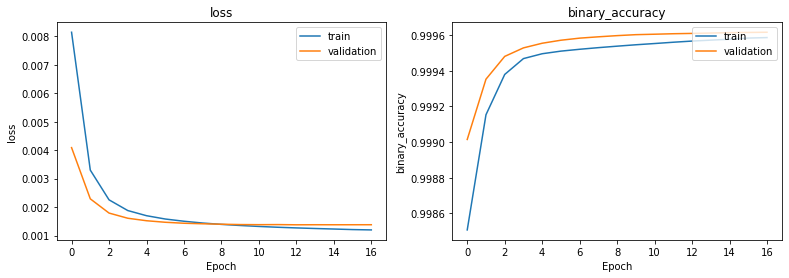

In [42]:
from lib.plot import plot_training_stat

_, (ax1, ax2) = plt.subplots(1, 2, figsize=(13,4))

plot_training_stat(stats, 'loss', ax1)
plot_training_stat(stats, 'binary_accuracy', ax2)

# Test model

In [43]:
training_model = tf.keras.models.load_model(MODEL_DIR / 'training_model')
serving_model = tf.keras.models.load_model(MODEL_DIR / 'serving_model')

In [44]:
ds_test = tfds.load('off_categories', split=TEST_SPLIT)

## Predict with training model

In [45]:
%%time

training_pred_test = training_model.predict(ds_test.padded_batch(PREDICT_BATCH_SIZE))

print(training_pred_test.shape)
training_pred_test

/home/alex/docker/off-category-classification/.venv/lib/python3.9/site-packages/keras/engine/functional.py:582: UserWarning: Input dict contained keys ['categories_tags', 'code'] which did not match any model input. They will be ignored by the model.
  warnings.warn(
2022-05-21 09:49:56.035297: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1388102184 exceeds 10% of free system memory.
[codecarbon INFO @ 09:49:56] Energy consumed for RAM : 0.171234 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 09:49:56] RAM : 11.65 W during 14.98 s [measurement time: 0.0011]
[codecarbon DEBUG @ 09:49:56] get_cpu_details {}
[codecarbon DEBUG @ 09:49:56] get_static_cpu_details {}
[codecarbon INFO @ 09:49:56] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 09:49:56] get_static_cpu_details {}
[codecarbon DEBUG @ 09:49:56] CPU : 0.00 W during 14.98 s [measurement time: 0.0011]
[codecarbon INFO @ 09:49:56] 0.171234 kWh of electricity us

(87434, 3969)
CPU times: user 33.1 s, sys: 5.4 s, total: 38.5 s
Wall time: 8.91 s


array([[1.16622806e-01, 3.56363952e-02, 4.88204896e-05, ...,
        3.16644939e-11, 6.64625244e-10, 9.20553495e-11],
       [4.67121601e-04, 1.19370222e-03, 4.35709953e-04, ...,
        3.70853115e-20, 8.61757660e-13, 1.30181965e-12],
       [3.41296196e-03, 5.45278192e-03, 9.45988178e-01, ...,
        4.61839213e-11, 1.32576961e-09, 1.39700987e-10],
       ...,
       [1.13215074e-05, 1.55064281e-05, 6.01789355e-03, ...,
        9.75066080e-17, 3.30418354e-17, 1.38202783e-10],
       [5.66640620e-06, 5.09451581e-07, 2.75540742e-07, ...,
        1.27794036e-17, 8.16437323e-17, 1.40855535e-13],
       [1.54674053e-04, 2.78025866e-04, 2.71667204e-06, ...,
        9.70674582e-12, 8.28983016e-09, 3.73146456e-08]], dtype=float32)

## Predict with serving model

In [46]:
%%time

serving_pred_test = serving_model.predict(ds_test.padded_batch(PREDICT_BATCH_SIZE))

serving_pred_test

[codecarbon INFO @ 09:50:11] Energy consumed for RAM : 0.171282 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 09:50:11] RAM : 11.65 W during 15.00 s [measurement time: 0.0013]
[codecarbon DEBUG @ 09:50:11] get_cpu_details {}
[codecarbon DEBUG @ 09:50:11] get_static_cpu_details {}
[codecarbon INFO @ 09:50:11] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 09:50:11] get_static_cpu_details {}
[codecarbon DEBUG @ 09:50:11] CPU : 0.00 W during 15.00 s [measurement time: 0.0019]
[codecarbon INFO @ 09:50:11] 0.171282 kWh of electricity used since the begining.
[codecarbon DEBUG @ 09:50:11] last_duration=14.99852991104126
------------------------
[codecarbon INFO @ 09:50:11] Energy consumed for RAM : 0.170524 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 09:50:11] RAM : 11.65 W during 14.99 s [measurement time: 0.0016]
[codecarbon DEBUG @ 09:50:11] get_cpu_details {}
[codecarbon DEBUG @ 09:50:11] get_static_cpu_details {}
[codeca

CPU times: user 1min 12s, sys: 2.31 s, total: 1min 15s
Wall time: 16.6 s


(array([[7.9449129e-01, 6.9800812e-01, 6.0029268e-01, ..., 5.3742528e-04,
         4.9141049e-04, 4.8172474e-04],
        [9.9003696e-01, 9.8998868e-01, 8.8658583e-01, ..., 1.2306234e-05,
         1.1660812e-05, 1.1062800e-05],
        [9.4598818e-01, 3.1789863e-01, 2.7961344e-01, ..., 6.5389308e-05,
         4.8454935e-05, 4.5752429e-05],
        ...,
        [9.8908782e-01, 9.7201538e-01, 9.5044005e-01, ..., 2.6885912e-06,
         2.2189308e-06, 2.1248882e-06],
        [9.9949694e-01, 9.9355114e-01, 9.9116206e-01, ..., 1.1835697e-06,
         9.6978044e-07, 8.0819120e-07],
        [9.8734128e-01, 9.8065317e-01, 9.7238028e-01, ..., 5.3063035e-04,
         4.7129393e-04, 4.6300888e-04]], dtype=float32),
 array([[b'en:meats', b'en:sausages', b'en:prepared-meats', ...,
         b'fr:charcuteries-a-cuire', b'en:pork-liver-sausages',
         b'en:strasbourg-sausages'],
        [b'en:groceries', b'en:sauces', b'en:dips', ..., b'en:meats',
         b'en:dried-products', b'en:mojo-sauces'],

In [47]:
%%time

top_predictions(ds_test, serving_pred_test, 4)

NameError: name 'top_predictions' is not defined

In [48]:
# codecarbon - stop tracking
tracker.stop()

[codecarbon INFO @ 09:50:15] Energy consumed for RAM : 0.170534 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 09:50:15] RAM : 11.65 W during 3.19 s [measurement time: 0.0014]
[codecarbon DEBUG @ 09:50:15] get_cpu_details {}
[codecarbon DEBUG @ 09:50:15] get_static_cpu_details {}
[codecarbon INFO @ 09:50:15] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 09:50:15] get_static_cpu_details {}
[codecarbon DEBUG @ 09:50:15] CPU : 0.00 W during 3.19 s [measurement time: 0.0013]
[codecarbon INFO @ 09:50:15] 0.170534 kWh of electricity used since the begining.
[codecarbon DEBUG @ 09:50:15] last_duration=3.192316770553589
------------------------
[codecarbon DEBUG @ 09:50:15] We apply an energy mix of 55 g.CO2eq/kWh for France
[codecarbon DEBUG @ 09:50:15] EmissionsData(timestamp='2022-05-21T09:50:15', project_name='codecarbon', run_id='88262eed-3106-4e63-a0dc-d693321ec90e', duration=52735.718173742294, emissions=0.009379362644315409, emission

5.90265740701458e-06

[codecarbon INFO @ 09:50:26] Energy consumed for RAM : 0.171331 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 09:50:26] RAM : 11.65 W during 14.99 s [measurement time: 0.0030]
[codecarbon DEBUG @ 09:50:26] get_cpu_details {}
[codecarbon DEBUG @ 09:50:26] get_static_cpu_details {}
[codecarbon INFO @ 09:50:26] Energy consumed for all CPUs : 0.000000 kWh. All CPUs Power : 0.0 W
[codecarbon DEBUG @ 09:50:26] get_static_cpu_details {}
[codecarbon DEBUG @ 09:50:26] CPU : 0.00 W during 15.00 s [measurement time: 0.0037]
[codecarbon INFO @ 09:50:26] 0.171331 kWh of electricity used since the begining.
[codecarbon DEBUG @ 09:50:26] last_duration=14.999179363250732
------------------------
[codecarbon INFO @ 09:50:41] Energy consumed for RAM : 0.171379 kWh. RAM Power : 11.645366191864014 W
[codecarbon DEBUG @ 09:50:41] RAM : 11.65 W during 14.99 s [measurement time: 0.0019]
[codecarbon DEBUG @ 09:50:41] get_cpu_details {}
[codecarbon DEBUG @ 09:50:41] get_static_cpu_details {}
[codec